In [1]:
# python env: modnenv_v2

import os
import string
import random
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path, PosixPath
import matplotlib.pyplot as plt
import json 
import pandas as pd
from copy import deepcopy
from modnet.models import EnsembleMODNetModel
from modnet.preprocessing import MODData
from modnet.hyper_opt import FitGenetic
from monty.serialization import dumpfn, loadfn
from pymatgen.ext.matproj import MPRester
from pymatgen.core.structure import Structure
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from scipy.stats import spearmanr
from IPython.display import Image
from tqdm import tqdm
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-01-15 14:26:16.481944: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 14:26:16.488289: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 14:26:16.553452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 14:26:16.553496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 14:26:16.554786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [6]:
structures = ['test', 'test1']
ids = ['idtest', 'idtest1']
df_structures = pd.DataFrame.from_dict(
    {id: {'structure': s} for id, s in zip(ids, structures)}, orient='index'
)

In [7]:
df_structures

structure
idtest       test
idtest1     test1

In [9]:
md = MODData(df_featurized=df_structures)

In [16]:
t = ['test0', 'test1', 'test2']
tt = ['test0', 'test2']
include = set(tt).issubset(set(t))
print(include)

True


# Plan

1. Give 1 featurized dataframe (X) with a target dataframe (Y) sharing the same index
2. Choose a subset of X and Y, such as Xt and Yt, to be used as a starting set
    - percentage?
    - via list of index?
3. Train a MODNet model (GA) with Xt and Yt
    - Benchmark it via a cross-validation first and save the results
4. Predict the rest of the data, Xp = X-Xt and Yp = Y-Yt
5. Rank those predictions based on an acquisition function
    - random
    - ... look up in re2fractive
6. Select the best candidates based on the ranking, Xn and Yn
    - fixed number?
    - percentage of training set?
7. Iterate from point 3 with Xt = Xt+Xn and Yt = Yt+Yn until a criterion is reached:
    - number of cycles?
    - a given set of instances is included in the training set?
    - the model has reached a given accuracy

# 1. Give a featurized dataframe (X) with a target dataframe (Y) sharing the same index

In [2]:
def load_feat_selec_df(md_feat_selec):
    assert type(md_feat_selec)==str or type(md_feat_selec)==PosixPath or type(md_feat_selec)==MODData

    if type(md_feat_selec)==str or type(md_feat_selec)==PosixPath:
        md = MODData.load(md_feat_selec)
    else:
        md = deepcopy(md_feat_selec)
    
    X = md.df_featurized
    Y = md.df_targets
    # Let's save the important information of the featurized MODData for easier reuse
    dct_md_info={
        'optimal_features':             md.optimal_features,
        'optimal_features_by_target':   md.optimal_features_by_target,
        'num_classes':                  md.num_classes
    }

    return X, Y, dct_md_info

In [3]:
path_re2f = Path('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/ref_idx/re2fractive')

# Load the featurized MODData
X, Y, dct_md_info = load_feat_selec_df(path_re2f / 'humanguided' / 'v0' / 'mod.data_refeatselec_v0_v2')

2024-01-12 14:53:17,445 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fe8410c8fa0> object, created with modnet version 0.4.1


In [4]:
# Verify that the instances of X and Y have the same number of instances with the same index
if X.shape[0] != Y.shape[0]:
    raise Exception(f'X and Y DO NOT have the same number of instances, although they should! X has {X.shape[0]} instances while Y has {Y.shape[0]} instances.')
else:
    print(f"    - Number of instances:  {X.shape[0]}")
    print(f"X:")
    print(f"    - Number of features:   {X.shape[1]}")
    print(f"Y:")
    print(f"    - Number of targets:    {Y.shape[1]}")
    if X.index.equals(Y.index):
        print(f"The respective instances of X and Y all have the same index.")
    else:
        raise Exception(f"The respective instances of X and Y DO NOT all have the same index although they should!")

# TODO: - allow for mismatched indexes between X and Y but reorder them with a warning
#       - allow for a different number of instances between X and Y
#           - issue a warning and continue with the common instances
#           - use the non-common instances as data pool for DFT or else

    - Number of instances:  4001
X:
    - Number of features:   3019
Y:
    - Number of targets:    1
The respective instances of X and Y all have the same index.


# 2. Choose a subset of X and Y, such as Xt and Yt, to be used as a starting set

In [3]:
def train_pool_random(X, Y, n=None, frac=0.1, state=None, axis=None):
    # Train dataset
    Xt = X.sample(n=n, frac=frac, random_state=state, axis=0)

    Yt = Y.filter(items=Xt.index.values, axis=0)

    # Pool dataset
    Xp = X.drop(Xt.index.values, axis=0)
    Yp = Y.drop(Yt.index.values, axis=0)

    return Xt, Yt, Xp, Yp

In [6]:
Xt, Yt, Xp, Yp = train_pool_random(X, Y, frac=0.05, state=42)

#   3. Train a MODNet model (GA) with Xt and Yt

In [4]:
def benchmk(
        X, Y, dct_md_info,
        model_type=FitGenetic, model_params=None,
        kf_k=5, kf_state=None, 
        bmk_dir_path='./benchmark',
        icycle=0
        ):

    assert type(bmk_dir_path)==str or type(bmk_dir_path)==PosixPath
    bmk_dir_path = Path(bmk_dir_path)


    if not os.path.isdir(bmk_dir_path):
        os.mkdir(bmk_dir_path)
    figs_dir_path = (bmk_dir_path / 'figs')
    if not os.path.isdir(figs_dir_path):
        os.mkdir(figs_dir_path)
    fig_path = (figs_dir_path / f'fig_{icycle:02}.png')
    models_dir_path = (bmk_dir_path / 'models')
    if not os.path.isdir(models_dir_path):
        os.mkdir(models_dir_path)
    scores_dir_path = (bmk_dir_path / 'scores')
    if not os.path.isdir(scores_dir_path):
        os.mkdir(scores_dir_path)
    scores_path = (scores_dir_path / f'scores_{icycle:02}.json')


    if fig_path.exists():
        fig = Image(filename=fig_path)
        display(fig)
        with open(scores_path) as f:
          scores = json.load(f)
        return scores
    else:

        # Create a new training MODData that will be split into k folds
        md_t = MODData(df_featurized=X)
        md_t.df_targets                 = Y
        md_t.optimal_features           = dct_md_info['optimal_features']
        md_t.optimal_features_by_target = dct_md_info['optimal_features_by_target']
        md_t.num_classes                = dct_md_info['num_classes']

        # Scores
        pred_mae  = []
        pred_rmse = []
        pred_spr  = []
        unc_mae   = []
        unc_rmse  = []

        # Figure
        plt.figure(figsize=(10,5))

        kf = KFold(kf_k, shuffle=True, random_state=kf_state)
        for ind, (train, test) in enumerate(
            kf.split(X=X, y=Y)
        ):
            # KFold
            train_moddata, test_moddata = md_t.split((train, test))


            model_path = (
                models_dir_path / f"model_{icycle:02}_{ind:02}.pkl"
            )
            if model_path.exists():
                model = EnsembleMODNetModel.load(model_path)
            else:
                ga = model_type(train_moddata)
                model = ga.run(
                    **model_params
                )
                model.save(model_path)

            predictions, uncertainties = model.predict(test_moddata, return_unc=True)

            # Scores
            pred_mae.append(mean_absolute_error(
                np.array(test_moddata.df_targets[test_moddata.target_names[0]].values),
                np.array(predictions[test_moddata.target_names[0]])
                )
                )
            pred_rmse.append(mean_squared_error(
                np.array(test_moddata.df_targets[test_moddata.target_names[0]].values),
                np.array(predictions[test_moddata.target_names[0]])
                )
                )
            pred_spr.append(spearmanr(
                np.array(test_moddata.df_targets[test_moddata.target_names[0]].values),
                np.array(predictions[test_moddata.target_names[0]])
                ).statistic
                )

            unc_mae.append(mean_absolute_error(
                np.zeros(np.array(uncertainties[test_moddata.target_names[0]]).shape),
                np.array(uncertainties[test_moddata.target_names[0]])
                )
                )
            unc_rmse.append(mean_squared_error(
                np.zeros(np.array(uncertainties[test_moddata.target_names[0]]).shape),
                np.array(uncertainties[test_moddata.target_names[0]])
                )
                )
            

            # Plot
            plt.scatter(
                test_moddata.df_targets.values.ravel(),
                predictions.values.ravel(),
            )
            plt.errorbar(
                test_moddata.df_targets.values.ravel(),
                predictions.values.ravel(),
                yerr=uncertainties.values.ravel(),
                ls="none",
            )


        # Save scores
        scores = {
            'pred_mae': pred_mae,
            'pred_rmse': pred_rmse,
            'pred_spr': pred_spr,
            'unc_mae': unc_mae,
            'unc_rmse': unc_rmse,
        }
        with open(scores_path, 'w') as f:
          json.dump(scores, f)


        # Plot
        pred_mae = np.array(pred_mae)
        pred_rmse = np.array(pred_rmse)
        pred_spr = np.array(pred_spr)
        unc_mae = np.array(unc_mae)
        unc_rmse = np.array(unc_rmse)

        print("Benchmark complete.")
        txt_accuracy = ''
        txt_accuracy += f"MAE: {np.mean(pred_mae):.3f}±{np.std(pred_mae):.3f}"
        txt_accuracy += "\n"
        txt_accuracy += f"MAE folds:        {np.array2string(pred_mae, precision=3)}"
        txt_accuracy += "\n"
        txt_accuracy += f"MAE unc folds: {np.array2string(unc_mae, precision=3)}"
        txt_accuracy += "\n\n"
        txt_accuracy += f"RMSE: {np.mean(pred_rmse):.3f}±{np.std(pred_rmse):.3f}"
        txt_accuracy += "\n"
        txt_accuracy += f"RMSE folds:        {np.array2string(pred_rmse, precision=3)}"
        txt_accuracy += "\n"
        txt_accuracy += f"RMSE unc folds: {np.array2string(unc_rmse, precision=3)}"
        txt_accuracy += "\n\n"
        txt_accuracy += f"SPEARMAN: {np.mean(pred_spr):.3f}±{np.std(pred_spr):.3f}"
        txt_accuracy += "\n"
        txt_accuracy += f"SPEARMAN folds: {np.array2string(pred_spr, precision=3)}"
        # print(txt_accuracy)

        plt.plot(
            np.linspace(
                np.min(md_t.df_targets.values)-0.5,
                np.max(md_t.df_targets.values)+0.5,
                3,
            ),
            np.linspace(
                np.min(md_t.df_targets.values)-0.5,
                np.max(md_t.df_targets.values)+0.5,
                3,
            ),
            color="black",
            ls="--",
        )

        plt.subplots_adjust(right=0.5)
        plt.ylabel("Predicted $n$")
        plt.xlabel("Computed $n$")
        plt.xlim((np.min(md_t.df_targets.values)-0.5,np.max(md_t.df_targets.values)+0.5))
        plt.ylim((np.min(md_t.df_targets.values)-0.5,np.max(md_t.df_targets.values)+0.5))
        # plt.title(f"MAE: {(scores):.3f}±{np.std(scores):.3f}")
        plt.text(np.max(md_t.df_targets.values)+0.6, 
                 (np.max(md_t.df_targets.values)-np.min(md_t.df_targets.values))/2 + np.min(md_t.df_targets.values),
                 verticalalignment='center',
                 s = txt_accuracy)

        plt.savefig(fig_path)
        
        
        return scores

2024-01-12 15:01:59,516 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fe82921b0a0> object, created with modnet version 0.4.1
4/4 [==============================] - 0s 1ms/step
2024-01-12 15:01:59,967 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fe8333d0160> object, created with modnet version 0.4.1
4/4 [==============================] - 0s 2ms/step
Benchmark complete.


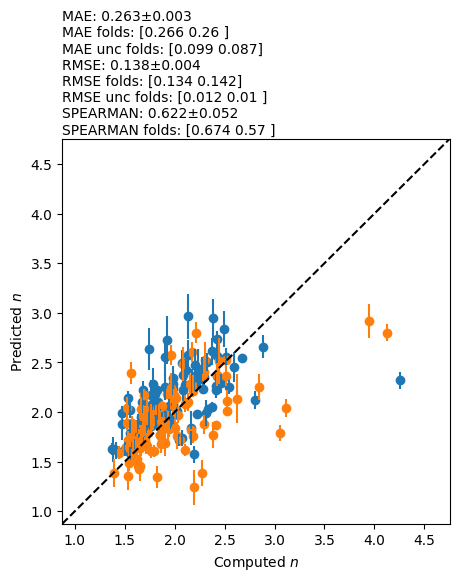

In [34]:
# Benchmark 

scores_test = benchmk(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params={
        'size_pop':2, # dflt 20
        'num_generations':2, # dflt 10
        'nested':0, # dflt = 5
        'n_jobs':2,
        'early_stopping':2, # dflt 4
        'refit':5, # dflt = 5
        'fast':False,
        },
    # model_dir_path=".", 
    kf_k=2, kf_state=42, 
    fig_path=None,
    scores_path=None,
    )

In [5]:
# Train
def train(
    X, Y, dct_md_info,
    model_type=FitGenetic, model_params=None, model_dir_path = (Path(".") / "production" / "models"),
    icycle=0
    ):

    # Create a new training MODData
    md_t = MODData(df_featurized=X)
    md_t.df_targets                 = Y
    md_t.optimal_features           = dct_md_info['optimal_features']
    md_t.optimal_features_by_target = dct_md_info['optimal_features_by_target']
    md_t.num_classes                = dct_md_info['num_classes']

    # Load or train and save
    if not os.path.isdir(model_dir_path):
        os.makedirs(model_dir_path)
    model_path = (
        model_dir_path / f"model_{icycle:02}.pkl"
    )
    if model_path.exists():
        print("Model already exists!")
        model = EnsembleMODNetModel.load(model_path)
    else:
        ga = model_type(md_t)
        model = ga.run(
            **model_params
        )
        model.save(model_path)

    return model

In [10]:
model_test = train(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params={
        'size_pop':2, # dflt 20
        'num_generations':2, # dflt 10
        'nested':0, # dflt = 5
        'n_jobs':2,
        'early_stopping':2, # dflt 4
        'refit':5, # dflt = 5
        'fast':False,
        },
    # model_dir_path=".", 
    )

Model already exists!
2024-01-12 14:53:18,020 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fe81ebb8700> object, created with modnet version 0.4.1


#   4. Predict the rest of the data, Xp = X-Xt

In [6]:
def predict(
        X, model, results_dir_path = Path('./production/results'),
        icycle=0,
):
    # New MODData to predict
    md_p = MODData(
        materials       = [None]*X.shape[0],
        df_featurized   = X,
        structure_ids   = X.index.values.flatten(),
    )

    if not os.path.isdir(results_dir_path):
        os.makedirs(results_dir_path)
    results_path = (
        results_dir_path / f"results_{icycle:02}.pkl"
    )
    if results_path.exists():
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
    else:
        # Predict the filtered MP
        results = model.predict(md_p, return_unc=True)

        with open(results_path, 'wb') as f:
            pickle.dump(results, f)

    return results

In [12]:
results_test = predict(X=Xp, model=model_test
                    #    results_dir_path=
                       )
display(results_test[0])
display(results_test[1])

refractive_index
mp-755116          2.116743
mp-755478          2.041733
mp-17998           2.186038
mp-754065          1.980503
mp-553961          2.247880
...                     ...
mp-698480          2.056489
mp-23740           2.122451
mp-8333            1.871978
mp-643898          1.729988
mp-643364          1.907025

[3801 rows x 1 columns]

refractive_index
mp-755116          0.129385
mp-755478          0.202600
mp-17998           0.098293
mp-754065          0.216073
mp-553961          0.835851
...                     ...
mp-698480          0.183939
mp-23740           0.198163
mp-8333            0.084368
mp-643898          0.104997
mp-643364          0.139248

[3801 rows x 1 columns]

#   5. Rank those predictions based on an acquisition function

In [7]:
# Exploration - highest uncertainties
def exploration(predictions, uncertainties):
    unc = uncertainties.copy()
    target = unc.columns.values
    unc['score'] = unc[target].rank(pct=True)
    return unc

#   6. Select the best candidates based on the ranking, Xn and Yn

In [8]:
def select(Xt, Yt, Xp, Yp, results, acquisition=None, frac=0.05, n=None, **acquisition_kwargs):
    # unpacking the results
    predictions, uncertainties = results
    if not acquisition:
        id_selected = predictions.sample(n=n, frac=frac, axis=0, **acquisition_kwargs).index.values
    else:
        scored = acquisition(predictions, uncertainties, **acquisition_kwargs)
        scored = scored.sort_values(by='score',ascending=False).dropna()
        if n:
            id_selected = scored.index.values[:n]
        else:
            id_selected = scored.index.values[:int(len(scored)*frac)]
        
    
    Xs = Xp.filter(items=id_selected, axis=0)
    Ys = Yp.filter(items=id_selected, axis=0)
    return pd.concat([Xt, Xs], axis=0), pd.concat([Yt, Ys], axis=0)


In [15]:
Xtn, Ytn = select(Xt=Xt, Yt=Yt, Xp=Xp, Yp=Yp, results=results_test, acquisition=exploration)

#   7. Iterate from point 3 with Xt = Xt+Xn and Yt = Yt+Yn until a criterion is reached:

2024-01-13 18:00:56,564 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fcfd470e8b0> object, created with modnet version 0.4.1


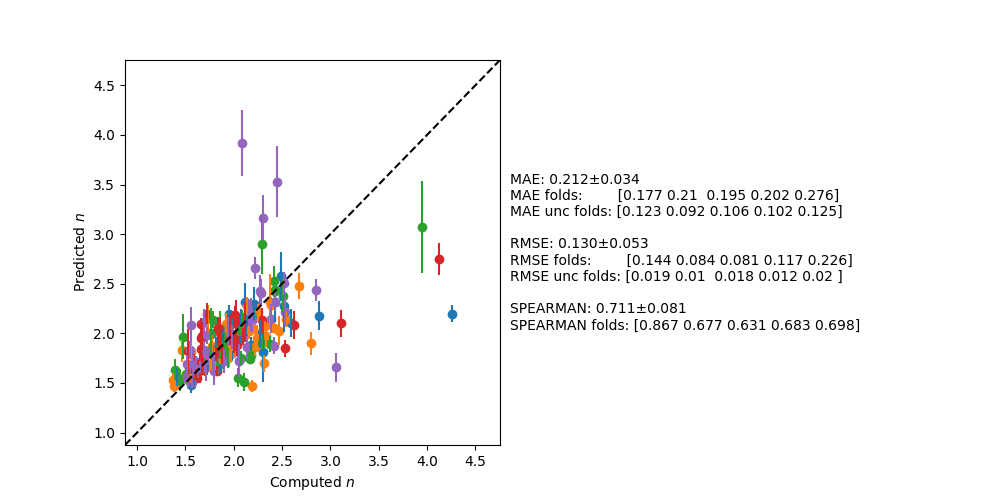

Model already exists!
2024-01-13 18:00:57,014 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fcf3b193550> object, created with modnet version 0.4.1


In [9]:
# 1 iteration
path_re2f = Path('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/ref_idx/re2fractive')

# Load the data from a featurized MODData that underwent feature_selection
X, Y, dct_md_info = load_feat_selec_df(path_re2f / 'humanguided' / 'v0' / 'mod.data_refeatselec_v0_v2')

# Choose a subset of the data to start the learning iterations
Xt, Yt, Xp, Yp = train_pool_random(X, Y, frac=0.05, state=42)

# Choose the model you want to use
model_type=FitGenetic
model_params={
    'size_pop':2, # dflt 20
    'num_generations':2, # dflt 10
    'nested':0, # dflt = 5
    'n_jobs':2,
    'early_stopping':2, # dflt 4
    'refit':5, # dflt = 5
    'fast':False,
    }

# Benchmark 
scores_bk = benchmk(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params=model_params,
    kf_k=2, kf_state=42, 
    # bmk_dir_path=
    )

# Train
model = train(
    X=Xt, Y=Yt, dct_md_info=dct_md_info,
    model_type=FitGenetic,
    model_params=model_params,
    # model_dir_path=".", 
    )

# Predict the pool data
results = predict(X=Xp, model=model
                    #    results_dir_path=
                  )

# Score, rank, and select the new data to be added to training
Xtn, Ytn = select(Xt=Xt, Yt=Yt, Xp=Xp, Yp=Yp, results=results, acquisition=exploration)

2024-01-13 18:01:13,687 - modnet - INFO - Loaded <modnet.preprocessing.MODData object at 0x7fcf3b31bbe0> object, created with modnet version 0.4.1
200


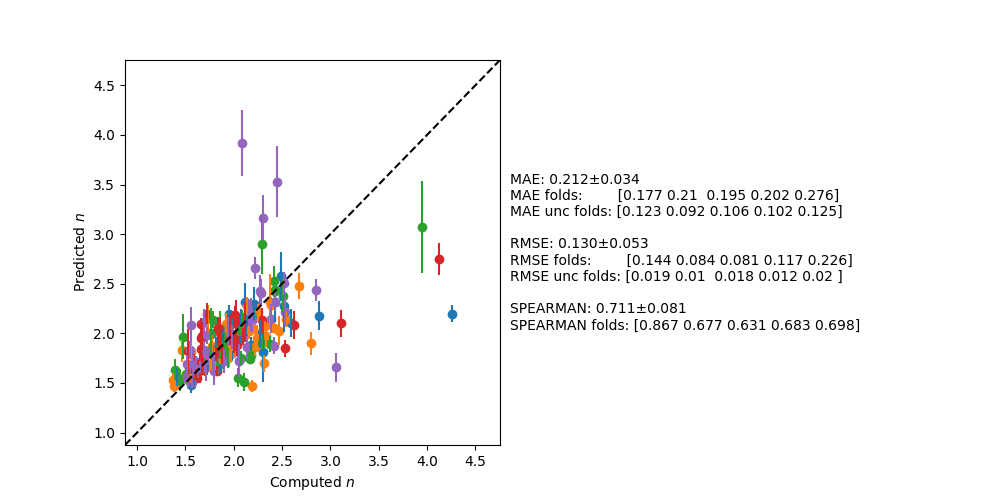

Model already exists!
2024-01-13 18:01:13,998 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fceb60f1850> object, created with modnet version 0.4.1
300


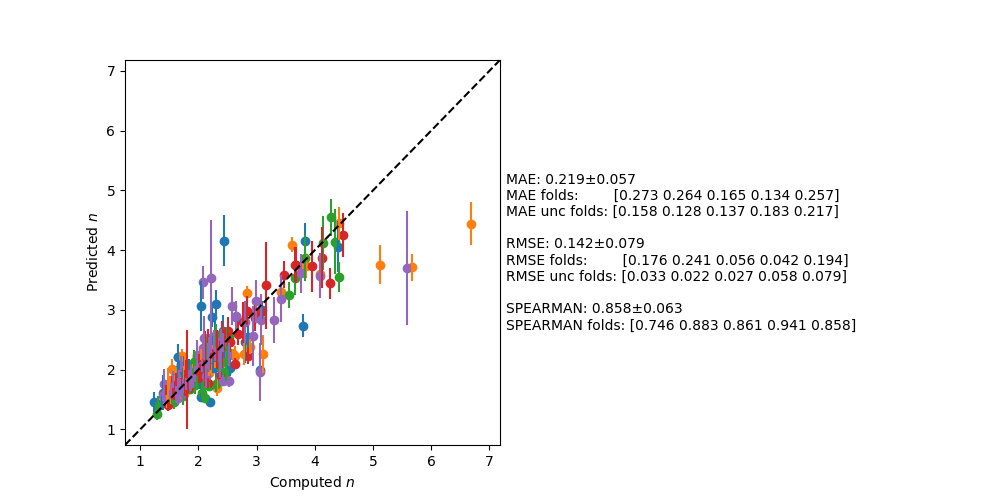

Model already exists!
2024-01-13 18:01:14,263 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fceb60f1b80> object, created with modnet version 0.4.1
400


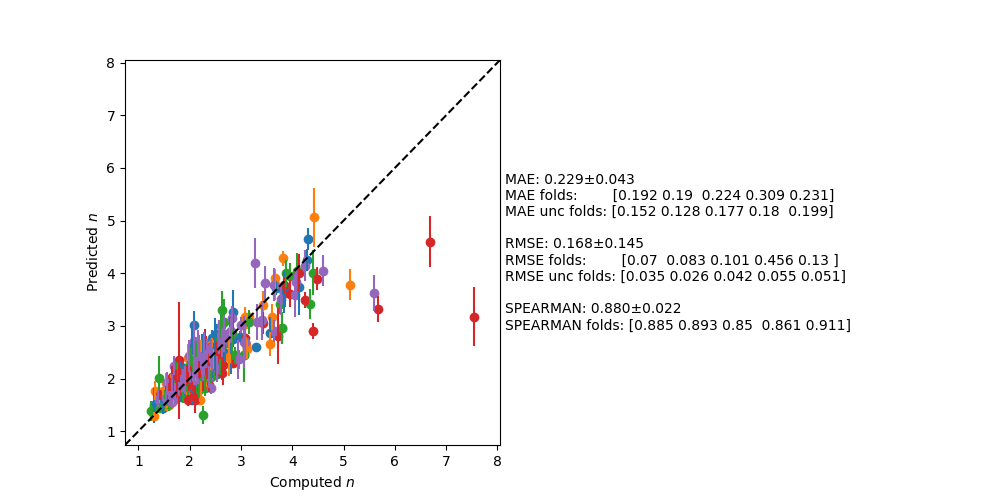

Model already exists!
2024-01-13 18:01:14,551 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fceb6131d60> object, created with modnet version 0.4.1
500


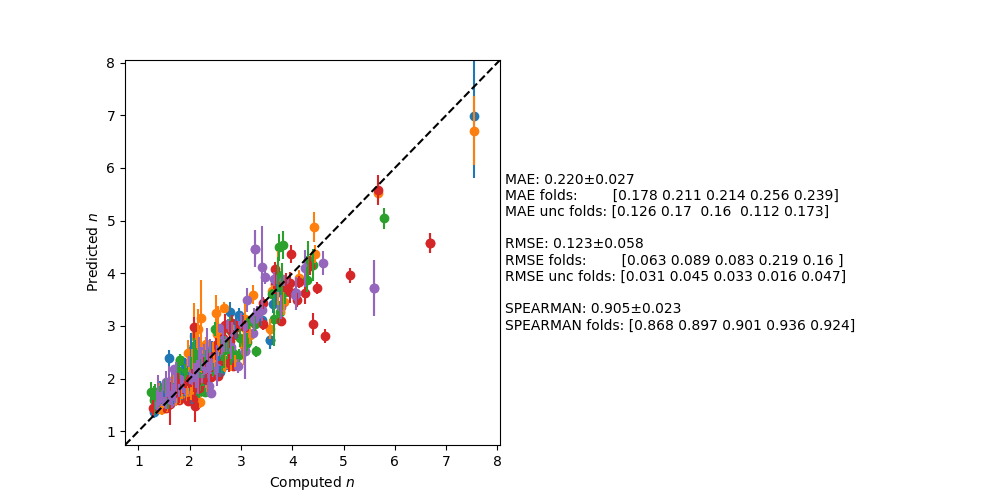

Model already exists!
2024-01-13 18:01:14,797 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fceb60d3e80> object, created with modnet version 0.4.1
600


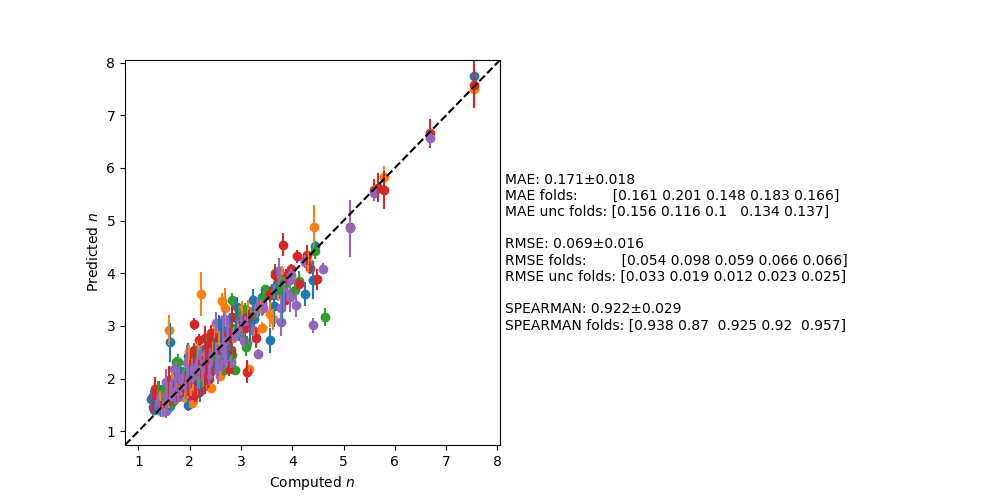

Model already exists!
2024-01-13 18:01:15,031 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fcf5d77c9a0> object, created with modnet version 0.4.1
700


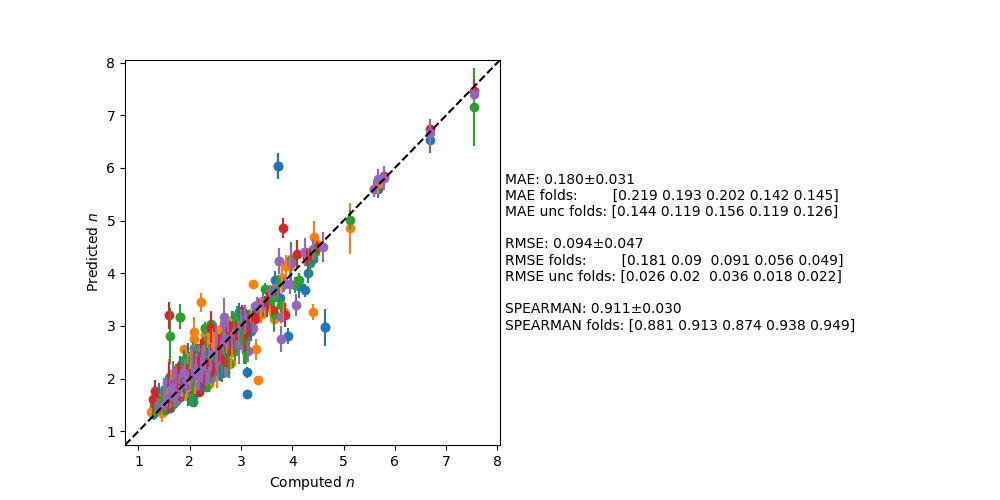

Model already exists!
2024-01-13 18:01:15,306 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fceb620ffa0> object, created with modnet version 0.4.1
800


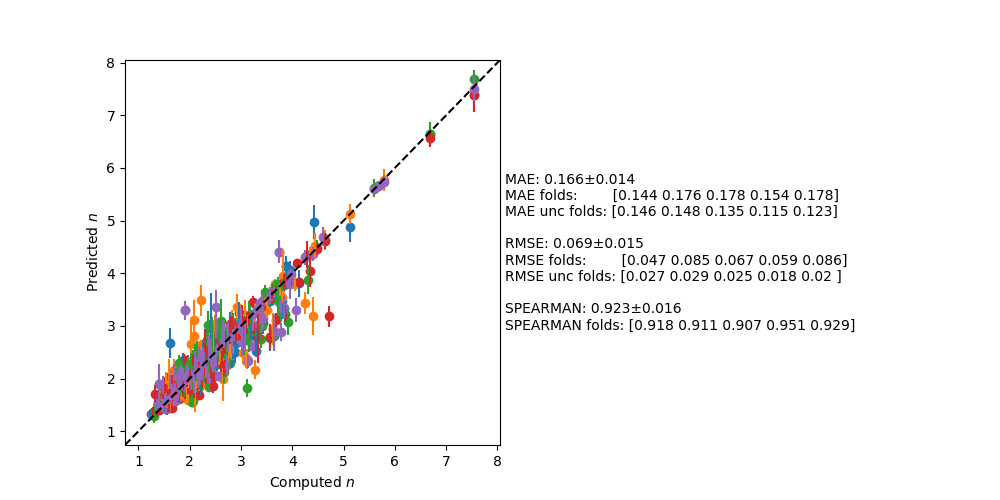

Model already exists!
2024-01-13 18:01:15,607 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fceb633c9d0> object, created with modnet version 0.4.1
900


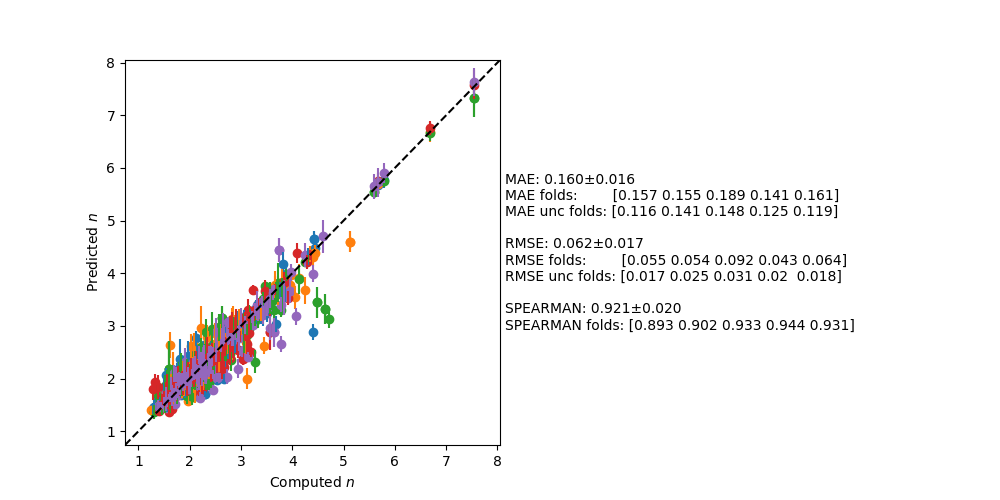

Model already exists!
2024-01-13 18:01:15,858 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fcf3b2a8190> object, created with modnet version 0.4.1
1000


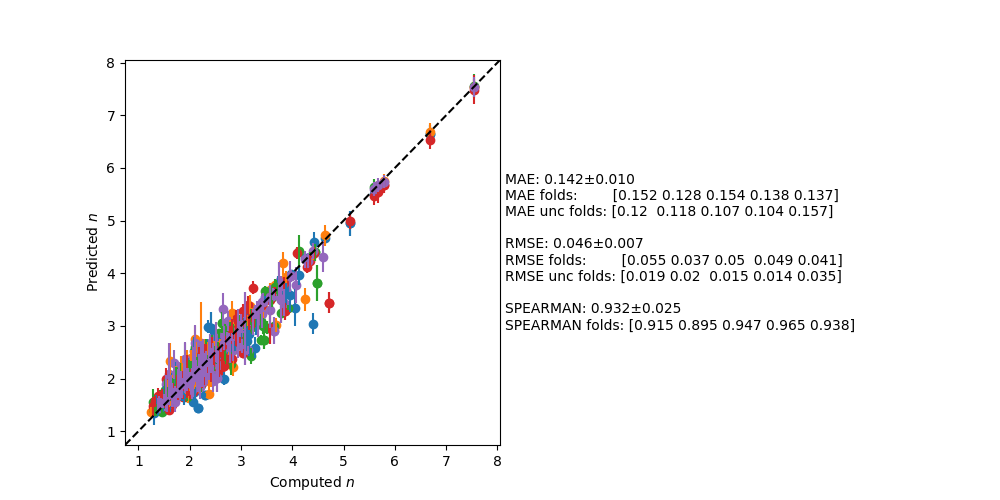

Model already exists!
2024-01-13 18:01:16,135 - modnet - INFO - Loaded <modnet.models.ensemble.EnsembleMODNetModel object at 0x7fcf5d795520> object, created with modnet version 0.4.1
1100
2024-01-13 18:01:16,204 - modnet - INFO - Targets:
2024-01-13 18:01:16,204 - modnet - INFO - 1)refractive_index: regression
2024-01-13 18:01:16,253 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 18:01:16,256 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 18:01:16.572233: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 18:01:16.574339: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 18:01:16.599136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 18:01:16.599172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 860us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:17,  7.66s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:27,  5.17s/it]

3/3 [==============================] - 0s 958us/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:30,  5.66s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:12,  4.86s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:14,  5.31s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<00:50,  3.89s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:10,  5.86s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:54,  4.94s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:58,  5.86s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:53,  5.91s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:33,  4.22s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:07<00:31,  4.50s/it]

3/3 [==============================] - 0s 881us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:08<00:20,  3.41s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:13<00:19,  3.85s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:19<00:11,  3.69s/it]

3/3 [==============================] - 0s 993us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:20<00:05,  2.84s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:25<00:03,  3.37s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:30<00:00,  4.55s/it]

3/3 [==============================] - 0s 826us/step
2024-01-13 18:02:47,242 - modnet - INFO - Loss per individual: ind 0: 0.213 	ind 1: 0.246 	ind 2: 0.190 	ind 3: 0.191 	ind 4: 0.263 	ind 5: 0.171 	ind 6: 0.242 	ind 7: 0.219 	ind 8: 0.237 	ind 9: 0.173 	ind 10: 0.192 	ind 11: 0.172 	ind 12: 0.232 	ind 13: 0.251 	ind 14: 0.299 	ind 15: 0.252 	ind 16: 0.337 	ind 17: 0.252 	ind 18: 0.199 	ind 19: 0.222 	
2024-01-13 18:02:47,242 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<02:11,  6.91s/it]

3/3 [==============================] - 0s 898us/step


 10%|██████████                                                                                          | 2/20 [00:09<01:18,  4.34s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:02,  3.67s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:14,  4.64s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<01:22,  5.49s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<01:05,  4.65s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<01:01,  4.72s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:40<01:04,  5.35s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:40<00:42,  3.86s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:44<00:39,  3.92s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:49<00:36,  4.05s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:53<00:32,  4.05s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:54<00:23,  3.34s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:00<00:23,  4.00s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:03<00:18,  3.69s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:08<00:16,  4.22s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:12<00:12,  4.22s/it]

3/3 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:23<00:12,  6.02s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:23<00:04,  4.39s/it]

3/3 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.48s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:04:16,889 - modnet - INFO - Loss per individual: ind 0: 0.184 	ind 1: 0.266 	ind 2: 0.288 	ind 3: 0.152 	ind 4: 0.155 	ind 5: 0.224 	ind 6: 0.214 	ind 7: 0.208 	ind 8: 0.184 	ind 9: 0.157 	ind 10: 0.495 	ind 11: 0.216 	ind 12: 0.244 	ind 13: 0.184 	ind 14: 0.173 	ind 15: 0.173 	ind 16: 0.196 	ind 17: 0.201 	ind 18: 0.148 	ind 19: 0.193 	
2024-01-13 18:04:16,890 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:11,  6.93s/it]

3/3 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:39,  5.85s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:15,  4.72s/it]

3/3 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:25,  5.73s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:03,  4.55s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:17,  6.00s/it]

3/3 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:12,  6.06s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:55,  5.08s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:56,  5.65s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:38,  4.29s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:47,  5.88s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:06<00:30,  4.30s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:14<00:32,  5.35s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:19<00:25,  5.09s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:17,  4.29s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:19,  6.64s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:35<00:10,  5.18s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:42<00:05,  5.78s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.19s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:06:00,632 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.119 	ind 2: 0.153 	ind 3: 0.163 	ind 4: 0.165 	ind 5: 0.160 	ind 6: 0.187 	ind 7: 0.169 	ind 8: 0.153 	ind 9: 0.194 	ind 10: 0.238 	ind 11: 0.143 	ind 12: 0.232 	ind 13: 0.227 	ind 14: 0.140 	ind 15: 0.134 	ind 16: 0.117 	ind 17: 0.170 	ind 18: 0.274 	ind 19: 0.207 	
2024-01-13 18:06:00,633 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:04<01:26,  4.58s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:31,  5.07s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<02:04,  7.32s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:14,  4.63s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:35,  6.34s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:27,  6.72s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:00,  5.03s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:49<00:55,  5.07s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:51<00:41,  4.19s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:54,  6.10s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:44,  5.61s/it]

3/3 [==============================] - 0s 997us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:10<00:36,  5.17s/it]

3/3 [==============================] - 0s 928us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:16<00:31,  5.23s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:24<00:29,  5.98s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:20,  5.24s/it]

3/3 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:37<00:19,  6.55s/it]

3/3 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:39<00:10,  5.23s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:47<00:06,  6.16s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.54s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:07:51,437 - modnet - INFO - Loss per individual: ind 0: 0.210 	ind 1: 0.193 	ind 2: 0.143 	ind 3: 0.168 	ind 4: 0.198 	ind 5: 0.191 	ind 6: 0.178 	ind 7: 0.232 	ind 8: 0.196 	ind 9: 0.167 	ind 10: 0.165 	ind 11: 0.149 	ind 12: 0.194 	ind 13: 0.140 	ind 14: 0.167 	ind 15: 0.147 	ind 16: 0.190 	ind 17: 0.200 	ind 18: 0.192 	ind 19: 0.130 	
2024-01-13 18:07:51,438 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.54s/it]

3/3 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:33,  5.21s/it]

3/3 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:49,  6.42s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:07,  4.25s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:20,  5.34s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<00:53,  3.85s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:21,  6.25s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:05,  5.43s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<01:03,  5.80s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<01:00,  6.00s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:01<00:47,  5.32s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:46,  5.82s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:10<00:33,  4.77s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:33,  5.60s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:20,  4.15s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:20,  5.14s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:29<00:13,  4.65s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:32<00:08,  4.18s/it]

3/3 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:40<00:05,  5.14s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.14s/it]

3/3 [==============================] - 0s 2ms/step
2024-01-13 18:09:34,214 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.353 	ind 2: 0.199 	ind 3: 0.171 	ind 4: 0.265 	ind 5: 0.202 	ind 6: 0.187 	ind 7: 0.189 	ind 8: 0.139 	ind 9: 0.153 	ind 10: 0.164 	ind 11: 0.165 	ind 12: 0.149 	ind 13: 0.180 	ind 14: 0.183 	ind 15: 0.170 	ind 16: 0.165 	ind 17: 0.255 	ind 18: 0.152 	ind 19: 0.162 	
2024-01-13 18:09:34,214 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:22, 10.66s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:48,  6.39s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:40,  6.27s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:23,  5.56s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:35,  6.85s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:01,  4.77s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:05,  5.44s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:42,  3.86s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:57,  5.80s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:00<00:46,  5.17s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:44,  5.54s/it]

3/3 [==============================] - 0s 902us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:09<00:31,  4.44s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:33,  5.51s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:17<00:19,  3.98s/it]

3/3 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:22<00:17,  4.34s/it]

3/3 [==============================] - 0s 931us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:25<00:11,  3.76s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:08,  4.07s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:31<00:03,  3.35s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.88s/it]

3/3 [==============================] - 0s 912us/step
2024-01-13 18:11:11,778 - modnet - INFO - Loss per individual: ind 0: 0.196 	ind 1: 0.192 	ind 2: 0.164 	ind 3: 0.203 	ind 4: 0.213 	ind 5: 0.173 	ind 6: 0.162 	ind 7: 0.219 	ind 8: 0.209 	ind 9: 0.198 	ind 10: 0.181 	ind 11: 0.164 	ind 12: 0.214 	ind 13: 0.219 	ind 14: 0.189 	ind 15: 0.220 	ind 16: 0.222 	ind 17: 0.154 	ind 18: 0.166 	ind 19: 0.165 	
2024-01-13 18:11:11,778 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 18:11:11,779 - modnet - INFO - Early stopping at generation number 5


2024-01-13 18:11:13,527 - modnet - INFO - Model successfully saved as benchmark/models/model_09_00.pkl!
7/7 [==============================] - 0s 1ms/step
2024-01-13 18:11:14,256 - modnet - INFO - Targets:
2024-01-13 18:11:14,256 - modnet - INFO - 1)refractive_index: regression
2024-01-13 18:11:14,291 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 18:11:14,293 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 18:11:14.566323: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 18:11:14.567955: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 18:11:14.591330: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 18:11:14.591362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:50,  6.16s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:04,  3.82s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:17<00:57,  3.60s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:21<00:55,  3.67s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:23<00:43,  3.08s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:28<00:48,  3.70s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:32<00:45,  3.83s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:35<00:39,  3.57s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:40<00:40,  4.09s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:41<00:27,  3.06s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:49<00:38,  4.76s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:55<00:23,  3.91s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:58<00:18,  3.61s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:02<00:15,  3.95s/it]

3/3 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:06<00:05,  2.93s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:10<00:03,  3.38s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.75s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:12:29,328 - modnet - INFO - Loss per individual: ind 0: 0.360 	ind 1: 0.335 	ind 2: 0.297 	ind 3: 0.315 	ind 4: 0.835 	ind 5: 0.230 	ind 6: 0.338 	ind 7: 0.199 	ind 8: 0.440 	ind 9: 0.177 	ind 10: 0.249 	ind 11: 0.223 	ind 12: 0.170 	ind 13: 0.174 	ind 14: 0.268 	ind 15: 0.577 	ind 16: 0.972 	ind 17: 0.577 	ind 18: 0.187 	ind 19: 0.190 	
2024-01-13 18:12:29,328 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:05<01:52,  5.92s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:32,  5.11s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<00:59,  3.51s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:17,  4.84s/it]

3/3 [==============================] - 0s 989us/step


 25%|█████████████████████████                                                                           | 5/20 [00:19<00:48,  3.25s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<01:08,  4.90s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<01:02,  4.79s/it]

3/3 [==============================] - 0s 992us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<01:01,  5.12s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:41<00:50,  4.63s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:45<00:45,  4.60s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:43,  4.79s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:46,  5.77s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:02<00:35,  5.13s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:09<00:33,  5.65s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:10<00:20,  4.10s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:22,  5.63s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:13,  4.56s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:11,  5.71s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:30<00:04,  4.19s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.77s/it]

3/3 [==============================] - 0s 899us/step
2024-01-13 18:14:04,668 - modnet - INFO - Loss per individual: ind 0: 0.218 	ind 1: 0.238 	ind 2: 0.344 	ind 3: 0.203 	ind 4: 0.273 	ind 5: 0.278 	ind 6: 0.230 	ind 7: 0.184 	ind 8: 0.234 	ind 9: 0.210 	ind 10: 0.264 	ind 11: 0.237 	ind 12: 0.229 	ind 13: 0.225 	ind 14: 0.455 	ind 15: 0.249 	ind 16: 0.237 	ind 17: 0.213 	ind 18: 0.216 	ind 19: 0.230 	
2024-01-13 18:14:04,668 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<02:52,  9.10s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:18,  4.35s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:24,  4.99s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:11,  4.75s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:24<00:45,  3.27s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<01:03,  4.85s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:51,  4.29s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:40<00:49,  4.46s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:43<00:41,  4.18s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:50<00:45,  5.10s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:53<00:35,  4.39s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:58<00:32,  4.64s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:04<00:29,  4.87s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:06<00:20,  4.01s/it]

3/3 [==============================] - 0s 955us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:10<00:16,  4.13s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:14<00:12,  4.10s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:18<00:07,  3.92s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:23<00:04,  4.41s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.28s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:15:30,365 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.185 	ind 2: 0.213 	ind 3: 0.205 	ind 4: 0.204 	ind 5: 0.203 	ind 6: 0.193 	ind 7: 0.150 	ind 8: 0.194 	ind 9: 0.215 	ind 10: 0.220 	ind 11: 0.167 	ind 12: 0.232 	ind 13: 0.213 	ind 14: 0.206 	ind 15: 0.228 	ind 16: 0.232 	ind 17: 0.168 	ind 18: 0.171 	ind 19: 0.208 	
2024-01-13 18:15:30,366 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:10<03:15, 10.29s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:23,  4.66s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:38,  5.77s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:04,  4.28s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<01:00,  4.33s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<01:00,  4.63s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:43,  3.60s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:50,  4.61s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:45<00:41,  4.16s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:43,  4.81s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:55<00:36,  4.51s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:35,  5.00s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:30,  5.17s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:11<00:25,  5.02s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:22,  5.67s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:13,  4.60s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:28<00:10,  5.32s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:30<00:04,  4.50s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.76s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:17:05,625 - modnet - INFO - Loss per individual: ind 0: 0.159 	ind 1: 0.277 	ind 2: 0.176 	ind 3: 0.225 	ind 4: 0.164 	ind 5: 0.173 	ind 6: 0.201 	ind 7: 0.230 	ind 8: 0.163 	ind 9: 0.205 	ind 10: 0.162 	ind 11: 0.234 	ind 12: 0.165 	ind 13: 0.179 	ind 14: 0.178 	ind 15: 0.238 	ind 16: 0.160 	ind 17: 0.202 	ind 18: 0.167 	ind 19: 0.195 	
2024-01-13 18:17:05,626 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:28,  7.79s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:15,  4.20s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:18,  4.64s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:17<01:04,  4.01s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:12,  4.81s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:26<00:58,  4.20s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:20,  6.21s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<01:08,  5.75s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:49,  4.54s/it]

3/3 [==============================] - 0s 963us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:51<00:54,  5.49s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:52<00:37,  4.14s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:34,  4.29s/it]

3/3 [==============================] - 0s 909us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:28,  4.08s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:29,  4.91s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:10<00:22,  4.43s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:18,  4.58s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:14,  4.87s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:23<00:07,  3.95s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:31<00:05,  5.37s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.72s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:18:40,019 - modnet - INFO - Loss per individual: ind 0: 0.180 	ind 1: 0.163 	ind 2: 0.193 	ind 3: 0.257 	ind 4: 0.162 	ind 5: 0.189 	ind 6: 0.201 	ind 7: 0.225 	ind 8: 0.154 	ind 9: 0.178 	ind 10: 0.186 	ind 11: 0.171 	ind 12: 0.184 	ind 13: 0.188 	ind 14: 0.188 	ind 15: 0.180 	ind 16: 0.213 	ind 17: 0.206 	ind 18: 0.177 	ind 19: 0.179 	
2024-01-13 18:18:40,020 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:07<02:18,  7.27s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:22,  4.56s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:32,  5.44s/it]

3/3 [==============================] - 0s 930us/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:13,  4.62s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:08,  4.55s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<01:03,  4.56s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:06,  5.13s/it]

3/3 [==============================] - 0s 968us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:38<00:53,  4.45s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:50,  4.57s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:53,  5.36s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:36,  4.03s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:45,  5.70s/it]

3/3 [==============================] - 0s 992us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:33,  4.82s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:11<00:35,  5.96s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:21,  4.35s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:20<00:21,  5.44s/it]

3/3 [==============================] - 0s 940us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:24<00:15,  5.11s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:30<00:10,  5.25s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:04,  4.96s/it]

3/3 [==============================] - 0s 993us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.91s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:20:18,178 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.194 	ind 2: 0.186 	ind 3: 0.168 	ind 4: 0.163 	ind 5: 0.186 	ind 6: 0.200 	ind 7: 0.161 	ind 8: 0.172 	ind 9: 0.167 	ind 10: 0.194 	ind 11: 0.186 	ind 12: 0.142 	ind 13: 0.174 	ind 14: 0.158 	ind 15: 0.188 	ind 16: 0.176 	ind 17: 0.160 	ind 18: 0.143 	ind 19: 0.183 	
2024-01-13 18:20:18,179 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:08<02:41,  8.50s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:30,  5.02s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:33,  5.48s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:18<00:58,  3.68s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:07,  4.48s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<01:07,  4.81s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:31<00:53,  4.09s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:53,  4.49s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:39<00:42,  3.85s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:44<00:39,  4.00s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:50,  5.58s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:55<00:36,  4.53s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:32,  4.59s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:05<00:29,  4.84s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:09<00:22,  4.46s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:11<00:15,  3.98s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:19<00:15,  5.14s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:21<00:08,  4.10s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:27<00:04,  4.53s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.81s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:21:54,456 - modnet - INFO - Loss per individual: ind 0: 0.156 	ind 1: 0.131 	ind 2: 0.126 	ind 3: 0.160 	ind 4: 0.132 	ind 5: 0.161 	ind 6: 0.126 	ind 7: 0.151 	ind 8: 0.129 	ind 9: 0.126 	ind 10: 0.143 	ind 11: 0.132 	ind 12: 0.153 	ind 13: 0.152 	ind 14: 0.126 	ind 15: 0.163 	ind 16: 0.196 	ind 17: 0.102 	ind 18: 0.140 	ind 19: 0.161 	
2024-01-13 18:21:54,457 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.36s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:45,  6.23s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:05,  4.07s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:24,  5.64s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:02,  4.44s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<00:56,  4.38s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:12,  6.00s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:52,  5.21s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:54<00:40,  4.46s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:36,  4.57s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:05<00:35,  5.07s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:06<00:22,  3.78s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:14,  3.68s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:23<00:15,  5.05s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:24<00:07,  3.79s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:05,  5.55s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.73s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:23:29,065 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.144 	ind 2: 0.203 	ind 3: 0.169 	ind 4: 0.178 	ind 5: 0.163 	ind 6: 0.192 	ind 7: 0.179 	ind 8: 0.170 	ind 9: 0.185 	ind 10: 0.164 	ind 11: 0.175 	ind 12: 0.159 	ind 13: 0.204 	ind 14: 0.173 	ind 15: 0.160 	ind 16: 0.164 	ind 17: 0.175 	ind 18: 0.152 	ind 19: 0.158 	
2024-01-13 18:23:29,065 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:09<02:54,  9.21s/it]

3/3 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:23,  4.94s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:27,  5.44s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:02,  4.16s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<01:21,  5.80s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:00,  4.67s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<01:09,  5.80s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:48,  4.38s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:54,  5.40s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:40,  4.47s/it]

3/3 [==============================] - 0s 944us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:03<00:45,  5.70s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:29,  4.26s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:33,  5.50s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:16<00:24,  4.87s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:19,  4.85s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:28<00:16,  5.53s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:08,  4.27s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:04,  4.92s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.85s/it]

3/3 [==============================] - 0s 743us/step
2024-01-13 18:25:06,007 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.212 	ind 2: 0.180 	ind 3: 0.164 	ind 4: 0.212 	ind 5: 0.168 	ind 6: 0.198 	ind 7: 0.160 	ind 8: 0.169 	ind 9: 0.205 	ind 10: 0.213 	ind 11: 0.150 	ind 12: 0.168 	ind 13: 0.205 	ind 14: 0.223 	ind 15: 0.214 	ind 16: 0.242 	ind 17: 0.179 	ind 18: 0.201 	ind 19: 0.194 	
2024-01-13 18:25:06,008 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:05<01:37,  5.15s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:07<01:07,  3.75s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:12,  4.25s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:16<01:06,  4.17s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:33,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<00:59,  4.22s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:11,  5.51s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:47,  3.99s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<01:02,  5.64s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:45<00:40,  4.02s/it]

3/3 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:47,  5.31s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:54<00:30,  3.82s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:31,  4.53s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:01<00:21,  3.60s/it]

3/3 [==============================] - 0s 945us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:08<00:21,  4.38s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:08<00:12,  3.20s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:17<00:14,  4.94s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:19<00:07,  3.96s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:27<00:05,  5.43s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.46s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:26:35,210 - modnet - INFO - Loss per individual: ind 0: 0.244 	ind 1: 0.167 	ind 2: 0.156 	ind 3: 0.181 	ind 4: 0.148 	ind 5: 0.162 	ind 6: 0.165 	ind 7: 0.178 	ind 8: 0.193 	ind 9: 0.155 	ind 10: 0.187 	ind 11: 0.155 	ind 12: 0.201 	ind 13: 0.180 	ind 14: 0.149 	ind 15: 0.178 	ind 16: 0.303 	ind 17: 0.164 	ind 18: 0.150 	ind 19: 0.143 	
2024-01-13 18:26:35,210 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 18:26:35,211 - modnet - INFO - Early stopping at generation number 9


2024-01-13 18:26:37,207 - modnet - INFO - Model successfully saved as benchmark/models/model_09_01.pkl!
7/7 [==============================] - 0s 951us/step
2024-01-13 18:26:37,860 - modnet - INFO - Targets:
2024-01-13 18:26:37,861 - modnet - INFO - 1)refractive_index: regression
2024-01-13 18:26:37,899 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 18:26:37,900 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 18:26:38.174657: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 18:26:38.176290: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 18:26:38.199403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 18:26:38.199435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:46,  5.92s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:22,  4.83s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:17,  4.83s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:21<00:53,  3.55s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:23<00:40,  2.92s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:30<00:54,  4.21s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:31<00:39,  3.27s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:35<00:39,  3.59s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:41<00:43,  4.33s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:44<00:34,  3.86s/it]

3/3 [==============================] - 0s 992us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:44<00:22,  2.78s/it]

3/3 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:47<00:18,  2.60s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:48<00:14,  2.37s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:50<00:11,  2.26s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [00:51<00:06,  1.72s/it]

3/3 [==============================] - 0s 997us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:01<00:12,  4.31s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:02<00:06,  3.26s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:09<00:04,  4.45s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.53s/it]

3/3 [==============================] - 0s 858us/step
2024-01-13 18:27:48,578 - modnet - INFO - Loss per individual: ind 0: 0.484 	ind 1: 0.399 	ind 2: 0.326 	ind 3: 0.176 	ind 4: 0.397 	ind 5: 0.940 	ind 6: 0.167 	ind 7: 0.279 	ind 8: 0.208 	ind 9: 0.241 	ind 10: 0.551 	ind 11: 25.410 	ind 12: 0.552 	ind 13: 0.209 	ind 14: 0.476 	ind 15: 0.824 	ind 16: 0.164 	ind 17: 0.147 	ind 18: 0.202 	ind 19: 0.149 	
2024-01-13 18:27:48,579 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:15, 10.27s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:31,  5.06s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:40,  5.93s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:04,  4.03s/it]

3/3 [==============================] - 0s 961us/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:00,  4.03s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:25<00:45,  3.25s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:30<00:50,  3.90s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<01:06,  5.54s/it]

3/3 [==============================] - 0s 986us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<01:04,  5.84s/it]

3/3 [==============================] - 0s 935us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:45,  4.57s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:36,  4.08s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:39,  4.95s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:58<00:26,  3.74s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:06<00:29,  4.85s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:06<00:17,  3.50s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:13<00:18,  4.62s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:15<00:11,  3.71s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:21<00:09,  4.51s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:24<00:04,  4.07s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:32<00:00,  4.62s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:29:21,053 - modnet - INFO - Loss per individual: ind 0: 0.192 	ind 1: 0.184 	ind 2: 0.172 	ind 3: 0.176 	ind 4: 0.216 	ind 5: 0.277 	ind 6: 0.242 	ind 7: 0.667 	ind 8: 0.194 	ind 9: 0.174 	ind 10: 0.206 	ind 11: 0.182 	ind 12: 0.174 	ind 13: 0.175 	ind 14: 0.155 	ind 15: 0.171 	ind 16: 0.182 	ind 17: 0.189 	ind 18: 0.224 	ind 19: 0.161 	
2024-01-13 18:29:21,053 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:05<01:44,  5.48s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:06<00:54,  3.04s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:14,  4.37s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:13<00:48,  3.05s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:18<00:53,  3.60s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:25<01:05,  4.70s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:30<01:02,  4.83s/it]

3/3 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:32<00:49,  4.09s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:35<00:40,  3.68s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:41<00:43,  4.31s/it]

3/3 [==============================] - 0s 980us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:44<00:34,  3.88s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:53<00:43,  5.44s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:54<00:28,  4.06s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:02<00:32,  5.35s/it]

3/3 [==============================] - 0s 991us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:02<00:19,  3.83s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:07<00:16,  4.17s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:13<00:13,  4.64s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:14<00:07,  3.53s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:23<00:05,  5.06s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.26s/it]

3/3 [==============================] - 0s 800us/step
2024-01-13 18:30:46,239 - modnet - INFO - Loss per individual: ind 0: 0.223 	ind 1: 0.200 	ind 2: 0.190 	ind 3: 0.178 	ind 4: 0.180 	ind 5: 0.277 	ind 6: 0.186 	ind 7: 0.158 	ind 8: 0.211 	ind 9: 0.180 	ind 10: 0.187 	ind 11: 0.234 	ind 12: 0.186 	ind 13: 0.207 	ind 14: 0.187 	ind 15: 0.194 	ind 16: 0.209 	ind 17: 0.184 	ind 18: 0.180 	ind 19: 0.185 	
2024-01-13 18:30:46,239 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:37,  8.28s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:38,  5.50s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:30,  5.33s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:20,  5.04s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:14,  4.94s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<00:55,  3.98s/it]

3/3 [==============================] - 0s 940us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<00:51,  3.99s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:34<00:41,  3.46s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:39<00:43,  3.94s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:43<00:39,  3.93s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:47<00:35,  3.92s/it]

3/3 [==============================] - 0s 947us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:50<00:28,  3.58s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:53<00:23,  3.38s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:01<00:29,  4.89s/it]

3/3 [==============================] - 0s 977us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:05<00:22,  4.49s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:11<00:20,  5.10s/it]

3/3 [==============================] - 0s 910us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:14<00:12,  4.27s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:17<00:07,  3.99s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:18<00:02,  2.97s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.11s/it]

3/3 [==============================] - 0s 963us/step
2024-01-13 18:32:08,464 - modnet - INFO - Loss per individual: ind 0: 0.226 	ind 1: 0.192 	ind 2: 0.216 	ind 3: 0.192 	ind 4: 0.210 	ind 5: 0.193 	ind 6: 0.217 	ind 7: 0.330 	ind 8: 0.595 	ind 9: 0.218 	ind 10: 0.216 	ind 11: 0.234 	ind 12: 0.246 	ind 13: 0.177 	ind 14: 0.214 	ind 15: 0.201 	ind 16: 0.195 	ind 17: 0.196 	ind 18: 0.214 	ind 19: 0.218 	
2024-01-13 18:32:08,464 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 18:32:08,465 - modnet - INFO - Early stopping at generation number 3


2024-01-13 18:32:09,938 - modnet - INFO - Model successfully saved as benchmark/models/model_09_02.pkl!
7/7 [==============================] - 0s 1ms/step
2024-01-13 18:32:10,583 - modnet - INFO - Targets:
2024-01-13 18:32:10,583 - modnet - INFO - 1)refractive_index: regression
2024-01-13 18:32:10,622 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 18:32:10,623 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 18:32:10.897424: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 18:32:10.899082: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 18:32:10.922222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 18:32:10.922256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:26,  4.81s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:19,  4.66s/it]

3/3 [==============================] - 0s 923us/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:23,  5.20s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:14,  4.94s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<00:53,  3.85s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:04,  4.95s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:47,  4.00s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:42<00:32,  3.28s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:47<00:33,  3.70s/it]

3/3 [==============================] - 0s 919us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:48<00:22,  2.77s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:50<00:17,  2.52s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:51<00:13,  2.18s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:56<00:15,  3.05s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [00:57<00:10,  2.52s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:09<00:15,  5.21s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:11<00:08,  4.19s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:12<00:03,  3.46s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:20<00:00,  4.03s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:33:31,314 - modnet - INFO - Loss per individual: ind 0: 0.257 	ind 1: 0.194 	ind 2: 0.271 	ind 3: 0.160 	ind 4: 0.278 	ind 5: 0.588 	ind 6: 0.172 	ind 7: 0.225 	ind 8: 0.320 	ind 9: 0.238 	ind 10: 0.175 	ind 11: 0.217 	ind 12: 0.605 	ind 13: 0.605 	ind 14: 0.156 	ind 15: 0.182 	ind 16: 0.171 	ind 17: 0.188 	ind 18: 0.605 	ind 19: 0.146 	
2024-01-13 18:33:31,315 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<01:59,  6.30s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:42,  5.70s/it]

3/3 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:31,  5.38s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:52,  7.03s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:13,  4.90s/it]

3/3 [==============================] - 0s 954us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:21,  5.83s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:01,  4.72s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:58,  4.89s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:49,  4.51s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:39,  3.95s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:43,  4.86s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:36,  4.56s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:30,  4.42s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:10<00:30,  5.07s/it]

3/3 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:13<00:22,  4.42s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:22,  5.63s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:23<00:13,  4.58s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:30<00:10,  5.08s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:32<00:04,  4.37s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.80s/it]

3/3 [==============================] - 0s 962us/step
2024-01-13 18:35:07,341 - modnet - INFO - Loss per individual: ind 0: 0.198 	ind 1: 0.267 	ind 2: 0.185 	ind 3: 0.170 	ind 4: 0.192 	ind 5: 0.184 	ind 6: 0.164 	ind 7: 0.192 	ind 8: 0.198 	ind 9: 0.196 	ind 10: 0.171 	ind 11: 0.175 	ind 12: 0.186 	ind 13: 0.189 	ind 14: 0.266 	ind 15: 0.174 	ind 16: 0.198 	ind 17: 0.151 	ind 18: 0.419 	ind 19: 0.179 	
2024-01-13 18:35:07,341 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<03:03,  9.65s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:42,  9.00s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:35,  5.62s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:43,  6.44s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:10,  4.67s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:09,  5.00s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:07,  5.22s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:53,  4.43s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<01:08,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:46,  4.62s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<01:01,  6.86s/it]

3/3 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:11<00:34,  4.90s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:14<00:26,  4.37s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:17<00:20,  4.05s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:15,  4.00s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:30<00:16,  5.33s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:31<00:08,  4.07s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:04,  4.49s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.01s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:36:47,562 - modnet - INFO - Loss per individual: ind 0: 0.182 	ind 1: 0.170 	ind 2: 0.174 	ind 3: 0.181 	ind 4: 0.183 	ind 5: 0.182 	ind 6: 0.182 	ind 7: 0.169 	ind 8: 0.187 	ind 9: 0.170 	ind 10: 0.188 	ind 11: 0.170 	ind 12: 0.193 	ind 13: 0.252 	ind 14: 0.209 	ind 15: 0.179 	ind 16: 0.224 	ind 17: 0.188 	ind 18: 0.204 	ind 19: 0.179 	
2024-01-13 18:36:47,563 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:05<01:50,  5.83s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:42,  5.71s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:06,  3.91s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:26,  5.38s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:07,  4.52s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<00:58,  4.18s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:28<00:43,  3.33s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:34<00:49,  4.16s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:37<00:39,  3.62s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:39<00:31,  3.12s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:46<00:38,  4.30s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:50<00:33,  4.22s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:56<00:33,  4.78s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:06<00:37,  6.32s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:07<00:24,  4.90s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:22,  5.68s/it]

3/3 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:19<00:15,  5.19s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:25<00:11,  5.60s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:29<00:05,  5.10s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.80s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:38:23,683 - modnet - INFO - Loss per individual: ind 0: 0.162 	ind 1: 0.204 	ind 2: 0.246 	ind 3: 0.181 	ind 4: 0.175 	ind 5: 0.191 	ind 6: 0.217 	ind 7: 0.187 	ind 8: 0.201 	ind 9: 0.202 	ind 10: 0.167 	ind 11: 0.190 	ind 12: 0.196 	ind 13: 0.178 	ind 14: 0.187 	ind 15: 0.446 	ind 16: 0.231 	ind 17: 0.173 	ind 18: 0.184 	ind 19: 0.147 	
2024-01-13 18:38:23,684 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 18:38:23,685 - modnet - INFO - Early stopping at generation number 3


2024-01-13 18:38:25,100 - modnet - INFO - Model successfully saved as benchmark/models/model_09_03.pkl!
7/7 [==============================] - 0s 1ms/step
2024-01-13 18:38:25,749 - modnet - INFO - Targets:
2024-01-13 18:38:25,749 - modnet - INFO - 1)refractive_index: regression
2024-01-13 18:38:25,784 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 18:38:25,786 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 18:38:26.060021: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 18:38:26.061670: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 18:38:26.084928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 18:38:26.084959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:19,  7.77s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<01:59,  7.02s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:44,  6.56s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:12,  4.86s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:12,  5.18s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<00:53,  4.09s/it]

3/3 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:44,  3.67s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:38,  3.46s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:31,  3.14s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:52<00:31,  3.51s/it]WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f0dbd4875e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:53<00:14,  2.10s/it]

3/3 [==============================] - 0s 933us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:02<00:23,  3.97s/it]

3/3 [==============================] - 0s 921us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:04<00:17,  3.45s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:05<00:10,  2.69s/it]

3/3 [==============================] - 0s 928us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:10<00:10,  3.47s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:12<00:06,  3.06s/it]

3/3 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:24<00:05,  5.57s/it]

3/3 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.59s/it]

3/3 [==============================] - 0s 2ms/step
2024-01-13 18:39:57,664 - modnet - INFO - Loss per individual: ind 0: 0.219 	ind 1: 0.177 	ind 2: 0.211 	ind 3: 0.185 	ind 4: 0.353 	ind 5: 0.515 	ind 6: 0.346 	ind 7: 0.192 	ind 8: 0.214 	ind 9: 0.183 	ind 10: 0.220 	ind 11: 0.280 	ind 12: 0.589 	ind 13: 0.234 	ind 14: 0.181 	ind 15: 0.588 	ind 16: 0.265 	ind 17: 0.253 	ind 18: 0.247 	ind 19: 0.148 	
2024-01-13 18:39:57,665 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<02:04,  6.55s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<02:05,  6.99s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:48,  6.41s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:37,  6.09s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:22,  5.49s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<00:51,  3.71s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<00:51,  3.94s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:40<00:55,  4.65s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:47<01:01,  5.56s/it]

3/3 [==============================] - 0s 965us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:51<00:50,  5.08s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:42,  4.69s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:47,  5.95s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:05<00:31,  4.48s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:30,  5.07s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:15<00:22,  4.59s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:18,  4.51s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:23<00:12,  4.13s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:33<00:12,  6.01s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:35<00:04,  4.79s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.14s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:41:40,499 - modnet - INFO - Loss per individual: ind 0: 0.192 	ind 1: 0.212 	ind 2: 0.194 	ind 3: 0.179 	ind 4: 0.198 	ind 5: 0.249 	ind 6: 0.213 	ind 7: 0.181 	ind 8: 0.253 	ind 9: 0.185 	ind 10: 0.191 	ind 11: 0.219 	ind 12: 0.181 	ind 13: 0.201 	ind 14: 0.177 	ind 15: 0.227 	ind 16: 0.291 	ind 17: 0.177 	ind 18: 0.176 	ind 19: 0.182 	
2024-01-13 18:41:40,500 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:05,  6.59s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:08<01:03,  3.55s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:11<00:58,  3.46s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:13<00:46,  2.89s/it]

3/3 [==============================] - 0s 994us/step


 25%|█████████████████████████                                                                           | 5/20 [00:19<01:00,  4.01s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:19<00:39,  2.79s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:31<01:15,  5.78s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:34<00:59,  4.94s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<01:13,  6.71s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:51,  5.20s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:49,  5.51s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:55<00:34,  4.35s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:31,  4.55s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:04<00:26,  4.47s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:09<00:23,  4.70s/it]

3/3 [==============================] - 0s 977us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:17<00:22,  5.58s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:19<00:13,  4.63s/it]

3/3 [==============================] - 0s 975us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:26<00:10,  5.21s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:28<00:04,  4.17s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.79s/it]

3/3 [==============================] - 0s 890us/step
2024-01-13 18:43:16,378 - modnet - INFO - Loss per individual: ind 0: 0.187 	ind 1: 0.275 	ind 2: 0.372 	ind 3: 0.582 	ind 4: 0.168 	ind 5: 0.379 	ind 6: 0.153 	ind 7: 0.158 	ind 8: 0.223 	ind 9: 0.269 	ind 10: 0.202 	ind 11: 0.169 	ind 12: 0.229 	ind 13: 0.232 	ind 14: 0.161 	ind 15: 0.181 	ind 16: 0.236 	ind 17: 0.226 	ind 18: 0.211 	ind 19: 0.183 	
2024-01-13 18:43:16,379 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:03<01:01,  3.24s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:30,  5.03s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:11<00:59,  3.51s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:17<01:13,  4.59s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:21<01:05,  4.37s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<01:20,  5.73s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<01:06,  5.12s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:40<01:07,  5.62s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:44<00:55,  5.01s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<01:01,  6.13s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:40,  4.45s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:51,  6.48s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:12<00:48,  6.91s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:14<00:32,  5.45s/it]

3/3 [==============================] - 0s 958us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:30,  6.15s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:22,  5.65s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:35<00:19,  6.63s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:09,  4.89s/it]

3/3 [==============================] - 0s 985us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:46<00:06,  6.45s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.36s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:45:03,630 - modnet - INFO - Loss per individual: ind 0: 0.206 	ind 1: 0.177 	ind 2: 0.180 	ind 3: 0.142 	ind 4: 0.161 	ind 5: 0.140 	ind 6: 0.121 	ind 7: 0.173 	ind 8: 0.183 	ind 9: 0.162 	ind 10: 0.167 	ind 11: 0.127 	ind 12: 0.285 	ind 13: 0.181 	ind 14: 0.181 	ind 15: 0.118 	ind 16: 0.164 	ind 17: 0.133 	ind 18: 0.137 	ind 19: 0.134 	
2024-01-13 18:45:03,631 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:10<03:15, 10.29s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:26,  4.78s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:23,  8.46s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:24,  5.27s/it]

3/3 [==============================] - 0s 970us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:38,  6.59s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:16,  5.47s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:28,  6.80s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:06,  5.53s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:10,  6.37s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:56,  5.66s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:08<00:56,  6.23s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:40,  5.01s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:42,  6.04s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:32,  6.43s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:23,  5.98s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:39<00:15,  5.33s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:44<00:10,  5.16s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:51<00:05,  5.62s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.82s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:47:00,135 - modnet - INFO - Loss per individual: ind 0: 0.192 	ind 1: 0.168 	ind 2: 0.169 	ind 3: 0.147 	ind 4: 0.233 	ind 5: 0.215 	ind 6: 0.164 	ind 7: 0.180 	ind 8: 0.161 	ind 9: 0.227 	ind 10: 0.208 	ind 11: 0.190 	ind 12: 0.204 	ind 13: 0.190 	ind 14: 0.173 	ind 15: 0.177 	ind 16: 0.184 	ind 17: 0.222 	ind 18: 0.168 	ind 19: 0.214 	
2024-01-13 18:47:00,136 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:08<02:44,  8.68s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:18,  4.34s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:17,  4.56s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:21,  5.07s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:33,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:31,  6.54s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:27,  6.74s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:56,  4.69s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<01:05,  5.96s/it]

3/3 [==============================] - 0s 979us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:49,  4.90s/it]

3/3 [==============================] - 0s 990us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:59,  6.58s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:37,  4.70s/it]

3/3 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:10<00:33,  4.82s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:37,  6.24s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:21<00:23,  4.73s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:25,  6.33s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:32<00:13,  4.62s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:39<00:10,  5.41s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:45<00:00,  5.27s/it]

3/3 [==============================] - 0s 741us/step
2024-01-13 18:48:45,661 - modnet - INFO - Loss per individual: ind 0: 0.193 	ind 1: 0.187 	ind 2: 0.200 	ind 3: 0.199 	ind 4: 0.174 	ind 5: 0.151 	ind 6: 0.172 	ind 7: 0.176 	ind 8: 0.198 	ind 9: 0.217 	ind 10: 0.166 	ind 11: 0.182 	ind 12: 0.163 	ind 13: 0.189 	ind 14: 0.197 	ind 15: 0.174 	ind 16: 0.187 	ind 17: 0.231 	ind 18: 0.192 	ind 19: 0.206 	
2024-01-13 18:48:45,662 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:08<02:32,  8.02s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:20,  7.78s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:21,  4.77s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:54,  7.13s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:18,  5.24s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:13,  5.27s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:11,  5.54s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:53,  4.45s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<01:07,  6.13s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:47,  4.71s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:51,  5.75s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:09<00:48,  6.07s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:38,  5.46s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:32,  5.44s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:36,  7.40s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:22,  5.60s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:18,  6.00s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:41<00:09,  4.95s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:05,  5.82s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:52<00:00,  5.61s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 18:50:37,940 - modnet - INFO - Loss per individual: ind 0: 0.270 	ind 1: 0.183 	ind 2: 0.157 	ind 3: 0.205 	ind 4: 0.221 	ind 5: 0.197 	ind 6: 0.171 	ind 7: 0.198 	ind 8: 0.188 	ind 9: 0.178 	ind 10: 0.182 	ind 11: 0.159 	ind 12: 0.188 	ind 13: 0.217 	ind 14: 0.172 	ind 15: 0.162 	ind 16: 0.182 	ind 17: 0.188 	ind 18: 0.167 	ind 19: 0.151 	
2024-01-13 18:50:37,941 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 18:50:37,942 - modnet - INFO - Early stopping at generation number 6


2024-01-13 18:50:39,657 - modnet - INFO - Model successfully saved as benchmark/models/model_09_04.pkl!
7/7 [==============================] - 0s 848us/step
Benchmark complete.
2024-01-13 18:50:40,419 - modnet - INFO - Targets:
2024-01-13 18:50:40,420 - modnet - INFO - 1)refractive_index: regression
2024-01-13 18:50:40,455 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 18:50:40,457 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 18:50:40.738687: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 18:50:40.740313: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 18:50:40.763261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 18:50:40.763291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:45,  5.88s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:06,  3.89s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:14,  4.67s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:19<00:45,  3.06s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:26<01:00,  4.34s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:26<00:40,  3.09s/it]

4/4 [==============================] - 0s 998us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:28<00:30,  2.58s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:33<00:37,  3.44s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:39<00:42,  4.26s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:40<00:29,  3.28s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:44<00:27,  3.43s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:46<00:21,  3.03s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:48<00:15,  2.66s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:56<00:21,  4.40s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [00:58<00:13,  3.49s/it]

4/4 [==============================] - 0s 838us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:04<00:12,  4.32s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:06<00:07,  3.71s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:08<00:03,  3.16s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.80s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 18:51:56,495 - modnet - INFO - Loss per individual: ind 0: 0.455 	ind 1: 0.141 	ind 2: 0.460 	ind 3: 0.177 	ind 4: 0.455 	ind 5: 0.306 	ind 6: 0.193 	ind 7: 0.455 	ind 8: 0.148 	ind 9: 0.184 	ind 10: 0.204 	ind 11: 0.203 	ind 12: 0.464 	ind 13: 0.194 	ind 14: 0.434 	ind 15: 0.162 	ind 16: 0.326 	ind 17: 0.202 	ind 18: 0.179 	ind 19: 0.176 	
2024-01-13 18:51:56,495 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:05<01:53,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:45,  9.21s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:14,  7.91s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:34,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:20,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<00:52,  3.78s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:07,  5.22s/it]

4/4 [==============================] - 0s 937us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:18,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:55,  5.01s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<00:59,  6.00s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:46,  5.17s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:39,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:38,  5.56s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:16<00:27,  4.60s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:25<00:30,  6.14s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:17,  4.49s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:20,  6.86s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:48<00:15,  7.55s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:50<00:06,  6.08s/it]

4/4 [==============================] - 0s 976us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.78s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 18:53:52,222 - modnet - INFO - Loss per individual: ind 0: 0.168 	ind 1: 0.171 	ind 2: 0.153 	ind 3: 0.131 	ind 4: 0.151 	ind 5: 0.543 	ind 6: 0.149 	ind 7: 0.146 	ind 8: 0.191 	ind 9: 0.197 	ind 10: 0.152 	ind 11: 0.167 	ind 12: 0.160 	ind 13: 0.159 	ind 14: 0.166 	ind 15: 0.158 	ind 16: 0.218 	ind 17: 0.137 	ind 18: 0.203 	ind 19: 0.158 	
2024-01-13 18:53:52,223 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:05<01:37,  5.11s/it]

4/4 [==============================] - 0s 963us/step


 10%|██████████                                                                                          | 2/20 [00:08<01:18,  4.36s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<02:17,  8.10s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:28,  5.55s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:29,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:18,  5.63s/it]

4/4 [==============================] - 0s 974us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:34,  7.30s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<01:05,  5.98s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:59,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:10<00:40,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:43,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:38,  6.37s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:28<00:26,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:20,  5.07s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:11,  3.76s/it]

4/4 [==============================] - 0s 952us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:08,  4.13s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.23s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 18:55:36,812 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.236 	ind 2: 0.155 	ind 3: 0.152 	ind 4: 0.188 	ind 5: 0.119 	ind 6: 0.144 	ind 7: 0.128 	ind 8: 0.151 	ind 9: 0.177 	ind 10: 0.157 	ind 11: 0.141 	ind 12: 0.164 	ind 13: 0.154 	ind 14: 0.134 	ind 15: 0.129 	ind 16: 0.176 	ind 17: 0.165 	ind 18: 0.164 	ind 19: 0.162 	
2024-01-13 18:55:36,812 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:04<01:26,  4.55s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:29,  8.32s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:23,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:27,  5.44s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:13,  4.88s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<02:02,  8.73s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:23,  6.41s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:25,  7.14s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:59,  5.45s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:59,  5.97s/it]

4/4 [==============================] - 0s 964us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:40,  4.45s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:46,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:35,  5.06s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:19<00:29,  4.92s/it]

4/4 [==============================] - 0s 929us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:24<00:24,  4.88s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:19,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:11,  3.93s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:40<00:10,  5.42s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:46<00:05,  5.69s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:51<00:00,  5.56s/it]

4/4 [==============================] - 0s 802us/step
2024-01-13 18:57:28,038 - modnet - INFO - Loss per individual: ind 0: 0.265 	ind 1: 0.139 	ind 2: 0.128 	ind 3: 0.120 	ind 4: 0.199 	ind 5: 0.160 	ind 6: 0.178 	ind 7: 0.139 	ind 8: 0.141 	ind 9: 0.141 	ind 10: 0.261 	ind 11: 0.130 	ind 12: 0.152 	ind 13: 0.137 	ind 14: 0.162 	ind 15: 0.198 	ind 16: 0.166 	ind 17: 0.124 	ind 18: 0.135 	ind 19: 0.140 	
2024-01-13 18:57:28,039 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:30, 11.07s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:00,  6.69s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:10,  7.69s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:59,  7.49s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:09,  8.62s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:38,  7.07s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:15,  5.77s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:19,  6.65s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<00:53,  4.82s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:04,  6.49s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:47,  5.31s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:21<00:56,  7.05s/it]

4/4 [==============================] - 0s 913us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:38,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:30<00:35,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:21,  4.23s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:28,  7.02s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:21,  7.04s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:57<00:13,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:58<00:05,  5.14s/it]

4/4 [==============================] - 0s 925us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.25s/it]

4/4 [==============================] - 0s 741us/step
2024-01-13 18:59:32,977 - modnet - INFO - Loss per individual: ind 0: 0.211 	ind 1: 0.159 	ind 2: 0.231 	ind 3: 0.176 	ind 4: 0.145 	ind 5: 0.145 	ind 6: 0.223 	ind 7: 0.194 	ind 8: 0.144 	ind 9: 0.217 	ind 10: 0.161 	ind 11: 0.186 	ind 12: 0.159 	ind 13: 0.203 	ind 14: 0.149 	ind 15: 0.210 	ind 16: 0.161 	ind 17: 0.156 	ind 18: 0.149 	ind 19: 0.158 	
2024-01-13 18:59:32,978 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:07<02:17,  7.23s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:14,  7.48s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:43,  6.10s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:38,  6.17s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:25,  5.71s/it]

4/4 [==============================] - 0s 909us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:21,  5.80s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:06,  5.09s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:10,  5.85s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<00:56,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:52,  5.22s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:58<00:37,  4.11s/it]

4/4 [==============================] - 0s 944us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:47,  5.90s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:31,  5.28s/it]

4/4 [==============================] - 0s 937us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:17<00:20,  4.11s/it]

4/4 [==============================] - 0s 813us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:25<00:20,  5.10s/it]

4/4 [==============================] - 0s 982us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:29<00:13,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:03,  3.81s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.14s/it]

4/4 [==============================] - 0s 959us/step
2024-01-13 19:01:15,770 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.137 	ind 2: 0.147 	ind 3: 0.213 	ind 4: 0.193 	ind 5: 0.149 	ind 6: 0.168 	ind 7: 0.161 	ind 8: 0.217 	ind 9: 0.171 	ind 10: 0.157 	ind 11: 0.168 	ind 12: 0.155 	ind 13: 0.183 	ind 14: 0.174 	ind 15: 0.172 	ind 16: 0.157 	ind 17: 0.169 	ind 18: 0.274 	ind 19: 0.139 	
2024-01-13 19:01:15,770 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 19:01:15,771 - modnet - INFO - Early stopping at generation number 5


2024-01-13 19:01:17,468 - modnet - INFO - Model successfully saved as production/models/model_09.pkl!
119/119 [==============================] - 0s 788us/step
1200
2024-01-13 19:01:20,013 - modnet - INFO - Targets:
2024-01-13 19:01:20,014 - modnet - INFO - 1)refractive_index: regression
2024-01-13 19:01:20,054 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 19:01:20,056 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 19:01:20.326041: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 19:01:20.327660: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 19:01:20.350705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 19:01:20.350738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:50,  6.16s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:19,  4.68s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:42,  6.40s/it]

3/3 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:13,  4.91s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<00:47,  3.39s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:01,  4.77s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:46,  3.87s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:57,  5.18s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:42,  4.21s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:49<00:30,  3.42s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:53<00:30,  3.85s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:42,  6.02s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:09<00:34,  5.69s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:13<00:25,  5.04s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:16<00:18,  4.58s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:18<00:10,  3.63s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:22<00:07,  3.72s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:24<00:03,  3.17s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:30<00:00,  4.51s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:02:50,388 - modnet - INFO - Loss per individual: ind 0: 0.422 	ind 1: 0.231 	ind 2: 0.416 	ind 3: 0.570 	ind 4: 0.204 	ind 5: 0.596 	ind 6: 0.243 	ind 7: 0.160 	ind 8: 0.592 	ind 9: 0.204 	ind 10: 0.243 	ind 11: 0.593 	ind 12: 0.223 	ind 13: 0.215 	ind 14: 0.187 	ind 15: 0.195 	ind 16: 0.268 	ind 17: 0.223 	ind 18: 0.249 	ind 19: 0.592 	
2024-01-13 19:02:50,389 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:27, 10.93s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:45,  5.86s/it]

3/3 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:28,  5.19s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:36,  6.05s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:08,  4.60s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:20,  5.78s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<01:00,  5.01s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:46,  4.26s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:54,  5.48s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:57<00:42,  4.71s/it]

3/3 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:43,  5.50s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:07<00:32,  4.60s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:29,  4.89s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:25,  5.11s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:17,  4.48s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:13,  4.65s/it]

3/3 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:26<00:06,  3.35s/it]

3/3 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:31<00:03,  3.80s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.86s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:04:27,643 - modnet - INFO - Loss per individual: ind 0: 0.172 	ind 1: 0.166 	ind 2: 0.182 	ind 3: 0.146 	ind 4: 0.191 	ind 5: 0.160 	ind 6: 0.194 	ind 7: 0.176 	ind 8: 0.220 	ind 9: 0.172 	ind 10: 0.172 	ind 11: 0.172 	ind 12: 0.138 	ind 13: 0.182 	ind 14: 0.148 	ind 15: 0.227 	ind 16: 0.312 	ind 17: 0.362 	ind 18: 0.226 	ind 19: 0.149 	
2024-01-13 19:04:27,644 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:46,  8.75s/it]

3/3 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:06,  7.04s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:40,  6.27s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:25,  5.73s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:38,  7.02s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:06,  5.09s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:34,  7.91s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:07,  6.14s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:05,  6.57s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:58,  6.49s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<01:03,  7.99s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:39,  5.67s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:22,  4.40s/it]

3/3 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:40<00:23,  6.00s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:16,  5.48s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:54<00:13,  6.78s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:05,  5.10s/it]

3/3 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:02<00:00,  6.14s/it]

3/3 [==============================] - 0s 940us/step
2024-01-13 19:06:30,396 - modnet - INFO - Loss per individual: ind 0: 0.213 	ind 1: 0.165 	ind 2: 0.324 	ind 3: 0.160 	ind 4: 0.129 	ind 5: 0.108 	ind 6: 0.140 	ind 7: 0.158 	ind 8: 0.148 	ind 9: 0.129 	ind 10: 0.140 	ind 11: 0.225 	ind 12: 0.178 	ind 13: 0.195 	ind 14: 0.142 	ind 15: 0.126 	ind 16: 0.185 	ind 17: 0.151 	ind 18: 0.142 	ind 19: 0.116 	
2024-01-13 19:06:30,397 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:07<02:21,  7.45s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:25,  4.77s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:31,  5.35s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:44,  6.50s/it]

3/3 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:22,  5.51s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:31,  6.51s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:21,  6.25s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:19,  6.62s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<00:58,  5.34s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<01:13,  7.35s/it]

3/3 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:13<00:48,  6.08s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:17<00:38,  5.47s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:32,  5.45s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:30,  6.05s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:20,  5.00s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:42<00:19,  6.35s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:47<00:12,  6.02s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:50<00:05,  5.16s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.96s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:08:29,568 - modnet - INFO - Loss per individual: ind 0: 0.191 	ind 1: 0.188 	ind 2: 0.206 	ind 3: 0.218 	ind 4: 0.174 	ind 5: 0.186 	ind 6: 0.185 	ind 7: 0.196 	ind 8: 0.182 	ind 9: 0.206 	ind 10: 0.184 	ind 11: 0.177 	ind 12: 0.428 	ind 13: 0.198 	ind 14: 0.160 	ind 15: 0.176 	ind 16: 0.199 	ind 17: 0.170 	ind 18: 0.215 	ind 19: 0.191 	
2024-01-13 19:08:29,568 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:23, 13.88s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:50,  6.12s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:57,  6.92s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:59,  7.46s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:17,  5.17s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:43,  7.42s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:27,  6.76s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:26,  7.20s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:17,  7.07s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:56,  5.61s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<01:12,  8.11s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:57,  7.17s/it]

3/3 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:46,  6.67s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:44,  7.43s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:46<00:36,  7.22s/it]

3/3 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:26,  6.62s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:54<00:16,  5.34s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:12,  6.33s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:04,  4.85s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.65s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:10:42,527 - modnet - INFO - Loss per individual: ind 0: 0.202 	ind 1: 0.165 	ind 2: 0.245 	ind 3: 0.152 	ind 4: 0.206 	ind 5: 0.164 	ind 6: 0.141 	ind 7: 0.160 	ind 8: 0.161 	ind 9: 0.156 	ind 10: 0.142 	ind 11: 0.168 	ind 12: 0.178 	ind 13: 0.155 	ind 14: 0.138 	ind 15: 0.181 	ind 16: 0.204 	ind 17: 0.142 	ind 18: 0.233 	ind 19: 0.145 	
2024-01-13 19:10:42,527 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:46, 18.24s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:47,  9.28s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:56, 10.39s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:45, 10.34s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:51,  7.40s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<01:59,  8.57s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:32,  7.11s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<01:29,  7.44s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<00:57,  5.18s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<00:51,  5.70s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:10,  8.79s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:44,  6.29s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:47,  7.94s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:31,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:28,  7.21s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:18,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:14<00:13,  6.57s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:05,  6.00s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.00s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:13:02,593 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.260 	ind 2: 0.173 	ind 3: 0.187 	ind 4: 0.152 	ind 5: 0.168 	ind 6: 0.179 	ind 7: 0.186 	ind 8: 0.197 	ind 9: 0.153 	ind 10: 0.176 	ind 11: 0.166 	ind 12: 0.187 	ind 13: 0.187 	ind 14: 0.170 	ind 15: 0.159 	ind 16: 0.189 	ind 17: 0.175 	ind 18: 0.152 	ind 19: 0.234 	
2024-01-13 19:13:02,594 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 19:13:02,594 - modnet - INFO - Early stopping at generation number 5


2024-01-13 19:13:04,270 - modnet - INFO - Model successfully saved as benchmark/models/model_10_00.pkl!
8/8 [==============================] - 0s 984us/step
2024-01-13 19:13:04,937 - modnet - INFO - Targets:
2024-01-13 19:13:04,938 - modnet - INFO - 1)refractive_index: regression
2024-01-13 19:13:04,979 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 19:13:04,981 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 19:13:05.260815: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 19:13:05.262459: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 19:13:05.285845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 19:13:05.285878: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:26,  4.79s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:43,  6.09s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:31,  5.72s/it]

3/3 [==============================] - 0s 937us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<02:05,  8.38s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:49,  7.85s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:40,  7.72s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:15,  6.30s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:03,  5.75s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:48,  4.90s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:32,  3.60s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:31,  3.90s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:34,  4.88s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:14<00:21,  3.55s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:25,  5.00s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:29<00:13,  4.46s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:30<00:06,  3.32s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:04,  4.19s/it]

3/3 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.89s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:14:42,896 - modnet - INFO - Loss per individual: ind 0: 0.372 	ind 1: 0.210 	ind 2: 0.344 	ind 3: 0.143 	ind 4: 0.183 	ind 5: 0.170 	ind 6: 0.174 	ind 7: 0.519 	ind 8: 0.179 	ind 9: 0.188 	ind 10: 0.395 	ind 11: 0.189 	ind 12: 0.152 	ind 13: 0.288 	ind 14: 0.161 	ind 15: 0.153 	ind 16: 0.196 	ind 17: 0.279 	ind 18: 0.173 	ind 19: 0.187 	
2024-01-13 19:14:42,897 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:20, 10.58s/it]

3/3 [==============================] - 0s 984us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:06,  7.04s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:17,  4.54s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:27,  5.45s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<00:57,  3.81s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:04,  4.58s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<00:50,  3.90s/it]

3/3 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<01:07,  5.62s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:44,  4.02s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:49<00:49,  4.92s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:54<00:44,  4.98s/it]

3/3 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:56<00:31,  3.99s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:05<00:38,  5.47s/it]

3/3 [==============================] - 0s 972us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:36,  6.16s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:15<00:24,  4.94s/it]

3/3 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:22<00:21,  5.47s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:27<00:15,  5.33s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:28<00:08,  4.05s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:32<00:04,  4.17s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:33<00:00,  4.68s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:16:16,615 - modnet - INFO - Loss per individual: ind 0: 0.232 	ind 1: 0.212 	ind 2: 0.211 	ind 3: 0.181 	ind 4: 0.279 	ind 5: 0.288 	ind 6: 0.206 	ind 7: 0.204 	ind 8: 0.209 	ind 9: 0.192 	ind 10: 0.404 	ind 11: 0.222 	ind 12: 0.185 	ind 13: 0.242 	ind 14: 0.218 	ind 15: 0.211 	ind 16: 0.197 	ind 17: 0.192 	ind 18: 0.297 	ind 19: 0.298 	
2024-01-13 19:16:16,616 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:05<01:50,  5.79s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:18,  4.36s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:33,  5.51s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:16,  4.81s/it]

3/3 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:34,  6.28s/it]

3/3 [==============================] - 0s 962us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<01:00,  4.34s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:03,  4.88s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:40<01:00,  5.05s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<01:06,  6.03s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:45,  4.58s/it]

3/3 [==============================] - 0s 952us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:57<00:48,  5.37s/it]

3/3 [==============================] - 0s 938us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:36,  4.52s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:31,  4.43s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:08<00:26,  4.35s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:10<00:18,  3.75s/it]

3/3 [==============================] - 0s 968us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:21,  5.28s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:22<00:13,  4.54s/it]

3/3 [==============================] - 0s 973us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:27<00:09,  4.83s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:32<00:04,  4.82s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.07s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:17:57,979 - modnet - INFO - Loss per individual: ind 0: 0.248 	ind 1: 0.235 	ind 2: 0.189 	ind 3: 0.178 	ind 4: 0.198 	ind 5: 0.189 	ind 6: 0.202 	ind 7: 0.172 	ind 8: 0.179 	ind 9: 0.209 	ind 10: 0.221 	ind 11: 0.213 	ind 12: 0.194 	ind 13: 0.193 	ind 14: 0.202 	ind 15: 0.197 	ind 16: 0.180 	ind 17: 0.172 	ind 18: 0.205 	ind 19: 0.167 	
2024-01-13 19:17:57,980 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:38,  8.35s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:22,  4.60s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:04,  3.80s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:43,  6.49s/it]

3/3 [==============================] - 0s 968us/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:27,  5.86s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:48,  7.75s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:14,  5.73s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:16,  6.38s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<00:57,  5.22s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<01:02,  6.29s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:43,  4.78s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:41,  5.17s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:09<00:28,  4.07s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:19<00:20,  4.13s/it]

3/3 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:20,  5.21s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:10,  5.11s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:38<00:04,  4.29s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.04s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:19:38,855 - modnet - INFO - Loss per individual: ind 0: 0.179 	ind 1: 0.202 	ind 2: 0.187 	ind 3: 0.153 	ind 4: 0.189 	ind 5: 0.153 	ind 6: 0.181 	ind 7: 0.295 	ind 8: 0.157 	ind 9: 0.164 	ind 10: 0.189 	ind 11: 0.174 	ind 12: 0.189 	ind 13: 0.164 	ind 14: 0.165 	ind 15: 0.213 	ind 16: 0.164 	ind 17: 0.192 	ind 18: 0.203 	ind 19: 0.214 	
2024-01-13 19:19:38,856 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 19:19:38,856 - modnet - INFO - Early stopping at generation number 3


2024-01-13 19:19:40,662 - modnet - INFO - Model successfully saved as benchmark/models/model_10_01.pkl!
8/8 [==============================] - 0s 1ms/step
2024-01-13 19:19:41,360 - modnet - INFO - Targets:
2024-01-13 19:19:41,361 - modnet - INFO - 1)refractive_index: regression
2024-01-13 19:19:41,401 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 19:19:41,403 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 19:19:41.683269: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 19:19:41.684976: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 19:19:41.708359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 19:19:41.708392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 999us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:00,  6.70s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:52,  6.62s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:24,  5.27s/it]

3/3 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:14,  5.00s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:05,  5.03s/it]

3/3 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:51,  4.29s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:47<00:48,  4.37s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:36,  3.62s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:39,  4.36s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:35,  4.39s/it]

3/3 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:23,  3.30s/it]

3/3 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:02<00:17,  2.95s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:07<00:17,  3.57s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:12<00:16,  4.03s/it]

3/3 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:14<00:10,  3.36s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:15<00:05,  2.63s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:23<00:04,  4.29s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:30<00:00,  4.50s/it]

3/3 [==============================] - 0s 890us/step
2024-01-13 19:21:11,540 - modnet - INFO - Loss per individual: ind 0: 0.214 	ind 1: 0.192 	ind 2: 0.231 	ind 3: 0.237 	ind 4: 0.148 	ind 5: 0.412 	ind 6: 0.190 	ind 7: 0.155 	ind 8: 0.174 	ind 9: 0.336 	ind 10: 0.792 	ind 11: 0.217 	ind 12: 0.789 	ind 13: 0.792 	ind 14: 0.184 	ind 15: 0.237 	ind 16: 0.209 	ind 17: 0.839 	ind 18: 0.206 	ind 19: 0.200 	
2024-01-13 19:21:11,541 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:07<02:26,  7.69s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:51,  6.20s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:04,  3.77s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:54,  7.13s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:13,  4.89s/it]

3/3 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<01:10,  5.04s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:06,  5.13s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:43,  3.62s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:44<00:51,  4.68s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:48,  4.81s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:54<00:43,  4.82s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:58<00:36,  4.56s/it]

3/3 [==============================] - 0s 921us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:28,  4.07s/it]

3/3 [==============================] - 0s 913us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:26,  4.48s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:07<00:16,  3.32s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:23,  5.80s/it]

3/3 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:18,  6.32s/it]

3/3 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:10,  5.17s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:35<00:05,  5.36s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.84s/it]

3/3 [==============================] - 0s 942us/step
2024-01-13 19:22:48,378 - modnet - INFO - Loss per individual: ind 0: 0.201 	ind 1: 0.176 	ind 2: 0.199 	ind 3: 0.290 	ind 4: 0.269 	ind 5: 0.251 	ind 6: 0.165 	ind 7: 0.193 	ind 8: 0.189 	ind 9: 0.192 	ind 10: 0.192 	ind 11: 0.203 	ind 12: 0.228 	ind 13: 0.180 	ind 14: 0.239 	ind 15: 0.178 	ind 16: 0.194 	ind 17: 0.238 	ind 18: 0.186 	ind 19: 0.276 	
2024-01-13 19:22:48,379 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.37s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:07,  7.07s/it]

3/3 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:07,  7.51s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:14,  4.67s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:32,  6.13s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:26,  6.17s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:00,  4.67s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:11,  5.98s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<00:55,  5.02s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:47,  4.73s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:57<00:34,  3.83s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:39,  4.88s/it]

3/3 [==============================] - 0s 961us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:08<00:31,  4.51s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:34,  5.69s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:21,  4.26s/it]

3/3 [==============================] - 0s 922us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:25<00:21,  5.32s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:29<00:13,  4.65s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:11,  5.98s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:38<00:04,  4.39s/it]

3/3 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.31s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:24:34,686 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.153 	ind 2: 0.178 	ind 3: 0.182 	ind 4: 0.165 	ind 5: 0.156 	ind 6: 0.169 	ind 7: 0.209 	ind 8: 0.399 	ind 9: 0.179 	ind 10: 0.197 	ind 11: 0.251 	ind 12: 0.180 	ind 13: 0.183 	ind 14: 0.196 	ind 15: 0.187 	ind 16: 0.177 	ind 17: 0.204 	ind 18: 0.199 	ind 19: 0.158 	
2024-01-13 19:24:34,687 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<03:04,  9.69s/it]

3/3 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:40,  5.56s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:29,  5.26s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:28,  5.52s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:16,  5.12s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<00:53,  3.84s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:40,  7.75s/it]

3/3 [==============================] - 0s 931us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:07,  5.65s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<01:11,  6.50s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<00:59,  5.95s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:08<01:03,  7.02s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:45,  5.71s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:47,  6.82s/it]

3/3 [==============================] - 0s 987us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:34,  5.72s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:33<00:35,  7.03s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:35<00:21,  5.42s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:43<00:18,  6.27s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:48<00:11,  5.82s/it]

3/3 [==============================] - 0s 955us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:04,  4.51s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.80s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:26:30,755 - modnet - INFO - Loss per individual: ind 0: 0.207 	ind 1: 0.234 	ind 2: 0.250 	ind 3: 0.191 	ind 4: 0.237 	ind 5: 0.251 	ind 6: 0.188 	ind 7: 0.283 	ind 8: 0.197 	ind 9: 0.220 	ind 10: 0.205 	ind 11: 0.210 	ind 12: 0.191 	ind 13: 0.215 	ind 14: 0.195 	ind 15: 0.210 	ind 16: 0.197 	ind 17: 0.208 	ind 18: 0.248 	ind 19: 0.217 	
2024-01-13 19:26:30,756 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 19:26:30,756 - modnet - INFO - Early stopping at generation number 3


2024-01-13 19:26:32,229 - modnet - INFO - Model successfully saved as benchmark/models/model_10_02.pkl!
8/8 [==============================] - 0s 1ms/step
2024-01-13 19:26:32,886 - modnet - INFO - Targets:
2024-01-13 19:26:32,887 - modnet - INFO - 1)refractive_index: regression
2024-01-13 19:26:32,932 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 19:26:32,934 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 19:26:33.213710: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 19:26:33.215331: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 19:26:33.238655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 19:26:33.238689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 931us/step


 10%|██████████                                                                                          | 2/20 [00:10<01:31,  5.10s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:40,  5.93s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:22,  5.16s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<00:53,  3.54s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:13,  5.24s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<00:52,  4.06s/it]

3/3 [==============================] - 0s 975us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:38<00:55,  4.65s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:49,  4.48s/it]

3/3 [==============================] - 0s 978us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:43,  4.35s/it]

3/3 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:48<00:31,  3.55s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:49<00:21,  2.74s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:49<00:14,  2.14s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:53<00:14,  2.49s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [00:57<00:15,  3.06s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [00:59<00:10,  2.61s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:05<00:10,  3.63s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:06<00:05,  2.94s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:09<00:02,  2.92s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.66s/it]

3/3 [==============================] - 0s 2ms/step
2024-01-13 19:27:46,167 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.603 	ind 2: 0.262 	ind 3: 0.146 	ind 4: 0.213 	ind 5: 0.162 	ind 6: 0.201 	ind 7: 0.213 	ind 8: 0.215 	ind 9: 0.288 	ind 10: 0.320 	ind 11: 0.603 	ind 12: 0.603 	ind 13: 0.328 	ind 14: 0.174 	ind 15: 0.293 	ind 16: 0.222 	ind 17: 0.311 	ind 18: 0.604 	ind 19: 0.267 	
2024-01-13 19:27:46,167 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.55s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:53,  6.30s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:19,  8.19s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:28,  5.53s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:55,  7.67s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:21,  6.26s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<00:58,  5.32s/it]

3/3 [==============================] - 0s 990us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<00:51,  5.14s/it]

3/3 [==============================] - 0s 930us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:41,  4.59s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:30,  3.86s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:09<00:28,  4.02s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:23,  3.95s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:13<00:15,  3.13s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:23,  5.83s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:28<00:14,  4.71s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:34<00:10,  5.24s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:37<00:04,  4.32s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.21s/it]

3/3 [==============================] - 0s 890us/step
2024-01-13 19:29:30,409 - modnet - INFO - Loss per individual: ind 0: 0.167 	ind 1: 0.156 	ind 2: 0.145 	ind 3: 0.144 	ind 4: 0.191 	ind 5: 0.141 	ind 6: 0.158 	ind 7: 0.159 	ind 8: 0.177 	ind 9: 0.165 	ind 10: 0.158 	ind 11: 1.341 	ind 12: 0.236 	ind 13: 0.139 	ind 14: 0.510 	ind 15: 0.142 	ind 16: 0.162 	ind 17: 0.177 	ind 18: 0.206 	ind 19: 0.202 	
2024-01-13 19:29:30,410 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:07<02:26,  7.72s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:27,  4.88s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:26,  5.10s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:42,  6.41s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:27,  6.26s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:06,  5.10s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:13,  6.15s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<01:17,  7.03s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<01:07,  6.74s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:48,  5.36s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:49,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:34,  4.93s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:24<00:39,  6.65s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:36,  7.31s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:24,  6.08s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:39<00:15,  5.19s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:15,  7.83s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:53<00:05,  5.61s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.28s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:31:36,116 - modnet - INFO - Loss per individual: ind 0: 0.185 	ind 1: 0.167 	ind 2: 0.183 	ind 3: 0.182 	ind 4: 0.178 	ind 5: 0.154 	ind 6: 0.158 	ind 7: 0.166 	ind 8: 0.149 	ind 9: 0.158 	ind 10: 0.154 	ind 11: 0.184 	ind 12: 0.165 	ind 13: 0.172 	ind 14: 0.201 	ind 15: 0.155 	ind 16: 0.197 	ind 17: 0.139 	ind 18: 0.170 	ind 19: 0.146 	
2024-01-13 19:31:36,116 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:10<03:26, 10.88s/it]

3/3 [==============================] - 0s 962us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:30,  5.03s/it]

3/3 [==============================] - 0s 968us/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:39,  5.85s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:32,  5.77s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:21,  5.44s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:33,  6.65s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:20,  6.21s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:06,  5.58s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<01:07,  6.10s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:43,  4.31s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:59,  6.57s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:40,  5.12s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:36,  5.17s/it]

3/3 [==============================] - 0s 989us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:33,  5.55s/it]

3/3 [==============================] - 0s 971us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:29<00:32,  6.55s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:18,  4.68s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:17,  5.98s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:41<00:10,  5.09s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:48<00:05,  5.62s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:54<00:00,  5.71s/it]

3/3 [==============================] - 0s 988us/step
2024-01-13 19:33:30,274 - modnet - INFO - Loss per individual: ind 0: 0.178 	ind 1: 0.179 	ind 2: 0.189 	ind 3: 0.190 	ind 4: 0.177 	ind 5: 0.157 	ind 6: 0.186 	ind 7: 0.189 	ind 8: 0.201 	ind 9: 0.333 	ind 10: 0.160 	ind 11: 0.238 	ind 12: 0.215 	ind 13: 0.189 	ind 14: 0.153 	ind 15: 0.490 	ind 16: 0.189 	ind 17: 0.182 	ind 18: 0.201 	ind 19: 0.172 	
2024-01-13 19:33:30,274 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:09<02:51,  9.03s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:04,  6.94s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:29,  5.25s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:30,  5.68s/it]

3/3 [==============================] - 0s 984us/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<00:59,  3.96s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:23,  5.97s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:02,  4.79s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:07,  5.66s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:54,  4.92s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<01:00,  6.01s/it]

3/3 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:00<00:49,  5.54s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:48,  6.06s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:17<00:49,  7.11s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:30,  5.09s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:36,  7.26s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:22,  5.73s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:17,  5.91s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:41<00:09,  4.82s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:05,  5.88s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.82s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:35:26,664 - modnet - INFO - Loss per individual: ind 0: 0.201 	ind 1: 0.218 	ind 2: 0.205 	ind 3: 0.206 	ind 4: 0.164 	ind 5: 0.161 	ind 6: 0.168 	ind 7: 0.195 	ind 8: 0.156 	ind 9: 0.160 	ind 10: 0.162 	ind 11: 0.250 	ind 12: 0.176 	ind 13: 0.162 	ind 14: 0.171 	ind 15: 0.174 	ind 16: 0.170 	ind 17: 0.277 	ind 18: 0.511 	ind 19: 0.179 	
2024-01-13 19:35:26,665 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 19:35:26,665 - modnet - INFO - Early stopping at generation number 4


2024-01-13 19:35:28,191 - modnet - INFO - Model successfully saved as benchmark/models/model_10_03.pkl!
8/8 [==============================] - 0s 1ms/step
2024-01-13 19:35:28,856 - modnet - INFO - Targets:
2024-01-13 19:35:28,857 - modnet - INFO - 1)refractive_index: regression
2024-01-13 19:35:28,899 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 19:35:28,901 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 19:35:29.183688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 19:35:29.185321: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 19:35:29.208097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 19:35:29.208129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:51,  6.17s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:45,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:56,  7.27s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:22,  5.47s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:15,  5.37s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:10,  5.39s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<00:56,  4.69s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:47<00:41,  3.79s/it]

3/3 [==============================] - 0s 943us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:50,  5.08s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:57<00:37,  4.20s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:32,  4.04s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:21,  3.08s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:23,  3.96s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:10<00:18,  3.62s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:15<00:09,  3.13s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:21<00:07,  3.71s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:28<00:04,  4.66s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.57s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:37:00,320 - modnet - INFO - Loss per individual: ind 0: 0.255 	ind 1: 0.251 	ind 2: 0.233 	ind 3: 0.221 	ind 4: 0.223 	ind 5: 0.472 	ind 6: 0.168 	ind 7: 0.247 	ind 8: 3.439 	ind 9: 0.155 	ind 10: 0.350 	ind 11: 0.227 	ind 12: 0.344 	ind 13: 0.169 	ind 14: 0.469 	ind 15: 0.510 	ind 16: 0.202 	ind 17: 0.148 	ind 18: 0.189 	ind 19: 0.172 	
2024-01-13 19:37:00,320 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<01:54,  6.00s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:43,  9.11s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:52,  6.59s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:37,  6.07s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:09,  4.63s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:25,  6.10s/it]

3/3 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:14,  5.71s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:10,  5.86s/it]

3/3 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:51,  4.65s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:46,  4.64s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:31,  3.54s/it]

3/3 [==============================] - 0s 962us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:35,  4.43s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:05<00:29,  4.17s/it]

3/3 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:11<00:27,  4.51s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:16<00:24,  4.87s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:20<00:18,  4.62s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:25,  8.55s/it]

3/3 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:42<00:14,  7.26s/it]

3/3 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:07,  7.92s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.78s/it]

3/3 [==============================] - 0s 1ms/step
2024-01-13 19:38:56,031 - modnet - INFO - Loss per individual: ind 0: 0.184 	ind 1: 0.163 	ind 2: 0.155 	ind 3: 0.188 	ind 4: 0.199 	ind 5: 0.160 	ind 6: 0.165 	ind 7: 0.165 	ind 8: 0.215 	ind 9: 0.191 	ind 10: 0.190 	ind 11: 0.164 	ind 12: 0.356 	ind 13: 0.210 	ind 14: 0.217 	ind 15: 0.288 	ind 16: 0.150 	ind 17: 0.232 	ind 18: 0.209 	ind 19: 0.166 	
2024-01-13 19:38:56,032 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<03:00,  9.52s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:44,  9.15s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:43,  6.09s/it]

3/3 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:12,  8.30s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:20,  5.38s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:49,  7.83s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:11,  5.49s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:34,  7.87s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:01,  5.57s/it]

3/3 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:48, 10.86s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:13,  8.20s/it]

3/3 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<01:10,  8.78s/it]

3/3 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:52,  7.55s/it]

3/3 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:48<00:47,  7.99s/it]

3/3 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:56<00:40,  8.03s/it]

3/3 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:25,  6.33s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:23,  7.68s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:14,  7.04s/it]

3/3 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:06,  6.76s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.11s/it]

3/3 [==============================] - 0s 957us/step
2024-01-13 19:41:18,224 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.197 	ind 2: 0.203 	ind 3: 0.162 	ind 4: 0.170 	ind 5: 0.176 	ind 6: 0.204 	ind 7: 0.164 	ind 8: 0.156 	ind 9: 0.155 	ind 10: 0.150 	ind 11: 0.324 	ind 12: 0.168 	ind 13: 0.182 	ind 14: 0.230 	ind 15: 0.175 	ind 16: 0.160 	ind 17: 0.152 	ind 18: 0.182 	ind 19: 0.164 	
2024-01-13 19:41:18,224 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:34,  8.11s/it]

3/3 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:08<01:07,  3.72s/it]

3/3 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:18,  8.16s/it]

3/3 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:39,  6.22s/it]

3/3 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:31,  6.08s/it]

3/3 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:43,  7.39s/it]

3/3 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:23,  6.46s/it]

3/3 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:22,  6.86s/it]

3/3 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:56,  5.14s/it]

3/3 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:07,  6.71s/it]

3/3 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:07<00:49,  5.51s/it]

3/3 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:52,  6.54s/it]

3/3 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:17<00:33,  4.82s/it]

3/3 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:41,  6.85s/it]

3/3 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:23,  5.92s/it]

3/3 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:17,  5.78s/it]

3/3 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:46<00:09,  4.81s/it]

3/3 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:53<00:05,  5.45s/it]

3/3 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.95s/it]

3/3 [==============================] - 0s 906us/step
2024-01-13 19:43:17,305 - modnet - INFO - Loss per individual: ind 0: 0.208 	ind 1: 0.228 	ind 2: 0.161 	ind 3: 0.163 	ind 4: 0.189 	ind 5: 0.176 	ind 6: 0.192 	ind 7: 0.182 	ind 8: 0.196 	ind 9: 0.176 	ind 10: 0.183 	ind 11: 0.163 	ind 12: 0.182 	ind 13: 0.175 	ind 14: 0.172 	ind 15: 0.192 	ind 16: 0.195 	ind 17: 0.208 	ind 18: 0.222 	ind 19: 0.198 	
2024-01-13 19:43:17,306 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 19:43:17,307 - modnet - INFO - Early stopping at generation number 3


2024-01-13 19:43:18,827 - modnet - INFO - Model successfully saved as benchmark/models/model_10_04.pkl!
8/8 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-13 19:43:19,608 - modnet - INFO - Targets:
2024-01-13 19:43:19,609 - modnet - INFO - 1)refractive_index: regression
2024-01-13 19:43:19,653 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 19:43:19,654 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 19:43:19.941621: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 19:43:19.943260: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 19:43:19.966187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 19:43:19.966220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:03,  6.85s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:41,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:23,  5.22s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<00:53,  3.59s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:24,  6.05s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:38<01:01,  4.71s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:55,  4.60s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:47<00:51,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:53<00:49,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:00<00:50,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:37,  4.70s/it]

4/4 [==============================] - 0s 903us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:24,  3.54s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:11<00:28,  4.69s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:26,  5.33s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:16,  4.06s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:10,  3.62s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:24<00:06,  3.34s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.84s/it]

4/4 [==============================] - 0s 810us/step
2024-01-13 19:44:56,435 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.153 	ind 2: 0.149 	ind 3: 0.176 	ind 4: 0.560 	ind 5: 0.275 	ind 6: 0.560 	ind 7: 0.214 	ind 8: 0.161 	ind 9: 0.124 	ind 10: 0.148 	ind 11: 0.178 	ind 12: 0.306 	ind 13: 0.176 	ind 14: 0.175 	ind 15: 0.223 	ind 16: 0.230 	ind 17: 0.987 	ind 18: 0.565 	ind 19: 0.126 	
2024-01-13 19:44:56,435 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:53, 12.30s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:50,  6.14s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:41,  9.48s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:45,  6.62s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:56,  7.79s/it]

4/4 [==============================] - 0s 975us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:16,  5.49s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:25,  6.56s/it]

4/4 [==============================] - 0s 889us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:05,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<00:55,  5.00s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:41,  4.16s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:45,  5.08s/it]

4/4 [==============================] - 0s 967us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:55,  6.89s/it]

4/4 [==============================] - 0s 858us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:35,  5.08s/it]

4/4 [==============================] - 0s 939us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:21<00:28,  4.68s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:18,  3.68s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:16,  4.01s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:13,  4.38s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:33<00:06,  3.28s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:43<00:05,  5.32s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.35s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 19:46:43,536 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.156 	ind 2: 0.154 	ind 3: 0.151 	ind 4: 0.180 	ind 5: 0.140 	ind 6: 0.212 	ind 7: 0.214 	ind 8: 0.205 	ind 9: 0.252 	ind 10: 0.183 	ind 11: 0.171 	ind 12: 0.227 	ind 13: 0.196 	ind 14: 0.310 	ind 15: 0.144 	ind 16: 0.236 	ind 17: 0.632 	ind 18: 0.159 	ind 19: 0.142 	
2024-01-13 19:46:43,537 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:32, 14.34s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:54,  6.37s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:53, 10.23s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:13,  8.36s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:00,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:22,  5.92s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:17,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:03,  5.31s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:28,  8.04s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:38,  9.81s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<00:51,  6.47s/it]

4/4 [==============================] - 0s 995us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:53,  7.66s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:38,  6.40s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:41,  8.33s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:25,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:21,  7.16s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:11,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:16<00:06,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.94s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 19:49:02,321 - modnet - INFO - Loss per individual: ind 0: 0.172 	ind 1: 0.136 	ind 2: 0.135 	ind 3: 0.129 	ind 4: 0.116 	ind 5: 0.248 	ind 6: 0.156 	ind 7: 0.203 	ind 8: 0.147 	ind 9: 0.174 	ind 10: 0.191 	ind 11: 0.202 	ind 12: 0.243 	ind 13: 0.151 	ind 14: 0.143 	ind 15: 0.122 	ind 16: 0.134 	ind 17: 0.130 	ind 18: 0.133 	ind 19: 0.133 	
2024-01-13 19:49:02,322 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<04:02, 12.75s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:02,  6.79s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:21,  8.33s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:45,  6.60s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:11,  8.79s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:40,  7.74s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:16,  6.34s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:08,  6.27s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:50,  5.10s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:01,  6.86s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:44,  5.52s/it]

4/4 [==============================] - 0s 808us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:41,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:27,  4.54s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:32,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:27,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:47<00:14,  4.96s/it]

4/4 [==============================] - 0s 839us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:16,  8.22s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:03<00:05,  5.82s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.61s/it]

4/4 [==============================] - 0s 789us/step
2024-01-13 19:51:14,604 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.119 	ind 2: 0.112 	ind 3: 0.142 	ind 4: 0.107 	ind 5: 0.133 	ind 6: 0.127 	ind 7: 0.118 	ind 8: 0.166 	ind 9: 0.139 	ind 10: 0.107 	ind 11: 0.121 	ind 12: 0.125 	ind 13: 0.202 	ind 14: 0.114 	ind 15: 0.159 	ind 16: 0.126 	ind 17: 0.148 	ind 18: 0.234 	ind 19: 0.164 	
2024-01-13 19:51:14,604 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:20, 13.72s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:50,  6.17s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:19,  8.23s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:32,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:52,  7.47s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:13,  5.27s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:19,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:31,  7.64s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<01:13,  6.72s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:14,  7.47s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<00:58,  6.49s/it]

4/4 [==============================] - 0s 905us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<01:02,  7.76s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:54,  7.74s/it]

4/4 [==============================] - 0s 827us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:39,  6.58s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:37,  7.50s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:25,  6.33s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:18,  6.02s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:00<00:10,  5.48s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:07,  7.22s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.74s/it]

4/4 [==============================] - 0s 980us/step
2024-01-13 19:53:29,344 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.140 	ind 2: 0.114 	ind 3: 0.125 	ind 4: 0.116 	ind 5: 0.130 	ind 6: 0.141 	ind 7: 0.128 	ind 8: 0.129 	ind 9: 0.129 	ind 10: 0.131 	ind 11: 0.168 	ind 12: 0.143 	ind 13: 0.119 	ind 14: 0.131 	ind 15: 0.300 	ind 16: 0.129 	ind 17: 0.177 	ind 18: 0.128 	ind 19: 0.160 	
2024-01-13 19:53:29,344 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:58, 18.88s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:10, 13.94s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:25,  8.55s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:38,  9.89s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<01:36,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:03,  8.79s/it]

4/4 [==============================] - 0s 868us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:18,  6.06s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:47,  8.93s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:10,  6.41s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:26<01:23,  8.37s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:54,  6.86s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:46,  6.66s/it]

4/4 [==============================] - 0s 913us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:37,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:26,  5.39s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:22,  5.58s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:16,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:07<00:11,  5.60s/it]

4/4 [==============================] - 0s 944us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:06,  6.11s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.00s/it]

4/4 [==============================] - 0s 715us/step
2024-01-13 19:55:49,427 - modnet - INFO - Loss per individual: ind 0: 0.118 	ind 1: 0.112 	ind 2: 0.132 	ind 3: 0.121 	ind 4: 0.285 	ind 5: 0.167 	ind 6: 0.143 	ind 7: 0.141 	ind 8: 0.123 	ind 9: 0.157 	ind 10: 0.140 	ind 11: 0.187 	ind 12: 0.153 	ind 13: 0.164 	ind 14: 0.142 	ind 15: 0.170 	ind 16: 0.179 	ind 17: 0.248 	ind 18: 0.167 	ind 19: 0.146 	
2024-01-13 19:55:49,429 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:08<02:48,  8.84s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:21,  4.51s/it]

4/4 [==============================] - 0s 925us/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:48,  6.40s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:19,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:44,  6.95s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:21,  5.80s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:33,  7.23s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:13,  6.14s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:16,  6.99s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:56,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<01:26,  9.57s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<01:01,  7.75s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:58,  8.36s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:43,  7.19s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:46<00:38,  7.72s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:27,  6.87s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:21,  7.04s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:13,  6.66s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:10<00:06,  6.30s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.94s/it]

4/4 [==============================] - 0s 856us/step
2024-01-13 19:58:08,298 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.119 	ind 2: 0.126 	ind 3: 0.141 	ind 4: 0.114 	ind 5: 0.272 	ind 6: 0.136 	ind 7: 0.143 	ind 8: 0.134 	ind 9: 0.194 	ind 10: 0.106 	ind 11: 0.157 	ind 12: 0.134 	ind 13: 0.136 	ind 14: 0.266 	ind 15: 0.143 	ind 16: 0.140 	ind 17: 0.151 	ind 18: 0.146 	ind 19: 0.109 	
2024-01-13 19:58:08,299 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:09<02:53,  9.12s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:06,  7.02s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:21,  8.30s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:51,  6.98s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:01,  8.09s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:30,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:28,  6.84s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:32,  7.73s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<01:05,  5.92s/it]

4/4 [==============================] - 0s 959us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:20,  8.09s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:54,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:53,  6.64s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:33,  4.83s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:31,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:30,  6.09s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:22,  5.73s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:54<00:21,  7.25s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:12,  6.21s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:08,  8.80s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:15<00:00,  6.79s/it]

4/4 [==============================] - 0s 973us/step
2024-01-13 20:00:24,101 - modnet - INFO - Loss per individual: ind 0: 0.154 	ind 1: 0.181 	ind 2: 0.144 	ind 3: 0.144 	ind 4: 0.148 	ind 5: 0.146 	ind 6: 0.187 	ind 7: 0.154 	ind 8: 0.159 	ind 9: 0.148 	ind 10: 0.148 	ind 11: 0.175 	ind 12: 0.168 	ind 13: 0.135 	ind 14: 0.481 	ind 15: 0.163 	ind 16: 0.160 	ind 17: 0.159 	ind 18: 0.165 	ind 19: 0.145 	
2024-01-13 20:00:24,102 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:10<03:17, 10.40s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:09,  7.18s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:14,  7.93s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:59,  7.50s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:15,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:21,  5.82s/it]

4/4 [==============================] - 0s 916us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:10,  5.44s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:23,  6.94s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:10,  6.39s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:18,  7.83s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<01:17,  8.60s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<01:11,  8.91s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:58,  8.32s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:59,  9.96s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:37,  7.47s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:28,  7.14s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:21,  7.10s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:12,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:22<00:07,  7.99s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.19s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:02:47,925 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.145 	ind 2: 0.170 	ind 3: 0.186 	ind 4: 0.191 	ind 5: 0.134 	ind 6: 0.189 	ind 7: 0.154 	ind 8: 0.168 	ind 9: 0.141 	ind 10: 0.178 	ind 11: 0.165 	ind 12: 0.244 	ind 13: 0.134 	ind 14: 0.149 	ind 15: 0.165 	ind 16: 0.182 	ind 17: 0.178 	ind 18: 0.185 	ind 19: 0.156 	
2024-01-13 20:02:47,926 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:14<04:44, 14.97s/it]

4/4 [==============================] - 0s 894us/step


 10%|██████████                                                                                          | 2/20 [00:25<03:40, 12.25s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:47,  9.86s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:07,  7.96s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:58,  7.89s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:54,  8.21s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:17,  5.95s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:13,  6.11s/it]

4/4 [==============================] - 0s 950us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<00:55,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:03,  6.38s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<00:58,  6.48s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:53,  6.68s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:41,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:35,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:35,  7.15s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:28,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:59<00:19,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:06<00:13,  6.51s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:06,  6.20s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:15<00:00,  6.78s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:05:03,493 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.215 	ind 2: 0.145 	ind 3: 0.161 	ind 4: 0.152 	ind 5: 0.135 	ind 6: 0.155 	ind 7: 0.153 	ind 8: 0.196 	ind 9: 0.164 	ind 10: 0.172 	ind 11: 0.168 	ind 12: 0.158 	ind 13: 0.153 	ind 14: 0.128 	ind 15: 0.157 	ind 16: 0.194 	ind 17: 0.161 	ind 18: 0.163 	ind 19: 0.293 	
2024-01-13 20:05:03,494 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 20:05:03,495 - modnet - INFO - Early stopping at generation number 9


2024-01-13 20:05:05,550 - modnet - INFO - Model successfully saved as production/models/model_10.pkl!
119/119 [==============================] - 0s 778us/step
1300
2024-01-13 20:05:08,284 - modnet - INFO - Targets:
2024-01-13 20:05:08,284 - modnet - INFO - 1)refractive_index: regression
2024-01-13 20:05:08,332 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 20:05:08,334 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 20:05:08.611239: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 20:05:08.612866: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 20:05:08.635728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 20:05:08.635760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:35,  5.30s/it]

4/4 [==============================] - 0s 883us/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:26,  5.11s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:09,  4.31s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:07,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:26<00:54,  3.89s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:30<00:50,  3.91s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:33<00:43,  3.60s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:56,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:44<00:42,  4.29s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:46,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:41,  5.23s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:57<00:27,  3.87s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:01<00:23,  3.87s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:04<00:17,  3.50s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:07<00:13,  3.38s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:09<00:08,  2.85s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:11<00:05,  2.76s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:15<00:03,  3.16s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.81s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:06:24,544 - modnet - INFO - Loss per individual: ind 0: 0.154 	ind 1: 0.606 	ind 2: 0.763 	ind 3: 0.159 	ind 4: 0.611 	ind 5: 0.262 	ind 6: 0.283 	ind 7: 0.610 	ind 8: 0.171 	ind 9: 0.185 	ind 10: 0.186 	ind 11: 0.188 	ind 12: 0.230 	ind 13: 0.214 	ind 14: 0.173 	ind 15: 0.607 	ind 16: 0.693 	ind 17: 0.148 	ind 18: 0.611 	ind 19: 0.604 	
2024-01-13 20:06:24,545 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:07<02:17,  7.22s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:40,  5.60s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:12,  4.27s/it]

4/4 [==============================] - 0s 987us/step


 20%|████████████████████                                                                                | 4/20 [00:17<01:03,  3.97s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<01:17,  5.19s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:26<00:53,  3.84s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<01:08,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:55,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:54,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:46,  4.60s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:46,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:55<00:33,  4.23s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:36,  5.22s/it]

4/4 [==============================] - 0s 881us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:03<00:22,  3.75s/it]

4/4 [==============================] - 0s 985us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:26,  5.30s/it]

4/4 [==============================] - 0s 987us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:18<00:22,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:19<00:12,  4.12s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:32<00:13,  6.64s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:33<00:05,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.95s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:08:03,477 - modnet - INFO - Loss per individual: ind 0: 0.193 	ind 1: 0.172 	ind 2: 0.226 	ind 3: 0.219 	ind 4: 0.198 	ind 5: 0.330 	ind 6: 0.171 	ind 7: 0.209 	ind 8: 0.306 	ind 9: 0.191 	ind 10: 0.164 	ind 11: 0.174 	ind 12: 0.185 	ind 13: 0.304 	ind 14: 0.152 	ind 15: 0.162 	ind 16: 0.193 	ind 17: 0.186 	ind 18: 0.161 	ind 19: 0.224 	
2024-01-13 20:08:03,478 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:07<02:17,  7.24s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:41,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:01,  3.61s/it]

4/4 [==============================] - 0s 972us/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:11,  4.48s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:26,  5.79s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:09,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:04,  5.00s/it]

4/4 [==============================] - 0s 977us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:36<00:45,  3.78s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<01:00,  5.47s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:40,  4.09s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:54<00:47,  5.23s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:37,  4.67s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:31,  4.44s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:03<00:20,  3.47s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:09<00:22,  4.47s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:16<00:20,  5.10s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:15,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:25<00:09,  4.77s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:29<00:04,  4.54s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:33<00:00,  4.70s/it]

4/4 [==============================] - 0s 924us/step
2024-01-13 20:09:37,501 - modnet - INFO - Loss per individual: ind 0: 0.163 	ind 1: 0.192 	ind 2: 0.200 	ind 3: 0.197 	ind 4: 0.153 	ind 5: 0.139 	ind 6: 0.174 	ind 7: 0.178 	ind 8: 0.137 	ind 9: 0.195 	ind 10: 0.170 	ind 11: 0.140 	ind 12: 0.293 	ind 13: 0.223 	ind 14: 0.152 	ind 15: 0.178 	ind 16: 0.168 	ind 17: 0.196 	ind 18: 0.160 	ind 19: 0.151 	
2024-01-13 20:09:37,502 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<03:00,  9.49s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:28,  8.28s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:36,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:18,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:02,  4.18s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<00:46,  3.35s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<00:55,  4.26s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<00:54,  4.56s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:58,  5.31s/it]

4/4 [==============================] - 0s 981us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:43,  4.30s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:50,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:32,  4.09s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:08<00:42,  6.14s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:09<00:27,  4.63s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:14<00:23,  4.69s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:19,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:23<00:14,  4.67s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:33<00:12,  6.24s/it]

4/4 [==============================] - 0s 971us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:04,  4.59s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.95s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:11:16,514 - modnet - INFO - Loss per individual: ind 0: 0.209 	ind 1: 0.147 	ind 2: 0.138 	ind 3: 0.278 	ind 4: 0.206 	ind 5: 0.178 	ind 6: 0.142 	ind 7: 0.161 	ind 8: 0.135 	ind 9: 0.137 	ind 10: 0.159 	ind 11: 0.138 	ind 12: 0.172 	ind 13: 0.183 	ind 14: 0.207 	ind 15: 0.147 	ind 16: 0.160 	ind 17: 0.137 	ind 18: 0.161 	ind 19: 0.207 	
2024-01-13 20:11:16,515 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:08<02:39,  8.41s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:19,  4.40s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:09,  4.32s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<01:14,  4.96s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:06,  4.78s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<01:00,  4.64s/it]

4/4 [==============================] - 0s 974us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:38<00:53,  4.50s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:59,  5.44s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:50,  5.00s/it]

4/4 [==============================] - 0s 931us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:59<00:55,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:48,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:06<00:32,  4.63s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:15<00:35,  5.94s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:24<00:34,  6.86s/it]

4/4 [==============================] - 0s 938us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:25<00:20,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:18,  6.27s/it]

4/4 [==============================] - 0s 898us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:11,  5.54s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:45<00:06,  6.19s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.46s/it]

4/4 [==============================] - 0s 921us/step
2024-01-13 20:13:05,785 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.211 	ind 2: 0.184 	ind 3: 0.158 	ind 4: 0.194 	ind 5: 0.157 	ind 6: 0.153 	ind 7: 0.146 	ind 8: 0.143 	ind 9: 0.256 	ind 10: 0.122 	ind 11: 0.171 	ind 12: 0.257 	ind 13: 0.158 	ind 14: 0.280 	ind 15: 0.293 	ind 16: 0.200 	ind 17: 0.180 	ind 18: 0.236 	ind 19: 0.133 	
2024-01-13 20:13:05,786 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:33, 11.26s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:36,  5.34s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:56,  6.84s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:36,  6.05s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:37,  6.50s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:31,  6.52s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:16,  5.88s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:15,  6.27s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<00:59,  5.44s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:56,  5.70s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<01:04,  7.16s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:54,  6.75s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:48,  6.99s/it]

4/4 [==============================] - 0s 863us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:36,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:36<00:32,  6.49s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:23,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:18,  6.28s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:56<00:13,  6.94s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:57<00:05,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.20s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:15:09,800 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.251 	ind 2: 0.190 	ind 3: 0.145 	ind 4: 0.153 	ind 5: 0.148 	ind 6: 0.181 	ind 7: 0.192 	ind 8: 0.163 	ind 9: 0.185 	ind 10: 0.150 	ind 11: 0.168 	ind 12: 0.161 	ind 13: 0.187 	ind 14: 0.185 	ind 15: 0.191 	ind 16: 0.185 	ind 17: 0.193 	ind 18: 0.184 	ind 19: 0.191 	
2024-01-13 20:15:09,801 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:11<03:36, 11.42s/it]

4/4 [==============================] - 0s 926us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:27,  4.84s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<02:00,  7.07s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:16,  4.81s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:36,  6.41s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:38,  7.05s/it]

4/4 [==============================] - 0s 957us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:16,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:05,  5.49s/it]

4/4 [==============================] - 0s 920us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<01:05,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:46,  4.61s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:51,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:36,  4.51s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:39,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:29,  4.84s/it]

4/4 [==============================] - 0s 935us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:24<00:26,  5.25s/it]

4/4 [==============================] - 0s 837us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:28<00:19,  4.92s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:32<00:13,  4.61s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:37<00:09,  4.73s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:40<00:04,  4.20s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:45<00:00,  5.27s/it]

4/4 [==============================] - 0s 871us/step
2024-01-13 20:16:55,139 - modnet - INFO - Loss per individual: ind 0: 0.185 	ind 1: 0.126 	ind 2: 0.136 	ind 3: 0.161 	ind 4: 0.156 	ind 5: 0.148 	ind 6: 0.207 	ind 7: 0.163 	ind 8: 0.216 	ind 9: 0.150 	ind 10: 0.151 	ind 11: 0.139 	ind 12: 0.156 	ind 13: 0.164 	ind 14: 0.154 	ind 15: 0.155 	ind 16: 0.150 	ind 17: 0.170 	ind 18: 0.190 	ind 19: 0.163 	
2024-01-13 20:16:55,140 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:10<03:19, 10.48s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:20,  4.45s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:37,  5.74s/it]

4/4 [==============================] - 0s 888us/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:13,  4.61s/it]

4/4 [==============================] - 0s 910us/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:31,  6.13s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:01,  4.40s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:38<01:09,  5.35s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:40<00:53,  4.42s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:55,  5.00s/it]

4/4 [==============================] - 0s 903us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:57,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:41,  4.64s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:40,  5.06s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:08<00:37,  5.39s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:10<00:26,  4.48s/it]

4/4 [==============================] - 0s 899us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:27,  5.57s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:16,  4.06s/it]

4/4 [==============================] - 0s 971us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:14,  4.83s/it]

4/4 [==============================] - 0s 942us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:31<00:09,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:35<00:04,  4.61s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.90s/it]

4/4 [==============================] - 0s 749us/step
2024-01-13 20:18:33,143 - modnet - INFO - Loss per individual: ind 0: 0.228 	ind 1: 0.147 	ind 2: 0.162 	ind 3: 0.197 	ind 4: 0.174 	ind 5: 0.176 	ind 6: 0.154 	ind 7: 0.166 	ind 8: 0.156 	ind 9: 0.143 	ind 10: 0.193 	ind 11: 0.164 	ind 12: 0.156 	ind 13: 0.168 	ind 14: 0.190 	ind 15: 0.159 	ind 16: 0.157 	ind 17: 0.185 	ind 18: 0.154 	ind 19: 0.168 	
2024-01-13 20:18:33,144 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 20:18:33,144 - modnet - INFO - Early stopping at generation number 7


2024-01-13 20:18:35,024 - modnet - INFO - Model successfully saved as benchmark/models/model_11_00.pkl!
9/9 [==============================] - 0s 1ms/step
2024-01-13 20:18:35,721 - modnet - INFO - Targets:
2024-01-13 20:18:35,722 - modnet - INFO - 1)refractive_index: regression
2024-01-13 20:18:35,768 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 20:18:35,770 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 20:18:36.044218: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 20:18:36.045824: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 20:18:36.068876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 20:18:36.068908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:47,  9.32s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:34,  5.54s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<00:57,  3.62s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:15,  5.02s/it]

4/4 [==============================] - 0s 985us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:11,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:09,  5.33s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:00,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:53,  4.84s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:49<00:34,  3.42s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:28,  3.17s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:36,  4.54s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:26,  3.85s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:08<00:28,  4.77s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:22,  4.42s/it]

4/4 [==============================] - 0s 991us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:13<00:14,  3.61s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:15<00:08,  2.91s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:17<00:05,  2.90s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:25<00:04,  4.14s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.26s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:20:01,082 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.223 	ind 2: 0.526 	ind 3: 0.522 	ind 4: 0.137 	ind 5: 0.151 	ind 6: 0.185 	ind 7: 0.149 	ind 8: 0.334 	ind 9: 0.536 	ind 10: 0.559 	ind 11: 0.139 	ind 12: 0.234 	ind 13: 0.159 	ind 14: 0.180 	ind 15: 0.567 	ind 16: 0.526 	ind 17: 0.518 	ind 18: 0.158 	ind 19: 0.228 	
2024-01-13 20:20:01,082 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:14, 13.42s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:18, 11.02s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<01:52,  6.61s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:23,  8.98s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:30,  6.06s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:58,  8.49s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:18,  6.06s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:20,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<00:54,  5.00s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:22,  8.28s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:04,  7.15s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<01:12,  9.03s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:54,  7.80s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:44,  7.45s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:34,  6.90s/it]

4/4 [==============================] - 0s 925us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:22,  5.63s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:17,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:09,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:10<00:05,  5.56s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.66s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:22:14,240 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.151 	ind 2: 0.261 	ind 3: 0.152 	ind 4: 0.247 	ind 5: 0.137 	ind 6: 0.158 	ind 7: 0.183 	ind 8: 0.176 	ind 9: 0.178 	ind 10: 0.145 	ind 11: 0.202 	ind 12: 0.197 	ind 13: 0.279 	ind 14: 0.161 	ind 15: 0.213 	ind 16: 0.174 	ind 17: 0.191 	ind 18: 0.137 	ind 19: 0.174 	
2024-01-13 20:22:14,240 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:37, 11.44s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:54,  6.34s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:39,  9.39s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:05,  7.83s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:52,  7.53s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:47,  7.70s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:23,  6.45s/it]

4/4 [==============================] - 0s 948us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:28,  7.34s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:04,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:15,  7.57s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:11,  7.96s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<01:00,  7.53s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:41,  5.90s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:42,  7.07s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:36,  7.21s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:22,  5.62s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:26,  8.77s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:16,  8.45s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:25<00:08,  8.93s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.31s/it]

4/4 [==============================] - 0s 759us/step
2024-01-13 20:24:40,539 - modnet - INFO - Loss per individual: ind 0: 0.136 	ind 1: 0.158 	ind 2: 0.126 	ind 3: 0.136 	ind 4: 0.313 	ind 5: 0.127 	ind 6: 0.142 	ind 7: 0.230 	ind 8: 0.141 	ind 9: 0.117 	ind 10: 0.118 	ind 11: 0.126 	ind 12: 0.137 	ind 13: 0.123 	ind 14: 0.128 	ind 15: 0.150 	ind 16: 0.139 	ind 17: 0.124 	ind 18: 0.156 	ind 19: 0.162 	
2024-01-13 20:24:40,540 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.34s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:13, 10.72s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:38,  9.30s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:42, 10.19s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<01:53,  7.54s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<02:02,  8.73s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:17,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:43,  8.64s/it]

4/4 [==============================] - 0s 948us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:07,  6.10s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:20,  8.04s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:02,  6.95s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:58,  7.35s/it]

4/4 [==============================] - 0s 865us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:44,  6.37s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:42,  7.12s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:56<00:37,  7.44s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:22,  5.63s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:24,  8.17s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:14,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:25<00:07,  7.89s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.54s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:27:11,281 - modnet - INFO - Loss per individual: ind 0: 0.172 	ind 1: 0.153 	ind 2: 0.178 	ind 3: 0.143 	ind 4: 0.141 	ind 5: 0.204 	ind 6: 0.142 	ind 7: 0.149 	ind 8: 0.163 	ind 9: 0.135 	ind 10: 0.131 	ind 11: 0.148 	ind 12: 0.155 	ind 13: 0.143 	ind 14: 0.137 	ind 15: 0.168 	ind 16: 0.153 	ind 17: 0.131 	ind 18: 0.151 	ind 19: 0.143 	
2024-01-13 20:27:11,282 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:13, 13.33s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:44,  5.78s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:45,  9.72s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:48,  6.79s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:06,  8.43s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:43,  7.37s/it]

4/4 [==============================] - 0s 864us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:23,  6.43s/it]

4/4 [==============================] - 0s 881us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:21,  6.82s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:12,  6.61s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:11,  7.17s/it]

4/4 [==============================] - 0s 964us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:04,  7.17s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<01:00,  7.61s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:59,  8.56s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:41,  6.89s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:29,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:23,  5.99s/it]

4/4 [==============================] - 0s 923us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:21,  7.01s/it]

4/4 [==============================] - 0s 906us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:14,  7.18s/it]

4/4 [==============================] - 0s 948us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:05,  5.26s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.12s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:29:33,632 - modnet - INFO - Loss per individual: ind 0: 0.177 	ind 1: 0.178 	ind 2: 0.171 	ind 3: 0.178 	ind 4: 0.171 	ind 5: 0.166 	ind 6: 0.202 	ind 7: 0.182 	ind 8: 0.166 	ind 9: 0.163 	ind 10: 0.181 	ind 11: 0.176 	ind 12: 0.180 	ind 13: 0.172 	ind 14: 0.200 	ind 15: 0.389 	ind 16: 0.212 	ind 17: 0.168 	ind 18: 0.215 	ind 19: 0.208 	
2024-01-13 20:29:33,632 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:31, 11.11s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:56,  6.50s/it]

4/4 [==============================] - 0s 933us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:25,  8.55s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:46,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:45,  7.05s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:24,  6.06s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:32,  7.10s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:03,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:05,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:17,  7.77s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:53,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:22, 10.34s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:59,  8.52s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:47,  7.93s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:36,  7.35s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:28,  7.24s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:21,  7.17s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:15,  7.78s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:20<00:07,  7.66s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.33s/it]

4/4 [==============================] - 0s 835us/step
2024-01-13 20:32:00,226 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.165 	ind 2: 0.191 	ind 3: 0.153 	ind 4: 0.158 	ind 5: 0.159 	ind 6: 0.141 	ind 7: 0.161 	ind 8: 0.157 	ind 9: 0.143 	ind 10: 0.188 	ind 11: 0.158 	ind 12: 0.165 	ind 13: 0.201 	ind 14: 0.168 	ind 15: 0.169 	ind 16: 0.178 	ind 17: 0.149 	ind 18: 0.160 	ind 19: 0.195 	
2024-01-13 20:32:00,227 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 20:32:00,227 - modnet - INFO - Early stopping at generation number 5


2024-01-13 20:32:01,931 - modnet - INFO - Model successfully saved as benchmark/models/model_11_01.pkl!
9/9 [==============================] - 0s 1ms/step
2024-01-13 20:32:02,613 - modnet - INFO - Targets:
2024-01-13 20:32:02,614 - modnet - INFO - 1)refractive_index: regression
2024-01-13 20:32:02,662 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 20:32:02,663 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 20:32:02.939261: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 20:32:02.940864: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 20:32:02.963738: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 20:32:02.963837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attemp

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:27,  8.20s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:52,  6.64s/it]

4/4 [==============================] - 0s 900us/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:06,  4.15s/it]

4/4 [==============================] - 0s 884us/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:17,  5.20s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<00:55,  3.95s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<00:55,  4.25s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<00:51,  4.32s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:56,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:44,  4.44s/it]

4/4 [==============================] - 0s 993us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:50<00:32,  3.62s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:53<00:28,  3.52s/it]

4/4 [==============================] - 0s 956us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:57<00:24,  3.44s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:59<00:18,  3.04s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:03<00:16,  3.34s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:08<00:15,  3.96s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:10<00:09,  3.28s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:18<00:09,  4.80s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:19<00:03,  3.69s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.31s/it]

4/4 [==============================] - 0s 795us/step
2024-01-13 20:33:28,846 - modnet - INFO - Loss per individual: ind 0: 0.196 	ind 1: 0.525 	ind 2: 0.216 	ind 3: 0.393 	ind 4: 0.403 	ind 5: 0.167 	ind 6: 0.174 	ind 7: 0.130 	ind 8: 0.208 	ind 9: 0.343 	ind 10: 0.153 	ind 11: 0.526 	ind 12: 0.212 	ind 13: 0.255 	ind 14: 0.294 	ind 15: 0.156 	ind 16: 0.663 	ind 17: 0.195 	ind 18: 0.186 	ind 19: 0.166 	
2024-01-13 20:33:28,847 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<03:02,  9.61s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:54,  6.36s/it]

4/4 [==============================] - 0s 998us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:53,  6.66s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:51,  6.95s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:13,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:36<00:53,  4.11s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:53,  4.45s/it]

4/4 [==============================] - 0s 906us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:37,  3.40s/it]

4/4 [==============================] - 0s 919us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:39,  3.91s/it]

4/4 [==============================] - 0s 980us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:44,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:33,  4.14s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:05<00:22,  3.70s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:13<00:24,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:16<00:17,  4.39s/it]

4/4 [==============================] - 0s 986us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:13,  4.55s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:11,  5.58s/it]

4/4 [==============================] - 0s 938us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:31<00:04,  4.64s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:38<00:00,  4.95s/it]

4/4 [==============================] - 0s 975us/step
2024-01-13 20:35:07,801 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.139 	ind 2: 0.150 	ind 3: 0.152 	ind 4: 0.210 	ind 5: 0.182 	ind 6: 0.126 	ind 7: 0.119 	ind 8: 0.145 	ind 9: 0.289 	ind 10: 0.142 	ind 11: 0.117 	ind 12: 0.123 	ind 13: 0.168 	ind 14: 0.124 	ind 15: 0.150 	ind 16: 0.132 	ind 17: 0.142 	ind 18: 0.119 	ind 19: 0.124 	
2024-01-13 20:35:07,801 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:08,  6.76s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:38,  5.80s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:16<01:00,  3.81s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<01:25,  5.69s/it]

4/4 [==============================] - 0s 953us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<01:08,  4.88s/it]

4/4 [==============================] - 0s 949us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<00:57,  4.45s/it]

4/4 [==============================] - 0s 877us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:38<00:58,  4.84s/it]

4/4 [==============================] - 0s 898us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:41<00:45,  4.17s/it]

4/4 [==============================] - 0s 924us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:56,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:59<00:42,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:30,  4.40s/it]

4/4 [==============================] - 0s 993us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:09<00:31,  5.32s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:17<00:29,  5.95s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:21,  5.48s/it]

4/4 [==============================] - 0s 910us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:25<00:15,  5.03s/it]

4/4 [==============================] - 0s 832us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:33<00:11,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:05,  5.17s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.09s/it]

4/4 [==============================] - 0s 950us/step
2024-01-13 20:36:49,598 - modnet - INFO - Loss per individual: ind 0: 0.149 	ind 1: 0.156 	ind 2: 0.175 	ind 3: 0.149 	ind 4: 0.164 	ind 5: 0.120 	ind 6: 0.164 	ind 7: 0.136 	ind 8: 0.172 	ind 9: 0.159 	ind 10: 0.161 	ind 11: 0.127 	ind 12: 0.176 	ind 13: 0.178 	ind 14: 0.173 	ind 15: 0.140 	ind 16: 0.157 	ind 17: 0.146 	ind 18: 0.142 	ind 19: 0.184 	
2024-01-13 20:36:49,598 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:37,  8.30s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:23,  4.62s/it]

4/4 [==============================] - 0s 968us/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:45,  6.23s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:21,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:15,  5.01s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<00:59,  4.24s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:03,  4.87s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:36<00:43,  3.62s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:44<00:53,  4.84s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:39,  3.98s/it]

4/4 [==============================] - 0s 952us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:39,  4.34s/it]

4/4 [==============================] - 0s 898us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:03<00:54,  6.75s/it]

4/4 [==============================] - 0s 914us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:05<00:36,  5.26s/it]

4/4 [==============================] - 0s 951us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:35,  6.00s/it]

4/4 [==============================] - 0s 933us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:14<00:23,  4.62s/it]

4/4 [==============================] - 0s 852us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:22<00:22,  5.60s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:22<00:12,  4.07s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:09,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:04,  4.75s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.81s/it]

4/4 [==============================] - 0s 870us/step
2024-01-13 20:38:25,784 - modnet - INFO - Loss per individual: ind 0: 0.156 	ind 1: 0.135 	ind 2: 0.157 	ind 3: 0.183 	ind 4: 0.165 	ind 5: 0.171 	ind 6: 0.142 	ind 7: 0.213 	ind 8: 0.149 	ind 9: 0.180 	ind 10: 0.167 	ind 11: 0.194 	ind 12: 0.173 	ind 13: 0.139 	ind 14: 0.147 	ind 15: 0.140 	ind 16: 0.233 	ind 17: 0.175 	ind 18: 0.200 	ind 19: 0.149 	
2024-01-13 20:38:25,784 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:09<02:58,  9.42s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:20,  4.45s/it]

4/4 [==============================] - 0s 899us/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:50,  6.49s/it]

4/4 [==============================] - 0s 914us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:30,  5.65s/it]

4/4 [==============================] - 0s 992us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:32,  6.16s/it]

4/4 [==============================] - 0s 936us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<01:12,  5.17s/it]

4/4 [==============================] - 0s 895us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:20,  6.19s/it]

4/4 [==============================] - 0s 966us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:02,  5.22s/it]

4/4 [==============================] - 0s 971us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<01:08,  6.26s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:50,  5.07s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:04<00:53,  5.89s/it]

4/4 [==============================] - 0s 962us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:34,  4.31s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:12<00:37,  5.41s/it]

4/4 [==============================] - 0s 988us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:23,  3.89s/it]

4/4 [==============================] - 0s 940us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:24<00:18,  4.54s/it]

4/4 [==============================] - 0s 930us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:15,  5.04s/it]

4/4 [==============================] - 0s 864us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:10,  5.06s/it]

4/4 [==============================] - 0s 973us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:37<00:03,  3.93s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.18s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:40:09,428 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.194 	ind 2: 0.250 	ind 3: 0.196 	ind 4: 0.182 	ind 5: 0.175 	ind 6: 0.174 	ind 7: 0.204 	ind 8: 0.153 	ind 9: 0.243 	ind 10: 0.150 	ind 11: 0.182 	ind 12: 0.159 	ind 13: 0.193 	ind 14: 0.208 	ind 15: 0.170 	ind 16: 0.171 	ind 17: 0.158 	ind 18: 0.192 	ind 19: 0.185 	
2024-01-13 20:40:09,428 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 20:40:09,429 - modnet - INFO - Early stopping at generation number 4


2024-01-13 20:40:11,001 - modnet - INFO - Model successfully saved as benchmark/models/model_11_02.pkl!
9/9 [==============================] - 0s 893us/step
2024-01-13 20:40:11,710 - modnet - INFO - Targets:
2024-01-13 20:40:11,710 - modnet - INFO - 1)refractive_index: regression
2024-01-13 20:40:11,760 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 20:40:11,762 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 20:40:12.041073: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 20:40:12.042692: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 20:40:12.065815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 20:40:12.065848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:23,  7.99s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:28,  5.21s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:13,  4.59s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<00:53,  3.59s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<01:18,  5.57s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<00:52,  4.01s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<01:04,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:52,  4.74s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:39,  3.99s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:48<00:25,  2.88s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:58<00:41,  5.16s/it]

4/4 [==============================] - 0s 935us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:30,  4.41s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:29,  4.96s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:19,  4.76s/it]

4/4 [==============================] - 0s 971us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:22<00:15,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:23<00:03,  3.25s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:25<00:00,  4.27s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:41:37,171 - modnet - INFO - Loss per individual: ind 0: 0.340 	ind 1: 0.313 	ind 2: 0.203 	ind 3: 0.213 	ind 4: 0.167 	ind 5: 0.168 	ind 6: 0.148 	ind 7: 0.230 	ind 8: 0.197 	ind 9: 0.475 	ind 10: 0.462 	ind 11: 0.221 	ind 12: 0.239 	ind 13: 0.468 	ind 14: 0.187 	ind 15: 0.199 	ind 16: 0.513 	ind 17: 0.219 	ind 18: 0.461 	ind 19: 0.459 	
2024-01-13 20:41:37,172 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:05<01:35,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:30,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:03,  3.75s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:25,  5.36s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:10,  4.72s/it]

4/4 [==============================] - 0s 862us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:15,  5.41s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<01:02,  4.81s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:36<00:47,  4.00s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:44<00:58,  5.35s/it]

4/4 [==============================] - 0s 992us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:49<00:50,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:53,  5.91s/it]

4/4 [==============================] - 0s 856us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:34,  4.29s/it]

4/4 [==============================] - 0s 968us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:27,  3.86s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:28,  4.73s/it]

4/4 [==============================] - 0s 762us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:11<00:14,  3.56s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:14<00:10,  3.36s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:20<00:08,  4.19s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:22<00:03,  3.48s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.34s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:43:04,083 - modnet - INFO - Loss per individual: ind 0: 0.150 	ind 1: 0.207 	ind 2: 0.140 	ind 3: 0.164 	ind 4: 0.152 	ind 5: 0.146 	ind 6: 0.171 	ind 7: 0.229 	ind 8: 0.132 	ind 9: 0.152 	ind 10: 0.144 	ind 11: 0.199 	ind 12: 0.331 	ind 13: 0.174 	ind 14: 0.223 	ind 15: 0.423 	ind 16: 0.191 	ind 17: 0.152 	ind 18: 0.185 	ind 19: 0.228 	
2024-01-13 20:43:04,083 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:25, 10.84s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:39,  5.52s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:57,  6.90s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:16,  4.80s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:39,  6.64s/it]

4/4 [==============================] - 0s 935us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<01:02,  4.49s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:17,  5.94s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:56,  4.70s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:50,  4.57s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:44,  4.42s/it]

4/4 [==============================] - 0s 980us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:38,  4.31s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:48,  6.12s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:11<00:39,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:27,  4.62s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:24,  4.86s/it]

4/4 [==============================] - 0s 937us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:24<00:20,  5.12s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:30<00:15,  5.29s/it]

4/4 [==============================] - 0s 964us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:32<00:08,  4.50s/it]

4/4 [==============================] - 0s 999us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:38<00:04,  4.70s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  5.00s/it]

4/4 [==============================] - 0s 921us/step
2024-01-13 20:44:44,021 - modnet - INFO - Loss per individual: ind 0: 0.196 	ind 1: 0.211 	ind 2: 0.149 	ind 3: 0.177 	ind 4: 0.234 	ind 5: 0.171 	ind 6: 0.164 	ind 7: 0.203 	ind 8: 0.227 	ind 9: 0.189 	ind 10: 0.169 	ind 11: 0.151 	ind 12: 0.187 	ind 13: 0.200 	ind 14: 0.201 	ind 15: 0.197 	ind 16: 0.166 	ind 17: 0.213 	ind 18: 0.215 	ind 19: 0.181 	
2024-01-13 20:44:44,022 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:40,  8.46s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:43,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:18,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:02,  3.93s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:21<00:55,  3.68s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<01:18,  5.63s/it]

4/4 [==============================] - 0s 987us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<01:00,  4.66s/it]

4/4 [==============================] - 0s 983us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:40<01:03,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<01:00,  5.52s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<01:08,  6.86s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:59<00:50,  5.62s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:43,  5.43s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:08<00:36,  5.24s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:27,  4.63s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:17<00:24,  4.93s/it]

4/4 [==============================] - 0s 982us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:17,  4.47s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:18,  6.12s/it]

4/4 [==============================] - 0s 951us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:35<00:11,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:43<00:06,  6.34s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:44<00:00,  5.25s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:46:29,013 - modnet - INFO - Loss per individual: ind 0: 0.208 	ind 1: 0.159 	ind 2: 0.164 	ind 3: 0.241 	ind 4: 0.195 	ind 5: 0.165 	ind 6: 0.221 	ind 7: 0.152 	ind 8: 0.161 	ind 9: 0.164 	ind 10: 0.165 	ind 11: 0.171 	ind 12: 0.179 	ind 13: 0.200 	ind 14: 0.177 	ind 15: 0.183 	ind 16: 0.213 	ind 17: 0.201 	ind 18: 0.182 	ind 19: 0.210 	
2024-01-13 20:46:29,013 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:15,  7.16s/it]

4/4 [==============================] - 0s 974us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:36,  5.35s/it]

4/4 [==============================] - 0s 992us/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:06,  3.94s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:15,  4.72s/it]

4/4 [==============================] - 0s 862us/step


 25%|█████████████████████████                                                                           | 5/20 [00:20<00:51,  3.45s/it]

4/4 [==============================] - 0s 880us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:38,  7.02s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:06,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:22,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<01:04,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<01:12,  7.21s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:51,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:09<00:48,  6.02s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:37,  5.33s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:36,  6.05s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:29,  5.88s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:17,  4.49s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:13,  4.38s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:37<00:09,  4.78s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:04,  4.42s/it]

4/4 [==============================] - 0s 989us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.32s/it]

4/4 [==============================] - 0s 791us/step
2024-01-13 20:48:15,527 - modnet - INFO - Loss per individual: ind 0: 0.193 	ind 1: 0.151 	ind 2: 0.193 	ind 3: 0.169 	ind 4: 0.208 	ind 5: 0.131 	ind 6: 0.138 	ind 7: 0.170 	ind 8: 0.151 	ind 9: 0.158 	ind 10: 0.161 	ind 11: 0.186 	ind 12: 0.200 	ind 13: 0.162 	ind 14: 0.142 	ind 15: 0.153 	ind 16: 0.207 	ind 17: 0.162 	ind 18: 0.167 	ind 19: 0.166 	
2024-01-13 20:48:15,527 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:06<02:08,  6.78s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:07<01:01,  3.42s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:15,  4.42s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:21<01:02,  4.16s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:24<00:55,  3.95s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:36<01:21,  6.29s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:55,  4.64s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:55,  5.09s/it]

4/4 [==============================] - 0s 982us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:46,  4.70s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:46,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:55<00:34,  4.30s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:07<00:44,  6.38s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:27,  4.62s/it]

4/4 [==============================] - 0s 929us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:33,  6.60s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:28<00:17,  5.70s/it]

4/4 [==============================] - 0s 826us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:29<00:09,  4.70s/it]

4/4 [==============================] - 0s 959us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:35<00:04,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.87s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:49:52,927 - modnet - INFO - Loss per individual: ind 0: 0.185 	ind 1: 0.167 	ind 2: 0.174 	ind 3: 0.206 	ind 4: 0.172 	ind 5: 0.205 	ind 6: 0.204 	ind 7: 0.220 	ind 8: 0.151 	ind 9: 0.202 	ind 10: 0.157 	ind 11: 0.171 	ind 12: 0.187 	ind 13: 0.198 	ind 14: 0.182 	ind 15: 0.160 	ind 16: 0.179 	ind 17: 0.166 	ind 18: 0.245 	ind 19: 0.307 	
2024-01-13 20:49:52,928 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:07<02:25,  7.66s/it]

4/4 [==============================] - 0s 909us/step


 10%|██████████                                                                                          | 2/20 [00:20<03:08, 10.49s/it]

4/4 [==============================] - 0s 884us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:05,  7.38s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:59,  7.48s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:37,  6.52s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:09,  4.99s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:18,  6.00s/it]

4/4 [==============================] - 0s 975us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<00:53,  4.43s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:58,  5.34s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:43,  4.39s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:52,  5.81s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:35,  4.38s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:37,  5.30s/it]

4/4 [==============================] - 0s 925us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:28,  4.68s/it]

4/4 [==============================] - 0s 926us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:25,  5.03s/it]

4/4 [==============================] - 0s 989us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:18,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:29<00:11,  3.99s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:35<00:09,  4.59s/it]

4/4 [==============================] - 0s 942us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:40<00:04,  4.54s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.39s/it]

4/4 [==============================] - 0s 880us/step
2024-01-13 20:51:40,838 - modnet - INFO - Loss per individual: ind 0: 0.182 	ind 1: 0.121 	ind 2: 0.146 	ind 3: 0.208 	ind 4: 0.168 	ind 5: 0.184 	ind 6: 0.145 	ind 7: 0.213 	ind 8: 0.181 	ind 9: 0.155 	ind 10: 0.159 	ind 11: 0.177 	ind 12: 0.195 	ind 13: 0.140 	ind 14: 0.169 	ind 15: 0.148 	ind 16: 0.132 	ind 17: 0.593 	ind 18: 0.166 	ind 19: 0.162 	
2024-01-13 20:51:40,839 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:08<02:38,  8.33s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:21,  4.55s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:06,  3.92s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:16,  4.79s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<01:04,  4.29s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<01:19,  5.70s/it]

4/4 [==============================] - 0s 960us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:22,  6.35s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:19,  6.66s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:09,  6.31s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<01:00,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:04<00:57,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:42,  5.31s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:41,  5.92s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:19<00:34,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:25<00:28,  5.63s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:13,  4.51s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:39<00:11,  5.60s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:42<00:04,  4.99s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.31s/it]

4/4 [==============================] - 0s 994us/step
2024-01-13 20:53:27,029 - modnet - INFO - Loss per individual: ind 0: 0.167 	ind 1: 0.141 	ind 2: 0.191 	ind 3: 0.173 	ind 4: 0.118 	ind 5: 0.162 	ind 6: 0.142 	ind 7: 0.141 	ind 8: 0.127 	ind 9: 0.139 	ind 10: 0.111 	ind 11: 0.144 	ind 12: 0.236 	ind 13: 0.182 	ind 14: 0.142 	ind 15: 0.215 	ind 16: 0.139 	ind 17: 0.207 	ind 18: 0.144 	ind 19: 0.177 	
2024-01-13 20:53:27,030 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:09<03:01,  9.56s/it]

4/4 [==============================] - 0s 984us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:45,  5.88s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:55,  6.81s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:36,  6.04s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:28,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:20,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:25,  6.60s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<00:58,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<01:01,  5.55s/it]

4/4 [==============================] - 0s 923us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:42,  4.25s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:55,  6.21s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:36,  4.57s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:16<00:43,  6.22s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:16<00:27,  4.56s/it]

4/4 [==============================] - 0s 917us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:24<00:27,  5.43s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:19,  4.86s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:14,  4.97s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:10,  5.19s/it]

4/4 [==============================] - 0s 994us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:04,  4.30s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.38s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 20:55:14,647 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.151 	ind 2: 0.166 	ind 3: 0.181 	ind 4: 0.164 	ind 5: 0.167 	ind 6: 0.170 	ind 7: 0.174 	ind 8: 0.190 	ind 9: 0.173 	ind 10: 0.135 	ind 11: 0.154 	ind 12: 0.153 	ind 13: 0.153 	ind 14: 0.151 	ind 15: 0.165 	ind 16: 0.149 	ind 17: 0.222 	ind 18: 0.160 	ind 19: 0.147 	
2024-01-13 20:55:14,648 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.33s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:36,  5.38s/it]

4/4 [==============================] - 0s 971us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:57,  6.90s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:29,  5.60s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:39,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:12,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:09,  5.36s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:02,  5.17s/it]

4/4 [==============================] - 0s 971us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<01:04,  5.85s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:52,  5.26s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:58,  6.48s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:41,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:37,  5.40s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:15<00:24,  4.14s/it]

4/4 [==============================] - 0s 930us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:24<00:27,  5.49s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:23,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:14,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:42<00:12,  6.13s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:45<00:05,  5.12s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.46s/it]

4/4 [==============================] - 0s 806us/step
2024-01-13 20:57:03,851 - modnet - INFO - Loss per individual: ind 0: 0.205 	ind 1: 0.191 	ind 2: 0.165 	ind 3: 0.201 	ind 4: 0.176 	ind 5: 0.154 	ind 6: 0.224 	ind 7: 0.172 	ind 8: 0.223 	ind 9: 0.156 	ind 10: 0.199 	ind 11: 0.209 	ind 12: 0.182 	ind 13: 0.208 	ind 14: 0.146 	ind 15: 0.162 	ind 16: 0.200 	ind 17: 0.169 	ind 18: 0.146 	ind 19: 0.204 	


2024-01-13 20:57:05,855 - modnet - INFO - Model successfully saved as benchmark/models/model_11_03.pkl!
9/9 [==============================] - 0s 1ms/step
2024-01-13 20:57:06,515 - modnet - INFO - Targets:
2024-01-13 20:57:06,516 - modnet - INFO - 1)refractive_index: regression
2024-01-13 20:57:06,571 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 20:57:06,572 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 20:57:06.847890: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 20:57:06.849514: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 20:57:06.872374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 20:57:06.872408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:16,  4.25s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:04,  3.80s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:21,  5.11s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:21<01:02,  4.16s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<01:03,  4.51s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:31<00:56,  4.35s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:34<00:50,  4.18s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:41<00:54,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:42<00:37,  3.79s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:50<00:46,  5.15s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:51<00:29,  3.72s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:53<00:22,  3.19s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:02<00:29,  4.84s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:06<00:23,  4.72s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:14<00:22,  5.74s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:28<00:24,  8.25s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:30<00:12,  6.38s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:05,  5.47s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.87s/it]

4/4 [==============================] - 0s 889us/step
2024-01-13 20:58:44,012 - modnet - INFO - Loss per individual: ind 0: 0.627 	ind 1: 0.212 	ind 2: 0.207 	ind 3: 0.171 	ind 4: 0.302 	ind 5: 0.480 	ind 6: 0.383 	ind 7: 0.199 	ind 8: 0.244 	ind 9: 0.181 	ind 10: 0.247 	ind 11: 0.238 	ind 12: 0.706 	ind 13: 0.164 	ind 14: 0.221 	ind 15: 0.449 	ind 16: 0.276 	ind 17: 0.162 	ind 18: 0.165 	ind 19: 0.444 	
2024-01-13 20:58:44,013 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:54,  9.19s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:27,  4.85s/it]

4/4 [==============================] - 0s 996us/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:13,  7.85s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:41,  6.36s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:20,  5.36s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:33,  6.66s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:05,  5.06s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:01,  5.10s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:39,  3.58s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:53<00:45,  4.50s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:39,  4.33s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:01<00:35,  4.45s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:24,  3.54s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:11<00:29,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:15<00:23,  4.76s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:18<00:16,  4.19s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:16,  5.47s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:32<00:10,  5.41s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:40<00:06,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.05s/it]

4/4 [==============================] - 0s 865us/step
2024-01-13 21:00:25,100 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.252 	ind 2: 0.166 	ind 3: 0.149 	ind 4: 0.224 	ind 5: 0.163 	ind 6: 0.180 	ind 7: 0.167 	ind 8: 0.218 	ind 9: 0.298 	ind 10: 0.155 	ind 11: 0.165 	ind 12: 0.234 	ind 13: 0.172 	ind 14: 0.215 	ind 15: 0.159 	ind 16: 0.183 	ind 17: 0.194 	ind 18: 0.145 	ind 19: 0.172 	
2024-01-13 21:00:25,101 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:19, 10.51s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:51,  6.20s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:53,  6.70s/it]

4/4 [==============================] - 0s 962us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:19,  4.94s/it]

4/4 [==============================] - 0s 918us/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:19,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:52,  8.05s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:17,  5.96s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:06,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:13,  6.64s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:52,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:49,  5.48s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:35,  4.44s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:36,  5.19s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:26,  4.39s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:24,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:20,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:13,  4.35s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:09,  4.96s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:42<00:04,  4.66s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.43s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:02:13,698 - modnet - INFO - Loss per individual: ind 0: 0.156 	ind 1: 0.186 	ind 2: 0.128 	ind 3: 0.205 	ind 4: 0.137 	ind 5: 0.147 	ind 6: 0.127 	ind 7: 0.164 	ind 8: 0.179 	ind 9: 0.203 	ind 10: 0.142 	ind 11: 0.186 	ind 12: 0.134 	ind 13: 0.161 	ind 14: 0.201 	ind 15: 0.158 	ind 16: 0.139 	ind 17: 0.143 	ind 18: 0.140 	ind 19: 0.164 	
2024-01-13 21:02:13,699 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:32,  8.05s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:08,  7.13s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:47,  6.33s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:28,  5.51s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:21,  5.43s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:15,  5.42s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:11,  5.48s/it]

4/4 [==============================] - 0s 991us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:00,  5.07s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:57,  5.26s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:52,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:54,  6.05s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:35,  4.50s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:40,  5.82s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:25,  4.24s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:29,  5.84s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:25<00:18,  4.57s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:18,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:09,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:04,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.44s/it]

4/4 [==============================] - 0s 825us/step
2024-01-13 21:04:02,618 - modnet - INFO - Loss per individual: ind 0: 0.183 	ind 1: 0.166 	ind 2: 0.173 	ind 3: 0.372 	ind 4: 0.184 	ind 5: 0.188 	ind 6: 0.152 	ind 7: 0.166 	ind 8: 0.221 	ind 9: 0.176 	ind 10: 0.165 	ind 11: 0.189 	ind 12: 0.165 	ind 13: 0.158 	ind 14: 0.165 	ind 15: 0.186 	ind 16: 0.186 	ind 17: 0.173 	ind 18: 0.186 	ind 19: 0.160 	
2024-01-13 21:04:02,619 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:10<03:16, 10.33s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:28,  4.94s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:17,  4.54s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:53,  7.12s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:17,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:54,  8.15s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:13,  5.62s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:14,  6.20s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<00:59,  5.40s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:48,  4.87s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:47,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:40,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:46,  6.69s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:19<00:29,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:20,  5.20s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:41<00:19,  6.52s/it]

4/4 [==============================] - 0s 961us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:43<00:10,  5.31s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:05,  5.47s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.66s/it]

4/4 [==============================] - 0s 838us/step
2024-01-13 21:05:55,798 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.197 	ind 2: 0.247 	ind 3: 0.208 	ind 4: 0.166 	ind 5: 0.164 	ind 6: 0.204 	ind 7: 0.178 	ind 8: 0.156 	ind 9: 0.151 	ind 10: 0.186 	ind 11: 0.197 	ind 12: 0.150 	ind 13: 0.205 	ind 14: 0.151 	ind 15: 0.154 	ind 16: 0.185 	ind 17: 0.195 	ind 18: 0.194 	ind 19: 0.173 	
2024-01-13 21:05:55,799 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:07<02:26,  7.73s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:16,  7.61s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:43,  6.07s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:36,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:16,  5.12s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<01:03,  4.55s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:20,  6.19s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:10,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:15,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:51,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:04<00:50,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:32,  4.02s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:38,  5.56s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:35,  5.90s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:24,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:20,  5.23s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:15,  5.04s/it]

4/4 [==============================] - 0s 906us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:08,  4.43s/it]

4/4 [==============================] - 0s 869us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:45<00:05,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.45s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:07:44,739 - modnet - INFO - Loss per individual: ind 0: 0.192 	ind 1: 0.191 	ind 2: 0.205 	ind 3: 0.237 	ind 4: 0.247 	ind 5: 0.264 	ind 6: 0.222 	ind 7: 0.246 	ind 8: 0.169 	ind 9: 0.200 	ind 10: 0.216 	ind 11: 0.216 	ind 12: 0.218 	ind 13: 0.187 	ind 14: 0.231 	ind 15: 0.219 	ind 16: 0.181 	ind 17: 0.209 	ind 18: 0.166 	ind 19: 0.232 	
2024-01-13 21:07:44,740 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 21:07:44,740 - modnet - INFO - Early stopping at generation number 5


2024-01-13 21:07:46,463 - modnet - INFO - Model successfully saved as benchmark/models/model_11_04.pkl!
9/9 [==============================] - 0s 2ms/step
Benchmark complete.
2024-01-13 21:07:47,263 - modnet - INFO - Targets:
2024-01-13 21:07:47,263 - modnet - INFO - 1)refractive_index: regression
2024-01-13 21:07:47,316 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 21:07:47,318 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 21:07:47.609516: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 21:07:47.611136: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 21:07:47.634327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 21:07:47.634358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:02,  6.81s/it]

5/5 [==============================] - 0s 851us/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:21,  4.80s/it]

5/5 [==============================] - 0s 998us/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:12,  4.52s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<01:05,  4.37s/it]

5/5 [==============================] - 0s 897us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<01:13,  5.22s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:20,  6.22s/it]

5/5 [==============================] - 0s 939us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:06,  5.55s/it]

5/5 [==============================] - 0s 788us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:49<00:57,  5.19s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:52,  5.30s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:34,  3.84s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:47,  5.92s/it]

5/5 [==============================] - 0s 814us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:09<00:36,  5.16s/it]

5/5 [==============================] - 0s 857us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<01:01, 10.29s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:33<00:38,  7.70s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:34<00:22,  5.73s/it]

5/5 [==============================] - 0s 758us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:22,  7.40s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:47<00:11,  5.73s/it]

5/5 [==============================] - 0s 969us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:55<00:06,  6.52s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.03s/it]

5/5 [==============================] - 0s 895us/step
2024-01-13 21:09:48,032 - modnet - INFO - Loss per individual: ind 0: 0.224 	ind 1: 0.178 	ind 2: 0.189 	ind 3: 0.274 	ind 4: 0.148 	ind 5: 0.160 	ind 6: 0.139 	ind 7: 0.167 	ind 8: 0.217 	ind 9: 0.224 	ind 10: 0.249 	ind 11: 0.184 	ind 12: 0.401 	ind 13: 0.143 	ind 14: 0.182 	ind 15: 0.545 	ind 16: 0.172 	ind 17: 0.163 	ind 18: 0.267 	ind 19: 0.149 	
2024-01-13 21:09:48,033 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<03:01,  9.55s/it]

5/5 [==============================] - 0s 884us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:59,  6.65s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:51, 10.11s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:01,  7.57s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:23,  9.57s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:31,  7.03s/it]

5/5 [==============================] - 0s 919us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:41,  8.43s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:38,  9.00s/it]

5/5 [==============================] - 0s 857us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:16,  7.64s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:11,  7.95s/it]

5/5 [==============================] - 0s 992us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<00:53,  6.69s/it]

5/5 [==============================] - 0s 961us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:48,  6.89s/it]

5/5 [==============================] - 0s 857us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:36,  6.04s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:36,  7.29s/it]

5/5 [==============================] - 0s 883us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:21,  5.39s/it]

5/5 [==============================] - 0s 862us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:19,  6.43s/it]

5/5 [==============================] - 0s 772us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:14,  7.17s/it]

5/5 [==============================] - 0s 925us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:05,  5.26s/it]

5/5 [==============================] - 0s 864us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.16s/it]

5/5 [==============================] - 0s 815us/step
2024-01-13 21:12:11,319 - modnet - INFO - Loss per individual: ind 0: 0.247 	ind 1: 0.141 	ind 2: 0.138 	ind 3: 0.195 	ind 4: 0.300 	ind 5: 0.179 	ind 6: 0.160 	ind 7: 0.169 	ind 8: 0.132 	ind 9: 0.159 	ind 10: 0.146 	ind 11: 0.146 	ind 12: 0.156 	ind 13: 0.151 	ind 14: 0.145 	ind 15: 0.152 	ind 16: 0.175 	ind 17: 0.142 	ind 18: 0.220 	ind 19: 0.140 	
2024-01-13 21:12:11,320 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:26, 14.04s/it]

5/5 [==============================] - 0s 949us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:50,  6.15s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:56, 10.41s/it]

5/5 [==============================] - 0s 933us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:25,  9.09s/it]

5/5 [==============================] - 0s 929us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:45,  7.05s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:50,  7.88s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:12,  5.55s/it]

5/5 [==============================] - 0s 871us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:18,  6.54s/it]

5/5 [==============================] - 0s 893us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:21,  7.37s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:13,  7.36s/it]

5/5 [==============================] - 0s 988us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:15,  8.41s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<00:54,  6.82s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:51,  7.34s/it]

5/5 [==============================] - 0s 786us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:42,  7.03s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:35,  7.19s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:27,  6.96s/it]

5/5 [==============================] - 0s 861us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:24,  8.10s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:16,  8.29s/it]

5/5 [==============================] - 0s 875us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:06,  6.06s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.45s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-13 21:14:40,353 - modnet - INFO - Loss per individual: ind 0: 0.173 	ind 1: 0.159 	ind 2: 0.155 	ind 3: 0.177 	ind 4: 0.327 	ind 5: 0.149 	ind 6: 0.137 	ind 7: 0.171 	ind 8: 0.133 	ind 9: 0.158 	ind 10: 0.163 	ind 11: 0.198 	ind 12: 0.180 	ind 13: 0.138 	ind 14: 0.153 	ind 15: 0.147 	ind 16: 0.151 	ind 17: 0.129 	ind 18: 0.159 	ind 19: 0.164 	
2024-01-13 21:14:40,353 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:10<03:23, 10.72s/it]

5/5 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:14<02:04,  6.92s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:24,  8.49s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:26,  5.39s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:58,  7.89s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:25,  6.10s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:45,  8.09s/it]

5/5 [==============================] - 0s 966us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:07,  5.65s/it]

5/5 [==============================] - 0s 756us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:19,  7.18s/it]

5/5 [==============================] - 0s 900us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:11,  7.10s/it]

5/5 [==============================] - 0s 997us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<00:49,  5.54s/it]

5/5 [==============================] - 0s 992us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<01:03,  7.88s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:45,  6.56s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:40,  6.73s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:29,  5.87s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:22,  5.50s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:55<00:20,  6.99s/it]

5/5 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:14,  7.05s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:05,  5.85s/it]

5/5 [==============================] - 0s 754us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.64s/it]

5/5 [==============================] - 0s 743us/step
2024-01-13 21:16:53,123 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.155 	ind 2: 0.208 	ind 3: 0.141 	ind 4: 0.179 	ind 5: 0.173 	ind 6: 0.179 	ind 7: 0.164 	ind 8: 0.156 	ind 9: 0.146 	ind 10: 0.155 	ind 11: 0.130 	ind 12: 0.141 	ind 13: 0.125 	ind 14: 0.220 	ind 15: 0.144 	ind 16: 0.188 	ind 17: 0.121 	ind 18: 0.155 	ind 19: 0.282 	
2024-01-13 21:16:53,123 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:09<03:09,  9.99s/it]

5/5 [==============================] - 0s 823us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:14,  7.46s/it]

5/5 [==============================] - 0s 765us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:47,  6.32s/it]

5/5 [==============================] - 0s 699us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:36,  6.01s/it]

5/5 [==============================] - 0s 805us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:09,  8.66s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:27,  6.21s/it]

5/5 [==============================] - 0s 808us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:40,  7.70s/it]

5/5 [==============================] - 0s 798us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:07,  5.61s/it]

5/5 [==============================] - 0s 919us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:19,  7.19s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<00:52,  5.20s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<00:58,  6.53s/it]

5/5 [==============================] - 0s 865us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:48,  6.09s/it]

5/5 [==============================] - 0s 871us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:24<00:41,  5.98s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:33<00:41,  6.92s/it]

5/5 [==============================] - 0s 970us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:38<00:30,  6.19s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:25,  6.32s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:19,  6.35s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:57<00:12,  6.30s/it]

5/5 [==============================] - 0s 789us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:07,  7.04s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.49s/it]

5/5 [==============================] - 0s 934us/step
2024-01-13 21:19:02,940 - modnet - INFO - Loss per individual: ind 0: 0.161 	ind 1: 0.174 	ind 2: 0.152 	ind 3: 0.162 	ind 4: 0.191 	ind 5: 0.192 	ind 6: 0.173 	ind 7: 0.144 	ind 8: 0.202 	ind 9: 0.176 	ind 10: 0.215 	ind 11: 0.161 	ind 12: 0.149 	ind 13: 0.128 	ind 14: 0.188 	ind 15: 0.293 	ind 16: 0.129 	ind 17: 0.181 	ind 18: 0.150 	ind 19: 0.172 	
2024-01-13 21:19:02,940 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:25, 10.83s/it]

5/5 [==============================] - 0s 969us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:30,  5.00s/it]

5/5 [==============================] - 0s 794us/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:40,  5.94s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:20,  5.03s/it]

5/5 [==============================] - 0s 920us/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:14,  4.95s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:03,  4.54s/it]

5/5 [==============================] - 0s 797us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<00:47,  3.67s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<00:54,  4.55s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:44<00:52,  4.82s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:39,  3.90s/it]

5/5 [==============================] - 0s 874us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:58<00:56,  6.26s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:53,  6.67s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:10<00:42,  6.00s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:15<00:34,  5.73s/it]

5/5 [==============================] - 0s 841us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:31,  6.38s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:24,  6.24s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:39<00:22,  7.59s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:44<00:13,  6.64s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:08,  8.20s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.87s/it]

5/5 [==============================] - 0s 911us/step
2024-01-13 21:21:00,289 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.138 	ind 2: 0.169 	ind 3: 0.182 	ind 4: 0.179 	ind 5: 0.157 	ind 6: 0.150 	ind 7: 0.505 	ind 8: 0.138 	ind 9: 0.130 	ind 10: 0.140 	ind 11: 0.155 	ind 12: 0.265 	ind 13: 0.156 	ind 14: 0.141 	ind 15: 0.140 	ind 16: 0.154 	ind 17: 0.152 	ind 18: 0.165 	ind 19: 0.179 	
2024-01-13 21:21:00,290 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:01, 12.72s/it]

5/5 [==============================] - 0s 956us/step


 10%|██████████                                                                                          | 2/20 [00:13<01:40,  5.58s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:36,  9.21s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:06,  7.92s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:36,  6.44s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:08,  9.15s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:32,  7.11s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:25,  7.10s/it]

5/5 [==============================] - 0s 866us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:03,  5.82s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:02,  6.23s/it]

5/5 [==============================] - 0s 759us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<00:44,  4.92s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:51,  6.38s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:42,  6.11s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:33<00:35,  5.86s/it]

5/5 [==============================] - 0s 954us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:43,  8.79s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:34,  8.64s/it]

5/5 [==============================] - 0s 826us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:21,  7.19s/it]

5/5 [==============================] - 0s 866us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:18,  9.23s/it]

5/5 [==============================] - 0s 998us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:07,  7.31s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.24s/it]

5/5 [==============================] - 0s 979us/step
2024-01-13 21:23:25,103 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.139 	ind 2: 0.139 	ind 3: 0.140 	ind 4: 0.168 	ind 5: 0.123 	ind 6: 0.130 	ind 7: 0.193 	ind 8: 0.232 	ind 9: 0.137 	ind 10: 0.125 	ind 11: 0.233 	ind 12: 0.142 	ind 13: 0.147 	ind 14: 0.160 	ind 15: 0.149 	ind 16: 0.142 	ind 17: 0.112 	ind 18: 0.124 	ind 19: 0.130 	
2024-01-13 21:23:25,104 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.34s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:53,  6.28s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:09,  7.64s/it]

5/5 [==============================] - 0s 968us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:16,  4.76s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:42,  6.86s/it]

5/5 [==============================] - 0s 738us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:25,  6.13s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:55,  8.87s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:24,  7.04s/it]

5/5 [==============================] - 0s 930us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:36,  8.76s/it]

5/5 [==============================] - 0s 955us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:09,  6.94s/it]

5/5 [==============================] - 0s 931us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<00:57,  6.35s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<01:02,  7.81s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:52,  7.57s/it]

5/5 [==============================] - 0s 890us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:35,  5.90s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:38,  7.72s/it]

5/5 [==============================] - 0s 865us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:24,  6.03s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:20,  6.97s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:10,  5.44s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:05,  5.59s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.50s/it]

5/5 [==============================] - 0s 714us/step
2024-01-13 21:25:35,044 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.123 	ind 2: 0.132 	ind 3: 0.154 	ind 4: 0.172 	ind 5: 0.129 	ind 6: 0.135 	ind 7: 0.160 	ind 8: 0.136 	ind 9: 0.167 	ind 10: 0.150 	ind 11: 0.225 	ind 12: 0.133 	ind 13: 0.138 	ind 14: 0.148 	ind 15: 0.144 	ind 16: 0.163 	ind 17: 0.159 	ind 18: 0.584 	ind 19: 0.148 	
2024-01-13 21:25:35,045 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:02<00:55,  2.93s/it]

5/5 [==============================] - 0s 914us/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:09,  4.08s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:39,  6.22s/it]

5/5 [==============================] - 0s 838us/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:08,  4.60s/it]

5/5 [==============================] - 0s 945us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<01:15,  5.41s/it]

5/5 [==============================] - 0s 988us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:09,  5.38s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:22,  6.89s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:55,  5.02s/it]

5/5 [==============================] - 0s 804us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<01:02,  6.20s/it]

5/5 [==============================] - 0s 920us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:59<00:44,  4.92s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:50,  6.29s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:55,  7.94s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:33,  5.63s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:29<00:33,  6.79s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:21,  5.34s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:23,  7.88s/it]

5/5 [==============================] - 0s 941us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:48<00:12,  6.29s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:08,  8.40s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.37s/it]

5/5 [==============================] - 0s 748us/step
2024-01-13 21:27:42,567 - modnet - INFO - Loss per individual: ind 0: 0.163 	ind 1: 0.566 	ind 2: 0.167 	ind 3: 0.143 	ind 4: 0.155 	ind 5: 0.169 	ind 6: 0.135 	ind 7: 0.149 	ind 8: 0.147 	ind 9: 0.166 	ind 10: 0.159 	ind 11: 0.174 	ind 12: 0.140 	ind 13: 0.177 	ind 14: 0.204 	ind 15: 0.162 	ind 16: 0.143 	ind 17: 0.136 	ind 18: 0.167 	ind 19: 0.150 	
2024-01-13 21:27:42,568 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:09<02:56,  9.29s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:09,  7.20s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:27,  8.65s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:29,  5.62s/it]

5/5 [==============================] - 0s 972us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:10,  8.72s/it]

5/5 [==============================] - 0s 850us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:22,  5.90s/it]

5/5 [==============================] - 0s 846us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:39,  7.67s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:10,  5.88s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:18,  7.10s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<00:50,  5.04s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:02,  6.92s/it]

5/5 [==============================] - 0s 802us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:43,  5.39s/it]

5/5 [==============================] - 0s 748us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:50,  7.21s/it]

5/5 [==============================] - 0s 794us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:35,  5.87s/it]

5/5 [==============================] - 0s 856us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:32,  6.44s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:24,  6.11s/it]

5/5 [==============================] - 0s 994us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:53<00:20,  6.77s/it]

5/5 [==============================] - 0s 949us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:14,  7.09s/it]

5/5 [==============================] - 0s 824us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:07,  7.14s/it]

5/5 [==============================] - 0s 836us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.56s/it]

5/5 [==============================] - 0s 881us/step
2024-01-13 21:29:53,846 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.170 	ind 2: 0.101 	ind 3: 0.108 	ind 4: 0.145 	ind 5: 0.125 	ind 6: 0.174 	ind 7: 0.131 	ind 8: 0.128 	ind 9: 0.459 	ind 10: 0.144 	ind 11: 0.143 	ind 12: 0.128 	ind 13: 0.127 	ind 14: 0.144 	ind 15: 0.132 	ind 16: 0.136 	ind 17: 0.161 	ind 18: 0.154 	ind 19: 0.121 	


2024-01-13 21:29:55,830 - modnet - INFO - Model successfully saved as production/models/model_11.pkl!
119/119 [==============================] - 0s 595us/step
1400
2024-01-13 21:29:58,447 - modnet - INFO - Targets:
2024-01-13 21:29:58,447 - modnet - INFO - 1)refractive_index: regression
2024-01-13 21:29:58,505 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 21:29:58,507 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 21:29:58.788489: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 21:29:58.790144: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 21:29:58.812999: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 21:29:58.813029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:19,  4.42s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:07,  3.95s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:15<00:55,  3.44s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:18<00:46,  3.11s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<01:12,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:28<00:51,  3.95s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:59,  5.00s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:37<00:43,  3.95s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<01:08,  6.84s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:52<00:47,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:41,  5.23s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:37,  5.37s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:06<00:28,  4.69s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:24,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:18,  4.51s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:22<00:15,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:26<00:09,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:05,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.78s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:31:34,235 - modnet - INFO - Loss per individual: ind 0: 0.515 	ind 1: 0.370 	ind 2: 0.172 	ind 3: 0.260 	ind 4: 0.306 	ind 5: 0.160 	ind 6: 0.397 	ind 7: 0.238 	ind 8: 0.225 	ind 9: 0.145 	ind 10: 0.154 	ind 11: 0.295 	ind 12: 0.219 	ind 13: 0.173 	ind 14: 0.159 	ind 15: 0.199 	ind 16: 0.134 	ind 17: 0.132 	ind 18: 0.452 	ind 19: 0.163 	
2024-01-13 21:31:34,235 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:16, 10.36s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:36,  8.69s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:36,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:46,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:12,  4.82s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:37,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:10,  5.39s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:24,  7.03s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:05,  5.96s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<01:02,  6.25s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:58,  6.46s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:37,  4.73s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:52,  7.51s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:28<00:37,  6.25s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:38,  7.70s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:26,  6.60s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:53<00:21,  7.32s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:10,  5.40s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:07<00:07,  7.80s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.61s/it]

4/4 [==============================] - 0s 2ms/step
2024-01-13 21:33:46,516 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.163 	ind 2: 0.185 	ind 3: 0.173 	ind 4: 0.245 	ind 5: 0.162 	ind 6: 0.152 	ind 7: 0.183 	ind 8: 0.157 	ind 9: 0.144 	ind 10: 0.204 	ind 11: 0.214 	ind 12: 0.171 	ind 13: 0.160 	ind 14: 0.162 	ind 15: 0.147 	ind 16: 0.165 	ind 17: 0.172 	ind 18: 0.167 	ind 19: 0.166 	
2024-01-13 21:33:46,517 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:12,  6.95s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:49,  6.11s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:32,  5.46s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:29,  9.31s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:36,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:44,  7.44s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:07,  5.20s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:01,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:58,  5.33s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:56,  5.68s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:49,  5.50s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:58,  7.35s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:21<00:43,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:36,  6.12s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:36<00:35,  7.10s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:29,  7.28s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:17,  5.85s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:52<00:11,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:55<00:04,  4.85s/it]

4/4 [==============================] - 0s 946us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.02s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:35:47,005 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.128 	ind 2: 0.149 	ind 3: 0.129 	ind 4: 0.138 	ind 5: 0.150 	ind 6: 0.143 	ind 7: 0.152 	ind 8: 0.161 	ind 9: 0.127 	ind 10: 0.152 	ind 11: 0.116 	ind 12: 0.116 	ind 13: 0.152 	ind 14: 0.120 	ind 15: 0.115 	ind 16: 0.161 	ind 17: 0.230 	ind 18: 0.168 	ind 19: 0.435 	
2024-01-13 21:35:47,006 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:17<05:23, 17.00s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:15,  7.54s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:30,  8.88s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:27,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:47,  7.17s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:27,  6.74s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:04,  5.40s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:20,  7.31s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:56,  5.61s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:49,  5.47s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:33,  4.20s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:39,  5.57s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:39,  6.55s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:27,  5.56s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:40<00:24,  6.24s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:41<00:14,  4.74s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:51<00:12,  6.17s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.22s/it]

4/4 [==============================] - 0s 890us/step
2024-01-13 21:37:51,457 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.141 	ind 2: 0.167 	ind 3: 0.174 	ind 4: 0.142 	ind 5: 0.139 	ind 6: 0.182 	ind 7: 0.135 	ind 8: 0.147 	ind 9: 0.150 	ind 10: 0.201 	ind 11: 0.366 	ind 12: 0.154 	ind 13: 0.146 	ind 14: 0.154 	ind 15: 0.195 	ind 16: 0.155 	ind 17: 0.167 	ind 18: 0.138 	ind 19: 0.121 	
2024-01-13 21:37:51,458 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:34, 11.30s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:53,  6.28s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:58,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<02:02,  7.68s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:57,  7.84s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:21,  5.79s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:17,  5.99s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:12,  6.01s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:03,  5.78s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:01,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:41,  4.66s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:50,  6.25s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:17<00:32,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:25<00:34,  5.74s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:27,  5.59s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:37<00:23,  5.85s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:40<00:15,  5.15s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:49<00:12,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:57<00:06,  6.62s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.09s/it]

4/4 [==============================] - 0s 2ms/step
2024-01-13 21:39:53,232 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.119 	ind 2: 0.154 	ind 3: 0.138 	ind 4: 0.216 	ind 5: 0.146 	ind 6: 0.150 	ind 7: 0.127 	ind 8: 0.152 	ind 9: 0.137 	ind 10: 0.164 	ind 11: 0.132 	ind 12: 0.161 	ind 13: 0.189 	ind 14: 0.139 	ind 15: 0.126 	ind 16: 0.175 	ind 17: 0.119 	ind 18: 0.152 	ind 19: 0.127 	
2024-01-13 21:39:53,233 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:47, 11.97s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:23, 11.29s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:04,  7.35s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:44,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:56,  7.76s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:16,  5.43s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:21,  6.29s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:10,  5.86s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<01:03,  5.82s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:59,  5.93s/it]

1/4 [======>.......................] - ETA: 0s

 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:37,  4.18s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:21<00:59,  7.39s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:24<00:42,  6.06s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:43,  7.26s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:36,  7.39s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:48<00:27,  6.98s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:52<00:18,  6.31s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:13,  6.89s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:07<00:06,  6.66s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.75s/it]

4/4 [==============================] - 0s 950us/step
2024-01-13 21:42:08,178 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.141 	ind 2: 0.132 	ind 3: 0.198 	ind 4: 0.141 	ind 5: 0.175 	ind 6: 0.193 	ind 7: 0.192 	ind 8: 0.150 	ind 9: 0.218 	ind 10: 0.181 	ind 11: 0.148 	ind 12: 0.166 	ind 13: 0.155 	ind 14: 0.117 	ind 15: 0.152 	ind 16: 0.175 	ind 17: 0.165 	ind 18: 0.148 	ind 19: 0.173 	
2024-01-13 21:42:08,178 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 21:42:08,179 - modnet - INFO - Early stopping at generation number 5


2024-01-13 21:42:09,914 - modnet - INFO - Model successfully saved as benchmark/models/model_12_00.pkl!
9/9 [==============================] - 0s 1ms/step
2024-01-13 21:42:10,640 - modnet - INFO - Targets:
2024-01-13 21:42:10,640 - modnet - INFO - 1)refractive_index: regression
2024-01-13 21:42:10,693 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 21:42:10,695 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 21:42:10.977548: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 21:42:10.979159: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 21:42:11.002120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 21:42:11.002153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:40, 12.27s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:03,  7.25s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:15,  8.44s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:25,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:07,  4.81s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<00:55,  4.25s/it]

4/4 [==============================] - 0s 983us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:01,  5.09s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<00:44,  4.05s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:56,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:56,  6.33s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:10<00:38,  4.76s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:16<00:34,  4.92s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:32,  5.41s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:24,  4.83s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:20,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:16,  5.46s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:44<00:11,  5.78s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:06,  6.88s/it]

4/4 [==============================] - 0s 940us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.80s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:44:06,813 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.155 	ind 2: 0.258 	ind 3: 0.208 	ind 4: 0.143 	ind 5: 0.388 	ind 6: 0.191 	ind 7: 0.719 	ind 8: 0.172 	ind 9: 0.677 	ind 10: 0.302 	ind 11: 0.193 	ind 12: 0.280 	ind 13: 1.259 	ind 14: 0.305 	ind 15: 0.597 	ind 16: 0.195 	ind 17: 0.212 	ind 18: 0.331 	ind 19: 0.448 	
2024-01-13 21:44:06,814 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:34, 11.30s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:01,  6.73s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:11,  7.76s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:23,  5.22s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:25,  5.72s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<00:55,  3.98s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:03,  4.88s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:18,  6.56s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:53,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:49,  4.93s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:52,  5.87s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:14<00:59,  7.38s/it]

1/4 [======>.......................] - ETA: 0s

 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:36,  5.20s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:36,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:29<00:31,  6.28s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:21,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:43<00:20,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:44<00:10,  5.21s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:07,  7.28s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.90s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:46:04,836 - modnet - INFO - Loss per individual: ind 0: 0.172 	ind 1: 0.144 	ind 2: 0.171 	ind 3: 0.138 	ind 4: 0.191 	ind 5: 0.336 	ind 6: 0.217 	ind 7: 0.163 	ind 8: 0.164 	ind 9: 0.193 	ind 10: 0.172 	ind 11: 0.212 	ind 12: 0.179 	ind 13: 0.146 	ind 14: 0.187 	ind 15: 0.169 	ind 16: 0.158 	ind 17: 0.194 	ind 18: 0.165 	ind 19: 0.200 	
2024-01-13 21:46:04,836 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:44, 11.81s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:46,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:01,  7.14s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:45,  6.59s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:46,  7.12s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:25,  6.11s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:38,  7.61s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:22,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:15,  6.90s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:09<01:08,  6.89s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:47,  5.25s/it]

4/4 [==============================] - 0s 971us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:42,  5.30s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:21<00:36,  5.21s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:30,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:38<00:34,  6.92s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:30,  7.63s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:17,  5.68s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:14,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:08,  8.09s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.59s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:48:16,716 - modnet - INFO - Loss per individual: ind 0: 0.154 	ind 1: 0.162 	ind 2: 0.200 	ind 3: 0.150 	ind 4: 0.156 	ind 5: 0.164 	ind 6: 0.223 	ind 7: 0.160 	ind 8: 0.189 	ind 9: 0.150 	ind 10: 0.170 	ind 11: 0.154 	ind 12: 0.222 	ind 13: 0.169 	ind 14: 0.191 	ind 15: 0.161 	ind 16: 0.170 	ind 17: 0.161 	ind 18: 0.167 	ind 19: 0.163 	
2024-01-13 21:48:16,716 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<03:55, 12.38s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:55,  6.78s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:18,  4.88s/it]

4/4 [==============================] - 0s 989us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:40,  6.71s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:33,  6.65s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:00,  4.66s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:09,  5.80s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<01:00,  5.47s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:13,  7.30s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:46,  5.19s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:15<00:53,  6.68s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:24<00:50,  7.23s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:49,  8.33s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:30,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:46<00:29,  7.39s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:47<00:16,  5.63s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:52<00:10,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:05,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.38s/it]

4/4 [==============================] - 0s 909us/step
2024-01-13 21:50:24,411 - modnet - INFO - Loss per individual: ind 0: 0.136 	ind 1: 0.178 	ind 2: 0.231 	ind 3: 0.164 	ind 4: 0.141 	ind 5: 0.161 	ind 6: 0.236 	ind 7: 0.149 	ind 8: 0.162 	ind 9: 0.130 	ind 10: 0.166 	ind 11: 0.220 	ind 12: 0.162 	ind 13: 0.192 	ind 14: 0.170 	ind 15: 0.157 	ind 16: 0.177 	ind 17: 0.261 	ind 18: 0.142 	ind 19: 0.122 	
2024-01-13 21:50:24,412 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:47, 11.96s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:38,  5.49s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:27,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:14,  4.66s/it]

4/4 [==============================] - 0s 933us/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:29,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<01:07,  4.82s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:17,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:16,  6.34s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<01:15,  6.87s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:52,  5.22s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<01:13,  8.18s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:13<00:47,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:49,  7.14s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:31,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:30,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:34<00:19,  4.85s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:21,  7.20s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:48<00:11,  5.70s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:57<00:06,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.06s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:52:25,667 - modnet - INFO - Loss per individual: ind 0: 0.183 	ind 1: 0.206 	ind 2: 0.220 	ind 3: 0.171 	ind 4: 0.162 	ind 5: 0.155 	ind 6: 0.159 	ind 7: 0.166 	ind 8: 0.164 	ind 9: 0.200 	ind 10: 0.148 	ind 11: 0.160 	ind 12: 0.214 	ind 13: 0.146 	ind 14: 0.153 	ind 15: 0.171 	ind 16: 0.216 	ind 17: 0.163 	ind 18: 0.158 	ind 19: 0.142 	
2024-01-13 21:52:25,667 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:29, 11.03s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:49,  6.07s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:35,  9.13s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:36,  6.03s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:06,  8.46s/it]

4/4 [==============================] - 0s 994us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:28,  6.35s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:52,  8.62s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:25,  7.15s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:19,  7.21s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:08,  6.80s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:13,  8.12s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:49,  6.19s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:45,  6.57s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:33,  5.55s/it]

4/4 [==============================] - 0s 859us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:27,  5.47s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:48<00:23,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:13,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:57<00:10,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:02<00:05,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.27s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:54:31,011 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.165 	ind 2: 0.162 	ind 3: 0.149 	ind 4: 0.162 	ind 5: 0.197 	ind 6: 0.165 	ind 7: 0.176 	ind 8: 0.141 	ind 9: 0.166 	ind 10: 0.195 	ind 11: 0.189 	ind 12: 0.180 	ind 13: 0.160 	ind 14: 0.155 	ind 15: 0.178 	ind 16: 0.164 	ind 17: 0.231 	ind 18: 0.147 	ind 19: 0.166 	
2024-01-13 21:54:31,013 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:09<03:02,  9.62s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:33,  5.20s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:09,  7.63s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:46,  6.67s/it]

4/4 [==============================] - 0s 869us/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:25,  5.68s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:30,  6.45s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:03,  4.87s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:26,  7.24s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:58,  5.30s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<01:00,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:59,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:10<00:37,  4.68s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:40,  5.81s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:31,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:33,  6.72s/it]

4/4 [==============================] - 0s 977us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:35<00:22,  5.57s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:23,  7.77s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:55<00:14,  7.44s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:07,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.50s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:56:41,045 - modnet - INFO - Loss per individual: ind 0: 0.158 	ind 1: 0.147 	ind 2: 0.161 	ind 3: 0.151 	ind 4: 0.174 	ind 5: 0.167 	ind 6: 0.171 	ind 7: 0.160 	ind 8: 0.181 	ind 9: 0.215 	ind 10: 0.145 	ind 11: 0.195 	ind 12: 0.155 	ind 13: 0.178 	ind 14: 0.165 	ind 15: 0.145 	ind 16: 0.176 	ind 17: 0.165 	ind 18: 0.171 	ind 19: 0.164 	
2024-01-13 21:56:41,046 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 21:56:41,046 - modnet - INFO - Early stopping at generation number 6


2024-01-13 21:56:42,767 - modnet - INFO - Model successfully saved as benchmark/models/model_12_01.pkl!
9/9 [==============================] - 0s 954us/step
2024-01-13 21:56:43,434 - modnet - INFO - Targets:
2024-01-13 21:56:43,435 - modnet - INFO - 1)refractive_index: regression
2024-01-13 21:56:43,492 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 21:56:43,494 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 21:56:43.777843: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 21:56:43.779454: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 21:56:43.802227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 21:56:43.802259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:32,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:11<00:50,  2.97s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:16<00:56,  3.53s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<01:06,  4.44s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:24<00:51,  3.65s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:29<00:53,  4.10s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:38<01:07,  5.64s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:57,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:42<00:36,  3.69s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:52,  5.86s/it]

4/4 [==============================] - 0s 841us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:48,  6.09s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:02<00:34,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:04<00:24,  4.15s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:11<00:24,  4.87s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:18<00:21,  5.43s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:20<00:13,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:26<00:09,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:35<00:06,  6.01s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.97s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 21:58:23,031 - modnet - INFO - Loss per individual: ind 0: 0.229 	ind 1: 0.290 	ind 2: 0.650 	ind 3: 0.273 	ind 4: 0.254 	ind 5: 0.209 	ind 6: 0.254 	ind 7: 0.239 	ind 8: 0.205 	ind 9: 0.376 	ind 10: 0.247 	ind 11: 0.165 	ind 12: 0.241 	ind 13: 0.651 	ind 14: 0.255 	ind 15: 0.404 	ind 16: 0.453 	ind 17: 0.238 	ind 18: 0.267 	ind 19: 0.217 	
2024-01-13 21:58:23,032 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<01:59,  6.32s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:06<00:52,  2.94s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:35,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<02:01,  7.60s/it]

4/4 [==============================] - 0s 911us/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:46,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:18,  5.63s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:42,  7.92s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:29,  7.49s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:13,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:12,  7.29s/it]

4/4 [==============================] - 0s 888us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:50,  5.62s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:57,  7.21s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:21<00:35,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:24<00:28,  4.73s/it]

4/4 [==============================] - 0s 989us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:25,  5.04s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:17,  4.49s/it]

4/4 [==============================] - 0s 956us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:19,  6.41s/it]

4/4 [==============================] - 0s 819us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:51<00:13,  6.55s/it]

4/4 [==============================] - 0s 830us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:55<00:05,  5.65s/it]

4/4 [==============================] - 0s 950us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.96s/it]

4/4 [==============================] - 0s 705us/step
2024-01-13 22:00:22,214 - modnet - INFO - Loss per individual: ind 0: 0.212 	ind 1: 0.272 	ind 2: 0.185 	ind 3: 0.237 	ind 4: 0.135 	ind 5: 0.198 	ind 6: 0.197 	ind 7: 0.129 	ind 8: 0.161 	ind 9: 0.149 	ind 10: 0.243 	ind 11: 0.170 	ind 12: 0.146 	ind 13: 0.167 	ind 14: 0.361 	ind 15: 0.200 	ind 16: 0.133 	ind 17: 0.201 	ind 18: 0.169 	ind 19: 0.154 	
2024-01-13 22:00:22,215 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:12, 10.11s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:56,  9.83s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:23,  8.43s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:18,  8.64s/it]

4/4 [==============================] - 0s 936us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:37,  6.48s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:02,  8.77s/it]

4/4 [==============================] - 0s 872us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:23,  6.39s/it]

4/4 [==============================] - 0s 974us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:40,  8.37s/it]

4/4 [==============================] - 0s 950us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:16,  6.98s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:12,  7.22s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<00:52,  5.78s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:47,  5.98s/it]

4/4 [==============================] - 0s 964us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:36,  5.22s/it]

4/4 [==============================] - 0s 844us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:41,  6.93s/it]

4/4 [==============================] - 0s 924us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:43<00:29,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:23,  5.92s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:18,  6.32s/it]

4/4 [==============================] - 0s 916us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:10,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:07,  7.21s/it]

4/4 [==============================] - 0s 977us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.60s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:02:34,277 - modnet - INFO - Loss per individual: ind 0: 0.178 	ind 1: 0.204 	ind 2: 0.145 	ind 3: 0.135 	ind 4: 0.159 	ind 5: 0.152 	ind 6: 0.138 	ind 7: 0.145 	ind 8: 0.150 	ind 9: 0.130 	ind 10: 0.137 	ind 11: 0.170 	ind 12: 0.176 	ind 13: 0.140 	ind 14: 0.170 	ind 15: 0.133 	ind 16: 0.187 	ind 17: 0.200 	ind 18: 0.157 	ind 19: 0.163 	
2024-01-13 22:02:34,277 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:47, 11.97s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:30,  8.38s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:23,  4.91s/it]

4/4 [==============================] - 0s 973us/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:11,  8.23s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:06,  8.41s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:23,  5.95s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:30,  6.97s/it]

4/4 [==============================] - 0s 804us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:19,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:19,  7.19s/it]

4/4 [==============================] - 0s 942us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:11,  7.18s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:55,  6.16s/it]

4/4 [==============================] - 0s 996us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:45,  5.69s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:48,  6.88s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:45,  7.59s/it]

4/4 [==============================] - 0s 890us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:41<00:29,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:50<00:27,  6.79s/it]

4/4 [==============================] - 0s 874us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:14,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:05,  5.57s/it]

4/4 [==============================] - 0s 955us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  7.00s/it]

4/4 [==============================] - 0s 971us/step
2024-01-13 22:04:54,258 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.171 	ind 2: 0.169 	ind 3: 0.143 	ind 4: 0.145 	ind 5: 0.124 	ind 6: 0.143 	ind 7: 0.169 	ind 8: 0.144 	ind 9: 0.147 	ind 10: 0.137 	ind 11: 0.358 	ind 12: 0.176 	ind 13: 0.142 	ind 14: 0.201 	ind 15: 0.181 	ind 16: 0.155 	ind 17: 0.202 	ind 18: 0.159 	ind 19: 0.121 	
2024-01-13 22:04:54,259 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:17<05:26, 17.18s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:23,  7.95s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:51, 10.09s/it]

4/4 [==============================] - 0s 940us/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:32,  9.55s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:36,  6.43s/it]

4/4 [==============================] - 0s 980us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:56,  8.31s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<02:08,  9.92s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:34,  7.87s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:21<01:41,  9.25s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:21,  8.16s/it]

4/4 [==============================] - 0s 925us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:13,  8.22s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<00:55,  6.94s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<00:53,  7.58s/it]

4/4 [==============================] - 0s 886us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:33,  5.61s/it]

4/4 [==============================] - 0s 887us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:36,  7.32s/it]

4/4 [==============================] - 0s 940us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:26,  6.64s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:17<00:23,  7.99s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:23<00:14,  7.24s/it]

4/4 [==============================] - 0s 850us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:07,  7.35s/it]

4/4 [==============================] - 0s 867us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:35<00:00,  7.75s/it]

4/4 [==============================] - 0s 769us/step
2024-01-13 22:07:29,314 - modnet - INFO - Loss per individual: ind 0: 0.184 	ind 1: 0.152 	ind 2: 0.183 	ind 3: 0.145 	ind 4: 0.181 	ind 5: 0.150 	ind 6: 0.177 	ind 7: 0.161 	ind 8: 0.152 	ind 9: 0.175 	ind 10: 0.168 	ind 11: 0.174 	ind 12: 0.172 	ind 13: 0.177 	ind 14: 0.155 	ind 15: 0.148 	ind 16: 0.126 	ind 17: 0.187 	ind 18: 0.169 	ind 19: 0.162 	
2024-01-13 22:07:29,315 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:37, 17.75s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:13,  7.43s/it]

4/4 [==============================] - 0s 953us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:46,  9.80s/it]

4/4 [==============================] - 0s 910us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:12,  8.29s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:42,  6.85s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:38,  7.04s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:18,  6.07s/it]

4/4 [==============================] - 0s 849us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:15,  6.26s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:25,  7.75s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<00:53,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:55,  6.96s/it]

4/4 [==============================] - 0s 931us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:46,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:43,  7.23s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:37,  7.59s/it]

4/4 [==============================] - 0s 933us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:26,  6.63s/it]

4/4 [==============================] - 0s 841us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:25,  8.53s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:14,  7.02s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:20<00:08,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.15s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:09:52,268 - modnet - INFO - Loss per individual: ind 0: 0.182 	ind 1: 0.192 	ind 2: 0.218 	ind 3: 0.199 	ind 4: 0.180 	ind 5: 0.294 	ind 6: 0.223 	ind 7: 0.215 	ind 8: 0.182 	ind 9: 0.227 	ind 10: 0.218 	ind 11: 0.218 	ind 12: 0.181 	ind 13: 0.200 	ind 14: 0.218 	ind 15: 0.194 	ind 16: 0.173 	ind 17: 0.190 	ind 18: 0.182 	ind 19: 0.181 	
2024-01-13 22:09:52,269 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:10<03:26, 10.87s/it]

4/4 [==============================] - 0s 770us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:26,  4.83s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:41,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:41, 10.11s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:58,  7.89s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:10,  9.29s/it]

4/4 [==============================] - 0s 823us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:26,  6.65s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:31,  7.59s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:24,  7.66s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<00:59,  5.92s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<00:55,  6.19s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:50,  6.28s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:59,  8.55s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:44,  7.40s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:28,  5.79s/it]

4/4 [==============================] - 0s 959us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:31,  7.82s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:04<00:21,  7.21s/it]

4/4 [==============================] - 0s 848us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:12,  6.50s/it]

4/4 [==============================] - 0s 906us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:07,  7.09s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.35s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:12:19,316 - modnet - INFO - Loss per individual: ind 0: 0.178 	ind 1: 0.221 	ind 2: 0.160 	ind 3: 0.204 	ind 4: 0.200 	ind 5: 0.159 	ind 6: 0.201 	ind 7: 0.180 	ind 8: 0.169 	ind 9: 0.186 	ind 10: 0.171 	ind 11: 0.251 	ind 12: 0.202 	ind 13: 0.128 	ind 14: 0.183 	ind 15: 0.157 	ind 16: 0.207 	ind 17: 0.211 	ind 18: 0.174 	ind 19: 0.162 	
2024-01-13 22:12:19,316 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 22:12:19,317 - modnet - INFO - Early stopping at generation number 6


2024-01-13 22:12:21,049 - modnet - INFO - Model successfully saved as benchmark/models/model_12_02.pkl!
9/9 [==============================] - 0s 1ms/step
2024-01-13 22:12:21,810 - modnet - INFO - Targets:
2024-01-13 22:12:21,810 - modnet - INFO - 1)refractive_index: regression
2024-01-13 22:12:21,873 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 22:12:21,874 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 22:12:22.151989: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 22:12:22.153638: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 22:12:22.176618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 22:12:22.176650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:29,  4.97s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:24,  8.49s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:45,  6.59s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:15,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:18,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<00:52,  4.02s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:06,  5.55s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<00:58,  5.36s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:50,  5.00s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:56<00:34,  3.78s/it]

4/4 [==============================] - 0s 974us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:01<00:33,  4.17s/it]

4/4 [==============================] - 0s 982us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:25,  3.64s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:07<00:20,  3.50s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:07<00:12,  2.55s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:14<00:15,  3.83s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:16<00:09,  3.25s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:18<00:05,  2.92s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:26<00:04,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:29<00:00,  4.45s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:13:51,001 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.185 	ind 2: 0.184 	ind 3: 0.121 	ind 4: 0.178 	ind 5: 0.700 	ind 6: 0.226 	ind 7: 0.139 	ind 8: 0.198 	ind 9: 0.307 	ind 10: 0.180 	ind 11: 0.149 	ind 12: 0.217 	ind 13: 0.622 	ind 14: 0.390 	ind 15: 0.183 	ind 16: 0.152 	ind 17: 0.161 	ind 18: 0.576 	ind 19: 0.140 	
2024-01-13 22:13:51,002 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:07<02:28,  7.80s/it]

4/4 [==============================] - 0s 859us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:30,  8.37s/it]

4/4 [==============================] - 0s 964us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:24,  8.50s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:25,  5.34s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:26,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:31,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:17,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:00,  5.07s/it]

4/4 [==============================] - 0s 924us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<00:54,  4.99s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:54<00:39,  4.00s/it]

4/4 [==============================] - 0s 972us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:54,  6.06s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:10<00:46,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:16<00:39,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:21<00:34,  5.73s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:20,  4.19s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:27,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:36<00:15,  5.04s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:52<00:16,  8.18s/it]

4/4 [==============================] - 0s 963us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:07,  7.16s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.89s/it]

4/4 [==============================] - 0s 899us/step
2024-01-13 22:15:48,814 - modnet - INFO - Loss per individual: ind 0: 0.284 	ind 1: 0.166 	ind 2: 0.259 	ind 3: 0.180 	ind 4: 0.155 	ind 5: 0.135 	ind 6: 0.235 	ind 7: 0.162 	ind 8: 0.415 	ind 9: 0.150 	ind 10: 0.170 	ind 11: 0.139 	ind 12: 0.149 	ind 13: 0.151 	ind 14: 0.216 	ind 15: 0.130 	ind 16: 0.165 	ind 17: 0.132 	ind 18: 0.158 	ind 19: 0.169 	
2024-01-13 22:15:48,815 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:04<01:25,  4.50s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:08<01:11,  4.00s/it]

4/4 [==============================] - 0s 923us/step


 15%|███████████████                                                                                     | 3/20 [00:09<00:44,  2.59s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:47,  6.72s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:13,  4.93s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<01:22,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:10,  5.39s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:23,  6.93s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:10,  6.39s/it]

4/4 [==============================] - 0s 887us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:46,  4.61s/it]

4/4 [==============================] - 0s 885us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<01:17,  8.60s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:51,  6.49s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:37,  5.43s/it]

4/4 [==============================] - 0s 851us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:39,  6.65s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:25<00:25,  5.06s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:19,  4.82s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:41<00:20,  6.93s/it]

4/4 [==============================] - 0s 950us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:47<00:13,  6.78s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:06,  6.92s/it]

4/4 [==============================] - 0s 906us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.78s/it]

4/4 [==============================] - 0s 739us/step
2024-01-13 22:17:44,447 - modnet - INFO - Loss per individual: ind 0: 0.168 	ind 1: 0.205 	ind 2: 0.236 	ind 3: 0.152 	ind 4: 0.173 	ind 5: 0.228 	ind 6: 0.212 	ind 7: 0.169 	ind 8: 0.164 	ind 9: 0.505 	ind 10: 0.156 	ind 11: 0.140 	ind 12: 0.203 	ind 13: 0.148 	ind 14: 0.183 	ind 15: 0.136 	ind 16: 0.470 	ind 17: 0.153 	ind 18: 0.153 	ind 19: 0.163 	
2024-01-13 22:17:44,448 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:05<01:47,  5.65s/it]

4/4 [==============================] - 0s 974us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:58,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:49,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:24,  5.30s/it]

4/4 [==============================] - 0s 902us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<02:03,  8.20s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:23,  5.96s/it]

4/4 [==============================] - 0s 977us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:24,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:32,  7.71s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:25,  7.79s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:00,  6.01s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:05,  7.29s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:50,  6.35s/it]

4/4 [==============================] - 0s 829us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:50,  7.21s/it]

4/4 [==============================] - 0s 900us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:36,  6.09s/it]

4/4 [==============================] - 0s 946us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:38<00:29,  5.93s/it]

4/4 [==============================] - 0s 893us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:20,  5.00s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:27,  9.23s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:14,  7.04s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:07<00:06,  6.59s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.65s/it]

4/4 [==============================] - 0s 903us/step
2024-01-13 22:19:57,445 - modnet - INFO - Loss per individual: ind 0: 0.150 	ind 1: 0.178 	ind 2: 0.150 	ind 3: 0.217 	ind 4: 0.148 	ind 5: 0.154 	ind 6: 0.242 	ind 7: 0.153 	ind 8: 0.318 	ind 9: 0.387 	ind 10: 0.149 	ind 11: 0.168 	ind 12: 0.178 	ind 13: 0.169 	ind 14: 0.174 	ind 15: 0.184 	ind 16: 0.200 	ind 17: 0.173 	ind 18: 0.213 	ind 19: 0.160 	
2024-01-13 22:19:57,446 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 22:19:57,447 - modnet - INFO - Early stopping at generation number 3


2024-01-13 22:19:58,945 - modnet - INFO - Model successfully saved as benchmark/models/model_12_03.pkl!
9/9 [==============================] - 0s 878us/step
2024-01-13 22:19:59,618 - modnet - INFO - Targets:
2024-01-13 22:19:59,619 - modnet - INFO - 1)refractive_index: regression
2024-01-13 22:19:59,678 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 22:19:59,679 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 22:19:59.969689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 22:19:59.971303: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 22:19:59.994356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 22:19:59.994387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:32,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:09,  4.09s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:20,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<00:57,  3.86s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:25<00:30,  2.37s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:27<00:28,  2.41s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:36<00:48,  4.41s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:41<00:46,  4.61s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:43<00:34,  3.84s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:49<00:34,  4.37s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:52<00:28,  4.03s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [00:56<00:23,  3.87s/it]

4/4 [==============================] - 0s 836us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:00<00:20,  4.07s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:03<00:14,  3.59s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:12<00:15,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:18<00:10,  5.46s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:24<00:05,  5.68s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.57s/it]

4/4 [==============================] - 0s 692us/step
2024-01-13 22:21:31,212 - modnet - INFO - Loss per individual: ind 0: 0.287 	ind 1: 0.470 	ind 2: 0.625 	ind 3: 0.170 	ind 4: 0.223 	ind 5: 0.264 	ind 6: 0.663 	ind 7: 0.197 	ind 8: 0.622 	ind 9: 0.262 	ind 10: 0.230 	ind 11: 0.226 	ind 12: 0.361 	ind 13: 0.381 	ind 14: 5.253 	ind 15: 0.144 	ind 16: 0.626 	ind 17: 0.170 	ind 18: 0.180 	ind 19: 0.201 	
2024-01-13 22:21:31,213 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:33,  8.06s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:10,  3.89s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:22,  8.41s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:32,  5.77s/it]

4/4 [==============================] - 0s 923us/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:30,  6.05s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:19,  5.70s/it]

4/4 [==============================] - 0s 993us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:07,  5.18s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:02,  5.24s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:00,  5.53s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:57,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<01:06,  7.38s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:49,  6.22s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:22<00:52,  7.44s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:32,  5.46s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:30,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:20,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:19,  6.65s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:46<00:10,  5.48s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:05,  5.43s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.76s/it]

4/4 [==============================] - 0s 942us/step
2024-01-13 22:23:26,343 - modnet - INFO - Loss per individual: ind 0: 0.181 	ind 1: 0.207 	ind 2: 0.139 	ind 3: 0.131 	ind 4: 0.183 	ind 5: 0.181 	ind 6: 0.177 	ind 7: 0.174 	ind 8: 0.158 	ind 9: 0.139 	ind 10: 0.151 	ind 11: 0.208 	ind 12: 0.154 	ind 13: 0.161 	ind 14: 0.160 	ind 15: 0.186 	ind 16: 0.158 	ind 17: 0.156 	ind 18: 0.157 	ind 19: 0.260 	
2024-01-13 22:23:26,344 - modnet - INFO - Generation number 2



 10%|██████████                                                                                          | 2/20 [00:12<01:30,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:43,  9.61s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:37,  6.07s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:44,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:21,  5.86s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:23,  6.45s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:03,  5.31s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:10,  6.45s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<00:52,  5.23s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<01:10,  7.88s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:54,  6.85s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:56,  8.14s/it]

4/4 [==============================] - 0s 906us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:39,  6.54s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:40,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:30,  7.54s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:24,  8.01s/it]

4/4 [==============================] - 0s 918us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:11,  5.78s/it]

4/4 [==============================] - 0s 975us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:10<00:06,  6.64s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.73s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:25:41,013 - modnet - INFO - Loss per individual: ind 0: 0.168 	ind 1: 0.165 	ind 2: 0.159 	ind 3: 0.165 	ind 4: 0.223 	ind 5: 0.180 	ind 6: 0.157 	ind 7: 0.167 	ind 8: 0.154 	ind 9: 0.196 	ind 10: 0.156 	ind 11: 0.147 	ind 12: 0.154 	ind 13: 0.159 	ind 14: 0.159 	ind 15: 0.143 	ind 16: 0.141 	ind 17: 0.166 	ind 18: 0.192 	ind 19: 0.146 	
2024-01-13 22:25:41,013 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:04<01:28,  4.67s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:40,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:39,  5.85s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:34,  5.94s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:17,  5.14s/it]

4/4 [==============================] - 0s 905us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:52,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:17,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:16,  6.41s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:16,  6.96s/it]

4/4 [==============================] - 0s 927us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:58,  5.88s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:48,  5.40s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:32,  4.00s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:39,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:31,  5.29s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:27,  5.48s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:23,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:40<00:18,  6.32s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:50<00:15,  7.58s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:07,  7.04s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.95s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:27:40,008 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.406 	ind 2: 0.148 	ind 3: 0.163 	ind 4: 0.186 	ind 5: 0.159 	ind 6: 0.168 	ind 7: 0.168 	ind 8: 0.172 	ind 9: 0.170 	ind 10: 0.186 	ind 11: 0.364 	ind 12: 0.155 	ind 13: 0.177 	ind 14: 0.137 	ind 15: 0.246 	ind 16: 0.181 	ind 17: 0.148 	ind 18: 0.143 	ind 19: 0.194 	
2024-01-13 22:27:40,008 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:33, 11.21s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:30,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:45,  6.23s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:33,  5.82s/it]

4/4 [==============================] - 0s 895us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:49,  7.27s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:09,  4.98s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<02:02,  9.41s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:24,  7.01s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:20,  7.34s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:05,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<01:08,  7.58s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:52,  6.56s/it]

4/4 [==============================] - 0s 1000us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:46,  6.60s/it]

4/4 [==============================] - 0s 927us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:36,  6.13s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:33,  6.70s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:19,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:15,  5.06s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:51<00:08,  4.47s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:07,  7.52s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.53s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:29:50,571 - modnet - INFO - Loss per individual: ind 0: 0.180 	ind 1: 0.199 	ind 2: 0.175 	ind 3: 0.192 	ind 4: 0.175 	ind 5: 0.148 	ind 6: 0.168 	ind 7: 0.174 	ind 8: 0.178 	ind 9: 0.238 	ind 10: 0.177 	ind 11: 0.186 	ind 12: 0.222 	ind 13: 0.181 	ind 14: 0.223 	ind 15: 0.185 	ind 16: 0.247 	ind 17: 0.270 	ind 18: 0.199 	ind 19: 0.178 	
2024-01-13 22:29:50,571 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 22:29:50,572 - modnet - INFO - Early stopping at generation number 4


2024-01-13 22:29:52,136 - modnet - INFO - Model successfully saved as benchmark/models/model_12_04.pkl!
9/9 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-13 22:29:52,873 - modnet - INFO - Targets:
2024-01-13 22:29:52,875 - modnet - INFO - 1)refractive_index: regression
2024-01-13 22:29:52,932 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 22:29:52,933 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 22:29:53.231892: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 22:29:53.233533: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 22:29:53.256638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 22:29:53.256719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:05,  6.99s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:04,  7.30s/it]

5/5 [==============================] - 0s 940us/step


 20%|████████████████████                                                                                | 4/20 [00:43<03:11, 11.98s/it]

5/5 [==============================] - 0s 887us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:06,  8.41s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:32,  6.61s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:22,  6.38s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:05,  5.45s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:15,  6.88s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:35,  9.52s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:32<01:25,  9.45s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:59,  7.42s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:50<01:07,  9.59s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:48,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:34,  6.85s/it]

5/5 [==============================] - 0s 737us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:26,  6.63s/it]

5/5 [==============================] - 0s 930us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:06<00:15,  5.21s/it]

5/5 [==============================] - 0s 959us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:14<00:12,  6.06s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:15<00:04,  4.33s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.14s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-13 22:32:15,799 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.208 	ind 2: 0.122 	ind 3: 0.150 	ind 4: 0.113 	ind 5: 0.185 	ind 6: 0.467 	ind 7: 0.205 	ind 8: 0.139 	ind 9: 0.104 	ind 10: 0.195 	ind 11: 0.153 	ind 12: 0.246 	ind 13: 0.178 	ind 14: 0.125 	ind 15: 0.859 	ind 16: 0.166 	ind 17: 0.248 	ind 18: 0.170 	ind 19: 0.151 	
2024-01-13 22:32:15,800 - modnet - INFO - Generation number 1



 10%|██████████                                                                                          | 2/20 [00:08<01:04,  3.59s/it]

5/5 [==============================] - 0s 972us/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:20,  8.25s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:42,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:35,  6.34s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:11,  5.13s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:26,  6.64s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:10,  5.91s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<01:28,  8.06s/it]

5/5 [==============================] - 0s 888us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<01:14,  7.44s/it]

5/5 [==============================] - 0s 917us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:08,  7.59s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:50,  6.25s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<01:00,  8.58s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:44,  7.41s/it]

5/5 [==============================] - 0s 859us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:36,  7.40s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:46<00:22,  5.63s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:24,  8.33s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:14<00:19,  9.93s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:08,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.45s/it]

5/5 [==============================] - 0s 916us/step
2024-01-13 22:34:44,884 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.183 	ind 2: 0.166 	ind 3: 0.113 	ind 4: 0.105 	ind 5: 0.138 	ind 6: 0.113 	ind 7: 0.133 	ind 8: 0.144 	ind 9: 0.104 	ind 10: 0.296 	ind 11: 0.130 	ind 12: 0.120 	ind 13: 0.125 	ind 14: 0.163 	ind 15: 0.149 	ind 16: 0.109 	ind 17: 0.147 	ind 18: 0.156 	ind 19: 0.099 	
2024-01-13 22:34:44,885 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:44, 14.97s/it]

5/5 [==============================] - 0s 918us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:13,  7.42s/it]

5/5 [==============================] - 0s 987us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:07,  7.53s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:50,  6.91s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:28,  5.91s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:40,  7.21s/it]

5/5 [==============================] - 0s 920us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:21,  6.26s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:09,  5.81s/it]

5/5 [==============================] - 0s 951us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:18,  7.16s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:19,  8.00s/it]

5/5 [==============================] - 0s 912us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:14,  8.23s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:40<01:29, 11.15s/it]

5/5 [==============================] - 0s 931us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:45<01:05,  9.32s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:03<01:11, 11.86s/it]

5/5 [==============================] - 0s 962us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:41,  8.36s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:41, 10.27s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:20<00:23,  7.92s/it]

5/5 [==============================] - 0s 905us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:32<00:18,  9.19s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:36<00:07,  7.47s/it]

5/5 [==============================] - 0s 765us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.24s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-13 22:37:29,766 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.106 	ind 2: 0.129 	ind 3: 0.250 	ind 4: 0.163 	ind 5: 0.138 	ind 6: 0.152 	ind 7: 0.132 	ind 8: 0.123 	ind 9: 0.149 	ind 10: 0.130 	ind 11: 0.122 	ind 12: 0.119 	ind 13: 0.127 	ind 14: 0.142 	ind 15: 0.123 	ind 16: 0.137 	ind 17: 0.129 	ind 18: 0.137 	ind 19: 0.094 	
2024-01-13 22:37:29,767 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<04:52, 15.38s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:34<05:17, 17.63s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:06, 10.99s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<02:52, 10.81s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<01:52,  7.49s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:01,  8.65s/it]

5/5 [==============================] - 0s 900us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<02:00,  9.29s/it]

5/5 [==============================] - 0s 989us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:51,  9.28s/it]

5/5 [==============================] - 0s 909us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:23,  7.63s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:29,  8.93s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:32, 10.24s/it]

5/5 [==============================] - 0s 893us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<01:09,  8.66s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:06<01:08,  9.76s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:51, 10.37s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:28<00:30,  7.73s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:38<00:25,  8.46s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:39<00:12,  6.23s/it]

5/5 [==============================] - 0s 943us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:08,  8.57s/it]

5/5 [==============================] - 0s 915us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.77s/it]

5/5 [==============================] - 0s 914us/step
2024-01-13 22:40:25,126 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.104 	ind 2: 0.115 	ind 3: 0.135 	ind 4: 0.159 	ind 5: 0.133 	ind 6: 0.119 	ind 7: 0.117 	ind 8: 0.147 	ind 9: 0.119 	ind 10: 0.120 	ind 11: 0.178 	ind 12: 0.148 	ind 13: 0.143 	ind 14: 0.106 	ind 15: 0.145 	ind 16: 0.152 	ind 17: 0.224 	ind 18: 0.125 	ind 19: 0.154 	
2024-01-13 22:40:25,127 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:32, 11.16s/it]

5/5 [==============================] - 0s 994us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:37,  5.44s/it]

5/5 [==============================] - 0s 834us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:11,  7.74s/it]

5/5 [==============================] - 0s 882us/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:29,  9.37s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:03,  8.21s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:16,  9.76s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:34,  7.27s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:43,  8.59s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:31,  8.30s/it]

5/5 [==============================] - 0s 961us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:35,  9.52s/it]

5/5 [==============================] - 0s 976us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:18,  8.73s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:00,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<00:58,  8.41s/it]

5/5 [==============================] - 0s 946us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:51,  8.52s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:30,  6.08s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:23,  7.91s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:37<00:20, 10.08s/it]

5/5 [==============================] - 0s 960us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:48<00:10, 10.41s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.68s/it]

5/5 [==============================] - 0s 828us/step
2024-01-13 22:43:18,810 - modnet - INFO - Loss per individual: ind 0: 0.185 	ind 1: 0.149 	ind 2: 0.149 	ind 3: 0.125 	ind 4: 0.153 	ind 5: 0.149 	ind 6: 0.152 	ind 7: 0.137 	ind 8: 0.139 	ind 9: 0.142 	ind 10: 0.147 	ind 11: 0.390 	ind 12: 0.163 	ind 13: 0.137 	ind 14: 0.157 	ind 15: 0.186 	ind 16: 0.130 	ind 17: 0.133 	ind 18: 0.160 	ind 19: 0.137 	
2024-01-13 22:43:18,811 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:32, 17.49s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:55,  9.72s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:49,  9.95s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:18,  8.67s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:28,  5.92s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:51,  7.98s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:18,  6.03s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:27,  7.28s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:22,  7.48s/it]

5/5 [==============================] - 0s 960us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:13,  7.40s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:17,  8.64s/it]

5/5 [==============================] - 0s 935us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:01,  7.72s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:47,  6.82s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:44,  7.35s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:02<00:45,  9.01s/it]

5/5 [==============================] - 0s 882us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:27,  6.86s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:21<00:30, 10.05s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:23<00:15,  7.52s/it]

5/5 [==============================] - 0s 872us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:09,  9.02s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.88s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-13 22:45:56,487 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.102 	ind 2: 0.170 	ind 3: 0.126 	ind 4: 0.209 	ind 5: 0.149 	ind 6: 0.176 	ind 7: 0.123 	ind 8: 0.120 	ind 9: 0.129 	ind 10: 0.117 	ind 11: 0.133 	ind 12: 0.193 	ind 13: 0.167 	ind 14: 0.144 	ind 15: 0.143 	ind 16: 0.116 	ind 17: 0.131 	ind 18: 0.123 	ind 19: 0.181 	
2024-01-13 22:45:56,488 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 22:45:56,489 - modnet - INFO - Early stopping at generation number 5


2024-01-13 22:45:58,185 - modnet - INFO - Model successfully saved as production/models/model_12.pkl!
119/119 [==============================] - 0s 551us/step
1500
2024-01-13 22:46:00,793 - modnet - INFO - Targets:
2024-01-13 22:46:00,793 - modnet - INFO - 1)refractive_index: regression
2024-01-13 22:46:00,853 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 22:46:00,855 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 22:46:01.140566: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 22:46:01.142214: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 22:46:01.165294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 22:46:01.165325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:27, 11.51s/it]

4/4 [==============================] - 0s 814us/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:14,  7.90s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:53,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:10,  4.72s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:57,  8.40s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:21,  6.31s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:05,  5.45s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<00:50,  4.64s/it]

4/4 [==============================] - 0s 870us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:36,  3.66s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:45,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:09<00:29,  3.69s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:39,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:24,  4.01s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:17,  3.57s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:24<00:11,  3.00s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:08,  2.67s/it]

4/4 [==============================] - 0s 962us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:33<00:08,  4.13s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  4.96s/it]

4/4 [==============================] - 0s 2ms/step
2024-01-13 22:47:40,067 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.197 	ind 2: 0.142 	ind 3: 0.199 	ind 4: 0.180 	ind 5: 0.179 	ind 6: 0.129 	ind 7: 0.189 	ind 8: 0.513 	ind 9: 0.183 	ind 10: 0.291 	ind 11: 0.215 	ind 12: 0.260 	ind 13: 0.124 	ind 14: 0.500 	ind 15: 0.183 	ind 16: 0.496 	ind 17: 0.500 	ind 18: 0.520 	ind 19: 0.568 	
2024-01-13 22:47:40,068 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<02:06,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:08<01:03,  3.54s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:26,  5.07s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:55,  7.24s/it]

4/4 [==============================] - 0s 808us/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:25,  5.70s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:45,  7.57s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:13,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:11,  5.96s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:54,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:58,  5.81s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:49,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:52,  6.52s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:16<00:40,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:37,  6.32s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:27<00:28,  5.68s/it]

4/4 [==============================] - 0s 958us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:25,  6.45s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:42<00:18,  6.31s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:43<00:09,  4.93s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:45<00:03,  3.86s/it]

4/4 [==============================] - 0s 932us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.66s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:49:33,217 - modnet - INFO - Loss per individual: ind 0: 0.228 	ind 1: 0.146 	ind 2: 0.135 	ind 3: 0.119 	ind 4: 0.116 	ind 5: 0.113 	ind 6: 0.147 	ind 7: 0.160 	ind 8: 0.126 	ind 9: 0.153 	ind 10: 0.131 	ind 11: 0.126 	ind 12: 0.171 	ind 13: 0.149 	ind 14: 0.141 	ind 15: 0.161 	ind 16: 0.126 	ind 17: 0.258 	ind 18: 0.538 	ind 19: 0.175 	
2024-01-13 22:49:33,218 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:02,  6.44s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:53,  6.31s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:56,  6.85s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:35,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:25,  5.73s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:24,  6.07s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:21,  6.25s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:36,  8.06s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:04,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<01:16,  7.62s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:57,  6.41s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:36,  4.60s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:41,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:39,  6.61s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:38<00:36,  7.39s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:43<00:26,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:52<00:21,  7.32s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:56<00:12,  6.30s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:05,  5.33s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.31s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:51:39,473 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.179 	ind 2: 0.150 	ind 3: 0.131 	ind 4: 0.137 	ind 5: 0.130 	ind 6: 0.124 	ind 7: 0.137 	ind 8: 0.135 	ind 9: 0.124 	ind 10: 0.115 	ind 11: 0.157 	ind 12: 0.142 	ind 13: 0.102 	ind 14: 0.158 	ind 15: 0.138 	ind 16: 0.132 	ind 17: 0.129 	ind 18: 0.143 	ind 19: 0.120 	
2024-01-13 22:51:39,474 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:48,  8.85s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:37,  8.76s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:20, 11.81s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:16,  8.50s/it]

4/4 [==============================] - 0s 827us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:10,  8.70s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:44,  7.49s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:38,  7.57s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:24,  7.03s/it]

4/4 [==============================] - 0s 987us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:17,  7.01s/it]

4/4 [==============================] - 0s 965us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<00:58,  5.81s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:00,  6.74s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:44,  5.50s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:50,  7.20s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:34,  5.79s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:56, 11.26s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:35,  8.89s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:19<00:30, 10.08s/it]

4/4 [==============================] - 0s 976us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:15,  7.73s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:29<00:07,  7.68s/it]

4/4 [==============================] - 0s 907us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.51s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 22:54:09,648 - modnet - INFO - Loss per individual: ind 0: 0.150 	ind 1: 0.154 	ind 2: 0.159 	ind 3: 0.190 	ind 4: 0.148 	ind 5: 0.151 	ind 6: 0.130 	ind 7: 0.151 	ind 8: 0.142 	ind 9: 0.153 	ind 10: 0.143 	ind 11: 0.182 	ind 12: 0.163 	ind 13: 0.191 	ind 14: 0.119 	ind 15: 0.153 	ind 16: 0.140 	ind 17: 0.123 	ind 18: 0.378 	ind 19: 0.178 	
2024-01-13 22:54:09,649 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:28,  7.82s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:18, 11.03s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:06,  7.43s/it]

4/4 [==============================] - 0s 833us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:44,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:13,  4.88s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:29,  6.40s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:32,  7.09s/it]

4/4 [==============================] - 0s 951us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:19,  6.58s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:21,  7.42s/it]

4/4 [==============================] - 0s 889us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:18,  7.84s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<00:51,  5.73s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<01:04,  8.02s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:50,  7.14s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:45,  7.51s/it]

4/4 [==============================] - 0s 972us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:29,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:32,  8.23s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:30, 10.28s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:19<00:19,  9.73s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:20<00:07,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.28s/it]

4/4 [==============================] - 0s 698us/step
2024-01-13 22:56:35,372 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.204 	ind 2: 0.158 	ind 3: 0.144 	ind 4: 0.205 	ind 5: 0.175 	ind 6: 0.138 	ind 7: 0.142 	ind 8: 0.187 	ind 9: 0.149 	ind 10: 0.168 	ind 11: 0.239 	ind 12: 0.238 	ind 13: 0.169 	ind 14: 0.159 	ind 15: 0.155 	ind 16: 0.204 	ind 17: 0.168 	ind 18: 0.219 	ind 19: 0.177 	
2024-01-13 22:56:35,373 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:07<02:30,  7.94s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:46,  9.27s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:44,  6.13s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:58,  7.40s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:02,  8.14s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:57,  8.38s/it]

4/4 [==============================] - 0s 911us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:34,  7.28s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:28,  7.39s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:33,  8.46s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<01:10,  7.05s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:16,  8.53s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<00:49,  6.14s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:46,  6.62s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:39,  6.51s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:26,  5.35s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:24,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:55<00:15,  5.21s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:08,  4.34s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:07,  7.56s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.70s/it]

4/4 [==============================] - 0s 993us/step
2024-01-13 22:58:49,312 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.131 	ind 2: 0.162 	ind 3: 0.144 	ind 4: 0.156 	ind 5: 0.148 	ind 6: 0.170 	ind 7: 0.157 	ind 8: 0.147 	ind 9: 0.182 	ind 10: 0.143 	ind 11: 0.184 	ind 12: 0.161 	ind 13: 0.165 	ind 14: 0.144 	ind 15: 0.133 	ind 16: 0.164 	ind 17: 0.145 	ind 18: 0.155 	ind 19: 0.149 	
2024-01-13 22:58:49,313 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 22:58:49,314 - modnet - INFO - Early stopping at generation number 5


2024-01-13 22:58:51,005 - modnet - INFO - Model successfully saved as benchmark/models/model_13_00.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-13 22:58:51,703 - modnet - INFO - Targets:
2024-01-13 22:58:51,704 - modnet - INFO - 1)refractive_index: regression
2024-01-13 22:58:51,763 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 22:58:51,765 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 22:58:52.063376: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 22:58:52.065039: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 22:58:52.087953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 22:58:52.087985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:27,  8.19s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:26,  8.63s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:39,  6.23s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:02,  4.19s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<00:55,  3.97s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:10,  5.46s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:17,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<00:58,  5.32s/it]

4/4 [==============================] - 0s 949us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:44,  4.42s/it]

4/4 [==============================] - 0s 950us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:58<00:34,  3.78s/it]

4/4 [==============================] - 0s 841us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:25,  3.23s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:07<00:31,  4.50s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:10<00:24,  4.04s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:16,  3.22s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:13<00:11,  2.76s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:18<00:10,  3.35s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:31<00:12,  6.38s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:34<00:05,  5.35s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.89s/it]

4/4 [==============================] - 0s 987us/step
2024-01-13 23:00:29,654 - modnet - INFO - Loss per individual: ind 0: 0.227 	ind 1: 0.208 	ind 2: 0.406 	ind 3: 0.159 	ind 4: 0.677 	ind 5: 0.193 	ind 6: 0.387 	ind 7: 0.183 	ind 8: 0.238 	ind 9: 0.679 	ind 10: 0.254 	ind 11: 0.686 	ind 12: 0.186 	ind 13: 0.180 	ind 14: 0.676 	ind 15: 0.423 	ind 16: 0.213 	ind 17: 0.676 	ind 18: 0.187 	ind 19: 0.356 	
2024-01-13 23:00:29,655 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:42, 11.70s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:43,  9.11s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:39,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:56,  7.31s/it]

4/4 [==============================] - 0s 967us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:43,  6.93s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:23,  5.93s/it]

4/4 [==============================] - 0s 962us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:24,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:31,  7.64s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:00,  5.52s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:57,  5.70s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:54,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:15<00:41,  5.19s/it]

4/4 [==============================] - 0s 988us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:21<00:39,  5.58s/it]

4/4 [==============================] - 0s 975us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:37,  6.20s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:30,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:39<00:21,  5.41s/it]

4/4 [==============================] - 0s 965us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:17,  5.68s/it]

4/4 [==============================] - 0s 986us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:46<00:08,  4.20s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:05,  5.41s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.05s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:02:30,761 - modnet - INFO - Loss per individual: ind 0: 0.196 	ind 1: 0.262 	ind 2: 0.231 	ind 3: 0.174 	ind 4: 0.163 	ind 5: 0.318 	ind 6: 0.202 	ind 7: 0.148 	ind 8: 0.187 	ind 9: 0.200 	ind 10: 0.165 	ind 11: 0.200 	ind 12: 0.241 	ind 13: 0.183 	ind 14: 0.260 	ind 15: 0.223 	ind 16: 0.168 	ind 17: 0.304 	ind 18: 0.169 	ind 19: 0.197 	
2024-01-13 23:02:30,762 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:22, 13.82s/it]

4/4 [==============================] - 0s 880us/step


 10%|██████████                                                                                          | 2/20 [00:21<03:08, 10.48s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:41, 13.01s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:36,  9.81s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:47,  7.15s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:31,  6.53s/it]

4/4 [==============================] - 0s 893us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:14,  5.74s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:13,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<00:55,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<00:59,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<00:58,  6.49s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:41,  5.20s/it]

4/4 [==============================] - 0s 919us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:51,  7.37s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:33,  5.62s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:41,  8.24s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:50<00:23,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:23,  7.85s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:15,  7.97s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:05,  5.86s/it]

4/4 [==============================] - 0s 938us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.95s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:04:49,890 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.147 	ind 2: 0.121 	ind 3: 0.163 	ind 4: 0.146 	ind 5: 0.198 	ind 6: 0.245 	ind 7: 0.124 	ind 8: 0.164 	ind 9: 0.197 	ind 10: 0.216 	ind 11: 0.239 	ind 12: 0.137 	ind 13: 0.183 	ind 14: 0.131 	ind 15: 0.150 	ind 16: 0.150 	ind 17: 0.154 	ind 18: 0.176 	ind 19: 0.165 	
2024-01-13 23:04:49,891 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:21, 20.08s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:38, 12.13s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:06, 10.97s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:32,  9.51s/it]

4/4 [==============================] - 0s 867us/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:17,  9.18s/it]

4/4 [==============================] - 0s 862us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<01:48,  7.76s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<02:20, 10.83s/it]

4/4 [==============================] - 0s 872us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:39,  8.26s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:45,  9.56s/it]

4/4 [==============================] - 0s 997us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:12,  7.23s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:45<01:23,  9.33s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<00:59,  7.42s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:01<01:03,  9.06s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<00:53,  8.94s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:15<00:38,  7.77s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:27<00:36,  9.14s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:19,  6.61s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:41<00:17,  8.57s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:06,  6.60s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.78s/it]

4/4 [==============================] - 0s 813us/step
2024-01-13 23:07:45,504 - modnet - INFO - Loss per individual: ind 0: 0.136 	ind 1: 0.174 	ind 2: 0.161 	ind 3: 0.155 	ind 4: 0.135 	ind 5: 0.180 	ind 6: 0.128 	ind 7: 0.154 	ind 8: 0.168 	ind 9: 0.180 	ind 10: 0.173 	ind 11: 0.150 	ind 12: 0.175 	ind 13: 0.122 	ind 14: 0.158 	ind 15: 0.143 	ind 16: 0.157 	ind 17: 0.157 	ind 18: 0.132 	ind 19: 0.195 	
2024-01-13 23:07:45,505 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:20, 13.69s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:44,  9.16s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:16, 11.53s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:04,  7.77s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:01,  8.07s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:20,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:41,  7.77s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:30,  7.58s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:45,  9.57s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:48, 10.89s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:23,  9.26s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:19,  9.91s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<00:51,  7.31s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:06<00:58,  9.73s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:40,  8.08s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:26<00:42, 10.56s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:30<00:25,  8.53s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:41<00:18,  9.19s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:46<00:07,  7.82s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.77s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:10:40,866 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.133 	ind 2: 0.151 	ind 3: 0.139 	ind 4: 0.140 	ind 5: 0.139 	ind 6: 0.147 	ind 7: 0.141 	ind 8: 0.191 	ind 9: 0.123 	ind 10: 0.119 	ind 11: 0.133 	ind 12: 0.172 	ind 13: 0.121 	ind 14: 0.130 	ind 15: 0.132 	ind 16: 0.126 	ind 17: 0.126 	ind 18: 0.131 	ind 19: 0.136 	
2024-01-13 23:10:40,866 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:16<05:21, 16.94s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:35,  8.65s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:42,  9.53s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:35, 13.45s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:30, 10.02s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:31, 10.81s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<01:42,  7.90s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<01:32,  7.67s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:19<01:14,  6.76s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:16,  7.69s/it]

4/4 [==============================] - 0s 981us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:06,  7.37s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:45<01:02,  7.85s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:47<00:42,  6.02s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:46,  7.73s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:35,  7.09s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:29,  7.27s/it]

4/4 [==============================] - 0s 962us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:23<00:25,  8.62s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:25<00:13,  6.59s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:06,  6.25s/it]

4/4 [==============================] - 0s 889us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.93s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:13:19,469 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.123 	ind 2: 0.144 	ind 3: 0.145 	ind 4: 0.126 	ind 5: 0.198 	ind 6: 0.138 	ind 7: 0.133 	ind 8: 0.143 	ind 9: 0.156 	ind 10: 0.121 	ind 11: 0.153 	ind 12: 0.183 	ind 13: 0.136 	ind 14: 0.145 	ind 15: 0.162 	ind 16: 0.124 	ind 17: 0.131 	ind 18: 0.167 	ind 19: 0.125 	
2024-01-13 23:13:19,470 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:16<05:11, 16.41s/it]

4/4 [==============================] - 0s 898us/step


 10%|██████████                                                                                          | 2/20 [00:21<02:52,  9.61s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:46,  9.81s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:39,  6.19s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:48,  7.21s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:47,  7.66s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:14,  5.71s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:18,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<00:50,  4.56s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:22,  8.25s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:13,  9.16s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:53,  7.63s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<01:01, 10.33s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:45,  9.10s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:37,  9.31s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:15<00:24,  8.08s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:14,  7.31s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:09,  9.20s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:35<00:00,  7.77s/it]

4/4 [==============================] - 0s 986us/step
2024-01-13 23:15:54,894 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.123 	ind 2: 0.148 	ind 3: 0.146 	ind 4: 0.155 	ind 5: 0.144 	ind 6: 0.154 	ind 7: 0.131 	ind 8: 0.155 	ind 9: 0.159 	ind 10: 0.143 	ind 11: 0.129 	ind 12: 0.139 	ind 13: 0.123 	ind 14: 0.129 	ind 15: 0.134 	ind 16: 0.153 	ind 17: 0.137 	ind 18: 0.141 	ind 19: 0.136 	
2024-01-13 23:15:54,895 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.67s/it]

4/4 [==============================] - 0s 998us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:26, 11.45s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:32, 12.53s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:45, 10.37s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:00,  8.00s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:27,  6.23s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:26,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:08,  5.74s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:29,  8.15s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:28<01:35,  9.54s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:39<01:29,  9.89s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:42<01:02,  7.83s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:00<01:15, 10.84s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:41,  8.30s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:17<00:31,  7.97s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:24<00:22,  7.61s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:34<00:16,  8.24s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:39<00:07,  7.49s/it]

4/4 [==============================] - 0s 981us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.30s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:18:40,961 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.131 	ind 2: 0.122 	ind 3: 0.180 	ind 4: 0.164 	ind 5: 0.234 	ind 6: 0.165 	ind 7: 0.148 	ind 8: 0.149 	ind 9: 0.152 	ind 10: 0.158 	ind 11: 0.158 	ind 12: 0.140 	ind 13: 0.131 	ind 14: 0.137 	ind 15: 0.158 	ind 16: 0.145 	ind 17: 0.161 	ind 18: 0.159 	ind 19: 0.156 	
2024-01-13 23:18:40,961 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.95s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:23,  7.95s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:52, 10.15s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:47,  6.72s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:27,  9.84s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:07,  9.14s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:50,  8.53s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:44,  8.67s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:21<01:40,  9.16s/it]

4/4 [==============================] - 0s 915us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:04,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:04,  7.13s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<00:53,  6.63s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:53,  7.71s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:44,  7.41s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:28,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:35,  8.85s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:20,  6.87s/it]

4/4 [==============================] - 0s 899us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:22<00:15,  7.52s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:34<00:08,  8.82s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.85s/it]

4/4 [==============================] - 0s 729us/step
2024-01-13 23:21:17,953 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.155 	ind 2: 0.154 	ind 3: 0.161 	ind 4: 0.165 	ind 5: 0.137 	ind 6: 0.139 	ind 7: 0.152 	ind 8: 0.146 	ind 9: 0.170 	ind 10: 0.177 	ind 11: 0.209 	ind 12: 0.141 	ind 13: 0.146 	ind 14: 0.159 	ind 15: 0.122 	ind 16: 0.165 	ind 17: 0.126 	ind 18: 0.160 	ind 19: 0.124 	
2024-01-13 23:21:17,954 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 23:21:17,954 - modnet - INFO - Early stopping at generation number 8


2024-01-13 23:21:19,962 - modnet - INFO - Model successfully saved as benchmark/models/model_13_01.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-13 23:21:20,705 - modnet - INFO - Targets:
2024-01-13 23:21:20,706 - modnet - INFO - 1)refractive_index: regression
2024-01-13 23:21:20,769 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 23:21:20,770 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 23:21:21.061766: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 23:21:21.063392: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 23:21:21.086438: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 23:21:21.086471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:46,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:20,  4.74s/it]

4/4 [==============================] - 0s 901us/step


 20%|████████████████████                                                                                | 4/20 [00:16<00:52,  3.30s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:23<01:11,  4.77s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:14,  5.35s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<00:56,  4.31s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<02:09, 10.83s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:24,  7.71s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<01:02,  6.22s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:01<00:41,  4.64s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:33,  4.25s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:09<00:29,  4.23s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:22,  3.75s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:19<00:23,  4.79s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:25<00:20,  5.11s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:18,  6.10s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:34<00:09,  4.54s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:03,  3.69s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.09s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:23:02,628 - modnet - INFO - Loss per individual: ind 0: 0.173 	ind 1: 0.521 	ind 2: 0.193 	ind 3: 0.344 	ind 4: 0.226 	ind 5: 0.266 	ind 6: 0.262 	ind 7: 0.182 	ind 8: 0.177 	ind 9: 0.336 	ind 10: 0.355 	ind 11: 0.179 	ind 12: 0.518 	ind 13: 0.267 	ind 14: 0.278 	ind 15: 0.209 	ind 16: 0.210 	ind 17: 0.183 	ind 18: 0.519 	ind 19: 0.345 	
2024-01-13 23:23:02,629 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.99s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:57, 16.53s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:02, 10.73s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:55, 10.97s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<01:47,  7.16s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<01:35,  6.84s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:10,  5.41s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:06,  5.53s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<00:57,  5.19s/it]

4/4 [==============================] - 0s 882us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<00:39,  3.98s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:11,  7.90s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:44,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:49,  7.04s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:39,  6.57s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:46<00:31,  6.36s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:28,  7.15s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:16,  5.39s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:11,  5.84s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:05,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.48s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:25:12,166 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.195 	ind 2: 0.170 	ind 3: 0.153 	ind 4: 0.161 	ind 5: 0.164 	ind 6: 0.224 	ind 7: 0.177 	ind 8: 0.170 	ind 9: 0.207 	ind 10: 0.194 	ind 11: 0.177 	ind 12: 0.163 	ind 13: 0.159 	ind 14: 0.158 	ind 15: 0.205 	ind 16: 0.177 	ind 17: 0.200 	ind 18: 0.188 	ind 19: 0.178 	
2024-01-13 23:25:12,166 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:49,  8.93s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:42, 15.70s/it]

4/4 [==============================] - 0s 915us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:32,  9.00s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:06,  7.89s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:12,  8.81s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:39,  7.12s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:06,  5.09s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:55,  9.60s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:25,  7.78s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:22,  8.21s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:19,  8.80s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:25, 10.71s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:50<00:54,  7.75s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:47,  7.96s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:02<00:34,  6.84s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:31,  7.82s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:17,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:17,  8.74s/it]

4/4 [==============================] - 0s 927us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:13<00:00,  9.69s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:28:25,955 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.359 	ind 2: 0.136 	ind 3: 0.209 	ind 4: 0.139 	ind 5: 0.140 	ind 6: 0.519 	ind 7: 0.119 	ind 8: 0.120 	ind 9: 0.171 	ind 10: 0.127 	ind 11: 0.173 	ind 12: 0.198 	ind 13: 0.166 	ind 14: 0.269 	ind 15: 0.202 	ind 16: 0.165 	ind 17: 0.150 	ind 18: 0.157 	ind 19: 0.125 	
2024-01-13 23:28:25,956 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:19<06:06, 19.27s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:17, 14.30s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:03, 14.34s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:18<05:54, 22.18s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:22<03:52, 15.50s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<03:09, 13.57s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:41<02:39, 12.27s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:46<01:56,  9.74s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<02:01, 11.03s/it]

4/4 [==============================] - 0s 986us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<01:29,  8.93s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:24<01:51, 12.41s/it]

4/4 [==============================] - 0s 977us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:28<01:19,  9.91s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:40<01:13, 10.52s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:42<00:46,  7.82s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:49<00:38,  7.80s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:58<00:32,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:06<00:23,  7.93s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:15,  7.92s/it]

4/4 [==============================] - 0s 971us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:22<00:08,  8.13s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:35<00:00, 10.78s/it]

4/4 [==============================] - 0s 877us/step
2024-01-13 23:32:01,690 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.141 	ind 2: 0.123 	ind 3: 0.172 	ind 4: 0.146 	ind 5: 0.250 	ind 6: 0.176 	ind 7: 0.149 	ind 8: 0.154 	ind 9: 0.153 	ind 10: 0.154 	ind 11: 0.286 	ind 12: 0.190 	ind 13: 0.189 	ind 14: 0.264 	ind 15: 0.148 	ind 16: 0.203 	ind 17: 0.190 	ind 18: 0.155 	ind 19: 0.157 	
2024-01-13 23:32:01,690 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:08<02:38,  8.35s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:43,  9.11s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:16, 11.55s/it]

4/4 [==============================] - 0s 937us/step


 20%|████████████████████                                                                                | 4/20 [00:53<04:07, 15.45s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:43, 10.89s/it]

4/4 [==============================] - 0s 991us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:00,  8.61s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:05,  9.66s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<01:40,  8.34s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:10,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:18,  7.88s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:59, 13.25s/it]

4/4 [==============================] - 0s 974us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:22<02:16, 17.10s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:31<01:41, 14.54s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:38, 16.50s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:55<01:02, 12.47s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<01:01, 15.31s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:21<00:35, 11.94s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:28<00:21, 10.50s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:35<00:09,  9.47s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.88s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:35:39,402 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.182 	ind 2: 0.183 	ind 3: 0.139 	ind 4: 0.129 	ind 5: 0.258 	ind 6: 0.140 	ind 7: 0.148 	ind 8: 0.167 	ind 9: 0.175 	ind 10: 0.116 	ind 11: 0.129 	ind 12: 0.140 	ind 13: 0.127 	ind 14: 0.137 	ind 15: 0.155 	ind 16: 0.123 	ind 17: 0.167 	ind 18: 0.183 	ind 19: 0.171 	
2024-01-13 23:35:39,403 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:20<06:24, 20.25s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<02:51,  9.52s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:00, 10.61s/it]

4/4 [==============================] - 0s 972us/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:57, 11.12s/it]

4/4 [==============================] - 0s 894us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:34, 10.28s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:16,  9.76s/it]

4/4 [==============================] - 0s 952us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<02:08,  9.86s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<02:38, 13.21s/it]

4/4 [==============================] - 0s 933us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:41<02:05, 11.41s/it]

4/4 [==============================] - 0s 903us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:29,  8.95s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:04<01:50, 12.25s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:20<01:46, 13.27s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:27, 12.45s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:40<01:09, 11.61s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:40<00:41,  8.21s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:34,  8.58s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:30, 10.32s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:28<00:28, 14.33s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:54<00:17, 17.85s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:01<00:00, 12.09s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:39:41,268 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.116 	ind 2: 0.129 	ind 3: 0.122 	ind 4: 0.135 	ind 5: 0.132 	ind 6: 0.159 	ind 7: 0.108 	ind 8: 0.125 	ind 9: 0.164 	ind 10: 0.184 	ind 11: 0.157 	ind 12: 0.105 	ind 13: 0.155 	ind 14: 0.183 	ind 15: 0.166 	ind 16: 0.109 	ind 17: 0.101 	ind 18: 0.141 	ind 19: 0.105 	
2024-01-13 23:39:41,268 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:03<01:03,  3.34s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:35, 15.31s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:39,  9.39s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:17, 12.34s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:22,  9.53s/it]

4/4 [==============================] - 0s 963us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<01:44,  7.49s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:34, 11.88s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<02:49, 14.13s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:17, 12.49s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<02:11, 13.16s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:05<01:44, 11.58s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:29<02:03, 15.39s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:41<01:39, 14.15s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:20, 13.36s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:52<00:46,  9.40s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:45, 11.40s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:30<00:43, 14.55s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:44<00:28, 14.40s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:14, 14.97s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.94s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:44:00,191 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.302 	ind 2: 0.168 	ind 3: 0.142 	ind 4: 0.164 	ind 5: 0.169 	ind 6: 0.137 	ind 7: 0.123 	ind 8: 0.133 	ind 9: 0.227 	ind 10: 0.153 	ind 11: 0.140 	ind 12: 0.138 	ind 13: 0.164 	ind 14: 0.358 	ind 15: 0.161 	ind 16: 0.188 	ind 17: 0.137 	ind 18: 0.139 	ind 19: 0.115 	
2024-01-13 23:44:00,192 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:16<05:13, 16.48s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:32, 15.12s/it]

4/4 [==============================] - 0s 925us/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:12, 14.88s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:29,  9.34s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:34, 10.28s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:43, 11.70s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<02:24, 11.11s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<01:38,  8.24s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<01:56, 10.62s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<02:09, 12.93s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<01:46, 11.78s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:29<01:59, 14.88s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:44, 14.88s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:02<01:35, 15.94s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:09<01:05, 13.00s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:30<01:02, 15.51s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:39<00:40, 13.50s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:05<00:34, 17.21s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:18<00:16, 16.20s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:31<00:00, 13.56s/it]

4/4 [==============================] - 0s 846us/step
2024-01-13 23:48:31,515 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.111 	ind 2: 0.142 	ind 3: 0.160 	ind 4: 0.140 	ind 5: 0.125 	ind 6: 0.132 	ind 7: 0.162 	ind 8: 0.152 	ind 9: 0.132 	ind 10: 0.257 	ind 11: 0.270 	ind 12: 0.130 	ind 13: 0.167 	ind 14: 0.142 	ind 15: 0.157 	ind 16: 0.134 	ind 17: 0.138 	ind 18: 0.175 	ind 19: 0.151 	
2024-01-13 23:48:31,516 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:13<04:11, 13.22s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:18,  7.70s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:17,  8.06s/it]

4/4 [==============================] - 0s 902us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:47,  6.70s/it]

4/4 [==============================] - 0s 889us/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:31,  6.13s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<03:03, 13.08s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<02:10, 10.04s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:55,  9.63s/it]

4/4 [==============================] - 0s 864us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<02:15, 12.29s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:55<02:35, 15.57s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:23<02:08, 16.09s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:19, 11.41s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:33<01:03, 10.64s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<00:52, 10.41s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:59<00:48, 12.16s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:15<00:40, 13.36s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:25<00:24, 12.28s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:37<00:12, 12.25s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.88s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:52:29,173 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.143 	ind 2: 0.144 	ind 3: 0.138 	ind 4: 0.153 	ind 5: 0.123 	ind 6: 0.119 	ind 7: 0.144 	ind 8: 0.125 	ind 9: 0.124 	ind 10: 0.151 	ind 11: 0.141 	ind 12: 0.137 	ind 13: 0.150 	ind 14: 0.172 	ind 15: 0.163 	ind 16: 0.124 	ind 17: 0.137 	ind 18: 0.131 	ind 19: 0.125 	
2024-01-13 23:52:29,174 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-13 23:52:29,174 - modnet - INFO - Early stopping at generation number 8


2024-01-13 23:52:31,175 - modnet - INFO - Model successfully saved as benchmark/models/model_13_02.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-13 23:52:31,864 - modnet - INFO - Targets:
2024-01-13 23:52:31,865 - modnet - INFO - 1)refractive_index: regression
2024-01-13 23:52:31,941 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-13 23:52:31,942 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-13 23:52:32.230599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-13 23:52:32.232211: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 23:52:32.255156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 23:52:32.255189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:02,  6.81s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:41,  9.47s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:52,  7.03s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:37,  6.50s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:16,  5.48s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:12,  5.61s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:03,  5.31s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<00:49,  4.51s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<00:59,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:39,  4.38s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:36,  4.56s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:34,  4.87s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:16<00:24,  4.14s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:19<00:17,  3.59s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:11,  2.78s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:29<00:14,  4.96s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:30<00:07,  3.64s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:05,  5.85s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.42s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:54:20,345 - modnet - INFO - Loss per individual: ind 0: 0.215 	ind 1: 0.186 	ind 2: 0.157 	ind 3: 0.176 	ind 4: 0.161 	ind 5: 0.229 	ind 6: 0.461 	ind 7: 0.231 	ind 8: 0.490 	ind 9: 0.175 	ind 10: 0.179 	ind 11: 0.256 	ind 12: 0.161 	ind 13: 0.453 	ind 14: 0.457 	ind 15: 0.463 	ind 16: 0.147 	ind 17: 0.314 	ind 18: 0.278 	ind 19: 0.197 	
2024-01-13 23:54:20,346 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:25, 10.79s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:45,  5.86s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:19,  8.18s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:11,  8.24s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:51,  7.45s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:59,  8.56s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:17,  5.98s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:32,  7.68s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:10,  6.43s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:02,  6.29s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<00:58,  6.52s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:46,  5.84s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:53,  7.60s/it]

4/4 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:38,  6.37s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:43<00:31,  6.32s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:27,  6.85s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:18,  6.24s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:16,  8.05s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:07,  7.38s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:16<00:00,  6.83s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:56:36,937 - modnet - INFO - Loss per individual: ind 0: 0.168 	ind 1: 0.197 	ind 2: 0.159 	ind 3: 0.159 	ind 4: 0.197 	ind 5: 0.160 	ind 6: 0.164 	ind 7: 0.174 	ind 8: 0.175 	ind 9: 0.174 	ind 10: 0.263 	ind 11: 0.149 	ind 12: 0.164 	ind 13: 0.173 	ind 14: 0.187 	ind 15: 0.173 	ind 16: 0.177 	ind 17: 1.674 	ind 18: 0.269 	ind 19: 0.203 	
2024-01-13 23:56:36,938 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:30, 11.08s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:00,  6.67s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:10,  7.70s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:50,  6.89s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:46,  7.12s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:08,  4.90s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:17,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<01:21,  7.37s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:55,  5.53s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<01:16,  8.47s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:49,  6.18s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:21<00:39,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:28<00:35,  5.95s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:36,  7.34s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:23,  5.93s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:14,  4.93s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:04,  4.96s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.32s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-13 23:58:43,438 - modnet - INFO - Loss per individual: ind 0: 0.252 	ind 1: 0.203 	ind 2: 0.170 	ind 3: 0.181 	ind 4: 0.171 	ind 5: 0.351 	ind 6: 0.187 	ind 7: 0.402 	ind 8: 0.267 	ind 9: 0.169 	ind 10: 0.186 	ind 11: 0.186 	ind 12: 0.274 	ind 13: 0.230 	ind 14: 0.180 	ind 15: 0.238 	ind 16: 0.367 	ind 17: 0.182 	ind 18: 0.154 	ind 19: 0.170 	
2024-01-13 23:58:43,439 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:48,  8.89s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:20,  4.47s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:50,  6.52s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:30,  5.67s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:24,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:31,  6.52s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:32,  7.10s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:02,  5.22s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<01:08,  6.25s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:52,  5.24s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:07<00:58,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:13<00:50,  6.36s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:45,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:38,  6.36s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:27,  5.54s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:24,  6.23s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:19,  6.41s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:54<00:14,  7.28s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:57<00:05,  5.96s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.17s/it]

4/4 [==============================] - 0s 978us/step
2024-01-14 00:00:46,851 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.199 	ind 2: 0.196 	ind 3: 0.154 	ind 4: 0.185 	ind 5: 0.161 	ind 6: 0.179 	ind 7: 0.324 	ind 8: 0.168 	ind 9: 0.169 	ind 10: 0.175 	ind 11: 0.142 	ind 12: 0.223 	ind 13: 0.144 	ind 14: 0.162 	ind 15: 0.146 	ind 16: 0.163 	ind 17: 0.153 	ind 18: 0.155 	ind 19: 0.174 	
2024-01-14 00:00:46,852 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:19,  7.33s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<02:04,  6.90s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:41,  6.00s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:38,  9.90s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:16,  9.72s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:39,  7.62s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:14,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:25,  7.79s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:00,  6.04s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:26,  9.65s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:50,  7.20s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:39,  6.56s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:33,  6.79s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:19,  4.83s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:20,  6.84s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:17,  8.53s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:16<00:06,  6.27s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.22s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:03:11,193 - modnet - INFO - Loss per individual: ind 0: 0.166 	ind 1: 0.267 	ind 2: 0.201 	ind 3: 0.141 	ind 4: 0.142 	ind 5: 0.113 	ind 6: 0.179 	ind 7: 0.182 	ind 8: 0.146 	ind 9: 0.165 	ind 10: 0.135 	ind 11: 0.201 	ind 12: 0.187 	ind 13: 0.153 	ind 14: 0.134 	ind 15: 0.184 	ind 16: 0.306 	ind 17: 0.173 	ind 18: 0.156 	ind 19: 0.141 	
2024-01-14 00:03:11,194 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:24, 10.78s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:56,  6.46s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:26,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:48,  6.77s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:07,  4.48s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:26,  6.16s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:04,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<00:59,  4.98s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:18,  7.11s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<01:01,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<01:08,  7.66s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:56,  7.02s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:24<00:50,  7.15s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:33,  5.62s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:34<00:32,  6.41s/it]

4/4 [==============================] - 0s 973us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:23,  5.77s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:47<00:19,  6.63s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:12,  6.44s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:07,  7.72s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.41s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:05:19,328 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.194 	ind 2: 0.172 	ind 3: 0.122 	ind 4: 0.153 	ind 5: 0.170 	ind 6: 0.148 	ind 7: 0.174 	ind 8: 0.138 	ind 9: 0.124 	ind 10: 0.118 	ind 11: 0.125 	ind 12: 0.174 	ind 13: 0.174 	ind 14: 0.141 	ind 15: 0.154 	ind 16: 0.154 	ind 17: 0.144 	ind 18: 0.157 	ind 19: 0.126 	
2024-01-14 00:05:19,328 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<03:53, 12.31s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:36,  5.34s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:05,  7.39s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:14,  4.67s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:36,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:09,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:40,  7.70s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:08,  5.73s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<01:25,  7.77s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<01:10,  7.09s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<01:18,  8.67s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:50,  6.36s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<01:04,  9.25s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:38<00:41,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:44,  8.83s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:31,  7.83s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:27,  9.15s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:17,  8.55s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:07,  7.44s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.27s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:07:44,855 - modnet - INFO - Loss per individual: ind 0: 0.173 	ind 1: 0.174 	ind 2: 0.176 	ind 3: 0.186 	ind 4: 0.172 	ind 5: 0.198 	ind 6: 0.194 	ind 7: 0.178 	ind 8: 0.257 	ind 9: 0.158 	ind 10: 0.157 	ind 11: 0.188 	ind 12: 0.197 	ind 13: 0.218 	ind 14: 0.165 	ind 15: 0.209 	ind 16: 0.178 	ind 17: 0.153 	ind 18: 0.211 	ind 19: 0.222 	
2024-01-14 00:07:44,856 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:15<04:48, 15.21s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:13, 10.75s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:20,  8.25s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:27,  9.20s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<01:54,  7.65s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:47,  7.69s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:12,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:25,  7.09s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:14,  6.76s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:10,  7.02s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<00:50,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:05,  8.17s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:41,  6.90s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:35,  7.07s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:23,  5.92s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:21,  7.27s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:05<00:11,  5.58s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:08,  8.10s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.11s/it]

4/4 [==============================] - 0s 2ms/step
2024-01-14 00:10:07,152 - modnet - INFO - Loss per individual: ind 0: 0.178 	ind 1: 0.166 	ind 2: 0.144 	ind 3: 0.146 	ind 4: 0.160 	ind 5: 0.156 	ind 6: 0.201 	ind 7: 0.160 	ind 8: 0.199 	ind 9: 0.145 	ind 10: 0.163 	ind 11: 0.152 	ind 12: 0.221 	ind 13: 0.157 	ind 14: 0.233 	ind 15: 0.185 	ind 16: 0.176 	ind 17: 0.157 	ind 18: 0.156 	ind 19: 0.137 	
2024-01-14 00:10:07,153 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 00:10:07,153 - modnet - INFO - Early stopping at generation number 7


2024-01-14 00:10:09,023 - modnet - INFO - Model successfully saved as benchmark/models/model_13_03.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-14 00:10:09,729 - modnet - INFO - Targets:
2024-01-14 00:10:09,729 - modnet - INFO - 1)refractive_index: regression
2024-01-14 00:10:09,808 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 00:10:09,810 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 00:10:10.107407: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 00:10:10.109034: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 00:10:10.132114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 00:10:10.132147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:08<01:11,  4.00s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:07,  3.96s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:17<01:11,  4.44s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<01:06,  4.44s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<01:17,  5.55s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:31<00:54,  4.19s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:51,  4.32s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:55,  5.01s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:48,  4.89s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:41,  4.65s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:52<00:28,  3.54s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:57<00:28,  4.08s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:01<00:23,  3.94s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:02<00:15,  3.17s/it]

4/4 [==============================] - 0s 993us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:11<00:20,  5.04s/it]

4/4 [==============================] - 0s 978us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:15<00:14,  4.69s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:19<00:08,  4.49s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:22<00:03,  3.84s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.57s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:11:41,311 - modnet - INFO - Loss per individual: ind 0: 0.523 	ind 1: 0.671 	ind 2: 0.241 	ind 3: 0.597 	ind 4: 0.188 	ind 5: 0.143 	ind 6: 0.512 	ind 7: 0.412 	ind 8: 0.220 	ind 9: 0.144 	ind 10: 0.202 	ind 11: 0.619 	ind 12: 0.207 	ind 13: 0.678 	ind 14: 0.295 	ind 15: 0.179 	ind 16: 0.204 	ind 17: 0.234 	ind 18: 0.703 	ind 19: 0.145 	
2024-01-14 00:11:41,312 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:17, 13.53s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:00, 10.01s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:37,  5.76s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:11,  8.21s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:27,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:28,  6.33s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:07,  5.20s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:16,  6.39s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:00,  5.52s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:16,  7.62s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:57,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<01:00,  7.60s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:43,  6.22s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:30<00:31,  5.24s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:32,  6.54s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:23,  5.98s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:52<00:19,  6.52s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:12,  6.24s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:03<00:05,  5.92s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.57s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:13:52,725 - modnet - INFO - Loss per individual: ind 0: 0.553 	ind 1: 0.163 	ind 2: 0.158 	ind 3: 0.165 	ind 4: 0.148 	ind 5: 0.153 	ind 6: 0.208 	ind 7: 0.144 	ind 8: 0.167 	ind 9: 0.149 	ind 10: 0.151 	ind 11: 0.193 	ind 12: 0.188 	ind 13: 0.202 	ind 14: 0.157 	ind 15: 0.183 	ind 16: 0.194 	ind 17: 0.207 	ind 18: 0.157 	ind 19: 0.144 	
2024-01-14 00:13:52,726 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:56, 15.61s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:02,  6.81s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:48,  9.90s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:37,  6.12s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:43,  6.93s/it]

4/4 [==============================] - 0s 994us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:25,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:04,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:24,  7.06s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<00:54,  4.92s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:08,  6.88s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:51,  5.72s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:21<00:55,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:37,  5.30s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:44,  7.34s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:26,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:25,  6.37s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:16,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:54<00:11,  5.70s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:04,  4.12s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.17s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:15:56,226 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.162 	ind 2: 0.145 	ind 3: 0.147 	ind 4: 0.156 	ind 5: 0.201 	ind 6: 0.208 	ind 7: 0.165 	ind 8: 0.148 	ind 9: 0.163 	ind 10: 0.150 	ind 11: 0.152 	ind 12: 0.173 	ind 13: 0.150 	ind 14: 0.193 	ind 15: 0.158 	ind 16: 0.152 	ind 17: 0.172 	ind 18: 0.215 	ind 19: 0.141 	
2024-01-14 00:15:56,227 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<03:52, 12.24s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:33,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:59,  7.05s/it]

4/4 [==============================] - 0s 954us/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:14,  4.68s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:24,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<01:00,  4.30s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:16,  5.90s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:14,  6.19s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:49<00:52,  4.73s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<01:02,  6.23s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:49,  5.45s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:10<00:48,  6.12s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:16<00:43,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:35,  5.96s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:29<00:31,  6.30s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:34<00:24,  6.03s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:22,  7.56s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:50<00:13,  6.84s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:08,  8.04s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.22s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:18:00,563 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.140 	ind 2: 0.132 	ind 3: 0.176 	ind 4: 0.154 	ind 5: 0.174 	ind 6: 0.143 	ind 7: 0.118 	ind 8: 0.194 	ind 9: 0.136 	ind 10: 0.136 	ind 11: 0.128 	ind 12: 0.153 	ind 13: 0.177 	ind 14: 0.140 	ind 15: 0.214 	ind 16: 0.138 	ind 17: 0.123 	ind 18: 0.124 	ind 19: 0.144 	
2024-01-14 00:18:00,564 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<04:01, 12.70s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:04,  6.94s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:39,  5.84s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:30,  5.67s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:46,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:11,  5.12s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:17,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:01,  5.11s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:13,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:10,  7.09s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:56,  6.23s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:58,  7.30s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:37,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:42,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:34<00:29,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:34,  8.62s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:18,  6.22s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:14,  7.22s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:02<00:05,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.50s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:20:10,586 - modnet - INFO - Loss per individual: ind 0: 0.180 	ind 1: 0.145 	ind 2: 0.184 	ind 3: 0.188 	ind 4: 0.195 	ind 5: 0.191 	ind 6: 0.167 	ind 7: 0.222 	ind 8: 0.163 	ind 9: 0.148 	ind 10: 0.175 	ind 11: 0.160 	ind 12: 0.181 	ind 13: 0.216 	ind 14: 0.199 	ind 15: 0.201 	ind 16: 0.166 	ind 17: 0.183 	ind 18: 0.164 	ind 19: 0.217 	
2024-01-14 00:20:10,586 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.67s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:53,  6.33s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:10,  7.67s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:26,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:57,  7.84s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:26,  6.68s/it]

4/4 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<01:09,  6.32s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<00:54,  5.42s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<01:01,  6.82s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:50,  6.27s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:45,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:40,  6.78s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:33,  6.77s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:28,  7.23s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:49<00:15,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:15,  7.55s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:06,  6.11s/it]

4/4 [==============================] - 0s 923us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.57s/it]

4/4 [==============================] - 0s 967us/step
2024-01-14 00:22:21,997 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.131 	ind 2: 0.141 	ind 3: 0.137 	ind 4: 0.121 	ind 5: 0.169 	ind 6: 0.206 	ind 7: 0.157 	ind 8: 0.128 	ind 9: 0.145 	ind 10: 0.120 	ind 11: 0.124 	ind 12: 0.134 	ind 13: 0.132 	ind 14: 0.127 	ind 15: 0.126 	ind 16: 0.150 	ind 17: 0.119 	ind 18: 0.143 	ind 19: 0.178 	
2024-01-14 00:22:21,998 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:10, 13.17s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:16,  7.57s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:24,  4.95s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:55,  7.21s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:44,  6.93s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:50,  7.89s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:30,  6.99s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:36,  8.06s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:12,  6.58s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:04,  6.43s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:57,  6.36s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<00:51,  6.38s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:43,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:33,  5.52s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:34,  6.81s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:22,  5.74s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:17,  5.84s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:11,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:06,  6.71s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.64s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:24:34,841 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.134 	ind 2: 0.267 	ind 3: 0.131 	ind 4: 0.163 	ind 5: 0.144 	ind 6: 0.166 	ind 7: 0.127 	ind 8: 0.157 	ind 9: 0.165 	ind 10: 0.133 	ind 11: 0.152 	ind 12: 0.168 	ind 13: 0.166 	ind 14: 0.141 	ind 15: 0.149 	ind 16: 0.160 	ind 17: 0.172 	ind 18: 0.147 	ind 19: 0.147 	
2024-01-14 00:24:34,841 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 00:24:34,841 - modnet - INFO - Early stopping at generation number 6


2024-01-14 00:24:36,573 - modnet - INFO - Model successfully saved as benchmark/models/model_13_04.pkl!
10/10 [==============================] - 0s 922us/step
Benchmark complete.
2024-01-14 00:24:37,328 - modnet - INFO - Targets:
2024-01-14 00:24:37,329 - modnet - INFO - 1)refractive_index: regression
2024-01-14 00:24:37,397 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 00:24:37,399 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 00:24:37.702336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 00:24:37.703953: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 00:24:37.727390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 00:24:37.727424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:57,  9.88s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:52,  6.59s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:08,  4.28s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:16,  5.13s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:31<00:59,  4.22s/it]

5/5 [==============================] - 0s 785us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<00:51,  3.97s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<00:48,  4.08s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:46<00:54,  4.96s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:52,  5.23s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:34,  3.84s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:43,  5.42s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:02<00:27,  3.88s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:33,  5.60s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:14<00:23,  4.73s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:13,  3.46s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:18<00:10,  3.42s/it]

5/5 [==============================] - 0s 961us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:25<00:09,  4.54s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:26<00:03,  3.28s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.73s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 00:26:12,114 - modnet - INFO - Loss per individual: ind 0: 0.420 	ind 1: 0.118 	ind 2: 0.149 	ind 3: 0.420 	ind 4: 0.112 	ind 5: 0.164 	ind 6: 0.165 	ind 7: 0.420 	ind 8: 0.213 	ind 9: 0.195 	ind 10: 0.177 	ind 11: 0.255 	ind 12: 0.126 	ind 13: 0.206 	ind 14: 0.184 	ind 15: 0.424 	ind 16: 0.254 	ind 17: 0.183 	ind 18: 0.419 	ind 19: 0.140 	
2024-01-14 00:26:12,115 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:26, 10.85s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:39,  5.55s/it]

5/5 [==============================] - 0s 989us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:29,  8.80s/it]

5/5 [==============================] - 0s 978us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:35,  5.99s/it]

5/5 [==============================] - 0s 793us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:10,  5.06s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:05,  5.00s/it]

5/5 [==============================] - 0s 976us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:04,  5.33s/it]

5/5 [==============================] - 0s 815us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<01:02,  5.73s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:53<00:45,  4.55s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:01<00:48,  5.41s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:03<00:34,  4.35s/it]

5/5 [==============================] - 0s 936us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:06<00:28,  4.00s/it]

5/5 [==============================] - 0s 980us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:37,  6.31s/it]

5/5 [==============================] - 0s 935us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:20<00:25,  5.07s/it]

5/5 [==============================] - 0s 935us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:29,  7.38s/it]

5/5 [==============================] - 0s 948us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:42<00:12,  6.14s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:07,  7.01s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.76s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 00:28:07,350 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.141 	ind 2: 0.146 	ind 3: 0.118 	ind 4: 0.574 	ind 5: 0.457 	ind 6: 0.147 	ind 7: 0.135 	ind 8: 0.137 	ind 9: 0.178 	ind 10: 0.165 	ind 11: 0.132 	ind 12: 0.566 	ind 13: 0.117 	ind 14: 0.115 	ind 15: 0.150 	ind 16: 0.124 	ind 17: 0.140 	ind 18: 0.275 	ind 19: 0.163 	
2024-01-14 00:28:07,350 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:15, 13.45s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:46,  5.89s/it]

5/5 [==============================] - 0s 895us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:45,  6.19s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:29,  5.58s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:45,  7.00s/it]

5/5 [==============================] - 0s 902us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:34,  6.78s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:25,  6.60s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:08,  5.73s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:13,  6.66s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<01:09,  6.94s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:52,  5.88s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:51,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:50,  7.27s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:30<00:34,  5.77s/it]

5/5 [==============================] - 0s 811us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:36<00:29,  5.89s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:23,  5.81s/it]

5/5 [==============================] - 0s 921us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:17,  5.96s/it]

5/5 [==============================] - 0s 894us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:11,  5.64s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:04,  4.88s/it]

5/5 [==============================] - 0s 827us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.99s/it]

5/5 [==============================] - 0s 744us/step
2024-01-14 00:30:07,172 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.107 	ind 2: 0.113 	ind 3: 0.116 	ind 4: 0.157 	ind 5: 0.151 	ind 6: 0.158 	ind 7: 0.129 	ind 8: 0.121 	ind 9: 0.125 	ind 10: 0.181 	ind 11: 0.177 	ind 12: 0.151 	ind 13: 0.120 	ind 14: 0.243 	ind 15: 0.124 	ind 16: 0.150 	ind 17: 0.135 	ind 18: 0.238 	ind 19: 0.152 	
2024-01-14 00:30:07,173 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<03:56, 12.44s/it]

5/5 [==============================] - 0s 986us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:35,  5.29s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:20,  8.26s/it]

5/5 [==============================] - 0s 943us/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:28,  5.53s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:44,  6.99s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:29,  6.40s/it]

5/5 [==============================] - 0s 920us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:11,  5.51s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<00:48,  4.04s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:12,  6.61s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:53,  5.37s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:08<00:57,  6.43s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:42,  5.30s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:42,  6.14s/it]

5/5 [==============================] - 0s 798us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:21<00:28,  4.83s/it]

5/5 [==============================] - 0s 902us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:33,  6.62s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:19,  4.91s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:15,  5.00s/it]

5/5 [==============================] - 0s 960us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:40<00:08,  4.12s/it]

5/5 [==============================] - 0s 847us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:06,  6.37s/it]

5/5 [==============================] - 0s 884us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:54<00:00,  5.71s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 00:32:01,350 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.154 	ind 2: 0.137 	ind 3: 0.129 	ind 4: 0.137 	ind 5: 0.153 	ind 6: 0.163 	ind 7: 0.539 	ind 8: 0.225 	ind 9: 0.170 	ind 10: 0.135 	ind 11: 0.192 	ind 12: 0.161 	ind 13: 0.143 	ind 14: 0.127 	ind 15: 0.128 	ind 16: 0.156 	ind 17: 0.199 	ind 18: 0.191 	ind 19: 0.137 	
2024-01-14 00:32:01,351 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:20, 13.70s/it]

5/5 [==============================] - 0s 969us/step


 10%|██████████                                                                                          | 2/20 [00:21<03:05, 10.32s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:18,  8.17s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:16,  8.51s/it]

5/5 [==============================] - 0s 940us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:25,  5.68s/it]

5/5 [==============================] - 0s 992us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:52,  8.07s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:16,  5.85s/it]

5/5 [==============================] - 0s 871us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:24,  7.07s/it]

5/5 [==============================] - 0s 955us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:15,  6.85s/it]

5/5 [==============================] - 0s 877us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<00:48,  4.85s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:54,  6.07s/it]

5/5 [==============================] - 0s 923us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:38,  4.83s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:24<00:36,  5.15s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:35,  5.91s/it]

5/5 [==============================] - 0s 978us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:39<00:18,  4.57s/it]

5/5 [==============================] - 0s 959us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:47<00:17,  5.69s/it]

5/5 [==============================] - 0s 911us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:50<00:09,  4.83s/it]

5/5 [==============================] - 0s 989us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:05,  5.27s/it]

5/5 [==============================] - 0s 787us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.05s/it]

5/5 [==============================] - 0s 879us/step
2024-01-14 00:34:02,477 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.164 	ind 2: 0.129 	ind 3: 0.115 	ind 4: 0.152 	ind 5: 0.125 	ind 6: 0.151 	ind 7: 0.124 	ind 8: 0.108 	ind 9: 0.165 	ind 10: 0.126 	ind 11: 0.128 	ind 12: 0.177 	ind 13: 0.117 	ind 14: 0.132 	ind 15: 0.163 	ind 16: 0.188 	ind 17: 0.122 	ind 18: 0.136 	ind 19: 0.130 	
2024-01-14 00:34:02,478 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:24, 10.74s/it]

5/5 [==============================] - 0s 920us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:26,  4.79s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:07,  7.48s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:21,  5.12s/it]

5/5 [==============================] - 0s 957us/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:52,  7.52s/it]

5/5 [==============================] - 0s 929us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:33,  6.68s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:26,  6.67s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:27,  7.28s/it]

5/5 [==============================] - 0s 947us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:02,  5.66s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<00:56,  5.66s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:54,  6.05s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:37,  4.71s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:48,  6.87s/it]

5/5 [==============================] - 0s 892us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:28<00:37,  6.33s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:34<00:31,  6.20s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:40<00:23,  5.99s/it]

5/5 [==============================] - 0s 900us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:42<00:14,  4.88s/it]

5/5 [==============================] - 0s 899us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:48<00:10,  5.29s/it]

5/5 [==============================] - 0s 882us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:53<00:05,  5.24s/it]

5/5 [==============================] - 0s 848us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.82s/it]

5/5 [==============================] - 0s 711us/step
2024-01-14 00:35:58,870 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.145 	ind 2: 0.130 	ind 3: 0.129 	ind 4: 0.128 	ind 5: 0.129 	ind 6: 0.137 	ind 7: 0.133 	ind 8: 0.142 	ind 9: 0.176 	ind 10: 0.148 	ind 11: 0.158 	ind 12: 0.155 	ind 13: 0.136 	ind 14: 0.138 	ind 15: 0.168 	ind 16: 0.135 	ind 17: 0.138 	ind 18: 0.126 	ind 19: 0.142 	
2024-01-14 00:35:58,871 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 00:35:58,871 - modnet - INFO - Early stopping at generation number 5


2024-01-14 00:36:00,560 - modnet - INFO - Model successfully saved as production/models/model_13.pkl!
119/119 [==============================] - 0s 1ms/step
1600
2024-01-14 00:36:03,099 - modnet - INFO - Targets:
2024-01-14 00:36:03,100 - modnet - INFO - 1)refractive_index: regression
2024-01-14 00:36:03,173 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 00:36:03,175 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 00:36:03.475317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 00:36:03.476935: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 00:36:03.499744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 00:36:03.499777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 988us/step


 10%|██████████                                                                                          | 2/20 [00:19<03:02, 10.16s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:43,  6.11s/it]

4/4 [==============================] - 0s 963us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:54,  7.17s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:19,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:03,  4.88s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<00:57,  4.81s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<01:02,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:52,  5.29s/it]

4/4 [==============================] - 0s 884us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:59<00:40,  4.51s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:03<00:33,  4.13s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:45,  6.51s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:46,  7.75s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:28<00:31,  6.21s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:34<00:24,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:16,  5.59s/it]

4/4 [==============================] - 0s 932us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:43<00:10,  5.20s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:07,  7.60s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.08s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:38:04,782 - modnet - INFO - Loss per individual: ind 0: 0.187 	ind 1: 0.570 	ind 2: 0.155 	ind 3: 0.246 	ind 4: 0.218 	ind 5: 0.558 	ind 6: 0.600 	ind 7: 0.267 	ind 8: 0.205 	ind 9: 0.253 	ind 10: 0.213 	ind 11: 0.560 	ind 12: 0.143 	ind 13: 0.173 	ind 14: 0.184 	ind 15: 0.216 	ind 16: 0.218 	ind 17: 0.476 	ind 18: 0.147 	ind 19: 0.124 	
2024-01-14 00:38:04,783 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<02:08,  6.76s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:08,  7.13s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:10,  7.66s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:44,  6.55s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:41,  6.77s/it]

4/4 [==============================] - 0s 913us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:26,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:39,  7.63s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:06,  5.58s/it]

4/4 [==============================] - 0s 965us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:08,  6.24s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<00:56,  5.69s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:40,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:57,  7.19s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:35,  5.13s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:36,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:33<00:30,  6.02s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:20,  5.17s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:24,  8.17s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:54<00:13,  6.69s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:00<00:06,  6.31s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.16s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:40:07,973 - modnet - INFO - Loss per individual: ind 0: 0.169 	ind 1: 0.162 	ind 2: 0.132 	ind 3: 0.215 	ind 4: 0.166 	ind 5: 0.223 	ind 6: 0.194 	ind 7: 0.154 	ind 8: 0.203 	ind 9: 0.188 	ind 10: 0.224 	ind 11: 0.169 	ind 12: 0.180 	ind 13: 0.143 	ind 14: 0.261 	ind 15: 0.193 	ind 16: 0.163 	ind 17: 0.143 	ind 18: 0.186 	ind 19: 0.197 	
2024-01-14 00:40:07,974 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:44, 11.79s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:36,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:32,  8.98s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:05,  7.84s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:39,  6.64s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:07,  4.80s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:24,  6.48s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<00:56,  4.72s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:14,  6.74s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:47,  4.80s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<01:03,  7.05s/it]

4/4 [==============================] - 0s 971us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:50,  6.36s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<01:00,  8.65s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:52,  8.78s/it]

4/4 [==============================] - 0s 901us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:44,  8.87s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:35,  8.81s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:22,  7.56s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:06<00:13,  6.53s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:07,  7.85s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.10s/it]

4/4 [==============================] - 0s 767us/step
2024-01-14 00:42:30,028 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.147 	ind 2: 0.122 	ind 3: 0.165 	ind 4: 0.151 	ind 5: 0.154 	ind 6: 0.143 	ind 7: 0.158 	ind 8: 0.134 	ind 9: 0.172 	ind 10: 0.131 	ind 11: 0.193 	ind 12: 0.136 	ind 13: 0.154 	ind 14: 0.170 	ind 15: 0.168 	ind 16: 0.154 	ind 17: 0.154 	ind 18: 0.175 	ind 19: 0.146 	
2024-01-14 00:42:30,029 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<03:05,  9.75s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:45,  5.84s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:24,  4.99s/it]

4/4 [==============================] - 0s 923us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:56,  7.31s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:32,  6.19s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:24,  6.03s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:02,  4.78s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:48,  9.01s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<01:20,  7.34s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:24,  8.48s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<01:12,  8.11s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:26, 10.84s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<01:08,  9.73s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:46,  7.71s/it]

4/4 [==============================] - 0s 982us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:35,  7.10s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:23,  5.90s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:19,  6.48s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:05<00:10,  5.06s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.18s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:44:53,586 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.140 	ind 2: 0.199 	ind 3: 0.126 	ind 4: 0.174 	ind 5: 0.162 	ind 6: 0.193 	ind 7: 0.148 	ind 8: 0.120 	ind 9: 0.120 	ind 10: 0.128 	ind 11: 0.146 	ind 12: 0.137 	ind 13: 0.168 	ind 14: 0.157 	ind 15: 0.198 	ind 16: 0.157 	ind 17: 0.154 	ind 18: 0.124 	ind 19: 0.170 	
2024-01-14 00:44:53,587 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:13, 13.37s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:45,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:12,  7.77s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:30,  9.43s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:11,  8.73s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:41,  7.26s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:45,  8.12s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:26,  7.18s/it]

4/4 [==============================] - 0s 856us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:29,  8.18s/it]

4/4 [==============================] - 0s 868us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:09,  6.94s/it]

4/4 [==============================] - 0s 935us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:15,  8.40s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:51,  6.49s/it]

4/4 [==============================] - 0s 941us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:42,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:35,  5.97s/it]

4/4 [==============================] - 0s 825us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:29,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:34,  8.51s/it]

4/4 [==============================] - 0s 901us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:27,  9.17s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:14,  7.08s/it]

4/4 [==============================] - 0s 982us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:06,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.36s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:47:20,848 - modnet - INFO - Loss per individual: ind 0: 0.206 	ind 1: 0.141 	ind 2: 0.198 	ind 3: 0.166 	ind 4: 0.153 	ind 5: 0.165 	ind 6: 0.159 	ind 7: 0.137 	ind 8: 0.196 	ind 9: 0.204 	ind 10: 0.154 	ind 11: 0.149 	ind 12: 0.208 	ind 13: 0.193 	ind 14: 0.200 	ind 15: 0.155 	ind 16: 0.143 	ind 17: 0.184 	ind 18: 0.204 	ind 19: 0.148 	
2024-01-14 00:47:20,849 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:15<04:52, 15.39s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:07,  7.10s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:22,  8.37s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:33,  5.82s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:26,  9.78s/it]

4/4 [==============================] - 0s 866us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:40,  7.18s/it]

4/4 [==============================] - 0s 857us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:42,  7.90s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:09,  5.76s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:31,  8.33s/it]

4/4 [==============================] - 0s 861us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<00:52,  5.88s/it]

4/4 [==============================] - 0s 858us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:37,  4.66s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:48,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:36,  6.15s/it]

4/4 [==============================] - 0s 818us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:38,  7.65s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:48<00:22,  5.56s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:59<00:21,  7.13s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:10,  5.23s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:07,  7.68s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:16<00:00,  6.81s/it]

4/4 [==============================] - 0s 851us/step
2024-01-14 00:49:37,058 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.114 	ind 2: 0.142 	ind 3: 0.204 	ind 4: 0.165 	ind 5: 0.165 	ind 6: 0.136 	ind 7: 0.176 	ind 8: 0.145 	ind 9: 0.132 	ind 10: 0.158 	ind 11: 0.154 	ind 12: 0.170 	ind 13: 0.140 	ind 14: 0.119 	ind 15: 0.168 	ind 16: 0.168 	ind 17: 0.138 	ind 18: 0.122 	ind 19: 0.121 	
2024-01-14 00:49:37,059 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:09<02:56,  9.31s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:10,  3.94s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:47,  6.30s/it]

4/4 [==============================] - 0s 903us/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:06,  7.92s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:28,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<02:02,  8.76s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:32,  7.11s/it]

4/4 [==============================] - 0s 936us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:56,  9.74s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:39,  9.02s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<01:24,  9.42s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:42<01:24, 10.61s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:54<01:17, 11.04s/it]

4/4 [==============================] - 0s 967us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:52,  8.71s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:02<00:37,  7.52s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:31,  7.86s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:20,  6.71s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:16,  8.37s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:08,  8.98s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.20s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:52:21,046 - modnet - INFO - Loss per individual: ind 0: 0.195 	ind 1: 0.171 	ind 2: 0.142 	ind 3: 0.220 	ind 4: 0.157 	ind 5: 0.143 	ind 6: 0.156 	ind 7: 0.148 	ind 8: 0.136 	ind 9: 0.152 	ind 10: 0.151 	ind 11: 0.142 	ind 12: 0.126 	ind 13: 0.144 	ind 14: 0.191 	ind 15: 0.144 	ind 16: 0.147 	ind 17: 0.140 	ind 18: 0.146 	ind 19: 0.145 	
2024-01-14 00:52:21,046 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:08<02:37,  8.29s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:35,  8.61s/it]

4/4 [==============================] - 0s 908us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:55,  6.77s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:24,  9.04s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:42,  6.83s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:42,  7.35s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:28,  6.77s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:54,  9.56s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:26,  7.82s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:16,  7.70s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<00:58,  6.52s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:04,  8.08s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:56,  8.14s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:50,  8.46s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:45,  9.09s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:26,  6.71s/it]

4/4 [==============================] - 0s 928us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:10<00:21,  7.15s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:26<00:19,  9.61s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:09,  9.54s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.36s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 00:55:08,239 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.140 	ind 2: 0.178 	ind 3: 0.126 	ind 4: 0.120 	ind 5: 0.141 	ind 6: 0.137 	ind 7: 0.113 	ind 8: 0.163 	ind 9: 0.132 	ind 10: 0.155 	ind 11: 0.166 	ind 12: 0.115 	ind 13: 0.124 	ind 14: 0.150 	ind 15: 0.127 	ind 16: 0.121 	ind 17: 0.129 	ind 18: 0.153 	ind 19: 0.105 	
2024-01-14 00:55:08,240 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:12<04:02, 12.75s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:13, 10.75s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:43,  9.62s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:25,  9.09s/it]

4/4 [==============================] - 0s 881us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:36,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:41,  7.23s/it]

4/4 [==============================] - 0s 992us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:35,  7.35s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:01,  5.15s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:23,  7.62s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:10,  7.08s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:11,  7.92s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:46,  5.84s/it]

4/4 [==============================] - 0s 922us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:37,  5.37s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:33,  5.65s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:53<00:44,  8.88s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:00<00:32,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:24,  8.10s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:15,  7.75s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:24<00:08,  8.14s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.38s/it]

4/4 [==============================] - 0s 890us/step
2024-01-14 00:57:35,913 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.154 	ind 2: 0.181 	ind 3: 0.109 	ind 4: 0.208 	ind 5: 0.193 	ind 6: 0.100 	ind 7: 0.193 	ind 8: 0.141 	ind 9: 0.131 	ind 10: 0.151 	ind 11: 0.147 	ind 12: 0.126 	ind 13: 0.244 	ind 14: 0.155 	ind 15: 0.133 	ind 16: 0.141 	ind 17: 0.154 	ind 18: 0.160 	ind 19: 0.099 	
2024-01-14 00:57:35,914 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:10<03:24, 10.78s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:37,  8.73s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:48,  9.90s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:27, 12.95s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:55, 11.67s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:21, 10.11s/it]

4/4 [==============================] - 0s 886us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:30,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<01:53,  9.46s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:43,  9.42s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:15,  7.55s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:45<01:24,  9.38s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<00:57,  7.13s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<01:01,  8.74s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:01<00:40,  6.69s/it]

4/4 [==============================] - 0s 989us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:17<00:47,  9.52s/it]

4/4 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:32<00:44, 11.20s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:45<00:35, 11.69s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:17,  8.93s/it]

4/4 [==============================] - 0s 831us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:03<00:11, 11.06s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.45s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:00:44,909 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.128 	ind 2: 0.130 	ind 3: 0.126 	ind 4: 0.132 	ind 5: 0.131 	ind 6: 0.163 	ind 7: 0.137 	ind 8: 0.152 	ind 9: 0.141 	ind 10: 0.157 	ind 11: 0.132 	ind 12: 0.146 	ind 13: 0.137 	ind 14: 0.127 	ind 15: 0.117 	ind 16: 0.138 	ind 17: 0.143 	ind 18: 0.114 	ind 19: 0.130 	


2024-01-14 01:00:46,848 - modnet - INFO - Model successfully saved as benchmark/models/model_14_00.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-14 01:00:47,530 - modnet - INFO - Targets:
2024-01-14 01:00:47,531 - modnet - INFO - 1)refractive_index: regression
2024-01-14 01:00:47,604 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 01:00:47,606 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 01:00:47.900255: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 01:00:47.901906: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 01:00:47.925001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 01:00:47.925032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:17,  7.66s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:55,  6.77s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:11,  4.49s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:27<01:16,  5.07s/it]

4/4 [==============================] - 0s 975us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:20,  5.72s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:38<01:07,  5.18s/it]

4/4 [==============================] - 0s 969us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:59,  4.97s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:38,  3.49s/it]

4/4 [==============================] - 0s 868us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:52,  5.25s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:40,  4.52s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:29,  3.70s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:58<00:20,  2.86s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:08<00:30,  5.01s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:10<00:20,  4.18s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:13<00:15,  3.83s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:17<00:11,  3.76s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:24<00:09,  4.67s/it]

4/4 [==============================] - 0s 844us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:25<00:03,  3.73s/it]

4/4 [==============================] - 0s 953us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:35<00:00,  4.78s/it]

4/4 [==============================] - 0s 807us/step
2024-01-14 01:02:23,235 - modnet - INFO - Loss per individual: ind 0: 0.542 	ind 1: 0.167 	ind 2: 0.225 	ind 3: 0.295 	ind 4: 0.158 	ind 5: 0.152 	ind 6: 0.173 	ind 7: 0.211 	ind 8: 0.231 	ind 9: 0.170 	ind 10: 0.186 	ind 11: 0.598 	ind 12: 0.537 	ind 13: 0.149 	ind 14: 0.236 	ind 15: 0.538 	ind 16: 0.542 	ind 17: 0.201 	ind 18: 0.185 	ind 19: 0.178 	
2024-01-14 01:02:23,236 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:03<01:02,  3.29s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:06<01:01,  3.40s/it]

4/4 [==============================] - 0s 905us/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:15,  4.47s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:14<00:54,  3.40s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:19<00:58,  3.90s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:23<00:57,  4.12s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:31<01:11,  5.50s/it]

4/4 [==============================] - 0s 832us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:33<00:50,  4.24s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<01:05,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:50,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:57<01:03,  7.06s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:46,  5.81s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:06<00:41,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:34,  5.72s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:14<00:23,  4.61s/it]

4/4 [==============================] - 0s 965us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:20<00:20,  5.07s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:21<00:11,  3.97s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:32<00:12,  6.09s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:39<00:06,  6.24s/it]

4/4 [==============================] - 0s 929us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.06s/it]

4/4 [==============================] - 0s 773us/step
2024-01-14 01:04:04,437 - modnet - INFO - Loss per individual: ind 0: 0.425 	ind 1: 0.205 	ind 2: 0.174 	ind 3: 0.215 	ind 4: 0.170 	ind 5: 0.161 	ind 6: 0.206 	ind 7: 0.163 	ind 8: 0.166 	ind 9: 0.212 	ind 10: 0.146 	ind 11: 0.148 	ind 12: 0.172 	ind 13: 0.182 	ind 14: 0.236 	ind 15: 0.125 	ind 16: 0.209 	ind 17: 0.160 	ind 18: 0.164 	ind 19: 0.174 	
2024-01-14 01:04:04,438 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:14, 10.26s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:01,  6.73s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:40,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:33,  5.85s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:36,  6.46s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:13,  5.23s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:03,  4.88s/it]

4/4 [==============================] - 0s 897us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:56,  4.67s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:47<00:47,  4.29s/it]

4/4 [==============================] - 0s 794us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:30,  3.05s/it]

4/4 [==============================] - 0s 918us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:53<00:33,  3.76s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:32,  4.02s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:35,  5.00s/it]

4/4 [==============================] - 0s 895us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:08<00:28,  4.71s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:10<00:18,  3.60s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:16<00:18,  4.59s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:17<00:10,  3.45s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:23<00:08,  4.07s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:24<00:03,  3.22s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.58s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:05:36,067 - modnet - INFO - Loss per individual: ind 0: 0.182 	ind 1: 0.170 	ind 2: 0.211 	ind 3: 0.184 	ind 4: 0.158 	ind 5: 0.202 	ind 6: 0.237 	ind 7: 0.192 	ind 8: 0.188 	ind 9: 0.226 	ind 10: 0.263 	ind 11: 0.173 	ind 12: 0.154 	ind 13: 0.205 	ind 14: 0.259 	ind 15: 0.206 	ind 16: 0.195 	ind 17: 0.177 	ind 18: 0.275 	ind 19: 0.275 	
2024-01-14 01:05:36,068 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:06<02:02,  6.46s/it]

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:22,  7.92s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:34,  5.57s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:43,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:19,  5.27s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:22,  5.90s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:38<01:01,  4.75s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:52,  4.40s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:49<00:59,  5.37s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:51<00:41,  4.12s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:58<00:46,  5.17s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:48,  6.02s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:12<00:41,  5.87s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:24<00:47,  7.85s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:31,  6.20s/it]

4/4 [==============================] - 0s 960us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:24,  6.05s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:14,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:46<00:13,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:06,  6.59s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.81s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:07:32,384 - modnet - INFO - Loss per individual: ind 0: 0.409 	ind 1: 0.162 	ind 2: 0.208 	ind 3: 0.140 	ind 4: 0.173 	ind 5: 0.172 	ind 6: 0.174 	ind 7: 0.191 	ind 8: 0.148 	ind 9: 0.178 	ind 10: 0.197 	ind 11: 0.165 	ind 12: 0.166 	ind 13: 0.161 	ind 14: 0.141 	ind 15: 0.313 	ind 16: 0.161 	ind 17: 0.163 	ind 18: 0.169 	ind 19: 0.185 	
2024-01-14 01:07:32,385 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<04:06, 12.97s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:48,  9.35s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:40,  5.93s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:10,  8.16s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:39,  7.13s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:45,  8.09s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:11,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<00:53,  5.38s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:44,  4.99s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:48,  6.03s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:55,  7.89s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:39,  6.63s/it]

4/4 [==============================] - 0s 862us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:41<00:31,  6.28s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:21,  5.48s/it]

4/4 [==============================] - 0s 947us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:49<00:15,  5.08s/it]

4/4 [==============================] - 0s 965us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:50<00:07,  3.95s/it]

4/4 [==============================] - 0s 902us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:00<00:05,  5.62s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.72s/it]

4/4 [==============================] - 0s 794us/step
2024-01-14 01:09:46,862 - modnet - INFO - Loss per individual: ind 0: 0.156 	ind 1: 0.160 	ind 2: 0.200 	ind 3: 0.164 	ind 4: 0.182 	ind 5: 0.162 	ind 6: 0.184 	ind 7: 0.156 	ind 8: 0.193 	ind 9: 0.145 	ind 10: 0.185 	ind 11: 0.211 	ind 12: 0.178 	ind 13: 0.160 	ind 14: 0.155 	ind 15: 0.210 	ind 16: 0.171 	ind 17: 0.187 	ind 18: 0.154 	ind 19: 0.196 	
2024-01-14 01:09:46,862 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 01:09:46,863 - modnet - INFO - Early stopping at generation number 4


2024-01-14 01:09:48,385 - modnet - INFO - Model successfully saved as benchmark/models/model_14_01.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-14 01:09:49,108 - modnet - INFO - Targets:
2024-01-14 01:09:49,109 - modnet - INFO - 1)refractive_index: regression
2024-01-14 01:09:49,183 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 01:09:49,185 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 01:09:49.490983: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 01:09:49.492607: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 01:09:49.515665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 01:09:49.515693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:53,  6.30s/it]

4/4 [==============================] - 0s 964us/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:06,  3.92s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:29,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:15,  5.06s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:29<01:03,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<00:52,  4.06s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<00:57,  4.76s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:50,  4.59s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:47<00:45,  4.52s/it]

4/4 [==============================] - 0s 875us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:49,  5.52s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<01:11,  8.90s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:49,  7.03s/it]

4/4 [==============================] - 0s 950us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:44,  7.48s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:38,  7.74s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:34<00:24,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:37<00:15,  5.33s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:40<00:09,  4.71s/it]

4/4 [==============================] - 0s 907us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:45<00:04,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:48<00:00,  5.42s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:11:37,632 - modnet - INFO - Loss per individual: ind 0: 0.590 	ind 1: 0.273 	ind 2: 0.271 	ind 3: 0.638 	ind 4: 0.169 	ind 5: 0.121 	ind 6: 0.610 	ind 7: 0.215 	ind 8: 0.232 	ind 9: 0.147 	ind 10: 0.139 	ind 11: 0.230 	ind 12: 0.177 	ind 13: 0.156 	ind 14: 0.247 	ind 15: 0.208 	ind 16: 0.584 	ind 17: 0.177 	ind 18: 0.588 	ind 19: 0.262 	
2024-01-14 01:11:37,632 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.97s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:52,  9.61s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:24,  8.50s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:33,  5.86s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:39,  6.62s/it]

4/4 [==============================] - 0s 913us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:12,  5.18s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:21,  6.29s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:03,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:51,  4.66s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:50,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:36,  4.07s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:45,  5.64s/it]

4/4 [==============================] - 0s 988us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:12<00:29,  4.22s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:19<00:29,  4.84s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:23,  4.77s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:17,  4.31s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:40<00:20,  6.94s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:41<00:10,  5.35s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:06,  6.87s/it]

4/4 [==============================] - 0s 856us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:52<00:00,  5.64s/it]

4/4 [==============================] - 0s 964us/step
2024-01-14 01:13:30,553 - modnet - INFO - Loss per individual: ind 0: 0.172 	ind 1: 0.142 	ind 2: 0.198 	ind 3: 0.157 	ind 4: 0.148 	ind 5: 0.140 	ind 6: 0.184 	ind 7: 0.150 	ind 8: 0.207 	ind 9: 0.148 	ind 10: 0.192 	ind 11: 0.176 	ind 12: 0.201 	ind 13: 0.164 	ind 14: 0.154 	ind 15: 0.154 	ind 16: 0.176 	ind 17: 0.174 	ind 18: 0.144 	ind 19: 0.172 	
2024-01-14 01:13:30,553 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:41,  8.49s/it]

4/4 [==============================] - 0s 911us/step


 10%|██████████                                                                                          | 2/20 [00:10<01:28,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:13,  4.34s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:17<00:59,  3.74s/it]

4/4 [==============================] - 0s 856us/step


 25%|█████████████████████████                                                                           | 5/20 [00:20<00:52,  3.53s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<01:08,  4.91s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:29<00:48,  3.71s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:36<00:57,  4.77s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:40<00:49,  4.49s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:49<00:58,  5.81s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:49<00:38,  4.29s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:49,  6.17s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:39,  5.60s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:11<00:35,  5.94s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:21,  4.37s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:24<00:27,  6.78s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:20,  6.96s/it]

4/4 [==============================] - 0s 985us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:34<00:11,  5.57s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:06,  6.05s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.11s/it]

4/4 [==============================] - 0s 748us/step
2024-01-14 01:15:12,881 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.171 	ind 2: 0.138 	ind 3: 0.147 	ind 4: 0.148 	ind 5: 0.114 	ind 6: 0.137 	ind 7: 0.112 	ind 8: 0.131 	ind 9: 0.125 	ind 10: 0.117 	ind 11: 0.144 	ind 12: 0.122 	ind 13: 0.107 	ind 14: 0.188 	ind 15: 0.235 	ind 16: 0.129 	ind 17: 0.125 	ind 18: 0.105 	ind 19: 0.194 	
2024-01-14 01:15:12,881 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<02:52,  9.09s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:12,  7.36s/it]

4/4 [==============================] - 0s 872us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:51,  6.56s/it]

4/4 [==============================] - 0s 934us/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:01,  7.57s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:17,  5.16s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:21,  5.82s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:05,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:04,  5.40s/it]

4/4 [==============================] - 0s 776us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:51,  4.65s/it]

4/4 [==============================] - 0s 967us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:56,  5.69s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:47,  5.28s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:37,  4.75s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:11<00:34,  4.97s/it]

4/4 [==============================] - 0s 884us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:21,  3.62s/it]

4/4 [==============================] - 0s 942us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:28,  5.68s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:24<00:18,  4.51s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:30<00:14,  4.90s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:35<00:09,  4.92s/it]

4/4 [==============================] - 0s 903us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:40<00:05,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.16s/it]

4/4 [==============================] - 0s 844us/step
2024-01-14 01:16:56,045 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.143 	ind 2: 0.163 	ind 3: 0.166 	ind 4: 0.146 	ind 5: 0.174 	ind 6: 0.136 	ind 7: 0.146 	ind 8: 0.144 	ind 9: 0.131 	ind 10: 0.156 	ind 11: 0.152 	ind 12: 0.118 	ind 13: 0.152 	ind 14: 0.118 	ind 15: 0.180 	ind 16: 0.140 	ind 17: 0.127 	ind 18: 0.182 	ind 19: 0.132 	
2024-01-14 01:16:56,046 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:28,  7.79s/it]

4/4 [==============================] - 0s 955us/step


 10%|██████████                                                                                          | 2/20 [00:08<01:07,  3.77s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:21,  4.77s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<02:14,  8.41s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:36,  6.46s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:28,  6.33s/it]

4/4 [==============================] - 0s 976us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:06,  5.08s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:20,  6.73s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<01:02,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<00:57,  5.72s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:43,  4.87s/it]

4/4 [==============================] - 0s 969us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:39,  4.97s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:12<00:34,  4.96s/it]

4/4 [==============================] - 0s 931us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:30,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:18<00:18,  3.72s/it]

4/4 [==============================] - 0s 922us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:19,  4.86s/it]

4/4 [==============================] - 0s 930us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:27<00:11,  3.81s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:39<00:12,  6.29s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:47<00:06,  6.68s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.50s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:18:46,129 - modnet - INFO - Loss per individual: ind 0: 0.266 	ind 1: 0.180 	ind 2: 0.174 	ind 3: 0.205 	ind 4: 0.253 	ind 5: 0.180 	ind 6: 0.225 	ind 7: 0.152 	ind 8: 0.131 	ind 9: 0.144 	ind 10: 0.167 	ind 11: 0.168 	ind 12: 0.151 	ind 13: 0.153 	ind 14: 0.188 	ind 15: 0.166 	ind 16: 0.191 	ind 17: 0.128 	ind 18: 0.148 	ind 19: 0.177 	
2024-01-14 01:18:46,130 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:07<02:26,  7.68s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:14,  4.15s/it]

4/4 [==============================] - 0s 834us/step


 15%|███████████████                                                                                     | 3/20 [00:21<02:13,  7.87s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:20,  5.00s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:31,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<00:59,  4.24s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:05,  5.06s/it]

4/4 [==============================] - 0s 992us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:41<00:54,  4.56s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:10,  6.38s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:53<00:50,  5.00s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:00<00:50,  5.61s/it]

4/4 [==============================] - 0s 881us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:51,  6.47s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:10<00:35,  5.05s/it]

4/4 [==============================] - 0s 992us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:35,  5.85s/it]

4/4 [==============================] - 0s 791us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:27,  5.45s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:30<00:24,  6.10s/it]

4/4 [==============================] - 0s 994us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:15,  5.27s/it]

4/4 [==============================] - 0s 878us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:42<00:12,  6.18s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:44<00:05,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.38s/it]

4/4 [==============================] - 0s 942us/step
2024-01-14 01:20:33,772 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.141 	ind 2: 0.116 	ind 3: 0.125 	ind 4: 0.120 	ind 5: 0.124 	ind 6: 0.134 	ind 7: 0.139 	ind 8: 0.126 	ind 9: 0.128 	ind 10: 0.120 	ind 11: 0.135 	ind 12: 0.128 	ind 13: 0.122 	ind 14: 0.125 	ind 15: 0.106 	ind 16: 0.125 	ind 17: 0.127 	ind 18: 0.139 	ind 19: 0.152 	
2024-01-14 01:20:33,772 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 01:20:33,773 - modnet - INFO - Early stopping at generation number 5


2024-01-14 01:20:35,457 - modnet - INFO - Model successfully saved as benchmark/models/model_14_02.pkl!
10/10 [==============================] - 0s 934us/step
2024-01-14 01:20:36,125 - modnet - INFO - Targets:
2024-01-14 01:20:36,126 - modnet - INFO - 1)refractive_index: regression
2024-01-14 01:20:36,203 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 01:20:36,204 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 01:20:36.501733: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 01:20:36.503365: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 01:20:36.526477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 01:20:36.526509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:16,  7.59s/it]

4/4 [==============================] - 0s 919us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:07,  7.52s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:08,  8.03s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:18,  5.22s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:00,  4.31s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<00:39,  3.04s/it]

4/4 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:44,  3.74s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:49,  4.50s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:37,  3.71s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:37,  4.16s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:00<00:34,  4.32s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:02<00:24,  3.54s/it]

4/4 [==============================] - 0s 909us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:10<00:30,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:13<00:22,  4.50s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:17<00:16,  4.10s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:17<00:08,  2.96s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:27<00:10,  5.05s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:27<00:03,  3.60s/it]

4/4 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:36<00:00,  4.81s/it]

4/4 [==============================] - 0s 761us/step
2024-01-14 01:22:12,500 - modnet - INFO - Loss per individual: ind 0: 0.200 	ind 1: 0.192 	ind 2: 0.160 	ind 3: 0.208 	ind 4: 0.179 	ind 5: 0.615 	ind 6: 0.592 	ind 7: 0.470 	ind 8: 0.159 	ind 9: 0.252 	ind 10: 0.329 	ind 11: 0.184 	ind 12: 0.167 	ind 13: 0.592 	ind 14: 0.146 	ind 15: 0.462 	ind 16: 0.590 	ind 17: 0.187 	ind 18: 0.639 	ind 19: 0.159 	
2024-01-14 01:22:12,501 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:31, 11.13s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:44,  5.80s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:57,  6.91s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:23,  5.22s/it]

4/4 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:49,  7.30s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:13,  5.26s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:25,  6.60s/it]

4/4 [==============================] - 0s 832us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:05,  5.42s/it]

4/4 [==============================] - 0s 968us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:08,  6.19s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:59,  5.97s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<00:39,  4.40s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:47,  5.90s/it]

4/4 [==============================] - 0s 923us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:31,  4.55s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:24<00:38,  6.42s/it]

4/4 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:33<00:35,  7.17s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:37,  9.46s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:22,  7.53s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:15,  7.87s/it]

4/4 [==============================] - 0s 956us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:00<00:05,  5.88s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.39s/it]

4/4 [==============================] - 0s 798us/step
2024-01-14 01:24:20,409 - modnet - INFO - Loss per individual: ind 0: 0.186 	ind 1: 0.180 	ind 2: 0.137 	ind 3: 0.166 	ind 4: 0.145 	ind 5: 0.166 	ind 6: 0.159 	ind 7: 0.170 	ind 8: 0.137 	ind 9: 0.150 	ind 10: 0.181 	ind 11: 0.161 	ind 12: 0.178 	ind 13: 0.205 	ind 14: 0.337 	ind 15: 0.119 	ind 16: 0.143 	ind 17: 0.132 	ind 18: 0.181 	ind 19: 0.145 	
2024-01-14 01:24:20,410 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:30, 11.10s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:45,  9.22s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:57, 10.46s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:19,  8.73s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:31, 10.11s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:34,  6.75s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:51,  8.58s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:31,  7.64s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:24,  7.68s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:24<01:20,  8.04s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<00:59,  6.57s/it]

4/4 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:54,  6.76s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:38,  5.54s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:41,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:34,  6.96s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:24,  6.10s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:19,  6.40s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:19<00:17,  8.62s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:06,  6.65s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.55s/it]

4/4 [==============================] - 0s 766us/step
2024-01-14 01:26:51,424 - modnet - INFO - Loss per individual: ind 0: 0.131 	ind 1: 0.132 	ind 2: 0.126 	ind 3: 0.165 	ind 4: 0.149 	ind 5: 0.163 	ind 6: 0.140 	ind 7: 0.147 	ind 8: 0.139 	ind 9: 0.151 	ind 10: 0.170 	ind 11: 0.169 	ind 12: 0.174 	ind 13: 0.132 	ind 14: 0.143 	ind 15: 0.142 	ind 16: 0.159 	ind 17: 0.121 	ind 18: 0.150 	ind 19: 0.156 	
2024-01-14 01:26:51,425 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<04:02, 12.76s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:44,  5.82s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:50,  6.50s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:35,  9.69s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:21,  9.45s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:00,  8.63s/it]

4/4 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:28,  6.81s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:39,  8.27s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:14,  6.82s/it]

4/4 [==============================] - 0s 996us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:15,  7.59s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<00:57,  6.44s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:17,  9.64s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:45<00:58,  8.39s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:45,  7.57s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:36,  7.24s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:08<00:33,  8.45s/it]

4/4 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:21,  7.18s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:17<00:12,  6.46s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:08,  8.28s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.24s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:29:36,276 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.155 	ind 2: 0.183 	ind 3: 0.132 	ind 4: 0.119 	ind 5: 0.141 	ind 6: 0.194 	ind 7: 0.146 	ind 8: 0.145 	ind 9: 0.128 	ind 10: 0.131 	ind 11: 0.155 	ind 12: 0.142 	ind 13: 0.125 	ind 14: 0.154 	ind 15: 0.130 	ind 16: 0.121 	ind 17: 0.156 	ind 18: 0.135 	ind 19: 0.124 	
2024-01-14 01:29:36,276 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:20, 16.87s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:07,  7.09s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:00,  7.08s/it]

4/4 [==============================] - 0s 918us/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:16,  8.54s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:56,  7.80s/it]

4/4 [==============================] - 0s 844us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:21,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:45,  8.11s/it]

4/4 [==============================] - 0s 903us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:09,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:04,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:09<01:01,  6.17s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:16,  8.45s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:53,  6.71s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:55,  7.94s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:50,  8.39s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:30,  6.16s/it]

4/4 [==============================] - 0s 987us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:28,  7.07s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:16,  5.54s/it]

4/4 [==============================] - 0s 922us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:13,  6.85s/it]

4/4 [==============================] - 0s 861us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:05,  5.66s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.07s/it]

4/4 [==============================] - 0s 694us/step
2024-01-14 01:31:57,708 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.161 	ind 2: 0.207 	ind 3: 0.171 	ind 4: 0.139 	ind 5: 0.169 	ind 6: 0.156 	ind 7: 0.112 	ind 8: 0.179 	ind 9: 0.154 	ind 10: 0.177 	ind 11: 0.178 	ind 12: 0.174 	ind 13: 0.146 	ind 14: 0.147 	ind 15: 0.193 	ind 16: 0.162 	ind 17: 0.158 	ind 18: 0.136 	ind 19: 0.157 	
2024-01-14 01:31:57,708 - modnet - INFO - Generation number 5



 10%|██████████                                                                                          | 2/20 [00:08<01:01,  3.41s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<02:05,  7.36s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<03:19, 12.45s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:06,  8.46s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:30, 10.74s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:51,  8.57s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:44,  8.69s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:24,  7.70s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:15,  7.59s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<01:02,  6.93s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:55,  6.95s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<00:50,  7.22s/it]

4/4 [==============================] - 0s 995us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:36,  6.12s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:53<00:31,  6.22s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:59<00:24,  6.07s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:06<00:19,  6.58s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:12,  6.07s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:15<00:05,  5.45s/it]

4/4 [==============================] - 0s 978us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.33s/it]

4/4 [==============================] - 0s 799us/step
2024-01-14 01:34:24,402 - modnet - INFO - Loss per individual: ind 0: 0.149 	ind 1: 0.150 	ind 2: 0.173 	ind 3: 0.140 	ind 4: 0.140 	ind 5: 0.158 	ind 6: 0.145 	ind 7: 0.146 	ind 8: 0.145 	ind 9: 0.164 	ind 10: 0.171 	ind 11: 0.170 	ind 12: 0.117 	ind 13: 0.182 	ind 14: 0.162 	ind 15: 0.146 	ind 16: 0.167 	ind 17: 0.181 	ind 18: 0.161 	ind 19: 0.173 	
2024-01-14 01:34:24,402 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:08<02:37,  8.28s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:26,  8.16s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:04,  7.35s/it]

4/4 [==============================] - 0s 918us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:13,  4.58s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:37,  6.50s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:45,  7.55s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:10,  5.41s/it]

4/4 [==============================] - 0s 972us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:34,  7.85s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:28,  8.04s/it]

4/4 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:09<01:09,  6.94s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:22,  9.15s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:56,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:55,  7.92s/it]

4/4 [==============================] - 0s 971us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:35,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:36,  7.34s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:48<00:21,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:19,  6.39s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:13,  6.65s/it]

4/4 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:05,  5.79s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.69s/it]

4/4 [==============================] - 0s 913us/step
2024-01-14 01:36:38,218 - modnet - INFO - Loss per individual: ind 0: 0.154 	ind 1: 0.168 	ind 2: 0.155 	ind 3: 0.177 	ind 4: 0.178 	ind 5: 0.171 	ind 6: 0.171 	ind 7: 0.147 	ind 8: 0.162 	ind 9: 0.154 	ind 10: 0.145 	ind 11: 0.149 	ind 12: 0.145 	ind 13: 0.147 	ind 14: 0.160 	ind 15: 0.172 	ind 16: 0.151 	ind 17: 0.167 	ind 18: 0.183 	ind 19: 0.160 	
2024-01-14 01:36:38,219 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:10<03:27, 10.92s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:22,  7.90s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:42,  6.04s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:49,  6.82s/it]

4/4 [==============================] - 0s 906us/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:19,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:30,  6.46s/it]

4/4 [==============================] - 0s 960us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:20,  6.15s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:12,  6.07s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:12,  6.62s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:25,  8.57s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:02,  6.97s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<01:00,  7.61s/it]

4/4 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:41,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:48,  8.13s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:28,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:48<00:26,  6.67s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:15,  5.25s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:00<00:13,  6.52s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:07,  7.18s/it]

4/4 [==============================] - 0s 958us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.75s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:38:53,206 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.155 	ind 2: 0.191 	ind 3: 0.143 	ind 4: 0.146 	ind 5: 0.152 	ind 6: 0.137 	ind 7: 0.135 	ind 8: 0.129 	ind 9: 0.150 	ind 10: 0.135 	ind 11: 0.171 	ind 12: 0.148 	ind 13: 0.141 	ind 14: 0.193 	ind 15: 0.150 	ind 16: 0.155 	ind 17: 0.135 	ind 18: 0.130 	ind 19: 0.137 	
2024-01-14 01:38:53,207 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 01:38:53,207 - modnet - INFO - Early stopping at generation number 7


2024-01-14 01:38:55,056 - modnet - INFO - Model successfully saved as benchmark/models/model_14_03.pkl!
10/10 [==============================] - 0s 1ms/step
2024-01-14 01:38:56,132 - modnet - INFO - Targets:
2024-01-14 01:38:56,133 - modnet - INFO - 1)refractive_index: regression
2024-01-14 01:38:56,208 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 01:38:56,210 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 01:38:56.503432: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 01:38:56.505071: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 01:38:56.528105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 01:38:56.528138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<02:06,  7.03s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:36,  5.68s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:33,  5.83s/it]

4/4 [==============================] - 0s 909us/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:11,  4.77s/it]

4/4 [==============================] - 0s 977us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<00:48,  3.48s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:20,  6.17s/it]

4/4 [==============================] - 0s 880us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:41<00:56,  4.71s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<00:49,  4.47s/it]

4/4 [==============================] - 0s 879us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:35,  3.56s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:47<00:25,  2.86s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:49<00:20,  2.51s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [00:50<00:13,  1.98s/it]

4/4 [==============================] - 0s 994us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:01<00:28,  4.68s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:11<00:31,  6.31s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:47, 11.86s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:32, 10.79s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:52<00:19,  9.90s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:09,  9.20s/it]

4/4 [==============================] - 0s 976us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.18s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:40:59,849 - modnet - INFO - Loss per individual: ind 0: 0.633 	ind 1: 0.175 	ind 2: 0.229 	ind 3: 0.163 	ind 4: 0.191 	ind 5: 0.716 	ind 6: 0.246 	ind 7: 0.320 	ind 8: 0.196 	ind 9: 0.658 	ind 10: 0.627 	ind 11: 0.629 	ind 12: 0.630 	ind 13: 0.161 	ind 14: 0.131 	ind 15: 0.199 	ind 16: 0.199 	ind 17: 0.203 	ind 18: 0.207 	ind 19: 0.198 	
2024-01-14 01:40:59,850 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:04<01:20,  4.22s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:07<01:10,  3.93s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:24,  4.99s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:15<00:54,  3.41s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:35,  6.35s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<01:03,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:45,  8.12s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:38,  8.21s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<01:31,  8.28s/it]

4/4 [==============================] - 0s 794us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<01:10,  7.05s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:07<00:51,  5.75s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<01:05,  8.17s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:22<00:42,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:38,  6.42s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:24,  4.98s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:27,  6.88s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:43<00:15,  5.31s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:56<00:15,  7.60s/it]

4/4 [==============================] - 0s 993us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:58<00:05,  5.91s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.30s/it]

4/4 [==============================] - 0s 724us/step
2024-01-14 01:43:05,848 - modnet - INFO - Loss per individual: ind 0: 0.249 	ind 1: 0.185 	ind 2: 0.174 	ind 3: 0.233 	ind 4: 0.162 	ind 5: 0.217 	ind 6: 0.169 	ind 7: 0.256 	ind 8: 0.207 	ind 9: 0.187 	ind 10: 0.221 	ind 11: 0.181 	ind 12: 0.180 	ind 13: 0.176 	ind 14: 0.246 	ind 15: 0.211 	ind 16: 0.203 	ind 17: 0.221 	ind 18: 0.166 	ind 19: 0.158 	
2024-01-14 01:43:05,849 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:16<05:06, 16.11s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:15, 10.84s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:55, 10.35s/it]

4/4 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:06,  7.91s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:43,  6.90s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:27,  6.23s/it]

4/4 [==============================] - 0s 963us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:19,  6.10s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:01,  5.11s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<00:57,  5.24s/it]

4/4 [==============================] - 0s 978us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:51,  5.13s/it]

4/4 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:41,  4.58s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:21<00:53,  6.73s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:37,  5.40s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:41,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:36<00:28,  5.61s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:26,  6.64s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:49<00:17,  5.77s/it]

4/4 [==============================] - 0s 961us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:13,  6.93s/it]

4/4 [==============================] - 0s 921us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:04,  4.94s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.33s/it]

4/4 [==============================] - 0s 747us/step
2024-01-14 01:45:12,477 - modnet - INFO - Loss per individual: ind 0: 0.169 	ind 1: 0.149 	ind 2: 0.144 	ind 3: 0.143 	ind 4: 0.155 	ind 5: 0.192 	ind 6: 0.158 	ind 7: 0.168 	ind 8: 0.192 	ind 9: 0.166 	ind 10: 0.411 	ind 11: 0.200 	ind 12: 0.178 	ind 13: 0.136 	ind 14: 0.179 	ind 15: 0.140 	ind 16: 0.205 	ind 17: 0.148 	ind 18: 0.213 	ind 19: 0.280 	
2024-01-14 01:45:12,478 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<02:58,  9.39s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:48,  6.04s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:09,  7.63s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:24,  5.29s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:48,  7.22s/it]

4/4 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:25,  6.08s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<02:02,  9.40s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:32,  7.69s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:26,  7.87s/it]

4/4 [==============================] - 0s 951us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<00:54,  6.07s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:40,  5.06s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:36,  5.17s/it]

4/4 [==============================] - 0s 856us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:43,  7.31s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:37<00:28,  5.68s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:27,  6.88s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:17,  5.82s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:13,  6.78s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:03<00:05,  5.94s/it]

4/4 [==============================] - 0s 941us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.36s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:47:19,774 - modnet - INFO - Loss per individual: ind 0: 0.271 	ind 1: 0.126 	ind 2: 0.111 	ind 3: 0.161 	ind 4: 0.172 	ind 5: 0.475 	ind 6: 0.137 	ind 7: 0.137 	ind 8: 0.116 	ind 9: 0.155 	ind 10: 0.202 	ind 11: 0.144 	ind 12: 0.184 	ind 13: 0.138 	ind 14: 0.139 	ind 15: 0.157 	ind 16: 0.153 	ind 17: 0.126 	ind 18: 0.162 	ind 19: 0.186 	
2024-01-14 01:47:19,775 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:31, 14.27s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:40,  8.90s/it]

4/4 [==============================] - 0s 832us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:38,  5.79s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:11,  8.21s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:33,  6.24s/it]

4/4 [==============================] - 0s 924us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:21,  5.80s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:07,  5.17s/it]

4/4 [==============================] - 0s 871us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:00,  5.03s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:09,  6.30s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<01:08,  6.84s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:06,  7.38s/it]

4/4 [==============================] - 0s 865us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:42,  5.36s/it]

4/4 [==============================] - 0s 891us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:46,  6.60s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:35,  5.89s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:36<00:29,  5.96s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:40<00:22,  5.60s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:20,  6.92s/it]

4/4 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:17,  8.66s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:06,  7.00s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.70s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:49:33,803 - modnet - INFO - Loss per individual: ind 0: 0.164 	ind 1: 0.151 	ind 2: 0.200 	ind 3: 0.145 	ind 4: 0.123 	ind 5: 0.138 	ind 6: 0.157 	ind 7: 0.181 	ind 8: 0.169 	ind 9: 0.144 	ind 10: 0.201 	ind 11: 0.184 	ind 12: 0.140 	ind 13: 0.185 	ind 14: 0.221 	ind 15: 0.206 	ind 16: 0.161 	ind 17: 0.171 	ind 18: 0.156 	ind 19: 0.186 	
2024-01-14 01:49:33,804 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:47, 18.31s/it]

4/4 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:38,  8.82s/it]

4/4 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:54, 10.26s/it]

4/4 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<01:50,  6.94s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:15,  9.03s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:26,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<02:05,  9.67s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:20,  6.72s/it]

4/4 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:17,  7.03s/it]

4/4 [==============================] - 0s 975us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<00:49,  4.99s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<00:56,  6.28s/it]

4/4 [==============================] - 0s 896us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:46,  5.83s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:49,  7.11s/it]

4/4 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:36,  6.13s/it]

4/4 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:34,  6.97s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:22,  5.65s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:54<00:13,  4.53s/it]

4/4 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:11,  5.59s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:04,  4.52s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.51s/it]

4/4 [==============================] - 0s 936us/step
2024-01-14 01:51:44,131 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.157 	ind 2: 0.134 	ind 3: 0.147 	ind 4: 0.139 	ind 5: 0.157 	ind 6: 0.129 	ind 7: 0.135 	ind 8: 0.171 	ind 9: 0.153 	ind 10: 0.226 	ind 11: 0.170 	ind 12: 0.124 	ind 13: 0.156 	ind 14: 0.141 	ind 15: 0.254 	ind 16: 0.210 	ind 17: 0.143 	ind 18: 0.302 	ind 19: 0.150 	
2024-01-14 01:51:44,132 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:31, 14.29s/it]

4/4 [==============================] - 0s 837us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:50,  6.17s/it]

4/4 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:17,  8.10s/it]

4/4 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:55,  7.71s/it]

4/4 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:26,  6.16s/it]

4/4 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:39,  7.67s/it]

4/4 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:14,  6.21s/it]

4/4 [==============================] - 0s 918us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:16,  6.98s/it]

4/4 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:50,  5.02s/it]

4/4 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:50,  5.64s/it]

4/4 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:43,  5.40s/it]

4/4 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:40,  5.72s/it]

4/4 [==============================] - 0s 869us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:25<00:26,  4.47s/it]

4/4 [==============================] - 0s 889us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:34<00:28,  5.79s/it]

4/4 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:34<00:16,  4.16s/it]

4/4 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:19,  6.35s/it]

4/4 [==============================] - 0s 845us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:49<00:10,  5.33s/it]

4/4 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:55<00:05,  5.49s/it]

4/4 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:02<00:00,  6.10s/it]

4/4 [==============================] - 0s 1ms/step
2024-01-14 01:53:46,204 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.151 	ind 2: 0.136 	ind 3: 0.124 	ind 4: 0.148 	ind 5: 0.133 	ind 6: 0.154 	ind 7: 0.126 	ind 8: 0.130 	ind 9: 0.150 	ind 10: 0.311 	ind 11: 0.127 	ind 12: 0.124 	ind 13: 0.190 	ind 14: 0.121 	ind 15: 0.129 	ind 16: 0.138 	ind 17: 0.139 	ind 18: 0.183 	ind 19: 0.137 	
2024-01-14 01:53:46,205 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 01:53:46,206 - modnet - INFO - Early stopping at generation number 6


2024-01-14 01:53:47,867 - modnet - INFO - Model successfully saved as benchmark/models/model_14_04.pkl!
10/10 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-14 01:53:48,604 - modnet - INFO - Targets:
2024-01-14 01:53:48,604 - modnet - INFO - 1)refractive_index: regression
2024-01-14 01:53:48,693 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 01:53:48,695 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 01:53:49.002337: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 01:53:49.003963: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 01:53:49.027635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 01:53:49.027668: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:17, 10.97s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:17,  8.07s/it]

5/5 [==============================] - 0s 909us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:24,  9.00s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:31,  6.10s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:36,  6.86s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:33,  7.16s/it]

5/5 [==============================] - 0s 850us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:34,  7.90s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:13,  6.64s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:19,  7.97s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<00:53,  5.92s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:11,  8.88s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:49,  7.06s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:49,  8.22s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:30,  6.05s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:33,  8.28s/it]

5/5 [==============================] - 0s 831us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:20,  6.85s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:19<00:16,  8.13s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:05,  5.81s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.10s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 01:56:10,716 - modnet - INFO - Loss per individual: ind 0: 0.179 	ind 1: 0.207 	ind 2: 0.108 	ind 3: 0.212 	ind 4: 0.109 	ind 5: 0.129 	ind 6: 0.135 	ind 7: 0.183 	ind 8: 0.116 	ind 9: 0.128 	ind 10: 0.133 	ind 11: 0.136 	ind 12: 0.168 	ind 13: 0.261 	ind 14: 0.160 	ind 15: 0.117 	ind 16: 0.170 	ind 17: 0.130 	ind 18: 0.161 	ind 19: 0.617 	
2024-01-14 01:56:10,717 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:31, 11.15s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:47,  5.95s/it]

5/5 [==============================] - 0s 796us/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:30,  5.29s/it]

5/5 [==============================] - 0s 792us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:51,  6.97s/it]

5/5 [==============================] - 0s 894us/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:32,  6.14s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<02:02,  8.76s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:48,  8.36s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:16,  6.35s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:29,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:32,  9.23s/it]

5/5 [==============================] - 0s 705us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:10,  7.86s/it]

5/5 [==============================] - 0s 995us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:45,  5.70s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<01:01,  8.84s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:38,  6.37s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:48,  9.70s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:32,  8.16s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:26,  8.89s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:16,  8.46s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:29<00:08,  8.34s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.88s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 01:58:48,379 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.155 	ind 2: 0.107 	ind 3: 0.222 	ind 4: 0.196 	ind 5: 0.213 	ind 6: 0.124 	ind 7: 0.240 	ind 8: 0.240 	ind 9: 0.120 	ind 10: 0.106 	ind 11: 0.301 	ind 12: 0.152 	ind 13: 0.110 	ind 14: 0.163 	ind 15: 0.109 	ind 16: 0.284 	ind 17: 0.128 	ind 18: 0.105 	ind 19: 0.150 	
2024-01-14 01:58:48,379 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:12<03:52, 12.23s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:23,  7.99s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:02, 10.76s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:31,  9.44s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:35,  6.37s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<02:11,  9.42s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:36,  7.45s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:37,  8.12s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:17,  7.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:35,  9.57s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:31<01:08,  7.61s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:04,  8.00s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<00:48,  6.95s/it]

5/5 [==============================] - 0s 872us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:54,  9.07s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:02<00:37,  7.52s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:17<00:38,  9.71s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:18<00:21,  7.29s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:33<00:18,  9.44s/it]

5/5 [==============================] - 0s 971us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:40<00:08,  8.65s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.32s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:01:34,894 - modnet - INFO - Loss per individual: ind 0: 0.230 	ind 1: 0.121 	ind 2: 0.098 	ind 3: 0.192 	ind 4: 0.169 	ind 5: 0.122 	ind 6: 0.126 	ind 7: 0.193 	ind 8: 0.131 	ind 9: 0.151 	ind 10: 0.135 	ind 11: 0.133 	ind 12: 0.119 	ind 13: 0.107 	ind 14: 0.124 	ind 15: 0.120 	ind 16: 0.125 	ind 17: 0.123 	ind 18: 0.117 	ind 19: 0.127 	
2024-01-14 02:01:34,895 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:16<05:09, 16.30s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:11, 10.65s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:46,  9.78s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:07,  8.00s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:07,  8.47s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:43,  7.36s/it]

5/5 [==============================] - 0s 882us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:51,  8.55s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:16,  6.41s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:10,  6.40s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:20,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:24,  9.36s/it]

5/5 [==============================] - 0s 911us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:21, 10.13s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<00:55,  7.96s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:06<01:04, 10.76s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:09<00:41,  8.33s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:29,  7.39s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:25,  8.57s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:14,  7.02s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:07,  7.38s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:41<00:00,  8.07s/it]

5/5 [==============================] - 0s 906us/step
2024-01-14 02:04:16,345 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.172 	ind 2: 0.127 	ind 3: 0.149 	ind 4: 0.119 	ind 5: 0.232 	ind 6: 0.134 	ind 7: 0.124 	ind 8: 0.205 	ind 9: 0.170 	ind 10: 0.143 	ind 11: 0.141 	ind 12: 0.127 	ind 13: 0.136 	ind 14: 0.114 	ind 15: 0.118 	ind 16: 0.548 	ind 17: 0.137 	ind 18: 0.134 	ind 19: 0.163 	
2024-01-14 02:04:16,345 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:12, 13.31s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:41,  5.66s/it]

5/5 [==============================] - 0s 957us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:51,  6.57s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:12,  8.30s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:51,  7.45s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:41,  7.23s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:51,  8.60s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:16,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:28,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:07,  6.78s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<00:48,  5.39s/it]

5/5 [==============================] - 0s 915us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:54,  6.78s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:33,  4.84s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:43,  7.32s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:34,  6.83s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:28,  7.01s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:26,  8.78s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:12<00:16,  8.16s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:09,  9.13s/it]

5/5 [==============================] - 0s 855us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.22s/it]

5/5 [==============================] - 0s 935us/step
2024-01-14 02:06:40,729 - modnet - INFO - Loss per individual: ind 0: 0.123 	ind 1: 0.167 	ind 2: 0.095 	ind 3: 0.260 	ind 4: 0.111 	ind 5: 0.198 	ind 6: 0.141 	ind 7: 0.119 	ind 8: 0.507 	ind 9: 0.136 	ind 10: 0.142 	ind 11: 0.643 	ind 12: 0.134 	ind 13: 0.105 	ind 14: 0.106 	ind 15: 0.122 	ind 16: 0.132 	ind 17: 0.206 	ind 18: 0.107 	ind 19: 0.144 	
2024-01-14 02:06:40,730 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:43, 18.07s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:48,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:39,  9.39s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:39,  6.21s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:27,  9.83s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:16,  9.73s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:34,  7.27s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:29,  7.42s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:17,  7.03s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:16,  7.67s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:33<01:15,  8.42s/it]

5/5 [==============================] - 0s 903us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:52,  6.55s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<01:02,  8.88s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:40,  6.71s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:42,  8.50s/it]

5/5 [==============================] - 0s 828us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:24,  6.06s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:23,  7.82s/it]

5/5 [==============================] - 0s 985us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:20<00:13,  6.71s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:34<00:08,  8.98s/it]

5/5 [==============================] - 0s 961us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.81s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:09:16,997 - modnet - INFO - Loss per individual: ind 0: 0.093 	ind 1: 0.145 	ind 2: 0.138 	ind 3: 0.157 	ind 4: 0.111 	ind 5: 0.082 	ind 6: 0.125 	ind 7: 0.113 	ind 8: 0.140 	ind 9: 0.126 	ind 10: 0.128 	ind 11: 0.117 	ind 12: 0.129 	ind 13: 0.095 	ind 14: 0.158 	ind 15: 0.135 	ind 16: 0.091 	ind 17: 0.104 	ind 18: 0.097 	ind 19: 0.125 	
2024-01-14 02:09:16,998 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:04, 12.87s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:28,  8.22s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:08,  7.54s/it]

5/5 [==============================] - 0s 996us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:30,  9.42s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:39,  6.64s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:02,  8.74s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:24,  6.49s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<01:49,  9.14s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:23,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:34,  9.46s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:25,  9.45s/it]

5/5 [==============================] - 0s 907us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:45<01:17,  9.69s/it]

5/5 [==============================] - 0s 998us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<01:13, 10.48s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:03<00:54,  9.06s/it]

5/5 [==============================] - 0s 810us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:37,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:20<00:36,  9.21s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:23<00:21,  7.28s/it]

5/5 [==============================] - 0s 970us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:39<00:20, 10.01s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:42<00:07,  7.74s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.37s/it]

5/5 [==============================] - 0s 994us/step
2024-01-14 02:12:04,470 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.128 	ind 2: 0.108 	ind 3: 0.088 	ind 4: 0.182 	ind 5: 0.131 	ind 6: 0.116 	ind 7: 0.118 	ind 8: 0.095 	ind 9: 0.113 	ind 10: 0.121 	ind 11: 0.098 	ind 12: 0.121 	ind 13: 0.131 	ind 14: 0.103 	ind 15: 0.115 	ind 16: 0.089 	ind 17: 0.124 	ind 18: 0.097 	ind 19: 0.173 	
2024-01-14 02:12:04,471 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:18<05:55, 18.72s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:42,  9.04s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:24,  8.48s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:24,  9.02s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<01:51,  7.41s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:17,  9.82s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:55,  8.88s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:33,  7.80s/it]

5/5 [==============================] - 0s 951us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:26,  7.82s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:26<01:20,  8.07s/it]

5/5 [==============================] - 0s 913us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:10,  7.86s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<00:52,  6.53s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:51,  7.33s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:48,  8.07s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:33,  6.70s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:27,  6.76s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:15<00:21,  7.33s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:13,  6.84s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:33<00:08,  8.42s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:39<00:00,  7.96s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:14:43,683 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.116 	ind 2: 0.171 	ind 3: 0.129 	ind 4: 0.130 	ind 5: 0.131 	ind 6: 0.117 	ind 7: 0.114 	ind 8: 0.110 	ind 9: 0.161 	ind 10: 0.104 	ind 11: 0.128 	ind 12: 0.138 	ind 13: 0.106 	ind 14: 0.118 	ind 15: 0.136 	ind 16: 0.110 	ind 17: 0.130 	ind 18: 0.101 	ind 19: 0.118 	
2024-01-14 02:14:43,684 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:11<03:29, 11.03s/it]

5/5 [==============================] - 0s 936us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:59,  9.99s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:15,  8.50s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:29,  9.98s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<01:57,  8.40s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:25, 11.18s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<01:41,  8.49s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:53, 10.36s/it]

5/5 [==============================] - 0s 899us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:25,  8.52s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:35, 10.58s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<01:01,  7.72s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<01:07,  9.67s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:42,  7.06s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:19<00:45,  9.04s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:23<00:30,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:35<00:26,  8.94s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:45<00:18,  9.29s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:10, 10.91s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.35s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:17:50,665 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.142 	ind 2: 0.130 	ind 3: 0.174 	ind 4: 0.126 	ind 5: 0.130 	ind 6: 0.115 	ind 7: 0.134 	ind 8: 0.117 	ind 9: 0.130 	ind 10: 0.127 	ind 11: 0.137 	ind 12: 0.134 	ind 13: 0.122 	ind 14: 0.128 	ind 15: 0.127 	ind 16: 0.115 	ind 17: 0.130 	ind 18: 0.122 	ind 19: 0.118 	
2024-01-14 02:17:50,665 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 02:17:50,666 - modnet - INFO - Early stopping at generation number 8


2024-01-14 02:17:52,701 - modnet - INFO - Model successfully saved as production/models/model_14.pkl!
119/119 [==============================] - 0s 986us/step
1700
2024-01-14 02:17:55,606 - modnet - INFO - Targets:
2024-01-14 02:17:55,607 - modnet - INFO - 1)refractive_index: regression
2024-01-14 02:17:55,688 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 02:17:55,689 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 02:17:55.987762: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 02:17:55.989423: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 02:17:56.012931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 02:17:56.012963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:17, 10.94s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:40,  9.45s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:42,  6.43s/it]

5/5 [==============================] - 0s 936us/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:15,  9.03s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:40,  7.15s/it]

5/5 [==============================] - 0s 997us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:17,  5.94s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:00,  5.04s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<00:47,  4.29s/it]

5/5 [==============================] - 0s 938us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:34,  3.49s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:08<00:40,  4.49s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:15<00:42,  5.34s/it]

5/5 [==============================] - 0s 874us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:32,  4.64s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:19<00:21,  3.61s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:31,  6.22s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:37<00:24,  6.03s/it]

5/5 [==============================] - 0s 942us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:41<00:16,  5.35s/it]

5/5 [==============================] - 0s 884us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:44<00:09,  4.54s/it]

5/5 [==============================] - 0s 868us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:04,  4.81s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.83s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:19:52,441 - modnet - INFO - Loss per individual: ind 0: 0.401 	ind 1: 0.166 	ind 2: 0.173 	ind 3: 0.214 	ind 4: 0.147 	ind 5: 0.189 	ind 6: 0.190 	ind 7: 0.341 	ind 8: 0.217 	ind 9: 0.570 	ind 10: 0.237 	ind 11: 0.218 	ind 12: 0.217 	ind 13: 0.432 	ind 14: 0.159 	ind 15: 0.184 	ind 16: 0.178 	ind 17: 0.214 	ind 18: 0.585 	ind 19: 0.187 	
2024-01-14 02:19:52,442 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:04<01:31,  4.83s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:52,  6.24s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:45,  6.22s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:10,  8.13s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<02:01,  8.12s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:35,  6.83s/it]

5/5 [==============================] - 0s 849us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:37,  7.50s/it]

5/5 [==============================] - 0s 998us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:42,  8.57s/it]

5/5 [==============================] - 0s 995us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:11,  6.51s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:10,  7.06s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:25,  9.45s/it]

5/5 [==============================] - 0s 875us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<00:55,  7.00s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:55,  7.97s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:39,  6.55s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:46<00:30,  6.10s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:24,  6.23s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:17,  5.97s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:10,  5.46s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:05,  5.98s/it]

5/5 [==============================] - 0s 828us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.55s/it]

5/5 [==============================] - 0s 878us/step
2024-01-14 02:22:03,568 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.246 	ind 2: 0.185 	ind 3: 0.124 	ind 4: 0.125 	ind 5: 0.156 	ind 6: 0.149 	ind 7: 0.226 	ind 8: 0.180 	ind 9: 0.131 	ind 10: 0.119 	ind 11: 0.144 	ind 12: 0.187 	ind 13: 0.132 	ind 14: 0.144 	ind 15: 0.109 	ind 16: 0.177 	ind 17: 0.123 	ind 18: 0.168 	ind 19: 0.157 	
2024-01-14 02:22:03,568 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.68s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:59,  9.95s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:35,  9.12s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:32,  9.52s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:33,  6.20s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:10,  9.30s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:47,  8.24s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:44,  8.71s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:47,  9.73s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:39<01:21,  9.06s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:07,  8.46s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:54,  7.81s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:00<00:47,  7.97s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:12<00:45,  9.14s/it]

5/5 [==============================] - 0s 967us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:24<00:39,  9.91s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:22,  7.35s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:35<00:15,  7.96s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:36<00:06,  6.06s/it]

5/5 [==============================] - 0s 909us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.04s/it]

5/5 [==============================] - 0s 833us/step
2024-01-14 02:24:44,372 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.129 	ind 2: 0.144 	ind 3: 0.126 	ind 4: 0.147 	ind 5: 0.142 	ind 6: 0.134 	ind 7: 0.148 	ind 8: 0.125 	ind 9: 0.135 	ind 10: 0.115 	ind 11: 0.159 	ind 12: 0.124 	ind 13: 0.127 	ind 14: 0.120 	ind 15: 0.160 	ind 16: 0.126 	ind 17: 0.199 	ind 18: 0.149 	ind 19: 0.160 	
2024-01-14 02:24:44,372 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:10<03:15, 10.31s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:21,  4.53s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:39,  5.84s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:13,  4.62s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:53,  7.54s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<02:01,  8.71s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:55,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:53,  9.45s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:19<02:03, 11.18s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:56, 11.63s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:44, 11.62s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:19,  9.88s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<01:05,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<00:57,  9.56s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:15<00:44,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:36,  9.22s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:20,  6.98s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:43<00:19,  9.88s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:46<00:07,  7.71s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.93s/it]

5/5 [==============================] - 0s 826us/step
2024-01-14 02:27:42,935 - modnet - INFO - Loss per individual: ind 0: 0.205 	ind 1: 0.169 	ind 2: 0.392 	ind 3: 0.184 	ind 4: 0.141 	ind 5: 0.170 	ind 6: 0.131 	ind 7: 0.137 	ind 8: 0.149 	ind 9: 0.147 	ind 10: 0.127 	ind 11: 0.198 	ind 12: 0.146 	ind 13: 0.175 	ind 14: 0.138 	ind 15: 0.147 	ind 16: 0.150 	ind 17: 0.170 	ind 18: 0.127 	ind 19: 0.130 	
2024-01-14 02:27:42,936 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:09<02:56,  9.28s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:45,  5.89s/it]

5/5 [==============================] - 0s 999us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:31,  8.92s/it]

5/5 [==============================] - 0s 835us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:37,  6.09s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:19,  9.31s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<02:25, 10.42s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:38,  7.56s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:29,  7.48s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:36,  8.74s/it]

5/5 [==============================] - 0s 934us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:03,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:06,  7.34s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:44,  5.51s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:36,  5.25s/it]

5/5 [==============================] - 0s 982us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:48,  8.02s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:46<00:28,  5.72s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:25,  6.46s/it]

5/5 [==============================] - 0s 931us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:22,  7.65s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:07<00:12,  6.11s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:07,  7.95s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.24s/it]

5/5 [==============================] - 0s 809us/step
2024-01-14 02:30:07,790 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.122 	ind 2: 0.124 	ind 3: 0.120 	ind 4: 0.108 	ind 5: 0.122 	ind 6: 0.127 	ind 7: 0.125 	ind 8: 0.096 	ind 9: 0.122 	ind 10: 0.115 	ind 11: 0.111 	ind 12: 0.187 	ind 13: 0.098 	ind 14: 0.130 	ind 15: 0.131 	ind 16: 0.096 	ind 17: 0.115 	ind 18: 0.092 	ind 19: 0.116 	
2024-01-14 02:30:07,790 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:12<04:01, 12.71s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:44,  5.83s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:43,  9.60s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:37,  6.08s/it]

5/5 [==============================] - 0s 927us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:25,  5.71s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:42,  7.31s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:06,  5.11s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:49,  9.12s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:38,  8.93s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<02:31, 15.11s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:39, 11.04s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<01:32, 11.55s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<01:07,  9.60s/it]

5/5 [==============================] - 0s 918us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<01:02, 10.50s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<01:06, 13.26s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:43<00:51, 12.89s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:45<00:28,  9.50s/it]

5/5 [==============================] - 0s 905us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:56<00:20, 10.07s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:08,  8.18s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.32s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:33:14,282 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.131 	ind 2: 0.130 	ind 3: 0.125 	ind 4: 0.266 	ind 5: 0.111 	ind 6: 0.202 	ind 7: 0.149 	ind 8: 0.138 	ind 9: 0.137 	ind 10: 0.126 	ind 11: 0.127 	ind 12: 0.128 	ind 13: 0.151 	ind 14: 0.112 	ind 15: 0.152 	ind 16: 0.182 	ind 17: 0.167 	ind 18: 0.123 	ind 19: 0.250 	
2024-01-14 02:33:14,283 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:07<02:21,  7.46s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:19,  4.40s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:40,  5.93s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:42, 10.15s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:04,  8.31s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:18,  9.89s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<02:05,  9.67s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<02:02, 10.19s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:44,  9.54s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:13,  7.35s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:20,  8.94s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:08,  8.57s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:47,  6.84s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:36,  6.05s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:31,  6.20s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:00<00:21,  5.26s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:21,  7.11s/it]

5/5 [==============================] - 0s 983us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:14,  7.05s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:24<00:06,  6.87s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.88s/it]

5/5 [==============================] - 0s 895us/step
2024-01-14 02:35:51,821 - modnet - INFO - Loss per individual: ind 0: 0.227 	ind 1: 0.185 	ind 2: 0.185 	ind 3: 0.175 	ind 4: 0.113 	ind 5: 0.126 	ind 6: 0.122 	ind 7: 0.149 	ind 8: 0.134 	ind 9: 0.146 	ind 10: 0.147 	ind 11: 0.157 	ind 12: 0.142 	ind 13: 0.174 	ind 14: 0.151 	ind 15: 0.115 	ind 16: 0.132 	ind 17: 0.149 	ind 18: 0.133 	ind 19: 0.132 	
2024-01-14 02:35:51,821 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:11<03:45, 11.89s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:09,  7.17s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:23,  8.46s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:43, 10.20s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:53,  7.54s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:42,  7.35s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:30,  6.94s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:14,  6.19s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:45,  9.62s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:12,  7.22s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:39<01:42, 11.41s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:05,  8.15s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:55<01:13, 10.53s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:59<00:50,  8.47s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:14<00:52, 10.53s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:34,  8.60s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:26,  8.81s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:12,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:45<00:09,  9.54s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.52s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:38:42,334 - modnet - INFO - Loss per individual: ind 0: 0.158 	ind 1: 0.178 	ind 2: 0.135 	ind 3: 0.129 	ind 4: 0.134 	ind 5: 0.214 	ind 6: 0.139 	ind 7: 0.143 	ind 8: 0.127 	ind 9: 0.122 	ind 10: 0.159 	ind 11: 0.125 	ind 12: 0.117 	ind 13: 0.135 	ind 14: 0.153 	ind 15: 0.136 	ind 16: 0.152 	ind 17: 0.168 	ind 18: 0.171 	ind 19: 0.146 	
2024-01-14 02:38:42,335 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 02:38:42,335 - modnet - INFO - Early stopping at generation number 7


2024-01-14 02:38:44,207 - modnet - INFO - Model successfully saved as benchmark/models/model_15_00.pkl!
11/11 [==============================] - 0s 1ms/step
2024-01-14 02:38:44,942 - modnet - INFO - Targets:
2024-01-14 02:38:44,943 - modnet - INFO - 1)refractive_index: regression
2024-01-14 02:38:45,029 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 02:38:45,030 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 02:38:45.327404: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 02:38:45.329053: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 02:38:45.352622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 02:38:45.352661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:13,  7.44s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:40,  9.41s/it]

5/5 [==============================] - 0s 794us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:32,  5.79s/it]

5/5 [==============================] - 0s 965us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:34,  6.31s/it]

5/5 [==============================] - 0s 919us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:31,  6.56s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:00,  4.65s/it]

5/5 [==============================] - 0s 903us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<00:51,  4.29s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:47,  4.29s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<01:07,  6.78s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:04<00:46,  5.16s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:14<00:53,  6.72s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:43,  6.22s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:31,  5.28s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:19,  3.92s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:15,  3.82s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:13,  4.62s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:34<00:07,  3.53s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:04,  4.50s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.15s/it]

5/5 [==============================] - 0s 885us/step
2024-01-14 02:40:28,121 - modnet - INFO - Loss per individual: ind 0: 0.219 	ind 1: 0.147 	ind 2: 0.128 	ind 3: 0.167 	ind 4: 0.170 	ind 5: 0.173 	ind 6: 0.277 	ind 7: 0.163 	ind 8: 0.610 	ind 9: 0.148 	ind 10: 0.163 	ind 11: 0.198 	ind 12: 0.152 	ind 13: 0.190 	ind 14: 1.919 	ind 15: 0.186 	ind 16: 0.613 	ind 17: 0.618 	ind 18: 0.224 	ind 19: 0.244 	
2024-01-14 02:40:28,122 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:16<05:05, 16.09s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:00, 10.02s/it]

5/5 [==============================] - 0s 829us/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:43,  9.62s/it]

5/5 [==============================] - 0s 931us/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:47,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:42,  6.85s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:17,  5.52s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:05,  5.06s/it]

5/5 [==============================] - 0s 847us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:06,  5.57s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:18,  7.12s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:56,  5.61s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:17,  8.62s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:56,  7.07s/it]

5/5 [==============================] - 0s 845us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:39,  5.69s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:35,  5.85s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:36,  7.24s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:46<00:21,  5.44s/it]

5/5 [==============================] - 0s 929us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:24,  8.29s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:12,  6.07s/it]

5/5 [==============================] - 0s 786us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:08,  8.02s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.31s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:42:54,421 - modnet - INFO - Loss per individual: ind 0: 0.173 	ind 1: 0.125 	ind 2: 0.130 	ind 3: 0.132 	ind 4: 0.189 	ind 5: 0.307 	ind 6: 0.195 	ind 7: 0.527 	ind 8: 0.116 	ind 9: 0.264 	ind 10: 0.167 	ind 11: 0.123 	ind 12: 0.185 	ind 13: 0.195 	ind 14: 0.124 	ind 15: 0.151 	ind 16: 0.164 	ind 17: 0.126 	ind 18: 0.132 	ind 19: 0.144 	
2024-01-14 02:42:54,422 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:22, 10.68s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:44,  9.15s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:53,  6.70s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:15,  4.69s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:32,  6.19s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:46,  7.60s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:22,  6.36s/it]

5/5 [==============================] - 0s 898us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:14,  6.19s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:25,  7.80s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:23,  8.40s/it]

5/5 [==============================] - 0s 972us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:15,  8.36s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:57,  7.17s/it]

5/5 [==============================] - 0s 927us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:58,  8.30s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:44,  7.35s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:46<00:31,  6.35s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:30,  7.66s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:22,  7.62s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:05<00:10,  5.48s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:08,  8.01s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.44s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 02:45:23,285 - modnet - INFO - Loss per individual: ind 0: 0.153 	ind 1: 0.143 	ind 2: 0.169 	ind 3: 0.302 	ind 4: 0.217 	ind 5: 0.175 	ind 6: 0.133 	ind 7: 0.176 	ind 8: 0.195 	ind 9: 0.293 	ind 10: 0.177 	ind 11: 0.200 	ind 12: 0.162 	ind 13: 0.151 	ind 14: 0.265 	ind 15: 0.174 	ind 16: 0.148 	ind 17: 0.147 	ind 18: 0.179 	ind 19: 0.180 	
2024-01-14 02:45:23,286 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:39, 14.69s/it]

5/5 [==============================] - 0s 992us/step


 10%|██████████                                                                                          | 2/20 [00:25<03:44, 12.47s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:11,  7.72s/it]

5/5 [==============================] - 0s 964us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:11,  8.23s/it]

5/5 [==============================] - 0s 756us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:33,  6.27s/it]

5/5 [==============================] - 0s 947us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:26,  6.17s/it]

5/5 [==============================] - 0s 747us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<00:57,  4.41s/it]

5/5 [==============================] - 0s 839us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:11,  5.96s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<01:08,  6.21s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:14,  7.48s/it]

5/5 [==============================] - 0s 974us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:17,  8.66s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<01:04,  8.07s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:57,  8.28s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:48<00:51,  8.55s/it]

5/5 [==============================] - 0s 915us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:44,  8.93s/it]

5/5 [==============================] - 0s 963us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:35,  8.93s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:22,  7.45s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:13,  6.60s/it]

5/5 [==============================] - 0s 969us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:07,  7.64s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.50s/it]

5/5 [==============================] - 0s 850us/step
2024-01-14 02:47:53,227 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.121 	ind 2: 0.143 	ind 3: 0.128 	ind 4: 0.157 	ind 5: 0.144 	ind 6: 0.205 	ind 7: 0.134 	ind 8: 0.144 	ind 9: 0.138 	ind 10: 0.169 	ind 11: 0.138 	ind 12: 0.152 	ind 13: 0.188 	ind 14: 0.159 	ind 15: 0.144 	ind 16: 0.170 	ind 17: 0.181 	ind 18: 0.135 	ind 19: 0.181 	
2024-01-14 02:47:53,228 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:10<03:17, 10.41s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:50,  6.12s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:58,  6.98s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:59,  7.44s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:43,  6.89s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<02:10,  9.35s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:45,  8.08s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<02:02, 10.17s/it]

5/5 [==============================] - 0s 791us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:24,  8.48s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:07,  7.49s/it]

5/5 [==============================] - 0s 977us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:53,  6.63s/it]

5/5 [==============================] - 0s 827us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:47,  6.74s/it]

5/5 [==============================] - 0s 975us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:33,  5.62s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:34,  6.92s/it]

5/5 [==============================] - 0s 921us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:05<00:35,  8.97s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:06<00:20,  6.67s/it]

5/5 [==============================] - 0s 981us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:21, 10.98s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.85s/it]

5/5 [==============================] - 0s 682us/step
2024-01-14 02:50:30,213 - modnet - INFO - Loss per individual: ind 0: 0.166 	ind 1: 0.152 	ind 2: 0.123 	ind 3: 0.156 	ind 4: 0.123 	ind 5: 0.137 	ind 6: 0.227 	ind 7: 0.140 	ind 8: 0.136 	ind 9: 0.143 	ind 10: 0.120 	ind 11: 0.149 	ind 12: 0.157 	ind 13: 0.141 	ind 14: 0.138 	ind 15: 0.143 	ind 16: 0.137 	ind 17: 0.303 	ind 18: 0.116 	ind 19: 0.158 	
2024-01-14 02:50:30,214 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:40, 11.59s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:58,  9.91s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:52, 10.14s/it]

5/5 [==============================] - 0s 784us/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:07,  7.95s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:54,  7.63s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:53,  8.12s/it]

5/5 [==============================] - 0s 806us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:45,  8.09s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:12,  6.04s/it]

5/5 [==============================] - 0s 772us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:06,  6.04s/it]

5/5 [==============================] - 0s 973us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<00:56,  5.60s/it]

5/5 [==============================] - 0s 880us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<00:55,  6.18s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:15,  9.43s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:54,  7.80s/it]

5/5 [==============================] - 0s 845us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:49,  8.22s/it]

5/5 [==============================] - 0s 838us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:45,  9.07s/it]

5/5 [==============================] - 0s 772us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:26,  6.57s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:19,  6.48s/it]

5/5 [==============================] - 0s 800us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:14,  7.18s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:05,  5.92s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.30s/it]

5/5 [==============================] - 0s 855us/step
2024-01-14 02:52:56,308 - modnet - INFO - Loss per individual: ind 0: 0.206 	ind 1: 0.173 	ind 2: 0.156 	ind 3: 0.141 	ind 4: 0.142 	ind 5: 0.193 	ind 6: 0.183 	ind 7: 0.144 	ind 8: 0.173 	ind 9: 0.200 	ind 10: 0.201 	ind 11: 0.183 	ind 12: 0.157 	ind 13: 0.153 	ind 14: 0.154 	ind 15: 0.154 	ind 16: 0.163 	ind 17: 0.193 	ind 18: 0.233 	ind 19: 0.244 	
2024-01-14 02:52:56,309 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:06<02:12,  6.96s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:27,  8.18s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:20,  4.71s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:38,  6.16s/it]

5/5 [==============================] - 0s 808us/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:06,  4.44s/it]

5/5 [==============================] - 0s 838us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:48,  7.76s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:29,  6.89s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<02:01, 10.14s/it]

5/5 [==============================] - 0s 856us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:20,  7.30s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:22,  8.21s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:52,  5.87s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<01:03,  7.93s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:42,  6.13s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:39,  6.66s/it]

5/5 [==============================] - 0s 861us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:42,  8.59s/it]

5/5 [==============================] - 0s 833us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:59<00:35,  8.93s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:20,  6.87s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:13,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:06,  6.27s/it]

5/5 [==============================] - 0s 911us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.09s/it]

5/5 [==============================] - 0s 979us/step
2024-01-14 02:55:18,092 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.202 	ind 2: 0.186 	ind 3: 0.172 	ind 4: 0.185 	ind 5: 0.142 	ind 6: 0.148 	ind 7: 0.157 	ind 8: 0.206 	ind 9: 0.183 	ind 10: 0.170 	ind 11: 0.166 	ind 12: 0.206 	ind 13: 0.176 	ind 14: 0.171 	ind 15: 0.173 	ind 16: 0.215 	ind 17: 0.211 	ind 18: 0.154 	ind 19: 0.233 	
2024-01-14 02:55:18,092 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:07<02:31,  7.97s/it]

5/5 [==============================] - 0s 795us/step


 10%|██████████                                                                                          | 2/20 [00:14<02:07,  7.06s/it]

5/5 [==============================] - 0s 807us/step


 15%|███████████████                                                                                     | 3/20 [00:21<02:03,  7.25s/it]

5/5 [==============================] - 0s 970us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:23,  8.99s/it]

5/5 [==============================] - 0s 939us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:40,  6.71s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<02:07,  9.13s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:48,  9.04s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:31,  8.28s/it]

5/5 [==============================] - 0s 903us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:46, 10.66s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:40<01:09,  8.69s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:43,  6.21s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:48<00:39,  6.58s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:02<00:43,  8.77s/it]

5/5 [==============================] - 0s 997us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:30,  7.63s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:18<00:25,  8.49s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:17,  8.85s/it]

5/5 [==============================] - 0s 876us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:07,  7.41s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.00s/it]

5/5 [==============================] - 0s 964us/step
2024-01-14 02:57:58,135 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.148 	ind 2: 0.138 	ind 3: 0.151 	ind 4: 0.134 	ind 5: 0.143 	ind 6: 0.132 	ind 7: 0.189 	ind 8: 0.139 	ind 9: 0.138 	ind 10: 0.168 	ind 11: 0.128 	ind 12: 0.201 	ind 13: 0.151 	ind 14: 0.163 	ind 15: 0.123 	ind 16: 0.187 	ind 17: 0.164 	ind 18: 0.175 	ind 19: 0.200 	
2024-01-14 02:57:58,136 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 02:57:58,136 - modnet - INFO - Early stopping at generation number 7


2024-01-14 02:58:00,012 - modnet - INFO - Model successfully saved as benchmark/models/model_15_01.pkl!
11/11 [==============================] - 0s 842us/step
2024-01-14 02:58:00,792 - modnet - INFO - Targets:
2024-01-14 02:58:00,793 - modnet - INFO - 1)refractive_index: regression
2024-01-14 02:58:00,876 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 02:58:00,878 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 02:58:01.179937: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 02:58:01.181579: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 02:58:01.205079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 02:58:01.205115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:31,  5.07s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:40,  5.93s/it]

5/5 [==============================] - 0s 777us/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:18,  4.91s/it]

5/5 [==============================] - 0s 923us/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<00:48,  3.26s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:27<00:57,  4.12s/it]

5/5 [==============================] - 0s 894us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:30<00:45,  3.54s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<00:57,  4.82s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:42<00:51,  4.64s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:43<00:36,  3.67s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:50<00:41,  4.67s/it]

5/5 [==============================] - 0s 833us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:55,  7.00s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:37,  5.29s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:14<00:40,  6.70s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:15<00:25,  5.11s/it]

5/5 [==============================] - 0s 972us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:19<00:18,  4.70s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:16,  5.46s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:32<00:11,  5.52s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:36<00:05,  5.04s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.02s/it]

5/5 [==============================] - 0s 990us/step
2024-01-14 02:59:41,307 - modnet - INFO - Loss per individual: ind 0: 0.353 	ind 1: 0.231 	ind 2: 0.194 	ind 3: 0.170 	ind 4: 0.475 	ind 5: 0.700 	ind 6: 0.179 	ind 7: 0.150 	ind 8: 0.520 	ind 9: 0.139 	ind 10: 0.131 	ind 11: 0.204 	ind 12: 0.177 	ind 13: 0.130 	ind 14: 0.142 	ind 15: 0.178 	ind 16: 0.893 	ind 17: 0.173 	ind 18: 0.215 	ind 19: 0.176 	
2024-01-14 02:59:41,307 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:18<05:50, 18.44s/it]

5/5 [==============================] - 0s 951us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:22,  7.91s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:02,  7.22s/it]

5/5 [==============================] - 0s 945us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:14,  4.64s/it]

5/5 [==============================] - 0s 927us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:42,  6.81s/it]

5/5 [==============================] - 0s 918us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:05,  4.67s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:23,  6.40s/it]

5/5 [==============================] - 0s 983us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:07,  5.58s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:06,  6.05s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:05,  6.59s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:55,  6.17s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<01:04,  8.02s/it]

1/5 [=====>........................] - ETA: 0s

 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:39,  5.65s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:33<00:41,  6.84s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:23,  5.89s/it]

5/5 [==============================] - 0s 846us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:20,  6.94s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:16,  8.17s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:06,  6.46s/it]

5/5 [==============================] - 0s 931us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.69s/it]

5/5 [==============================] - 0s 838us/step
2024-01-14 03:01:55,193 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.150 	ind 2: 0.163 	ind 3: 0.186 	ind 4: 0.131 	ind 5: 0.163 	ind 6: 0.212 	ind 7: 0.137 	ind 8: 0.165 	ind 9: 0.155 	ind 10: 0.142 	ind 11: 0.221 	ind 12: 0.183 	ind 13: 0.183 	ind 14: 0.179 	ind 15: 0.135 	ind 16: 0.156 	ind 17: 0.159 	ind 18: 0.223 	ind 19: 0.188 	
2024-01-14 03:01:55,194 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:07<02:24,  7.61s/it]

5/5 [==============================] - 0s 893us/step


 10%|██████████                                                                                          | 2/20 [00:08<01:10,  3.93s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:58,  6.97s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:15,  4.70s/it]

5/5 [==============================] - 0s 824us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:35,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:18,  5.59s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:42,  7.85s/it]

5/5 [==============================] - 0s 992us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:13,  6.16s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:19,  7.26s/it]

5/5 [==============================] - 0s 866us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:57,  5.75s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:57,  6.41s/it]

5/5 [==============================] - 0s 864us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<01:08,  8.61s/it]

5/5 [==============================] - 0s 980us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:50,  7.23s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:45,  7.56s/it]

5/5 [==============================] - 0s 846us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:37,  7.44s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:50<00:30,  7.64s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:17,  5.76s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:12,  6.17s/it]

5/5 [==============================] - 0s 927us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:05,  5.12s/it]

5/5 [==============================] - 0s 980us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.47s/it]

5/5 [==============================] - 0s 988us/step
2024-01-14 03:04:04,676 - modnet - INFO - Loss per individual: ind 0: 0.245 	ind 1: 0.157 	ind 2: 0.153 	ind 3: 0.168 	ind 4: 0.119 	ind 5: 0.136 	ind 6: 0.143 	ind 7: 0.148 	ind 8: 0.174 	ind 9: 0.133 	ind 10: 0.147 	ind 11: 0.128 	ind 12: 0.141 	ind 13: 0.131 	ind 14: 0.110 	ind 15: 0.143 	ind 16: 0.174 	ind 17: 0.139 	ind 18: 0.159 	ind 19: 0.146 	
2024-01-14 03:04:04,677 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<02:54,  9.17s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:40,  5.58s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:32,  8.96s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:23,  8.94s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:27,  5.81s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:50,  7.92s/it]

5/5 [==============================] - 0s 901us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:12,  5.59s/it]

5/5 [==============================] - 0s 886us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:16,  6.40s/it]

5/5 [==============================] - 0s 821us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<00:50,  4.55s/it]

5/5 [==============================] - 0s 994us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<01:30,  9.08s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<01:06,  7.43s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<01:02,  7.79s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:51,  7.33s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:36,  6.05s/it]

5/5 [==============================] - 0s 976us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:37,  7.50s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:26,  6.52s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:19,  6.41s/it]

5/5 [==============================] - 0s 816us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:12,  6.34s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:06,  6.94s/it]

5/5 [==============================] - 0s 873us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:15<00:00,  6.80s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 03:06:20,612 - modnet - INFO - Loss per individual: ind 0: 0.188 	ind 1: 0.174 	ind 2: 0.168 	ind 3: 0.151 	ind 4: 0.219 	ind 5: 0.167 	ind 6: 0.160 	ind 7: 0.162 	ind 8: 0.175 	ind 9: 0.184 	ind 10: 0.191 	ind 11: 0.196 	ind 12: 0.161 	ind 13: 0.157 	ind 14: 0.218 	ind 15: 0.153 	ind 16: 0.149 	ind 17: 0.169 	ind 18: 0.162 	ind 19: 0.175 	
2024-01-14 03:06:20,612 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:21,  7.43s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:21,  7.84s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:24,  4.99s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:50,  6.89s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:31,  6.11s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:32,  6.57s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:12,  5.59s/it]

5/5 [==============================] - 0s 910us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:14,  6.21s/it]

5/5 [==============================] - 0s 909us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:15,  6.82s/it]

5/5 [==============================] - 0s 880us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:25,  8.59s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:58,  6.51s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:50,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:41,  5.96s/it]

5/5 [==============================] - 0s 942us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:28<00:32,  5.48s/it]

5/5 [==============================] - 0s 982us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:26,  5.24s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:40<00:23,  6.00s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:27,  9.02s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:13,  6.90s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:08,  8.24s/it]

5/5 [==============================] - 0s 964us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:15<00:00,  6.76s/it]

5/5 [==============================] - 0s 904us/step
2024-01-14 03:08:35,796 - modnet - INFO - Loss per individual: ind 0: 0.186 	ind 1: 0.131 	ind 2: 0.149 	ind 3: 0.140 	ind 4: 0.126 	ind 5: 0.146 	ind 6: 0.148 	ind 7: 0.126 	ind 8: 0.153 	ind 9: 0.118 	ind 10: 0.165 	ind 11: 0.249 	ind 12: 0.166 	ind 13: 0.127 	ind 14: 0.166 	ind 15: 0.210 	ind 16: 0.107 	ind 17: 0.267 	ind 18: 0.158 	ind 19: 0.138 	
2024-01-14 03:08:35,797 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:08<02:41,  8.52s/it]

5/5 [==============================] - 0s 975us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:33,  5.20s/it]

5/5 [==============================] - 0s 786us/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:48,  6.39s/it]

5/5 [==============================] - 0s 951us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:49,  6.87s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:21,  5.46s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<01:06,  4.77s/it]

5/5 [==============================] - 0s 725us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:11,  5.53s/it]

5/5 [==============================] - 0s 962us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<01:03,  5.32s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:03,  5.78s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:53<00:45,  4.53s/it]

5/5 [==============================] - 0s 991us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:07<01:06,  7.35s/it]

5/5 [==============================] - 0s 959us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:41,  5.24s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:47,  6.85s/it]

5/5 [==============================] - 0s 774us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:35,  5.94s/it]

5/5 [==============================] - 0s 816us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:40,  8.18s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:36<00:23,  5.88s/it]

5/5 [==============================] - 0s 866us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:21,  7.24s/it]

5/5 [==============================] - 0s 832us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:47<00:10,  5.48s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:06,  6.32s/it]

5/5 [==============================] - 0s 898us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.21s/it]

5/5 [==============================] - 0s 935us/step
2024-01-14 03:10:39,985 - modnet - INFO - Loss per individual: ind 0: 0.159 	ind 1: 0.126 	ind 2: 0.128 	ind 3: 0.150 	ind 4: 0.287 	ind 5: 0.195 	ind 6: 0.138 	ind 7: 0.129 	ind 8: 0.173 	ind 9: 0.167 	ind 10: 0.153 	ind 11: 0.154 	ind 12: 0.138 	ind 13: 0.166 	ind 14: 0.150 	ind 15: 0.158 	ind 16: 0.141 	ind 17: 0.154 	ind 18: 0.120 	ind 19: 0.169 	
2024-01-14 03:10:39,985 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:13, 13.37s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:59,  9.95s/it]

5/5 [==============================] - 0s 951us/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:21,  8.34s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:51,  6.95s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:38,  6.56s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:43,  7.42s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:08,  5.28s/it]

5/5 [==============================] - 0s 982us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:36,  8.04s/it]

5/5 [==============================] - 0s 995us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:05,  5.93s/it]

5/5 [==============================] - 0s 824us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:20,  8.09s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:54,  6.80s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:44,  6.31s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:40,  6.70s/it]

5/5 [==============================] - 0s 894us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:41<00:26,  5.38s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:50<00:25,  6.30s/it]

5/5 [==============================] - 0s 795us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:13,  4.65s/it]

5/5 [==============================] - 0s 944us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:12,  6.03s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:05,  5.75s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.49s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 03:12:49,797 - modnet - INFO - Loss per individual: ind 0: 0.162 	ind 1: 0.127 	ind 2: 0.121 	ind 3: 0.139 	ind 4: 0.137 	ind 5: 0.120 	ind 6: 0.175 	ind 7: 0.119 	ind 8: 0.169 	ind 9: 0.135 	ind 10: 0.143 	ind 11: 0.117 	ind 12: 0.164 	ind 13: 0.204 	ind 14: 0.126 	ind 15: 0.133 	ind 16: 0.380 	ind 17: 0.168 	ind 18: 0.107 	ind 19: 0.137 	
2024-01-14 03:12:49,798 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:12<03:52, 12.26s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:22,  7.91s/it]

5/5 [==============================] - 0s 823us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:42,  6.02s/it]

5/5 [==============================] - 0s 953us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:55,  7.23s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:45,  7.03s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:25,  6.09s/it]

5/5 [==============================] - 0s 952us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:10,  5.45s/it]

5/5 [==============================] - 0s 911us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:29,  7.48s/it]

5/5 [==============================] - 0s 937us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<01:15,  6.84s/it]

5/5 [==============================] - 0s 851us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:58,  5.88s/it]

5/5 [==============================] - 0s 804us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:54,  6.07s/it]

5/5 [==============================] - 0s 984us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:14<00:38,  4.84s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:45,  6.57s/it]

5/5 [==============================] - 0s 942us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:29,  4.94s/it]

5/5 [==============================] - 0s 934us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:30,  6.18s/it]

5/5 [==============================] - 0s 935us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:24,  6.05s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:21,  7.02s/it]

5/5 [==============================] - 0s 959us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:11,  5.79s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:06,  6.56s/it]

5/5 [==============================] - 0s 926us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:03<00:00,  6.20s/it]

5/5 [==============================] - 0s 731us/step
2024-01-14 03:14:53,814 - modnet - INFO - Loss per individual: ind 0: 0.149 	ind 1: 0.136 	ind 2: 0.155 	ind 3: 0.201 	ind 4: 0.191 	ind 5: 0.216 	ind 6: 0.152 	ind 7: 0.111 	ind 8: 0.144 	ind 9: 0.132 	ind 10: 0.149 	ind 11: 0.180 	ind 12: 0.145 	ind 13: 0.131 	ind 14: 0.133 	ind 15: 0.156 	ind 16: 0.179 	ind 17: 0.137 	ind 18: 0.145 	ind 19: 0.399 	
2024-01-14 03:14:53,815 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 03:14:53,815 - modnet - INFO - Early stopping at generation number 7


2024-01-14 03:14:55,676 - modnet - INFO - Model successfully saved as benchmark/models/model_15_02.pkl!
11/11 [==============================] - 0s 861us/step
2024-01-14 03:14:56,371 - modnet - INFO - Targets:
2024-01-14 03:14:56,372 - modnet - INFO - 1)refractive_index: regression
2024-01-14 03:14:56,456 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 03:14:56,458 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 03:14:56.760400: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 03:14:56.762059: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 03:14:56.785506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 03:14:56.785539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 898us/step


 10%|██████████                                                                                          | 2/20 [00:08<01:07,  3.74s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:28,  5.19s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:09,  4.34s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<01:04,  4.30s/it]

5/5 [==============================] - 0s 878us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:24<00:48,  3.45s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:27<00:40,  3.13s/it]

5/5 [==============================] - 0s 989us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:39<01:11,  5.99s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:59,  5.39s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:47,  4.77s/it]

5/5 [==============================] - 0s 945us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:51<00:42,  4.73s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:53,  6.64s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:36,  5.17s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:09<00:31,  5.24s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:16<00:28,  5.63s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:23<00:24,  6.20s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:16,  5.37s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:27<00:07,  4.00s/it]

5/5 [==============================] - 0s 811us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:32<00:04,  4.16s/it]

5/5 [==============================] - 0s 988us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:32<00:00,  4.63s/it]

5/5 [==============================] - 0s 889us/step
2024-01-14 03:16:29,201 - modnet - INFO - Loss per individual: ind 0: 0.361 	ind 1: 0.576 	ind 2: 0.209 	ind 3: 0.198 	ind 4: 0.473 	ind 5: 0.149 	ind 6: 0.576 	ind 7: 0.350 	ind 8: 0.238 	ind 9: 0.507 	ind 10: 0.171 	ind 11: 0.623 	ind 12: 0.219 	ind 13: 0.583 	ind 14: 0.334 	ind 15: 0.610 	ind 16: 0.168 	ind 17: 0.368 	ind 18: 0.201 	ind 19: 0.659 	
2024-01-14 03:16:29,202 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:36,  8.22s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:24,  4.67s/it]

5/5 [==============================] - 0s 999us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:32,  8.96s/it]

5/5 [==============================] - 0s 829us/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:19,  8.70s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:34,  6.29s/it]

5/5 [==============================] - 0s 914us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<02:09,  9.26s/it]

5/5 [==============================] - 0s 961us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:40,  7.72s/it]

5/5 [==============================] - 0s 936us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:04,  5.35s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<01:07,  6.13s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:13,  7.40s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:00,  6.73s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:42,  5.29s/it]

5/5 [==============================] - 0s 996us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:38,  5.52s/it]

5/5 [==============================] - 0s 960us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:34,  5.74s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:30,  6.11s/it]

5/5 [==============================] - 0s 939us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:40<00:18,  4.51s/it]

5/5 [==============================] - 0s 917us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:47<00:16,  5.45s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:48<00:08,  4.22s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:04,  4.61s/it]

5/5 [==============================] - 0s 908us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.88s/it]

5/5 [==============================] - 0s 877us/step
2024-01-14 03:18:26,765 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.146 	ind 2: 0.129 	ind 3: 0.139 	ind 4: 0.146 	ind 5: 0.203 	ind 6: 0.215 	ind 7: 0.190 	ind 8: 0.149 	ind 9: 0.135 	ind 10: 0.170 	ind 11: 0.203 	ind 12: 0.121 	ind 13: 0.154 	ind 14: 0.142 	ind 15: 0.164 	ind 16: 0.141 	ind 17: 0.175 	ind 18: 0.169 	ind 19: 0.153 	
2024-01-14 03:18:26,766 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<03:05,  9.78s/it]

5/5 [==============================] - 0s 975us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:42,  5.67s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:37,  5.75s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:25,  5.32s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:36,  6.45s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:41,  7.21s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:14,  5.75s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:32,  7.70s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:34,  8.56s/it]

5/5 [==============================] - 0s 950us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:59,  5.99s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:51,  5.72s/it]

5/5 [==============================] - 0s 969us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:45,  5.67s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:35,  5.07s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:33,  5.60s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:27<00:20,  4.04s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:25,  6.34s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:19,  6.57s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:56<00:15,  7.71s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:02<00:07,  7.18s/it]

5/5 [==============================] - 0s 920us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.29s/it]

5/5 [==============================] - 0s 887us/step
2024-01-14 03:20:32,647 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.147 	ind 2: 0.140 	ind 3: 0.156 	ind 4: 0.116 	ind 5: 0.130 	ind 6: 0.110 	ind 7: 0.109 	ind 8: 0.144 	ind 9: 0.150 	ind 10: 0.235 	ind 11: 0.142 	ind 12: 0.151 	ind 13: 0.134 	ind 14: 0.130 	ind 15: 0.150 	ind 16: 0.109 	ind 17: 0.138 	ind 18: 0.106 	ind 19: 0.233 	
2024-01-14 03:20:32,648 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:06<02:07,  6.70s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:40,  8.93s/it]

5/5 [==============================] - 0s 997us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:12,  7.77s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<02:00,  7.56s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:24,  5.60s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:27,  6.28s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:06,  5.10s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:07,  5.62s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<00:50,  4.63s/it]

5/5 [==============================] - 0s 832us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:57<00:48,  4.83s/it]

5/5 [==============================] - 0s 962us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<01:02,  6.95s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:54,  6.86s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:17<00:35,  5.12s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:32,  5.35s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:44,  8.88s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:45, 11.30s/it]

5/5 [==============================] - 0s 987us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:06<00:32, 10.75s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:14<00:20, 10.02s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:15<00:07,  7.07s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.15s/it]

5/5 [==============================] - 0s 775us/step
2024-01-14 03:22:55,780 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.185 	ind 2: 0.153 	ind 3: 0.158 	ind 4: 0.181 	ind 5: 0.167 	ind 6: 0.210 	ind 7: 0.226 	ind 8: 0.167 	ind 9: 0.177 	ind 10: 0.173 	ind 11: 0.151 	ind 12: 0.194 	ind 13: 0.177 	ind 14: 0.151 	ind 15: 0.132 	ind 16: 0.151 	ind 17: 0.136 	ind 18: 0.197 	ind 19: 0.180 	
2024-01-14 03:22:55,780 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:33, 11.23s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:32,  8.45s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:10,  7.67s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<03:04, 11.52s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:46, 11.13s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:18,  9.86s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:09,  9.93s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:28,  7.40s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:33,  8.53s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:00,  6.10s/it]

5/5 [==============================] - 0s 964us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:33<01:06,  7.35s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:14,  9.35s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<00:54,  7.83s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:39,  6.53s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:05<00:38,  7.71s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:37,  9.34s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:30<00:30, 10.04s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:40<00:19,  9.87s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:52<00:10, 10.68s/it]

5/5 [==============================] - 0s 966us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.74s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 03:25:50,711 - modnet - INFO - Loss per individual: ind 0: 0.196 	ind 1: 0.192 	ind 2: 0.166 	ind 3: 0.129 	ind 4: 0.144 	ind 5: 0.139 	ind 6: 0.174 	ind 7: 0.219 	ind 8: 0.154 	ind 9: 0.183 	ind 10: 0.124 	ind 11: 0.127 	ind 12: 0.303 	ind 13: 0.202 	ind 14: 0.193 	ind 15: 0.133 	ind 16: 0.155 	ind 17: 0.146 	ind 18: 0.133 	ind 19: 0.144 	
2024-01-14 03:25:50,712 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:09<02:56,  9.27s/it]

5/5 [==============================] - 0s 877us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:29,  8.31s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:29,  8.79s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:24,  9.03s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:16,  9.07s/it]

5/5 [==============================] - 0s 942us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:27,  6.23s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:29,  6.91s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:35,  7.95s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:32,  8.40s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:28,  8.86s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:15,  8.42s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<01:05,  8.20s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:47,  6.73s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:34,  5.68s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:29,  5.83s/it]

5/5 [==============================] - 0s 961us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:18,  4.51s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:04<00:20,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:14<00:15,  7.63s/it]

5/5 [==============================] - 0s 982us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:20<00:07,  7.29s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.07s/it]

5/5 [==============================] - 0s 890us/step
2024-01-14 03:28:12,106 - modnet - INFO - Loss per individual: ind 0: 0.202 	ind 1: 0.163 	ind 2: 0.166 	ind 3: 0.153 	ind 4: 0.140 	ind 5: 0.190 	ind 6: 0.187 	ind 7: 0.158 	ind 8: 0.201 	ind 9: 0.110 	ind 10: 0.158 	ind 11: 0.156 	ind 12: 0.208 	ind 13: 0.184 	ind 14: 0.215 	ind 15: 0.137 	ind 16: 0.187 	ind 17: 0.196 	ind 18: 0.150 	ind 19: 0.169 	
2024-01-14 03:28:12,107 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 03:28:12,107 - modnet - INFO - Early stopping at generation number 5


2024-01-14 03:28:13,839 - modnet - INFO - Model successfully saved as benchmark/models/model_15_03.pkl!
11/11 [==============================] - 0s 780us/step
2024-01-14 03:28:14,543 - modnet - INFO - Targets:
2024-01-14 03:28:14,544 - modnet - INFO - 1)refractive_index: regression
2024-01-14 03:28:14,635 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 03:28:14,637 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 03:28:14.940782: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 03:28:14.942408: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 03:28:14.965766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 03:28:14.965798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:58,  6.60s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:15<01:17,  4.54s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:07,  4.22s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:09,  4.62s/it]

5/5 [==============================] - 0s 916us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:26<00:52,  3.72s/it]

5/5 [==============================] - 0s 955us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:27<00:36,  2.84s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:37<01:02,  5.22s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:58,  5.34s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:43<00:38,  3.85s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:56,  6.25s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:51,  6.43s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:34,  4.98s/it]

5/5 [==============================] - 0s 914us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:08<00:29,  4.92s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:17<00:29,  5.93s/it]

5/5 [==============================] - 0s 975us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:41<00:14,  7.39s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:45<00:06,  6.59s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.36s/it]

5/5 [==============================] - 0s 764us/step
2024-01-14 03:30:01,923 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.575 	ind 2: 0.162 	ind 3: 0.598 	ind 4: 0.200 	ind 5: 0.309 	ind 6: 0.574 	ind 7: 0.129 	ind 8: 0.111 	ind 9: 0.247 	ind 10: 0.123 	ind 11: 0.154 	ind 12: 0.146 	ind 13: 0.177 	ind 14: 0.582 	ind 15: 0.574 	ind 16: 0.116 	ind 17: 0.122 	ind 18: 0.159 	ind 19: 0.439 	
2024-01-14 03:30:01,923 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<03:02,  9.58s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<03:04, 10.24s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:39,  9.41s/it]

5/5 [==============================] - 0s 867us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:36,  6.01s/it]

5/5 [==============================] - 0s 906us/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:47, 11.17s/it]

5/5 [==============================] - 0s 919us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:24, 10.30s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:43,  7.95s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:53,  9.48s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:32,  8.37s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:04,  6.46s/it]

5/5 [==============================] - 0s 976us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<00:52,  5.80s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:54,  6.84s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:55,  7.89s/it]

5/5 [==============================] - 0s 973us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:53<00:46,  7.78s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:35,  7.03s/it]

5/5 [==============================] - 0s 925us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:25,  6.50s/it]

5/5 [==============================] - 0s 951us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:30, 10.14s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:23<00:14,  7.27s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:11, 11.01s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.70s/it]

5/5 [==============================] - 0s 922us/step
2024-01-14 03:32:55,987 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.172 	ind 2: 0.129 	ind 3: 0.132 	ind 4: 0.129 	ind 5: 0.176 	ind 6: 0.212 	ind 7: 0.167 	ind 8: 0.171 	ind 9: 0.196 	ind 10: 0.182 	ind 11: 0.142 	ind 12: 0.166 	ind 13: 0.170 	ind 14: 0.214 	ind 15: 0.153 	ind 16: 0.210 	ind 17: 0.129 	ind 18: 0.106 	ind 19: 0.152 	
2024-01-14 03:32:55,988 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:04<01:29,  4.72s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:37,  8.77s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:26,  8.59s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:17,  8.60s/it]

5/5 [==============================] - 0s 992us/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:11,  8.74s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:28,  6.32s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<02:00,  9.31s/it]

5/5 [==============================] - 0s 888us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:30,  7.52s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:39,  9.05s/it]

5/5 [==============================] - 0s 993us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:15,  7.51s/it]

5/5 [==============================] - 0s 932us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:31<01:19,  8.79s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:57,  7.16s/it]

5/5 [==============================] - 0s 773us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:56<01:21, 11.64s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:59<00:54,  9.12s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:14<00:54, 10.83s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:26<00:43, 10.97s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:24,  8.28s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:38<00:17,  8.80s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:46<00:08,  8.63s/it]

5/5 [==============================] - 0s 940us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.49s/it]

5/5 [==============================] - 0s 810us/step
2024-01-14 03:35:45,913 - modnet - INFO - Loss per individual: ind 0: 0.205 	ind 1: 0.128 	ind 2: 0.116 	ind 3: 0.161 	ind 4: 0.141 	ind 5: 0.233 	ind 6: 0.154 	ind 7: 0.127 	ind 8: 0.159 	ind 9: 0.143 	ind 10: 0.139 	ind 11: 0.133 	ind 12: 0.128 	ind 13: 0.206 	ind 14: 0.124 	ind 15: 0.141 	ind 16: 0.151 	ind 17: 0.197 	ind 18: 0.148 	ind 19: 0.139 	
2024-01-14 03:35:45,914 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:42, 11.69s/it]

5/5 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:35,  5.30s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<03:02, 10.73s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:40, 10.01s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:00,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:53,  8.12s/it]

5/5 [==============================] - 0s 842us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:56,  8.96s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<01:37,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:15,  6.84s/it]

5/5 [==============================] - 0s 772us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<00:57,  5.77s/it]

5/5 [==============================] - 0s 969us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<00:59,  6.63s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<00:56,  7.12s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:54,  7.78s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:53<00:52,  8.79s/it]

5/5 [==============================] - 0s 886us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:57, 11.44s/it]

5/5 [==============================] - 0s 737us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:15<00:37,  9.32s/it]

5/5 [==============================] - 0s 986us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:29,  9.76s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:37<00:20, 10.39s/it]

5/5 [==============================] - 0s 947us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:41<00:08,  8.31s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.52s/it]

5/5 [==============================] - 0s 792us/step
2024-01-14 03:38:36,295 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.149 	ind 2: 0.145 	ind 3: 0.134 	ind 4: 0.126 	ind 5: 0.146 	ind 6: 0.176 	ind 7: 0.146 	ind 8: 0.149 	ind 9: 0.261 	ind 10: 0.126 	ind 11: 0.150 	ind 12: 0.133 	ind 13: 0.103 	ind 14: 0.166 	ind 15: 0.143 	ind 16: 0.120 	ind 17: 0.135 	ind 18: 0.176 	ind 19: 0.138 	
2024-01-14 03:38:36,295 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:17<05:41, 17.98s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:31, 11.75s/it]

5/5 [==============================] - 0s 980us/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:39,  9.39s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:42, 10.16s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:24, 10.34s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<01:48,  8.34s/it]

5/5 [==============================] - 0s 889us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:46,  8.85s/it]

5/5 [==============================] - 0s 938us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:42,  9.33s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<02:04, 12.48s/it]

5/5 [==============================] - 0s 909us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:40, 11.17s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<01:24, 10.54s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:14<01:10, 10.08s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:26<01:04, 10.75s/it]

5/5 [==============================] - 0s 937us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:41,  8.31s/it]

5/5 [==============================] - 0s 974us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:39<00:35,  8.83s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:29,  9.74s/it]

5/5 [==============================] - 0s 914us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:05<00:22, 11.08s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:07,  7.87s/it]

5/5 [==============================] - 0s 914us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.79s/it]

5/5 [==============================] - 0s 661us/step
2024-01-14 03:41:52,130 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.132 	ind 2: 0.169 	ind 3: 0.151 	ind 4: 0.142 	ind 5: 0.142 	ind 6: 0.143 	ind 7: 0.167 	ind 8: 0.131 	ind 9: 0.218 	ind 10: 0.145 	ind 11: 0.154 	ind 12: 0.152 	ind 13: 0.136 	ind 14: 0.114 	ind 15: 0.233 	ind 16: 0.118 	ind 17: 0.184 	ind 18: 0.118 	ind 19: 0.155 	
2024-01-14 03:41:52,130 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:09<03:03,  9.68s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:11, 10.65s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:47, 13.39s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:13,  8.37s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:13,  8.87s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:31,  6.50s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:17, 10.57s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<01:50,  9.24s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:42,  9.28s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:24,  8.47s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:44<01:29,  9.94s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:00,  7.53s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:00<01:07,  9.58s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:43,  7.18s/it]

5/5 [==============================] - 0s 973us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:54, 10.93s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:22<00:31,  7.81s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:31<00:24,  8.08s/it]

5/5 [==============================] - 0s 971us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:39<00:16,  8.19s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:51<00:09,  9.29s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.03s/it]

5/5 [==============================] - 0s 814us/step
2024-01-14 03:44:52,695 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.158 	ind 2: 0.138 	ind 3: 0.125 	ind 4: 0.146 	ind 5: 0.138 	ind 6: 0.156 	ind 7: 0.125 	ind 8: 0.154 	ind 9: 0.175 	ind 10: 0.174 	ind 11: 0.151 	ind 12: 0.142 	ind 13: 0.131 	ind 14: 0.148 	ind 15: 0.132 	ind 16: 0.117 	ind 17: 0.155 	ind 18: 0.116 	ind 19: 0.137 	
2024-01-14 03:44:52,696 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:11, 13.26s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:52,  6.22s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:46,  9.81s/it]

5/5 [==============================] - 0s 997us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:42,  6.38s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:04,  8.30s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:19,  5.71s/it]

5/5 [==============================] - 0s 824us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<02:30, 11.57s/it]

5/5 [==============================] - 0s 815us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:48,  9.01s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:34<02:34, 14.08s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<02:14, 13.40s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:54<01:45, 11.69s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<01:31, 11.44s/it]

5/5 [==============================] - 0s 964us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:12<01:11, 10.27s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:29<01:14, 12.39s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<00:52, 10.53s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:47<00:42, 10.68s/it]

5/5 [==============================] - 0s 985us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:58<00:32, 10.93s/it]

5/5 [==============================] - 0s 978us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:06<00:20, 10.11s/it]

5/5 [==============================] - 0s 915us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:23<00:12, 12.10s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.36s/it]

5/5 [==============================] - 0s 728us/step
2024-01-14 03:48:19,995 - modnet - INFO - Loss per individual: ind 0: 0.159 	ind 1: 0.159 	ind 2: 0.132 	ind 3: 0.142 	ind 4: 0.146 	ind 5: 0.163 	ind 6: 0.145 	ind 7: 0.119 	ind 8: 0.113 	ind 9: 0.115 	ind 10: 0.189 	ind 11: 0.129 	ind 12: 0.131 	ind 13: 0.181 	ind 14: 0.138 	ind 15: 0.155 	ind 16: 0.135 	ind 17: 0.133 	ind 18: 0.121 	ind 19: 0.158 	
2024-01-14 03:48:19,995 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 03:48:19,996 - modnet - INFO - Early stopping at generation number 6


2024-01-14 03:48:21,753 - modnet - INFO - Model successfully saved as benchmark/models/model_15_04.pkl!
11/11 [==============================] - 0s 733us/step
Benchmark complete.
2024-01-14 03:48:22,521 - modnet - INFO - Targets:
2024-01-14 03:48:22,521 - modnet - INFO - 1)refractive_index: regression
2024-01-14 03:48:22,610 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 03:48:22,612 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 03:48:22.915096: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 03:48:22.916747: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 03:48:22.940070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 03:48:22.940105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:33, 11.84s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:49, 13.50s/it]

6/6 [==============================] - 0s 769us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:28,  9.31s/it]

6/6 [==============================] - 0s 643us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:39,  6.65s/it]

6/6 [==============================] - 0s 838us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:14,  5.34s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<00:49,  3.77s/it]

6/6 [==============================] - 0s 974us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<00:56,  4.69s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<00:40,  3.66s/it]

6/6 [==============================] - 0s 954us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<00:29,  3.00s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:01<00:24,  2.73s/it]

6/6 [==============================] - 0s 894us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:25,  3.22s/it]

6/6 [==============================] - 0s 918us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:31,  4.57s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:17<00:25,  4.28s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:27<00:30,  6.03s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:23,  5.90s/it]

6/6 [==============================] - 0s 942us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:35<00:14,  4.88s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:49<00:15,  7.63s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:55<00:06,  6.94s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.93s/it]

6/6 [==============================] - 0s 980us/step
2024-01-14 03:50:21,355 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.185 	ind 2: 0.122 	ind 3: 0.239 	ind 4: 0.167 	ind 5: 0.558 	ind 6: 0.376 	ind 7: 0.166 	ind 8: 0.389 	ind 9: 0.559 	ind 10: 0.123 	ind 11: 0.559 	ind 12: 0.634 	ind 13: 0.169 	ind 14: 0.153 	ind 15: 0.225 	ind 16: 0.191 	ind 17: 0.109 	ind 18: 0.314 	ind 19: 0.158 	
2024-01-14 03:50:21,356 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:25, 10.83s/it]

6/6 [==============================] - 0s 838us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:57,  6.53s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:03,  7.25s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:57, 11.10s/it]

6/6 [==============================] - 0s 929us/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:02,  8.14s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<02:21, 10.13s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<02:02, 10.20s/it]

6/6 [==============================] - 0s 965us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:38,  8.94s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:52, 11.28s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:22,  9.16s/it]

6/6 [==============================] - 0s 946us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:17,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:01<01:08,  9.76s/it]

6/6 [==============================] - 0s 861us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:29,  5.98s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:30<00:45, 11.26s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:31<00:24,  8.06s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:42<00:17,  8.87s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:50<00:08,  8.79s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.67s/it]

6/6 [==============================] - 0s 760us/step
2024-01-14 03:53:14,758 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.152 	ind 2: 0.115 	ind 3: 0.384 	ind 4: 0.151 	ind 5: 0.128 	ind 6: 0.123 	ind 7: 0.135 	ind 8: 0.151 	ind 9: 0.144 	ind 10: 0.143 	ind 11: 0.124 	ind 12: 0.102 	ind 13: 0.136 	ind 14: 0.379 	ind 15: 0.109 	ind 16: 0.096 	ind 17: 0.123 	ind 18: 0.149 	ind 19: 0.261 	
2024-01-14 03:53:14,759 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:06,  6.64s/it]

6/6 [==============================] - 0s 941us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:35,  8.63s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<03:01, 10.67s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:41, 10.12s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<05:00, 20.05s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<04:21, 18.67s/it]

6/6 [==============================] - 0s 905us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<02:52, 13.29s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:46<02:31, 12.62s/it]

6/6 [==============================] - 0s 835us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<01:58, 10.73s/it]

6/6 [==============================] - 0s 860us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:10<02:09, 12.99s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:12<01:27,  9.68s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:32<01:41, 12.66s/it]

6/6 [==============================] - 0s 948us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:26, 12.42s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:07, 11.22s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:55<00:42,  8.58s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:13<00:46, 11.55s/it]

6/6 [==============================] - 0s 920us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:30<00:39, 13.25s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:34<00:20, 10.41s/it]

6/6 [==============================] - 0s 914us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:51<00:12, 12.25s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.88s/it]

6/6 [==============================] - 0s 993us/step
2024-01-14 03:57:12,311 - modnet - INFO - Loss per individual: ind 0: 0.201 	ind 1: 0.125 	ind 2: 0.159 	ind 3: 0.205 	ind 4: 0.104 	ind 5: 0.155 	ind 6: 0.154 	ind 7: 0.113 	ind 8: 0.129 	ind 9: 0.120 	ind 10: 0.126 	ind 11: 0.116 	ind 12: 0.113 	ind 13: 0.137 	ind 14: 0.111 	ind 15: 0.527 	ind 16: 0.098 	ind 17: 0.122 	ind 18: 0.130 	ind 19: 0.156 	
2024-01-14 03:57:12,312 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:42, 18.01s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:28, 14.91s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:50<04:50, 17.07s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:16<05:32, 20.78s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:23<03:53, 15.55s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<03:16, 14.05s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:36<02:13, 10.30s/it]

6/6 [==============================] - 0s 904us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<02:42, 13.53s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:06<02:12, 12.04s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:26<02:26, 14.63s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:29<01:40, 11.13s/it]

6/6 [==============================] - 0s 968us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:45<01:39, 12.48s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:53<01:18, 11.17s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:03<01:05, 10.93s/it]

6/6 [==============================] - 0s 871us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:03, 12.73s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:29<00:46, 11.61s/it]

6/6 [==============================] - 0s 891us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:49<00:41, 13.94s/it]

6/6 [==============================] - 0s 847us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:20, 10.33s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:16<00:14, 14.90s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:23<00:00, 13.17s/it]

6/6 [==============================] - 0s 935us/step
2024-01-14 04:01:35,673 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.099 	ind 2: 0.107 	ind 3: 0.089 	ind 4: 0.118 	ind 5: 0.097 	ind 6: 0.098 	ind 7: 0.096 	ind 8: 0.109 	ind 9: 0.122 	ind 10: 0.112 	ind 11: 0.107 	ind 12: 0.094 	ind 13: 0.115 	ind 14: 0.100 	ind 15: 0.090 	ind 16: 0.099 	ind 17: 0.104 	ind 18: 0.222 	ind 19: 0.104 	
2024-01-14 04:01:35,674 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:33, 14.40s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<05:35, 18.64s/it]

6/6 [==============================] - 0s 979us/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:22, 11.89s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:39, 13.74s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:26<04:54, 19.66s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:38<03:58, 17.04s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:59<03:56, 18.21s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:38<04:59, 24.97s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:46<03:34, 19.51s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:03<03:08, 18.80s/it]

6/6 [==============================] - 0s 944us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:20<02:44, 18.23s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:34<02:16, 17.03s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:38<01:32, 13.19s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:04<01:41, 16.93s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:07<01:03, 12.65s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:36<01:10, 17.64s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:37<00:37, 12.60s/it]

6/6 [==============================] - 0s 881us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:58<00:30, 15.32s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:05<00:12, 12.68s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.94s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 04:06:54,565 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.484 	ind 2: 0.111 	ind 3: 0.129 	ind 4: 0.122 	ind 5: 0.099 	ind 6: 0.105 	ind 7: 0.089 	ind 8: 0.102 	ind 9: 0.138 	ind 10: 0.122 	ind 11: 0.114 	ind 12: 0.147 	ind 13: 0.107 	ind 14: 0.106 	ind 15: 0.102 	ind 16: 0.104 	ind 17: 0.127 	ind 18: 0.128 	ind 19: 0.149 	
2024-01-14 04:06:54,566 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:38<12:05, 38.18s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:44<05:54, 19.70s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:59<04:51, 17.15s/it]

6/6 [==============================] - 0s 870us/step


 20%|████████████████████                                                                                | 4/20 [01:17<04:40, 17.56s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:27<03:44, 14.96s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:48<03:59, 17.11s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:19<04:40, 21.59s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:41<04:18, 21.53s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:47<03:03, 16.66s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:54<02:18, 13.90s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:13<02:17, 15.26s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:14<01:28, 11.04s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:28<01:24, 12.03s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:29<00:51,  8.56s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:49<00:59, 11.99s/it]

6/6 [==============================] - 0s 969us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:07<00:55, 13.97s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:37<00:56, 18.76s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:43<00:29, 14.72s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:54<00:13, 13.85s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:00<00:00, 15.02s/it]

6/6 [==============================] - 0s 920us/step
2024-01-14 04:11:54,992 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.109 	ind 2: 0.128 	ind 3: 0.096 	ind 4: 0.098 	ind 5: 0.099 	ind 6: 0.120 	ind 7: 0.097 	ind 8: 0.126 	ind 9: 0.111 	ind 10: 0.147 	ind 11: 0.121 	ind 12: 0.109 	ind 13: 0.125 	ind 14: 0.131 	ind 15: 0.112 	ind 16: 0.086 	ind 17: 0.120 	ind 18: 0.129 	ind 19: 0.101 	
2024-01-14 04:11:54,993 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:11<03:29, 11.01s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:21, 11.21s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:53, 10.20s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:13,  8.35s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:53, 11.59s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:29, 10.68s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:28<03:21, 15.51s/it]

6/6 [==============================] - 0s 810us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<02:13, 11.11s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:58<02:59, 16.31s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<03:04, 18.46s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:43<02:57, 19.76s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:48<02:00, 15.07s/it]

6/6 [==============================] - 0s 944us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:04<01:47, 15.30s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:22<01:37, 16.31s/it]

6/6 [==============================] - 0s 833us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:24, 16.93s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:21<00:50, 16.85s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:45<00:37, 18.81s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:13<00:21, 21.66s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:34<00:00, 16.71s/it]

6/6 [==============================] - 0s 818us/step
2024-01-14 04:17:29,314 - modnet - INFO - Loss per individual: ind 0: 0.168 	ind 1: 0.124 	ind 2: 0.139 	ind 3: 0.114 	ind 4: 0.646 	ind 5: 0.127 	ind 6: 0.123 	ind 7: 0.122 	ind 8: 0.129 	ind 9: 0.106 	ind 10: 0.109 	ind 11: 0.122 	ind 12: 0.165 	ind 13: 0.103 	ind 14: 0.116 	ind 15: 0.115 	ind 16: 0.101 	ind 17: 0.117 	ind 18: 0.089 	ind 19: 0.105 	
2024-01-14 04:17:29,315 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:44<13:57, 44.09s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:46<05:51, 19.55s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:10<06:06, 21.55s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:39<06:34, 24.65s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:45<04:25, 17.70s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:03<04:11, 17.95s/it]

6/6 [==============================] - 0s 907us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:30<04:32, 20.92s/it]

6/6 [==============================] - 0s 923us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:36<03:12, 16.06s/it]

6/6 [==============================] - 0s 786us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:52<02:57, 16.12s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:05<02:32, 15.23s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:16<02:05, 13.90s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:19<01:24, 10.54s/it]

6/6 [==============================] - 0s 790us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:36<01:27, 12.50s/it]

6/6 [==============================] - 0s 956us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:52<01:21, 13.63s/it]

6/6 [==============================] - 0s 946us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:15<01:21, 16.35s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:17<00:47, 11.95s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:32<00:38, 12.83s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:43<00:24, 12.28s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:03<00:14, 14.78s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:08<00:00, 15.42s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 04:22:37,687 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.098 	ind 2: 0.145 	ind 3: 0.100 	ind 4: 0.104 	ind 5: 0.126 	ind 6: 0.091 	ind 7: 0.108 	ind 8: 0.102 	ind 9: 0.106 	ind 10: 0.102 	ind 11: 0.133 	ind 12: 0.113 	ind 13: 0.083 	ind 14: 0.123 	ind 15: 0.120 	ind 16: 0.124 	ind 17: 0.170 	ind 18: 0.106 	ind 19: 0.110 	
2024-01-14 04:22:37,688 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:28<09:02, 28.54s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:58<08:47, 29.31s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:04<05:21, 18.89s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:32<05:55, 22.23s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:42<04:27, 17.84s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:00<04:13, 18.11s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:10<03:17, 15.19s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:42<04:06, 20.53s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:53<03:13, 17.63s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:00<02:25, 14.55s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:23<02:33, 17.09s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:34<02:02, 15.27s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:01<02:10, 18.58s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:01<01:18, 13.11s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:17<01:09, 13.94s/it]

6/6 [==============================] - 0s 941us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:27<00:50, 12.62s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:34<00:33, 11.20s/it]

6/6 [==============================] - 0s 963us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:55<00:28, 14.01s/it]

6/6 [==============================] - 0s 919us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:11<00:14, 14.51s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:31<00:00, 16.59s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 04:28:09,442 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.122 	ind 2: 0.124 	ind 3: 0.130 	ind 4: 0.132 	ind 5: 0.145 	ind 6: 0.196 	ind 7: 0.110 	ind 8: 0.138 	ind 9: 0.159 	ind 10: 0.123 	ind 11: 0.189 	ind 12: 0.128 	ind 13: 0.152 	ind 14: 0.119 	ind 15: 0.149 	ind 16: 0.140 	ind 17: 0.134 	ind 18: 0.151 	ind 19: 0.110 	
2024-01-14 04:28:09,443 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:27<08:38, 27.31s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:52<07:52, 26.28s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:14<06:53, 24.31s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:23<04:51, 18.20s/it]

6/6 [==============================] - 0s 880us/step


 25%|█████████████████████████                                                                           | 5/20 [01:41<04:30, 18.02s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:43<02:54, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:09<03:43, 17.18s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:11<02:24, 12.06s/it]

6/6 [==============================] - 0s 996us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:28<02:29, 13.59s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:55<02:59, 17.99s/it]

6/6 [==============================] - 0s 898us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:07<02:25, 16.13s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:23<02:07, 15.91s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:43<02:00, 17.16s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:50<01:24, 14.12s/it]

6/6 [==============================] - 0s 828us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:57<00:59, 11.90s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:11<00:50, 12.55s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:36<00:49, 16.47s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:42<00:26, 13.16s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:07<00:00, 15.36s/it]

6/6 [==============================] - 0s 870us/step
2024-01-14 04:33:16,721 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.123 	ind 2: 0.102 	ind 3: 0.123 	ind 4: 0.113 	ind 5: 0.113 	ind 6: 0.110 	ind 7: 0.119 	ind 8: 0.098 	ind 9: 0.116 	ind 10: 0.130 	ind 11: 0.105 	ind 12: 0.115 	ind 13: 0.117 	ind 14: 0.132 	ind 15: 0.117 	ind 16: 0.107 	ind 17: 0.099 	ind 18: 0.124 	ind 19: 0.118 	


2024-01-14 04:33:18,769 - modnet - INFO - Model successfully saved as production/models/model_15.pkl!
119/119 [==============================] - 0s 983us/step
1800
2024-01-14 04:33:21,796 - modnet - INFO - Targets:
2024-01-14 04:33:21,799 - modnet - INFO - 1)refractive_index: regression
2024-01-14 04:33:21,886 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 04:33:21,887 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 04:33:22.194705: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 04:33:22.196336: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 04:33:22.219564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 04:33:22.219597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:54,  9.68s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:19,  4.94s/it]

5/5 [==============================] - 0s 812us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:36,  6.41s/it]

5/5 [==============================] - 0s 904us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:27,  6.28s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:35,  7.31s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:22,  6.85s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<00:57,  5.27s/it]

5/5 [==============================] - 0s 767us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<00:46,  4.67s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:37,  4.11s/it]

5/5 [==============================] - 0s 937us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:32,  4.11s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:34,  4.89s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:44,  7.41s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:28<00:27,  5.47s/it]

5/5 [==============================] - 0s 802us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:33<00:20,  5.25s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:37<00:14,  4.89s/it]

5/5 [==============================] - 0s 836us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:47<00:12,  6.43s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:05,  5.08s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:55<00:00,  5.79s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 04:35:17,708 - modnet - INFO - Loss per individual: ind 0: 0.220 	ind 1: 0.141 	ind 2: 0.335 	ind 3: 0.135 	ind 4: 0.236 	ind 5: 0.193 	ind 6: 0.159 	ind 7: 0.158 	ind 8: 0.137 	ind 9: 0.570 	ind 10: 0.504 	ind 11: 0.229 	ind 12: 0.746 	ind 13: 0.233 	ind 14: 0.228 	ind 15: 0.570 	ind 16: 0.177 	ind 17: 0.147 	ind 18: 0.188 	ind 19: 0.265 	
2024-01-14 04:35:17,709 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:52,  9.10s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:47,  5.99s/it]

5/5 [==============================] - 0s 959us/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:11,  7.75s/it]

5/5 [==============================] - 0s 885us/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:25,  5.34s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:59,  7.94s/it]

5/5 [==============================] - 0s 918us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:14,  5.32s/it]

5/5 [==============================] - 0s 942us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:21,  6.30s/it]

5/5 [==============================] - 0s 994us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:13,  6.14s/it]

5/5 [==============================] - 0s 960us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:15,  6.82s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<01:03,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<01:03,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:54,  6.78s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:41,  5.93s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:30,  5.08s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:25,  5.19s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:25,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:18,  6.01s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:15,  7.89s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:07,  7.11s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.56s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 04:37:28,911 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.231 	ind 2: 0.154 	ind 3: 0.210 	ind 4: 0.124 	ind 5: 0.180 	ind 6: 0.172 	ind 7: 0.171 	ind 8: 0.160 	ind 9: 0.206 	ind 10: 0.164 	ind 11: 0.360 	ind 12: 0.149 	ind 13: 0.246 	ind 14: 0.227 	ind 15: 0.162 	ind 16: 0.180 	ind 17: 0.140 	ind 18: 0.162 	ind 19: 0.158 	
2024-01-14 04:37:28,912 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:28, 14.14s/it]

5/5 [==============================] - 0s 996us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:01,  6.77s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:16,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:34,  5.91s/it]

5/5 [==============================] - 0s 851us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:02,  8.18s/it]

5/5 [==============================] - 0s 909us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:24,  6.01s/it]

5/5 [==============================] - 0s 751us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:23,  6.46s/it]

5/5 [==============================] - 0s 896us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:12,  6.06s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:32,  8.42s/it]

5/5 [==============================] - 0s 994us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:10,  7.01s/it]

5/5 [==============================] - 0s 942us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:14,  8.25s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:48,  6.06s/it]

5/5 [==============================] - 0s 873us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<01:02,  8.91s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:41,  6.93s/it]

5/5 [==============================] - 0s 917us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:47,  9.48s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:37,  9.33s/it]

5/5 [==============================] - 0s 928us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:22,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:14,  7.29s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:05,  5.75s/it]

5/5 [==============================] - 0s 978us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.86s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 04:40:06,225 - modnet - INFO - Loss per individual: ind 0: 0.184 	ind 1: 0.146 	ind 2: 0.141 	ind 3: 0.126 	ind 4: 0.155 	ind 5: 0.136 	ind 6: 0.191 	ind 7: 0.133 	ind 8: 0.135 	ind 9: 0.128 	ind 10: 0.159 	ind 11: 0.138 	ind 12: 0.164 	ind 13: 0.135 	ind 14: 0.118 	ind 15: 0.128 	ind 16: 0.170 	ind 17: 0.143 	ind 18: 0.334 	ind 19: 0.131 	
2024-01-14 04:40:06,226 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:36,  8.21s/it]

5/5 [==============================] - 0s 862us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:22,  7.94s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:59,  7.01s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:39,  6.21s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:35,  6.39s/it]

5/5 [==============================] - 0s 935us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:43,  7.39s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:23,  6.40s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:22,  6.84s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<01:19,  7.18s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:59,  5.98s/it]

5/5 [==============================] - 0s 956us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:48,  5.41s/it]

5/5 [==============================] - 0s 965us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<00:54,  6.84s/it]

5/5 [==============================] - 0s 808us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:44,  6.38s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:45,  7.54s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:36<00:27,  5.42s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:28,  7.08s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:17,  5.74s/it]

5/5 [==============================] - 0s 965us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:55<00:11,  5.63s/it]

5/5 [==============================] - 0s 825us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:03<00:06,  6.24s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:07<00:00,  6.38s/it]

5/5 [==============================] - 0s 767us/step
2024-01-14 04:42:13,772 - modnet - INFO - Loss per individual: ind 0: 0.153 	ind 1: 0.157 	ind 2: 0.188 	ind 3: 0.191 	ind 4: 0.195 	ind 5: 0.159 	ind 6: 0.133 	ind 7: 0.157 	ind 8: 0.135 	ind 9: 0.163 	ind 10: 0.171 	ind 11: 0.179 	ind 12: 0.183 	ind 13: 0.119 	ind 14: 0.153 	ind 15: 0.137 	ind 16: 0.155 	ind 17: 0.164 	ind 18: 0.137 	ind 19: 0.170 	
2024-01-14 04:42:13,773 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:15, 13.46s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:12, 10.69s/it]

5/5 [==============================] - 0s 839us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:12,  7.80s/it]

5/5 [==============================] - 0s 834us/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:52,  7.03s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:55,  7.72s/it]

5/5 [==============================] - 0s 890us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:15,  5.40s/it]

5/5 [==============================] - 0s 928us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:45,  8.15s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:13,  6.09s/it]

5/5 [==============================] - 0s 865us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:33,  8.54s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:01,  6.14s/it]

5/5 [==============================] - 0s 977us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<01:22,  9.20s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<00:53,  6.73s/it]

5/5 [==============================] - 0s 986us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<01:03,  9.06s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:41,  6.93s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:37,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:23,  5.77s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:25,  8.34s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:17<00:15,  7.90s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:34<00:10, 10.49s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.85s/it]

5/5 [==============================] - 0s 784us/step
2024-01-14 04:44:50,715 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.147 	ind 2: 0.158 	ind 3: 0.174 	ind 4: 0.147 	ind 5: 0.173 	ind 6: 0.141 	ind 7: 0.164 	ind 8: 0.156 	ind 9: 0.168 	ind 10: 0.145 	ind 11: 0.164 	ind 12: 0.160 	ind 13: 0.157 	ind 14: 0.186 	ind 15: 0.214 	ind 16: 0.153 	ind 17: 0.161 	ind 18: 0.169 	ind 19: 0.199 	
2024-01-14 04:44:50,716 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:09<02:51,  9.03s/it]

5/5 [==============================] - 0s 813us/step


 10%|██████████                                                                                          | 2/20 [00:14<02:08,  7.15s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:35,  5.60s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:04,  7.76s/it]

5/5 [==============================] - 0s 993us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:20,  5.40s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:36,  6.87s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:24,  6.50s/it]

5/5 [==============================] - 0s 959us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:03,  5.29s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:04,  5.86s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:18,  7.87s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<01:00,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<01:04,  8.07s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:30<00:35,  5.99s/it]

5/5 [==============================] - 0s 987us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:34,  7.00s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:21,  5.28s/it]

5/5 [==============================] - 0s 862us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:52<00:20,  6.98s/it]

5/5 [==============================] - 0s 882us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:57<00:12,  6.48s/it]

5/5 [==============================] - 0s 844us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:06,  6.62s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.56s/it]

5/5 [==============================] - 0s 904us/step
2024-01-14 04:47:01,869 - modnet - INFO - Loss per individual: ind 0: 0.186 	ind 1: 0.125 	ind 2: 0.151 	ind 3: 0.155 	ind 4: 0.116 	ind 5: 0.168 	ind 6: 0.141 	ind 7: 0.155 	ind 8: 0.160 	ind 9: 0.157 	ind 10: 0.142 	ind 11: 0.199 	ind 12: 0.151 	ind 13: 0.168 	ind 14: 0.154 	ind 15: 0.144 	ind 16: 0.146 	ind 17: 0.149 	ind 18: 0.144 	ind 19: 0.132 	
2024-01-14 04:47:01,870 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:09<03:03,  9.64s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:01,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:28,  8.71s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:53,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:13,  8.89s/it]

5/5 [==============================] - 0s 990us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:56,  8.32s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<02:00,  9.24s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:16,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:39,  9.06s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:20,  8.06s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:31<01:16,  8.53s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:55,  6.95s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<01:10, 10.10s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<01:02, 10.40s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:38,  7.68s/it]

5/5 [==============================] - 0s 940us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:30,  7.72s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:26,  8.68s/it]

5/5 [==============================] - 0s 987us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:31<00:17,  8.54s/it]

5/5 [==============================] - 0s 838us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:38<00:08,  8.29s/it]

5/5 [==============================] - 0s 909us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.15s/it]

5/5 [==============================] - 0s 827us/step
2024-01-14 04:49:44,825 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.145 	ind 2: 0.147 	ind 3: 0.132 	ind 4: 0.180 	ind 5: 0.152 	ind 6: 0.153 	ind 7: 0.162 	ind 8: 0.120 	ind 9: 0.163 	ind 10: 0.158 	ind 11: 0.171 	ind 12: 0.127 	ind 13: 0.121 	ind 14: 0.130 	ind 15: 0.151 	ind 16: 0.135 	ind 17: 0.113 	ind 18: 0.118 	ind 19: 0.154 	
2024-01-14 04:49:44,826 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:09<02:52,  9.09s/it]

5/5 [==============================] - 0s 819us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:35,  5.29s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:30,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:27,  5.44s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:57,  7.80s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:22,  5.88s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:31,  7.02s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:24,  7.04s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:18,  7.16s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:58,  5.86s/it]

5/5 [==============================] - 0s 812us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<01:04,  7.17s/it]

5/5 [==============================] - 0s 897us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:56,  7.02s/it]

5/5 [==============================] - 0s 857us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<01:17, 11.03s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:54,  9.09s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:48,  9.72s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:08<00:39,  9.84s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:25,  8.53s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:24<00:17,  8.99s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:29<00:07,  7.76s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.91s/it]

5/5 [==============================] - 0s 842us/step
2024-01-14 04:52:23,036 - modnet - INFO - Loss per individual: ind 0: 0.177 	ind 1: 0.170 	ind 2: 0.123 	ind 3: 0.111 	ind 4: 0.163 	ind 5: 0.170 	ind 6: 0.131 	ind 7: 0.195 	ind 8: 0.130 	ind 9: 0.164 	ind 10: 0.197 	ind 11: 0.158 	ind 12: 0.112 	ind 13: 0.147 	ind 14: 0.141 	ind 15: 0.115 	ind 16: 0.163 	ind 17: 0.120 	ind 18: 0.136 	ind 19: 0.130 	
2024-01-14 04:52:23,037 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:10<03:10, 10.05s/it]

5/5 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:24,  8.02s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:07,  7.49s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:05,  7.84s/it]

5/5 [==============================] - 0s 972us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:00,  8.05s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:48,  7.75s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:38,  7.58s/it]

5/5 [==============================] - 0s 985us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:42,  8.55s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:24,  7.68s/it]

5/5 [==============================] - 0s 973us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:08,  6.84s/it]

5/5 [==============================] - 0s 828us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<00:57,  6.36s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:04,  8.04s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:42,  6.01s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:48<00:50,  8.43s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:27,  6.80s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:18,  6.25s/it]

5/5 [==============================] - 0s 939us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:15,  7.87s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:06,  6.17s/it]

5/5 [==============================] - 0s 945us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.26s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 04:54:48,205 - modnet - INFO - Loss per individual: ind 0: 0.156 	ind 1: 0.145 	ind 2: 0.182 	ind 3: 0.143 	ind 4: 0.131 	ind 5: 0.141 	ind 6: 0.155 	ind 7: 0.159 	ind 8: 0.178 	ind 9: 0.148 	ind 10: 0.141 	ind 11: 0.147 	ind 12: 0.153 	ind 13: 0.183 	ind 14: 0.147 	ind 15: 0.161 	ind 16: 0.134 	ind 17: 0.151 	ind 18: 0.151 	ind 19: 0.148 	
2024-01-14 04:54:48,206 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:13<04:10, 13.21s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:03,  6.88s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:42,  9.56s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:34,  5.93s/it]

5/5 [==============================] - 0s 944us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:47,  7.18s/it]

5/5 [==============================] - 0s 864us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:42,  7.32s/it]

5/5 [==============================] - 0s 929us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:50,  8.47s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:10,  5.85s/it]

5/5 [==============================] - 0s 967us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:20,  7.28s/it]

5/5 [==============================] - 0s 923us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:07,  6.74s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:08,  7.61s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<00:56,  7.04s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:56,  8.06s/it]

5/5 [==============================] - 0s 971us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:43,  7.29s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:40,  8.12s/it]

5/5 [==============================] - 0s 843us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:23,  5.91s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:24,  8.13s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:20<00:18,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:06,  6.87s/it]

5/5 [==============================] - 0s 956us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:34<00:00,  7.75s/it]

5/5 [==============================] - 0s 832us/step
2024-01-14 04:57:23,174 - modnet - INFO - Loss per individual: ind 0: 0.153 	ind 1: 0.141 	ind 2: 0.126 	ind 3: 0.133 	ind 4: 0.140 	ind 5: 0.149 	ind 6: 0.133 	ind 7: 0.140 	ind 8: 0.140 	ind 9: 0.176 	ind 10: 0.154 	ind 11: 0.139 	ind 12: 0.127 	ind 13: 0.136 	ind 14: 0.129 	ind 15: 0.153 	ind 16: 0.166 	ind 17: 0.123 	ind 18: 0.115 	ind 19: 0.129 	


2024-01-14 04:57:25,206 - modnet - INFO - Model successfully saved as benchmark/models/model_16_00.pkl!
12/12 [==============================] - 0s 808us/step
2024-01-14 04:57:25,918 - modnet - INFO - Targets:
2024-01-14 04:57:25,919 - modnet - INFO - 1)refractive_index: regression
2024-01-14 04:57:26,012 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 04:57:26,013 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 04:57:26.315907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 04:57:26.317556: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 04:57:26.340782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 04:57:26.340813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:51,  9.51s/it]

5/5 [==============================] - 0s 988us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:04,  7.33s/it]

5/5 [==============================] - 0s 868us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:35,  5.99s/it]

5/5 [==============================] - 0s 857us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:06,  4.46s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:34,  6.74s/it]

5/5 [==============================] - 0s 867us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:20,  6.19s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:10,  5.89s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:00,  5.48s/it]

5/5 [==============================] - 0s 846us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:03,  6.35s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:40,  4.53s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:09<00:33,  4.23s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:45,  6.49s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:22<00:29,  4.95s/it]

5/5 [==============================] - 0s 867us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:23,  4.71s/it]

5/5 [==============================] - 0s 967us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:20,  5.04s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:43<00:20,  6.80s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:44<00:10,  5.17s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:08,  8.14s/it]

5/5 [==============================] - 0s 796us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  6.00s/it]

5/5 [==============================] - 0s 606us/step
2024-01-14 04:59:25,996 - modnet - INFO - Loss per individual: ind 0: 0.171 	ind 1: 0.125 	ind 2: 0.106 	ind 3: 0.921 	ind 4: 0.653 	ind 5: 0.174 	ind 6: 0.181 	ind 7: 0.198 	ind 8: 0.196 	ind 9: 0.169 	ind 10: 0.194 	ind 11: 0.130 	ind 12: 1.052 	ind 13: 0.400 	ind 14: 0.260 	ind 15: 0.588 	ind 16: 0.230 	ind 17: 0.219 	ind 18: 0.150 	ind 19: 0.183 	
2024-01-14 04:59:25,997 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:31, 11.13s/it]

5/5 [==============================] - 0s 847us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:33,  8.53s/it]

5/5 [==============================] - 0s 858us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:26,  8.59s/it]

5/5 [==============================] - 0s 965us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:46,  6.68s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:15,  9.02s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:42,  7.90s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:10,  5.89s/it]

5/5 [==============================] - 0s 882us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:28,  8.01s/it]

5/5 [==============================] - 0s 936us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:08,  6.82s/it]

5/5 [==============================] - 0s 864us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:06,  7.37s/it]

5/5 [==============================] - 0s 915us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<01:01,  7.73s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:54,  7.82s/it]

5/5 [==============================] - 0s 901us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:45,  7.66s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:41,  8.23s/it]

5/5 [==============================] - 0s 813us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:32,  8.07s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:14,  7.01s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:06,  6.96s/it]

5/5 [==============================] - 0s 765us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.51s/it]

5/5 [==============================] - 0s 661us/step
2024-01-14 05:01:56,215 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.225 	ind 2: 0.117 	ind 3: 0.173 	ind 4: 0.117 	ind 5: 0.132 	ind 6: 0.133 	ind 7: 0.131 	ind 8: 0.136 	ind 9: 0.142 	ind 10: 0.122 	ind 11: 0.158 	ind 12: 0.119 	ind 13: 0.111 	ind 14: 0.155 	ind 15: 0.123 	ind 16: 0.133 	ind 17: 0.137 	ind 18: 0.125 	ind 19: 0.129 	
2024-01-14 05:01:56,215 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:12<03:51, 12.16s/it]

5/5 [==============================] - 0s 942us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:51,  9.55s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:23,  8.45s/it]

5/5 [==============================] - 0s 776us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:22,  8.93s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:26,  9.77s/it]

5/5 [==============================] - 0s 850us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:07,  9.09s/it]

5/5 [==============================] - 0s 973us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:48,  8.35s/it]

5/5 [==============================] - 0s 876us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:42,  8.55s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:29,  8.18s/it]

5/5 [==============================] - 0s 827us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:17,  7.76s/it]

5/5 [==============================] - 0s 990us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:15,  8.41s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:05,  8.24s/it]

5/5 [==============================] - 0s 841us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:47<00:49,  7.05s/it]

5/5 [==============================] - 0s 944us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:46,  7.74s/it]

5/5 [==============================] - 0s 799us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:05<00:39,  7.93s/it]

5/5 [==============================] - 0s 771us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:24,  6.06s/it]

5/5 [==============================] - 0s 978us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:18<00:23,  7.76s/it]

5/5 [==============================] - 0s 907us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:32<00:18,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:32<00:06,  6.81s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.91s/it]

5/5 [==============================] - 0s 684us/step
2024-01-14 05:04:34,392 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.132 	ind 2: 0.156 	ind 3: 0.146 	ind 4: 0.151 	ind 5: 0.143 	ind 6: 0.147 	ind 7: 0.158 	ind 8: 0.132 	ind 9: 0.154 	ind 10: 0.140 	ind 11: 0.115 	ind 12: 0.161 	ind 13: 0.136 	ind 14: 0.139 	ind 15: 0.168 	ind 16: 0.151 	ind 17: 0.179 	ind 18: 0.151 	ind 19: 0.155 	
2024-01-14 05:04:34,393 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:13<04:07, 13.05s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:53,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:36,  9.21s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:15,  8.47s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:25,  5.71s/it]

5/5 [==============================] - 0s 759us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:56,  8.33s/it]

5/5 [==============================] - 0s 839us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:42,  7.85s/it]

5/5 [==============================] - 0s 904us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:28,  7.39s/it]

5/5 [==============================] - 0s 913us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:02,  5.70s/it]

5/5 [==============================] - 0s 813us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:22,  8.22s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<00:52,  5.79s/it]

5/5 [==============================] - 0s 947us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:16,  9.56s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:50,  7.17s/it]

5/5 [==============================] - 0s 933us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:55,  9.17s/it]

5/5 [==============================] - 0s 908us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:36,  7.33s/it]

5/5 [==============================] - 0s 861us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:35,  8.97s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:24<00:17,  8.64s/it]

5/5 [==============================] - 0s 951us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:27<00:07,  7.33s/it]

5/5 [==============================] - 0s 993us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:41<00:00,  8.07s/it]

5/5 [==============================] - 0s 778us/step
2024-01-14 05:07:15,818 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.141 	ind 2: 0.129 	ind 3: 0.116 	ind 4: 0.177 	ind 5: 0.151 	ind 6: 0.120 	ind 7: 0.150 	ind 8: 0.161 	ind 9: 0.123 	ind 10: 0.143 	ind 11: 0.170 	ind 12: 0.137 	ind 13: 0.122 	ind 14: 0.132 	ind 15: 0.150 	ind 16: 0.164 	ind 17: 0.174 	ind 18: 0.122 	ind 19: 0.147 	
2024-01-14 05:07:15,819 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 05:07:15,819 - modnet - INFO - Early stopping at generation number 3


2024-01-14 05:07:17,302 - modnet - INFO - Model successfully saved as benchmark/models/model_16_01.pkl!
12/12 [==============================] - 0s 887us/step
2024-01-14 05:07:17,996 - modnet - INFO - Targets:
2024-01-14 05:07:17,997 - modnet - INFO - 1)refractive_index: regression
2024-01-14 05:07:18,088 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 05:07:18,089 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 05:07:18.390778: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 05:07:18.392420: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 05:07:18.415467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 05:07:18.415499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 879us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:22,  7.90s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:55,  6.79s/it]

5/5 [==============================] - 0s 925us/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:16,  4.78s/it]

5/5 [==============================] - 0s 932us/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:04,  4.31s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:36,  6.87s/it]

5/5 [==============================] - 0s 888us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:22,  6.35s/it]

5/5 [==============================] - 0s 953us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<01:09,  5.82s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:17,  7.07s/it]

5/5 [==============================] - 0s 875us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<01:01,  6.20s/it]

5/5 [==============================] - 0s 986us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:45,  5.03s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:06<00:28,  3.59s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:42,  6.05s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:22,  4.42s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:29<00:19,  4.92s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:14,  4.82s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:09,  4.64s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:06,  6.43s/it]

5/5 [==============================] - 0s 813us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:56<00:00,  5.82s/it]

5/5 [==============================] - 0s 868us/step
2024-01-14 05:09:14,617 - modnet - INFO - Loss per individual: ind 0: 0.214 	ind 1: 0.165 	ind 2: 0.153 	ind 3: 0.143 	ind 4: 0.576 	ind 5: 0.166 	ind 6: 0.155 	ind 7: 0.213 	ind 8: 0.177 	ind 9: 0.493 	ind 10: 0.256 	ind 11: 0.576 	ind 12: 0.380 	ind 13: 0.168 	ind 14: 0.562 	ind 15: 0.289 	ind 16: 0.234 	ind 17: 0.486 	ind 18: 0.163 	ind 19: 0.197 	
2024-01-14 05:09:14,618 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:55,  9.25s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:08,  7.12s/it]

5/5 [==============================] - 0s 999us/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:30,  5.30s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:18,  8.64s/it]

5/5 [==============================] - 0s 982us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:39,  6.61s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:40,  7.17s/it]

5/5 [==============================] - 0s 969us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:26,  6.68s/it]

5/5 [==============================] - 0s 900us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:17,  6.45s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:21,  7.42s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<00:53,  5.35s/it]

5/5 [==============================] - 0s 794us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:20,  8.98s/it]

5/5 [==============================] - 0s 758us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:51,  6.49s/it]

5/5 [==============================] - 0s 925us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:53,  7.69s/it]

5/5 [==============================] - 0s 966us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:36,  6.01s/it]

5/5 [==============================] - 0s 841us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:34,  6.80s/it]

5/5 [==============================] - 0s 983us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:22,  5.73s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:54<00:18,  6.02s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:14,  7.19s/it]

5/5 [==============================] - 0s 939us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:07<00:06,  6.13s/it]

5/5 [==============================] - 0s 989us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.69s/it]

2024-01-14 05:11:28,499 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.111 	ind 2: 0.179 	ind 3: 0.124 	ind 4: 0.132 	ind 5: 0.120 	ind 6: 0.130 	ind 7: 0.136 	ind 8: 0.192 	ind 9: 0.119 	ind 10: 0.158 	ind 11: 0.106 	ind 12: 0.130 	ind 13: 0.126 	ind 14: 0.099 	ind 15: 0.405 	ind 16: 0.141 	ind 17: 0.106 	ind 18: 0.172 	ind 19: 0.107 	
2024-01-14 05:11:28,502 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:41, 11.64s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:41,  9.00s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:39,  5.85s/it]

5/5 [==============================] - 0s 880us/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:01,  7.60s/it]

5/5 [==============================] - 0s 969us/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:20,  5.34s/it]

5/5 [==============================] - 0s 863us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:52,  8.02s/it]

5/5 [==============================] - 0s 862us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:18,  6.01s/it]

5/5 [==============================] - 0s 844us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<02:10, 10.91s/it]

5/5 [==============================] - 0s 856us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:36,  8.74s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:23,  8.40s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<00:54,  6.09s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:57,  7.17s/it]

5/5 [==============================] - 0s 803us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:45,  6.54s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:46,  7.78s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:34,  6.92s/it]

5/5 [==============================] - 0s 818us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:32,  8.13s/it]

5/5 [==============================] - 0s 961us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:22,  7.56s/it]

5/5 [==============================] - 0s 828us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:11,  6.00s/it]

5/5 [==============================] - 0s 803us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:07,  7.41s/it]

5/5 [==============================] - 0s 927us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.18s/it]

5/5 [==============================] - 0s 721us/step
2024-01-14 05:13:52,176 - modnet - INFO - Loss per individual: ind 0: 0.109 	ind 1: 0.101 	ind 2: 0.155 	ind 3: 0.103 	ind 4: 0.146 	ind 5: 0.134 	ind 6: 0.116 	ind 7: 0.171 	ind 8: 0.107 	ind 9: 0.125 	ind 10: 0.189 	ind 11: 0.139 	ind 12: 0.160 	ind 13: 0.126 	ind 14: 0.121 	ind 15: 0.103 	ind 16: 0.158 	ind 17: 0.106 	ind 18: 0.535 	ind 19: 0.112 	
2024-01-14 05:13:52,176 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:28, 14.12s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:49,  6.10s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:52,  6.59s/it]

5/5 [==============================] - 0s 952us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:48,  6.81s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:35,  6.35s/it]

5/5 [==============================] - 0s 862us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<02:04,  8.89s/it]

5/5 [==============================] - 0s 970us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:26,  6.65s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:36,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<01:01,  5.60s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:31,  9.16s/it]

5/5 [==============================] - 0s 976us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:05,  7.29s/it]

5/5 [==============================] - 0s 905us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<01:10,  8.85s/it]

5/5 [==============================] - 0s 807us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:50,  7.29s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:48,  8.01s/it]

5/5 [==============================] - 0s 866us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:53<00:37,  7.42s/it]

5/5 [==============================] - 0s 804us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:25,  6.46s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:20,  6.88s/it]

5/5 [==============================] - 0s 862us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:19<00:17,  9.00s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:20<00:06,  6.48s/it]

5/5 [==============================] - 0s 854us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:32<00:00,  7.64s/it]

5/5 [==============================] - 0s 691us/step
2024-01-14 05:16:24,931 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.106 	ind 2: 0.132 	ind 3: 0.109 	ind 4: 0.103 	ind 5: 0.112 	ind 6: 0.123 	ind 7: 0.160 	ind 8: 0.148 	ind 9: 0.113 	ind 10: 0.181 	ind 11: 0.099 	ind 12: 0.128 	ind 13: 0.093 	ind 14: 0.110 	ind 15: 0.124 	ind 16: 0.109 	ind 17: 0.113 	ind 18: 0.135 	ind 19: 0.121 	
2024-01-14 05:16:24,931 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:08<02:41,  8.48s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:19, 11.07s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:46,  6.27s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:17,  8.61s/it]

5/5 [==============================] - 0s 830us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:36,  6.46s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:48,  7.75s/it]

5/5 [==============================] - 0s 914us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:31,  7.03s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:27,  7.31s/it]

5/5 [==============================] - 0s 939us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:23,  7.57s/it]

5/5 [==============================] - 0s 982us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:04,  6.43s/it]

5/5 [==============================] - 0s 878us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<01:03,  7.04s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<00:44,  5.61s/it]

5/5 [==============================] - 0s 969us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:49,  7.12s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:36,  6.14s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:32,  6.44s/it]

5/5 [==============================] - 0s 950us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:28,  7.18s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:18,  6.20s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:05<00:13,  6.56s/it]

5/5 [==============================] - 0s 817us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:07,  7.07s/it]

5/5 [==============================] - 0s 833us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:15<00:00,  6.79s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:18:40,712 - modnet - INFO - Loss per individual: ind 0: 0.169 	ind 1: 0.148 	ind 2: 0.171 	ind 3: 0.199 	ind 4: 0.174 	ind 5: 0.188 	ind 6: 0.156 	ind 7: 0.183 	ind 8: 0.169 	ind 9: 0.178 	ind 10: 0.197 	ind 11: 0.191 	ind 12: 0.184 	ind 13: 0.167 	ind 14: 0.154 	ind 15: 0.157 	ind 16: 0.166 	ind 17: 0.180 	ind 18: 0.177 	ind 19: 0.185 	
2024-01-14 05:18:40,712 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:13<04:07, 13.00s/it]

5/5 [==============================] - 0s 768us/step


 10%|██████████                                                                                          | 2/20 [00:22<03:21, 11.20s/it]

5/5 [==============================] - 0s 993us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:00,  7.09s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:27,  9.23s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:46,  7.12s/it]

5/5 [==============================] - 0s 964us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:48,  7.76s/it]

5/5 [==============================] - 0s 959us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:19,  6.14s/it]

5/5 [==============================] - 0s 864us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:34,  7.89s/it]

5/5 [==============================] - 0s 973us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:27,  7.93s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:15,  7.51s/it]

5/5 [==============================] - 0s 929us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:15,  8.39s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<01:08,  8.59s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:44,  6.37s/it]

5/5 [==============================] - 0s 867us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:53<00:51,  8.60s/it]

5/5 [==============================] - 0s 925us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:53<00:30,  6.07s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:33,  8.30s/it]

5/5 [==============================] - 0s 873us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:24,  8.13s/it]

5/5 [==============================] - 0s 862us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:11,  5.82s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:27<00:07,  7.87s/it]

5/5 [==============================] - 0s 887us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.47s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:21:10,166 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.116 	ind 2: 0.137 	ind 3: 0.185 	ind 4: 0.132 	ind 5: 0.144 	ind 6: 0.148 	ind 7: 0.119 	ind 8: 0.129 	ind 9: 0.141 	ind 10: 0.164 	ind 11: 0.139 	ind 12: 0.172 	ind 13: 0.157 	ind 14: 0.123 	ind 15: 0.136 	ind 16: 0.141 	ind 17: 0.194 	ind 18: 0.124 	ind 19: 0.128 	
2024-01-14 05:21:10,166 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:17<05:39, 17.87s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:55,  9.75s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:11, 11.24s/it]

5/5 [==============================] - 0s 848us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:05,  7.83s/it]

5/5 [==============================] - 0s 926us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:05,  8.38s/it]

5/5 [==============================] - 0s 923us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:31,  6.56s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:35,  7.35s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:06,  5.54s/it]

5/5 [==============================] - 0s 854us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:21,  7.45s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:04,  6.50s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:01,  6.88s/it]

5/5 [==============================] - 0s 915us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:47,  5.89s/it]

5/5 [==============================] - 0s 890us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:52,  7.49s/it]

5/5 [==============================] - 0s 998us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:32,  5.45s/it]

5/5 [==============================] - 0s 871us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:33,  6.63s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:23,  5.91s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:16,  5.64s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:07<00:13,  6.73s/it]

5/5 [==============================] - 0s 817us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:09,  9.39s/it]

5/5 [==============================] - 0s 785us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.29s/it]

5/5 [==============================] - 0s 677us/step
2024-01-14 05:23:36,031 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.136 	ind 2: 0.144 	ind 3: 0.157 	ind 4: 0.137 	ind 5: 0.143 	ind 6: 0.144 	ind 7: 0.133 	ind 8: 0.120 	ind 9: 0.127 	ind 10: 0.182 	ind 11: 0.132 	ind 12: 0.128 	ind 13: 0.122 	ind 14: 0.128 	ind 15: 0.133 	ind 16: 0.135 	ind 17: 0.117 	ind 18: 0.125 	ind 19: 0.129 	
2024-01-14 05:23:36,032 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 05:23:36,032 - modnet - INFO - Early stopping at generation number 6


2024-01-14 05:23:37,768 - modnet - INFO - Model successfully saved as benchmark/models/model_16_02.pkl!
12/12 [==============================] - 0s 800us/step
2024-01-14 05:23:38,529 - modnet - INFO - Targets:
2024-01-14 05:23:38,530 - modnet - INFO - 1)refractive_index: regression
2024-01-14 05:23:38,619 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 05:23:38,621 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 05:23:38.918904: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 05:23:38.920527: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 05:23:38.943672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 05:23:38.943705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:09,  7.17s/it]

5/5 [==============================] - 0s 860us/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:36,  5.65s/it]

5/5 [==============================] - 0s 905us/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<00:50,  3.38s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:08,  4.91s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:11,  5.53s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:12,  6.07s/it]

5/5 [==============================] - 0s 844us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<01:04,  5.82s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<01:17,  7.76s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:58,  6.48s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:42,  5.30s/it]

5/5 [==============================] - 0s 912us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:16<00:43,  6.19s/it]

5/5 [==============================] - 0s 980us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:20<00:32,  5.42s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:27<00:30,  6.08s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:30<00:20,  5.12s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:45<00:23,  7.92s/it]

5/5 [==============================] - 0s 882us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:45<00:11,  5.68s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:47<00:04,  4.62s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.40s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:25:26,646 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.562 	ind 2: 0.247 	ind 3: 0.553 	ind 4: 0.552 	ind 5: 0.168 	ind 6: 0.567 	ind 7: 0.222 	ind 8: 0.178 	ind 9: 0.146 	ind 10: 0.243 	ind 11: 0.186 	ind 12: 0.576 	ind 13: 0.148 	ind 14: 0.213 	ind 15: 0.211 	ind 16: 0.181 	ind 17: 0.184 	ind 18: 0.559 	ind 19: 0.548 	
2024-01-14 05:25:26,646 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:07<02:26,  7.72s/it]

5/5 [==============================] - 0s 935us/step


 10%|██████████                                                                                          | 2/20 [00:13<01:57,  6.53s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:04,  3.77s/it]

5/5 [==============================] - 0s 904us/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:12,  8.28s/it]

5/5 [==============================] - 0s 965us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:52, 11.52s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:10,  9.30s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:55,  8.86s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:35,  7.93s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:33,  8.46s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:11,  7.15s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:16,  8.45s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:45<01:22, 10.36s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:53<01:08,  9.81s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<01:05, 10.99s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:42,  8.56s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:17<00:32,  8.21s/it]

5/5 [==============================] - 0s 882us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:25,  8.56s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:13,  6.66s/it]

5/5 [==============================] - 0s 841us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:07,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.15s/it]

5/5 [==============================] - 0s 955us/step
2024-01-14 05:28:09,724 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.135 	ind 2: 0.244 	ind 3: 0.103 	ind 4: 0.092 	ind 5: 0.120 	ind 6: 0.116 	ind 7: 0.125 	ind 8: 0.116 	ind 9: 0.118 	ind 10: 0.165 	ind 11: 0.153 	ind 12: 0.108 	ind 13: 0.118 	ind 14: 0.126 	ind 15: 0.131 	ind 16: 0.119 	ind 17: 0.122 	ind 18: 0.123 	ind 19: 0.151 	
2024-01-14 05:28:09,725 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.97s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:05,  6.98s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:25,  8.57s/it]

5/5 [==============================] - 0s 968us/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:52,  7.06s/it]

5/5 [==============================] - 0s 829us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:24,  5.62s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:44,  7.48s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:25,  6.60s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:41,  8.44s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:28,  8.07s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:22,  8.22s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:10,  7.81s/it]

5/5 [==============================] - 0s 822us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:10,  8.80s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:54,  7.77s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:49,  8.26s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:48,  9.78s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:15<00:40, 10.03s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:18<00:24,  8.09s/it]

5/5 [==============================] - 0s 957us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:33<00:20, 10.08s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:07,  7.80s/it]

5/5 [==============================] - 0s 785us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.20s/it]

5/5 [==============================] - 0s 871us/step
2024-01-14 05:30:53,781 - modnet - INFO - Loss per individual: ind 0: 0.184 	ind 1: 0.133 	ind 2: 0.152 	ind 3: 0.135 	ind 4: 0.194 	ind 5: 0.130 	ind 6: 0.124 	ind 7: 0.129 	ind 8: 0.134 	ind 9: 0.139 	ind 10: 0.157 	ind 11: 0.116 	ind 12: 0.139 	ind 13: 0.167 	ind 14: 0.140 	ind 15: 0.121 	ind 16: 0.177 	ind 17: 0.162 	ind 18: 0.143 	ind 19: 0.167 	
2024-01-14 05:30:53,781 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.35s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:04,  6.94s/it]

5/5 [==============================] - 0s 958us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:15,  7.98s/it]

5/5 [==============================] - 0s 997us/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:00,  7.52s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:20,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:22, 10.15s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:35,  7.37s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:52,  9.41s/it]

5/5 [==============================] - 0s 805us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:24,  7.72s/it]

5/5 [==============================] - 0s 999us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:26<01:28,  8.86s/it]

5/5 [==============================] - 0s 1000us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:23,  9.31s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:16,  9.54s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:54<01:03,  9.11s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:57,  9.61s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:08<00:38,  7.69s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:21<00:36,  9.03s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:23<00:21,  7.17s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:36<00:17,  8.72s/it]

5/5 [==============================] - 0s 988us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:39<00:06,  6.97s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.42s/it]

5/5 [==============================] - 0s 736us/step
2024-01-14 05:33:42,131 - modnet - INFO - Loss per individual: ind 0: 0.177 	ind 1: 0.157 	ind 2: 0.161 	ind 3: 0.150 	ind 4: 0.105 	ind 5: 0.141 	ind 6: 0.208 	ind 7: 0.141 	ind 8: 0.173 	ind 9: 0.171 	ind 10: 0.099 	ind 11: 0.193 	ind 12: 0.124 	ind 13: 0.167 	ind 14: 0.149 	ind 15: 0.171 	ind 16: 0.146 	ind 17: 0.128 	ind 18: 0.168 	ind 19: 0.172 	
2024-01-14 05:33:42,132 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:19<06:05, 19.23s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:30, 11.67s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<05:52, 20.76s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:02<03:51, 14.47s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:09, 12.64s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<03:00, 12.89s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<01:56,  8.99s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<01:50,  9.23s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:21,  7.38s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:45<01:10,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:42, 11.38s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:09,  8.66s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:25<01:18, 11.22s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:32<00:58,  9.83s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<00:39,  7.96s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:42<00:29,  7.34s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:50<00:23,  7.73s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:58<00:15,  7.88s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:01<00:06,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:11<00:00,  9.60s/it]

5/5 [==============================] - 0s 896us/step
2024-01-14 05:36:54,108 - modnet - INFO - Loss per individual: ind 0: 0.136 	ind 1: 0.117 	ind 2: 0.107 	ind 3: 0.130 	ind 4: 0.161 	ind 5: 0.148 	ind 6: 0.159 	ind 7: 0.150 	ind 8: 0.130 	ind 9: 0.554 	ind 10: 0.125 	ind 11: 0.158 	ind 12: 0.137 	ind 13: 0.120 	ind 14: 0.155 	ind 15: 0.180 	ind 16: 0.143 	ind 17: 0.184 	ind 18: 0.163 	ind 19: 0.145 	
2024-01-14 05:36:54,108 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 05:36:54,109 - modnet - INFO - Early stopping at generation number 4


2024-01-14 05:36:55,701 - modnet - INFO - Model successfully saved as benchmark/models/model_16_03.pkl!
12/12 [==============================] - 0s 1ms/step
2024-01-14 05:36:56,437 - modnet - INFO - Targets:
2024-01-14 05:36:56,438 - modnet - INFO - 1)refractive_index: regression
2024-01-14 05:36:56,530 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 05:36:56,532 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 05:36:56.835481: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 05:36:56.837128: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 05:36:56.860052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 05:36:56.860085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:15,  7.51s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:28,  5.19s/it]

5/5 [==============================] - 0s 786us/step


 20%|████████████████████                                                                                | 4/20 [00:18<00:53,  3.32s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<01:09,  4.60s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:25<00:44,  3.19s/it]

5/5 [==============================] - 0s 942us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:33<01:02,  4.80s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:44,  3.68s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:45<01:01,  5.59s/it]

5/5 [==============================] - 0s 979us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:48,  4.89s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:50<00:37,  4.18s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:58<00:41,  5.14s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:00<00:29,  4.23s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:03<00:23,  3.84s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:27,  5.43s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:24<00:29,  7.49s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:35<00:25,  8.34s/it]

5/5 [==============================] - 0s 906us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:12,  6.24s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:41<00:06,  6.00s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.15s/it]

5/5 [==============================] - 0s 668us/step
2024-01-14 05:38:39,587 - modnet - INFO - Loss per individual: ind 0: 0.369 	ind 1: 0.229 	ind 2: 0.184 	ind 3: 0.562 	ind 4: 0.370 	ind 5: 0.173 	ind 6: 0.164 	ind 7: 0.550 	ind 8: 0.160 	ind 9: 0.194 	ind 10: 0.366 	ind 11: 0.542 	ind 12: 0.283 	ind 13: 0.432 	ind 14: 0.161 	ind 15: 0.166 	ind 16: 0.177 	ind 17: 0.177 	ind 18: 0.169 	ind 19: 0.241 	
2024-01-14 05:38:39,588 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:49,  8.90s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:31,  8.41s/it]

5/5 [==============================] - 0s 854us/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:57,  6.94s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:21,  5.08s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:22,  5.49s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:38,  7.02s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:07,  5.62s/it]

5/5 [==============================] - 0s 979us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<01:04,  5.87s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:56<00:45,  4.54s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:47,  5.33s/it]

5/5 [==============================] - 0s 851us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:10<00:45,  5.65s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:11<00:29,  4.23s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:31,  5.27s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:29,  5.90s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:30<00:21,  5.34s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:14,  4.78s/it]

5/5 [==============================] - 0s 951us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:45<00:13,  6.78s/it]

5/5 [==============================] - 0s 799us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:06,  6.90s/it]

5/5 [==============================] - 0s 825us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.94s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:40:38,384 - modnet - INFO - Loss per individual: ind 0: 0.217 	ind 1: 0.141 	ind 2: 0.168 	ind 3: 0.251 	ind 4: 0.711 	ind 5: 0.835 	ind 6: 0.117 	ind 7: 0.177 	ind 8: 0.218 	ind 9: 0.223 	ind 10: 0.168 	ind 11: 0.201 	ind 12: 0.254 	ind 13: 0.187 	ind 14: 0.138 	ind 15: 0.139 	ind 16: 0.185 	ind 17: 0.244 	ind 18: 0.121 	ind 19: 0.168 	
2024-01-14 05:40:38,385 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:27, 10.90s/it]

5/5 [==============================] - 0s 982us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:31,  5.08s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:14,  7.91s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<02:05,  7.82s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:25,  5.69s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:53,  8.08s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:11,  5.51s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:07,  5.64s/it]

5/5 [==============================] - 0s 891us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:21,  7.44s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<01:03,  6.37s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:50,  5.64s/it]

5/5 [==============================] - 0s 999us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:45,  5.65s/it]

5/5 [==============================] - 0s 929us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:18<00:32,  4.59s/it]

5/5 [==============================] - 0s 988us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:33,  5.51s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:30<00:25,  5.06s/it]

5/5 [==============================] - 0s 998us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:39<00:24,  6.16s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:43<00:17,  5.70s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:17,  8.53s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:03<00:07,  7.44s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.35s/it]

5/5 [==============================] - 0s 862us/step
2024-01-14 05:42:45,338 - modnet - INFO - Loss per individual: ind 0: 0.184 	ind 1: 0.149 	ind 2: 0.145 	ind 3: 0.154 	ind 4: 0.233 	ind 5: 0.167 	ind 6: 0.197 	ind 7: 0.211 	ind 8: 0.279 	ind 9: 0.144 	ind 10: 0.146 	ind 11: 0.147 	ind 12: 0.220 	ind 13: 0.202 	ind 14: 0.268 	ind 15: 0.207 	ind 16: 0.162 	ind 17: 0.188 	ind 18: 0.141 	ind 19: 0.275 	
2024-01-14 05:42:45,338 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:44, 11.80s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:50,  6.14s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:02,  7.18s/it]

5/5 [==============================] - 0s 865us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:17,  4.86s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:20,  5.35s/it]

5/5 [==============================] - 0s 891us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<01:08,  4.87s/it]

5/5 [==============================] - 0s 848us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:12,  5.59s/it]

5/5 [==============================] - 0s 966us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:42<00:51,  4.32s/it]

5/5 [==============================] - 0s 887us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:23,  7.63s/it]

5/5 [==============================] - 0s 843us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:00<01:02,  6.26s/it]

5/5 [==============================] - 0s 987us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<01:10,  7.87s/it]

5/5 [==============================] - 0s 908us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:57,  7.25s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:51,  7.42s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:26<00:32,  5.43s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:33<00:29,  5.94s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:27,  6.84s/it]

5/5 [==============================] - 0s 857us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:19,  6.55s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:56<00:14,  7.06s/it]

5/5 [==============================] - 0s 879us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:07,  7.70s/it]

5/5 [==============================] - 0s 975us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:06<00:00,  6.34s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:44:52,158 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.127 	ind 2: 0.190 	ind 3: 0.171 	ind 4: 0.177 	ind 5: 0.173 	ind 6: 0.170 	ind 7: 0.158 	ind 8: 0.290 	ind 9: 0.283 	ind 10: 0.375 	ind 11: 0.131 	ind 12: 0.154 	ind 13: 0.250 	ind 14: 0.133 	ind 15: 0.209 	ind 16: 0.154 	ind 17: 0.131 	ind 18: 0.124 	ind 19: 0.157 	
2024-01-14 05:44:52,159 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:18<05:50, 18.46s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:30,  8.34s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:06,  7.46s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:45<03:14, 12.16s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<03:11, 12.74s/it]

5/5 [==============================] - 0s 828us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<03:11, 13.65s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:43, 12.60s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<01:48,  9.03s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:38,  8.98s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:03,  6.33s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:09,  7.67s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<00:46,  5.79s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:54<00:42,  6.11s/it]

5/5 [==============================] - 0s 772us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:32,  5.44s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:09<00:35,  7.09s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:23,  5.86s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:29<00:27,  9.06s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:13,  6.58s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:06,  6.97s/it]

5/5 [==============================] - 0s 932us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:52<00:00,  8.61s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:47:44,414 - modnet - INFO - Loss per individual: ind 0: 0.210 	ind 1: 0.117 	ind 2: 0.208 	ind 3: 0.183 	ind 4: 0.147 	ind 5: 0.171 	ind 6: 0.139 	ind 7: 0.155 	ind 8: 0.155 	ind 9: 0.275 	ind 10: 0.250 	ind 11: 0.135 	ind 12: 0.152 	ind 13: 0.165 	ind 14: 0.176 	ind 15: 0.131 	ind 16: 0.204 	ind 17: 0.201 	ind 18: 0.163 	ind 19: 0.170 	
2024-01-14 05:47:44,414 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:14<04:30, 14.24s/it]

5/5 [==============================] - 0s 927us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:49,  6.08s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:57,  6.91s/it]

5/5 [==============================] - 0s 933us/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:21,  5.11s/it]

5/5 [==============================] - 0s 864us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:53,  7.57s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:24,  6.03s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:24,  6.51s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:14,  6.20s/it]

5/5 [==============================] - 0s 872us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:03,  5.75s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:14,  7.48s/it]

5/5 [==============================] - 0s 951us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:47,  5.26s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:50,  6.36s/it]

5/5 [==============================] - 0s 892us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:42,  7.06s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:47,  9.50s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:39,  9.85s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:21,  7.07s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:15,  7.75s/it]

5/5 [==============================] - 0s 988us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:05,  5.95s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.02s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:50:04,766 - modnet - INFO - Loss per individual: ind 0: 0.164 	ind 1: 0.135 	ind 2: 0.166 	ind 3: 0.155 	ind 4: 0.176 	ind 5: 0.187 	ind 6: 0.139 	ind 7: 0.204 	ind 8: 0.238 	ind 9: 0.140 	ind 10: 0.137 	ind 11: 0.343 	ind 12: 0.151 	ind 13: 0.160 	ind 14: 0.125 	ind 15: 0.193 	ind 16: 0.206 	ind 17: 0.137 	ind 18: 0.154 	ind 19: 0.149 	
2024-01-14 05:50:04,767 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:24<07:45, 24.51s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<04:40, 15.59s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<02:57, 10.45s/it]

5/5 [==============================] - 0s 950us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:20,  8.76s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:03,  8.24s/it]

5/5 [==============================] - 0s 960us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:39, 11.39s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<01:49,  8.42s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<01:37,  8.15s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:17,  7.02s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:11,  7.16s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:00,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<00:44,  5.57s/it]

5/5 [==============================] - 0s 857us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:45<00:40,  5.73s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:36,  6.12s/it]

5/5 [==============================] - 0s 979us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:56<00:26,  5.28s/it]

5/5 [==============================] - 0s 909us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:23,  5.83s/it]

5/5 [==============================] - 0s 781us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:16,  5.37s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:12,  6.33s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:16<00:04,  4.51s/it]

5/5 [==============================] - 0s 994us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.35s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 05:52:31,899 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.165 	ind 2: 0.154 	ind 3: 0.164 	ind 4: 0.138 	ind 5: 0.137 	ind 6: 0.162 	ind 7: 0.203 	ind 8: 0.146 	ind 9: 0.161 	ind 10: 0.133 	ind 11: 0.182 	ind 12: 0.188 	ind 13: 0.167 	ind 14: 0.130 	ind 15: 0.213 	ind 16: 0.154 	ind 17: 0.223 	ind 18: 0.169 	ind 19: 0.269 	
2024-01-14 05:52:31,900 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:08<02:35,  8.19s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:29,  5.29s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:24,  5.31s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:40,  6.68s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:32,  6.63s/it]

5/5 [==============================] - 0s 988us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:45<01:28,  6.81s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:31,  7.66s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:14,  6.79s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<01:10,  7.10s/it]

5/5 [==============================] - 0s 848us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:12,  8.05s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<00:57,  7.24s/it]

5/5 [==============================] - 0s 825us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:57,  8.16s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:43<00:35,  7.02s/it]

5/5 [==============================] - 0s 914us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:33,  8.47s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:20,  6.85s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:12,  6.47s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:06,  6.16s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.53s/it]

5/5 [==============================] - 0s 968us/step
2024-01-14 05:54:42,463 - modnet - INFO - Loss per individual: ind 0: 0.183 	ind 1: 0.157 	ind 2: 0.203 	ind 3: 0.178 	ind 4: 0.201 	ind 5: 0.143 	ind 6: 0.178 	ind 7: 0.149 	ind 8: 0.133 	ind 9: 0.148 	ind 10: 0.154 	ind 11: 0.226 	ind 12: 0.217 	ind 13: 0.209 	ind 14: 0.423 	ind 15: 0.171 	ind 16: 0.134 	ind 17: 0.136 	ind 18: 0.206 	ind 19: 0.214 	
2024-01-14 05:54:42,464 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 05:54:42,464 - modnet - INFO - Early stopping at generation number 7


2024-01-14 05:54:44,368 - modnet - INFO - Model successfully saved as benchmark/models/model_16_04.pkl!
12/12 [==============================] - 0s 992us/step
Benchmark complete.
2024-01-14 05:54:45,213 - modnet - INFO - Targets:
2024-01-14 05:54:45,213 - modnet - INFO - 1)refractive_index: regression
2024-01-14 05:54:45,308 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 05:54:45,310 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 05:54:45.622207: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 05:54:45.623830: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 05:54:45.647354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 05:54:45.647389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:49, 12.77s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:24, 12.02s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:03,  7.70s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:19,  9.33s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<01:47,  7.65s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:20, 10.77s/it]

6/6 [==============================] - 0s 902us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:41,  8.47s/it]

6/6 [==============================] - 0s 880us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:07,  6.12s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:03,  6.32s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<00:40,  4.46s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:29,  3.74s/it]

6/6 [==============================] - 0s 902us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:40,  5.81s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:36,  6.16s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:27,  5.43s/it]

6/6 [==============================] - 0s 986us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:28,  7.18s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:12<00:27,  9.19s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:18,  9.07s/it]

6/6 [==============================] - 0s 898us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:08,  8.40s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:32<00:00,  7.61s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 05:57:17,553 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.092 	ind 2: 0.126 	ind 3: 0.163 	ind 4: 0.268 	ind 5: 0.251 	ind 6: 0.101 	ind 7: 0.107 	ind 8: 0.597 	ind 9: 0.156 	ind 10: 0.126 	ind 11: 0.571 	ind 12: 0.326 	ind 13: 0.100 	ind 14: 0.172 	ind 15: 0.201 	ind 16: 0.113 	ind 17: 0.180 	ind 18: 0.163 	ind 19: 0.149 	
2024-01-14 05:57:17,554 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:20, 10.56s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<04:10, 13.91s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:25, 12.07s/it]

6/6 [==============================] - 0s 979us/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:50, 14.42s/it]

6/6 [==============================] - 0s 942us/step


 25%|█████████████████████████                                                                           | 5/20 [01:05<03:16, 13.09s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:20<03:14, 13.86s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<03:23, 15.69s/it]

6/6 [==============================] - 0s 915us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:49<02:43, 13.62s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<01:54, 10.40s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<01:48, 10.83s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:14,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:09,  8.69s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:21<00:52,  7.47s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<00:41,  6.98s/it]

6/6 [==============================] - 0s 997us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:31,  6.22s/it]

6/6 [==============================] - 0s 782us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:38,  9.68s/it]

6/6 [==============================] - 0s 799us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:22,  7.36s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:02<00:17,  8.52s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:07<00:07,  7.57s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.82s/it]

6/6 [==============================] - 0s 855us/step
2024-01-14 06:00:34,083 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.109 	ind 2: 0.103 	ind 3: 0.099 	ind 4: 0.099 	ind 5: 0.115 	ind 6: 0.114 	ind 7: 0.112 	ind 8: 0.107 	ind 9: 0.100 	ind 10: 0.114 	ind 11: 0.100 	ind 12: 0.118 	ind 13: 0.140 	ind 14: 0.135 	ind 15: 0.100 	ind 16: 0.101 	ind 17: 0.117 	ind 18: 0.160 	ind 19: 0.121 	
2024-01-14 06:00:34,084 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:19<06:14, 19.72s/it]

6/6 [==============================] - 0s 954us/step


 10%|██████████                                                                                          | 2/20 [00:29<04:05, 13.62s/it]

6/6 [==============================] - 0s 901us/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:41,  9.51s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:12, 12.02s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<03:15, 13.06s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:07,  9.13s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:24, 11.12s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:26, 12.23s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<01:49,  9.92s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:56<01:56, 11.66s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:15,  8.33s/it]

6/6 [==============================] - 0s 972us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:13,  9.15s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:18<01:06,  9.43s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<00:41,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:35,  7.10s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:36<00:31,  7.93s/it]

6/6 [==============================] - 0s 898us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:37<00:17,  5.79s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:14,  7.01s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.94s/it]

6/6 [==============================] - 0s 880us/step
2024-01-14 06:03:32,892 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.109 	ind 2: 0.122 	ind 3: 0.118 	ind 4: 0.099 	ind 5: 0.113 	ind 6: 0.092 	ind 7: 0.182 	ind 8: 0.109 	ind 9: 0.094 	ind 10: 0.135 	ind 11: 0.157 	ind 12: 0.120 	ind 13: 0.233 	ind 14: 0.114 	ind 15: 0.091 	ind 16: 0.134 	ind 17: 0.118 	ind 18: 0.151 	ind 19: 0.114 	
2024-01-14 06:03:32,892 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<04:49, 15.24s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:28, 11.60s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:40,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:01,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:41,  6.78s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:31,  6.53s/it]

6/6 [==============================] - 0s 849us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:37,  7.50s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:37,  8.12s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:26,  7.85s/it]

6/6 [==============================] - 0s 855us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:16,  7.66s/it]

6/6 [==============================] - 0s 782us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<00:53,  5.92s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<00:56,  7.12s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:53,  7.62s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:43,  7.18s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:59, 11.91s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:34,  8.72s/it]

6/6 [==============================] - 0s 949us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:30, 10.13s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:34<00:19,  9.78s/it]

6/6 [==============================] - 0s 849us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:40<00:08,  8.72s/it]

6/6 [==============================] - 0s 907us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.20s/it]

6/6 [==============================] - 0s 708us/step
2024-01-14 06:06:17,019 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.103 	ind 2: 0.106 	ind 3: 0.146 	ind 4: 0.106 	ind 5: 0.106 	ind 6: 0.146 	ind 7: 0.104 	ind 8: 0.102 	ind 9: 0.101 	ind 10: 0.182 	ind 11: 0.121 	ind 12: 0.092 	ind 13: 0.134 	ind 14: 0.175 	ind 15: 0.112 	ind 16: 0.096 	ind 17: 0.134 	ind 18: 0.125 	ind 19: 0.120 	
2024-01-14 06:06:17,019 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 06:06:17,020 - modnet - INFO - Early stopping at generation number 3


2024-01-14 06:06:18,518 - modnet - INFO - Model successfully saved as production/models/model_16.pkl!
119/119 [==============================] - 0s 943us/step
1900
2024-01-14 06:06:21,114 - modnet - INFO - Targets:
2024-01-14 06:06:21,115 - modnet - INFO - 1)refractive_index: regression
2024-01-14 06:06:21,211 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 06:06:21,213 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 06:06:21.525425: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 06:06:21.527063: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 06:06:21.550584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 06:06:21.550617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 813us/step


 10%|██████████                                                                                          | 2/20 [00:14<02:07,  7.08s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:24,  8.50s/it]

5/5 [==============================] - 0s 925us/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:27,  9.19s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:59,  7.99s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:45,  7.55s/it]

5/5 [==============================] - 0s 963us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:53,  8.75s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:23,  6.94s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:02<00:55,  5.05s/it]

5/5 [==============================] - 0s 960us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:09,  6.99s/it]

5/5 [==============================] - 0s 937us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:51,  5.67s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<00:47,  5.96s/it]

5/5 [==============================] - 0s 805us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:42,  6.13s/it]

5/5 [==============================] - 0s 941us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:29,  4.95s/it]

5/5 [==============================] - 0s 985us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:36,  7.24s/it]

5/5 [==============================] - 0s 970us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:46<00:22,  5.54s/it]

5/5 [==============================] - 0s 996us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:21,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:12,  6.30s/it]

5/5 [==============================] - 0s 972us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:05,  5.48s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.46s/it]

5/5 [==============================] - 0s 772us/step
2024-01-14 06:08:30,557 - modnet - INFO - Loss per individual: ind 0: 0.111 	ind 1: 0.603 	ind 2: 8.909 	ind 3: 0.820 	ind 4: 0.165 	ind 5: 0.184 	ind 6: 0.169 	ind 7: 0.156 	ind 8: 0.301 	ind 9: 0.168 	ind 10: 0.176 	ind 11: 0.254 	ind 12: 0.216 	ind 13: 0.167 	ind 14: 0.191 	ind 15: 0.158 	ind 16: 0.167 	ind 17: 0.178 	ind 18: 0.211 	ind 19: 0.598 	
2024-01-14 06:08:30,558 - modnet - INFO - Generation number 1



 10%|██████████                                                                                          | 2/20 [00:17<02:07,  7.10s/it]

5/5 [==============================] - 0s 924us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:33,  9.04s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:52, 10.80s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:45,  7.05s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:59,  8.54s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:53,  8.71s/it]

5/5 [==============================] - 0s 971us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:42,  8.53s/it]

5/5 [==============================] - 0s 828us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:29,  8.10s/it]

5/5 [==============================] - 0s 750us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:03,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<00:46,  5.22s/it]

5/5 [==============================] - 0s 938us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<00:51,  6.47s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<00:54,  7.81s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:47,  7.92s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:39,  7.88s/it]

5/5 [==============================] - 0s 874us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:44, 11.17s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:27,  9.01s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:31<00:18,  9.11s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:39<00:08,  8.87s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.52s/it]

5/5 [==============================] - 0s 939us/step
2024-01-14 06:11:20,965 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.207 	ind 2: 0.139 	ind 3: 0.240 	ind 4: 0.222 	ind 5: 0.237 	ind 6: 0.116 	ind 7: 0.199 	ind 8: 0.109 	ind 9: 0.226 	ind 10: 0.165 	ind 11: 0.113 	ind 12: 0.118 	ind 13: 0.136 	ind 14: 0.234 	ind 15: 0.102 	ind 16: 0.137 	ind 17: 0.120 	ind 18: 0.123 	ind 19: 0.167 	
2024-01-14 06:11:20,965 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.57s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:24, 11.38s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:53, 13.71s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:32,  9.55s/it]

5/5 [==============================] - 0s 930us/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:57, 11.85s/it]

5/5 [==============================] - 0s 975us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:35, 11.13s/it]

5/5 [==============================] - 0s 921us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:26, 11.25s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:34,  7.86s/it]

5/5 [==============================] - 0s 899us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<02:01, 11.07s/it]

5/5 [==============================] - 0s 890us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:21,  8.16s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:51<01:22,  9.13s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:14,  9.37s/it]

5/5 [==============================] - 0s 952us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:13<01:11, 10.16s/it]

5/5 [==============================] - 0s 936us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:22<00:59,  9.89s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:35,  7.10s/it]

5/5 [==============================] - 0s 877us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:40, 10.24s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:22,  7.41s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:20, 10.03s/it]

5/5 [==============================] - 0s 978us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:07<00:09,  9.92s/it]

5/5 [==============================] - 0s 945us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.07s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:14:42,419 - modnet - INFO - Loss per individual: ind 0: 0.123 	ind 1: 0.128 	ind 2: 0.174 	ind 3: 0.120 	ind 4: 0.236 	ind 5: 0.137 	ind 6: 0.125 	ind 7: 0.165 	ind 8: 0.133 	ind 9: 0.141 	ind 10: 0.137 	ind 11: 0.118 	ind 12: 0.136 	ind 13: 0.159 	ind 14: 0.123 	ind 15: 0.122 	ind 16: 0.109 	ind 17: 0.156 	ind 18: 0.122 	ind 19: 0.114 	
2024-01-14 06:14:42,420 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:17<05:25, 17.13s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:26,  8.11s/it]

5/5 [==============================] - 0s 830us/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:57, 10.47s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:03,  7.71s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:17,  9.19s/it]

5/5 [==============================] - 0s 899us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:41,  7.22s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:34,  7.27s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:17,  6.46s/it]

5/5 [==============================] - 0s 901us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:34,  8.58s/it]

5/5 [==============================] - 0s 925us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:14,  7.46s/it]

5/5 [==============================] - 0s 980us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:32<01:16,  8.49s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:05,  8.21s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<01:04,  9.27s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:45,  7.64s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:51, 10.25s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:32,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:21<00:23,  7.84s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:38<00:20, 10.37s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.37s/it]

5/5 [==============================] - 0s 849us/step
2024-01-14 06:17:29,896 - modnet - INFO - Loss per individual: ind 0: 0.149 	ind 1: 0.114 	ind 2: 0.123 	ind 3: 0.109 	ind 4: 0.103 	ind 5: 0.147 	ind 6: 0.164 	ind 7: 0.121 	ind 8: 0.118 	ind 9: 0.141 	ind 10: 0.124 	ind 11: 0.129 	ind 12: 0.131 	ind 13: 0.130 	ind 14: 0.116 	ind 15: 0.110 	ind 16: 0.131 	ind 17: 0.105 	ind 18: 0.131 	ind 19: 0.132 	
2024-01-14 06:17:29,896 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:21, 16.93s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:33, 15.20s/it]

5/5 [==============================] - 0s 991us/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:45, 13.24s/it]

5/5 [==============================] - 0s 954us/step


 20%|████████████████████                                                                                | 4/20 [00:50<03:01, 11.35s/it]

5/5 [==============================] - 0s 987us/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:37, 10.53s/it]

5/5 [==============================] - 0s 859us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:07,  9.14s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:19, 10.74s/it]

5/5 [==============================] - 0s 889us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<01:39,  8.27s/it]

5/5 [==============================] - 0s 894us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:36<01:49,  9.92s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:43, 10.33s/it]

5/5 [==============================] - 0s 996us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:50<01:13,  8.18s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:19,  9.96s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:13<01:07,  9.68s/it]

5/5 [==============================] - 0s 886us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:14<00:41,  6.92s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:46,  9.34s/it]

5/5 [==============================] - 0s 998us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:31<00:28,  7.15s/it]

5/5 [==============================] - 0s 913us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:49<00:31, 10.47s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:19,  9.75s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:07,  7.58s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.82s/it]

5/5 [==============================] - 0s 900us/step
2024-01-14 06:20:46,316 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.153 	ind 2: 0.157 	ind 3: 0.185 	ind 4: 0.148 	ind 5: 0.181 	ind 6: 0.143 	ind 7: 0.176 	ind 8: 0.149 	ind 9: 0.199 	ind 10: 0.176 	ind 11: 0.162 	ind 12: 0.202 	ind 13: 1.254 	ind 14: 0.163 	ind 15: 0.202 	ind 16: 0.152 	ind 17: 0.515 	ind 18: 0.162 	ind 19: 0.142 	
2024-01-14 06:20:46,316 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 06:20:46,317 - modnet - INFO - Early stopping at generation number 4


2024-01-14 06:20:47,864 - modnet - INFO - Model successfully saved as benchmark/models/model_17_00.pkl!
12/12 [==============================] - 0s 1ms/step
2024-01-14 06:20:48,581 - modnet - INFO - Targets:
2024-01-14 06:20:48,582 - modnet - INFO - 1)refractive_index: regression
2024-01-14 06:20:48,686 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 06:20:48,687 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 06:20:49.002124: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 06:20:49.003741: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 06:20:49.027000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 06:20:49.027034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:36, 12.02s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:58, 10.49s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:38,  9.92s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:17,  9.15s/it]

5/5 [==============================] - 0s 841us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:32,  6.61s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:09,  5.35s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:03,  5.28s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<00:53,  4.83s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:03,  6.34s/it]

5/5 [==============================] - 0s 929us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:43,  4.83s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:15<00:28,  3.58s/it]

5/5 [==============================] - 0s 810us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:28,  4.10s/it]

5/5 [==============================] - 0s 881us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:21<00:17,  2.96s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:29<00:23,  4.67s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:15,  3.90s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:10,  3.56s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:39<00:07,  3.98s/it]

5/5 [==============================] - 0s 895us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:44<00:04,  4.35s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.50s/it]

5/5 [==============================] - 0s 822us/step
2024-01-14 06:22:38,780 - modnet - INFO - Loss per individual: ind 0: 0.155 	ind 1: 0.214 	ind 2: 0.163 	ind 3: 0.156 	ind 4: 0.137 	ind 5: 0.207 	ind 6: 0.287 	ind 7: 0.262 	ind 8: 0.222 	ind 9: 0.551 	ind 10: 0.164 	ind 11: 0.538 	ind 12: 0.308 	ind 13: 0.376 	ind 14: 0.162 	ind 15: 0.149 	ind 16: 0.150 	ind 17: 0.539 	ind 18: 0.322 	ind 19: 0.164 	
2024-01-14 06:22:38,782 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<04:01, 12.73s/it]

5/5 [==============================] - 0s 912us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:14,  7.48s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:04, 10.86s/it]

5/5 [==============================] - 0s 932us/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:47, 10.47s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:03,  8.20s/it]

5/5 [==============================] - 0s 972us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:55,  8.27s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:16,  5.86s/it]

5/5 [==============================] - 0s 837us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:29,  7.47s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:08,  6.23s/it]

5/5 [==============================] - 0s 902us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:09,  6.96s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<00:45,  5.03s/it]

5/5 [==============================] - 0s 705us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:49,  6.25s/it]

5/5 [==============================] - 0s 803us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:44,  6.35s/it]

5/5 [==============================] - 0s 790us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:39,  6.55s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:30,  6.03s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:24,  6.05s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:20,  6.99s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:11,  5.67s/it]

5/5 [==============================] - 0s 813us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:08,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.92s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:24:57,139 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.129 	ind 2: 0.112 	ind 3: 0.124 	ind 4: 0.196 	ind 5: 0.208 	ind 6: 0.194 	ind 7: 0.129 	ind 8: 0.106 	ind 9: 0.201 	ind 10: 0.216 	ind 11: 0.147 	ind 12: 0.166 	ind 13: 0.148 	ind 14: 0.143 	ind 15: 0.152 	ind 16: 0.197 	ind 17: 0.119 	ind 18: 0.145 	ind 19: 0.113 	
2024-01-14 06:24:57,140 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:35, 11.35s/it]

5/5 [==============================] - 0s 769us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:25,  8.10s/it]

5/5 [==============================] - 0s 796us/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:03, 10.79s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:02,  7.63s/it]

5/5 [==============================] - 0s 794us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:21,  9.44s/it]

5/5 [==============================] - 0s 850us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:35,  6.79s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:36,  7.44s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:25,  7.09s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:23,  7.64s/it]

5/5 [==============================] - 0s 981us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<00:55,  5.57s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:03,  7.05s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:02,  7.85s/it]

5/5 [==============================] - 0s 849us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:49,  7.08s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:48<00:48,  8.08s/it]

5/5 [==============================] - 0s 823us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:38,  7.73s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:24,  6.17s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:27,  9.07s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:17<00:14,  7.22s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:25<00:07,  7.57s/it]

5/5 [==============================] - 0s 948us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.42s/it]

5/5 [==============================] - 0s 633us/step
2024-01-14 06:27:25,538 - modnet - INFO - Loss per individual: ind 0: 0.150 	ind 1: 0.174 	ind 2: 0.114 	ind 3: 0.115 	ind 4: 0.112 	ind 5: 0.109 	ind 6: 0.136 	ind 7: 0.124 	ind 8: 0.114 	ind 9: 0.133 	ind 10: 0.111 	ind 11: 0.115 	ind 12: 0.096 	ind 13: 0.158 	ind 14: 0.103 	ind 15: 0.128 	ind 16: 0.108 	ind 17: 0.100 	ind 18: 0.133 	ind 19: 0.125 	
2024-01-14 06:27:25,539 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:50, 18.43s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:48,  9.39s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:52, 10.12s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:29,  9.36s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<01:48,  7.25s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:34,  7.30s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<01:50,  9.20s/it]

5/5 [==============================] - 0s 830us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:27,  7.93s/it]

5/5 [==============================] - 0s 941us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:31,  9.11s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:45<01:07,  8.49s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<00:53,  7.63s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:44,  7.36s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:44,  8.86s/it]

5/5 [==============================] - 0s 760us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:21<00:38,  9.56s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:25,  8.47s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:38<00:18,  9.33s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.47s/it]

5/5 [==============================] - 0s 715us/step
2024-01-14 06:30:14,885 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.237 	ind 2: 0.137 	ind 3: 0.117 	ind 4: 0.383 	ind 5: 0.139 	ind 6: 0.124 	ind 7: 0.173 	ind 8: 0.113 	ind 9: 0.128 	ind 10: 0.166 	ind 11: 0.133 	ind 12: 0.131 	ind 13: 0.132 	ind 14: 0.130 	ind 15: 0.253 	ind 16: 0.133 	ind 17: 0.129 	ind 18: 0.198 	ind 19: 0.128 	
2024-01-14 06:30:14,885 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:18<05:50, 18.47s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:46, 12.59s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:48, 13.46s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:49, 10.57s/it]

5/5 [==============================] - 0s 739us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:17,  9.16s/it]

5/5 [==============================] - 0s 867us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:16,  9.75s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:11, 10.10s/it]

5/5 [==============================] - 0s 815us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:45,  8.78s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:34<01:49, 10.00s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:42<01:32,  9.26s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:17,  8.58s/it]

5/5 [==============================] - 0s 897us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:00<01:14,  9.31s/it]

5/5 [==============================] - 0s 798us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:09<01:04,  9.26s/it]

5/5 [==============================] - 0s 897us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<00:40,  6.72s/it]

5/5 [==============================] - 0s 850us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:44,  8.81s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:26<00:28,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:37<00:24,  8.20s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:46<00:16,  8.33s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:52<00:07,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  8.95s/it]

5/5 [==============================] - 0s 889us/step
2024-01-14 06:33:14,014 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.137 	ind 2: 0.134 	ind 3: 0.146 	ind 4: 0.141 	ind 5: 0.123 	ind 6: 0.144 	ind 7: 0.168 	ind 8: 0.123 	ind 9: 0.140 	ind 10: 0.126 	ind 11: 0.111 	ind 12: 0.159 	ind 13: 0.136 	ind 14: 0.123 	ind 15: 0.135 	ind 16: 0.160 	ind 17: 0.197 	ind 18: 0.162 	ind 19: 0.123 	
2024-01-14 06:33:14,014 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:09<02:54,  9.17s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:25,  4.73s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<03:00, 10.60s/it]

5/5 [==============================] - 0s 786us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:12,  8.26s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:08,  8.54s/it]

5/5 [==============================] - 0s 827us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:26,  6.15s/it]

5/5 [==============================] - 0s 784us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:31,  7.05s/it]

5/5 [==============================] - 0s 879us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:16,  6.34s/it]

5/5 [==============================] - 0s 811us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:29,  8.16s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:07,  6.79s/it]

5/5 [==============================] - 0s 999us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:07,  7.45s/it]

5/5 [==============================] - 0s 952us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:13,  9.17s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:53,  7.64s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:53,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:45,  9.10s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:19,  6.44s/it]

5/5 [==============================] - 0s 868us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:14,  7.15s/it]

5/5 [==============================] - 0s 803us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:22<00:06,  6.79s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.53s/it]

5/5 [==============================] - 0s 747us/step
2024-01-14 06:35:44,676 - modnet - INFO - Loss per individual: ind 0: 0.212 	ind 1: 0.148 	ind 2: 0.129 	ind 3: 0.167 	ind 4: 0.131 	ind 5: 0.145 	ind 6: 0.153 	ind 7: 0.142 	ind 8: 0.139 	ind 9: 0.140 	ind 10: 0.143 	ind 11: 0.135 	ind 12: 0.136 	ind 13: 0.148 	ind 14: 0.207 	ind 15: 0.238 	ind 16: 0.169 	ind 17: 0.180 	ind 18: 0.138 	ind 19: 0.219 	
2024-01-14 06:35:44,677 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 06:35:44,677 - modnet - INFO - Early stopping at generation number 5


2024-01-14 06:35:46,393 - modnet - INFO - Model successfully saved as benchmark/models/model_17_01.pkl!
12/12 [==============================] - 0s 1ms/step
2024-01-14 06:35:47,206 - modnet - INFO - Targets:
2024-01-14 06:35:47,207 - modnet - INFO - 1)refractive_index: regression
2024-01-14 06:35:47,301 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 06:35:47,303 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 06:35:47.602795: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 06:35:47.604432: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 06:35:47.628617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 06:35:47.628649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:42, 12.34s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:15,  7.99s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:37,  6.07s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:34,  6.30s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:18,  5.58s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:01,  4.73s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:08,  5.72s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<00:44,  4.04s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:44,  4.49s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:41,  4.65s/it]

5/5 [==============================] - 0s 945us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:11<00:45,  5.67s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:34,  4.94s/it]

5/5 [==============================] - 0s 962us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:15<00:21,  3.51s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:23<00:24,  4.94s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:28<00:19,  4.86s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:35<00:17,  5.76s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:09,  4.84s/it]

5/5 [==============================] - 0s 916us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:46<00:05,  5.87s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:49<00:00,  5.48s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:37:36,868 - modnet - INFO - Loss per individual: ind 0: 0.139 	ind 1: 0.127 	ind 2: 0.266 	ind 3: 0.268 	ind 4: 0.134 	ind 5: 0.139 	ind 6: 0.518 	ind 7: 0.518 	ind 8: 0.167 	ind 9: 0.151 	ind 10: 0.167 	ind 11: 0.186 	ind 12: 0.362 	ind 13: 0.519 	ind 14: 0.176 	ind 15: 0.138 	ind 16: 0.198 	ind 17: 0.145 	ind 18: 0.184 	ind 19: 0.267 	
2024-01-14 06:37:36,869 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:07<02:23,  7.54s/it]

5/5 [==============================] - 0s 849us/step


 10%|██████████                                                                                          | 2/20 [00:09<01:21,  4.53s/it]

5/5 [==============================] - 0s 808us/step


 15%|███████████████                                                                                     | 3/20 [00:20<02:03,  7.24s/it]

5/5 [==============================] - 0s 897us/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:20,  5.01s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:24,  5.65s/it]

5/5 [==============================] - 0s 841us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:32<01:11,  5.11s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:26,  6.62s/it]

5/5 [==============================] - 0s 927us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:58,  4.91s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:30,  8.26s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:16,  7.67s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:08<00:56,  6.28s/it]

5/5 [==============================] - 0s 818us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:55,  7.00s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:22<00:43,  6.28s/it]

5/5 [==============================] - 0s 898us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:24<00:31,  5.18s/it]

5/5 [==============================] - 0s 943us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:28<00:23,  4.68s/it]

5/5 [==============================] - 0s 830us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:37<00:24,  6.09s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:38<00:13,  4.35s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:49<00:13,  6.53s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:51<00:05,  5.19s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.01s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:39:37,126 - modnet - INFO - Loss per individual: ind 0: 0.215 	ind 1: 0.204 	ind 2: 0.142 	ind 3: 0.209 	ind 4: 0.162 	ind 5: 0.179 	ind 6: 0.180 	ind 7: 0.179 	ind 8: 0.132 	ind 9: 0.172 	ind 10: 0.189 	ind 11: 0.166 	ind 12: 0.173 	ind 13: 0.167 	ind 14: 0.173 	ind 15: 0.181 	ind 16: 0.160 	ind 17: 0.191 	ind 18: 0.177 	ind 19: 0.243 	
2024-01-14 06:39:37,126 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:12<03:58, 12.56s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:15,  7.52s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:44,  6.18s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:58,  7.43s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:12,  4.86s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:31,  6.51s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:05,  5.02s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:03,  5.32s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:48,  4.37s/it]

5/5 [==============================] - 0s 892us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<01:06,  6.68s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:06<00:52,  5.82s/it]

5/5 [==============================] - 0s 973us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:58,  7.36s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:39,  5.71s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:43,  7.24s/it]

5/5 [==============================] - 0s 838us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:28,  5.78s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:43<00:29,  7.27s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:23,  7.69s/it]

5/5 [==============================] - 0s 890us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:15,  7.64s/it]

5/5 [==============================] - 0s 947us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:07,  7.31s/it]

5/5 [==============================] - 0s 889us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.66s/it]

5/5 [==============================] - 0s 2ms/step
2024-01-14 06:41:50,302 - modnet - INFO - Loss per individual: ind 0: 0.173 	ind 1: 0.207 	ind 2: 0.163 	ind 3: 0.164 	ind 4: 0.136 	ind 5: 0.172 	ind 6: 0.149 	ind 7: 0.163 	ind 8: 0.163 	ind 9: 0.136 	ind 10: 0.136 	ind 11: 0.163 	ind 12: 0.178 	ind 13: 0.123 	ind 14: 0.127 	ind 15: 0.230 	ind 16: 0.204 	ind 17: 0.142 	ind 18: 0.137 	ind 19: 0.132 	
2024-01-14 06:41:50,302 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:36,  8.26s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<03:09, 10.54s/it]

5/5 [==============================] - 0s 943us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:25,  8.57s/it]

5/5 [==============================] - 0s 768us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:45,  6.60s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:36,  6.44s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<02:00,  8.63s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:23,  6.42s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:36,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:26,  7.88s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:07,  6.75s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:05,  7.33s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:50,  6.31s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:50,  7.23s/it]

5/5 [==============================] - 0s 949us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:38,  6.39s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:48<00:33,  6.80s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:24,  6.16s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:20,  6.96s/it]

5/5 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:07<00:13,  6.65s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:07,  7.81s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.02s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:44:10,744 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.124 	ind 2: 0.146 	ind 3: 0.149 	ind 4: 0.170 	ind 5: 0.164 	ind 6: 0.128 	ind 7: 0.111 	ind 8: 0.162 	ind 9: 0.131 	ind 10: 0.136 	ind 11: 0.117 	ind 12: 0.140 	ind 13: 0.114 	ind 14: 0.149 	ind 15: 0.138 	ind 16: 0.112 	ind 17: 0.127 	ind 18: 0.110 	ind 19: 0.158 	
2024-01-14 06:44:10,745 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<03:57, 12.48s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:46,  5.92s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:58,  6.97s/it]

5/5 [==============================] - 0s 939us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:18,  4.91s/it]

5/5 [==============================] - 0s 860us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:41,  6.74s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:08,  4.90s/it]

5/5 [==============================] - 0s 846us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:20,  6.19s/it]

5/5 [==============================] - 0s 864us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:00,  5.06s/it]

5/5 [==============================] - 0s 760us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<01:13,  6.69s/it]

5/5 [==============================] - 0s 883us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<01:17,  7.71s/it]

5/5 [==============================] - 0s 814us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:17,  8.62s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:50,  6.29s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:55,  7.88s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:39,  7.82s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:23,  5.97s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:24,  8.32s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:07,  7.62s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.90s/it]

5/5 [==============================] - 0s 976us/step
2024-01-14 06:46:28,740 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.128 	ind 2: 0.122 	ind 3: 0.140 	ind 4: 0.111 	ind 5: 0.192 	ind 6: 0.137 	ind 7: 0.140 	ind 8: 0.110 	ind 9: 0.136 	ind 10: 0.158 	ind 11: 0.138 	ind 12: 0.139 	ind 13: 0.154 	ind 14: 0.130 	ind 15: 0.125 	ind 16: 0.146 	ind 17: 0.140 	ind 18: 0.152 	ind 19: 0.167 	
2024-01-14 06:46:28,740 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:46, 11.90s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:44,  5.79s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:14,  7.94s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:06,  7.90s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:18,  9.21s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:54,  8.21s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:26,  6.68s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:22,  6.90s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:09,  6.33s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:11,  7.19s/it]

5/5 [==============================] - 0s 861us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<00:53,  5.96s/it]

5/5 [==============================] - 0s 897us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:57,  7.20s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:39,  5.71s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:36,  6.06s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:32,  6.58s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:50<00:24,  6.23s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:14,  4.76s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:00<00:12,  6.10s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:06,  6.57s/it]

5/5 [==============================] - 0s 972us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.52s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:48:39,125 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.185 	ind 2: 0.209 	ind 3: 0.174 	ind 4: 0.139 	ind 5: 0.164 	ind 6: 0.177 	ind 7: 0.164 	ind 8: 0.184 	ind 9: 0.184 	ind 10: 0.171 	ind 11: 0.156 	ind 12: 0.170 	ind 13: 0.210 	ind 14: 0.199 	ind 15: 0.136 	ind 16: 0.236 	ind 17: 0.198 	ind 18: 0.153 	ind 19: 0.228 	
2024-01-14 06:48:39,125 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:10<03:18, 10.44s/it]

5/5 [==============================] - 0s 949us/step


 10%|██████████                                                                                          | 2/20 [00:12<01:43,  5.75s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:17,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:37,  6.08s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:16,  5.10s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:14,  5.34s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:39<01:02,  4.77s/it]

5/5 [==============================] - 0s 966us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:54,  4.56s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:01,  5.55s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<01:03,  6.37s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:00<00:43,  4.81s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:08<00:44,  5.54s/it]

5/5 [==============================] - 0s 926us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:14<00:39,  5.66s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:25<00:45,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:26<00:27,  5.55s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:37<00:28,  7.02s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:41<00:18,  6.15s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:15,  7.90s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:07,  7.33s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.03s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 06:50:39,848 - modnet - INFO - Loss per individual: ind 0: 0.120 	ind 1: 0.127 	ind 2: 0.113 	ind 3: 0.134 	ind 4: 0.163 	ind 5: 0.154 	ind 6: 0.153 	ind 7: 0.189 	ind 8: 0.140 	ind 9: 0.127 	ind 10: 0.149 	ind 11: 0.150 	ind 12: 0.132 	ind 13: 0.123 	ind 14: 0.216 	ind 15: 0.205 	ind 16: 0.123 	ind 17: 0.156 	ind 18: 0.134 	ind 19: 0.148 	
2024-01-14 06:50:39,848 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 06:50:39,849 - modnet - INFO - Early stopping at generation number 6


2024-01-14 06:50:41,563 - modnet - INFO - Model successfully saved as benchmark/models/model_17_02.pkl!
12/12 [==============================] - 0s 811us/step
2024-01-14 06:50:42,390 - modnet - INFO - Targets:
2024-01-14 06:50:42,391 - modnet - INFO - 1)refractive_index: regression
2024-01-14 06:50:42,484 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 06:50:42,486 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 06:50:42.801071: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 06:50:42.802640: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 06:50:42.825325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 06:50:42.825355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:00, 13.38s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:23,  8.42s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:06,  7.89s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:36,  6.40s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:13,  5.24s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:37,  7.52s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:35,  8.00s/it]

5/5 [==============================] - 0s 999us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:12,  6.59s/it]

5/5 [==============================] - 0s 915us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:16,  7.60s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:13,  8.17s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:40<01:09,  8.75s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:55,  7.98s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:47<00:35,  5.89s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:28,  5.73s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:59<00:24,  6.21s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:16,  5.48s/it]

5/5 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:18,  9.20s/it]

5/5 [==============================] - 0s 927us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:09,  9.34s/it]

5/5 [==============================] - 0s 938us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:32<00:00,  7.62s/it]

5/5 [==============================] - 0s 740us/step
2024-01-14 06:53:14,868 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.206 	ind 2: 0.530 	ind 3: 0.151 	ind 4: 0.173 	ind 5: 0.131 	ind 6: 2.533 	ind 7: 0.125 	ind 8: 0.179 	ind 9: 0.140 	ind 10: 0.272 	ind 11: 0.162 	ind 12: 0.162 	ind 13: 0.130 	ind 14: 0.505 	ind 15: 0.179 	ind 16: 0.473 	ind 17: 0.157 	ind 18: 0.147 	ind 19: 0.170 	
2024-01-14 06:53:14,869 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<05:03, 15.97s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:21,  7.85s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:06,  7.45s/it]

5/5 [==============================] - 0s 916us/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:14,  4.63s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:20,  9.36s/it]

5/5 [==============================] - 0s 984us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:03,  8.86s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<02:24, 11.12s/it]

5/5 [==============================] - 0s 814us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<02:15, 11.28s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:26,  7.86s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:54, 11.44s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:16,  8.52s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:45<01:00,  7.62s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:50<00:46,  6.68s/it]

5/5 [==============================] - 0s 876us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:59<00:43,  7.32s/it]

5/5 [==============================] - 0s 977us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:37,  7.57s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:32,  8.04s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:17,  5.70s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:30<00:16,  8.06s/it]

5/5 [==============================] - 0s 767us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:38<00:08,  8.20s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:39<00:00,  7.98s/it]

5/5 [==============================] - 0s 891us/step
2024-01-14 06:55:54,580 - modnet - INFO - Loss per individual: ind 0: 0.187 	ind 1: 0.116 	ind 2: 0.193 	ind 3: 0.138 	ind 4: 0.150 	ind 5: 0.112 	ind 6: 0.129 	ind 7: 0.114 	ind 8: 0.270 	ind 9: 0.152 	ind 10: 0.122 	ind 11: 0.152 	ind 12: 0.173 	ind 13: 0.166 	ind 14: 0.107 	ind 15: 0.186 	ind 16: 0.170 	ind 17: 0.120 	ind 18: 0.130 	ind 19: 0.152 	
2024-01-14 06:55:54,580 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:07<02:31,  7.97s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:53,  9.62s/it]

5/5 [==============================] - 0s 893us/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:39,  9.37s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:05,  7.83s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:26,  9.77s/it]

5/5 [==============================] - 0s 839us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:03,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:48,  8.37s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:27,  7.32s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:12,  6.62s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:15,  7.54s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<00:51,  5.70s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<00:50,  6.31s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:51,  7.40s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:56,  9.47s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:40,  8.16s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:31,  7.84s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:21<00:30, 10.06s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:38<00:24, 12.16s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:09,  9.99s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:56<00:00,  8.84s/it]

5/5 [==============================] - 0s 777us/step
2024-01-14 06:58:51,505 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.128 	ind 2: 0.115 	ind 3: 0.148 	ind 4: 0.128 	ind 5: 0.170 	ind 6: 0.127 	ind 7: 0.151 	ind 8: 0.165 	ind 9: 0.152 	ind 10: 0.153 	ind 11: 0.181 	ind 12: 0.112 	ind 13: 0.129 	ind 14: 0.153 	ind 15: 0.204 	ind 16: 0.122 	ind 17: 0.102 	ind 18: 0.149 	ind 19: 0.186 	
2024-01-14 06:58:51,506 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:55, 18.72s/it]

5/5 [==============================] - 0s 833us/step


 10%|██████████                                                                                          | 2/20 [00:27<03:51, 12.87s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:04, 10.87s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:49, 10.57s/it]

5/5 [==============================] - 0s 947us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<01:55,  7.69s/it]

5/5 [==============================] - 0s 842us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:07,  9.10s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:11, 10.14s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<01:46,  8.85s/it]

5/5 [==============================] - 0s 820us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:21,  7.42s/it]

5/5 [==============================] - 0s 987us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:25,  8.51s/it]

5/5 [==============================] - 0s 879us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:28,  9.89s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:00<01:27, 10.97s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:10, 10.10s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:21<01:05, 10.86s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:25<00:44,  8.91s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:35<00:37,  9.27s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:47<00:30, 10.15s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:49<00:14,  7.50s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:13<00:12, 12.47s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.21s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 07:02:15,686 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.109 	ind 2: 0.138 	ind 3: 0.131 	ind 4: 0.146 	ind 5: 0.169 	ind 6: 0.109 	ind 7: 0.158 	ind 8: 0.163 	ind 9: 0.103 	ind 10: 0.144 	ind 11: 0.107 	ind 12: 0.165 	ind 13: 0.124 	ind 14: 0.133 	ind 15: 0.148 	ind 16: 0.110 	ind 17: 0.191 	ind 18: 0.134 	ind 19: 0.095 	
2024-01-14 07:02:15,687 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:28, 14.15s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:06, 13.67s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:50, 10.00s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:48, 10.50s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:13,  8.90s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:29, 10.67s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<01:51,  8.59s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:40,  8.39s/it]

5/5 [==============================] - 0s 972us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<01:57, 10.68s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:20,  8.06s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:28,  9.78s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:07,  8.39s/it]

5/5 [==============================] - 0s 890us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:29, 12.74s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:54,  9.05s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:32<00:55, 11.06s/it]

5/5 [==============================] - 0s 930us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:40, 10.24s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:21,  7.24s/it]

5/5 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:02<00:22, 11.42s/it]

5/5 [==============================] - 0s 983us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:28<00:15, 15.95s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:32<00:00, 10.61s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 07:05:47,973 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.121 	ind 2: 0.114 	ind 3: 0.117 	ind 4: 0.115 	ind 5: 0.105 	ind 6: 0.151 	ind 7: 0.121 	ind 8: 0.116 	ind 9: 0.114 	ind 10: 0.130 	ind 11: 0.116 	ind 12: 0.118 	ind 13: 0.120 	ind 14: 0.131 	ind 15: 0.109 	ind 16: 0.155 	ind 17: 0.133 	ind 18: 0.096 	ind 19: 0.100 	
2024-01-14 07:05:47,973 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:24<07:54, 24.96s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:18, 11.03s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:44, 13.18s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:41, 10.11s/it]

5/5 [==============================] - 0s 856us/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<03:24, 13.60s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:07,  9.10s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:40, 12.34s/it]

5/5 [==============================] - 0s 877us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<01:44,  8.74s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:07, 11.60s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:45<01:21,  8.10s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:59<01:29,  9.94s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:01,  7.74s/it]

5/5 [==============================] - 0s 924us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:21<01:17, 11.14s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:25<00:54,  9.03s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:41<00:54, 10.97s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:41<00:31,  7.85s/it]

5/5 [==============================] - 0s 992us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:02<00:35, 11.72s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:06<00:18,  9.31s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:20<00:10, 10.79s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.25s/it]

5/5 [==============================] - 0s 681us/step
2024-01-14 07:09:13,068 - modnet - INFO - Loss per individual: ind 0: 0.167 	ind 1: 0.150 	ind 2: 0.129 	ind 3: 0.133 	ind 4: 0.123 	ind 5: 0.167 	ind 6: 0.131 	ind 7: 0.138 	ind 8: 0.152 	ind 9: 0.179 	ind 10: 0.168 	ind 11: 0.155 	ind 12: 0.177 	ind 13: 0.130 	ind 14: 0.152 	ind 15: 0.178 	ind 16: 0.133 	ind 17: 0.149 	ind 18: 0.148 	ind 19: 0.166 	
2024-01-14 07:09:13,069 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:06<02:05,  6.62s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<04:11, 13.95s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:49,  9.99s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:50<03:38, 13.68s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<03:09, 12.63s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<03:19, 14.23s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:15, 10.44s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:48<03:09, 15.77s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<02:06, 11.51s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<01:40, 10.08s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:11<01:42, 11.34s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:19<01:21, 10.22s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:38<01:30, 12.90s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<00:55,  9.26s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:51<00:51, 10.29s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:01<00:40, 10.08s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:24,  8.23s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:13<00:16,  8.27s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:18<00:07,  7.34s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.28s/it]

5/5 [==============================] - 0s 884us/step
2024-01-14 07:12:38,785 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.219 	ind 2: 0.286 	ind 3: 0.135 	ind 4: 0.106 	ind 5: 0.114 	ind 6: 0.139 	ind 7: 0.114 	ind 8: 0.112 	ind 9: 0.188 	ind 10: 0.109 	ind 11: 0.150 	ind 12: 0.136 	ind 13: 0.121 	ind 14: 0.098 	ind 15: 0.154 	ind 16: 0.156 	ind 17: 0.128 	ind 18: 0.151 	ind 19: 0.144 	
2024-01-14 07:12:38,786 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 07:12:38,786 - modnet - INFO - Early stopping at generation number 6


2024-01-14 07:12:40,957 - modnet - INFO - Model successfully saved as benchmark/models/model_17_03.pkl!
12/12 [==============================] - 0s 1ms/step
2024-01-14 07:12:41,788 - modnet - INFO - Targets:
2024-01-14 07:12:41,789 - modnet - INFO - 1)refractive_index: regression
2024-01-14 07:12:41,886 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 07:12:41,888 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 07:12:42.212666: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 07:12:42.214299: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 07:12:42.237769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 07:12:42.237801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 914us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:46,  5.91s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:15,  4.46s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:23,  5.21s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<00:56,  3.76s/it]

5/5 [==============================] - 0s 938us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:22<00:38,  2.74s/it]

5/5 [==============================] - 0s 969us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:31<01:00,  4.62s/it]

5/5 [==============================] - 0s 988us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:32<00:41,  3.46s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:36<00:39,  3.56s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:38<00:32,  3.30s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:04<01:31, 10.21s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:09<01:07,  8.41s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:51,  7.36s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:23<00:48,  8.15s/it]

5/5 [==============================] - 0s 883us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:29<00:36,  7.27s/it]

5/5 [==============================] - 0s 769us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:32<00:24,  6.01s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:34<00:14,  4.80s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:42<00:11,  5.73s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:43<00:04,  4.39s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:54<00:00,  5.71s/it]

5/5 [==============================] - 0s 740us/step
2024-01-14 07:14:36,073 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.541 	ind 2: 0.215 	ind 3: 0.273 	ind 4: 0.192 	ind 5: 0.541 	ind 6: 0.192 	ind 7: 0.154 	ind 8: 0.244 	ind 9: 0.679 	ind 10: 0.132 	ind 11: 0.177 	ind 12: 0.538 	ind 13: 0.166 	ind 14: 0.162 	ind 15: 0.204 	ind 16: 0.536 	ind 17: 0.189 	ind 18: 0.153 	ind 19: 0.195 	
2024-01-14 07:14:36,074 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:16, 10.35s/it]

5/5 [==============================] - 0s 848us/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:13,  7.84s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:45, 10.33s/it]

5/5 [==============================] - 0s 866us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:29,  9.99s/it]

5/5 [==============================] - 0s 909us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<02:24, 10.32s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:46,  8.20s/it]

5/5 [==============================] - 0s 977us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:40,  8.40s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:09,  6.31s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:56, 11.62s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:31, 10.12s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:52<01:23, 10.46s/it]

5/5 [==============================] - 0s 937us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:55<00:56,  8.08s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<01:01, 10.28s/it]

5/5 [==============================] - 0s 896us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:14<00:41,  8.34s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:24<00:34,  8.69s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:42<00:34, 11.55s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:03<00:12, 12.10s/it]

5/5 [==============================] - 0s 974us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:13<00:00,  9.69s/it]

5/5 [==============================] - 0s 927us/step
2024-01-14 07:17:49,975 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.213 	ind 2: 0.130 	ind 3: 0.144 	ind 4: 0.112 	ind 5: 0.104 	ind 6: 0.124 	ind 7: 0.146 	ind 8: 0.170 	ind 9: 0.131 	ind 10: 0.101 	ind 11: 0.127 	ind 12: 0.129 	ind 13: 0.110 	ind 14: 0.119 	ind 15: 0.142 	ind 16: 0.166 	ind 17: 0.126 	ind 18: 0.138 	ind 19: 0.194 	
2024-01-14 07:17:49,975 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:16<05:08, 16.25s/it]

5/5 [==============================] - 0s 882us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:26,  8.12s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<04:03, 14.35s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<04:21, 16.34s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:15, 13.00s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:32, 10.93s/it]

5/5 [==============================] - 0s 855us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:16, 10.46s/it]

5/5 [==============================] - 0s 875us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:37<02:18, 11.54s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<01:51, 10.10s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:02<02:06, 12.69s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<01:33, 10.37s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:19<01:25, 10.73s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:03,  9.06s/it]

5/5 [==============================] - 0s 836us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:31<00:50,  8.40s/it]

5/5 [==============================] - 0s 828us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:35<00:35,  7.05s/it]

5/5 [==============================] - 0s 814us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:47<00:34,  8.65s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:54<00:24,  8.25s/it]

5/5 [==============================] - 0s 791us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:04<00:17,  8.54s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:16<00:09,  9.73s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.89s/it]

5/5 [==============================] - 0s 708us/step
2024-01-14 07:21:07,829 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.132 	ind 2: 0.141 	ind 3: 0.119 	ind 4: 0.110 	ind 5: 0.162 	ind 6: 0.134 	ind 7: 0.116 	ind 8: 0.126 	ind 9: 0.115 	ind 10: 0.145 	ind 11: 0.142 	ind 12: 0.152 	ind 13: 0.155 	ind 14: 0.291 	ind 15: 0.110 	ind 16: 0.140 	ind 17: 0.141 	ind 18: 0.224 	ind 19: 0.170 	
2024-01-14 07:21:07,829 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:23<07:33, 23.85s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:20, 11.15s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:55, 13.84s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:50<03:00, 11.28s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:31, 10.07s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:39, 11.40s/it]

5/5 [==============================] - 0s 767us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:08,  9.87s/it]

5/5 [==============================] - 0s 927us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<02:08, 10.74s/it]

5/5 [==============================] - 0s 818us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<01:24,  7.64s/it]

5/5 [==============================] - 0s 971us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:37,  9.75s/it]

5/5 [==============================] - 0s 903us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:58<01:33, 10.38s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:18,  9.79s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:14<01:03,  9.04s/it]

5/5 [==============================] - 0s 801us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:24<00:55,  9.32s/it]

5/5 [==============================] - 0s 859us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:36,  7.21s/it]

5/5 [==============================] - 0s 919us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:50, 12.59s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:34, 11.59s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:10<00:21, 10.84s/it]

5/5 [==============================] - 0s 776us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:16<00:09,  9.58s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.91s/it]

5/5 [==============================] - 0s 920us/step
2024-01-14 07:24:26,066 - modnet - INFO - Loss per individual: ind 0: 0.154 	ind 1: 0.154 	ind 2: 0.131 	ind 3: 0.156 	ind 4: 0.203 	ind 5: 0.129 	ind 6: 0.124 	ind 7: 0.156 	ind 8: 0.164 	ind 9: 0.141 	ind 10: 0.133 	ind 11: 0.141 	ind 12: 0.148 	ind 13: 0.210 	ind 14: 0.192 	ind 15: 0.147 	ind 16: 0.140 	ind 17: 0.149 	ind 18: 0.136 	ind 19: 0.232 	
2024-01-14 07:24:26,067 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:15<04:45, 15.03s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:39, 15.54s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:16, 11.55s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:22,  8.90s/it]

5/5 [==============================] - 0s 832us/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:49, 11.32s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:56, 12.61s/it]

5/5 [==============================] - 0s 1000us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<03:01, 13.93s/it]

5/5 [==============================] - 0s 845us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<01:59,  9.97s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:09, 11.77s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:54<01:43, 10.38s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:00<01:22,  9.14s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:12<01:19,  9.92s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:23, 11.89s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:46<01:21, 13.56s/it]

5/5 [==============================] - 0s 957us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<00:58, 11.65s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:07<00:49, 12.31s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:15<00:32, 10.96s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:25<00:21, 10.73s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:39<00:11, 11.66s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.50s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 07:28:16,130 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.130 	ind 2: 0.120 	ind 3: 0.196 	ind 4: 0.112 	ind 5: 0.140 	ind 6: 0.100 	ind 7: 0.127 	ind 8: 0.131 	ind 9: 0.133 	ind 10: 0.135 	ind 11: 0.131 	ind 12: 0.096 	ind 13: 0.126 	ind 14: 0.135 	ind 15: 0.123 	ind 16: 0.116 	ind 17: 0.113 	ind 18: 0.134 	ind 19: 0.126 	
2024-01-14 07:28:16,131 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:26, 10.88s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:59, 13.28s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:50, 10.01s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:52, 10.81s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:54,  7.62s/it]

5/5 [==============================] - 0s 857us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:10,  9.35s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<03:03, 14.11s/it]

5/5 [==============================] - 0s 942us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<02:07, 10.66s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<01:41,  9.24s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<01:55, 11.59s/it]

5/5 [==============================] - 0s 899us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:15,  8.37s/it]

5/5 [==============================] - 0s 995us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:58<01:08,  8.55s/it]

5/5 [==============================] - 0s 828us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:19<01:26, 12.31s/it]

5/5 [==============================] - 0s 940us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:26<01:03, 10.56s/it]

5/5 [==============================] - 0s 803us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:39<00:56, 11.35s/it]

5/5 [==============================] - 0s 905us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:43<00:36,  9.20s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:35, 11.89s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:05<00:18,  9.48s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:22<00:11, 11.68s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.20s/it]

5/5 [==============================] - 0s 655us/step
2024-01-14 07:31:40,175 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.222 	ind 2: 0.102 	ind 3: 0.121 	ind 4: 0.146 	ind 5: 0.127 	ind 6: 0.181 	ind 7: 0.135 	ind 8: 0.127 	ind 9: 0.111 	ind 10: 0.199 	ind 11: 0.144 	ind 12: 0.134 	ind 13: 0.135 	ind 14: 0.098 	ind 15: 0.125 	ind 16: 0.099 	ind 17: 0.134 	ind 18: 0.122 	ind 19: 0.182 	
2024-01-14 07:31:40,177 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:05, 12.93s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:57,  9.84s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:05<07:18, 25.80s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<04:24, 16.56s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:27<04:24, 17.63s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:31<03:02, 13.03s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:51<03:18, 15.24s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:54<02:17, 11.44s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:10<02:22, 12.93s/it]

5/5 [==============================] - 0s 977us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:23<02:07, 12.79s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<01:40, 11.12s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:48<01:45, 13.23s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:06<01:41, 14.57s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:10<01:08, 11.49s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:21<00:55, 11.18s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:27<00:38,  9.73s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:56<00:46, 15.58s/it]

5/5 [==============================] - 0s 869us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:02<00:25, 12.72s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:13<00:12, 12.14s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.83s/it]

5/5 [==============================] - 0s 806us/step
2024-01-14 07:35:56,819 - modnet - INFO - Loss per individual: ind 0: 0.180 	ind 1: 0.142 	ind 2: 0.091 	ind 3: 0.093 	ind 4: 0.097 	ind 5: 0.091 	ind 6: 0.108 	ind 7: 0.118 	ind 8: 0.111 	ind 9: 0.200 	ind 10: 0.113 	ind 11: 0.090 	ind 12: 0.146 	ind 13: 0.114 	ind 14: 0.102 	ind 15: 0.115 	ind 16: 0.168 	ind 17: 0.133 	ind 18: 0.106 	ind 19: 0.133 	
2024-01-14 07:35:56,819 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:21<06:53, 21.74s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:47<07:17, 24.29s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<03:49, 13.52s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:08<04:19, 16.20s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:21<03:46, 15.09s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:33<03:14, 13.91s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:41<02:36, 12.00s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<02:47, 13.95s/it]

5/5 [==============================] - 0s 979us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:20<02:55, 15.98s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<02:16, 13.64s/it]

5/5 [==============================] - 0s 912us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:32<01:36, 10.72s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:50<01:44, 13.01s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:52<01:06,  9.57s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:08<01:08, 11.42s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:13<00:47,  9.46s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:30<00:46, 11.69s/it]

5/5 [==============================] - 0s 839us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:42<00:36, 12.05s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:54<00:23, 11.99s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:07<00:12, 12.07s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:17<00:00, 12.90s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 07:40:14,761 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.104 	ind 2: 0.126 	ind 3: 0.108 	ind 4: 0.174 	ind 5: 0.145 	ind 6: 0.122 	ind 7: 0.120 	ind 8: 0.102 	ind 9: 0.122 	ind 10: 0.144 	ind 11: 0.141 	ind 12: 0.110 	ind 13: 0.120 	ind 14: 0.206 	ind 15: 0.112 	ind 16: 0.142 	ind 17: 0.104 	ind 18: 0.143 	ind 19: 0.141 	
2024-01-14 07:40:14,762 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:21<06:43, 21.26s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:11, 10.67s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:04, 10.82s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:32,  9.51s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:45, 11.01s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<01:57,  8.38s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:25, 11.20s/it]

5/5 [==============================] - 0s 990us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:56,  9.72s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:21, 12.90s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<02:01, 12.15s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:50, 12.23s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:29, 11.21s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:25<01:15, 10.82s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:35<01:03, 10.60s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:02<01:18, 15.64s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:16<01:00, 15.04s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:20<00:35, 11.97s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:30<00:22, 11.29s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:36<00:09,  9.54s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.33s/it]

5/5 [==============================] - 0s 809us/step
2024-01-14 07:44:01,489 - modnet - INFO - Loss per individual: ind 0: 0.137 	ind 1: 0.134 	ind 2: 0.138 	ind 3: 0.144 	ind 4: 0.138 	ind 5: 0.117 	ind 6: 0.125 	ind 7: 0.143 	ind 8: 0.116 	ind 9: 0.134 	ind 10: 0.129 	ind 11: 0.158 	ind 12: 0.177 	ind 13: 0.147 	ind 14: 0.118 	ind 15: 0.458 	ind 16: 0.159 	ind 17: 0.133 	ind 18: 0.130 	ind 19: 0.130 	
2024-01-14 07:44:01,490 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:14<04:34, 14.43s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:42<06:46, 22.60s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:38, 12.84s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:05, 11.61s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:24<04:35, 18.36s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:39<04:04, 17.46s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:42<02:45, 12.71s/it]

5/5 [==============================] - 0s 940us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<02:48, 14.07s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:01, 11.02s/it]

5/5 [==============================] - 0s 980us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:23<02:15, 13.51s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:24<01:29,  9.95s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:50<01:56, 14.57s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:02<01:36, 13.79s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:07<01:08, 11.41s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:27<01:09, 13.85s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:40<00:54, 13.53s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:51<00:38, 12.80s/it]

5/5 [==============================] - 0s 867us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:57<00:21, 10.72s/it]

5/5 [==============================] - 0s 933us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:13<00:12, 12.42s/it]

5/5 [==============================] - 0s 911us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.92s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 07:48:20,026 - modnet - INFO - Loss per individual: ind 0: 0.159 	ind 1: 0.128 	ind 2: 0.130 	ind 3: 0.160 	ind 4: 0.149 	ind 5: 0.133 	ind 6: 0.149 	ind 7: 0.140 	ind 8: 0.140 	ind 9: 0.143 	ind 10: 0.153 	ind 11: 0.138 	ind 12: 0.123 	ind 13: 0.137 	ind 14: 0.127 	ind 15: 0.125 	ind 16: 0.129 	ind 17: 0.243 	ind 18: 0.110 	ind 19: 0.143 	
2024-01-14 07:48:20,027 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 07:48:20,027 - modnet - INFO - Early stopping at generation number 9


2024-01-14 07:48:22,033 - modnet - INFO - Model successfully saved as benchmark/models/model_17_04.pkl!
12/12 [==============================] - 0s 926us/step
Benchmark complete.
2024-01-14 07:48:22,827 - modnet - INFO - Targets:
2024-01-14 07:48:22,828 - modnet - INFO - 1)refractive_index: regression
2024-01-14 07:48:22,937 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 07:48:22,938 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 07:48:23.273382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 07:48:23.275027: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 07:48:23.298573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 07:48:23.298606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:30, 11.69s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:51, 10.12s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:43,  6.49s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:28,  5.91s/it]

6/6 [==============================] - 0s 898us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:12,  5.15s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:56,  8.97s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:58,  9.91s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:41,  9.21s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:17,  7.70s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:00,  6.75s/it]

6/6 [==============================] - 0s 853us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<00:42,  5.26s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:28,  4.00s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:37,  6.33s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:23,  4.78s/it]

6/6 [==============================] - 0s 951us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:21,  5.34s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:12,  4.12s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:51<00:06,  3.09s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:06,  6.75s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.08s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 07:50:44,667 - modnet - INFO - Loss per individual: ind 0: 0.162 	ind 1: 0.162 	ind 2: 0.178 	ind 3: 0.131 	ind 4: 0.111 	ind 5: 0.461 	ind 6: 0.481 	ind 7: 0.500 	ind 8: 0.122 	ind 9: 0.160 	ind 10: 0.165 	ind 11: 0.174 	ind 12: 0.478 	ind 13: 0.183 	ind 14: 0.177 	ind 15: 0.479 	ind 16: 0.393 	ind 17: 0.483 	ind 18: 0.223 	ind 19: 0.250 	
2024-01-14 07:50:44,668 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.96s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<05:35, 18.61s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:55, 13.84s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<03:06, 11.67s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<04:01, 16.07s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:26<03:16, 14.06s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:57<04:16, 19.72s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:05<03:09, 15.76s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:08<02:11, 11.95s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:12<01:34,  9.49s/it]

6/6 [==============================] - 0s 870us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:18<01:16,  8.53s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:29<01:12,  9.05s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:31<00:49,  7.02s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<00:44,  7.36s/it]

6/6 [==============================] - 0s 989us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:45<00:33,  6.79s/it]

6/6 [==============================] - 0s 896us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:19<00:59, 14.97s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:23<00:35, 11.82s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:37<00:24, 12.41s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:39<00:09,  9.27s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:49<00:00, 11.46s/it]

6/6 [==============================] - 0s 799us/step
2024-01-14 07:54:33,895 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.104 	ind 2: 0.094 	ind 3: 0.115 	ind 4: 0.095 	ind 5: 0.100 	ind 6: 0.088 	ind 7: 0.097 	ind 8: 0.173 	ind 9: 0.091 	ind 10: 0.629 	ind 11: 0.111 	ind 12: 0.195 	ind 13: 0.176 	ind 14: 0.100 	ind 15: 0.088 	ind 16: 0.104 	ind 17: 0.121 	ind 18: 0.387 	ind 19: 0.098 	
2024-01-14 07:54:33,896 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:51, 15.36s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:06, 17.01s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:51<04:54, 17.34s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:00<03:45, 14.12s/it]

6/6 [==============================] - 0s 990us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<03:06, 12.41s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:29<03:26, 14.75s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:38<02:49, 13.07s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:58<03:03, 15.28s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:18<03:05, 16.84s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:33<02:40, 16.02s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:48<02:21, 15.77s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:08<02:15, 16.97s/it]

6/6 [==============================] - 0s 841us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:22<01:52, 16.14s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:44<01:46, 17.82s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:55<01:19, 15.86s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:04<00:55, 13.87s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:23<00:46, 15.49s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:25<00:22, 11.43s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:51<00:15, 15.74s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:03<00:00, 15.15s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 07:59:37,029 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.112 	ind 2: 0.097 	ind 3: 0.097 	ind 4: 0.122 	ind 5: 0.084 	ind 6: 0.085 	ind 7: 0.088 	ind 8: 0.088 	ind 9: 0.136 	ind 10: 0.101 	ind 11: 0.073 	ind 12: 0.120 	ind 13: 0.122 	ind 14: 0.098 	ind 15: 0.109 	ind 16: 0.090 	ind 17: 0.098 	ind 18: 0.079 	ind 19: 0.115 	
2024-01-14 07:59:37,030 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:19<06:05, 19.25s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<02:51,  9.55s/it]

6/6 [==============================] - 0s 924us/step


 15%|███████████████                                                                                     | 3/20 [00:50<05:10, 18.24s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:30, 13.18s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:21<04:23, 17.57s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:36<03:54, 16.78s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:00<04:08, 19.13s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:06<02:59, 14.96s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:16<02:25, 13.27s/it]

6/6 [==============================] - 0s 794us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:35<02:31, 15.19s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:39<01:45, 11.77s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:49<01:29, 11.23s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:03<01:25, 12.15s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:23<01:26, 14.49s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:32<01:04, 12.86s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:34<00:38,  9.59s/it]

6/6 [==============================] - 0s 868us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:06<00:48, 16.14s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:13<00:27, 13.60s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:33<00:15, 15.46s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:36<00:00, 13.83s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 08:04:13,649 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.107 	ind 2: 0.088 	ind 3: 0.097 	ind 4: 0.095 	ind 5: 0.093 	ind 6: 0.091 	ind 7: 0.135 	ind 8: 0.109 	ind 9: 0.098 	ind 10: 0.113 	ind 11: 0.118 	ind 12: 0.103 	ind 13: 0.090 	ind 14: 0.111 	ind 15: 0.129 	ind 16: 0.091 	ind 17: 0.087 	ind 18: 0.099 	ind 19: 0.106 	
2024-01-14 08:04:13,650 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:32<10:18, 32.53s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:38<05:05, 16.96s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:00, 14.16s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:10<04:27, 16.70s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:17<03:19, 13.28s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:43<04:07, 17.67s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:53<03:15, 15.05s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:20<03:48, 19.06s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:33<03:07, 17.05s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:41<02:24, 14.43s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:01<02:25, 16.14s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:02<01:31, 11.39s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:27<01:47, 15.41s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:43<01:34, 15.82s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:46<00:58, 11.70s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:05<00:55, 13.90s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:16<00:39, 13.12s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:29<00:26, 13.25s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:45<00:13, 13.92s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:03<00:00, 15.15s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 08:09:16,744 - modnet - INFO - Loss per individual: ind 0: 0.069 	ind 1: 0.078 	ind 2: 0.110 	ind 3: 0.091 	ind 4: 0.082 	ind 5: 0.087 	ind 6: 0.081 	ind 7: 0.090 	ind 8: 0.094 	ind 9: 0.089 	ind 10: 0.092 	ind 11: 0.107 	ind 12: 0.108 	ind 13: 0.087 	ind 14: 0.094 	ind 15: 0.099 	ind 16: 0.092 	ind 17: 0.168 	ind 18: 0.087 	ind 19: 0.107 	
2024-01-14 08:09:16,746 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:16, 10.32s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:17, 14.28s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:32, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<04:33, 17.12s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:38, 14.59s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:16<02:34, 11.01s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:32, 11.75s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:12<03:14, 17.70s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:19<02:22, 14.29s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:35<02:13, 14.84s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:50<02:00, 15.09s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:01<01:36, 13.84s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:23<01:36, 16.13s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:42<01:24, 16.98s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:06<01:16, 19.19s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:16<00:48, 16.31s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:22<00:26, 13.48s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:38<00:14, 14.14s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:55<00:00, 14.79s/it]

6/6 [==============================] - 0s 987us/step
2024-01-14 08:14:12,593 - modnet - INFO - Loss per individual: ind 0: 0.206 	ind 1: 0.091 	ind 2: 0.114 	ind 3: 0.091 	ind 4: 0.090 	ind 5: 0.110 	ind 6: 0.102 	ind 7: 0.090 	ind 8: 0.091 	ind 9: 0.095 	ind 10: 0.091 	ind 11: 0.090 	ind 12: 0.113 	ind 13: 0.098 	ind 14: 0.089 	ind 15: 0.118 	ind 16: 0.099 	ind 17: 0.100 	ind 18: 0.094 	ind 19: 0.097 	
2024-01-14 08:14:12,594 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:18<05:57, 18.84s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:16, 14.25s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<02:52, 10.12s/it]

6/6 [==============================] - 0s 853us/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:03, 11.45s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:15<04:17, 17.16s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<03:10, 13.64s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:51<04:01, 18.58s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<03:03, 15.26s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:22<03:14, 17.64s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:25<02:11, 13.20s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:54<02:41, 17.92s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:56<01:44, 13.08s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:15<01:44, 14.89s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:27<01:23, 13.91s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:42<01:12, 14.49s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<00:59, 14.87s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:10<00:42, 14.03s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:24<00:27, 13.91s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:49<00:17, 17.43s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:53<00:00, 14.68s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 08:19:06,174 - modnet - INFO - Loss per individual: ind 0: 0.091 	ind 1: 0.103 	ind 2: 0.101 	ind 3: 0.118 	ind 4: 0.090 	ind 5: 0.103 	ind 6: 0.092 	ind 7: 0.108 	ind 8: 0.110 	ind 9: 0.106 	ind 10: 0.105 	ind 11: 0.102 	ind 12: 0.112 	ind 13: 0.118 	ind 14: 0.094 	ind 15: 0.117 	ind 16: 0.107 	ind 17: 0.113 	ind 18: 0.108 	ind 19: 0.091 	
2024-01-14 08:19:06,175 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:13<04:24, 13.94s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:37<05:53, 19.63s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:24, 12.02s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<03:53, 14.59s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:17<03:57, 15.81s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<03:01, 12.95s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:53<03:57, 18.30s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:56<02:42, 13.51s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:20<03:02, 16.62s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:22<02:01, 12.14s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:46<02:21, 15.76s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:57<01:53, 14.23s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:18<01:55, 16.48s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:32<01:33, 15.59s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:49<01:19, 15.89s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:53<00:49, 12.45s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:24<00:53, 17.93s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:36<00:32, 16.35s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:53<00:16, 16.46s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:04<00:00, 15.24s/it]

6/6 [==============================] - 0s 955us/step
2024-01-14 08:24:11,058 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.121 	ind 2: 0.108 	ind 3: 0.133 	ind 4: 0.108 	ind 5: 0.136 	ind 6: 0.089 	ind 7: 0.110 	ind 8: 0.104 	ind 9: 0.108 	ind 10: 0.107 	ind 11: 0.098 	ind 12: 0.091 	ind 13: 0.119 	ind 14: 0.098 	ind 15: 0.132 	ind 16: 0.107 	ind 17: 0.106 	ind 18: 0.128 	ind 19: 0.099 	
2024-01-14 08:24:11,059 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 08:24:11,059 - modnet - INFO - Early stopping at generation number 7


2024-01-14 08:24:12,931 - modnet - INFO - Model successfully saved as production/models/model_17.pkl!
119/119 [==============================] - 0s 991us/step
2000
2024-01-14 08:24:15,877 - modnet - INFO - Targets:
2024-01-14 08:24:15,878 - modnet - INFO - 1)refractive_index: regression
2024-01-14 08:24:15,974 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 08:24:15,976 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 08:24:16.276375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 08:24:16.278036: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 08:24:16.301678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 08:24:16.301711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:41,  5.64s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<00:58,  3.46s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:15<00:49,  3.10s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:29,  5.94s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:28<01:02,  4.45s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:34<01:05,  5.07s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:34<00:42,  3.56s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<01:13,  6.69s/it]

5/5 [==============================] - 0s 762us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:50<00:54,  5.44s/it]

5/5 [==============================] - 0s 989us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:59<00:56,  6.27s/it]

5/5 [==============================] - 0s 899us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:07<00:55,  6.89s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:19<00:59,  8.55s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:58,  9.79s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:37<00:42,  8.44s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:29,  7.31s/it]

5/5 [==============================] - 0s 909us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:27,  9.26s/it]

5/5 [==============================] - 0s 987us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:21, 10.76s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:08,  8.02s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.63s/it]

5/5 [==============================] - 0s 915us/step
2024-01-14 08:26:28,655 - modnet - INFO - Loss per individual: ind 0: 0.579 	ind 1: 0.635 	ind 2: 0.617 	ind 3: 0.207 	ind 4: 0.586 	ind 5: 0.171 	ind 6: 0.271 	ind 7: 0.626 	ind 8: 0.159 	ind 9: 0.152 	ind 10: 0.198 	ind 11: 0.200 	ind 12: 0.112 	ind 13: 0.217 	ind 14: 0.216 	ind 15: 0.150 	ind 16: 0.154 	ind 17: 0.154 	ind 18: 0.171 	ind 19: 0.585 	
2024-01-14 08:26:28,656 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:18, 10.44s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:33,  8.54s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:55, 13.83s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:17, 12.33s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:59, 11.98s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:02<02:04,  8.91s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<01:55,  8.87s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:33,  7.82s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:28,  8.09s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:44, 10.46s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:26,  9.56s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:24, 10.61s/it]

5/5 [==============================] - 0s 833us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<01:00,  8.60s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<01:00, 10.10s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<01:01, 12.24s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:56<00:58, 14.54s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:38, 12.82s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:09<00:20, 10.28s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:23, 23.03s/it]

1/5 [=====>........................] - ETA: 0s

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:02<00:00, 12.11s/it]

5/5 [==============================] - 0s 2ms/step
2024-01-14 08:30:30,864 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.168 	ind 2: 0.117 	ind 3: 0.171 	ind 4: 0.121 	ind 5: 0.300 	ind 6: 0.194 	ind 7: 0.182 	ind 8: 0.109 	ind 9: 0.178 	ind 10: 0.117 	ind 11: 0.110 	ind 12: 0.139 	ind 13: 0.190 	ind 14: 0.130 	ind 15: 0.124 	ind 16: 0.150 	ind 17: 0.176 	ind 18: 0.109 	ind 19: 0.121 	
2024-01-14 08:30:30,865 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:17<05:32, 17.49s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:55<08:54, 29.70s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:00<05:12, 18.40s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<04:11, 15.70s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:29<02:46, 11.89s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<02:49, 13.05s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<02:28, 12.36s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:19<02:52, 15.69s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<02:16, 13.68s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:41<02:01, 13.50s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:43<01:20, 10.11s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:24<02:15, 19.31s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:49<02:05, 20.85s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:09<01:42, 20.55s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:13<01:02, 15.69s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:37<00:54, 18.21s/it]

5/5 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:14<00:47, 23.77s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:30<00:00, 16.53s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 08:36:01,575 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.182 	ind 2: 0.135 	ind 3: 0.179 	ind 4: 0.137 	ind 5: 0.204 	ind 6: 0.238 	ind 7: 0.121 	ind 8: 0.133 	ind 9: 0.128 	ind 10: 0.159 	ind 11: 0.141 	ind 12: 0.118 	ind 13: 0.124 	ind 14: 0.136 	ind 15: 0.185 	ind 16: 0.111 	ind 17: 0.137 	ind 18: 0.148 	ind 19: 0.124 	
2024-01-14 08:36:01,576 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:56, 18.75s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<05:13, 17.41s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:52<04:51, 17.16s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:13<04:58, 18.66s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:18<03:30, 14.00s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:39<03:49, 16.42s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:41<02:31, 11.67s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:07<03:12, 16.08s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:42<04:01, 21.92s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:59<03:25, 20.55s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:25<03:19, 22.22s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:27<02:07, 15.96s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:03<02:34, 22.02s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:18<01:59, 19.94s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:47<01:53, 22.76s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:09<01:30, 22.52s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:17<00:54, 18.19s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:34<00:35, 17.91s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:51<00:17, 17.48s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:02<00:00, 18.11s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 08:42:03,807 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.125 	ind 2: 0.115 	ind 3: 0.108 	ind 4: 0.124 	ind 5: 0.114 	ind 6: 0.120 	ind 7: 0.121 	ind 8: 0.139 	ind 9: 0.138 	ind 10: 0.106 	ind 11: 0.120 	ind 12: 0.115 	ind 13: 0.112 	ind 14: 0.119 	ind 15: 0.113 	ind 16: 0.118 	ind 17: 0.107 	ind 18: 0.109 	ind 19: 0.128 	
2024-01-14 08:42:03,808 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:28<08:53, 28.06s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:29<03:39, 12.17s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:11<07:21, 25.94s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:18<04:54, 18.43s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:35<04:32, 18.13s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:49<03:53, 16.65s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:54<02:48, 12.93s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:05<02:24, 12.04s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:11<01:53, 10.28s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:35<02:24, 14.45s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:36<01:32, 10.26s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:59<01:53, 14.19s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:05<01:23, 11.89s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:14<01:04, 10.78s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:42<01:20, 16.01s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:48<00:52, 13.10s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:04<00:42, 14.03s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:38<00:40, 20.03s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:46<00:16, 16.35s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:03<00:00, 15.19s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 08:47:07,714 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.113 	ind 2: 0.118 	ind 3: 0.143 	ind 4: 0.116 	ind 5: 0.154 	ind 6: 0.141 	ind 7: 0.122 	ind 8: 0.227 	ind 9: 0.124 	ind 10: 0.205 	ind 11: 0.117 	ind 12: 0.116 	ind 13: 0.159 	ind 14: 0.118 	ind 15: 0.146 	ind 16: 0.129 	ind 17: 0.117 	ind 18: 0.122 	ind 19: 0.123 	
2024-01-14 08:47:07,715 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:33<10:44, 33.90s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:43<05:54, 19.67s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:14<07:03, 24.94s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:24<05:04, 19.06s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:28<03:24, 13.61s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:38<02:53, 12.42s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:00<03:19, 15.38s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:22<03:30, 17.54s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:23<02:15, 12.28s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:45<02:32, 15.25s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:54<02:01, 13.46s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:08<01:49, 13.69s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:15<01:20, 11.51s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:45<01:42, 17.03s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:07<01:33, 18.72s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:24<01:12, 18.11s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:24<00:38, 12.77s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:40<00:27, 13.78s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:53<00:13, 13.38s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:14<00:00, 15.73s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 08:52:22,454 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.113 	ind 2: 0.129 	ind 3: 0.141 	ind 4: 0.205 	ind 5: 0.167 	ind 6: 0.119 	ind 7: 0.129 	ind 8: 0.133 	ind 9: 0.171 	ind 10: 0.181 	ind 11: 0.139 	ind 12: 0.142 	ind 13: 0.124 	ind 14: 0.117 	ind 15: 0.130 	ind 16: 0.166 	ind 17: 0.410 	ind 18: 0.141 	ind 19: 0.107 	
2024-01-14 08:52:22,455 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:29<09:14, 29.17s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:43<06:10, 20.61s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:06<06:10, 21.77s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:11<03:58, 14.91s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:34<04:29, 17.94s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:41<03:19, 14.24s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:51<02:44, 12.69s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:10<02:59, 14.92s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:31<03:03, 16.71s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:37<02:13, 13.36s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:46<01:47, 11.98s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:17<02:23, 17.90s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:20<01:33, 13.32s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:43<01:37, 16.20s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:52<01:09, 13.96s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:28<01:22, 20.62s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:38<00:52, 17.59s/it]

5/5 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:00<00:37, 18.94s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:03<00:13, 13.93s/it]

5/5 [==============================] - 0s 875us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:16<00:00, 15.84s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 08:57:39,245 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.105 	ind 2: 0.096 	ind 3: 0.128 	ind 4: 0.111 	ind 5: 0.123 	ind 6: 0.118 	ind 7: 0.127 	ind 8: 0.124 	ind 9: 0.122 	ind 10: 0.159 	ind 11: 0.122 	ind 12: 0.111 	ind 13: 0.109 	ind 14: 0.104 	ind 15: 0.109 	ind 16: 0.103 	ind 17: 0.125 	ind 18: 0.130 	ind 19: 0.129 	
2024-01-14 08:57:39,246 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:22<07:08, 22.55s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:47<07:14, 24.15s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:08<06:24, 22.61s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:22<05:06, 19.16s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:41<04:48, 19.23s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:52<03:48, 16.31s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:06<03:20, 15.41s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:40<04:19, 21.61s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:42<02:50, 15.50s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:03<02:50, 17.06s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:34<03:12, 21.36s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:55<02:50, 21.34s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:00<01:54, 16.29s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:25<01:53, 19.00s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:41<01:29, 17.96s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:04<01:17, 19.39s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:13<00:49, 16.53s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:28<00:31, 15.81s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:35<00:13, 13.30s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:51<00:00, 17.57s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:03:30,695 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.168 	ind 2: 0.124 	ind 3: 0.219 	ind 4: 0.125 	ind 5: 0.116 	ind 6: 0.115 	ind 7: 0.110 	ind 8: 0.114 	ind 9: 0.143 	ind 10: 0.140 	ind 11: 0.118 	ind 12: 0.120 	ind 13: 0.123 	ind 14: 0.137 	ind 15: 0.135 	ind 16: 0.119 	ind 17: 0.133 	ind 18: 0.137 	ind 19: 0.124 	
2024-01-14 09:03:30,696 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:27<08:41, 27.46s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:35<04:47, 15.96s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:45<03:49, 13.50s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<03:36, 13.53s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:13<03:25, 13.71s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<02:59, 12.82s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:48<03:35, 16.57s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:51<02:24, 12.07s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:18<03:03, 16.71s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:45<03:18, 19.86s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:50<02:17, 15.31s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:04<02:00, 15.05s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:21<01:49, 15.65s/it]

5/5 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<01:21, 13.56s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:54<01:23, 16.76s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:06<01:01, 15.27s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:42<01:04, 21.46s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:23<00:22, 22.92s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:36<00:00, 16.80s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:09:06,836 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.120 	ind 2: 0.126 	ind 3: 0.128 	ind 4: 0.124 	ind 5: 0.118 	ind 6: 0.136 	ind 7: 0.140 	ind 8: 0.118 	ind 9: 0.131 	ind 10: 0.121 	ind 11: 0.133 	ind 12: 0.139 	ind 13: 0.127 	ind 14: 0.136 	ind 15: 0.118 	ind 16: 0.115 	ind 17: 0.123 	ind 18: 0.117 	ind 19: 0.116 	
2024-01-14 09:09:06,837 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:34<11:02, 34.87s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:47<06:29, 21.64s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:00<05:01, 17.72s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:29<05:58, 22.43s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<03:38, 14.56s/it]

5/5 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:01<04:40, 20.05s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:15<03:57, 18.28s/it]

5/5 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:23<02:57, 14.80s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:55<03:44, 20.37s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:06<02:52, 17.27s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:14<02:10, 14.47s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:33<02:06, 15.85s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:39<01:31, 13.04s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:51<01:15, 12.62s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:56<00:51, 10.31s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:10<00:46, 11.52s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:18<00:30, 10.22s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:41<00:28, 14.09s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:56<00:14, 14.36s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:31<00:00, 16.56s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:14:38,120 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.133 	ind 2: 0.144 	ind 3: 0.107 	ind 4: 0.145 	ind 5: 0.110 	ind 6: 0.114 	ind 7: 0.127 	ind 8: 0.114 	ind 9: 0.126 	ind 10: 0.120 	ind 11: 0.162 	ind 12: 0.125 	ind 13: 0.122 	ind 14: 0.299 	ind 15: 0.135 	ind 16: 0.130 	ind 17: 0.137 	ind 18: 0.119 	ind 19: 0.116 	
2024-01-14 09:14:38,121 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 09:14:38,122 - modnet - INFO - Early stopping at generation number 9


2024-01-14 09:14:40,084 - modnet - INFO - Model successfully saved as benchmark/models/model_18_00.pkl!
13/13 [==============================] - 0s 1ms/step
2024-01-14 09:14:40,885 - modnet - INFO - Targets:
2024-01-14 09:14:40,885 - modnet - INFO - 1)refractive_index: regression
2024-01-14 09:14:40,982 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 09:14:40,984 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 09:14:41.298814: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 09:14:41.300433: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 09:14:41.323531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 09:14:41.323563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:05,  6.96s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:30,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:31, 13.24s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:27,  9.81s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<01:54,  8.21s/it]

5/5 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:20,  6.17s/it]

5/5 [==============================] - 0s 895us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:23,  7.00s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:15,  6.88s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:10,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:02,  6.93s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:02,  7.81s/it]

5/5 [==============================] - 0s 868us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:42<00:50,  7.15s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:47,  7.88s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:31,  6.27s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:24,  6.23s/it]

5/5 [==============================] - 0s 853us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:22,  7.52s/it]

5/5 [==============================] - 0s 820us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:06,  6.86s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.23s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:17:05,724 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.137 	ind 2: 0.148 	ind 3: 0.141 	ind 4: 0.115 	ind 5: 0.153 	ind 6: 0.537 	ind 7: 0.163 	ind 8: 0.143 	ind 9: 0.192 	ind 10: 0.218 	ind 11: 0.212 	ind 12: 0.132 	ind 13: 0.205 	ind 14: 0.238 	ind 15: 0.233 	ind 16: 0.144 	ind 17: 0.152 	ind 18: 0.156 	ind 19: 0.191 	
2024-01-14 09:17:05,725 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:58, 12.56s/it]

5/5 [==============================] - 0s 888us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:24, 11.38s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:01, 10.67s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:56,  7.31s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:15,  9.05s/it]

5/5 [==============================] - 0s 872us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:35,  6.80s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:52,  8.66s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:29,  7.43s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:25,  7.75s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:15,  7.53s/it]

5/5 [==============================] - 0s 861us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<00:59,  6.65s/it]

5/5 [==============================] - 0s 976us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:44<01:18,  9.81s/it]

5/5 [==============================] - 0s 977us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<01:05,  9.38s/it]

5/5 [==============================] - 0s 803us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:49,  8.29s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:52, 10.43s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:15<00:31,  7.95s/it]

5/5 [==============================] - 0s 852us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:28,  9.34s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:13,  6.79s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:09,  9.01s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.30s/it]

5/5 [==============================] - 0s 949us/step
2024-01-14 09:19:51,755 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.106 	ind 2: 0.148 	ind 3: 0.167 	ind 4: 0.120 	ind 5: 0.125 	ind 6: 0.115 	ind 7: 0.219 	ind 8: 0.120 	ind 9: 0.110 	ind 10: 0.141 	ind 11: 0.143 	ind 12: 0.123 	ind 13: 0.145 	ind 14: 0.103 	ind 15: 0.149 	ind 16: 0.144 	ind 17: 0.146 	ind 18: 0.092 	ind 19: 0.456 	
2024-01-14 09:19:51,755 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:18, 10.45s/it]

5/5 [==============================] - 0s 915us/step


 10%|██████████                                                                                          | 2/20 [00:22<03:25, 11.42s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:37, 12.81s/it]

5/5 [==============================] - 0s 848us/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:13,  8.32s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:52, 11.51s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<01:56,  8.30s/it]

5/5 [==============================] - 0s 947us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<02:07,  9.81s/it]

5/5 [==============================] - 0s 867us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:31,  7.64s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<02:00, 10.95s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:42, 10.26s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:44<01:16,  8.45s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:34, 11.80s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:07,  9.59s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:17<00:55,  9.29s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:19<00:34,  6.98s/it]

5/5 [==============================] - 0s 877us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:21<00:22,  5.75s/it]

5/5 [==============================] - 0s 901us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:37<00:25,  8.63s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:48<00:18,  9.39s/it]

5/5 [==============================] - 0s 974us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:08,  8.03s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:01<00:00,  9.06s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:22:52,917 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.152 	ind 2: 0.092 	ind 3: 0.124 	ind 4: 0.154 	ind 5: 0.123 	ind 6: 0.106 	ind 7: 0.105 	ind 8: 0.101 	ind 9: 0.099 	ind 10: 0.118 	ind 11: 0.107 	ind 12: 0.110 	ind 13: 0.104 	ind 14: 0.134 	ind 15: 0.248 	ind 16: 0.090 	ind 17: 0.131 	ind 18: 0.132 	ind 19: 0.135 	
2024-01-14 09:22:52,918 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:13<04:11, 13.26s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:04, 10.27s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:54, 13.78s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:40, 10.02s/it]

5/5 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:31, 10.10s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:08,  9.19s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<01:43,  7.95s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:44,  8.72s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:07,  6.12s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:29,  8.99s/it]

5/5 [==============================] - 0s 917us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:04,  7.19s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<01:09,  8.70s/it]

5/5 [==============================] - 0s 941us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:36,  6.04s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:35,  7.07s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:19<00:37,  9.47s/it]

5/5 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:24<00:24,  8.20s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:34<00:17,  8.79s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:39<00:07,  7.60s/it]

5/5 [==============================] - 0s 845us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.38s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:25:40,554 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.107 	ind 2: 0.178 	ind 3: 0.134 	ind 4: 0.124 	ind 5: 0.111 	ind 6: 0.118 	ind 7: 0.119 	ind 8: 0.228 	ind 9: 0.118 	ind 10: 0.106 	ind 11: 0.114 	ind 12: 0.130 	ind 13: 0.133 	ind 14: 0.342 	ind 15: 0.128 	ind 16: 0.116 	ind 17: 0.131 	ind 18: 0.116 	ind 19: 0.125 	
2024-01-14 09:25:40,554 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:17, 13.53s/it]

5/5 [==============================] - 0s 941us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:48,  6.04s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:06, 10.96s/it]

5/5 [==============================] - 0s 911us/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:06,  7.92s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:05,  8.37s/it]

5/5 [==============================] - 0s 932us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:03,  8.85s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:28,  6.81s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:52,  9.40s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:58, 10.74s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:30,  9.02s/it]

5/5 [==============================] - 0s 964us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:21,  9.01s/it]

5/5 [==============================] - 0s 952us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:16,  9.52s/it]

5/5 [==============================] - 0s 964us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:50<00:48,  6.91s/it]

5/5 [==============================] - 0s 979us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:56,  9.49s/it]

5/5 [==============================] - 0s 958us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:35,  7.13s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:22<00:38,  9.54s/it]

5/5 [==============================] - 0s 946us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:22,  7.55s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:40<00:19,  9.63s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:07,  7.89s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.69s/it]

5/5 [==============================] - 0s 840us/step
2024-01-14 09:28:34,367 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.129 	ind 2: 0.135 	ind 3: 0.107 	ind 4: 0.121 	ind 5: 0.119 	ind 6: 0.119 	ind 7: 0.312 	ind 8: 0.109 	ind 9: 0.175 	ind 10: 0.142 	ind 11: 0.122 	ind 12: 0.199 	ind 13: 0.127 	ind 14: 0.126 	ind 15: 0.133 	ind 16: 0.120 	ind 17: 0.096 	ind 18: 0.128 	ind 19: 0.129 	
2024-01-14 09:28:34,368 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:36, 17.73s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:42,  9.02s/it]

5/5 [==============================] - 0s 977us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:18, 11.67s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:55,  7.20s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:21,  9.44s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:05,  8.97s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:49,  8.39s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:55,  9.59s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:17,  7.06s/it]

5/5 [==============================] - 0s 944us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:33,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:06,  7.42s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:19,  9.89s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:54<00:54,  7.79s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<00:56,  9.42s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:38,  7.73s/it]

5/5 [==============================] - 0s 979us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:23<00:36,  9.18s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:35<00:29,  9.89s/it]

5/5 [==============================] - 0s 926us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:42<00:17,  8.95s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:54<00:10, 10.08s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:56<00:00,  8.81s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:31:30,543 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.113 	ind 2: 0.113 	ind 3: 0.142 	ind 4: 0.120 	ind 5: 0.114 	ind 6: 0.108 	ind 7: 0.095 	ind 8: 0.253 	ind 9: 0.188 	ind 10: 0.091 	ind 11: 0.117 	ind 12: 0.117 	ind 13: 0.110 	ind 14: 0.149 	ind 15: 0.116 	ind 16: 0.135 	ind 17: 0.126 	ind 18: 0.114 	ind 19: 0.117 	
2024-01-14 09:31:30,544 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 09:31:30,544 - modnet - INFO - Early stopping at generation number 5


2024-01-14 09:31:32,246 - modnet - INFO - Model successfully saved as benchmark/models/model_18_01.pkl!
13/13 [==============================] - 0s 976us/step
2024-01-14 09:31:33,035 - modnet - INFO - Targets:
2024-01-14 09:31:33,035 - modnet - INFO - 1)refractive_index: regression
2024-01-14 09:31:33,139 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 09:31:33,140 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 09:31:33.443889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 09:31:33.445508: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 09:31:33.468575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 09:31:33.468607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:30,  8.37s/it]

5/5 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:39,  9.40s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:15,  8.45s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:25,  9.72s/it]

5/5 [==============================] - 0s 798us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:34,  6.77s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<02:15, 10.44s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:49,  9.10s/it]

5/5 [==============================] - 0s 873us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:27,  7.99s/it]

5/5 [==============================] - 0s 877us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<00:57,  5.71s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<00:55,  6.13s/it]

5/5 [==============================] - 0s 833us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:04,  8.08s/it]

5/5 [==============================] - 0s 742us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:47,  6.82s/it]

5/5 [==============================] - 0s 885us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:45,  7.65s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:36,  7.36s/it]

5/5 [==============================] - 0s 974us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:26,  6.73s/it]

5/5 [==============================] - 0s 936us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:19,  6.62s/it]

5/5 [==============================] - 0s 972us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:09<00:09,  5.00s/it]

5/5 [==============================] - 0s 975us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:16<00:05,  5.35s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.85s/it]

5/5 [==============================] - 0s 888us/step
2024-01-14 09:33:50,270 - modnet - INFO - Loss per individual: ind 0: 0.223 	ind 1: 0.491 	ind 2: 0.123 	ind 3: 0.131 	ind 4: 0.171 	ind 5: 0.167 	ind 6: 0.110 	ind 7: 0.125 	ind 8: 0.197 	ind 9: 0.487 	ind 10: 0.158 	ind 11: 0.174 	ind 12: 0.166 	ind 13: 0.112 	ind 14: 0.265 	ind 15: 0.395 	ind 16: 0.160 	ind 17: 0.139 	ind 18: 0.127 	ind 19: 0.168 	
2024-01-14 09:33:50,270 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<03:04,  9.71s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:14,  7.48s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:47,  6.31s/it]

5/5 [==============================] - 0s 790us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:22,  5.14s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:15,  9.02s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:46,  7.59s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<02:02,  9.43s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:19,  6.65s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:25,  7.79s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<01:14,  7.47s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<00:55,  6.21s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:55,  6.92s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:34,  4.98s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:41,  6.95s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:32,  6.41s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:47<00:21,  5.47s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:55<00:18,  6.08s/it]

5/5 [==============================] - 0s 752us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:12,  6.19s/it]

5/5 [==============================] - 0s 961us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:07,  7.65s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.94s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:36:09,160 - modnet - INFO - Loss per individual: ind 0: 0.163 	ind 1: 0.135 	ind 2: 0.156 	ind 3: 0.212 	ind 4: 0.179 	ind 5: 0.137 	ind 6: 0.163 	ind 7: 0.143 	ind 8: 0.147 	ind 9: 0.181 	ind 10: 0.310 	ind 11: 0.178 	ind 12: 0.180 	ind 13: 0.125 	ind 14: 0.165 	ind 15: 0.171 	ind 16: 0.147 	ind 17: 0.133 	ind 18: 0.182 	ind 19: 0.178 	
2024-01-14 09:36:09,161 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:56, 15.59s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:01, 13.41s/it]

5/5 [==============================] - 0s 937us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:27,  8.70s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:54, 10.92s/it]

5/5 [==============================] - 0s 835us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:04,  8.30s/it]

5/5 [==============================] - 0s 960us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:34,  6.72s/it]

5/5 [==============================] - 0s 966us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:13, 10.28s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:32,  7.72s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<02:00, 10.97s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:56, 11.61s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:24,  9.43s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:28, 11.07s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:05,  9.40s/it]

5/5 [==============================] - 0s 814us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:14, 12.42s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<00:56, 11.31s/it]

5/5 [==============================] - 0s 957us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:37<00:32,  8.24s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:54<00:32, 10.89s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:17,  8.56s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:12<00:10, 10.61s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:20<00:00, 10.02s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:39:29,644 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.231 	ind 2: 0.143 	ind 3: 0.196 	ind 4: 0.141 	ind 5: 0.172 	ind 6: 0.170 	ind 7: 0.146 	ind 8: 0.125 	ind 9: 0.142 	ind 10: 0.156 	ind 11: 0.144 	ind 12: 0.135 	ind 13: 0.143 	ind 14: 0.144 	ind 15: 0.158 	ind 16: 0.134 	ind 17: 0.159 	ind 18: 0.165 	ind 19: 0.168 	
2024-01-14 09:39:29,644 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:46, 18.24s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:52,  9.58s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:19,  8.19s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:33, 13.32s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:26,  9.75s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:20, 10.01s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<01:39,  7.67s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<01:38,  8.18s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:49,  9.91s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:33,  9.37s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:00,  6.72s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<01:16,  9.62s/it]

5/5 [==============================] - 0s 991us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:46,  7.82s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:38,  7.77s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:27<00:37,  9.38s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:33<00:25,  8.38s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:45<00:19,  9.54s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:54<00:09,  9.32s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.01s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:42:29,895 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.112 	ind 2: 0.128 	ind 3: 0.114 	ind 4: 0.115 	ind 5: 0.131 	ind 6: 0.108 	ind 7: 0.125 	ind 8: 0.102 	ind 9: 0.114 	ind 10: 0.147 	ind 11: 0.116 	ind 12: 0.120 	ind 13: 0.137 	ind 14: 0.144 	ind 15: 0.113 	ind 16: 0.113 	ind 17: 0.128 	ind 18: 0.120 	ind 19: 0.103 	
2024-01-14 09:42:29,896 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:11, 13.23s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:41, 12.31s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:43,  9.61s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:16,  8.52s/it]

5/5 [==============================] - 0s 922us/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:10,  8.69s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:39,  7.11s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:14, 10.34s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:37,  8.13s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:21<01:34,  8.59s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:12,  7.22s/it]

5/5 [==============================] - 0s 890us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:33<01:08,  7.63s/it]

5/5 [==============================] - 0s 911us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<00:53,  6.74s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:48<00:54,  7.84s/it]

5/5 [==============================] - 0s 996us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:49,  8.33s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:46,  9.40s/it]

5/5 [==============================] - 0s 983us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:28,  7.18s/it]

5/5 [==============================] - 0s 964us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:28,  9.60s/it]

5/5 [==============================] - 0s 984us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:14,  7.11s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:44<00:09,  9.62s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.45s/it]

5/5 [==============================] - 0s 820us/step
2024-01-14 09:45:18,935 - modnet - INFO - Loss per individual: ind 0: 0.154 	ind 1: 0.147 	ind 2: 0.124 	ind 3: 0.282 	ind 4: 0.177 	ind 5: 0.129 	ind 6: 0.293 	ind 7: 0.154 	ind 8: 0.177 	ind 9: 0.129 	ind 10: 0.141 	ind 11: 0.145 	ind 12: 0.115 	ind 13: 0.119 	ind 14: 0.197 	ind 15: 0.148 	ind 16: 0.122 	ind 17: 0.141 	ind 18: 0.127 	ind 19: 0.111 	
2024-01-14 09:45:18,935 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:15<04:51, 15.33s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:00, 10.00s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:37,  9.28s/it]

5/5 [==============================] - 0s 920us/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:37,  9.84s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<01:52,  7.53s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:12,  9.45s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<02:03,  9.49s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:34,  7.90s/it]

5/5 [==============================] - 0s 963us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<02:00, 11.00s/it]

5/5 [==============================] - 0s 890us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:35,  9.59s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:20,  8.92s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:15,  9.42s/it]

5/5 [==============================] - 0s 908us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:16, 10.98s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:51,  8.66s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:47,  9.56s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:26<00:30,  7.61s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:38<00:27,  9.02s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:23, 11.91s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:08<00:11, 11.79s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.89s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:48:36,742 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.134 	ind 2: 0.142 	ind 3: 0.150 	ind 4: 0.148 	ind 5: 0.116 	ind 6: 0.136 	ind 7: 0.141 	ind 8: 0.102 	ind 9: 0.128 	ind 10: 0.191 	ind 11: 0.124 	ind 12: 0.138 	ind 13: 0.134 	ind 14: 0.122 	ind 15: 0.371 	ind 16: 0.206 	ind 17: 0.130 	ind 18: 0.149 	ind 19: 0.126 	
2024-01-14 09:48:36,742 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:11, 13.25s/it]

5/5 [==============================] - 0s 995us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:44,  9.15s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:49,  6.44s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:35,  9.73s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:12,  8.83s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:38, 11.35s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:49,  8.46s/it]

5/5 [==============================] - 0s 877us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<02:10, 10.88s/it]

5/5 [==============================] - 0s 813us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:26,  7.84s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:39,  9.99s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:16,  8.46s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<01:22, 10.28s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:06<01:13, 10.54s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<00:56,  9.34s/it]

5/5 [==============================] - 0s 902us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:15<00:37,  7.43s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:28<00:35,  8.91s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:34<00:24,  8.10s/it]

5/5 [==============================] - 0s 860us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:42<00:16,  8.22s/it]

5/5 [==============================] - 0s 983us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:49<00:07,  7.66s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:01<00:00,  9.09s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:51:38,556 - modnet - INFO - Loss per individual: ind 0: 0.155 	ind 1: 0.131 	ind 2: 0.173 	ind 3: 0.129 	ind 4: 0.123 	ind 5: 0.156 	ind 6: 0.155 	ind 7: 0.144 	ind 8: 0.173 	ind 9: 0.129 	ind 10: 0.117 	ind 11: 0.132 	ind 12: 0.117 	ind 13: 0.147 	ind 14: 0.178 	ind 15: 0.226 	ind 16: 0.153 	ind 17: 0.139 	ind 18: 0.161 	ind 19: 0.122 	
2024-01-14 09:51:38,557 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 09:51:38,557 - modnet - INFO - Early stopping at generation number 6


2024-01-14 09:51:40,220 - modnet - INFO - Model successfully saved as benchmark/models/model_18_02.pkl!
13/13 [==============================] - 0s 1ms/step
2024-01-14 09:51:40,989 - modnet - INFO - Targets:
2024-01-14 09:51:40,990 - modnet - INFO - 1)refractive_index: regression
2024-01-14 09:51:41,092 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 09:51:41,094 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 09:51:41.393595: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 09:51:41.395226: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 09:51:41.418879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 09:51:41.418914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 885us/step


 10%|██████████                                                                                          | 2/20 [00:38<06:20, 21.17s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:53<05:11, 18.35s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:10, 11.90s/it]

5/5 [==============================] - 0s 758us/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:04,  8.30s/it]

5/5 [==============================] - 0s 962us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<01:47,  7.69s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<01:21,  6.28s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:00,  5.01s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<00:56,  5.10s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:16,  7.66s/it]

5/5 [==============================] - 0s 823us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:32<01:01,  6.86s/it]

5/5 [==============================] - 0s 978us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:42,  5.25s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:35,  5.13s/it]

5/5 [==============================] - 0s 900us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:22,  3.81s/it]

5/5 [==============================] - 0s 891us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:26,  5.38s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:21,  5.32s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:19,  6.44s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:05<00:10,  5.27s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:03,  3.99s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.71s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:53:55,282 - modnet - INFO - Loss per individual: ind 0: 0.206 	ind 1: 0.620 	ind 2: 0.111 	ind 3: 0.147 	ind 4: 0.199 	ind 5: 0.621 	ind 6: 0.573 	ind 7: 0.622 	ind 8: 0.891 	ind 9: 0.108 	ind 10: 0.147 	ind 11: 0.691 	ind 12: 0.118 	ind 13: 0.593 	ind 14: 0.176 	ind 15: 0.249 	ind 16: 0.117 	ind 17: 0.215 	ind 18: 0.622 	ind 19: 0.163 	
2024-01-14 09:53:55,283 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<04:56, 15.58s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:56,  9.79s/it]

5/5 [==============================] - 0s 830us/step


 15%|███████████████                                                                                     | 3/20 [00:23<01:49,  6.47s/it]

5/5 [==============================] - 0s 932us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:04,  7.80s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:38, 10.54s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:26, 10.44s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:13, 10.25s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:31,  7.59s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<02:01, 11.04s/it]

5/5 [==============================] - 0s 920us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<02:07, 12.79s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:51<01:34, 10.49s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:38, 12.25s/it]

5/5 [==============================] - 0s 955us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:22<01:30, 12.92s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:03, 10.63s/it]

5/5 [==============================] - 0s 866us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:35<00:48,  9.78s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:41<00:34,  8.65s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:53<00:28,  9.53s/it]

5/5 [==============================] - 0s 884us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:02<00:19,  9.58s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:09<00:08,  8.56s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:10<00:00,  9.51s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 09:57:05,496 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.128 	ind 2: 0.148 	ind 3: 0.141 	ind 4: 0.113 	ind 5: 0.108 	ind 6: 0.141 	ind 7: 0.319 	ind 8: 0.107 	ind 9: 0.106 	ind 10: 0.115 	ind 11: 0.102 	ind 12: 0.147 	ind 13: 0.137 	ind 14: 0.132 	ind 15: 0.133 	ind 16: 0.188 	ind 17: 0.160 	ind 18: 0.136 	ind 19: 0.327 	
2024-01-14 09:57:05,497 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:54, 15.52s/it]

5/5 [==============================] - 0s 895us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:08,  7.12s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:52, 13.69s/it]

5/5 [==============================] - 0s 861us/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:22,  8.91s/it]

5/5 [==============================] - 0s 808us/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:30, 10.02s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:03,  8.81s/it]

5/5 [==============================] - 0s 901us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:32,  7.15s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<02:30, 12.53s/it]

5/5 [==============================] - 0s 834us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:42,  9.30s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<02:02, 12.27s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:21,  9.06s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:25, 10.73s/it]

5/5 [==============================] - 0s 938us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:06<00:58,  8.33s/it]

5/5 [==============================] - 0s 902us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:53,  8.99s/it]

5/5 [==============================] - 0s 938us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:24<00:42,  8.49s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:29<00:30,  7.66s/it]

5/5 [==============================] - 0s 820us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:40<00:25,  8.47s/it]

5/5 [==============================] - 0s 779us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:16,  8.19s/it]

5/5 [==============================] - 0s 942us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:57<00:08,  8.50s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:58<00:00,  8.94s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 10:00:04,386 - modnet - INFO - Loss per individual: ind 0: 0.158 	ind 1: 0.126 	ind 2: 0.131 	ind 3: 0.149 	ind 4: 0.177 	ind 5: 0.137 	ind 6: 0.177 	ind 7: 0.113 	ind 8: 0.148 	ind 9: 0.123 	ind 10: 0.140 	ind 11: 0.123 	ind 12: 0.159 	ind 13: 0.161 	ind 14: 0.190 	ind 15: 0.126 	ind 16: 0.148 	ind 17: 0.166 	ind 18: 0.149 	ind 19: 0.127 	
2024-01-14 10:00:04,387 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:28, 20.43s/it]

5/5 [==============================] - 0s 887us/step


 10%|██████████                                                                                          | 2/20 [00:22<02:57,  9.89s/it]

5/5 [==============================] - 0s 999us/step


 15%|███████████████                                                                                     | 3/20 [00:43<04:10, 14.76s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:43, 10.23s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<03:08, 12.59s/it]

5/5 [==============================] - 0s 908us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:24, 10.33s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:22, 10.96s/it]

5/5 [==============================] - 0s 989us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<01:45,  8.78s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<01:46,  9.70s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:29,  8.99s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<01:48, 12.04s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:22<01:52, 14.08s/it]

5/5 [==============================] - 0s 840us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:31<01:28, 12.62s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:01, 10.29s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<00:45,  9.08s/it]

5/5 [==============================] - 0s 726us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:45<00:28,  7.10s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:01<00:13,  6.87s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:08,  8.79s/it]

5/5 [==============================] - 0s 800us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:33<00:00, 10.65s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 10:03:37,501 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.127 	ind 2: 0.093 	ind 3: 0.121 	ind 4: 0.186 	ind 5: 0.113 	ind 6: 0.120 	ind 7: 0.243 	ind 8: 0.103 	ind 9: 0.103 	ind 10: 0.100 	ind 11: 0.142 	ind 12: 0.106 	ind 13: 0.145 	ind 14: 0.127 	ind 15: 0.123 	ind 16: 0.134 	ind 17: 0.106 	ind 18: 0.104 	ind 19: 0.104 	
2024-01-14 10:03:37,502 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:10<03:21, 10.61s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:37,  5.40s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:19,  8.21s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:52,  7.00s/it]

5/5 [==============================] - 0s 946us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:42, 10.84s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:11,  9.37s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<02:17, 10.61s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<02:30, 12.57s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<02:08, 11.72s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:57, 11.78s/it]

5/5 [==============================] - 0s 950us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:45<01:16,  8.46s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:28, 11.05s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:06,  9.46s/it]

5/5 [==============================] - 0s 829us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:17<00:56,  9.37s/it]

5/5 [==============================] - 0s 827us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:37<01:03, 12.61s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:46<00:46, 11.53s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:02<00:37, 12.59s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:05<00:19,  9.81s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:17<00:10, 10.43s/it]

5/5 [==============================] - 0s 856us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.07s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 10:06:58,972 - modnet - INFO - Loss per individual: ind 0: 0.166 	ind 1: 0.140 	ind 2: 0.122 	ind 3: 0.130 	ind 4: 0.101 	ind 5: 0.112 	ind 6: 0.166 	ind 7: 0.109 	ind 8: 0.115 	ind 9: 0.117 	ind 10: 0.136 	ind 11: 0.120 	ind 12: 0.141 	ind 13: 0.118 	ind 14: 0.112 	ind 15: 0.121 	ind 16: 0.102 	ind 17: 0.112 	ind 18: 0.150 	ind 19: 0.126 	
2024-01-14 10:06:58,972 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:19<06:18, 19.91s/it]

5/5 [==============================] - 0s 841us/step


 10%|██████████                                                                                          | 2/20 [00:22<02:54,  9.68s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:26,  8.61s/it]

5/5 [==============================] - 0s 871us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:09,  8.11s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:06,  8.45s/it]

5/5 [==============================] - 0s 911us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:19,  9.94s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:46, 12.82s/it]

5/5 [==============================] - 0s 846us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:54,  9.58s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:40,  9.11s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<02:10, 13.07s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:26,  9.62s/it]

5/5 [==============================] - 0s 835us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:32, 11.62s/it]

5/5 [==============================] - 0s 818us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<00:57,  8.27s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:07, 11.30s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<00:53, 10.70s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:34,  8.55s/it]

5/5 [==============================] - 0s 963us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:58<00:34, 11.57s/it]

5/5 [==============================] - 0s 812us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:05<00:20, 10.22s/it]

5/5 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:13<00:09,  9.43s/it]

5/5 [==============================] - 0s 959us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.30s/it]

5/5 [==============================] - 0s 967us/step
2024-01-14 10:10:25,097 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.126 	ind 2: 0.133 	ind 3: 0.161 	ind 4: 0.142 	ind 5: 0.104 	ind 6: 0.103 	ind 7: 0.111 	ind 8: 0.216 	ind 9: 0.104 	ind 10: 0.137 	ind 11: 0.156 	ind 12: 0.132 	ind 13: 0.136 	ind 14: 0.108 	ind 15: 0.135 	ind 16: 0.134 	ind 17: 0.107 	ind 18: 0.145 	ind 19: 0.129 	
2024-01-14 10:10:25,097 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:17<05:33, 17.53s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:55,  9.75s/it]

5/5 [==============================] - 0s 813us/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:40, 12.98s/it]

5/5 [==============================] - 0s 805us/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:25, 12.82s/it]

5/5 [==============================] - 0s 996us/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:08,  8.60s/it]

5/5 [==============================] - 0s 862us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:39, 11.38s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:33,  7.82s/it]

5/5 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:22, 13.00s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:52<01:53, 11.37s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:49, 12.13s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:31, 11.39s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:23<01:11, 10.21s/it]

5/5 [==============================] - 0s 890us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:31<00:56,  9.39s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:12, 14.40s/it]

5/5 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:01<00:44, 11.18s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:17<00:38, 12.78s/it]

5/5 [==============================] - 0s 981us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:20<00:19,  9.96s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.13s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 10:14:07,759 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.145 	ind 2: 0.130 	ind 3: 0.110 	ind 4: 0.114 	ind 5: 0.163 	ind 6: 0.131 	ind 7: 0.147 	ind 8: 0.134 	ind 9: 0.120 	ind 10: 0.136 	ind 11: 0.146 	ind 12: 0.141 	ind 13: 0.127 	ind 14: 0.111 	ind 15: 0.117 	ind 16: 0.159 	ind 17: 0.124 	ind 18: 0.135 	ind 19: 0.122 	
2024-01-14 10:14:07,760 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 10:14:07,761 - modnet - INFO - Early stopping at generation number 6


2024-01-14 10:14:09,430 - modnet - INFO - Model successfully saved as benchmark/models/model_18_03.pkl!
13/13 [==============================] - 0s 1ms/step
2024-01-14 10:14:10,235 - modnet - INFO - Targets:
2024-01-14 10:14:10,235 - modnet - INFO - 1)refractive_index: regression
2024-01-14 10:14:10,333 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 10:14:10,335 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 10:14:10.636142: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 10:14:10.637785: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 10:14:10.661381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 10:14:10.661414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:55,  6.44s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:21,  8.30s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:01,  7.59s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:25,  9.69s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:08,  9.18s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:32,  7.14s/it]

5/5 [==============================] - 0s 838us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:26,  7.22s/it]

5/5 [==============================] - 0s 921us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:05,  5.93s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:24<01:39,  9.92s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<01:10,  7.86s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:07,  8.43s/it]

5/5 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<00:54,  7.83s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:03<01:08, 11.36s/it]

5/5 [==============================] - 0s 946us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:09<00:48,  9.62s/it]

5/5 [==============================] - 0s 939us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:27,  6.98s/it]

5/5 [==============================] - 0s 873us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:17,  5.81s/it]

5/5 [==============================] - 0s 918us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:12,  6.47s/it]

5/5 [==============================] - 0s 715us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:05,  5.26s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.36s/it]

5/5 [==============================] - 0s 776us/step
2024-01-14 10:16:37,684 - modnet - INFO - Loss per individual: ind 0: 0.262 	ind 1: 0.186 	ind 2: 0.153 	ind 3: 0.105 	ind 4: 0.210 	ind 5: 0.254 	ind 6: 0.174 	ind 7: 0.145 	ind 8: 0.139 	ind 9: 0.113 	ind 10: 0.235 	ind 11: 0.461 	ind 12: 0.156 	ind 13: 0.186 	ind 14: 0.131 	ind 15: 0.240 	ind 16: 0.514 	ind 17: 0.218 	ind 18: 0.217 	ind 19: 0.446 	
2024-01-14 10:16:37,684 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<03:05,  9.77s/it]

5/5 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<03:01, 10.06s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:31,  8.92s/it]

5/5 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:42, 10.15s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:49, 11.31s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:44, 11.72s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<01:48,  8.35s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:33,  7.76s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:46,  9.70s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:20,  8.06s/it]

5/5 [==============================] - 0s 956us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:23,  9.27s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<01:02,  7.84s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:06<01:17, 11.04s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<01:03, 10.66s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:27<00:53, 10.71s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:35<00:40, 10.06s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:43<00:28,  9.36s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:01<00:24, 12.02s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:20<00:00, 10.00s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 10:19:57,738 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.143 	ind 2: 0.139 	ind 3: 0.153 	ind 4: 0.122 	ind 5: 0.130 	ind 6: 0.132 	ind 7: 0.292 	ind 8: 0.141 	ind 9: 0.146 	ind 10: 0.131 	ind 11: 0.461 	ind 12: 0.182 	ind 13: 0.147 	ind 14: 0.132 	ind 15: 0.162 	ind 16: 0.150 	ind 17: 0.116 	ind 18: 0.144 	ind 19: 0.134 	
2024-01-14 10:19:57,739 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:36<11:33, 36.50s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:43<05:40, 18.91s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:51<03:56, 13.89s/it]

5/5 [==============================] - 0s 837us/step


 20%|████████████████████                                                                                | 4/20 [00:52<02:23,  8.95s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:26,  9.78s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<02:22, 10.15s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:38<03:10, 14.68s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:41<02:11, 10.94s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<02:02, 11.09s/it]

5/5 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:33,  9.34s/it]

5/5 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:10<01:31, 10.18s/it]

5/5 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:28<01:40, 12.53s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:33<01:12, 10.37s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:49<01:11, 11.97s/it]

5/5 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:51<00:44,  8.88s/it]

5/5 [==============================] - 0s 823us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:19<00:59, 14.86s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:21<00:32, 10.95s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:32<00:21, 10.95s/it]

5/5 [==============================] - 0s 935us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:34<00:08,  8.19s/it]

5/5 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.93s/it]

5/5 [==============================] - 0s 2ms/step
2024-01-14 10:23:56,480 - modnet - INFO - Loss per individual: ind 0: 0.123 	ind 1: 0.115 	ind 2: 0.156 	ind 3: 0.263 	ind 4: 0.171 	ind 5: 0.137 	ind 6: 0.127 	ind 7: 0.120 	ind 8: 0.163 	ind 9: 0.153 	ind 10: 0.161 	ind 11: 0.137 	ind 12: 0.138 	ind 13: 0.135 	ind 14: 0.207 	ind 15: 0.132 	ind 16: 0.133 	ind 17: 0.191 	ind 18: 0.145 	ind 19: 0.151 	
2024-01-14 10:23:56,481 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<05:03, 15.98s/it]

5/5 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:05, 16.99s/it]

5/5 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:37, 12.82s/it]

5/5 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<04:07, 15.49s/it]

5/5 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:41, 10.78s/it]

5/5 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:08,  9.15s/it]

5/5 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:30<02:47, 12.91s/it]

5/5 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<02:03, 10.31s/it]

5/5 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:55<02:29, 13.55s/it]

5/5 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:03<01:57, 11.75s/it]

5/5 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:11<01:35, 10.56s/it]

5/5 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:18<01:16,  9.50s/it]

5/5 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:37<01:26, 12.30s/it]

5/5 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:54<01:23, 13.83s/it]

5/5 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:06<01:06, 13.31s/it]

5/5 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:10<00:42, 10.56s/it]

5/5 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:28<00:37, 12.64s/it]

5/5 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:48<00:30, 15.08s/it]

5/5 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:57<00:12, 12.99s/it]

5/5 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.48s/it]

5/5 [==============================] - 0s 1ms/step
2024-01-14 10:28:06,201 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.198 	ind 2: 0.146 	ind 3: 0.150 	ind 4: 0.157 	ind 5: 0.178 	ind 6: 0.122 	ind 7: 0.138 	ind 8: 0.196 	ind 9: 0.149 	ind 10: 0.162 	ind 11: 0.147 	ind 12: 0.146 	ind 13: 0.137 	ind 14: 0.121 	ind 15: 0.168 	ind 16: 0.134 	ind 17: 0.159 	ind 18: 0.158 	ind 19: 0.146 	
2024-01-14 10:28:06,202 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 10:28:06,202 - modnet - INFO - Early stopping at generation number 3


2024-01-14 10:28:07,729 - modnet - INFO - Model successfully saved as benchmark/models/model_18_04.pkl!
13/13 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-14 10:28:08,595 - modnet - INFO - Targets:
2024-01-14 10:28:08,595 - modnet - INFO - 1)refractive_index: regression
2024-01-14 10:28:08,684 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 10:28:08,686 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 10:28:09.021817: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 10:28:09.023523: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 10:28:09.047452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 10:28:09.047483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 924us/step


 10%|██████████                                                                                          | 2/20 [00:14<02:12,  7.36s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:06,  7.47s/it]

7/7 [==============================] - 0s 984us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:46, 10.43s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:48,  7.20s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:36,  6.86s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:23,  6.39s/it]

7/7 [==============================] - 0s 941us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<00:56,  4.68s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:54<00:46,  4.26s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:58<00:40,  4.00s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:05<00:44,  4.96s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:13<00:46,  5.82s/it]

7/7 [==============================] - 0s 799us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:15<00:33,  4.84s/it]

7/7 [==============================] - 0s 946us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:18<00:25,  4.33s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:33,  6.77s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:31<00:19,  4.92s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:37<00:15,  5.23s/it]

7/7 [==============================] - 0s 962us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:46<00:12,  6.34s/it]

7/7 [==============================] - 0s 939us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:05,  5.16s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:57<00:00,  5.86s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 10:30:06,027 - modnet - INFO - Loss per individual: ind 0: 0.551 	ind 1: 0.256 	ind 2: 2.145 	ind 3: 0.138 	ind 4: 0.145 	ind 5: 0.174 	ind 6: 0.399 	ind 7: 0.202 	ind 8: 0.180 	ind 9: 0.571 	ind 10: 0.098 	ind 11: 0.497 	ind 12: 0.109 	ind 13: 0.602 	ind 14: 0.169 	ind 15: 0.156 	ind 16: 0.334 	ind 17: 0.413 	ind 18: 0.218 	ind 19: 0.187 	
2024-01-14 10:30:06,027 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:36, 11.38s/it]

7/7 [==============================] - 0s 871us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:43, 12.42s/it]

7/7 [==============================] - 0s 864us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:17, 11.62s/it]

7/7 [==============================] - 0s 794us/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:56,  7.29s/it]

7/7 [==============================] - 0s 847us/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:39,  6.63s/it]

7/7 [==============================] - 0s 748us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:38,  7.01s/it]

7/7 [==============================] - 0s 858us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:30,  6.98s/it]

7/7 [==============================] - 0s 889us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<00:59,  4.93s/it]

7/7 [==============================] - 0s 897us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:08,  6.21s/it]

7/7 [==============================] - 0s 952us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:01,  6.13s/it]

7/7 [==============================] - 0s 798us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<00:54,  6.04s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<01:03,  8.00s/it]

7/7 [==============================] - 0s 785us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:49,  7.06s/it]

7/7 [==============================] - 0s 682us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:34,  5.81s/it]

7/7 [==============================] - 0s 768us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:28,  5.65s/it]

7/7 [==============================] - 0s 767us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:28,  7.08s/it]

7/7 [==============================] - 0s 898us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:17,  5.80s/it]

7/7 [==============================] - 0s 836us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:15,  7.77s/it]

7/7 [==============================] - 0s 801us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:06,  6.95s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.98s/it]

7/7 [==============================] - 0s 776us/step
2024-01-14 10:32:25,615 - modnet - INFO - Loss per individual: ind 0: 0.136 	ind 1: 0.166 	ind 2: 0.206 	ind 3: 0.116 	ind 4: 0.090 	ind 5: 0.216 	ind 6: 0.157 	ind 7: 0.201 	ind 8: 0.121 	ind 9: 0.206 	ind 10: 0.289 	ind 11: 0.123 	ind 12: 0.118 	ind 13: 0.160 	ind 14: 0.140 	ind 15: 0.142 	ind 16: 0.120 	ind 17: 0.122 	ind 18: 0.170 	ind 19: 0.112 	
2024-01-14 10:32:25,616 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:17<05:30, 17.39s/it]

7/7 [==============================] - 0s 783us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:25,  8.09s/it]

7/7 [==============================] - 0s 796us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:22, 11.93s/it]

7/7 [==============================] - 0s 874us/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:36,  9.78s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:22,  9.52s/it]

7/7 [==============================] - 0s 834us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<01:57,  8.41s/it]

7/7 [==============================] - 0s 929us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:43,  7.98s/it]

7/7 [==============================] - 0s 930us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:39,  8.26s/it]

7/7 [==============================] - 0s 811us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:10,  6.42s/it]

7/7 [==============================] - 0s 725us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:08,  6.81s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<00:56,  6.30s/it]

7/7 [==============================] - 0s 995us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<00:46,  5.78s/it]

7/7 [==============================] - 0s 944us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:38,  5.49s/it]

7/7 [==============================] - 0s 860us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:37,  6.23s/it]

7/7 [==============================] - 0s 812us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:48<00:25,  5.02s/it]

7/7 [==============================] - 0s 810us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:22,  5.57s/it]

7/7 [==============================] - 0s 744us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:04<00:20,  6.71s/it]

7/7 [==============================] - 0s 963us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:12,  6.05s/it]

7/7 [==============================] - 0s 734us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:16<00:06,  6.54s/it]

7/7 [==============================] - 0s 805us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.02s/it]

7/7 [==============================] - 0s 769us/step
2024-01-14 10:34:46,087 - modnet - INFO - Loss per individual: ind 0: 0.139 	ind 1: 0.111 	ind 2: 0.132 	ind 3: 0.190 	ind 4: 0.092 	ind 5: 0.145 	ind 6: 0.103 	ind 7: 0.118 	ind 8: 0.109 	ind 9: 0.139 	ind 10: 0.104 	ind 11: 0.115 	ind 12: 0.267 	ind 13: 0.126 	ind 14: 0.126 	ind 15: 0.130 	ind 16: 0.147 	ind 17: 0.117 	ind 18: 0.146 	ind 19: 0.139 	
2024-01-14 10:34:46,088 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:35, 14.48s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:57,  6.54s/it]

7/7 [==============================] - 0s 934us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:12,  7.79s/it]

7/7 [==============================] - 0s 761us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:36,  6.01s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:53,  7.59s/it]

7/7 [==============================] - 0s 867us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<02:00,  8.58s/it]

7/7 [==============================] - 0s 754us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:19,  6.12s/it]

7/7 [==============================] - 0s 851us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:56,  9.69s/it]

7/7 [==============================] - 0s 843us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:16,  6.95s/it]

7/7 [==============================] - 0s 749us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:27,  8.75s/it]

7/7 [==============================] - 0s 960us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:02,  6.96s/it]

7/7 [==============================] - 0s 991us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:38,  5.46s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:51,  8.55s/it]

7/7 [==============================] - 0s 874us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:31,  6.28s/it]

7/7 [==============================] - 0s 802us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:00<00:29,  7.32s/it]

7/7 [==============================] - 0s 789us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:15,  5.28s/it]

7/7 [==============================] - 0s 769us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:16,  8.12s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:08,  8.98s/it]

7/7 [==============================] - 0s 698us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:33<00:00,  7.67s/it]

7/7 [==============================] - 0s 692us/step
2024-01-14 10:37:19,524 - modnet - INFO - Loss per individual: ind 0: 0.089 	ind 1: 0.095 	ind 2: 0.098 	ind 3: 0.121 	ind 4: 0.108 	ind 5: 0.085 	ind 6: 0.130 	ind 7: 0.110 	ind 8: 0.148 	ind 9: 0.097 	ind 10: 0.108 	ind 11: 0.087 	ind 12: 0.119 	ind 13: 0.102 	ind 14: 0.100 	ind 15: 0.117 	ind 16: 0.124 	ind 17: 0.079 	ind 18: 0.161 	ind 19: 0.091 	
2024-01-14 10:37:19,524 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:43, 11.79s/it]

7/7 [==============================] - 0s 942us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:01,  6.77s/it]

7/7 [==============================] - 0s 952us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:28,  8.76s/it]

7/7 [==============================] - 0s 786us/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:53, 10.81s/it]

7/7 [==============================] - 0s 718us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:45,  7.02s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:09,  9.23s/it]

7/7 [==============================] - 0s 921us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<02:02,  9.39s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<01:35,  7.97s/it]

7/7 [==============================] - 0s 747us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:34,  8.63s/it]

7/7 [==============================] - 0s 956us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:21,  8.16s/it]

7/7 [==============================] - 0s 796us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:31<01:07,  7.46s/it]

7/7 [==============================] - 0s 845us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<00:55,  6.88s/it]

7/7 [==============================] - 0s 691us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:45<00:51,  7.37s/it]

7/7 [==============================] - 0s 678us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:32,  5.41s/it]

7/7 [==============================] - 0s 963us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:32,  6.54s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:28,  7.16s/it]

7/7 [==============================] - 0s 775us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:10<00:20,  6.90s/it]

7/7 [==============================] - 0s 895us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:14,  7.19s/it]

7/7 [==============================] - 0s 756us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:24<00:06,  6.98s/it]

7/7 [==============================] - 0s 940us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:35<00:00,  7.78s/it]

7/7 [==============================] - 0s 766us/step
2024-01-14 10:39:55,092 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.105 	ind 2: 0.096 	ind 3: 0.163 	ind 4: 0.092 	ind 5: 0.277 	ind 6: 0.108 	ind 7: 0.099 	ind 8: 0.137 	ind 9: 0.097 	ind 10: 0.145 	ind 11: 0.109 	ind 12: 0.106 	ind 13: 0.159 	ind 14: 0.095 	ind 15: 0.117 	ind 16: 0.112 	ind 17: 0.121 	ind 18: 0.102 	ind 19: 0.117 	
2024-01-14 10:39:55,093 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:08<02:45,  8.69s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:14,  7.50s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:35,  5.61s/it]

7/7 [==============================] - 0s 904us/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:02,  7.64s/it]

7/7 [==============================] - 0s 865us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:19,  5.29s/it]

7/7 [==============================] - 0s 768us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:47,  7.67s/it]

7/7 [==============================] - 0s 745us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:22,  6.37s/it]

7/7 [==============================] - 0s 928us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:16,  6.41s/it]

7/7 [==============================] - 0s 827us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:29,  8.12s/it]

7/7 [==============================] - 0s 888us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<01:07,  6.72s/it]

7/7 [==============================] - 0s 813us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<00:56,  6.25s/it]

7/7 [==============================] - 0s 980us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<01:09,  8.65s/it]

7/7 [==============================] - 0s 729us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:55,  7.91s/it]

7/7 [==============================] - 0s 719us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:48<00:59,  9.97s/it]

7/7 [==============================] - 0s 726us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:36,  7.31s/it]

7/7 [==============================] - 0s 841us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:00<00:32,  8.15s/it]

7/7 [==============================] - 0s 857us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:22,  7.36s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:16,  8.10s/it]

7/7 [==============================] - 0s 918us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:08,  8.12s/it]

7/7 [==============================] - 0s 701us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.21s/it]

7/7 [==============================] - 0s 683us/step
2024-01-14 10:42:19,404 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.089 	ind 2: 0.106 	ind 3: 0.113 	ind 4: 0.131 	ind 5: 0.107 	ind 6: 0.104 	ind 7: 0.130 	ind 8: 0.098 	ind 9: 0.079 	ind 10: 0.120 	ind 11: 0.105 	ind 12: 0.089 	ind 13: 0.112 	ind 14: 0.102 	ind 15: 0.106 	ind 16: 0.097 	ind 17: 0.098 	ind 18: 0.135 	ind 19: 0.140 	
2024-01-14 10:42:19,405 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:32, 14.35s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:13,  7.41s/it]

7/7 [==============================] - 0s 899us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:51, 10.07s/it]

7/7 [==============================] - 0s 858us/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:49,  6.84s/it]

7/7 [==============================] - 0s 956us/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:08,  8.56s/it]

7/7 [==============================] - 0s 757us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:04,  8.89s/it]

7/7 [==============================] - 0s 804us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:22,  6.37s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:58,  9.90s/it]

7/7 [==============================] - 0s 829us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:21<01:46,  9.72s/it]

7/7 [==============================] - 0s 928us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:21,  8.11s/it]

7/7 [==============================] - 0s 877us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:37<01:22,  9.18s/it]

7/7 [==============================] - 0s 943us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:41<01:00,  7.58s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:54<01:04,  9.25s/it]

7/7 [==============================] - 0s 868us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:01<00:52,  8.76s/it]

7/7 [==============================] - 0s 750us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:39,  7.83s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:30,  7.55s/it]

7/7 [==============================] - 0s 902us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:27,  9.11s/it]

7/7 [==============================] - 0s 735us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:13,  6.90s/it]

7/7 [==============================] - 0s 880us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:39<00:07,  7.91s/it]

7/7 [==============================] - 0s 986us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.20s/it]

7/7 [==============================] - 0s 882us/step
2024-01-14 10:45:03,510 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.099 	ind 2: 0.096 	ind 3: 0.139 	ind 4: 0.123 	ind 5: 0.120 	ind 6: 0.134 	ind 7: 0.118 	ind 8: 0.115 	ind 9: 0.185 	ind 10: 0.109 	ind 11: 0.131 	ind 12: 0.098 	ind 13: 0.128 	ind 14: 0.136 	ind 15: 0.133 	ind 16: 0.100 	ind 17: 0.157 	ind 18: 0.119 	ind 19: 0.128 	
2024-01-14 10:45:03,511 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:12<03:54, 12.33s/it]

7/7 [==============================] - 0s 978us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:49,  6.06s/it]

7/7 [==============================] - 0s 751us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:20,  8.28s/it]

7/7 [==============================] - 0s 712us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:42,  6.40s/it]

7/7 [==============================] - 0s 910us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:01,  8.10s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:29,  6.41s/it]

7/7 [==============================] - 0s 706us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:50,  8.51s/it]

7/7 [==============================] - 0s 901us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:41,  8.46s/it]

7/7 [==============================] - 0s 818us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:22,  7.54s/it]

7/7 [==============================] - 0s 765us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:18,  7.86s/it]

7/7 [==============================] - 0s 723us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:12,  8.03s/it]

7/7 [==============================] - 0s 879us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:58,  7.29s/it]

7/7 [==============================] - 0s 863us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:42,  6.04s/it]

7/7 [==============================] - 0s 994us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:44,  7.38s/it]

7/7 [==============================] - 0s 858us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:33,  6.66s/it]

7/7 [==============================] - 0s 737us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:04<00:34,  8.74s/it]

7/7 [==============================] - 0s 783us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:19,  6.65s/it]

7/7 [==============================] - 0s 832us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:17,  8.51s/it]

7/7 [==============================] - 0s 892us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:25<00:07,  7.98s/it]

7/7 [==============================] - 0s 791us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.52s/it]

7/7 [==============================] - 0s 648us/step
2024-01-14 10:47:33,955 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.111 	ind 2: 0.121 	ind 3: 0.101 	ind 4: 0.096 	ind 5: 0.095 	ind 6: 0.106 	ind 7: 0.110 	ind 8: 0.115 	ind 9: 0.129 	ind 10: 0.106 	ind 11: 0.122 	ind 12: 0.157 	ind 13: 0.108 	ind 14: 0.106 	ind 15: 0.115 	ind 16: 0.123 	ind 17: 0.096 	ind 18: 0.089 	ind 19: 0.099 	
2024-01-14 10:47:33,955 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:14<04:44, 14.99s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:11,  7.31s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:27,  8.69s/it]

7/7 [==============================] - 0s 794us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:29,  5.60s/it]

7/7 [==============================] - 0s 927us/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:03,  8.25s/it]

7/7 [==============================] - 0s 797us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:38,  7.07s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:35,  7.37s/it]

7/7 [==============================] - 0s 935us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:22,  6.86s/it]

7/7 [==============================] - 0s 911us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:14,  6.76s/it]

7/7 [==============================] - 0s 935us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:06,  6.63s/it]

7/7 [==============================] - 0s 906us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:16,  8.46s/it]

7/7 [==============================] - 0s 761us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:51,  6.43s/it]

7/7 [==============================] - 0s 734us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:57,  8.26s/it]

7/7 [==============================] - 0s 839us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:36,  6.09s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:37,  7.56s/it]

7/7 [==============================] - 0s 922us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:27,  6.85s/it]

7/7 [==============================] - 0s 904us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:19,  6.49s/it]

7/7 [==============================] - 0s 757us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:18,  9.49s/it]

7/7 [==============================] - 0s 752us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:22<00:07,  7.71s/it]

7/7 [==============================] - 0s 824us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.40s/it]

7/7 [==============================] - 0s 670us/step
2024-01-14 10:50:02,089 - modnet - INFO - Loss per individual: ind 0: 0.109 	ind 1: 0.109 	ind 2: 0.106 	ind 3: 0.170 	ind 4: 0.103 	ind 5: 0.124 	ind 6: 0.114 	ind 7: 0.113 	ind 8: 0.120 	ind 9: 0.112 	ind 10: 0.109 	ind 11: 0.115 	ind 12: 0.105 	ind 13: 0.106 	ind 14: 0.120 	ind 15: 0.106 	ind 16: 0.110 	ind 17: 0.091 	ind 18: 0.122 	ind 19: 0.114 	
2024-01-14 10:50:02,090 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 10:50:02,091 - modnet - INFO - Early stopping at generation number 8


2024-01-14 10:50:04,123 - modnet - INFO - Model successfully saved as production/models/model_18.pkl!
119/119 [==============================] - 0s 490us/step
2100
2024-01-14 10:50:06,414 - modnet - INFO - Targets:
2024-01-14 10:50:06,415 - modnet - INFO - 1)refractive_index: regression
2024-01-14 10:50:06,516 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 10:50:06,518 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 10:50:06.823885: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 10:50:06.825462: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 10:50:06.848175: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 10:50:06.848207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:17,  7.62s/it]

6/6 [==============================] - 0s 883us/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:29,  5.26s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:08,  4.28s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<00:50,  3.40s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:25<00:49,  3.51s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<00:59,  4.61s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:35<00:48,  4.04s/it]

6/6 [==============================] - 0s 913us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:39<00:44,  4.08s/it]

6/6 [==============================] - 0s 905us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:46<00:49,  4.99s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:56,  6.26s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:03<00:53,  6.64s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:52,  7.52s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:19<00:43,  7.29s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:43,  8.80s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:43<00:38,  9.63s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:52<00:28,  9.36s/it]

6/6 [==============================] - 0s 929us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:13,  6.90s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:58<00:06,  6.18s/it]

6/6 [==============================] - 0s 856us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.02s/it]

6/6 [==============================] - 0s 807us/step
2024-01-14 10:52:06,979 - modnet - INFO - Loss per individual: ind 0: 0.570 	ind 1: 0.134 	ind 2: 0.223 	ind 3: 0.490 	ind 4: 0.203 	ind 5: 0.490 	ind 6: 0.322 	ind 7: 0.165 	ind 8: 0.203 	ind 9: 0.833 	ind 10: 0.135 	ind 11: 0.279 	ind 12: 0.217 	ind 13: 0.177 	ind 14: 0.141 	ind 15: 0.192 	ind 16: 0.151 	ind 17: 0.166 	ind 18: 0.139 	ind 19: 0.163 	
2024-01-14 10:52:06,980 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:22, 10.65s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:56,  9.79s/it]

6/6 [==============================] - 0s 877us/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:23, 11.95s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:43, 13.94s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:23,  9.58s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:02,  8.72s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:28,  6.82s/it]

6/6 [==============================] - 0s 997us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:31,  7.63s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:15,  6.87s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<00:59,  5.94s/it]

6/6 [==============================] - 0s 876us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<00:48,  5.44s/it]

6/6 [==============================] - 0s 917us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<00:47,  5.91s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:37,  5.33s/it]

6/6 [==============================] - 0s 953us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:48,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:37,  7.43s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:59<00:23,  5.89s/it]

6/6 [==============================] - 0s 793us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:17,  5.90s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:09,  4.91s/it]

6/6 [==============================] - 0s 930us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:05,  5.16s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.34s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 10:54:33,820 - modnet - INFO - Loss per individual: ind 0: 0.139 	ind 1: 0.152 	ind 2: 0.118 	ind 3: 0.119 	ind 4: 0.156 	ind 5: 0.213 	ind 6: 0.196 	ind 7: 0.414 	ind 8: 0.175 	ind 9: 0.159 	ind 10: 0.166 	ind 11: 0.146 	ind 12: 0.132 	ind 13: 0.100 	ind 14: 0.169 	ind 15: 0.162 	ind 16: 0.199 	ind 17: 0.176 	ind 18: 0.121 	ind 19: 0.244 	
2024-01-14 10:54:33,821 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:44, 14.99s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:46,  9.25s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<04:02, 14.29s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:59, 11.22s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:48, 11.20s/it]

6/6 [==============================] - 0s 922us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:18,  9.91s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:15, 10.43s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:28,  7.39s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:27,  7.95s/it]

6/6 [==============================] - 0s 965us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<01:06,  6.68s/it]

6/6 [==============================] - 0s 743us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:42<01:14,  8.27s/it]

6/6 [==============================] - 0s 776us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:06,  8.33s/it]

6/6 [==============================] - 0s 755us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:14<00:56,  9.46s/it]

6/6 [==============================] - 0s 773us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:17<00:37,  7.56s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:36<00:43, 10.94s/it]

6/6 [==============================] - 0s 853us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:40<00:26,  8.85s/it]

6/6 [==============================] - 0s 781us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:43<00:14,  7.27s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:08,  8.05s/it]

6/6 [==============================] - 0s 819us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.63s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 10:57:46,461 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.186 	ind 2: 0.110 	ind 3: 0.092 	ind 4: 0.092 	ind 5: 0.208 	ind 6: 0.101 	ind 7: 0.104 	ind 8: 0.119 	ind 9: 0.173 	ind 10: 0.114 	ind 11: 0.116 	ind 12: 0.148 	ind 13: 0.115 	ind 14: 0.308 	ind 15: 0.128 	ind 16: 0.260 	ind 17: 0.146 	ind 18: 0.434 	ind 19: 0.119 	
2024-01-14 10:57:46,462 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:37, 14.61s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:34<05:22, 17.91s/it]

6/6 [==============================] - 0s 816us/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:30, 12.41s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:10, 11.91s/it]

6/6 [==============================] - 0s 769us/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<03:02, 12.20s/it]

6/6 [==============================] - 0s 929us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:15,  9.66s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:43, 12.55s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:55<02:24, 13.11s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:59<01:47, 10.74s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:12<01:42, 11.38s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:22<01:28, 11.04s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:33<01:18, 11.17s/it]

6/6 [==============================] - 0s 982us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:19, 13.26s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<00:48,  9.78s/it]

6/6 [==============================] - 0s 834us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:11<00:49, 12.31s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:16<00:30, 10.10s/it]

6/6 [==============================] - 0s 957us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:26<00:19,  9.92s/it]

6/6 [==============================] - 0s 987us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:31<00:08,  8.61s/it]

6/6 [==============================] - 0s 732us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:38<00:00, 10.93s/it]

6/6 [==============================] - 0s 802us/step
2024-01-14 11:01:25,066 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.118 	ind 2: 0.142 	ind 3: 0.128 	ind 4: 0.124 	ind 5: 0.137 	ind 6: 0.144 	ind 7: 0.124 	ind 8: 0.117 	ind 9: 0.129 	ind 10: 0.134 	ind 11: 0.145 	ind 12: 0.122 	ind 13: 0.110 	ind 14: 0.186 	ind 15: 0.148 	ind 16: 0.139 	ind 17: 0.138 	ind 18: 0.147 	ind 19: 0.146 	
2024-01-14 11:01:25,067 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:15<05:01, 15.87s/it]

6/6 [==============================] - 0s 856us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:04,  6.90s/it]

6/6 [==============================] - 0s 918us/step


 15%|███████████████                                                                                     | 3/20 [00:40<04:10, 14.76s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:53, 10.85s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:02,  8.16s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:50, 12.16s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:50, 13.15s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:37<02:37, 13.14s/it]

6/6 [==============================] - 0s 744us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:51<02:28, 13.46s/it]

6/6 [==============================] - 0s 820us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:56<01:49, 10.91s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:02<01:23,  9.30s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:20<01:36, 12.05s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:16, 10.90s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:50<01:24, 14.11s/it]

6/6 [==============================] - 0s 978us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:55<00:57, 11.43s/it]

6/6 [==============================] - 0s 783us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:14<00:55, 13.77s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:19<00:33, 11.16s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:53<00:35, 17.85s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:55<00:13, 13.13s/it]

6/6 [==============================] - 0s 1000us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.30s/it]

6/6 [==============================] - 0s 800us/step
2024-01-14 11:05:31,051 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.150 	ind 2: 0.115 	ind 3: 0.136 	ind 4: 0.288 	ind 5: 0.205 	ind 6: 0.098 	ind 7: 0.174 	ind 8: 0.131 	ind 9: 0.142 	ind 10: 0.156 	ind 11: 0.093 	ind 12: 0.141 	ind 13: 0.175 	ind 14: 0.116 	ind 15: 0.147 	ind 16: 0.109 	ind 17: 0.128 	ind 18: 0.159 	ind 19: 0.183 	
2024-01-14 11:05:31,052 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:31<10:07, 31.97s/it]

6/6 [==============================] - 0s 947us/step


 10%|██████████                                                                                          | 2/20 [00:59<08:44, 29.15s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:01<04:47, 16.91s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:27<05:26, 20.40s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<03:33, 14.21s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:59<04:31, 19.37s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:01<02:57, 13.63s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:13<02:37, 13.13s/it]

6/6 [==============================] - 0s 886us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:22<02:09, 11.80s/it]

6/6 [==============================] - 0s 963us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:39<02:14, 13.42s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:53<02:01, 13.54s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:07<01:49, 13.72s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:23<01:41, 14.45s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:27<01:07, 11.26s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:55<01:20, 16.14s/it]

6/6 [==============================] - 0s 965us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:55<00:46, 11.53s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:13<00:40, 13.40s/it]

6/6 [==============================] - 0s 855us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:18<00:21, 10.84s/it]

6/6 [==============================] - 0s 866us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:27<00:10, 10.36s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:35<00:00, 13.79s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 11:10:06,947 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.099 	ind 2: 0.099 	ind 3: 0.119 	ind 4: 0.123 	ind 5: 0.103 	ind 6: 0.113 	ind 7: 0.114 	ind 8: 0.143 	ind 9: 0.125 	ind 10: 0.117 	ind 11: 0.109 	ind 12: 0.133 	ind 13: 0.112 	ind 14: 0.107 	ind 15: 0.136 	ind 16: 0.137 	ind 17: 0.127 	ind 18: 0.140 	ind 19: 0.126 	
2024-01-14 11:10:06,948 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:10<03:28, 10.96s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:33, 11.85s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<05:05, 17.97s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:29, 13.12s/it]

6/6 [==============================] - 0s 998us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:54, 11.65s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<03:28, 14.92s/it]

6/6 [==============================] - 0s 938us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:17, 10.59s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<03:05, 15.44s/it]

6/6 [==============================] - 0s 926us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:36, 14.21s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<01:39,  9.95s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<02:03, 13.69s/it]

6/6 [==============================] - 0s 799us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:37<01:43, 12.99s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:07<02:06, 18.01s/it]

6/6 [==============================] - 0s 761us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:19<01:37, 16.30s/it]

6/6 [==============================] - 0s 780us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:32<01:17, 15.41s/it]

6/6 [==============================] - 0s 986us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:43<00:56, 14.07s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:57<00:41, 13.95s/it]

6/6 [==============================] - 0s 895us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:10<00:27, 13.60s/it]

6/6 [==============================] - 0s 842us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:26<00:14, 14.37s/it]

6/6 [==============================] - 0s 796us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:31<00:00, 13.56s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 11:14:38,264 - modnet - INFO - Loss per individual: ind 0: 0.123 	ind 1: 0.107 	ind 2: 0.115 	ind 3: 0.129 	ind 4: 0.142 	ind 5: 0.116 	ind 6: 0.124 	ind 7: 0.101 	ind 8: 0.103 	ind 9: 0.146 	ind 10: 0.105 	ind 11: 0.119 	ind 12: 0.117 	ind 13: 0.117 	ind 14: 0.160 	ind 15: 0.116 	ind 16: 0.128 	ind 17: 0.115 	ind 18: 0.151 	ind 19: 0.138 	
2024-01-14 11:14:38,265 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:16<05:18, 16.78s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:32, 15.12s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<04:27, 15.72s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<05:13, 19.58s/it]

6/6 [==============================] - 0s 829us/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<04:18, 17.23s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:38<03:38, 15.62s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:49<03:03, 14.15s/it]

6/6 [==============================] - 0s 914us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<02:27, 12.33s/it]

6/6 [==============================] - 0s 956us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<01:43,  9.39s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:17<01:57, 11.78s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:24<01:31, 10.14s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:42<01:41, 12.72s/it]

6/6 [==============================] - 0s 950us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:00<01:38, 14.07s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:00<01:00, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:15<00:57, 11.46s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:36<00:57, 14.36s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:41<00:34, 11.55s/it]

6/6 [==============================] - 0s 745us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:54<00:23, 11.89s/it]

6/6 [==============================] - 0s 829us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:58<00:09,  9.58s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.82s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 11:18:54,795 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.100 	ind 2: 0.103 	ind 3: 0.109 	ind 4: 0.100 	ind 5: 0.118 	ind 6: 0.107 	ind 7: 0.111 	ind 8: 0.168 	ind 9: 0.111 	ind 10: 0.123 	ind 11: 0.156 	ind 12: 0.095 	ind 13: 0.135 	ind 14: 0.124 	ind 15: 0.152 	ind 16: 0.114 	ind 17: 0.120 	ind 18: 0.129 	ind 19: 0.100 	
2024-01-14 11:18:54,795 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:07<02:19,  7.34s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:28<04:39, 15.54s/it]

6/6 [==============================] - 0s 975us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:35,  9.12s/it]

6/6 [==============================] - 0s 752us/step


 20%|████████████████████                                                                                | 4/20 [00:44<03:00, 11.31s/it]

6/6 [==============================] - 0s 930us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<03:27, 13.83s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:40, 11.45s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:52, 13.29s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<01:51, 10.14s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:02<02:20, 14.03s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:24<02:28, 16.55s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:44<02:21, 17.66s/it]

6/6 [==============================] - 0s 897us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:45<01:27, 12.54s/it]

6/6 [==============================] - 0s 697us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:55<01:10, 11.73s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:13<01:07, 13.59s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:24<00:51, 12.99s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:32<00:33, 11.31s/it]

6/6 [==============================] - 0s 948us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:48<00:25, 12.77s/it]

6/6 [==============================] - 0s 744us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:02<00:13, 13.02s/it]

6/6 [==============================] - 0s 691us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.29s/it]

6/6 [==============================] - 0s 764us/step
2024-01-14 11:23:00,545 - modnet - INFO - Loss per individual: ind 0: 0.220 	ind 1: 0.134 	ind 2: 0.130 	ind 3: 0.145 	ind 4: 0.110 	ind 5: 0.132 	ind 6: 0.129 	ind 7: 0.141 	ind 8: 0.132 	ind 9: 0.141 	ind 10: 0.114 	ind 11: 0.136 	ind 12: 0.132 	ind 13: 0.169 	ind 14: 0.132 	ind 15: 0.111 	ind 16: 0.133 	ind 17: 0.155 	ind 18: 0.208 	ind 19: 0.179 	
2024-01-14 11:23:00,546 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 11:23:00,547 - modnet - INFO - Early stopping at generation number 8


2024-01-14 11:23:02,579 - modnet - INFO - Model successfully saved as benchmark/models/model_19_00.pkl!
14/14 [==============================] - 0s 1ms/step
2024-01-14 11:23:03,410 - modnet - INFO - Targets:
2024-01-14 11:23:03,410 - modnet - INFO - 1)refractive_index: regression
2024-01-14 11:23:03,522 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 11:23:03,523 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 11:23:03.833635: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 11:23:03.835282: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 11:23:03.858924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 11:23:03.858957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:28, 11.59s/it]

6/6 [==============================] - 0s 850us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:24, 12.04s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:19,  8.74s/it]

6/6 [==============================] - 0s 974us/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:35,  6.36s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:46,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:17,  5.95s/it]

6/6 [==============================] - 0s 998us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<00:50,  4.18s/it]

6/6 [==============================] - 0s 950us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:02,  5.71s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:43,  4.36s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<01:05,  7.23s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<01:14,  9.35s/it]

6/6 [==============================] - 0s 767us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<01:02,  8.99s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:44,  7.47s/it]

6/6 [==============================] - 0s 838us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:36,  7.32s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:24,  6.16s/it]

6/6 [==============================] - 0s 864us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:18,  6.12s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:12,  6.24s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:05,  5.44s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.96s/it]

6/6 [==============================] - 0s 719us/step
2024-01-14 11:25:22,693 - modnet - INFO - Loss per individual: ind 0: 0.215 	ind 1: 0.099 	ind 2: 0.136 	ind 3: 0.099 	ind 4: 0.084 	ind 5: 0.519 	ind 6: 0.127 	ind 7: 0.523 	ind 8: 0.156 	ind 9: 0.111 	ind 10: 0.120 	ind 11: 0.095 	ind 12: 0.089 	ind 13: 0.124 	ind 14: 0.155 	ind 15: 0.210 	ind 16: 0.519 	ind 17: 0.631 	ind 18: 0.232 	ind 19: 0.241 	
2024-01-14 11:25:22,694 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:58,  9.42s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:35,  8.63s/it]

6/6 [==============================] - 0s 779us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:40,  5.92s/it]

6/6 [==============================] - 0s 876us/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:32,  9.54s/it]

6/6 [==============================] - 0s 725us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:53,  7.55s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:11,  9.41s/it]

6/6 [==============================] - 0s 984us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:26,  6.65s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:32,  7.68s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:14,  6.79s/it]

6/6 [==============================] - 0s 927us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:28,  8.87s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:02,  6.96s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:16,  9.53s/it]

6/6 [==============================] - 0s 970us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<01:07,  9.66s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:51,  8.57s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:48,  9.60s/it]

6/6 [==============================] - 0s 996us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:09<00:29,  7.39s/it]

6/6 [==============================] - 0s 981us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:26,  8.83s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:31<00:17,  8.96s/it]

6/6 [==============================] - 0s 870us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:36<00:07,  7.85s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.22s/it]

6/6 [==============================] - 0s 814us/step
2024-01-14 11:28:07,235 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.154 	ind 2: 0.107 	ind 3: 0.095 	ind 4: 0.141 	ind 5: 0.130 	ind 6: 0.242 	ind 7: 0.108 	ind 8: 0.138 	ind 9: 0.139 	ind 10: 0.136 	ind 11: 0.122 	ind 12: 0.126 	ind 13: 0.117 	ind 14: 0.139 	ind 15: 0.098 	ind 16: 0.107 	ind 17: 0.098 	ind 18: 0.102 	ind 19: 0.148 	
2024-01-14 11:28:07,236 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:21, 10.61s/it]

6/6 [==============================] - 0s 894us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:42,  9.04s/it]

6/6 [==============================] - 0s 859us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:47,  6.33s/it]

6/6 [==============================] - 0s 762us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:38,  6.17s/it]

6/6 [==============================] - 0s 789us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:06,  8.44s/it]

6/6 [==============================] - 0s 849us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:51,  7.93s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:39,  7.66s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:16,  6.41s/it]

6/6 [==============================] - 0s 915us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:16,  6.99s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:33,  9.39s/it]

6/6 [==============================] - 0s 913us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:13,  8.11s/it]

6/6 [==============================] - 0s 869us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:12,  9.02s/it]

6/6 [==============================] - 0s 919us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:49<01:10, 10.04s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:44,  7.43s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:02<00:43,  8.63s/it]

6/6 [==============================] - 0s 973us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:13<00:37,  9.43s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:15<00:21,  7.09s/it]

6/6 [==============================] - 0s 934us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:25<00:16,  8.08s/it]

6/6 [==============================] - 0s 909us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:05,  5.95s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.85s/it]

6/6 [==============================] - 0s 879us/step
2024-01-14 11:30:44,323 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.153 	ind 2: 0.160 	ind 3: 0.164 	ind 4: 0.144 	ind 5: 0.124 	ind 6: 0.153 	ind 7: 0.172 	ind 8: 0.150 	ind 9: 0.123 	ind 10: 0.130 	ind 11: 0.139 	ind 12: 0.148 	ind 13: 0.143 	ind 14: 0.151 	ind 15: 0.138 	ind 16: 0.123 	ind 17: 0.155 	ind 18: 0.130 	ind 19: 0.134 	
2024-01-14 11:30:44,324 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:47, 18.27s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:23,  7.99s/it]

6/6 [==============================] - 0s 982us/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:53, 13.76s/it]

6/6 [==============================] - 0s 917us/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:39,  9.97s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:30, 10.05s/it]

6/6 [==============================] - 0s 963us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<01:37,  6.99s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:16, 10.53s/it]

6/6 [==============================] - 0s 860us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<02:42, 13.58s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:43,  9.42s/it]

6/6 [==============================] - 0s 983us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<02:07, 12.71s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:55<01:23,  9.33s/it]

6/6 [==============================] - 0s 828us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:13,  9.16s/it]

6/6 [==============================] - 0s 873us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<01:00,  8.63s/it]

6/6 [==============================] - 0s 866us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:22<00:56,  9.38s/it]

6/6 [==============================] - 0s 788us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:25<00:36,  7.39s/it]

6/6 [==============================] - 0s 788us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:39,  9.87s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:43<00:23,  7.84s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:15,  7.86s/it]

6/6 [==============================] - 0s 951us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:02<00:08,  8.65s/it]

6/6 [==============================] - 0s 908us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.28s/it]

6/6 [==============================] - 0s 788us/step
2024-01-14 11:33:50,047 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.113 	ind 2: 0.138 	ind 3: 0.129 	ind 4: 0.114 	ind 5: 0.123 	ind 6: 0.111 	ind 7: 0.096 	ind 8: 0.121 	ind 9: 0.111 	ind 10: 0.122 	ind 11: 0.125 	ind 12: 0.120 	ind 13: 0.121 	ind 14: 0.147 	ind 15: 0.123 	ind 16: 0.137 	ind 17: 0.107 	ind 18: 0.114 	ind 19: 0.138 	
2024-01-14 11:33:50,048 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 11:33:50,048 - modnet - INFO - Early stopping at generation number 3


2024-01-14 11:33:51,512 - modnet - INFO - Model successfully saved as benchmark/models/model_19_01.pkl!
14/14 [==============================] - 0s 916us/step
2024-01-14 11:33:52,272 - modnet - INFO - Targets:
2024-01-14 11:33:52,272 - modnet - INFO - 1)refractive_index: regression
2024-01-14 11:33:52,372 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 11:33:52,373 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 11:33:52.675707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 11:33:52.677348: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 11:33:52.700981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 11:33:52.701013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:47,  9.32s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:06,  7.42s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:24,  9.03s/it]

6/6 [==============================] - 0s 979us/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:29,  6.00s/it]

6/6 [==============================] - 0s 951us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:10,  5.06s/it]

6/6 [==============================] - 0s 964us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:22,  6.35s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:30,  7.56s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:08,  6.26s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<00:57,  5.72s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:20,  9.00s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:56,  7.03s/it]

6/6 [==============================] - 0s 966us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:35,  5.05s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:38,  6.35s/it]

6/6 [==============================] - 0s 850us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:26,  5.35s/it]

6/6 [==============================] - 0s 865us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:43<00:18,  4.60s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:22,  7.65s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:12,  6.02s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:07<00:06,  6.34s/it]

6/6 [==============================] - 0s 967us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.63s/it]

6/6 [==============================] - 0s 899us/step
2024-01-14 11:36:05,088 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.209 	ind 2: 0.202 	ind 3: 0.214 	ind 4: 0.170 	ind 5: 0.716 	ind 6: 0.148 	ind 7: 0.234 	ind 8: 0.242 	ind 9: 0.671 	ind 10: 0.166 	ind 11: 0.136 	ind 12: 0.672 	ind 13: 0.132 	ind 14: 0.680 	ind 15: 0.685 	ind 16: 0.155 	ind 17: 0.168 	ind 18: 0.262 	ind 19: 0.129 	
2024-01-14 11:36:05,088 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<04:04, 12.87s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:33,  8.51s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:59, 10.54s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:49,  6.83s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:41,  6.75s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:47,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:17,  5.92s/it]

6/6 [==============================] - 0s 830us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:47,  8.92s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:39,  9.02s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:14,  7.44s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:33<01:26,  9.65s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:01,  7.70s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:58,  8.32s/it]

6/6 [==============================] - 0s 787us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:43,  7.21s/it]

6/6 [==============================] - 0s 875us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:40,  8.01s/it]

6/6 [==============================] - 0s 977us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:23,  5.95s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:22,  7.46s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:13,  6.65s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:07,  7.56s/it]

6/6 [==============================] - 0s 931us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.81s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 11:38:41,402 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.115 	ind 2: 0.147 	ind 3: 0.125 	ind 4: 0.144 	ind 5: 0.191 	ind 6: 0.142 	ind 7: 0.090 	ind 8: 0.118 	ind 9: 0.118 	ind 10: 0.148 	ind 11: 0.168 	ind 12: 0.123 	ind 13: 0.128 	ind 14: 0.144 	ind 15: 0.195 	ind 16: 0.118 	ind 17: 0.152 	ind 18: 0.103 	ind 19: 0.112 	
2024-01-14 11:38:41,403 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:44,  8.67s/it]

6/6 [==============================] - 0s 930us/step


 10%|██████████                                                                                          | 2/20 [00:13<01:56,  6.45s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:39,  5.84s/it]

6/6 [==============================] - 0s 831us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:46,  6.69s/it]

6/6 [==============================] - 0s 915us/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:21,  5.42s/it]

6/6 [==============================] - 0s 828us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:37,  6.96s/it]

6/6 [==============================] - 0s 862us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:04,  4.94s/it]

6/6 [==============================] - 0s 983us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:28,  7.40s/it]

6/6 [==============================] - 0s 945us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<01:05,  5.93s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:29,  8.95s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:58,  6.47s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:21<00:57,  7.17s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:44,  6.35s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:41,  6.94s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:34,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:24,  6.25s/it]

6/6 [==============================] - 0s 857us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:22,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:12,  6.41s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:07,  7.13s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.55s/it]

6/6 [==============================] - 0s 856us/step
2024-01-14 11:40:52,507 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.130 	ind 2: 0.146 	ind 3: 0.119 	ind 4: 0.324 	ind 5: 0.119 	ind 6: 0.173 	ind 7: 0.201 	ind 8: 0.178 	ind 9: 0.131 	ind 10: 0.135 	ind 11: 0.164 	ind 12: 0.255 	ind 13: 0.132 	ind 14: 0.178 	ind 15: 0.164 	ind 16: 0.113 	ind 17: 0.169 	ind 18: 0.155 	ind 19: 0.150 	
2024-01-14 11:40:52,508 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:10<03:24, 10.75s/it]

6/6 [==============================] - 0s 855us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:34,  8.59s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:59,  7.03s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:50,  6.90s/it]

6/6 [==============================] - 0s 881us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:44,  6.94s/it]

6/6 [==============================] - 0s 793us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:28,  6.35s/it]

6/6 [==============================] - 0s 782us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:14,  5.75s/it]

6/6 [==============================] - 0s 977us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:15,  6.29s/it]

6/6 [==============================] - 0s 886us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<01:10,  6.39s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<01:02,  6.25s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:11<00:54,  6.00s/it]

6/6 [==============================] - 0s 962us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<01:06,  8.33s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:45,  6.45s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:48,  8.09s/it]

6/6 [==============================] - 0s 953us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:41<00:31,  6.21s/it]

6/6 [==============================] - 0s 895us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:31,  7.99s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:54<00:17,  5.88s/it]

6/6 [==============================] - 0s 973us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:07<00:16,  8.09s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:05,  5.97s/it]

6/6 [==============================] - 0s 898us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.94s/it]

6/6 [==============================] - 0s 931us/step
2024-01-14 11:43:11,274 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.173 	ind 2: 0.184 	ind 3: 0.146 	ind 4: 0.133 	ind 5: 0.121 	ind 6: 0.370 	ind 7: 0.180 	ind 8: 0.119 	ind 9: 0.150 	ind 10: 0.177 	ind 11: 0.141 	ind 12: 0.125 	ind 13: 0.139 	ind 14: 0.139 	ind 15: 0.159 	ind 16: 0.142 	ind 17: 0.139 	ind 18: 0.197 	ind 19: 0.124 	
2024-01-14 11:43:11,275 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<03:58, 12.57s/it]

6/6 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:11,  7.33s/it]

6/6 [==============================] - 0s 944us/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:33,  9.01s/it]

6/6 [==============================] - 0s 947us/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:53,  7.11s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:34,  6.31s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:19,  5.67s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:31,  7.00s/it]

6/6 [==============================] - 0s 976us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:02,  5.22s/it]

6/6 [==============================] - 0s 841us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:25,  7.77s/it]

6/6 [==============================] - 0s 870us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:11,  7.15s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:12,  8.09s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:56,  7.02s/it]

6/6 [==============================] - 0s 919us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:39,  5.58s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:48,  8.03s/it]

6/6 [==============================] - 0s 969us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:33,  6.60s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:31,  7.89s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:59<00:19,  6.47s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:09<00:15,  7.52s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:05,  5.34s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.90s/it]

6/6 [==============================] - 0s 747us/step
2024-01-14 11:45:29,232 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.140 	ind 2: 0.108 	ind 3: 0.113 	ind 4: 0.105 	ind 5: 0.358 	ind 6: 0.115 	ind 7: 0.156 	ind 8: 0.136 	ind 9: 0.088 	ind 10: 0.117 	ind 11: 0.100 	ind 12: 0.125 	ind 13: 0.100 	ind 14: 0.129 	ind 15: 0.109 	ind 16: 0.190 	ind 17: 0.114 	ind 18: 0.130 	ind 19: 0.120 	
2024-01-14 11:45:29,233 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:12<04:01, 12.70s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:47,  5.98s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:46,  6.28s/it]

6/6 [==============================] - 0s 811us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:24,  9.04s/it]

6/6 [==============================] - 0s 833us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:04,  8.30s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:56,  8.30s/it]

6/6 [==============================] - 0s 872us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:36,  7.43s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:24,  7.05s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:05,  5.92s/it]

6/6 [==============================] - 0s 829us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:07,  7.47s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:10,  8.83s/it]

6/6 [==============================] - 0s 886us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:48<01:12, 10.29s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:48,  8.12s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:45,  9.02s/it]

6/6 [==============================] - 0s 826us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:09<00:32,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:23,  7.97s/it]

6/6 [==============================] - 0s 793us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:26<00:16,  8.40s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:29<00:06,  6.87s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.04s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 11:48:10,078 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.101 	ind 2: 0.136 	ind 3: 0.109 	ind 4: 0.180 	ind 5: 0.135 	ind 6: 0.120 	ind 7: 0.154 	ind 8: 0.160 	ind 9: 0.097 	ind 10: 0.112 	ind 11: 0.115 	ind 12: 0.113 	ind 13: 0.143 	ind 14: 0.126 	ind 15: 0.122 	ind 16: 0.143 	ind 17: 0.141 	ind 18: 0.147 	ind 19: 0.114 	
2024-01-14 11:48:10,079 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.64s/it]

6/6 [==============================] - 0s 883us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:24,  8.00s/it]

6/6 [==============================] - 0s 878us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:34,  9.06s/it]

6/6 [==============================] - 0s 908us/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:52,  7.05s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:52,  7.49s/it]

6/6 [==============================] - 0s 775us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:26,  6.20s/it]

6/6 [==============================] - 0s 960us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:41,  7.82s/it]

6/6 [==============================] - 0s 830us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:48,  9.01s/it]

6/6 [==============================] - 0s 810us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:48,  9.85s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:12,  7.20s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<01:07,  7.51s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<00:45,  5.66s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:49,  7.03s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:36,  6.06s/it]

6/6 [==============================] - 0s 832us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:37,  7.46s/it]

6/6 [==============================] - 0s 866us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:59<00:27,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:22,  7.51s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:12<00:12,  6.28s/it]

6/6 [==============================] - 0s 806us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:07,  7.91s/it]

6/6 [==============================] - 0s 996us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.26s/it]

6/6 [==============================] - 0s 831us/step
2024-01-14 11:50:35,334 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.114 	ind 2: 0.114 	ind 3: 0.127 	ind 4: 0.124 	ind 5: 0.116 	ind 6: 0.114 	ind 7: 0.133 	ind 8: 0.104 	ind 9: 0.121 	ind 10: 0.115 	ind 11: 0.182 	ind 12: 0.207 	ind 13: 0.114 	ind 14: 0.105 	ind 15: 0.115 	ind 16: 0.113 	ind 17: 0.144 	ind 18: 0.113 	ind 19: 0.119 	
2024-01-14 11:50:35,335 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:13<04:12, 13.30s/it]

6/6 [==============================] - 0s 829us/step


 10%|██████████                                                                                          | 2/20 [00:15<01:58,  6.56s/it]

6/6 [==============================] - 0s 866us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:29,  8.81s/it]

6/6 [==============================] - 0s 902us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:26,  5.43s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:00,  8.06s/it]

6/6 [==============================] - 0s 986us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:28,  6.32s/it]

6/6 [==============================] - 0s 891us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:51,  8.54s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:11,  5.98s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:42,  9.35s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:17,  7.70s/it]

6/6 [==============================] - 0s 897us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:15,  8.37s/it]

6/6 [==============================] - 0s 868us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<00:49,  6.21s/it]

6/6 [==============================] - 0s 939us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:42<01:01,  8.83s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:48,  8.07s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:41,  8.30s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:30,  7.55s/it]

6/6 [==============================] - 0s 965us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:25,  8.45s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:16,  8.04s/it]

6/6 [==============================] - 0s 950us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:08,  8.18s/it]

6/6 [==============================] - 0s 908us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.81s/it]

6/6 [==============================] - 0s 720us/step
2024-01-14 11:53:11,477 - modnet - INFO - Loss per individual: ind 0: 0.162 	ind 1: 0.159 	ind 2: 0.150 	ind 3: 0.145 	ind 4: 0.147 	ind 5: 0.164 	ind 6: 0.143 	ind 7: 0.132 	ind 8: 0.152 	ind 9: 0.125 	ind 10: 0.172 	ind 11: 0.174 	ind 12: 0.150 	ind 13: 0.142 	ind 14: 0.163 	ind 15: 0.148 	ind 16: 0.186 	ind 17: 0.120 	ind 18: 0.130 	ind 19: 0.136 	
2024-01-14 11:53:11,477 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 11:53:11,478 - modnet - INFO - Early stopping at generation number 7


2024-01-14 11:53:13,342 - modnet - INFO - Model successfully saved as benchmark/models/model_19_02.pkl!
14/14 [==============================] - 0s 697us/step
2024-01-14 11:53:14,183 - modnet - INFO - Targets:
2024-01-14 11:53:14,184 - modnet - INFO - 1)refractive_index: regression
2024-01-14 11:53:14,282 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 11:53:14,284 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 11:53:14.586561: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 11:53:14.588189: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 11:53:14.611872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 11:53:14.611906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:45,  9.20s/it]

6/6 [==============================] - 0s 997us/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:42,  6.05s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:11,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:25,  5.69s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:30,  6.49s/it]

6/6 [==============================] - 0s 991us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:04,  4.98s/it]

6/6 [==============================] - 0s 828us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:15,  6.30s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<00:55,  5.07s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<01:08,  6.84s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:05,  7.31s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<01:05,  8.18s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:48,  6.90s/it]

6/6 [==============================] - 0s 788us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:35,  5.88s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:41<00:33,  6.68s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:20,  5.08s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:15,  5.10s/it]

6/6 [==============================] - 0s 832us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:10,  5.29s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:07,  7.61s/it]

6/6 [==============================] - 0s 803us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.42s/it]

6/6 [==============================] - 0s 761us/step
2024-01-14 11:55:22,684 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.206 	ind 2: 0.340 	ind 3: 0.146 	ind 4: 0.131 	ind 5: 0.596 	ind 6: 0.200 	ind 7: 0.150 	ind 8: 0.621 	ind 9: 0.131 	ind 10: 0.143 	ind 11: 0.230 	ind 12: 0.129 	ind 13: 0.553 	ind 14: 0.170 	ind 15: 0.526 	ind 16: 0.233 	ind 17: 0.545 	ind 18: 0.143 	ind 19: 0.286 	
2024-01-14 11:55:22,685 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:40, 11.62s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:18, 11.01s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:49,  9.99s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:40, 10.03s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:33, 10.20s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:02<02:24, 10.34s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:00,  9.24s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:33,  7.81s/it]

6/6 [==============================] - 0s 984us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:26<01:40,  9.17s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:28<01:10,  7.02s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:26,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:06,  8.32s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:00<01:04,  9.15s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:41,  6.93s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:37,  7.58s/it]

6/6 [==============================] - 0s 940us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:15<00:26,  6.69s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:23,  7.87s/it]

6/6 [==============================] - 0s 989us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:35<00:16,  8.15s/it]

6/6 [==============================] - 0s 821us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:51<00:10, 10.72s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.78s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 11:58:18,368 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.115 	ind 2: 0.132 	ind 3: 0.122 	ind 4: 0.217 	ind 5: 0.130 	ind 6: 0.116 	ind 7: 0.146 	ind 8: 0.113 	ind 9: 0.188 	ind 10: 0.120 	ind 11: 0.098 	ind 12: 0.093 	ind 13: 0.121 	ind 14: 0.108 	ind 15: 0.146 	ind 16: 0.104 	ind 17: 0.142 	ind 18: 0.112 	ind 19: 0.095 	
2024-01-14 11:58:18,369 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:16<05:17, 16.70s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:10,  7.23s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:50, 10.04s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:57,  7.35s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:53, 11.56s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<01:52,  8.04s/it]

6/6 [==============================] - 0s 953us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<02:08,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:43,  8.65s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:52, 10.18s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:11,  7.19s/it]

6/6 [==============================] - 0s 886us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:42<01:25,  9.55s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:01,  7.73s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<01:05,  9.33s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:06<00:51,  8.64s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:14<00:41,  8.36s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:24<00:36,  9.00s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:37<00:30, 10.20s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:23, 11.82s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:56<00:09,  9.13s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.40s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 12:01:26,491 - modnet - INFO - Loss per individual: ind 0: 0.136 	ind 1: 0.117 	ind 2: 0.114 	ind 3: 0.162 	ind 4: 0.147 	ind 5: 0.131 	ind 6: 0.121 	ind 7: 0.143 	ind 8: 0.129 	ind 9: 0.129 	ind 10: 0.117 	ind 11: 0.124 	ind 12: 0.127 	ind 13: 0.128 	ind 14: 0.120 	ind 15: 0.110 	ind 16: 0.135 	ind 17: 0.118 	ind 18: 0.131 	ind 19: 0.168 	
2024-01-14 12:01:26,492 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<04:47, 15.12s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:45,  9.22s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:36,  9.18s/it]

6/6 [==============================] - 0s 884us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:13,  8.32s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:23,  5.54s/it]

6/6 [==============================] - 0s 845us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:55,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:47,  8.29s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:38,  8.18s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:28,  8.02s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:16,  7.68s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:09,  7.72s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:49,  6.14s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:48,  6.98s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:45,  7.61s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:40,  8.15s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:40, 10.22s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:17<00:24,  8.04s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:18,  9.25s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:34<00:08,  8.20s/it]

6/6 [==============================] - 0s 997us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.94s/it]

6/6 [==============================] - 0s 866us/step
2024-01-14 12:04:05,343 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.138 	ind 2: 0.177 	ind 3: 0.132 	ind 4: 0.185 	ind 5: 0.124 	ind 6: 0.159 	ind 7: 0.140 	ind 8: 0.126 	ind 9: 0.139 	ind 10: 0.135 	ind 11: 0.133 	ind 12: 0.157 	ind 13: 0.119 	ind 14: 0.121 	ind 15: 0.134 	ind 16: 0.135 	ind 17: 0.136 	ind 18: 0.153 	ind 19: 0.165 	
2024-01-14 12:04:05,343 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:18, 16.77s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:08, 10.45s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:21,  8.35s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<03:02, 11.38s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:15,  9.01s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:10,  9.29s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:28,  6.82s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:58,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:23,  7.60s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:40, 10.03s/it]

6/6 [==============================] - 0s 849us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:09,  7.76s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:19,  9.94s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:53<00:50,  7.14s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<01:00, 10.05s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:39,  7.93s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:22<00:33,  8.31s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:22,  7.53s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:44<00:20, 10.18s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:49<00:08,  8.50s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.71s/it]

6/6 [==============================] - 0s 666us/step
2024-01-14 12:06:59,492 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.124 	ind 2: 0.138 	ind 3: 0.134 	ind 4: 0.122 	ind 5: 0.154 	ind 6: 0.147 	ind 7: 0.119 	ind 8: 0.123 	ind 9: 0.136 	ind 10: 0.134 	ind 11: 0.131 	ind 12: 0.152 	ind 13: 0.127 	ind 14: 0.127 	ind 15: 0.162 	ind 16: 0.128 	ind 17: 0.116 	ind 18: 0.127 	ind 19: 0.156 	
2024-01-14 12:06:59,494 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 12:06:59,494 - modnet - INFO - Early stopping at generation number 4


2024-01-14 12:07:01,092 - modnet - INFO - Model successfully saved as benchmark/models/model_19_03.pkl!
14/14 [==============================] - 0s 1ms/step
2024-01-14 12:07:01,872 - modnet - INFO - Targets:
2024-01-14 12:07:01,872 - modnet - INFO - 1)refractive_index: regression
2024-01-14 12:07:01,976 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 12:07:01,978 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 12:07:02.290858: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 12:07:02.292480: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 12:07:02.316084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 12:07:02.316117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<03:00, 10.05s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:14,  7.92s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:08,  8.04s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:16,  9.12s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:44,  7.46s/it]

6/6 [==============================] - 0s 879us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:58<01:50,  8.51s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:21,  6.79s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:17,  7.09s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:18,  7.82s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:09,  7.77s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<01:13,  9.21s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:45<00:58,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:58<00:58,  9.71s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:46,  9.34s/it]

6/6 [==============================] - 0s 798us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:26,  6.61s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:19<00:25,  8.37s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:24<00:14,  7.27s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:06,  6.36s/it]

6/6 [==============================] - 0s 948us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.46s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 12:09:31,172 - modnet - INFO - Loss per individual: ind 0: 0.573 	ind 1: 0.159 	ind 2: 0.157 	ind 3: 0.146 	ind 4: 0.111 	ind 5: 0.182 	ind 6: 0.124 	ind 7: 0.145 	ind 8: 0.106 	ind 9: 0.122 	ind 10: 0.153 	ind 11: 0.139 	ind 12: 0.154 	ind 13: 0.310 	ind 14: 0.166 	ind 15: 0.280 	ind 16: 0.182 	ind 17: 0.115 	ind 18: 0.131 	ind 19: 0.568 	
2024-01-14 12:09:31,173 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:40,  8.45s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:36,  5.39s/it]

6/6 [==============================] - 0s 856us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:24,  8.52s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:52, 10.81s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:21,  9.42s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:41,  7.27s/it]

6/6 [==============================] - 0s 993us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:32,  7.13s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:41,  8.47s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:46,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:26,  8.64s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:09,  7.74s/it]

6/6 [==============================] - 0s 924us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<00:49,  6.13s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:42,  6.10s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:36,  6.04s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:30,  6.01s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:17,  4.28s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:18,  6.23s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:15,  7.83s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:09,  9.21s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:32<00:00,  7.62s/it]

6/6 [==============================] - 0s 873us/step
2024-01-14 12:12:03,641 - modnet - INFO - Loss per individual: ind 0: 0.181 	ind 1: 0.131 	ind 2: 0.133 	ind 3: 0.124 	ind 4: 0.179 	ind 5: 0.164 	ind 6: 0.171 	ind 7: 0.111 	ind 8: 0.138 	ind 9: 0.227 	ind 10: 0.132 	ind 11: 0.136 	ind 12: 0.149 	ind 13: 0.163 	ind 14: 0.281 	ind 15: 0.210 	ind 16: 0.115 	ind 17: 0.190 	ind 18: 0.105 	ind 19: 0.181 	
2024-01-14 12:12:03,642 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:12<03:58, 12.53s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:10, 10.58s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:03,  7.26s/it]

6/6 [==============================] - 0s 746us/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:59,  7.49s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:15,  5.04s/it]

6/6 [==============================] - 0s 952us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:21, 10.13s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:55,  8.89s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:34,  7.85s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:50, 10.03s/it]

6/6 [==============================] - 0s 904us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:58, 11.87s/it]

6/6 [==============================] - 0s 840us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:20,  8.91s/it]

6/6 [==============================] - 0s 857us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<01:17,  9.68s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:56<01:01,  8.73s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:00<00:43,  7.28s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:05<00:33,  6.73s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:09<00:22,  5.72s/it]

6/6 [==============================] - 0s 999us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:23,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:25<00:13,  6.61s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:34<00:07,  7.30s/it]

6/6 [==============================] - 0s 927us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.94s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 12:14:42,484 - modnet - INFO - Loss per individual: ind 0: 0.141 	ind 1: 0.153 	ind 2: 0.141 	ind 3: 0.087 	ind 4: 0.231 	ind 5: 0.095 	ind 6: 0.111 	ind 7: 0.125 	ind 8: 0.097 	ind 9: 0.115 	ind 10: 0.109 	ind 11: 0.102 	ind 12: 0.099 	ind 13: 0.223 	ind 14: 0.101 	ind 15: 0.339 	ind 16: 0.113 	ind 17: 0.113 	ind 18: 0.099 	ind 19: 0.107 	
2024-01-14 12:14:42,485 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<03:49, 12.05s/it]

6/6 [==============================] - 0s 851us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:05,  7.39s/it]

6/6 [==============================] - 0s 880us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:11,  8.19s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:27,  5.81s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:51,  7.96s/it]

6/6 [==============================] - 0s 831us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:18,  6.01s/it]

6/6 [==============================] - 0s 839us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:39,  8.29s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:08,  6.21s/it]

6/6 [==============================] - 0s 999us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:28,  8.89s/it]

6/6 [==============================] - 0s 924us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:27,  9.67s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:13,  9.16s/it]

6/6 [==============================] - 0s 884us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:50,  7.24s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:47,  7.85s/it]

6/6 [==============================] - 0s 787us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:56<00:37,  7.44s/it]

6/6 [==============================] - 0s 912us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:39,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:23<00:30, 10.23s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:36<00:22, 11.20s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:40<00:09,  9.08s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.55s/it]

6/6 [==============================] - 0s 825us/step
2024-01-14 12:17:33,494 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.120 	ind 2: 0.114 	ind 3: 0.134 	ind 4: 0.135 	ind 5: 0.114 	ind 6: 0.160 	ind 7: 0.119 	ind 8: 0.118 	ind 9: 0.095 	ind 10: 0.138 	ind 11: 0.159 	ind 12: 0.214 	ind 13: 0.156 	ind 14: 0.122 	ind 15: 0.136 	ind 16: 0.228 	ind 17: 0.143 	ind 18: 0.109 	ind 19: 0.120 	
2024-01-14 12:17:33,494 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:46, 11.93s/it]

6/6 [==============================] - 0s 819us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:42, 12.36s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:01,  7.16s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:50,  6.89s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:45,  7.02s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:53,  8.08s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:37,  7.52s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:57,  9.79s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:21,  7.38s/it]

6/6 [==============================] - 0s 785us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:02,  6.28s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<00:59,  6.57s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<01:02,  7.78s/it]

6/6 [==============================] - 0s 792us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<01:00,  8.65s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:50,  8.45s/it]

6/6 [==============================] - 0s 960us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:08<00:53, 10.63s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:33,  8.30s/it]

6/6 [==============================] - 0s 912us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:27,  9.25s/it]

6/6 [==============================] - 0s 887us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:33<00:19,  9.54s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:38<00:08,  8.32s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.14s/it]

6/6 [==============================] - 0s 744us/step
2024-01-14 12:20:16,365 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.117 	ind 2: 0.112 	ind 3: 0.252 	ind 4: 0.154 	ind 5: 0.102 	ind 6: 0.107 	ind 7: 0.117 	ind 8: 0.121 	ind 9: 0.127 	ind 10: 0.126 	ind 11: 0.113 	ind 12: 0.098 	ind 13: 0.106 	ind 14: 0.118 	ind 15: 0.104 	ind 16: 0.133 	ind 17: 0.121 	ind 18: 0.121 	ind 19: 0.184 	
2024-01-14 12:20:16,366 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:26<08:32, 26.95s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:44<06:25, 21.39s/it]

6/6 [==============================] - 0s 912us/step


 15%|███████████████                                                                                     | 3/20 [00:52<04:16, 15.10s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:03<03:40, 13.79s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:13<03:05, 12.36s/it]

6/6 [==============================] - 0s 993us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<01:56,  8.32s/it]

6/6 [==============================] - 0s 884us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:11, 10.08s/it]

6/6 [==============================] - 0s 995us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<01:47,  8.97s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<01:50, 10.03s/it]

6/6 [==============================] - 0s 924us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<01:43, 10.34s/it]

6/6 [==============================] - 0s 795us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<01:31, 10.15s/it]

6/6 [==============================] - 0s 805us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:21<01:29, 11.25s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:10, 10.05s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:02, 10.40s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:45<00:45,  9.09s/it]

6/6 [==============================] - 0s 823us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:57<00:39,  9.78s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:16<00:37, 12.56s/it]

6/6 [==============================] - 0s 926us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:17<00:18,  9.04s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:30<00:10, 10.42s/it]

6/6 [==============================] - 0s 957us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:33<00:00, 10.66s/it]

6/6 [==============================] - 0s 818us/step
2024-01-14 12:23:49,682 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.098 	ind 2: 0.131 	ind 3: 0.108 	ind 4: 0.080 	ind 5: 0.125 	ind 6: 0.109 	ind 7: 0.113 	ind 8: 0.152 	ind 9: 0.161 	ind 10: 0.148 	ind 11: 0.140 	ind 12: 0.142 	ind 13: 0.097 	ind 14: 0.168 	ind 15: 0.128 	ind 16: 0.136 	ind 17: 0.109 	ind 18: 0.114 	ind 19: 0.145 	
2024-01-14 12:23:49,683 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:07<02:14,  7.11s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:52,  9.61s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:57,  6.91s/it]

6/6 [==============================] - 0s 983us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:18,  8.66s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:05,  8.37s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:32,  6.62s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:34,  7.26s/it]

6/6 [==============================] - 0s 819us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:00,  5.08s/it]

6/6 [==============================] - 0s 912us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:23,  7.56s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:29,  8.96s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<00:58,  6.47s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<01:07,  8.38s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:55,  7.90s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:39,  6.63s/it]

6/6 [==============================] - 0s 885us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:51<00:35,  7.14s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:38,  9.72s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:22,  7.65s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:14,  7.46s/it]

6/6 [==============================] - 0s 997us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:22<00:06,  6.98s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:31<00:00,  7.58s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 12:26:21,361 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.123 	ind 2: 0.109 	ind 3: 0.121 	ind 4: 0.122 	ind 5: 0.195 	ind 6: 0.140 	ind 7: 0.175 	ind 8: 0.121 	ind 9: 0.127 	ind 10: 0.156 	ind 11: 0.174 	ind 12: 0.159 	ind 13: 0.150 	ind 14: 0.114 	ind 15: 0.123 	ind 16: 0.153 	ind 17: 0.121 	ind 18: 0.168 	ind 19: 0.181 	
2024-01-14 12:26:21,362 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:12<03:58, 12.56s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<04:03, 13.51s/it]

6/6 [==============================] - 0s 986us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:16, 11.56s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:24,  9.01s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:46, 11.11s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:36, 11.14s/it]

6/6 [==============================] - 0s 822us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<01:56,  8.97s/it]

6/6 [==============================] - 0s 913us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:45,  8.82s/it]

6/6 [==============================] - 0s 875us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<02:12, 12.02s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<01:25,  8.51s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:51, 12.44s/it]

6/6 [==============================] - 0s 798us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:10,  8.76s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:15<01:12, 10.35s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:17<00:46,  7.73s/it]

6/6 [==============================] - 0s 958us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:36,  7.37s/it]

6/6 [==============================] - 0s 967us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:32<00:31,  7.84s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:43<00:26,  8.84s/it]

6/6 [==============================] - 0s 892us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:56<00:20, 10.11s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:03<00:09,  9.03s/it]

6/6 [==============================] - 0s 932us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.28s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 12:29:27,082 - modnet - INFO - Loss per individual: ind 0: 0.109 	ind 1: 0.104 	ind 2: 0.245 	ind 3: 0.120 	ind 4: 0.101 	ind 5: 0.121 	ind 6: 0.113 	ind 7: 0.110 	ind 8: 0.102 	ind 9: 0.239 	ind 10: 0.106 	ind 11: 0.101 	ind 12: 0.105 	ind 13: 0.125 	ind 14: 0.144 	ind 15: 0.129 	ind 16: 0.096 	ind 17: 0.128 	ind 18: 0.127 	ind 19: 0.169 	
2024-01-14 12:29:27,083 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:14<04:31, 14.27s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:57,  6.52s/it]

6/6 [==============================] - 0s 912us/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:48,  6.80s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:15,  9.05s/it]

6/6 [==============================] - 0s 789us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:56, 12.62s/it]

6/6 [==============================] - 0s 857us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<02:14, 10.34s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<02:21, 11.77s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:43,  9.39s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:51, 11.11s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:15,  8.41s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:25, 10.71s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:06<01:00,  8.65s/it]

6/6 [==============================] - 0s 813us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:21<01:03, 10.51s/it]

6/6 [==============================] - 0s 988us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:25<00:42,  8.45s/it]

6/6 [==============================] - 0s 926us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:34<00:35,  8.90s/it]

6/6 [==============================] - 0s 878us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:28,  9.66s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:14,  7.10s/it]

6/6 [==============================] - 0s 833us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:59<00:08,  8.61s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.25s/it]

6/6 [==============================] - 0s 852us/step
2024-01-14 12:32:32,131 - modnet - INFO - Loss per individual: ind 0: 0.150 	ind 1: 0.112 	ind 2: 0.124 	ind 3: 0.121 	ind 4: 0.122 	ind 5: 0.117 	ind 6: 0.118 	ind 7: 0.140 	ind 8: 0.185 	ind 9: 0.147 	ind 10: 0.151 	ind 11: 0.155 	ind 12: 0.140 	ind 13: 0.126 	ind 14: 0.134 	ind 15: 0.150 	ind 16: 0.119 	ind 17: 0.140 	ind 18: 0.134 	ind 19: 0.174 	
2024-01-14 12:32:32,132 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 12:32:32,133 - modnet - INFO - Early stopping at generation number 8


2024-01-14 12:32:34,157 - modnet - INFO - Model successfully saved as benchmark/models/model_19_04.pkl!
14/14 [==============================] - 0s 984us/step
Benchmark complete.
2024-01-14 12:32:35,413 - modnet - INFO - Targets:
2024-01-14 12:32:35,414 - modnet - INFO - 1)refractive_index: regression
2024-01-14 12:32:35,518 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 12:32:35,519 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 12:32:35.845243: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 12:32:35.846863: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 12:32:35.870558: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 12:32:35.870591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 805us/step


 10%|██████████                                                                                          | 2/20 [00:26<03:45, 12.54s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:41,  9.48s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:34<01:41,  6.34s/it]

7/7 [==============================] - 0s 923us/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:45,  7.01s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:43,  7.36s/it]

7/7 [==============================] - 0s 880us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:31,  7.03s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:11,  5.99s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:25,  7.78s/it]

7/7 [==============================] - 0s 941us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:17,  7.71s/it]

7/7 [==============================] - 0s 850us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:00,  6.76s/it]

7/7 [==============================] - 0s 963us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:43,  5.40s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<01:01,  8.82s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:51,  8.54s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:34,  6.92s/it]

7/7 [==============================] - 0s 973us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:57<00:23,  5.90s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:21,  7.26s/it]

7/7 [==============================] - 0s 896us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:18,  9.04s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:42<00:12, 12.53s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:46<00:00,  8.33s/it]

7/7 [==============================] - 0s 875us/step
2024-01-14 12:35:22,148 - modnet - INFO - Loss per individual: ind 0: 0.199 	ind 1: 0.135 	ind 2: 0.142 	ind 3: 0.672 	ind 4: 0.687 	ind 5: 0.088 	ind 6: 0.101 	ind 7: 0.124 	ind 8: 0.219 	ind 9: 0.257 	ind 10: 0.418 	ind 11: 0.665 	ind 12: 0.098 	ind 13: 0.214 	ind 14: 0.102 	ind 15: 0.679 	ind 16: 0.115 	ind 17: 0.211 	ind 18: 0.117 	ind 19: 0.102 	
2024-01-14 12:35:22,149 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:22<07:02, 22.23s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<02:47,  9.29s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:03, 10.78s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:18,  8.65s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:26,  9.77s/it]

7/7 [==============================] - 0s 762us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:37,  6.94s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:28,  6.83s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:22,  6.90s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:36,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:44, 10.47s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:22,  9.15s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:13,  9.19s/it]

7/7 [==============================] - 0s 925us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<01:18, 11.17s/it]

7/7 [==============================] - 0s 889us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<00:50,  8.37s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:16<00:42,  8.48s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:26,  6.67s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:22<00:17,  5.71s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:25<00:10,  5.04s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:38<00:07,  7.34s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.17s/it]

7/7 [==============================] - 0s 961us/step
2024-01-14 12:38:05,586 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.095 	ind 2: 0.129 	ind 3: 0.117 	ind 4: 0.111 	ind 5: 0.118 	ind 6: 0.210 	ind 7: 0.109 	ind 8: 0.227 	ind 9: 0.111 	ind 10: 0.151 	ind 11: 0.099 	ind 12: 0.187 	ind 13: 0.131 	ind 14: 0.152 	ind 15: 0.135 	ind 16: 0.505 	ind 17: 0.224 	ind 18: 0.187 	ind 19: 0.117 	
2024-01-14 12:38:05,587 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:16, 13.49s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:34<05:21, 17.86s/it]

7/7 [==============================] - 0s 904us/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:44, 13.20s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:35,  9.73s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:45, 11.00s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<01:49,  7.84s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:23, 11.04s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:32<02:21, 11.81s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:07, 11.57s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:27,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:58<01:28,  9.84s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:03,  7.88s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<00:58,  8.31s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<00:50,  8.37s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:44,  8.89s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:43, 10.75s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:40, 13.35s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:06<00:20, 10.12s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:09,  9.41s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:23<00:00, 10.17s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 12:41:29,041 - modnet - INFO - Loss per individual: ind 0: 0.148 	ind 1: 0.130 	ind 2: 0.131 	ind 3: 0.115 	ind 4: 0.087 	ind 5: 0.124 	ind 6: 0.087 	ind 7: 0.140 	ind 8: 0.140 	ind 9: 0.114 	ind 10: 0.102 	ind 11: 0.118 	ind 12: 0.151 	ind 13: 0.104 	ind 14: 0.086 	ind 15: 0.109 	ind 16: 0.084 	ind 17: 0.094 	ind 18: 0.191 	ind 19: 0.106 	
2024-01-14 12:41:29,042 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<03:03,  9.65s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:33,  8.54s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:44,  9.69s/it]

7/7 [==============================] - 0s 980us/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:09,  8.09s/it]

7/7 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:59, 11.99s/it]

7/7 [==============================] - 0s 937us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:40, 11.44s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<03:02, 14.06s/it]

7/7 [==============================] - 0s 953us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<02:04, 10.36s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<02:04, 11.30s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:43, 10.37s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:54<01:26,  9.59s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:55<00:54,  6.84s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:06<00:56,  8.07s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:43,  7.32s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<00:50, 10.01s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:40, 10.00s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:47<00:29,  9.70s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:16,  8.21s/it]

7/7 [==============================] - 0s 891us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:56<00:07,  7.17s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.20s/it]

7/7 [==============================] - 0s 759us/step
2024-01-14 12:44:33,094 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.098 	ind 2: 0.088 	ind 3: 0.099 	ind 4: 0.089 	ind 5: 0.094 	ind 6: 0.088 	ind 7: 0.092 	ind 8: 0.088 	ind 9: 0.083 	ind 10: 0.095 	ind 11: 0.338 	ind 12: 0.121 	ind 13: 0.084 	ind 14: 0.082 	ind 15: 0.097 	ind 16: 0.120 	ind 17: 0.094 	ind 18: 0.221 	ind 19: 0.100 	
2024-01-14 12:44:33,096 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:21<06:44, 21.28s/it]

7/7 [==============================] - 0s 974us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:09, 10.55s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:34, 12.64s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:37,  9.82s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:50, 11.39s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:25, 10.37s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<01:40,  7.70s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:16, 11.36s/it]

7/7 [==============================] - 0s 943us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:41,  9.27s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:43, 10.34s/it]

7/7 [==============================] - 0s 986us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:10,  7.85s/it]

7/7 [==============================] - 0s 992us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:59<01:10,  8.79s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<00:54,  7.85s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:20<01:00, 10.11s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:38,  7.68s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:35<00:36,  9.24s/it]

7/7 [==============================] - 0s 966us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:43<00:26,  8.86s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:50<00:16,  8.40s/it]

7/7 [==============================] - 0s 748us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:55<00:07,  7.22s/it]

7/7 [==============================] - 0s 819us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.18s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 12:47:36,790 - modnet - INFO - Loss per individual: ind 0: 0.079 	ind 1: 0.082 	ind 2: 0.091 	ind 3: 0.086 	ind 4: 0.118 	ind 5: 0.084 	ind 6: 0.112 	ind 7: 0.119 	ind 8: 0.093 	ind 9: 0.097 	ind 10: 0.120 	ind 11: 0.096 	ind 12: 0.080 	ind 13: 0.201 	ind 14: 0.113 	ind 15: 0.083 	ind 16: 0.094 	ind 17: 0.129 	ind 18: 0.098 	ind 19: 0.097 	
2024-01-14 12:47:36,791 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:12<03:51, 12.18s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:10, 13.94s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:53, 10.19s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:41, 10.10s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:46, 11.08s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:41, 11.54s/it]

7/7 [==============================] - 0s 965us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<02:06,  9.77s/it]

7/7 [==============================] - 0s 905us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:12, 11.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:34<01:45,  9.58s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:49<01:53, 11.34s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:19,  8.89s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:27, 10.92s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:13<01:03,  9.04s/it]

7/7 [==============================] - 0s 957us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<01:09, 11.53s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:41,  8.30s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:47<00:42, 10.68s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:25,  8.45s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:04<00:19,  9.91s/it]

7/7 [==============================] - 0s 989us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:07,  7.34s/it]

7/7 [==============================] - 0s 877us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.75s/it]

7/7 [==============================] - 0s 777us/step
2024-01-14 12:50:51,915 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.147 	ind 2: 0.096 	ind 3: 0.106 	ind 4: 0.119 	ind 5: 0.108 	ind 6: 0.111 	ind 7: 0.097 	ind 8: 0.099 	ind 9: 0.099 	ind 10: 0.097 	ind 11: 0.105 	ind 12: 0.105 	ind 13: 0.117 	ind 14: 0.110 	ind 15: 0.100 	ind 16: 0.103 	ind 17: 0.105 	ind 18: 0.138 	ind 19: 0.135 	
2024-01-14 12:50:51,916 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:17<05:25, 17.11s/it]

7/7 [==============================] - 0s 925us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:25,  8.08s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:58, 10.49s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:49,  6.86s/it]

7/7 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:27,  9.86s/it]

7/7 [==============================] - 0s 936us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:52,  8.66s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:50,  9.19s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:22,  7.51s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:28,  8.89s/it]

7/7 [==============================] - 0s 948us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:08,  7.63s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:42<01:01,  7.74s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<01:09,  9.89s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<01:05, 10.87s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:55, 11.05s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:32<00:43, 10.92s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:37<00:27,  9.07s/it]

7/7 [==============================] - 0s 983us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:18,  9.36s/it]

7/7 [==============================] - 0s 901us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:20<00:16, 16.54s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.32s/it]

7/7 [==============================] - 0s 2ms/step
2024-01-14 12:54:18,404 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.110 	ind 2: 0.120 	ind 3: 0.140 	ind 4: 0.130 	ind 5: 0.109 	ind 6: 0.157 	ind 7: 0.130 	ind 8: 0.119 	ind 9: 0.120 	ind 10: 0.108 	ind 11: 0.113 	ind 12: 0.117 	ind 13: 0.110 	ind 14: 0.097 	ind 15: 0.105 	ind 16: 0.123 	ind 17: 0.128 	ind 18: 0.100 	ind 19: 0.109 	
2024-01-14 12:54:18,405 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:14<04:44, 15.00s/it]

7/7 [==============================] - 0s 758us/step


 10%|██████████                                                                                          | 2/20 [00:15<01:58,  6.58s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:33, 12.59s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:10, 11.91s/it]

7/7 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:37, 10.50s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:02<02:15,  9.65s/it]

7/7 [==============================] - 0s 958us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:37, 12.13s/it]

7/7 [==============================] - 0s 982us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:53,  9.44s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<01:59, 10.91s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:56, 11.68s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:29,  9.93s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:08,  8.60s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:07<00:53,  7.69s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:15<00:45,  7.62s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:25<00:41,  8.26s/it]

7/7 [==============================] - 0s 842us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:34<00:34,  8.73s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:45<00:28,  9.44s/it]

7/7 [==============================] - 0s 951us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:56<00:19,  9.66s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:03<00:08,  8.84s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.85s/it]

7/7 [==============================] - 0s 799us/step
2024-01-14 12:57:35,468 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.121 	ind 2: 0.101 	ind 3: 0.095 	ind 4: 0.138 	ind 5: 0.097 	ind 6: 0.105 	ind 7: 0.113 	ind 8: 0.101 	ind 9: 0.105 	ind 10: 0.101 	ind 11: 0.125 	ind 12: 0.126 	ind 13: 0.123 	ind 14: 0.110 	ind 15: 0.090 	ind 16: 0.094 	ind 17: 0.114 	ind 18: 0.107 	ind 19: 0.131 	
2024-01-14 12:57:35,468 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 12:57:35,469 - modnet - INFO - Early stopping at generation number 7


2024-01-14 12:57:37,345 - modnet - INFO - Model successfully saved as production/models/model_19.pkl!
119/119 [==============================] - 0s 909us/step
2200
2024-01-14 12:57:40,303 - modnet - INFO - Targets:
2024-01-14 12:57:40,303 - modnet - INFO - 1)refractive_index: regression
2024-01-14 12:57:40,406 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 12:57:40,408 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 12:57:40.718320: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 12:57:40.719970: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 12:57:40.743521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 12:57:40.743554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:37,  5.44s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:37,  9.24s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:00,  7.54s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:52,  7.52s/it]

6/6 [==============================] - 0s 916us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:46,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:29,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:14,  6.19s/it]

6/6 [==============================] - 0s 931us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:01,  5.62s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:14,  7.44s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:12<00:50,  5.66s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:54,  6.81s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:35,  5.10s/it]

6/6 [==============================] - 0s 990us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:35<00:43,  7.27s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:40<00:32,  6.45s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:20,  5.07s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:50<00:09,  4.72s/it]

6/6 [==============================] - 0s 933us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:04,  4.41s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:58<00:00,  5.93s/it]

6/6 [==============================] - 0s 626us/step
2024-01-14 12:59:39,115 - modnet - INFO - Loss per individual: ind 0: 0.225 	ind 1: 0.536 	ind 2: 0.681 	ind 3: 0.170 	ind 4: 0.174 	ind 5: 0.169 	ind 6: 0.203 	ind 7: 0.152 	ind 8: 0.399 	ind 9: 0.154 	ind 10: 0.150 	ind 11: 0.192 	ind 12: 0.175 	ind 13: 0.201 	ind 14: 0.173 	ind 15: 0.310 	ind 16: 0.541 	ind 17: 0.142 	ind 18: 0.153 	ind 19: 0.180 	
2024-01-14 12:59:39,116 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:05<01:53,  5.99s/it]

6/6 [==============================] - 0s 813us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:43,  5.77s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:38,  6.15s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:47,  7.15s/it]

6/6 [==============================] - 0s 956us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:51,  7.95s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:21,  6.26s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:20,  6.69s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<00:56,  5.11s/it]

6/6 [==============================] - 0s 873us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:00,  6.07s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<01:01,  6.80s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:50,  6.27s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:48,  6.98s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:37,  6.19s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:45,  9.01s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:30,  7.58s/it]

6/6 [==============================] - 0s 892us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:56<00:20,  6.77s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:05<00:14,  7.22s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:07,  7.28s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:13<00:00,  6.68s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 13:01:52,838 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.210 	ind 2: 0.134 	ind 3: 0.138 	ind 4: 0.175 	ind 5: 0.119 	ind 6: 0.244 	ind 7: 0.340 	ind 8: 0.154 	ind 9: 0.118 	ind 10: 0.348 	ind 11: 0.127 	ind 12: 0.119 	ind 13: 0.148 	ind 14: 0.228 	ind 15: 0.162 	ind 16: 0.196 	ind 17: 0.159 	ind 18: 0.140 	ind 19: 0.192 	
2024-01-14 13:01:52,840 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:17<05:27, 17.22s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:25,  8.07s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:25,  5.03s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:59,  7.47s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:31,  6.12s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:18,  5.63s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<00:58,  4.53s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<00:55,  4.63s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<01:18,  7.14s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:55,  5.52s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:09<00:57,  6.40s/it]

6/6 [==============================] - 0s 967us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:55,  6.89s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:29<00:57,  8.19s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:29<00:34,  5.80s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:30,  6.01s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:19,  4.94s/it]

6/6 [==============================] - 0s 886us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:44<00:15,  5.30s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:12,  6.44s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:59<00:06,  6.20s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.22s/it]

6/6 [==============================] - 0s 998us/step
2024-01-14 13:03:57,272 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.124 	ind 2: 0.531 	ind 3: 0.174 	ind 4: 0.149 	ind 5: 0.180 	ind 6: 0.139 	ind 7: 0.125 	ind 8: 0.485 	ind 9: 0.190 	ind 10: 0.187 	ind 11: 0.129 	ind 12: 0.207 	ind 13: 0.181 	ind 14: 0.145 	ind 15: 0.126 	ind 16: 0.171 	ind 17: 0.167 	ind 18: 0.119 	ind 19: 0.146 	
2024-01-14 13:03:57,273 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<03:57, 12.48s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:01,  6.76s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:54, 10.27s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:24,  9.00s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:17,  9.17s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:51,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:29,  6.91s/it]

6/6 [==============================] - 0s 931us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:24,  7.04s/it]

6/6 [==============================] - 0s 885us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:19,  7.19s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:08,  6.86s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<00:53,  5.93s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:12,  9.12s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:42<00:55,  7.87s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:54,  9.06s/it]

6/6 [==============================] - 0s 994us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:45,  9.13s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:29,  7.48s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:18<00:25,  8.65s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:18,  9.38s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:38<00:09,  9.08s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.22s/it]

6/6 [==============================] - 0s 813us/step
2024-01-14 13:06:41,696 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.138 	ind 2: 0.149 	ind 3: 0.113 	ind 4: 0.109 	ind 5: 0.131 	ind 6: 0.142 	ind 7: 0.152 	ind 8: 0.110 	ind 9: 0.131 	ind 10: 0.135 	ind 11: 0.140 	ind 12: 0.123 	ind 13: 0.122 	ind 14: 0.132 	ind 15: 0.180 	ind 16: 0.127 	ind 17: 0.135 	ind 18: 0.117 	ind 19: 0.192 	
2024-01-14 13:06:41,697 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:07<02:23,  7.53s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:15,  7.54s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:35,  5.64s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:23,  5.23s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:42,  6.85s/it]

6/6 [==============================] - 0s 984us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:26,  6.20s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:50,  8.50s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:21,  6.80s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:39,  9.01s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:10,  7.09s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:19,  8.81s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:51,  6.46s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:49,  7.09s/it]

6/6 [==============================] - 0s 898us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:45,  7.53s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:38,  7.66s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:28,  7.17s/it]

6/6 [==============================] - 0s 799us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:21,  7.07s/it]

6/6 [==============================] - 0s 886us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:14,  7.29s/it]

6/6 [==============================] - 0s 935us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:07,  7.51s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.02s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 13:09:02,165 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.128 	ind 2: 0.151 	ind 3: 0.156 	ind 4: 0.138 	ind 5: 0.133 	ind 6: 0.112 	ind 7: 0.202 	ind 8: 0.117 	ind 9: 0.113 	ind 10: 0.126 	ind 11: 0.107 	ind 12: 0.104 	ind 13: 0.179 	ind 14: 0.144 	ind 15: 0.106 	ind 16: 0.141 	ind 17: 0.118 	ind 18: 0.108 	ind 19: 0.130 	
2024-01-14 13:09:02,166 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:14<04:43, 14.91s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:00,  6.68s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:09,  7.64s/it]

6/6 [==============================] - 0s 909us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:51,  6.94s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:30, 10.05s/it]

6/6 [==============================] - 0s 908us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:38,  7.07s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:43,  7.93s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:22,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:40,  9.12s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:14,  7.41s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:09,  7.76s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<00:48,  6.03s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:36<00:43,  6.24s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:51<00:52,  8.82s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:45,  9.04s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:05<00:30,  7.63s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:26,  8.81s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:19<00:14,  7.08s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:08,  8.52s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:33<00:00,  7.65s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 13:11:35,278 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.134 	ind 2: 0.112 	ind 3: 0.117 	ind 4: 0.121 	ind 5: 0.113 	ind 6: 0.115 	ind 7: 0.135 	ind 8: 0.122 	ind 9: 0.111 	ind 10: 0.129 	ind 11: 0.230 	ind 12: 0.205 	ind 13: 0.122 	ind 14: 0.114 	ind 15: 0.153 	ind 16: 0.126 	ind 17: 0.118 	ind 18: 0.153 	ind 19: 0.137 	
2024-01-14 13:11:35,279 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:13, 13.34s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:06,  7.02s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:33,  9.06s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:01,  7.60s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:06,  8.43s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:53,  8.13s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<02:03,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:24,  7.01s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:30,  8.26s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:08,  6.82s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:06,  7.39s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<00:58,  7.37s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<00:53,  7.66s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:46,  7.72s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:29,  5.96s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:26,  6.69s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:14,  4.94s/it]

6/6 [==============================] - 0s 887us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:14,  7.03s/it]

6/6 [==============================] - 0s 973us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:05,  5.16s/it]

6/6 [==============================] - 0s 979us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.20s/it]

6/6 [==============================] - 0s 802us/step
2024-01-14 13:13:59,239 - modnet - INFO - Loss per individual: ind 0: 0.217 	ind 1: 0.159 	ind 2: 0.209 	ind 3: 0.127 	ind 4: 0.174 	ind 5: 0.173 	ind 6: 0.154 	ind 7: 0.144 	ind 8: 0.159 	ind 9: 0.150 	ind 10: 0.138 	ind 11: 0.155 	ind 12: 0.130 	ind 13: 0.135 	ind 14: 0.152 	ind 15: 0.160 	ind 16: 0.207 	ind 17: 0.151 	ind 18: 0.125 	ind 19: 0.126 	
2024-01-14 13:13:59,240 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:15<05:02, 15.94s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:34, 11.90s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:49,  9.99s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:33,  9.58s/it]

6/6 [==============================] - 0s 976us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:11,  8.76s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:03,  8.85s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<01:49,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:35,  7.94s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:21,  7.41s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:28<01:21,  8.13s/it]

6/6 [==============================] - 0s 977us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:26,  9.57s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:22, 10.31s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:55<00:54,  7.74s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:08<00:57,  9.56s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:09<00:34,  6.86s/it]

6/6 [==============================] - 0s 885us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:24<00:37,  9.30s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:20,  6.73s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:33<00:14,  7.16s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:33<00:05,  5.19s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:39<00:00,  7.96s/it]

6/6 [==============================] - 0s 904us/step
2024-01-14 13:16:38,465 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.234 	ind 2: 0.105 	ind 3: 0.123 	ind 4: 0.113 	ind 5: 0.155 	ind 6: 0.106 	ind 7: 0.110 	ind 8: 0.132 	ind 9: 0.103 	ind 10: 0.103 	ind 11: 0.122 	ind 12: 0.169 	ind 13: 0.096 	ind 14: 0.205 	ind 15: 0.101 	ind 16: 0.119 	ind 17: 0.138 	ind 18: 0.195 	ind 19: 0.191 	
2024-01-14 13:16:38,466 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:10<03:15, 10.31s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:45,  5.87s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:33,  9.04s/it]

6/6 [==============================] - 0s 826us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:35,  5.95s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:05,  8.34s/it]

6/6 [==============================] - 0s 862us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:18,  5.64s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<02:13, 10.30s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:31,  7.61s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:37,  8.86s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:04,  6.41s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:00,  6.77s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:44,  5.53s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:46,  6.70s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:40,  6.81s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:30,  7.65s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:16,  5.56s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:15,  7.81s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:06,  6.28s/it]

6/6 [==============================] - 0s 908us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.05s/it]

6/6 [==============================] - 0s 854us/step
2024-01-14 13:18:59,482 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.151 	ind 2: 0.129 	ind 3: 0.108 	ind 4: 0.118 	ind 5: 0.117 	ind 6: 0.105 	ind 7: 0.142 	ind 8: 0.173 	ind 9: 0.150 	ind 10: 0.130 	ind 11: 0.186 	ind 12: 0.177 	ind 13: 0.170 	ind 14: 0.122 	ind 15: 0.135 	ind 16: 0.117 	ind 17: 0.178 	ind 18: 0.119 	ind 19: 0.141 	
2024-01-14 13:18:59,483 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:18<05:57, 18.80s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:23,  7.96s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:04, 10.83s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:11,  8.22s/it]

6/6 [==============================] - 0s 929us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:16,  9.09s/it]

6/6 [==============================] - 0s 853us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:40,  7.17s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<02:11, 10.12s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:29,  7.45s/it]

6/6 [==============================] - 0s 993us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:43,  9.41s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:30,  9.06s/it]

6/6 [==============================] - 0s 942us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:09,  7.70s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:09,  8.69s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:53,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:01<00:48,  8.10s/it]

6/6 [==============================] - 0s 797us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:31,  6.37s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:15<00:32,  8.04s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:18<00:19,  6.40s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:30<00:16,  8.01s/it]

6/6 [==============================] - 0s 987us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:05,  5.96s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:41<00:00,  8.08s/it]

6/6 [==============================] - 0s 934us/step
2024-01-14 13:21:41,187 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.137 	ind 2: 0.142 	ind 3: 0.119 	ind 4: 0.115 	ind 5: 0.104 	ind 6: 0.192 	ind 7: 0.114 	ind 8: 0.125 	ind 9: 0.118 	ind 10: 0.171 	ind 11: 0.190 	ind 12: 0.121 	ind 13: 0.124 	ind 14: 0.472 	ind 15: 0.198 	ind 16: 0.130 	ind 17: 0.111 	ind 18: 0.128 	ind 19: 0.121 	


2024-01-14 13:21:43,185 - modnet - INFO - Model successfully saved as benchmark/models/model_20_00.pkl!
14/14 [==============================] - 0s 1ms/step
2024-01-14 13:21:44,025 - modnet - INFO - Targets:
2024-01-14 13:21:44,026 - modnet - INFO - 1)refractive_index: regression
2024-01-14 13:21:44,134 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 13:21:44,135 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 13:21:44.454334: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 13:21:44.455977: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 13:21:44.479524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 13:21:44.479555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 977us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:49,  9.39s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:43,  6.07s/it]

6/6 [==============================] - 0s 996us/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:21,  5.10s/it]

6/6 [==============================] - 0s 985us/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:20,  5.34s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:25,  6.11s/it]

6/6 [==============================] - 0s 879us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:46,  8.17s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:29,  7.46s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:32,  8.38s/it]

6/6 [==============================] - 0s 791us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:07<00:59,  5.95s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:19,  8.85s/it]

6/6 [==============================] - 0s 786us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:51,  6.45s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:31<00:47,  6.72s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:29,  4.98s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:38<00:26,  5.23s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:46<00:23,  5.98s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:12,  4.24s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:52<00:09,  4.91s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:58<00:05,  5.05s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  6.00s/it]

6/6 [==============================] - 0s 916us/step
2024-01-14 13:23:44,184 - modnet - INFO - Loss per individual: ind 0: 0.146 	ind 1: 0.212 	ind 2: 0.520 	ind 3: 0.467 	ind 4: 0.227 	ind 5: 0.127 	ind 6: 0.217 	ind 7: 0.138 	ind 8: 0.160 	ind 9: 0.174 	ind 10: 0.134 	ind 11: 0.189 	ind 12: 0.188 	ind 13: 0.209 	ind 14: 0.170 	ind 15: 0.295 	ind 16: 0.130 	ind 17: 0.196 	ind 18: 0.201 	ind 19: 0.359 	
2024-01-14 13:23:44,185 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:44,  8.66s/it]

6/6 [==============================] - 0s 971us/step


 10%|██████████                                                                                          | 2/20 [00:09<01:10,  3.90s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:36,  5.70s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:01,  3.85s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:36,  6.42s/it]

6/6 [==============================] - 0s 987us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:43,  7.41s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:31,  7.05s/it]

6/6 [==============================] - 0s 892us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<02:07, 10.60s/it]

6/6 [==============================] - 0s 852us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:28,  8.06s/it]

6/6 [==============================] - 0s 708us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:31,  9.13s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:16,  8.53s/it]

6/6 [==============================] - 0s 916us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:55,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:45,  6.44s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:43,  7.27s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:25,  5.17s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:27,  6.95s/it]

6/6 [==============================] - 0s 919us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:03<00:23,  7.87s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:22, 11.05s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:22<00:07,  7.99s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.86s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 13:26:21,470 - modnet - INFO - Loss per individual: ind 0: 0.191 	ind 1: 0.186 	ind 2: 0.190 	ind 3: 0.196 	ind 4: 0.143 	ind 5: 0.164 	ind 6: 0.185 	ind 7: 0.185 	ind 8: 0.138 	ind 9: 0.160 	ind 10: 0.180 	ind 11: 0.192 	ind 12: 0.181 	ind 13: 0.154 	ind 14: 0.149 	ind 15: 0.204 	ind 16: 0.128 	ind 17: 0.321 	ind 18: 0.211 	ind 19: 0.215 	
2024-01-14 13:26:21,471 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<03:05,  9.75s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:56,  9.83s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:46,  6.27s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:49,  6.82s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:56,  7.78s/it]

6/6 [==============================] - 0s 914us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:48,  7.76s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<02:02,  9.46s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:38,  8.24s/it]

6/6 [==============================] - 0s 975us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:11,  6.48s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:14,  7.42s/it]

6/6 [==============================] - 0s 959us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:06,  7.44s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:07,  8.44s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<00:59,  8.55s/it]

6/6 [==============================] - 0s 932us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:46,  7.80s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:34,  6.89s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:00<00:25,  6.29s/it]

6/6 [==============================] - 0s 912us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:21,  7.28s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:15,  7.73s/it]

6/6 [==============================] - 0s 831us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:40<00:12, 12.14s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.14s/it]

6/6 [==============================] - 0s 705us/step
2024-01-14 13:29:04,334 - modnet - INFO - Loss per individual: ind 0: 0.183 	ind 1: 0.257 	ind 2: 0.183 	ind 3: 0.332 	ind 4: 0.145 	ind 5: 0.162 	ind 6: 0.145 	ind 7: 0.161 	ind 8: 0.199 	ind 9: 0.194 	ind 10: 0.116 	ind 11: 0.151 	ind 12: 0.520 	ind 13: 0.158 	ind 14: 0.234 	ind 15: 0.178 	ind 16: 0.185 	ind 17: 0.177 	ind 18: 0.121 	ind 19: 0.132 	
2024-01-14 13:29:04,335 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:08<02:50,  8.97s/it]

6/6 [==============================] - 0s 780us/step


 10%|██████████                                                                                          | 2/20 [00:30<04:51, 16.19s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<04:42, 16.62s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:23, 12.70s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:23,  9.53s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:35, 11.09s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:14, 10.37s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<01:51,  9.26s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:29,  8.14s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:51<01:51, 11.12s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:23,  9.29s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:09,  8.68s/it]

6/6 [==============================] - 0s 859us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:09,  9.95s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:20<00:48,  8.13s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:25<00:36,  7.30s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:37,  9.45s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:45<00:24,  8.28s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:49<00:13,  6.91s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:08,  8.17s/it]

6/6 [==============================] - 0s 969us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:09<00:00,  9.48s/it]

6/6 [==============================] - 0s 846us/step
2024-01-14 13:32:13,988 - modnet - INFO - Loss per individual: ind 0: 0.139 	ind 1: 0.373 	ind 2: 0.123 	ind 3: 0.130 	ind 4: 0.171 	ind 5: 0.154 	ind 6: 0.563 	ind 7: 0.171 	ind 8: 0.113 	ind 9: 0.202 	ind 10: 0.212 	ind 11: 0.216 	ind 12: 0.202 	ind 13: 0.352 	ind 14: 0.204 	ind 15: 0.109 	ind 16: 0.152 	ind 17: 0.259 	ind 18: 0.161 	ind 19: 0.131 	
2024-01-14 13:32:13,989 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:17, 16.72s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:47,  9.32s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:58, 10.51s/it]

6/6 [==============================] - 0s 884us/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:23,  8.99s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:01,  8.08s/it]

6/6 [==============================] - 0s 865us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:53, 12.39s/it]

6/6 [==============================] - 0s 941us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:00,  9.28s/it]

6/6 [==============================] - 0s 975us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<02:25, 12.15s/it]

6/6 [==============================] - 0s 897us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:58, 10.80s/it]

6/6 [==============================] - 0s 803us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:29,  8.96s/it]

6/6 [==============================] - 0s 807us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:21,  9.07s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:10<01:39, 12.47s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:12<01:06,  9.50s/it]

6/6 [==============================] - 0s 856us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:23<00:58,  9.73s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:44<01:06, 13.29s/it]

6/6 [==============================] - 0s 910us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:45<00:37,  9.48s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:57<00:30, 10.29s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:12<00:23, 11.69s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:35<00:15, 15.25s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:38<00:00, 10.91s/it]

6/6 [==============================] - 0s 912us/step
2024-01-14 13:35:52,248 - modnet - INFO - Loss per individual: ind 0: 0.172 	ind 1: 0.195 	ind 2: 0.583 	ind 3: 0.193 	ind 4: 0.166 	ind 5: 0.194 	ind 6: 0.160 	ind 7: 0.150 	ind 8: 0.172 	ind 9: 0.222 	ind 10: 0.252 	ind 11: 0.142 	ind 12: 0.168 	ind 13: 0.156 	ind 14: 0.209 	ind 15: 0.172 	ind 16: 0.198 	ind 17: 0.169 	ind 18: 0.158 	ind 19: 0.166 	
2024-01-14 13:35:52,249 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:19<06:09, 19.44s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:28<03:55, 13.07s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:19, 11.75s/it]

6/6 [==============================] - 0s 960us/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:41, 10.08s/it]

6/6 [==============================] - 0s 837us/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:29,  9.99s/it]

6/6 [==============================] - 0s 986us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<01:59,  8.56s/it]

6/6 [==============================] - 0s 953us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:29,  6.88s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:12, 11.05s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:34, 14.03s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<02:25, 14.54s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:32, 10.31s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:19<01:39, 12.45s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:24, 12.12s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:07, 11.23s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<01:04, 12.85s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:05<00:47, 11.79s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:15<00:33, 11.29s/it]

6/6 [==============================] - 0s 952us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:26<00:22, 11.24s/it]

6/6 [==============================] - 0s 997us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:27<00:08,  8.07s/it]

6/6 [==============================] - 0s 877us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:33<00:00, 10.68s/it]

6/6 [==============================] - 0s 746us/step
2024-01-14 13:39:25,822 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.134 	ind 2: 0.126 	ind 3: 0.185 	ind 4: 0.157 	ind 5: 0.155 	ind 6: 0.225 	ind 7: 0.153 	ind 8: 0.146 	ind 9: 0.113 	ind 10: 0.173 	ind 11: 0.149 	ind 12: 0.135 	ind 13: 0.133 	ind 14: 0.178 	ind 15: 0.151 	ind 16: 0.186 	ind 17: 0.140 	ind 18: 0.160 	ind 19: 0.167 	
2024-01-14 13:39:25,822 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:39, 14.70s/it]

6/6 [==============================] - 0s 859us/step


 10%|██████████                                                                                          | 2/20 [00:34<05:15, 17.52s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:50<04:46, 16.85s/it]

6/6 [==============================] - 0s 984us/step


 20%|████████████████████                                                                                | 4/20 [01:04<04:15, 15.98s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:15<03:28, 13.88s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:21, 10.11s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:17, 10.54s/it]

6/6 [==============================] - 0s 851us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:49<02:44, 13.74s/it]

6/6 [==============================] - 0s 940us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:51<01:51, 10.10s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:05<01:52, 11.28s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:14<01:34, 10.54s/it]

6/6 [==============================] - 0s 969us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:01,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<01:12, 10.39s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:35<00:49,  8.27s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:45<00:43,  8.70s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:29,  7.28s/it]

6/6 [==============================] - 0s 783us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:25,  8.56s/it]

6/6 [==============================] - 0s 895us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:01<00:12,  6.24s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:09<00:06,  6.58s/it]

6/6 [==============================] - 0s 820us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:11<00:00,  9.56s/it]

6/6 [==============================] - 0s 995us/step
2024-01-14 13:42:37,083 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.131 	ind 2: 0.172 	ind 3: 0.128 	ind 4: 0.116 	ind 5: 0.136 	ind 6: 0.139 	ind 7: 0.128 	ind 8: 0.130 	ind 9: 0.129 	ind 10: 0.173 	ind 11: 0.191 	ind 12: 0.129 	ind 13: 0.130 	ind 14: 0.148 	ind 15: 0.377 	ind 16: 0.145 	ind 17: 0.167 	ind 18: 0.178 	ind 19: 0.148 	
2024-01-14 13:42:37,083 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 13:42:37,084 - modnet - INFO - Early stopping at generation number 6


2024-01-14 13:42:38,821 - modnet - INFO - Model successfully saved as benchmark/models/model_20_01.pkl!
14/14 [==============================] - 0s 1ms/step
2024-01-14 13:42:39,577 - modnet - INFO - Targets:
2024-01-14 13:42:39,577 - modnet - INFO - 1)refractive_index: regression
2024-01-14 13:42:39,683 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 13:42:39,685 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 13:42:40.007363: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 13:42:40.009011: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 13:42:40.032260: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 13:42:40.032293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:44,  9.12s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:38,  6.19s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:14,  4.94s/it]

6/6 [==============================] - 0s 989us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:34,  6.77s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:40<01:04,  4.99s/it]

6/6 [==============================] - 0s 772us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:08,  5.72s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<00:54,  4.95s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<01:07,  6.78s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<01:13,  8.14s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:20<01:02,  7.83s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:50,  7.22s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:30<00:37,  6.26s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:35,  7.04s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:23,  5.76s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:54<00:22,  7.63s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:02<00:15,  7.89s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:07,  7.55s/it]

6/6 [==============================] - 0s 875us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.94s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 13:44:58,554 - modnet - INFO - Loss per individual: ind 0: 0.537 	ind 1: 0.136 	ind 2: 0.126 	ind 3: 0.149 	ind 4: 0.280 	ind 5: 0.428 	ind 6: 0.394 	ind 7: 0.168 	ind 8: 0.141 	ind 9: 0.120 	ind 10: 0.144 	ind 11: 0.169 	ind 12: 0.132 	ind 13: 0.160 	ind 14: 0.142 	ind 15: 0.263 	ind 16: 0.244 	ind 17: 0.124 	ind 18: 0.433 	ind 19: 0.137 	
2024-01-14 13:44:58,555 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:58, 12.56s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:32<05:05, 16.98s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:50, 10.05s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:47, 10.47s/it]

6/6 [==============================] - 0s 937us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:14,  5.73s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<02:02, 10.19s/it]

6/6 [==============================] - 0s 807us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:57, 10.65s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:29<01:16,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:45<01:30, 10.01s/it]

6/6 [==============================] - 0s 873us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:01,  7.66s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:55<00:53,  7.62s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<00:54,  9.13s/it]

6/6 [==============================] - 0s 815us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:16<00:45,  9.09s/it]

6/6 [==============================] - 0s 927us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:35,  8.85s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:40<00:32, 10.74s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:44<00:17,  8.68s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:59<00:10, 10.66s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:19<00:00,  9.99s/it]

6/6 [==============================] - 0s 970us/step
2024-01-14 13:48:18,413 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.179 	ind 2: 0.145 	ind 3: 0.107 	ind 4: 0.163 	ind 5: 0.138 	ind 6: 0.143 	ind 7: 0.121 	ind 8: 0.121 	ind 9: 0.127 	ind 10: 0.130 	ind 11: 0.152 	ind 12: 0.133 	ind 13: 0.131 	ind 14: 0.138 	ind 15: 0.138 	ind 16: 0.137 	ind 17: 0.145 	ind 18: 0.116 	ind 19: 0.161 	
2024-01-14 13:48:18,414 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:16<05:14, 16.53s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:32,  8.45s/it]

6/6 [==============================] - 0s 732us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:32,  8.97s/it]

6/6 [==============================] - 0s 989us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:39,  6.24s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:24,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:44,  7.45s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:21,  6.26s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<03:01, 15.15s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:59, 10.85s/it]

6/6 [==============================] - 0s 847us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:42, 10.27s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:04<02:15, 15.09s/it]

6/6 [==============================] - 0s 976us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:13<01:47, 13.38s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<01:44, 14.91s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:44<01:24, 14.16s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<01:03, 12.72s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:03<00:46, 11.63s/it]

6/6 [==============================] - 0s 925us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:26,  8.79s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:07<00:13,  6.88s/it]

6/6 [==============================] - 0s 737us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:11<00:06,  6.01s/it]

6/6 [==============================] - 0s 871us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.07s/it]

6/6 [==============================] - 0s 799us/step
2024-01-14 13:51:39,771 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.290 	ind 2: 0.141 	ind 3: 0.130 	ind 4: 0.221 	ind 5: 0.154 	ind 6: 0.179 	ind 7: 0.122 	ind 8: 0.132 	ind 9: 0.159 	ind 10: 0.127 	ind 11: 0.160 	ind 12: 0.160 	ind 13: 0.105 	ind 14: 0.234 	ind 15: 0.163 	ind 16: 0.137 	ind 17: 0.193 	ind 18: 0.377 	ind 19: 0.131 	
2024-01-14 13:51:39,771 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:06<02:04,  6.55s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<03:00, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<04:14, 14.98s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<04:11, 15.70s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:38, 10.56s/it]

6/6 [==============================] - 0s 742us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:30, 10.78s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<01:39,  7.63s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:53,  9.47s/it]

6/6 [==============================] - 0s 937us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:23,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:23,  8.32s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:45<01:15,  8.33s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:04,  8.06s/it]

6/6 [==============================] - 0s 927us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:15<01:26, 12.37s/it]

6/6 [==============================] - 0s 986us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:18<00:58,  9.72s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:30<00:51, 10.34s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:38,  9.53s/it]

6/6 [==============================] - 0s 833us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:52<00:32, 10.82s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:16,  8.14s/it]

6/6 [==============================] - 0s 947us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:09,  9.54s/it]

6/6 [==============================] - 0s 920us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:14<00:00,  9.74s/it]

6/6 [==============================] - 0s 628us/step
2024-01-14 13:54:54,634 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.169 	ind 2: 0.217 	ind 3: 0.095 	ind 4: 0.117 	ind 5: 0.179 	ind 6: 0.152 	ind 7: 0.118 	ind 8: 0.116 	ind 9: 0.158 	ind 10: 0.265 	ind 11: 0.091 	ind 12: 0.143 	ind 13: 0.109 	ind 14: 0.106 	ind 15: 0.110 	ind 16: 0.259 	ind 17: 0.135 	ind 18: 0.153 	ind 19: 0.126 	
2024-01-14 13:54:54,635 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<04:00, 12.68s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:32, 15.14s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:54, 13.80s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<03:20, 12.51s/it]

6/6 [==============================] - 0s 811us/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:42, 10.85s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:11,  9.40s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:16, 10.47s/it]

6/6 [==============================] - 0s 944us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:31,  7.66s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<03:10, 17.28s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:06<02:20, 14.07s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<02:24, 16.04s/it]

6/6 [==============================] - 0s 814us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<01:29, 11.22s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:35<01:13, 10.50s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:48<01:06, 11.05s/it]

6/6 [==============================] - 0s 973us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<00:47,  9.44s/it]

6/6 [==============================] - 0s 935us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:02<00:36,  9.08s/it]

6/6 [==============================] - 0s 922us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:21,  7.03s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:15<00:16,  8.10s/it]

6/6 [==============================] - 0s 882us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:10, 10.10s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:33<00:00, 10.69s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 13:58:28,574 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.108 	ind 2: 0.123 	ind 3: 0.129 	ind 4: 0.142 	ind 5: 0.355 	ind 6: 0.105 	ind 7: 0.131 	ind 8: 0.165 	ind 9: 0.090 	ind 10: 0.119 	ind 11: 0.110 	ind 12: 0.163 	ind 13: 0.141 	ind 14: 0.154 	ind 15: 0.129 	ind 16: 0.164 	ind 17: 0.104 	ind 18: 0.093 	ind 19: 0.126 	
2024-01-14 13:58:28,575 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:16<05:12, 16.42s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:39,  8.89s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:23, 11.97s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:58<04:17, 16.07s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:36, 10.47s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:41, 11.54s/it]

6/6 [==============================] - 0s 973us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<01:55,  8.88s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:41, 13.48s/it]

6/6 [==============================] - 0s 899us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:06, 11.51s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:19<03:01, 18.15s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:29<02:21, 15.76s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:42<01:59, 14.90s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:56<01:41, 14.55s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:16<01:37, 16.23s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:24<01:08, 13.79s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:38<00:55, 13.84s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:47<00:37, 12.49s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:20<00:36, 18.50s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:35<00:17, 17.44s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:39<00:00, 14.00s/it]

6/6 [==============================] - 0s 869us/step
2024-01-14 14:03:08,532 - modnet - INFO - Loss per individual: ind 0: 0.090 	ind 1: 0.137 	ind 2: 0.111 	ind 3: 0.092 	ind 4: 0.131 	ind 5: 0.123 	ind 6: 0.120 	ind 7: 0.105 	ind 8: 0.109 	ind 9: 0.110 	ind 10: 0.107 	ind 11: 0.112 	ind 12: 0.082 	ind 13: 0.136 	ind 14: 0.138 	ind 15: 0.111 	ind 16: 0.138 	ind 17: 0.085 	ind 18: 0.114 	ind 19: 0.101 	
2024-01-14 14:03:08,533 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:30, 14.21s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:44,  9.14s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:25, 12.06s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:56, 11.01s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:44, 14.94s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:24, 10.31s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:51, 13.22s/it]

6/6 [==============================] - 0s 921us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<01:59,  9.97s/it]

6/6 [==============================] - 0s 995us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<01:41,  9.22s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:19,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:51<01:12,  8.09s/it]

6/6 [==============================] - 0s 890us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:56<00:56,  7.08s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:17, 11.14s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:29<01:09, 11.55s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:42<01:00, 12.15s/it]

6/6 [==============================] - 0s 956us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:48<00:40, 10.18s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:10<00:41, 13.69s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:23<00:27, 13.65s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:34<00:12, 12.95s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:56<00:00, 11.81s/it]

6/6 [==============================] - 0s 2ms/step
2024-01-14 14:07:04,803 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.183 	ind 2: 0.116 	ind 3: 0.121 	ind 4: 0.148 	ind 5: 0.115 	ind 6: 0.112 	ind 7: 0.090 	ind 8: 0.146 	ind 9: 0.120 	ind 10: 0.122 	ind 11: 0.101 	ind 12: 0.123 	ind 13: 0.098 	ind 14: 0.117 	ind 15: 0.105 	ind 16: 0.132 	ind 17: 0.085 	ind 18: 0.113 	ind 19: 0.091 	
2024-01-14 14:07:04,803 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:16<05:07, 16.18s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:06,  7.03s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:29, 12.31s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:09, 11.87s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<03:03, 12.21s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:42, 11.61s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:14, 10.34s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<02:01, 10.08s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<01:33,  8.48s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:25,  8.51s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:42<00:57,  6.34s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:26, 10.82s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:14<01:17, 11.08s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:24<01:04, 10.73s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:34<00:52, 10.51s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:49, 12.36s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:34, 11.64s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:20<00:27, 13.87s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:43<00:16, 16.70s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.33s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 14:10:51,408 - modnet - INFO - Loss per individual: ind 0: 0.165 	ind 1: 0.116 	ind 2: 0.151 	ind 3: 0.135 	ind 4: 0.103 	ind 5: 0.199 	ind 6: 0.135 	ind 7: 0.228 	ind 8: 0.113 	ind 9: 0.198 	ind 10: 0.133 	ind 11: 0.122 	ind 12: 0.111 	ind 13: 0.106 	ind 14: 0.223 	ind 15: 0.091 	ind 16: 0.149 	ind 17: 0.119 	ind 18: 0.119 	ind 19: 0.335 	
2024-01-14 14:10:51,408 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:15<04:45, 15.02s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:00,  6.68s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<05:23, 19.03s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<04:05, 15.35s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:33, 14.21s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:38, 11.31s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:50<04:00, 18.54s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:06<03:33, 17.82s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:11<02:30, 13.70s/it]

6/6 [==============================] - 0s 953us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:22<02:09, 12.94s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<01:32, 10.27s/it]

6/6 [==============================] - 0s 848us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:39<01:27, 10.95s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:43<01:02,  8.89s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:00, 10.01s/it]

6/6 [==============================] - 0s 964us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:03<00:46,  9.21s/it]

6/6 [==============================] - 0s 773us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:32,  8.06s/it]

6/6 [==============================] - 0s 977us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:50<00:54, 18.04s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:01<00:32, 16.05s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:14<00:15, 15.04s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.21s/it]

6/6 [==============================] - 0s 863us/step
2024-01-14 14:15:15,629 - modnet - INFO - Loss per individual: ind 0: 0.118 	ind 1: 0.144 	ind 2: 0.109 	ind 3: 0.125 	ind 4: 0.122 	ind 5: 0.121 	ind 6: 0.114 	ind 7: 0.103 	ind 8: 0.145 	ind 9: 0.130 	ind 10: 0.187 	ind 11: 0.192 	ind 12: 0.137 	ind 13: 0.119 	ind 14: 0.128 	ind 15: 0.142 	ind 16: 0.104 	ind 17: 0.123 	ind 18: 0.124 	ind 19: 0.107 	
2024-01-14 14:15:15,630 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 14:15:15,631 - modnet - INFO - Early stopping at generation number 8


2024-01-14 14:15:18,104 - modnet - INFO - Model successfully saved as benchmark/models/model_20_02.pkl!
14/14 [==============================] - 0s 1ms/step
2024-01-14 14:15:18,976 - modnet - INFO - Targets:
2024-01-14 14:15:18,977 - modnet - INFO - 1)refractive_index: regression
2024-01-14 14:15:19,085 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 14:15:19,086 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 14:15:19.393776: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 14:15:19.395391: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 14:15:19.418941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 14:15:19.418975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<02:50,  9.45s/it]

6/6 [==============================] - 0s 862us/step


 15%|███████████████                                                                                     | 3/20 [00:24<01:42,  6.03s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:47,  6.72s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:36,  6.45s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:51,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:23,  6.41s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<00:53,  4.49s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<00:59,  5.44s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:54,  5.42s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:57,  6.42s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<01:03,  7.96s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:45,  6.45s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:32<00:33,  5.50s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:34<00:22,  4.58s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:43<00:23,  5.88s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:28,  9.62s/it]

6/6 [==============================] - 0s 973us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:15,  7.53s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:06,  6.01s/it]

6/6 [==============================] - 0s 836us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:14<00:00,  6.71s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 14:17:33,424 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.119 	ind 2: 1.334 	ind 3: 0.188 	ind 4: 0.165 	ind 5: 0.122 	ind 6: 0.165 	ind 7: 0.427 	ind 8: 0.196 	ind 9: 0.121 	ind 10: 0.570 	ind 11: 0.143 	ind 12: 0.267 	ind 13: 0.181 	ind 14: 0.400 	ind 15: 0.157 	ind 16: 0.127 	ind 17: 0.236 	ind 18: 0.248 	ind 19: 0.122 	
2024-01-14 14:17:33,425 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:21<06:52, 21.70s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:38<05:40, 18.92s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<03:58, 14.04s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:01, 11.34s/it]

6/6 [==============================] - 0s 823us/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:07,  8.53s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:19,  9.94s/it]

6/6 [==============================] - 0s 920us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<01:54,  8.84s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<01:51,  9.31s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:05, 11.40s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:27,  8.80s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:12,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:14,  9.35s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<00:58,  8.35s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:21<00:54,  9.09s/it]

6/6 [==============================] - 0s 947us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:32,  6.55s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:34<00:33,  8.36s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:48<00:29,  9.87s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:49<00:14,  7.24s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:07<00:10, 10.56s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:09<00:00,  9.49s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 14:20:43,214 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.114 	ind 2: 0.106 	ind 3: 0.173 	ind 4: 0.121 	ind 5: 0.095 	ind 6: 0.138 	ind 7: 0.097 	ind 8: 0.181 	ind 9: 0.111 	ind 10: 0.163 	ind 11: 0.098 	ind 12: 0.142 	ind 13: 0.124 	ind 14: 0.123 	ind 15: 0.149 	ind 16: 0.175 	ind 17: 0.139 	ind 18: 0.157 	ind 19: 0.122 	
2024-01-14 14:20:43,215 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:16, 13.52s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:49,  6.10s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:14,  7.92s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:40,  6.26s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:59,  7.94s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<04:08, 17.76s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<03:24, 15.76s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<02:18, 11.52s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:56, 10.56s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:41, 10.19s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:16<02:21, 15.73s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:35<02:13, 16.72s/it]

6/6 [==============================] - 0s 934us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:40, 14.40s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:50<01:11, 11.99s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:31<01:43, 20.79s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:32<00:58, 14.63s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:46<00:43, 14.64s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:49<00:22, 11.10s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:11<00:00, 12.58s/it]

6/6 [==============================] - 0s 759us/step
2024-01-14 14:24:54,824 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.151 	ind 2: 0.154 	ind 3: 0.125 	ind 4: 0.124 	ind 5: 0.099 	ind 6: 0.112 	ind 7: 0.144 	ind 8: 0.166 	ind 9: 0.121 	ind 10: 0.133 	ind 11: 0.100 	ind 12: 0.130 	ind 13: 0.129 	ind 14: 0.113 	ind 15: 0.118 	ind 16: 0.197 	ind 17: 0.130 	ind 18: 0.129 	ind 19: 0.161 	
2024-01-14 14:24:54,825 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:43, 14.91s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:44, 12.49s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:19,  8.22s/it]

6/6 [==============================] - 0s 997us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:11,  8.24s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:50,  7.38s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:30, 10.77s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:45,  8.12s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:45, 13.82s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<01:51, 10.16s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<02:31, 15.14s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:46, 11.79s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:37<02:32, 19.04s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:48<01:56, 16.68s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:54<01:21, 13.53s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:13<01:15, 15.14s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:14<00:43, 10.75s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:34<00:41, 13.77s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:45<00:25, 12.91s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:53<00:11, 11.36s/it]

6/6 [==============================] - 0s 939us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.93s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 14:28:53,440 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.124 	ind 2: 0.145 	ind 3: 0.161 	ind 4: 0.135 	ind 5: 0.116 	ind 6: 0.122 	ind 7: 0.099 	ind 8: 0.107 	ind 9: 0.125 	ind 10: 0.122 	ind 11: 0.095 	ind 12: 0.117 	ind 13: 0.102 	ind 14: 0.106 	ind 15: 0.141 	ind 16: 0.127 	ind 17: 0.122 	ind 18: 0.129 	ind 19: 0.130 	
2024-01-14 14:28:53,441 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:20<06:22, 20.11s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:34<04:58, 16.57s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:55, 13.85s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:12, 12.06s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:03, 12.20s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:27, 10.51s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:33<02:53, 13.35s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:45<02:36, 13.06s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:49<01:53, 10.35s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:56<01:32,  9.20s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:28<02:26, 16.31s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:38<01:54, 14.25s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:51<01:36, 13.79s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:29<02:06, 21.13s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:31, 18.35s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:45<00:56, 14.05s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:14<00:55, 18.51s/it]

6/6 [==============================] - 0s 944us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:19<00:29, 14.54s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:33<00:14, 14.27s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:35<00:00, 13.75s/it]

6/6 [==============================] - 0s 974us/step
2024-01-14 14:33:28,489 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.137 	ind 2: 0.094 	ind 3: 0.111 	ind 4: 0.132 	ind 5: 0.113 	ind 6: 0.086 	ind 7: 0.157 	ind 8: 0.108 	ind 9: 0.249 	ind 10: 0.101 	ind 11: 0.122 	ind 12: 0.137 	ind 13: 0.100 	ind 14: 0.098 	ind 15: 0.103 	ind 16: 0.132 	ind 17: 0.110 	ind 18: 0.125 	ind 19: 0.142 	
2024-01-14 14:33:28,490 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:12<04:00, 12.64s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:33, 11.86s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:42, 13.11s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:12, 12.02s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:30, 10.05s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:39, 11.37s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:26, 11.29s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:22, 12.99s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:44, 10.48s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:00<01:35, 10.61s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:18<01:41, 12.70s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:21<01:08,  9.85s/it]

6/6 [==============================] - 0s 966us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:34<01:05, 10.85s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:39<00:45,  9.09s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:38,  9.55s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:03<00:31, 10.60s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:22<00:26, 13.12s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:23<00:09,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:32<00:00, 10.62s/it]

6/6 [==============================] - 0s 900us/step
2024-01-14 14:37:00,979 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.115 	ind 2: 0.095 	ind 3: 0.110 	ind 4: 0.157 	ind 5: 0.105 	ind 6: 0.110 	ind 7: 0.146 	ind 8: 0.100 	ind 9: 0.112 	ind 10: 0.109 	ind 11: 0.096 	ind 12: 0.093 	ind 13: 0.154 	ind 14: 0.119 	ind 15: 0.127 	ind 16: 0.123 	ind 17: 0.115 	ind 18: 0.090 	ind 19: 0.124 	
2024-01-14 14:37:00,979 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:34, 14.47s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:01,  6.75s/it]

6/6 [==============================] - 0s 860us/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:13, 11.36s/it]

6/6 [==============================] - 0s 995us/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:37,  9.83s/it]

6/6 [==============================] - 0s 888us/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:31, 10.12s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:25, 10.42s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:32,  7.12s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<02:08, 10.73s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:51, 10.14s/it]

6/6 [==============================] - 0s 882us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:19,  7.96s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:27,  9.74s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:52<01:08,  8.53s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:07<01:13, 10.55s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<01:26, 14.38s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:41<01:06, 13.28s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:49, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:19<00:50, 16.99s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:33<00:32, 16.25s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:34<00:11, 11.57s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.93s/it]

6/6 [==============================] - 0s 880us/step
2024-01-14 14:40:59,670 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.127 	ind 2: 0.116 	ind 3: 0.136 	ind 4: 0.135 	ind 5: 0.103 	ind 6: 0.174 	ind 7: 0.134 	ind 8: 0.137 	ind 9: 0.103 	ind 10: 0.127 	ind 11: 0.114 	ind 12: 0.096 	ind 13: 0.103 	ind 14: 0.106 	ind 15: 0.132 	ind 16: 0.095 	ind 17: 0.117 	ind 18: 0.165 	ind 19: 0.126 	
2024-01-14 14:40:59,671 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.66s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:51<08:19, 27.72s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:52<04:20, 15.31s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:10<04:24, 16.51s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:27<04:11, 16.76s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:30<02:48, 12.05s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:46<02:53, 13.32s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:50<02:05, 10.49s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:04<02:06, 11.52s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:08<01:31,  9.17s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:37<02:16, 15.18s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:45<01:43, 12.94s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:03<01:42, 14.65s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:10<01:12, 12.14s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:37<01:24, 16.84s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<01:11, 17.93s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:59<00:39, 13.01s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:12<00:25, 12.90s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:18<00:10, 10.73s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:52<00:00, 14.61s/it]

6/6 [==============================] - 0s 2ms/step
2024-01-14 14:45:51,904 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.099 	ind 2: 0.093 	ind 3: 0.101 	ind 4: 0.100 	ind 5: 0.111 	ind 6: 0.121 	ind 7: 0.106 	ind 8: 0.117 	ind 9: 0.124 	ind 10: 0.125 	ind 11: 0.158 	ind 12: 0.116 	ind 13: 0.114 	ind 14: 0.145 	ind 15: 0.105 	ind 16: 0.119 	ind 17: 0.113 	ind 18: 0.160 	ind 19: 0.108 	
2024-01-14 14:45:51,905 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 14:45:51,905 - modnet - INFO - Early stopping at generation number 7


2024-01-14 14:45:53,823 - modnet - INFO - Model successfully saved as benchmark/models/model_20_03.pkl!
14/14 [==============================] - 0s 1ms/step
2024-01-14 14:45:54,643 - modnet - INFO - Targets:
2024-01-14 14:45:54,643 - modnet - INFO - 1)refractive_index: regression
2024-01-14 14:45:54,752 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 14:45:54,754 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 14:45:55.066347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 14:45:55.067975: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 14:45:55.091629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 14:45:55.091662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:35,  5.32s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:23,  4.93s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:27<02:01,  7.59s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:37,  6.53s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:37,  6.99s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:07,  5.22s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:45,  8.79s/it]

6/6 [==============================] - 0s 961us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:22,  7.46s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:26,  8.69s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:02,  6.89s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:40,  5.04s/it]

6/6 [==============================] - 0s 750us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:45,  6.49s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:34,  5.73s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:32<00:20,  4.07s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:28,  7.01s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:24,  8.23s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:15,  7.68s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:06,  6.03s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.53s/it]

6/6 [==============================] - 0s 834us/step
2024-01-14 14:48:05,336 - modnet - INFO - Loss per individual: ind 0: 0.533 	ind 1: 0.170 	ind 2: 0.173 	ind 3: 0.789 	ind 4: 0.213 	ind 5: 0.221 	ind 6: 0.230 	ind 7: 0.158 	ind 8: 0.171 	ind 9: 0.172 	ind 10: 0.295 	ind 11: 0.335 	ind 12: 0.255 	ind 13: 0.154 	ind 14: 0.584 	ind 15: 0.338 	ind 16: 0.527 	ind 17: 0.154 	ind 18: 0.180 	ind 19: 0.201 	
2024-01-14 14:48:05,337 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<01:54,  6.01s/it]

6/6 [==============================] - 0s 875us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:45, 12.52s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:21,  8.31s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:19,  8.75s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:32,  6.14s/it]

6/6 [==============================] - 0s 855us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:22, 10.18s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<03:29, 16.11s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:29, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<02:28, 13.47s/it]

6/6 [==============================] - 0s 998us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:41, 10.19s/it]

6/6 [==============================] - 0s 950us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:33, 10.35s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:59<01:01,  7.65s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:09<00:58,  8.41s/it]

6/6 [==============================] - 0s 898us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:13<00:42,  7.06s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:27<00:46,  9.29s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:34<00:33,  8.44s/it]

6/6 [==============================] - 0s 863us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:40<00:23,  7.97s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:15,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:48<00:05,  5.55s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:01<00:00,  9.05s/it]

6/6 [==============================] - 0s 942us/step
2024-01-14 14:51:06,460 - modnet - INFO - Loss per individual: ind 0: 0.208 	ind 1: 0.118 	ind 2: 0.160 	ind 3: 0.155 	ind 4: 0.161 	ind 5: 0.160 	ind 6: 0.154 	ind 7: 0.164 	ind 8: 0.145 	ind 9: 0.126 	ind 10: 0.158 	ind 11: 0.228 	ind 12: 0.203 	ind 13: 0.172 	ind 14: 0.134 	ind 15: 0.143 	ind 16: 0.191 	ind 17: 0.145 	ind 18: 0.180 	ind 19: 0.128 	
2024-01-14 14:51:06,461 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:57, 15.67s/it]

6/6 [==============================] - 0s 908us/step


 10%|██████████                                                                                          | 2/20 [00:28<04:10, 13.92s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:12, 11.34s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:25, 12.84s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:20,  9.34s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:35, 11.07s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<01:54,  8.81s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:38,  8.19s/it]

6/6 [==============================] - 0s 956us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:34,  8.60s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:08,  6.85s/it]

6/6 [==============================] - 0s 925us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:25,  9.54s/it]

6/6 [==============================] - 0s 882us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<00:56,  7.11s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<00:49,  7.11s/it]

6/6 [==============================] - 0s 973us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:55,  9.19s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:36,  7.25s/it]

6/6 [==============================] - 0s 921us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:29<00:38,  9.66s/it]

6/6 [==============================] - 0s 812us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:43<00:17,  8.92s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:46<00:07,  7.17s/it]

6/6 [==============================] - 0s 919us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.52s/it]

6/6 [==============================] - 0s 740us/step
2024-01-14 14:53:56,873 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.130 	ind 2: 0.114 	ind 3: 0.119 	ind 4: 0.499 	ind 5: 0.136 	ind 6: 0.119 	ind 7: 0.154 	ind 8: 0.124 	ind 9: 0.228 	ind 10: 0.274 	ind 11: 0.129 	ind 12: 0.161 	ind 13: 0.148 	ind 14: 0.152 	ind 15: 0.112 	ind 16: 0.154 	ind 17: 0.147 	ind 18: 0.150 	ind 19: 0.139 	
2024-01-14 14:53:56,874 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:28<09:07, 28.84s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<04:18, 14.39s/it]

6/6 [==============================] - 0s 973us/step


 15%|███████████████                                                                                     | 3/20 [00:37<02:45,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:32,  9.54s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<01:52,  7.51s/it]

6/6 [==============================] - 0s 951us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<01:54,  8.20s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<01:43,  7.97s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:15,  6.26s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<01:56, 10.60s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:35,  9.53s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:30, 10.03s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:08,  8.59s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<00:53,  7.59s/it]

6/6 [==============================] - 0s 874us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:20<01:10, 11.77s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:56, 11.38s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:43, 10.93s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:32, 10.74s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:07<00:24, 12.36s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:07<00:08,  8.84s/it]

6/6 [==============================] - 0s 996us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.07s/it]

6/6 [==============================] - 0s 881us/step
2024-01-14 14:57:18,351 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.146 	ind 2: 0.186 	ind 3: 0.122 	ind 4: 0.197 	ind 5: 0.530 	ind 6: 0.362 	ind 7: 0.204 	ind 8: 0.099 	ind 9: 0.094 	ind 10: 0.098 	ind 11: 0.204 	ind 12: 0.162 	ind 13: 0.123 	ind 14: 0.105 	ind 15: 0.119 	ind 16: 0.098 	ind 17: 0.122 	ind 18: 0.128 	ind 19: 0.131 	
2024-01-14 14:57:18,352 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:19<06:05, 19.26s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:51, 12.85s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:18, 11.66s/it]

6/6 [==============================] - 0s 921us/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:18,  8.64s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:46, 11.09s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:27, 10.56s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:53, 13.35s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<02:18, 11.57s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:51<02:29, 13.55s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:55<01:45, 10.53s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:10<01:46, 11.85s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:12<01:12,  9.05s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:16, 10.93s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:33<00:55,  9.18s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:35<00:35,  7.00s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:47<00:33,  8.48s/it]

6/6 [==============================] - 0s 835us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:34, 11.45s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:07<00:17,  8.72s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:09,  9.56s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:21<00:00, 10.09s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:00:40,190 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.214 	ind 2: 0.157 	ind 3: 0.118 	ind 4: 0.121 	ind 5: 0.103 	ind 6: 0.099 	ind 7: 0.117 	ind 8: 0.154 	ind 9: 0.116 	ind 10: 0.117 	ind 11: 0.124 	ind 12: 0.114 	ind 13: 0.141 	ind 14: 0.387 	ind 15: 0.141 	ind 16: 0.106 	ind 17: 0.183 	ind 18: 0.108 	ind 19: 0.121 	
2024-01-14 15:00:40,191 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:15<04:52, 15.39s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:17, 10.99s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:20,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<03:01, 11.32s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:59,  7.94s/it]

6/6 [==============================] - 0s 797us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:41, 11.54s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:29, 11.51s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:36<01:59, 10.84s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<01:28,  8.81s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:32, 10.29s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:22, 10.35s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:07<00:59,  8.45s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:43,  7.20s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:50, 10.08s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:32<00:32,  8.13s/it]

6/6 [==============================] - 0s 934us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:29,  9.82s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:14,  7.31s/it]

6/6 [==============================] - 0s 895us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:10, 10.73s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.40s/it]

6/6 [==============================] - 0s 819us/step
2024-01-14 15:03:48,324 - modnet - INFO - Loss per individual: ind 0: 0.159 	ind 1: 0.117 	ind 2: 0.249 	ind 3: 0.120 	ind 4: 0.157 	ind 5: 0.120 	ind 6: 0.103 	ind 7: 0.166 	ind 8: 0.140 	ind 9: 0.111 	ind 10: 0.344 	ind 11: 0.127 	ind 12: 0.122 	ind 13: 0.341 	ind 14: 0.127 	ind 15: 0.125 	ind 16: 0.123 	ind 17: 0.144 	ind 18: 0.139 	ind 19: 0.174 	
2024-01-14 15:03:48,324 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<03:54, 12.34s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:01,  6.77s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:56, 10.38s/it]

6/6 [==============================] - 0s 960us/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:03,  7.71s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:30,  6.02s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:34,  6.77s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<02:14, 10.37s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:32,  7.70s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:42,  9.30s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:18,  7.80s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:42, 11.34s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:56<01:40, 12.55s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:03<01:17, 11.00s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:21<01:17, 12.89s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:47,  9.51s/it]

6/6 [==============================] - 0s 935us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:35<00:42, 10.50s/it]

6/6 [==============================] - 0s 969us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:36<00:23,  7.72s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:21, 10.67s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:57<00:08,  8.31s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:07<00:00,  9.38s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:06:55,876 - modnet - INFO - Loss per individual: ind 0: 0.203 	ind 1: 0.118 	ind 2: 0.097 	ind 3: 0.132 	ind 4: 0.108 	ind 5: 0.544 	ind 6: 0.216 	ind 7: 0.108 	ind 8: 0.138 	ind 9: 0.140 	ind 10: 0.135 	ind 11: 0.160 	ind 12: 0.107 	ind 13: 0.166 	ind 14: 0.158 	ind 15: 0.109 	ind 16: 0.112 	ind 17: 0.117 	ind 18: 0.131 	ind 19: 0.123 	
2024-01-14 15:06:55,877 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 15:06:55,877 - modnet - INFO - Early stopping at generation number 6


2024-01-14 15:06:57,624 - modnet - INFO - Model successfully saved as benchmark/models/model_20_04.pkl!
14/14 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-14 15:06:58,509 - modnet - INFO - Targets:
2024-01-14 15:06:58,510 - modnet - INFO - 1)refractive_index: regression
2024-01-14 15:06:58,606 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 15:06:58,607 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 15:06:58.950687: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 15:06:58.952328: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 15:06:58.975939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 15:06:58.975974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:11, 13.95s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:20,  8.28s/it]

7/7 [==============================] - 0s 817us/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:35,  9.71s/it]

7/7 [==============================] - 0s 829us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:17,  5.52s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:29,  6.92s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:24,  7.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:34,  8.55s/it]

7/7 [==============================] - 0s 840us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:07,  6.79s/it]

7/7 [==============================] - 0s 925us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:26<01:01,  6.83s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<01:08,  8.59s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:46,  6.71s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:53<00:49,  8.30s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:44,  8.85s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:28,  7.06s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:07<00:15,  5.30s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:04,  4.35s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.01s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 15:09:38,826 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.142 	ind 2: 0.123 	ind 3: 0.121 	ind 4: 0.097 	ind 5: 0.468 	ind 6: 0.424 	ind 7: 0.123 	ind 8: 0.170 	ind 9: 0.140 	ind 10: 0.175 	ind 11: 0.081 	ind 12: 0.091 	ind 13: 0.468 	ind 14: 0.107 	ind 15: 0.225 	ind 16: 0.469 	ind 17: 0.470 	ind 18: 0.354 	ind 19: 0.088 	
2024-01-14 15:09:38,827 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:16, 13.51s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:52,  9.60s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:02,  7.19s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:38, 13.67s/it]

7/7 [==============================] - 0s 950us/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:47, 15.18s/it]

7/7 [==============================] - 0s 882us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:24, 10.35s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:12, 10.17s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:35, 12.96s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<01:42,  9.36s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<02:27, 14.73s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:18<02:12, 14.76s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:37<02:06, 15.83s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:58<02:02, 17.43s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:58<01:13, 12.30s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:15, 15.18s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:24<00:47, 11.77s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:36<00:35, 11.95s/it]

7/7 [==============================] - 0s 993us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:54<00:27, 13.64s/it]

7/7 [==============================] - 0s 987us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:59<00:11, 11.03s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.08s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 15:14:00,502 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.120 	ind 2: 0.217 	ind 3: 0.077 	ind 4: 0.080 	ind 5: 0.112 	ind 6: 0.126 	ind 7: 0.072 	ind 8: 0.092 	ind 9: 0.104 	ind 10: 0.087 	ind 11: 0.075 	ind 12: 0.095 	ind 13: 0.101 	ind 14: 0.109 	ind 15: 0.089 	ind 16: 0.077 	ind 17: 0.106 	ind 18: 0.090 	ind 19: 0.082 	
2024-01-14 15:14:00,503 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:41<13:02, 41.19s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:43<05:27, 18.21s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:10<06:21, 22.44s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:18<04:24, 16.51s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:42<04:49, 19.30s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:00<04:23, 18.79s/it]

7/7 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:16<03:52, 17.87s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:27<03:08, 15.74s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:46<03:05, 16.90s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:59<02:35, 15.53s/it]

7/7 [==============================] - 0s 999us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:03<01:49, 12.18s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:18<01:43, 12.96s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:32<01:32, 13.24s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:34<00:58,  9.81s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:59<01:11, 14.32s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:11<00:55, 13.81s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:20<00:36, 12.16s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:48<00:34, 17.04s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:11<00:18, 18.89s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:23<00:00, 16.17s/it]

7/7 [==============================] - 0s 711us/step
2024-01-14 15:19:24,057 - modnet - INFO - Loss per individual: ind 0: 0.070 	ind 1: 0.082 	ind 2: 0.082 	ind 3: 0.079 	ind 4: 0.085 	ind 5: 0.083 	ind 6: 0.099 	ind 7: 0.077 	ind 8: 0.103 	ind 9: 0.093 	ind 10: 0.133 	ind 11: 0.083 	ind 12: 0.125 	ind 13: 0.099 	ind 14: 0.085 	ind 15: 0.087 	ind 16: 0.103 	ind 17: 0.080 	ind 18: 0.095 	ind 19: 0.097 	
2024-01-14 15:19:24,058 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:36<11:24, 36.01s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:51<07:11, 23.99s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:11<06:13, 22.00s/it]

7/7 [==============================] - 0s 998us/step


 20%|████████████████████                                                                                | 4/20 [02:00<08:41, 32.59s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:04<05:36, 22.40s/it]

7/7 [==============================] - 0s 989us/step


 30%|██████████████████████████████                                                                      | 6/20 [02:29<05:28, 23.44s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:52<05:01, 23.17s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:11<04:23, 21.99s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:34<04:03, 22.12s/it]

7/7 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:39<02:48, 16.81s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:51<02:17, 15.31s/it]

7/7 [==============================] - 0s 818us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:00<01:47, 13.40s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:12<01:31, 13.13s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:27<01:22, 13.71s/it]

7/7 [==============================] - 0s 983us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:41<01:08, 13.75s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:25<01:31, 22.81s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:30<00:52, 17.37s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:39<00:29, 14.87s/it]

7/7 [==============================] - 0s 948us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:39<00:10, 10.52s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:04<00:00, 18.24s/it]

7/7 [==============================] - 0s 736us/step
2024-01-14 15:25:28,949 - modnet - INFO - Loss per individual: ind 0: 0.077 	ind 1: 0.081 	ind 2: 0.080 	ind 3: 0.082 	ind 4: 0.072 	ind 5: 0.074 	ind 6: 0.078 	ind 7: 0.091 	ind 8: 0.098 	ind 9: 0.090 	ind 10: 0.095 	ind 11: 0.087 	ind 12: 0.086 	ind 13: 0.108 	ind 14: 0.090 	ind 15: 0.112 	ind 16: 0.079 	ind 17: 0.104 	ind 18: 0.175 	ind 19: 0.082 	
2024-01-14 15:25:28,950 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:10<03:25, 10.80s/it]

7/7 [==============================] - 0s 974us/step


 10%|██████████                                                                                          | 2/20 [00:29<04:40, 15.58s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<04:01, 14.20s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:42, 13.93s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:39, 10.66s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:29<03:57, 16.99s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:32<02:41, 12.42s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:06<03:48, 19.04s/it]

7/7 [==============================] - 0s 924us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:09<02:35, 14.10s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<02:16, 13.60s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:44<02:27, 16.37s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:16<02:48, 21.04s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:26<02:04, 17.75s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:47<01:52, 18.71s/it]

7/7 [==============================] - 0s 911us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:57<01:20, 16.08s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:05<00:54, 13.68s/it]

7/7 [==============================] - 0s 999us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:20<00:41, 14.00s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:30<00:25, 12.80s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:12<00:21, 21.58s/it]

7/7 [==============================] - 0s 940us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:15<00:00, 15.79s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 15:30:44,900 - modnet - INFO - Loss per individual: ind 0: 0.076 	ind 1: 0.119 	ind 2: 0.085 	ind 3: 0.093 	ind 4: 0.100 	ind 5: 0.079 	ind 6: 0.089 	ind 7: 0.074 	ind 8: 0.086 	ind 9: 0.075 	ind 10: 0.142 	ind 11: 0.079 	ind 12: 0.075 	ind 13: 0.073 	ind 14: 0.099 	ind 15: 0.101 	ind 16: 0.079 	ind 17: 0.095 	ind 18: 0.079 	ind 19: 0.085 	
2024-01-14 15:30:44,901 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:29<09:13, 29.16s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:45<06:30, 21.67s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<03:49, 13.50s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:13<04:46, 17.89s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<04:22, 17.48s/it]

7/7 [==============================] - 0s 866us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:43<03:39, 15.71s/it]

7/7 [==============================] - 0s 888us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:02<03:41, 17.02s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:18<03:20, 16.67s/it]

7/7 [==============================] - 0s 875us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:26<02:31, 13.80s/it]

7/7 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:43<02:28, 14.85s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:12<02:53, 19.27s/it]

7/7 [==============================] - 0s 982us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:19<02:03, 15.42s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:34<01:47, 15.38s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:54<01:41, 16.91s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:02<01:10, 14.10s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:19<00:59, 14.95s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:29<00:40, 13.58s/it]

7/7 [==============================] - 0s 936us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:52<00:32, 16.32s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:01<00:14, 14.19s/it]

7/7 [==============================] - 0s 834us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:17<00:00, 15.88s/it]

7/7 [==============================] - 0s 921us/step
2024-01-14 15:36:02,635 - modnet - INFO - Loss per individual: ind 0: 0.075 	ind 1: 0.087 	ind 2: 0.082 	ind 3: 0.076 	ind 4: 0.079 	ind 5: 0.082 	ind 6: 0.085 	ind 7: 0.082 	ind 8: 0.113 	ind 9: 0.088 	ind 10: 0.087 	ind 11: 0.075 	ind 12: 0.072 	ind 13: 0.090 	ind 14: 0.078 	ind 15: 0.101 	ind 16: 0.093 	ind 17: 0.076 	ind 18: 0.084 	ind 19: 0.084 	
2024-01-14 15:36:02,636 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 15:36:02,636 - modnet - INFO - Early stopping at generation number 5


2024-01-14 15:36:04,371 - modnet - INFO - Model successfully saved as production/models/model_20.pkl!
119/119 [==============================] - 0s 706us/step
2300
2024-01-14 15:36:07,265 - modnet - INFO - Targets:
2024-01-14 15:36:07,266 - modnet - INFO - 1)refractive_index: regression
2024-01-14 15:36:07,371 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 15:36:07,373 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 15:36:07.689696: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 15:36:07.691299: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 15:36:07.714210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 15:36:07.714242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:11<01:35,  5.29s/it]

6/6 [==============================] - 0s 953us/step


 15%|███████████████                                                                                     | 3/20 [00:14<01:05,  3.85s/it]

6/6 [==============================] - 0s 831us/step


 20%|████████████████████                                                                                | 4/20 [00:18<01:07,  4.23s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:11,  4.74s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:40,  7.17s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:25,  6.55s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<01:01,  5.12s/it]

6/6 [==============================] - 0s 851us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:48<00:53,  4.89s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:53<00:50,  5.04s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:01<00:52,  5.83s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:36,  4.54s/it]

6/6 [==============================] - 0s 946us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:11<00:40,  5.80s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:27,  4.61s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:16<00:20,  4.17s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:27<00:25,  6.37s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:31<00:16,  5.39s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:36<00:10,  5.38s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:43<00:05,  5.88s/it]

6/6 [==============================] - 0s 975us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.38s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:37:55,127 - modnet - INFO - Loss per individual: ind 0: 0.247 	ind 1: 0.207 	ind 2: 0.119 	ind 3: 0.508 	ind 4: 0.143 	ind 5: 0.511 	ind 6: 0.144 	ind 7: 0.253 	ind 8: 0.194 	ind 9: 0.136 	ind 10: 0.143 	ind 11: 0.115 	ind 12: 0.147 	ind 13: 0.373 	ind 14: 0.246 	ind 15: 0.112 	ind 16: 0.210 	ind 17: 0.110 	ind 18: 0.269 	ind 19: 0.181 	
2024-01-14 15:37:55,128 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<04:01, 12.70s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:38, 12.11s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:27,  8.66s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:57, 11.09s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:03,  8.21s/it]

6/6 [==============================] - 0s 995us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:11,  9.40s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:30,  6.94s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<01:55,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<02:01, 11.09s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:35,  9.59s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:14,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<01:01,  7.74s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<00:45,  6.49s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:59<00:41,  6.84s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:26,  5.33s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:09<00:24,  6.09s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:11<00:14,  4.85s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:20<00:12,  6.09s/it]

6/6 [==============================] - 0s 862us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:08,  8.79s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.25s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:40:40,106 - modnet - INFO - Loss per individual: ind 0: 0.123 	ind 1: 0.147 	ind 2: 0.368 	ind 3: 0.134 	ind 4: 0.179 	ind 5: 0.144 	ind 6: 0.157 	ind 7: 0.198 	ind 8: 0.257 	ind 9: 0.126 	ind 10: 0.201 	ind 11: 0.186 	ind 12: 0.186 	ind 13: 0.342 	ind 14: 0.251 	ind 15: 0.127 	ind 16: 0.168 	ind 17: 0.109 	ind 18: 0.296 	ind 19: 0.163 	
2024-01-14 15:40:40,107 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<02:51,  9.00s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:27,  8.22s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<04:06, 14.52s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:38,  9.90s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:19,  9.31s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<01:57,  8.40s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:36,  7.40s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:05,  5.47s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:52, 10.24s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<01:31,  9.20s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:24,  9.35s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:19,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:03<01:14, 10.62s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:58,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:56, 11.30s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:33<00:40, 10.04s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:45<00:31, 10.60s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:15,  7.92s/it]

6/6 [==============================] - 0s 982us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:55<00:07,  7.98s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:59<00:00,  8.95s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:43:39,260 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.125 	ind 2: 0.098 	ind 3: 0.107 	ind 4: 0.125 	ind 5: 0.165 	ind 6: 0.151 	ind 7: 0.140 	ind 8: 0.092 	ind 9: 0.095 	ind 10: 0.229 	ind 11: 0.183 	ind 12: 0.133 	ind 13: 0.126 	ind 14: 0.123 	ind 15: 0.263 	ind 16: 0.122 	ind 17: 0.150 	ind 18: 0.114 	ind 19: 0.167 	
2024-01-14 15:43:39,261 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<03:04,  9.69s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:50,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:30,  5.30s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:54,  7.19s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:06,  8.46s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:23,  6.00s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:21,  6.29s/it]

6/6 [==============================] - 0s 894us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:29,  7.48s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:17,  7.70s/it]

6/6 [==============================] - 0s 934us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<01:15,  8.37s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:50,  6.28s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<01:04,  9.20s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:43,  7.28s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:40,  8.12s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:43, 10.96s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:24,  8.33s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:19,  9.63s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:07,  7.17s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.03s/it]

6/6 [==============================] - 0s 979us/step
2024-01-14 15:46:19,887 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.108 	ind 2: 0.148 	ind 3: 0.116 	ind 4: 0.151 	ind 5: 0.187 	ind 6: 0.148 	ind 7: 0.123 	ind 8: 0.145 	ind 9: 0.120 	ind 10: 0.120 	ind 11: 0.238 	ind 12: 0.129 	ind 13: 0.121 	ind 14: 0.119 	ind 15: 0.245 	ind 16: 0.125 	ind 17: 0.128 	ind 18: 0.150 	ind 19: 0.152 	
2024-01-14 15:46:19,888 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:10<03:10, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:38,  8.83s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:55,  6.81s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:55, 10.98s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:26,  9.79s/it]

6/6 [==============================] - 0s 884us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:53, 12.39s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<01:51,  8.58s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<02:00, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<02:06, 11.48s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:49, 10.99s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:35, 10.64s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:58<01:11,  8.89s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<00:45,  6.53s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:07<00:41,  6.95s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:33,  6.67s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:25,  6.38s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:20<00:15,  5.10s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:31<00:13,  6.82s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:46<00:09,  9.32s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.44s/it]

6/6 [==============================] - 0s 790us/step
2024-01-14 15:49:08,641 - modnet - INFO - Loss per individual: ind 0: 0.231 	ind 1: 0.118 	ind 2: 0.143 	ind 3: 0.136 	ind 4: 0.138 	ind 5: 0.122 	ind 6: 0.108 	ind 7: 0.131 	ind 8: 0.145 	ind 9: 0.099 	ind 10: 0.108 	ind 11: 0.107 	ind 12: 0.221 	ind 13: 0.134 	ind 14: 0.198 	ind 15: 0.135 	ind 16: 0.235 	ind 17: 0.105 	ind 18: 0.161 	ind 19: 0.150 	
2024-01-14 15:49:08,642 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:38, 17.83s/it]

6/6 [==============================] - 0s 924us/step


 10%|██████████                                                                                          | 2/20 [00:21<02:50,  9.45s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:42, 13.07s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:29,  9.35s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:34, 10.30s/it]

6/6 [==============================] - 0s 876us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:56, 12.59s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<01:54,  8.80s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:46,  8.90s/it]

6/6 [==============================] - 0s 883us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:21,  7.40s/it]

6/6 [==============================] - 0s 838us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:20,  8.08s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:08,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:56<01:18,  9.87s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<01:05,  9.33s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:15<00:58,  9.75s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:45,  9.09s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:43, 10.87s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:25,  8.59s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:03<00:25, 12.61s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:09,  9.66s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.42s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:52:17,194 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.123 	ind 2: 0.127 	ind 3: 0.123 	ind 4: 0.150 	ind 5: 0.135 	ind 6: 0.149 	ind 7: 0.119 	ind 8: 0.121 	ind 9: 0.114 	ind 10: 0.133 	ind 11: 0.123 	ind 12: 0.123 	ind 13: 0.133 	ind 14: 0.168 	ind 15: 0.108 	ind 16: 0.110 	ind 17: 0.119 	ind 18: 0.123 	ind 19: 0.258 	
2024-01-14 15:52:17,195 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 15:52:17,195 - modnet - INFO - Early stopping at generation number 5


2024-01-14 15:52:18,919 - modnet - INFO - Model successfully saved as benchmark/models/model_21_00.pkl!
15/15 [==============================] - 0s 953us/step
2024-01-14 15:52:19,747 - modnet - INFO - Targets:
2024-01-14 15:52:19,747 - modnet - INFO - 1)refractive_index: regression
2024-01-14 15:52:19,847 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 15:52:19,848 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 15:52:20.166777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 15:52:20.168433: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 15:52:20.192326: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 15:52:20.192362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:05,  6.99s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:03,  7.29s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:55,  7.19s/it]

6/6 [==============================] - 0s 907us/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:33,  6.22s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:42,  7.33s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:16,  5.86s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<00:51,  4.29s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:35,  8.65s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:12,  7.26s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:04,  7.17s/it]

6/6 [==============================] - 0s 853us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:44,  5.58s/it]

6/6 [==============================] - 0s 988us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:49,  7.12s/it]

6/6 [==============================] - 0s 983us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:37<00:43,  7.23s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:36,  7.39s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:29,  7.49s/it]

6/6 [==============================] - 0s 822us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:19,  6.49s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:59<00:10,  5.04s/it]

6/6 [==============================] - 0s 905us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:04,  4.23s/it]

6/6 [==============================] - 0s 868us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:04<00:00,  6.24s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 15:54:24,749 - modnet - INFO - Loss per individual: ind 0: 0.223 	ind 1: 0.272 	ind 2: 0.124 	ind 3: 0.284 	ind 4: 0.493 	ind 5: 0.242 	ind 6: 0.128 	ind 7: 0.526 	ind 8: 0.120 	ind 9: 0.141 	ind 10: 0.165 	ind 11: 0.206 	ind 12: 0.119 	ind 13: 0.141 	ind 14: 0.290 	ind 15: 0.248 	ind 16: 0.248 	ind 17: 0.523 	ind 18: 0.288 	ind 19: 0.567 	
2024-01-14 15:54:24,750 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:18<05:47, 18.29s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:53,  9.65s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:03, 10.79s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:56,  7.27s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:27,  9.80s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:39, 11.38s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<02:04,  9.61s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<02:14, 11.24s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:32,  8.39s/it]

6/6 [==============================] - 0s 952us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:27,  8.78s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<00:58,  7.30s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:54<00:49,  7.08s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:04<00:46,  7.78s/it]

6/6 [==============================] - 0s 982us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:06<00:31,  6.29s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:28<00:42, 10.71s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:42<00:34, 11.55s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:23, 11.52s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:11, 11.82s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:07<00:00,  9.39s/it]

6/6 [==============================] - 0s 961us/step
2024-01-14 15:57:32,603 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.116 	ind 2: 0.108 	ind 3: 0.124 	ind 4: 0.099 	ind 5: 0.124 	ind 6: 0.095 	ind 7: 0.154 	ind 8: 0.196 	ind 9: 0.138 	ind 10: 0.161 	ind 11: 0.129 	ind 12: 0.088 	ind 13: 0.158 	ind 14: 0.135 	ind 15: 0.183 	ind 16: 0.101 	ind 17: 0.148 	ind 18: 0.108 	ind 19: 0.138 	
2024-01-14 15:57:32,604 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.56s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:42,  9.02s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:23,  8.47s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:43,  6.44s/it]

6/6 [==============================] - 0s 891us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:46,  7.07s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:36,  6.91s/it]

6/6 [==============================] - 0s 827us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:23,  6.46s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:32,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:47,  9.75s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:12,  7.24s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:39, 11.05s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:18,  9.80s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:47<00:57,  8.15s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:00<00:58,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:35,  7.06s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:37,  9.33s/it]

6/6 [==============================] - 0s 995us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:29<00:31, 10.61s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:33<00:17,  8.50s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:50<00:10, 10.96s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:55<00:00,  8.79s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:00:28,391 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.111 	ind 2: 0.140 	ind 3: 0.127 	ind 4: 0.153 	ind 5: 0.143 	ind 6: 0.198 	ind 7: 0.122 	ind 8: 0.116 	ind 9: 0.103 	ind 10: 0.124 	ind 11: 0.120 	ind 12: 0.115 	ind 13: 0.139 	ind 14: 0.112 	ind 15: 0.224 	ind 16: 0.115 	ind 17: 0.104 	ind 18: 0.118 	ind 19: 0.110 	
2024-01-14 16:00:28,392 - modnet - INFO - Generation number 3



 10%|██████████                                                                                          | 2/20 [00:14<01:48,  6.04s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:17, 11.63s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:08,  8.03s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:21,  9.41s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:51,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:17, 10.60s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<02:17, 11.44s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<02:05, 11.45s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:42<01:48, 10.89s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:58<01:51, 12.36s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:40, 12.52s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:18<01:15, 10.81s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:02, 10.44s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:46<01:05, 13.05s/it]

6/6 [==============================] - 0s 994us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:40, 10.11s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:34, 11.66s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:06<00:17,  8.53s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:30<00:12, 12.97s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:33<00:00, 10.66s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:04:01,635 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.136 	ind 2: 0.131 	ind 3: 0.138 	ind 4: 0.140 	ind 5: 0.138 	ind 6: 0.135 	ind 7: 0.208 	ind 8: 0.111 	ind 9: 0.116 	ind 10: 0.107 	ind 11: 0.130 	ind 12: 0.182 	ind 13: 0.144 	ind 14: 0.157 	ind 15: 0.181 	ind 16: 0.132 	ind 17: 0.129 	ind 18: 0.174 	ind 19: 0.129 	
2024-01-14 16:04:01,636 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:24<07:45, 24.50s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:00, 13.39s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:16, 11.58s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:25,  9.10s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:18,  9.21s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:30, 10.72s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:07,  9.82s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<01:34,  7.87s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:16,  6.96s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:31<00:44,  4.90s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:44<00:58,  7.31s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:01<01:13, 10.45s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:44,  7.41s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:16<00:47,  9.55s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:27<00:40, 10.08s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:33, 11.27s/it]

6/6 [==============================] - 0s 936us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:46<00:18,  9.15s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:02<00:11, 11.41s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.28s/it]

6/6 [==============================] - 0s 920us/step
2024-01-14 16:07:07,373 - modnet - INFO - Loss per individual: ind 0: 0.166 	ind 1: 0.155 	ind 2: 0.142 	ind 3: 0.143 	ind 4: 0.144 	ind 5: 0.104 	ind 6: 0.143 	ind 7: 0.261 	ind 8: 0.131 	ind 9: 0.185 	ind 10: 0.269 	ind 11: 0.144 	ind 12: 0.145 	ind 13: 0.191 	ind 14: 0.143 	ind 15: 0.162 	ind 16: 0.096 	ind 17: 0.128 	ind 18: 0.111 	ind 19: 0.118 	
2024-01-14 16:07:07,374 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 16:07:07,375 - modnet - INFO - Early stopping at generation number 4


2024-01-14 16:07:08,953 - modnet - INFO - Model successfully saved as benchmark/models/model_21_01.pkl!
15/15 [==============================] - 0s 1ms/step
2024-01-14 16:07:09,795 - modnet - INFO - Targets:
2024-01-14 16:07:09,795 - modnet - INFO - 1)refractive_index: regression
2024-01-14 16:07:09,902 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 16:07:09,903 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 16:07:10.229336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:07:10.230969: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:07:10.254464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:07:10.254496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:56,  6.46s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:50,  6.51s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<02:32,  9.54s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:50,  7.36s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<02:05,  8.97s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:38,  7.56s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<02:04, 10.40s/it]

6/6 [==============================] - 0s 747us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:21,  7.42s/it]

6/6 [==============================] - 0s 939us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:24<01:33,  9.36s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:01,  6.85s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:00,  7.61s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:40<00:48,  6.89s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:33,  5.50s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:30,  6.00s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:22,  5.66s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:21,  7.12s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:11,  5.81s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:08,  8.19s/it]

6/6 [==============================] - 0s 913us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.43s/it]

6/6 [==============================] - 0s 716us/step
2024-01-14 16:09:38,634 - modnet - INFO - Loss per individual: ind 0: 0.194 	ind 1: 0.650 	ind 2: 0.156 	ind 3: 0.665 	ind 4: 0.166 	ind 5: 0.443 	ind 6: 0.119 	ind 7: 0.117 	ind 8: 0.169 	ind 9: 0.197 	ind 10: 0.177 	ind 11: 0.200 	ind 12: 0.127 	ind 13: 1.154 	ind 14: 0.687 	ind 15: 0.310 	ind 16: 0.130 	ind 17: 0.120 	ind 18: 0.138 	ind 19: 0.309 	
2024-01-14 16:09:38,635 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:14<04:27, 14.07s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:15,  7.51s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<04:03, 14.33s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:17, 12.32s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<03:17, 13.17s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:21, 10.08s/it]

6/6 [==============================] - 0s 950us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:42, 12.51s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:05<04:16, 21.39s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:20<03:34, 19.53s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:26<02:31, 15.18s/it]

6/6 [==============================] - 0s 895us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:54<02:51, 19.10s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:59<01:58, 14.85s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:12<01:40, 14.34s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:18<01:11, 11.87s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:39<01:12, 14.46s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:49<00:52, 13.19s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:00<00:38, 12.71s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:19<00:28, 14.40s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:21<00:10, 10.87s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:28<00:00, 13.44s/it]

6/6 [==============================] - 0s 818us/step
2024-01-14 16:14:07,399 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.163 	ind 2: 0.098 	ind 3: 0.106 	ind 4: 0.102 	ind 5: 0.120 	ind 6: 0.118 	ind 7: 0.122 	ind 8: 0.159 	ind 9: 0.106 	ind 10: 0.102 	ind 11: 0.161 	ind 12: 0.108 	ind 13: 0.109 	ind 14: 0.100 	ind 15: 0.112 	ind 16: 0.130 	ind 17: 0.107 	ind 18: 0.111 	ind 19: 0.123 	
2024-01-14 16:14:07,400 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:47, 15.11s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:28<04:10, 13.94s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:16, 11.55s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:26,  9.14s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:59, 11.98s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<03:04, 13.16s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<02:11, 10.09s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:05, 10.46s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:49<02:26, 13.35s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<01:43, 10.33s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:17<02:12, 14.72s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:22<01:32, 11.57s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:47<01:49, 15.59s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:08<01:43, 17.31s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:17<01:14, 14.88s/it]

6/6 [==============================] - 0s 904us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:35<01:03, 15.84s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:49<00:45, 15.11s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:01<00:28, 14.35s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:19<00:15, 15.55s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:30<00:00, 13.51s/it]

6/6 [==============================] - 0s 874us/step
2024-01-14 16:18:37,597 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.087 	ind 2: 0.150 	ind 3: 0.136 	ind 4: 0.102 	ind 5: 0.084 	ind 6: 0.112 	ind 7: 0.116 	ind 8: 0.124 	ind 9: 0.109 	ind 10: 0.091 	ind 11: 0.114 	ind 12: 0.121 	ind 13: 0.103 	ind 14: 0.096 	ind 15: 0.114 	ind 16: 0.141 	ind 17: 0.139 	ind 18: 0.129 	ind 19: 0.114 	
2024-01-14 16:18:37,598 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:13<04:20, 13.69s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:01,  6.77s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:03, 10.82s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:53,  7.12s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<03:34, 14.32s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:16<03:32, 15.17s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:45, 12.70s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:56<03:46, 18.86s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:57<02:25, 13.25s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:13<02:21, 14.12s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:28<02:08, 14.32s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:41<01:53, 14.20s/it]

6/6 [==============================] - 0s 982us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:59<01:46, 15.25s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:05<01:14, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:16<01:00, 12.06s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:38<01:00, 15.02s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:56<00:47, 15.81s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:17<00:35, 17.51s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:32<00:16, 16.56s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:32<00:00, 13.65s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:23:10,605 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.127 	ind 2: 0.131 	ind 3: 0.111 	ind 4: 0.091 	ind 5: 0.085 	ind 6: 0.137 	ind 7: 0.118 	ind 8: 0.104 	ind 9: 0.144 	ind 10: 0.092 	ind 11: 0.103 	ind 12: 0.181 	ind 13: 0.122 	ind 14: 0.112 	ind 15: 0.124 	ind 16: 0.112 	ind 17: 0.102 	ind 18: 0.090 	ind 19: 0.114 	
2024-01-14 16:23:10,606 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:28, 14.14s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:18, 11.05s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:22,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:41, 10.09s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<01:57,  7.81s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:26, 10.43s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:58, 13.74s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<02:11, 10.92s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<02:04, 11.31s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<02:22, 14.25s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:08<01:56, 12.93s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:31<02:06, 15.85s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:35<01:25, 12.26s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:48<01:16, 12.73s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:51<00:48,  9.71s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:01<00:38,  9.68s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:14<00:31, 10.64s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:38<00:29, 14.68s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:43<00:11, 11.92s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:52<00:00, 11.60s/it]

6/6 [==============================] - 0s 907us/step
2024-01-14 16:27:02,690 - modnet - INFO - Loss per individual: ind 0: 0.120 	ind 1: 0.122 	ind 2: 0.178 	ind 3: 0.117 	ind 4: 0.199 	ind 5: 0.103 	ind 6: 0.126 	ind 7: 0.136 	ind 8: 0.130 	ind 9: 0.167 	ind 10: 0.119 	ind 11: 0.124 	ind 12: 0.122 	ind 13: 0.121 	ind 14: 0.126 	ind 15: 0.126 	ind 16: 0.164 	ind 17: 0.106 	ind 18: 0.115 	ind 19: 0.150 	
2024-01-14 16:27:02,691 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:56, 18.79s/it]

6/6 [==============================] - 0s 922us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:32, 15.12s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:53<05:14, 18.52s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:11<04:49, 18.09s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:24<04:06, 16.45s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:51<04:39, 19.96s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:01<03:34, 16.52s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:12<02:57, 14.82s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:20<02:19, 12.65s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:34<02:12, 13.26s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:40<01:37, 10.82s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:54<01:36, 12.02s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:55<01:00,  8.67s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:13<01:08, 11.46s/it]

6/6 [==============================] - 0s 899us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:21<00:52, 10.42s/it]

6/6 [==============================] - 0s 769us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:46<00:58, 14.67s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:47<00:32, 10.68s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:10<00:28, 14.34s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:14<00:11, 11.18s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.47s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:31:32,081 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.201 	ind 2: 0.118 	ind 3: 0.164 	ind 4: 0.137 	ind 5: 0.131 	ind 6: 0.130 	ind 7: 0.126 	ind 8: 0.127 	ind 9: 0.124 	ind 10: 0.140 	ind 11: 0.114 	ind 12: 0.127 	ind 13: 0.136 	ind 14: 0.148 	ind 15: 0.178 	ind 16: 0.134 	ind 17: 0.118 	ind 18: 0.103 	ind 19: 0.122 	
2024-01-14 16:31:32,082 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 16:31:32,082 - modnet - INFO - Early stopping at generation number 5


2024-01-14 16:31:33,797 - modnet - INFO - Model successfully saved as benchmark/models/model_21_02.pkl!
15/15 [==============================] - 0s 1ms/step
2024-01-14 16:31:34,616 - modnet - INFO - Targets:
2024-01-14 16:31:34,617 - modnet - INFO - 1)refractive_index: regression
2024-01-14 16:31:34,721 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 16:31:34,723 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 16:31:35.042304: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:31:35.043933: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:31:35.067692: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:31:35.067739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:38,  5.47s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:52,  6.64s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:35,  5.96s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:38,  6.58s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:14,  5.31s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:43<01:21,  6.25s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:46<01:01,  5.10s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:00<01:28,  8.07s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<01:04,  6.44s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<01:15,  8.37s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:21<00:59,  7.49s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:46,  6.60s/it]

6/6 [==============================] - 0s 994us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:28<00:30,  5.13s/it]

6/6 [==============================] - 0s 960us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:31<00:23,  4.65s/it]

6/6 [==============================] - 0s 857us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:20,  5.22s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:48<00:20,  6.82s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:55<00:13,  6.85s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:00<00:06,  6.08s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.23s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:33:59,395 - modnet - INFO - Loss per individual: ind 0: 0.418 	ind 1: 0.582 	ind 2: 0.157 	ind 3: 0.129 	ind 4: 0.191 	ind 5: 0.481 	ind 6: 0.136 	ind 7: 0.158 	ind 8: 0.591 	ind 9: 0.128 	ind 10: 0.194 	ind 11: 0.152 	ind 12: 0.159 	ind 13: 0.141 	ind 14: 0.582 	ind 15: 0.585 	ind 16: 0.169 	ind 17: 0.116 	ind 18: 0.141 	ind 19: 0.162 	
2024-01-14 16:33:59,396 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:05<01:47,  5.64s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:32,  5.13s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:11<00:57,  3.38s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:21<01:34,  5.92s/it]

6/6 [==============================] - 0s 990us/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:12,  4.84s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:13,  5.27s/it]

6/6 [==============================] - 0s 983us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:36<01:10,  5.42s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:50<01:39,  8.27s/it]

6/6 [==============================] - 0s 971us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:55<01:17,  7.05s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:43, 10.36s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<01:13,  8.19s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:23<01:04,  8.01s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<01:00,  8.68s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:46,  7.80s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:43,  8.62s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:33,  8.44s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:19,  6.46s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:09<00:14,  7.24s/it]

6/6 [==============================] - 0s 981us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:08,  8.33s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:23<00:00,  7.19s/it]

6/6 [==============================] - 0s 985us/step
2024-01-14 16:36:23,286 - modnet - INFO - Loss per individual: ind 0: 0.296 	ind 1: 0.208 	ind 2: 0.527 	ind 3: 0.163 	ind 4: 0.164 	ind 5: 0.124 	ind 6: 0.121 	ind 7: 0.504 	ind 8: 0.099 	ind 9: 0.153 	ind 10: 0.133 	ind 11: 0.132 	ind 12: 0.251 	ind 13: 0.175 	ind 14: 0.128 	ind 15: 0.105 	ind 16: 0.109 	ind 17: 0.167 	ind 18: 0.145 	ind 19: 0.123 	
2024-01-14 16:36:23,287 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:17, 10.40s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:26,  8.15s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:41,  9.48s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:20,  8.77s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<02:04,  8.33s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:36,  6.90s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:15,  5.80s/it]

6/6 [==============================] - 0s 949us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:50,  9.17s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:10,  6.38s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:26<01:42, 10.26s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:14,  8.23s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:41<01:13,  9.14s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:56,  8.05s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:38,  6.48s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:37,  7.41s/it]

6/6 [==============================] - 0s 959us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:23,  5.85s/it]

6/6 [==============================] - 0s 897us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:06<00:16,  5.47s/it]

6/6 [==============================] - 0s 967us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:10,  5.44s/it]

6/6 [==============================] - 0s 920us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:06,  6.02s/it]

6/6 [==============================] - 0s 960us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.25s/it]

6/6 [==============================] - 0s 844us/step
2024-01-14 16:38:48,403 - modnet - INFO - Loss per individual: ind 0: 0.137 	ind 1: 0.107 	ind 2: 0.112 	ind 3: 0.101 	ind 4: 0.112 	ind 5: 0.128 	ind 6: 0.169 	ind 7: 0.100 	ind 8: 0.122 	ind 9: 0.109 	ind 10: 0.207 	ind 11: 0.111 	ind 12: 0.129 	ind 13: 0.123 	ind 14: 0.143 	ind 15: 0.124 	ind 16: 0.139 	ind 17: 0.143 	ind 18: 0.112 	ind 19: 0.119 	
2024-01-14 16:38:48,404 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:41, 11.68s/it]

6/6 [==============================] - 0s 894us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:38,  8.80s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:07,  7.49s/it]

6/6 [==============================] - 0s 996us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:47,  6.70s/it]

6/6 [==============================] - 0s 900us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:39,  6.60s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:36,  6.89s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:33,  7.16s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:23,  6.96s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:18,  7.14s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:09<01:02,  6.24s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:09,  7.77s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<01:00,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:58,  8.41s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:41,  6.95s/it]

6/6 [==============================] - 0s 893us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:37,  7.43s/it]

6/6 [==============================] - 0s 970us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:05<00:39,  9.81s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:06<00:21,  7.01s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:20<00:18,  9.11s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:08,  8.70s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.82s/it]

6/6 [==============================] - 0s 811us/step
2024-01-14 16:41:24,829 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.111 	ind 2: 0.119 	ind 3: 0.107 	ind 4: 0.125 	ind 5: 0.119 	ind 6: 0.134 	ind 7: 0.087 	ind 8: 0.105 	ind 9: 0.242 	ind 10: 0.131 	ind 11: 0.115 	ind 12: 0.112 	ind 13: 0.101 	ind 14: 0.095 	ind 15: 0.160 	ind 16: 0.205 	ind 17: 0.118 	ind 18: 0.111 	ind 19: 0.123 	
2024-01-14 16:41:24,830 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:29, 11.00s/it]

6/6 [==============================] - 0s 936us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:15,  7.50s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:33,  5.53s/it]

6/6 [==============================] - 0s 958us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:54,  7.14s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:25,  5.72s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:52,  8.03s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<01:28,  6.84s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:41,  8.44s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<01:12,  6.58s/it]

6/6 [==============================] - 0s 875us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:26,  8.66s/it]

6/6 [==============================] - 0s 947us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:54,  6.11s/it]

6/6 [==============================] - 0s 938us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:57,  7.23s/it]

6/6 [==============================] - 0s 974us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:38,  5.44s/it]

6/6 [==============================] - 0s 934us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:51,  8.66s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:31,  6.39s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:59<00:34,  8.71s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:19,  6.35s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:16,  8.40s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:14<00:06,  6.32s/it]

6/6 [==============================] - 0s 970us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.28s/it]

6/6 [==============================] - 0s 706us/step
2024-01-14 16:43:50,418 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.125 	ind 2: 0.174 	ind 3: 0.105 	ind 4: 0.131 	ind 5: 0.098 	ind 6: 0.266 	ind 7: 0.113 	ind 8: 0.118 	ind 9: 0.093 	ind 10: 0.102 	ind 11: 0.115 	ind 12: 0.144 	ind 13: 0.133 	ind 14: 0.116 	ind 15: 0.179 	ind 16: 0.106 	ind 17: 0.105 	ind 18: 0.107 	ind 19: 0.109 	
2024-01-14 16:43:50,418 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.55s/it]

6/6 [==============================] - 0s 987us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:14,  7.50s/it]

6/6 [==============================] - 0s 817us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:09,  7.62s/it]

6/6 [==============================] - 0s 958us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:54,  7.17s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:50,  7.40s/it]

6/6 [==============================] - 0s 836us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<01:46,  7.60s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:42,  7.88s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:06,  5.50s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:12,  6.61s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<01:16,  7.68s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<00:56,  6.27s/it]

6/6 [==============================] - 0s 967us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:59,  7.49s/it]

6/6 [==============================] - 0s 814us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:51,  7.43s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:45,  7.52s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:33,  6.74s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:32,  8.12s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:20,  6.89s/it]

6/6 [==============================] - 0s 974us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:12<00:15,  7.58s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:22<00:08,  8.30s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.34s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:46:17,352 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.112 	ind 2: 0.117 	ind 3: 0.103 	ind 4: 0.114 	ind 5: 0.117 	ind 6: 0.121 	ind 7: 0.099 	ind 8: 0.171 	ind 9: 0.089 	ind 10: 0.117 	ind 11: 0.115 	ind 12: 0.132 	ind 13: 0.107 	ind 14: 0.109 	ind 15: 0.098 	ind 16: 0.132 	ind 17: 0.091 	ind 18: 0.100 	ind 19: 0.122 	
2024-01-14 16:46:17,353 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:11<03:34, 11.30s/it]

6/6 [==============================] - 0s 968us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:36,  8.68s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:47,  6.33s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:49,  6.83s/it]

6/6 [==============================] - 0s 918us/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:41,  6.76s/it]

6/6 [==============================] - 0s 807us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:42<01:32,  6.63s/it]

6/6 [==============================] - 0s 979us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:50<01:34,  7.30s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:08,  5.72s/it]

6/6 [==============================] - 0s 966us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:26,  7.82s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:09,  6.98s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:12,  8.06s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<00:55,  6.89s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:51,  7.42s/it]

6/6 [==============================] - 0s 904us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:32,  5.35s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:37,  7.43s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:24,  6.05s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:22,  7.60s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:10,  5.41s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:15<00:07,  7.98s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.86s/it]

6/6 [==============================] - 0s 798us/step
2024-01-14 16:48:34,632 - modnet - INFO - Loss per individual: ind 0: 0.111 	ind 1: 0.104 	ind 2: 0.111 	ind 3: 0.127 	ind 4: 0.129 	ind 5: 0.116 	ind 6: 0.104 	ind 7: 0.118 	ind 8: 0.126 	ind 9: 0.117 	ind 10: 0.109 	ind 11: 0.132 	ind 12: 0.105 	ind 13: 0.151 	ind 14: 0.108 	ind 15: 0.112 	ind 16: 0.116 	ind 17: 0.172 	ind 18: 0.100 	ind 19: 0.102 	
2024-01-14 16:48:34,633 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 16:48:34,633 - modnet - INFO - Early stopping at generation number 6


2024-01-14 16:48:36,366 - modnet - INFO - Model successfully saved as benchmark/models/model_21_03.pkl!
15/15 [==============================] - 0s 893us/step
2024-01-14 16:48:37,161 - modnet - INFO - Targets:
2024-01-14 16:48:37,162 - modnet - INFO - 1)refractive_index: regression
2024-01-14 16:48:37,266 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 16:48:37,268 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 16:48:37.587236: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 16:48:37.588887: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 16:48:37.612834: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 16:48:37.612866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 970us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:38,  8.80s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<01:45,  6.23s/it]

6/6 [==============================] - 0s 872us/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:52,  7.05s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:35<01:28,  5.93s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:13,  5.24s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:55,  8.89s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:45,  8.79s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:55, 10.49s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:40, 10.07s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:37<01:30, 10.08s/it]

6/6 [==============================] - 0s 867us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:41<01:06,  8.25s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:42<00:41,  5.92s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:52,  8.76s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:33,  6.79s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:33,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:29<00:32, 10.99s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:26, 13.33s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:59<00:12, 12.84s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.16s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:51:40,543 - modnet - INFO - Loss per individual: ind 0: 0.386 	ind 1: 0.133 	ind 2: 0.131 	ind 3: 0.512 	ind 4: 0.131 	ind 5: 0.366 	ind 6: 0.938 	ind 7: 0.110 	ind 8: 0.178 	ind 9: 0.153 	ind 10: 0.117 	ind 11: 0.221 	ind 12: 0.361 	ind 13: 0.125 	ind 14: 0.132 	ind 15: 0.141 	ind 16: 0.459 	ind 17: 0.116 	ind 18: 0.146 	ind 19: 0.185 	
2024-01-14 16:51:40,544 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:20<06:33, 20.70s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:38,  8.80s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:31, 15.98s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<02:55, 10.98s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:16,  9.11s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:25, 10.43s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:29, 11.47s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<01:54,  9.55s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:19, 12.67s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<02:11, 13.10s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:46, 11.85s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:23, 10.50s/it]

6/6 [==============================] - 0s 791us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:34<01:28, 12.58s/it]

6/6 [==============================] - 0s 974us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:38<01:00, 10.12s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:50<00:53, 10.74s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:52<00:31,  7.88s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:11<00:33, 11.31s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:30<00:27, 13.68s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:31<00:09,  9.92s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:05<00:00, 12.25s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 16:55:45,663 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.127 	ind 2: 0.144 	ind 3: 0.153 	ind 4: 0.192 	ind 5: 0.154 	ind 6: 0.118 	ind 7: 0.154 	ind 8: 0.140 	ind 9: 0.119 	ind 10: 0.182 	ind 11: 0.129 	ind 12: 0.123 	ind 13: 0.135 	ind 14: 0.130 	ind 15: 0.141 	ind 16: 0.103 	ind 17: 0.145 	ind 18: 0.108 	ind 19: 0.176 	
2024-01-14 16:55:45,664 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:07<02:26,  7.74s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:25,  8.06s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:48,  6.40s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<02:01,  7.57s/it]

6/6 [==============================] - 0s 962us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:05,  8.39s/it]

6/6 [==============================] - 0s 907us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<02:07,  9.09s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:41,  7.78s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<02:09, 10.77s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:19<01:47,  9.74s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<01:39,  9.92s/it]

6/6 [==============================] - 0s 918us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:29,  9.91s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:13<01:34, 13.47s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:21<01:11, 11.96s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:38<01:06, 13.38s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:41<00:41, 10.36s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:46, 15.56s/it]

6/6 [==============================] - 0s 972us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:25, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:27<00:12, 12.51s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:28<00:00, 10.41s/it]

6/6 [==============================] - 0s 909us/step
2024-01-14 16:59:13,982 - modnet - INFO - Loss per individual: ind 0: 0.163 	ind 1: 0.269 	ind 2: 0.188 	ind 3: 0.142 	ind 4: 0.149 	ind 5: 0.148 	ind 6: 0.128 	ind 7: 0.143 	ind 8: 0.175 	ind 9: 0.138 	ind 10: 0.110 	ind 11: 0.150 	ind 12: 0.131 	ind 13: 0.242 	ind 14: 0.122 	ind 15: 0.132 	ind 16: 0.141 	ind 17: 0.126 	ind 18: 0.126 	ind 19: 0.198 	
2024-01-14 16:59:13,983 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:31, 11.14s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:42<06:58, 23.24s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:06<06:37, 23.41s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:11<04:21, 16.33s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:26<03:55, 15.69s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<02:35, 11.12s/it]

6/6 [==============================] - 0s 931us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:47<02:56, 13.60s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:48<01:53,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<01:52, 10.26s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<01:39,  9.92s/it]

6/6 [==============================] - 0s 959us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:14<01:17,  8.57s/it]

6/6 [==============================] - 0s 971us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:31<01:27, 10.92s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<00:56,  8.00s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:46<00:59,  9.86s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:08<01:07, 13.54s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:16<00:47, 11.94s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:18<00:26,  8.72s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:24<00:16,  8.08s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:43<00:11, 11.42s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:55<00:00, 11.76s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:03:09,146 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.146 	ind 2: 0.120 	ind 3: 0.151 	ind 4: 0.114 	ind 5: 0.140 	ind 6: 0.094 	ind 7: 0.144 	ind 8: 0.141 	ind 9: 0.121 	ind 10: 0.148 	ind 11: 0.107 	ind 12: 0.222 	ind 13: 0.111 	ind 14: 0.135 	ind 15: 0.150 	ind 16: 0.197 	ind 17: 0.181 	ind 18: 0.181 	ind 19: 0.114 	
2024-01-14 17:03:09,147 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:19<06:13, 19.64s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:12, 10.69s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:48, 13.45s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:07, 11.71s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<03:26, 13.75s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<03:33, 15.28s/it]

6/6 [==============================] - 0s 877us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:30<02:35, 11.99s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:43<02:26, 12.19s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:05<02:48, 15.31s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:10<02:02, 12.29s/it]

6/6 [==============================] - 0s 821us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:23<01:51, 12.43s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:00<01:36, 13.74s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:15<01:25, 14.30s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:17<00:52, 10.41s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:35<00:51, 12.82s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:51<00:41, 13.91s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:54<00:20, 10.44s/it]

6/6 [==============================] - 0s 887us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:12<00:12, 12.82s/it]

6/6 [==============================] - 0s 984us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:30<00:00, 13.54s/it]

6/6 [==============================] - 0s 697us/step
2024-01-14 17:07:40,072 - modnet - INFO - Loss per individual: ind 0: 0.109 	ind 1: 0.123 	ind 2: 0.098 	ind 3: 0.099 	ind 4: 0.181 	ind 5: 0.107 	ind 6: 0.113 	ind 7: 0.103 	ind 8: 0.128 	ind 9: 0.114 	ind 10: 0.109 	ind 11: 0.096 	ind 12: 0.106 	ind 13: 0.107 	ind 14: 0.116 	ind 15: 0.098 	ind 16: 0.112 	ind 17: 0.149 	ind 18: 0.138 	ind 19: 0.104 	
2024-01-14 17:07:40,073 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:45, 18.16s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:37, 12.08s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:52<05:16, 18.61s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<05:08, 19.28s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:18<03:35, 14.35s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:40<03:57, 16.94s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:42<02:39, 12.24s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:01<02:52, 14.41s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<01:54, 10.36s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:23<02:14, 13.49s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:28<01:38, 10.89s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:46<01:43, 12.92s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:47<01:04,  9.20s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:00<01:03, 10.57s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:05<00:43,  8.66s/it]

6/6 [==============================] - 0s 923us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:24<00:47, 11.98s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:42<00:41, 13.85s/it]

6/6 [==============================] - 0s 911us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:46<00:21, 10.74s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:57<00:10, 10.75s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.82s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:11:56,468 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.164 	ind 2: 0.099 	ind 3: 0.106 	ind 4: 0.133 	ind 5: 0.105 	ind 6: 0.139 	ind 7: 0.113 	ind 8: 0.113 	ind 9: 0.118 	ind 10: 0.113 	ind 11: 0.122 	ind 12: 0.132 	ind 13: 0.107 	ind 14: 0.148 	ind 15: 0.127 	ind 16: 0.136 	ind 17: 0.138 	ind 18: 0.113 	ind 19: 0.130 	
2024-01-14 17:11:56,469 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:18<05:46, 18.21s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:43, 12.41s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:39, 12.90s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:50<03:11, 11.95s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:42, 14.83s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:48, 12.01s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<03:10, 14.66s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:41<02:17, 11.44s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:58<02:24, 13.15s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:03<01:47, 10.72s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:18<01:47, 11.96s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:34<01:45, 13.24s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:37, 13.90s/it]

6/6 [==============================] - 0s 977us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:02, 10.36s/it]

6/6 [==============================] - 0s 946us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:08<00:59, 11.98s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:12<00:38,  9.65s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:21<00:28,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:30, 15.23s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:07<00:15, 15.75s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.46s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:16:05,734 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.118 	ind 2: 0.146 	ind 3: 0.112 	ind 4: 0.108 	ind 5: 0.121 	ind 6: 0.111 	ind 7: 0.148 	ind 8: 0.110 	ind 9: 0.114 	ind 10: 0.110 	ind 11: 0.115 	ind 12: 0.102 	ind 13: 0.096 	ind 14: 0.125 	ind 15: 0.111 	ind 16: 0.123 	ind 17: 0.102 	ind 18: 0.103 	ind 19: 0.100 	
2024-01-14 17:16:05,735 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 17:16:05,736 - modnet - INFO - Early stopping at generation number 6


2024-01-14 17:16:07,459 - modnet - INFO - Model successfully saved as benchmark/models/model_21_04.pkl!
15/15 [==============================] - 0s 1ms/step
Benchmark complete.
2024-01-14 17:16:08,361 - modnet - INFO - Targets:
2024-01-14 17:16:08,361 - modnet - INFO - 1)refractive_index: regression
2024-01-14 17:16:08,467 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 17:16:08,469 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 17:16:08.806849: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 17:16:08.808467: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 17:16:08.832215: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 17:16:08.832250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 848us/step


 10%|██████████                                                                                          | 2/20 [00:15<02:13,  7.42s/it]

8/8 [==============================] - 0s 963us/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:11,  4.22s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:34,  5.88s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:31<01:30,  6.00s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:33, 10.96s/it]

8/8 [==============================] - 0s 965us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:52,  8.69s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:53,  9.48s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:38,  8.99s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<01:20,  8.07s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:15,  8.40s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:00,  7.61s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<01:00,  8.69s/it]

8/8 [==============================] - 0s 974us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:41,  6.84s/it]

8/8 [==============================] - 0s 972us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:38,  7.65s/it]

8/8 [==============================] - 0s 978us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:24,  6.23s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:13,  4.46s/it]

8/8 [==============================] - 0s 893us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:11,  5.69s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:06,  6.56s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:20<00:00,  7.01s/it]

8/8 [==============================] - 0s 800us/step
2024-01-14 17:18:28,712 - modnet - INFO - Loss per individual: ind 0: 0.164 	ind 1: 0.176 	ind 2: 0.518 	ind 3: 0.130 	ind 4: 0.519 	ind 5: 0.131 	ind 6: 0.176 	ind 7: 0.121 	ind 8: 0.079 	ind 9: 0.161 	ind 10: 0.328 	ind 11: 0.232 	ind 12: 0.187 	ind 13: 0.111 	ind 14: 0.177 	ind 15: 0.155 	ind 16: 0.521 	ind 17: 0.358 	ind 18: 0.130 	ind 19: 0.518 	
2024-01-14 17:18:28,713 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:50,  9.00s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:43,  9.10s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:10,  7.68s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:55,  7.22s/it]

8/8 [==============================] - 0s 912us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:38,  6.54s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<03:27, 14.85s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<02:24, 11.11s/it]

8/8 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<03:05, 15.43s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<02:06, 11.52s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<02:33, 15.31s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:57, 13.06s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:23<01:45, 13.15s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:37<01:33, 13.42s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:24, 14.02s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:02<01:04, 12.81s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:05<00:39,  9.88s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:14<00:29,  9.69s/it]

8/8 [==============================] - 0s 790us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:16<00:14,  7.38s/it]

8/8 [==============================] - 0s 983us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:33<00:10, 10.30s/it]

8/8 [==============================] - 0s 964us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.73s/it]

8/8 [==============================] - 0s 789us/step
2024-01-14 17:22:03,382 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.199 	ind 2: 0.107 	ind 3: 0.110 	ind 4: 0.222 	ind 5: 0.102 	ind 6: 0.099 	ind 7: 0.088 	ind 8: 0.102 	ind 9: 0.088 	ind 10: 0.087 	ind 11: 0.109 	ind 12: 0.091 	ind 13: 0.088 	ind 14: 0.105 	ind 15: 0.129 	ind 16: 0.127 	ind 17: 0.112 	ind 18: 0.114 	ind 19: 0.085 	
2024-01-14 17:22:03,383 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:25<08:13, 25.97s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<04:50, 16.15s/it]

8/8 [==============================] - 0s 911us/step


 15%|███████████████                                                                                     | 3/20 [00:54<04:57, 17.49s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<03:31, 13.24s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:15<03:26, 13.77s/it]

8/8 [==============================] - 0s 743us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:26<02:56, 12.58s/it]

8/8 [==============================] - 0s 933us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:33<02:22, 10.93s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:42<02:04, 10.41s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<01:50, 10.05s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:28,  8.87s/it]

8/8 [==============================] - 0s 897us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:15<01:41, 11.29s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:39, 12.49s/it]

8/8 [==============================] - 0s 950us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:31<01:03,  9.05s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:54<01:19, 13.25s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:12<01:12, 14.56s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:23<00:54, 13.58s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:34<00:38, 12.86s/it]

8/8 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:55<00:30, 15.21s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:06<00:14, 14.02s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:12<00:00, 12.65s/it]

8/8 [==============================] - 0s 832us/step
2024-01-14 17:26:16,366 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.079 	ind 2: 0.096 	ind 3: 0.107 	ind 4: 0.093 	ind 5: 0.087 	ind 6: 0.083 	ind 7: 0.160 	ind 8: 0.092 	ind 9: 0.112 	ind 10: 0.082 	ind 11: 0.078 	ind 12: 0.085 	ind 13: 0.103 	ind 14: 0.089 	ind 15: 0.129 	ind 16: 0.088 	ind 17: 0.103 	ind 18: 0.089 	ind 19: 0.081 	
2024-01-14 17:26:16,367 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:16<05:09, 16.31s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:19, 14.41s/it]

8/8 [==============================] - 0s 953us/step


 15%|███████████████                                                                                     | 3/20 [01:00<06:16, 22.13s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<04:19, 16.22s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:29<04:30, 18.02s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:33<03:09, 13.55s/it]

8/8 [==============================] - 0s 876us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:43<02:39, 12.28s/it]

8/8 [==============================] - 0s 905us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:00<02:44, 13.71s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<02:08, 11.69s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<02:25, 14.55s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:46<02:19, 15.45s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:07<02:17, 17.24s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:13<01:37, 13.97s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<01:28, 14.74s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:08, 13.62s/it]

8/8 [==============================] - 0s 956us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:57<00:57, 14.37s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:07<00:38, 12.91s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:19<00:25, 12.71s/it]

8/8 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:24<00:10, 10.54s/it]

8/8 [==============================] - 0s 999us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:34<00:00, 13.71s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 17:30:50,630 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.082 	ind 2: 0.098 	ind 3: 0.095 	ind 4: 0.072 	ind 5: 0.087 	ind 6: 0.082 	ind 7: 0.098 	ind 8: 0.083 	ind 9: 0.095 	ind 10: 0.090 	ind 11: 0.075 	ind 12: 0.093 	ind 13: 0.078 	ind 14: 0.090 	ind 15: 0.087 	ind 16: 0.096 	ind 17: 0.103 	ind 18: 0.088 	ind 19: 0.096 	
2024-01-14 17:30:50,631 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:21<06:55, 21.84s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:44<06:38, 22.17s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<03:47, 13.40s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:11, 15.74s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<02:36, 10.40s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:27<03:13, 13.84s/it]

8/8 [==============================] - 0s 896us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<02:34, 11.92s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:48<02:24, 12.06s/it]

8/8 [==============================] - 0s 804us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:24, 13.15s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:11<01:56, 11.60s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:25<01:49, 12.20s/it]

8/8 [==============================] - 0s 807us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:55<02:20, 17.53s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:01<01:39, 14.20s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:13<01:21, 13.51s/it]

8/8 [==============================] - 0s 703us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<00:47,  9.54s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:32<00:49, 12.36s/it]

8/8 [==============================] - 0s 834us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:35<00:28,  9.49s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:52<00:23, 11.52s/it]

8/8 [==============================] - 0s 949us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:10, 10.93s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.25s/it]

8/8 [==============================] - 0s 801us/step
2024-01-14 17:34:55,601 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.099 	ind 2: 0.077 	ind 3: 0.104 	ind 4: 0.104 	ind 5: 0.104 	ind 6: 0.086 	ind 7: 0.089 	ind 8: 0.100 	ind 9: 0.105 	ind 10: 0.099 	ind 11: 0.092 	ind 12: 0.102 	ind 13: 0.080 	ind 14: 0.089 	ind 15: 0.094 	ind 16: 0.084 	ind 17: 0.106 	ind 18: 0.077 	ind 19: 0.103 	
2024-01-14 17:34:55,602 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:13<04:15, 13.43s/it]

8/8 [==============================] - 0s 868us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:28,  8.26s/it]

8/8 [==============================] - 0s 826us/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:15, 11.50s/it]

8/8 [==============================] - 0s 794us/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:48, 10.53s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:58,  7.93s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:08,  9.15s/it]

8/8 [==============================] - 0s 781us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:29,  6.86s/it]

8/8 [==============================] - 0s 957us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<02:12, 11.03s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:39,  9.05s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<02:16, 13.67s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:05<02:14, 14.92s/it]

8/8 [==============================] - 0s 912us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<02:15, 16.98s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:35<01:39, 14.15s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:50<01:26, 14.44s/it]

8/8 [==============================] - 0s 842us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:58<01:02, 12.48s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:09<00:48, 12.00s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:10<00:26,  8.86s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:23<00:20, 10.01s/it]

8/8 [==============================] - 0s 874us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:44<00:13, 13.21s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:49<00:00, 11.48s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 17:38:45,238 - modnet - INFO - Loss per individual: ind 0: 0.078 	ind 1: 0.085 	ind 2: 0.089 	ind 3: 0.079 	ind 4: 0.121 	ind 5: 0.080 	ind 6: 0.088 	ind 7: 0.074 	ind 8: 0.091 	ind 9: 0.098 	ind 10: 0.099 	ind 11: 0.085 	ind 12: 0.091 	ind 13: 0.079 	ind 14: 0.073 	ind 15: 0.120 	ind 16: 0.138 	ind 17: 0.091 	ind 18: 0.092 	ind 19: 0.085 	
2024-01-14 17:38:45,238 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:30<09:30, 30.01s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:04, 13.56s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<03:55, 13.83s/it]

8/8 [==============================] - 0s 923us/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:38,  9.89s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<02:36, 10.46s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:24, 10.32s/it]

8/8 [==============================] - 0s 973us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:03,  9.49s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:29, 12.42s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:53<02:27, 13.39s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<02:20, 14.05s/it]

8/8 [==============================] - 0s 994us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:18<01:53, 12.66s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:25<01:26, 10.79s/it]

8/8 [==============================] - 0s 794us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:39<01:23, 11.95s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:47<01:04, 10.68s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:02<01:00, 12.12s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:13<00:46, 11.57s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:22<00:32, 10.96s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:44<00:28, 14.14s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:44<00:10, 10.07s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.92s/it]

8/8 [==============================] - 0s 735us/step
2024-01-14 17:42:43,616 - modnet - INFO - Loss per individual: ind 0: 0.083 	ind 1: 0.108 	ind 2: 0.081 	ind 3: 0.087 	ind 4: 0.098 	ind 5: 0.109 	ind 6: 0.136 	ind 7: 0.092 	ind 8: 0.100 	ind 9: 0.114 	ind 10: 0.096 	ind 11: 0.094 	ind 12: 0.082 	ind 13: 0.084 	ind 14: 0.104 	ind 15: 0.093 	ind 16: 0.088 	ind 17: 0.105 	ind 18: 0.100 	ind 19: 0.090 	
2024-01-14 17:42:43,617 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 17:42:43,617 - modnet - INFO - Early stopping at generation number 6


2024-01-14 17:42:45,426 - modnet - INFO - Model successfully saved as production/models/model_21.pkl!
119/119 [==============================] - 0s 1ms/step
2400
2024-01-14 17:42:48,279 - modnet - INFO - Targets:
2024-01-14 17:42:48,280 - modnet - INFO - 1)refractive_index: regression
2024-01-14 17:42:48,381 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 17:42:48,383 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 17:42:48.705386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 17:42:48.707010: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 17:42:48.730835: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 17:42:48.730868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:58,  9.94s/it]

6/6 [==============================] - 0s 999us/step


 15%|███████████████                                                                                     | 3/20 [00:23<01:54,  6.72s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:23,  5.24s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:13,  8.89s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:35,  6.85s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:29,  6.87s/it]

6/6 [==============================] - 0s 997us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:05<01:48,  9.05s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:34,  8.60s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<01:07,  6.79s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<00:50,  5.61s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:34,  4.27s/it]

6/6 [==============================] - 0s 770us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:35,  5.05s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:29,  4.84s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:38<00:28,  5.61s/it]

6/6 [==============================] - 0s 973us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:23,  5.85s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:51<00:18,  6.16s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:09,  4.70s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:06<00:07,  7.36s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.49s/it]

6/6 [==============================] - 0s 784us/step
2024-01-14 17:44:58,182 - modnet - INFO - Loss per individual: ind 0: 0.271 	ind 1: 0.104 	ind 2: 0.150 	ind 3: 0.099 	ind 4: 0.490 	ind 5: 0.125 	ind 6: 0.135 	ind 7: 0.490 	ind 8: 0.094 	ind 9: 0.133 	ind 10: 0.497 	ind 11: 0.520 	ind 12: 0.159 	ind 13: 0.107 	ind 14: 0.101 	ind 15: 0.256 	ind 16: 0.148 	ind 17: 0.123 	ind 18: 0.138 	ind 19: 0.189 	
2024-01-14 17:44:58,183 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:36, 11.41s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:39,  5.53s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:14,  7.90s/it]

6/6 [==============================] - 0s 927us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:45, 10.33s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:42,  7.35s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:30,  7.00s/it]

6/6 [==============================] - 0s 868us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:21,  6.78s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:05<01:14,  6.75s/it]

6/6 [==============================] - 0s 794us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<00:50,  5.05s/it]

6/6 [==============================] - 0s 908us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:17<01:00,  6.72s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<01:00,  7.55s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:51,  7.30s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<01:00, 10.04s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:46,  9.31s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:47, 11.92s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:25,  8.47s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:26<00:17,  8.89s/it]

6/6 [==============================] - 0s 966us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:27<00:06,  6.54s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.17s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:47:41,576 - modnet - INFO - Loss per individual: ind 0: 0.164 	ind 1: 0.275 	ind 2: 0.149 	ind 3: 0.134 	ind 4: 0.136 	ind 5: 0.113 	ind 6: 0.151 	ind 7: 0.146 	ind 8: 0.134 	ind 9: 0.183 	ind 10: 0.130 	ind 11: 0.175 	ind 12: 0.142 	ind 13: 0.127 	ind 14: 0.112 	ind 15: 0.134 	ind 16: 0.117 	ind 17: 0.143 	ind 18: 0.132 	ind 19: 0.117 	
2024-01-14 17:47:41,577 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:22, 13.83s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:57,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:44,  9.70s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:27,  9.20s/it]

6/6 [==============================] - 0s 989us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:03,  8.24s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:38,  7.04s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<02:09,  9.98s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:24,  7.06s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:45,  9.62s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:26<01:19,  7.93s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:16,  8.47s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:42<01:02,  7.84s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:58,  8.41s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:41,  6.95s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:46,  9.24s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:30,  7.62s/it]

6/6 [==============================] - 0s 998us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:28,  9.60s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:32<00:15,  7.86s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:48<00:10, 10.55s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:50<00:00,  8.52s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:50:32,047 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.104 	ind 2: 0.122 	ind 3: 0.106 	ind 4: 0.112 	ind 5: 0.233 	ind 6: 0.106 	ind 7: 0.371 	ind 8: 0.111 	ind 9: 0.122 	ind 10: 0.118 	ind 11: 0.385 	ind 12: 0.135 	ind 13: 0.109 	ind 14: 0.115 	ind 15: 0.099 	ind 16: 0.120 	ind 17: 0.128 	ind 18: 0.097 	ind 19: 0.132 	
2024-01-14 17:50:32,048 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:38, 11.48s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:14, 10.78s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:05,  7.36s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:51, 10.72s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<03:10, 12.73s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:04,  8.92s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<02:24, 11.09s/it]

6/6 [==============================] - 0s 866us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:39,  8.27s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:45,  9.62s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:18,  7.84s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:28,  9.79s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:00<01:27, 10.99s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<01:16, 10.95s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:18<00:57,  9.61s/it]

6/6 [==============================] - 0s 995us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:27<00:47,  9.48s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:29<00:28,  7.21s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:48<00:32, 10.85s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:49<00:15,  7.79s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:02<00:09,  9.50s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.20s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:53:36,097 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.137 	ind 2: 0.306 	ind 3: 0.119 	ind 4: 0.189 	ind 5: 0.127 	ind 6: 0.143 	ind 7: 0.191 	ind 8: 0.114 	ind 9: 0.137 	ind 10: 0.116 	ind 11: 0.110 	ind 12: 0.107 	ind 13: 0.123 	ind 14: 0.108 	ind 15: 0.178 	ind 16: 0.108 	ind 17: 0.109 	ind 18: 0.143 	ind 19: 0.128 	
2024-01-14 17:53:36,098 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:19<06:15, 19.77s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:46,  9.25s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:22, 15.47s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<03:23, 12.71s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:05<03:09, 12.63s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:04,  8.87s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:18, 10.65s/it]

6/6 [==============================] - 0s 865us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:28,  7.36s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<01:56, 10.58s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:41<01:21,  8.13s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:20,  9.00s/it]

6/6 [==============================] - 0s 867us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:55<00:57,  7.18s/it]

6/6 [==============================] - 0s 807us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:09<01:04,  9.17s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<00:42,  7.12s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:27<00:48,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:35<00:36,  9.02s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:29,  9.79s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:50<00:16,  8.08s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:13<00:12, 12.41s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:13<00:00,  9.69s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 17:56:49,982 - modnet - INFO - Loss per individual: ind 0: 0.155 	ind 1: 0.090 	ind 2: 0.160 	ind 3: 0.097 	ind 4: 0.119 	ind 5: 0.126 	ind 6: 0.126 	ind 7: 0.133 	ind 8: 0.097 	ind 9: 0.142 	ind 10: 0.153 	ind 11: 0.129 	ind 12: 0.102 	ind 13: 0.101 	ind 14: 0.116 	ind 15: 0.102 	ind 16: 0.115 	ind 17: 0.178 	ind 18: 0.136 	ind 19: 0.148 	
2024-01-14 17:56:49,983 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:12<04:04, 12.85s/it]

6/6 [==============================] - 0s 940us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:41,  8.98s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:11, 11.28s/it]

6/6 [==============================] - 0s 991us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:15,  8.50s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:38, 10.54s/it]

6/6 [==============================] - 0s 972us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:42, 11.59s/it]

6/6 [==============================] - 0s 894us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<03:03, 14.09s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<02:18, 11.56s/it]

6/6 [==============================] - 0s 954us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<02:00, 10.91s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:47, 10.70s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:14,  8.30s/it]

6/6 [==============================] - 0s 992us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<01:17,  9.64s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:09,  9.96s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:23<00:53,  8.96s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<00:38,  7.71s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:36,  9.10s/it]

6/6 [==============================] - 0s 913us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:13,  6.88s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:18<00:12, 12.88s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.35s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:00:16,995 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.153 	ind 2: 0.099 	ind 3: 0.115 	ind 4: 0.109 	ind 5: 0.119 	ind 6: 0.113 	ind 7: 0.118 	ind 8: 0.198 	ind 9: 0.121 	ind 10: 0.148 	ind 11: 0.128 	ind 12: 0.129 	ind 13: 0.123 	ind 14: 0.149 	ind 15: 0.140 	ind 16: 0.120 	ind 17: 0.136 	ind 18: 0.188 	ind 19: 0.134 	
2024-01-14 18:00:16,996 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:03, 12.80s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:40,  8.92s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:33,  9.04s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:54, 14.68s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:51, 11.42s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:47, 11.94s/it]

6/6 [==============================] - 0s 948us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<01:46,  8.23s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:01, 10.09s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<02:04, 11.32s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:22,  8.30s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:55<01:34, 10.54s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:18,  9.78s/it]

6/6 [==============================] - 0s 952us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<00:50,  7.16s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:50,  8.35s/it]

6/6 [==============================] - 0s 788us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<00:48,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:37<00:37,  9.30s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:42<00:23,  7.99s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:58<00:21, 10.55s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:59<00:07,  7.74s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.92s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:03:35,457 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.104 	ind 2: 0.107 	ind 3: 0.095 	ind 4: 0.105 	ind 5: 0.112 	ind 6: 0.130 	ind 7: 0.112 	ind 8: 0.130 	ind 9: 0.131 	ind 10: 0.121 	ind 11: 0.136 	ind 12: 0.649 	ind 13: 0.140 	ind 14: 0.130 	ind 15: 0.115 	ind 16: 0.130 	ind 17: 0.121 	ind 18: 0.116 	ind 19: 0.108 	
2024-01-14 18:03:35,458 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 18:03:35,458 - modnet - INFO - Early stopping at generation number 6


2024-01-14 18:03:37,188 - modnet - INFO - Model successfully saved as benchmark/models/model_22_00.pkl!
15/15 [==============================] - 0s 1ms/step
2024-01-14 18:03:38,068 - modnet - INFO - Targets:
2024-01-14 18:03:38,068 - modnet - INFO - 1)refractive_index: regression
2024-01-14 18:03:38,175 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 18:03:38,177 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 18:03:38.496314: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 18:03:38.497947: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 18:03:38.521597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 18:03:38.521629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:05,  6.96s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:16<01:08,  4.03s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<02:05,  7.85s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:29,  5.95s/it]

6/6 [==============================] - 0s 782us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:38<01:21,  5.82s/it]

6/6 [==============================] - 0s 911us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:27,  6.73s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:22,  6.84s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:02,  5.70s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:59<00:45,  4.55s/it]

6/6 [==============================] - 0s 826us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:01<00:34,  3.80s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:03<00:26,  3.30s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:04<00:18,  2.59s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:24,  4.13s/it]

6/6 [==============================] - 0s 954us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:14<00:17,  3.50s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:26<00:24,  6.04s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:26<00:13,  4.34s/it]

6/6 [==============================] - 0s 814us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:38<00:13,  6.54s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:49<00:07,  7.92s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.52s/it]

6/6 [==============================] - 0s 956us/step
2024-01-14 18:05:28,736 - modnet - INFO - Loss per individual: ind 0: 0.521 	ind 1: 0.162 	ind 2: 0.494 	ind 3: 0.204 	ind 4: 0.111 	ind 5: 0.512 	ind 6: 0.128 	ind 7: 0.162 	ind 8: 0.470 	ind 9: 0.601 	ind 10: 0.494 	ind 11: 0.496 	ind 12: 0.494 	ind 13: 0.130 	ind 14: 0.253 	ind 15: 0.115 	ind 16: 0.191 	ind 17: 0.125 	ind 18: 0.120 	ind 19: 0.185 	
2024-01-14 18:05:28,736 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:51, 12.20s/it]

1/6 [====>.........................] - ETA: 0s

 10%|██████████                                                                                          | 2/20 [00:12<01:32,  5.13s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:53, 10.22s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:42, 10.17s/it]

6/6 [==============================] - 0s 936us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<03:03, 12.23s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:54, 12.45s/it]

6/6 [==============================] - 0s 909us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:21, 10.88s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<02:10, 10.88s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:35, 14.16s/it]

6/6 [==============================] - 0s 985us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<02:10, 13.00s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:31, 10.21s/it]

6/6 [==============================] - 0s 791us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:13,  9.18s/it]

6/6 [==============================] - 0s 899us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<00:49,  7.03s/it]

6/6 [==============================] - 0s 998us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:17<00:41,  6.96s/it]

6/6 [==============================] - 0s 970us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:41,  8.36s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:43<00:40, 10.16s/it]

6/6 [==============================] - 0s 766us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:44<00:22,  7.37s/it]

6/6 [==============================] - 0s 924us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:48<00:12,  6.44s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:05,  5.92s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.12s/it]

6/6 [==============================] - 0s 938us/step
2024-01-14 18:08:31,195 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.127 	ind 2: 0.129 	ind 3: 0.114 	ind 4: 0.144 	ind 5: 0.125 	ind 6: 0.129 	ind 7: 0.119 	ind 8: 0.097 	ind 9: 0.136 	ind 10: 0.140 	ind 11: 0.122 	ind 12: 0.179 	ind 13: 0.145 	ind 14: 0.241 	ind 15: 0.121 	ind 16: 0.130 	ind 17: 0.169 	ind 18: 0.168 	ind 19: 0.132 	
2024-01-14 18:08:31,196 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:47, 21.43s/it]

6/6 [==============================] - 0s 981us/step


 10%|██████████                                                                                          | 2/20 [00:39<05:52, 19.57s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:04, 10.85s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:48, 10.54s/it]

6/6 [==============================] - 0s 938us/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:36, 10.46s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:31, 10.80s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:10, 10.03s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<01:31,  7.63s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:39,  9.02s/it]

6/6 [==============================] - 0s 948us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:45<01:34,  9.45s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:01,  6.81s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<01:05,  8.23s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<01:08,  9.75s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:42,  7.05s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:20<00:38,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:26,  6.62s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:35<00:23,  7.84s/it]

6/6 [==============================] - 0s 867us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:40<00:13,  6.80s/it]

6/6 [==============================] - 0s 794us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:48<00:07,  7.21s/it]

6/6 [==============================] - 0s 763us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:49<00:00,  8.50s/it]

6/6 [==============================] - 0s 937us/step
2024-01-14 18:11:21,189 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.091 	ind 2: 0.125 	ind 3: 0.132 	ind 4: 0.137 	ind 5: 0.140 	ind 6: 0.134 	ind 7: 0.141 	ind 8: 0.123 	ind 9: 0.135 	ind 10: 0.137 	ind 11: 0.139 	ind 12: 0.163 	ind 13: 0.143 	ind 14: 0.159 	ind 15: 0.110 	ind 16: 0.125 	ind 17: 0.126 	ind 18: 0.143 	ind 19: 0.160 	
2024-01-14 18:11:21,190 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:32, 14.32s/it]

6/6 [==============================] - 0s 922us/step


 10%|██████████                                                                                          | 2/20 [00:25<03:41, 12.29s/it]

6/6 [==============================] - 0s 936us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:38,  9.32s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:44,  6.50s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:28,  9.91s/it]

6/6 [==============================] - 0s 851us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:09,  9.23s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<03:10, 14.62s/it]

6/6 [==============================] - 0s 873us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:22, 11.85s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:47,  9.82s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:41, 10.10s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:51<01:22,  9.12s/it]

6/6 [==============================] - 0s 982us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:15,  9.46s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:00,  8.62s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:51,  8.53s/it]

6/6 [==============================] - 0s 985us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:19<00:33,  6.64s/it]

6/6 [==============================] - 0s 907us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:46<00:51, 13.00s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:00<00:39, 13.12s/it]

1/6 [====>.........................] - ETA: 0s

 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:00<00:18,  9.24s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:10, 10.55s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:16<00:00,  9.82s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:14:37,565 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.125 	ind 2: 0.134 	ind 3: 0.231 	ind 4: 0.127 	ind 5: 0.124 	ind 6: 0.104 	ind 7: 0.136 	ind 8: 0.138 	ind 9: 0.133 	ind 10: 0.139 	ind 11: 0.144 	ind 12: 0.145 	ind 13: 0.126 	ind 14: 0.142 	ind 15: 0.113 	ind 16: 0.101 	ind 17: 0.110 	ind 18: 0.133 	ind 19: 0.142 	
2024-01-14 18:14:37,566 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:21<06:46, 21.39s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:02, 10.12s/it]

6/6 [==============================] - 0s 738us/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:19, 15.27s/it]

6/6 [==============================] - 0s 879us/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:34,  9.65s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:43, 14.88s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:19<03:01, 12.97s/it]

6/6 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:37, 12.12s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:00, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:53, 15.77s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:18<02:33, 15.33s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:18<01:36, 10.72s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:35<01:41, 12.74s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:21, 11.66s/it]

6/6 [==============================] - 0s 795us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:02, 10.47s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<00:41, 10.35s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:47<00:48, 16.32s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:04<00:32, 16.35s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:19<00:15, 16.00s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:33<00:00, 13.69s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:19:11,467 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.109 	ind 2: 0.125 	ind 3: 0.130 	ind 4: 0.097 	ind 5: 0.106 	ind 6: 0.113 	ind 7: 0.115 	ind 8: 0.127 	ind 9: 0.089 	ind 10: 0.159 	ind 11: 0.124 	ind 12: 0.146 	ind 13: 0.134 	ind 14: 0.094 	ind 15: 0.133 	ind 16: 0.180 	ind 17: 0.105 	ind 18: 0.121 	ind 19: 0.091 	
2024-01-14 18:19:11,468 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:59, 18.94s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:34,  8.59s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:49, 13.51s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:40, 13.77s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:34, 10.32s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:23, 10.25s/it]

6/6 [==============================] - 0s 935us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:21, 10.92s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<01:43,  8.65s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<02:30, 13.67s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:37,  9.79s/it]

6/6 [==============================] - 0s 849us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:32, 10.27s/it]

6/6 [==============================] - 0s 981us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:13<01:27, 10.94s/it]

6/6 [==============================] - 0s 891us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:34<01:38, 14.01s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:49<01:24, 14.15s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:03<01:10, 14.18s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:25<01:05, 16.41s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:27<00:36, 12.17s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:42<00:25, 12.98s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:49<00:11, 11.14s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:59<00:00, 11.99s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:23:11,338 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.110 	ind 2: 0.097 	ind 3: 0.104 	ind 4: 0.096 	ind 5: 0.095 	ind 6: 0.111 	ind 7: 0.164 	ind 8: 0.096 	ind 9: 0.108 	ind 10: 0.130 	ind 11: 0.140 	ind 12: 0.095 	ind 13: 0.096 	ind 14: 0.109 	ind 15: 0.086 	ind 16: 0.186 	ind 17: 0.121 	ind 18: 0.113 	ind 19: 0.135 	
2024-01-14 18:23:11,339 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:16<05:18, 16.74s/it]

6/6 [==============================] - 0s 943us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:12, 10.68s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:55, 10.33s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:01,  7.62s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<04:00, 16.02s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:32, 10.87s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<03:28, 16.08s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<03:16, 16.41s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<02:32, 13.86s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:18<02:30, 15.06s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:20<01:40, 11.12s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:33<01:34, 11.80s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:53<01:38, 14.06s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:04<01:18, 13.14s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:29<01:23, 16.71s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:32<00:50, 12.75s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:56<00:48, 16.20s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:12<00:32, 16.15s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:15<00:12, 12.21s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.23s/it]

6/6 [==============================] - 0s 827us/step
2024-01-14 18:27:36,032 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.178 	ind 2: 0.136 	ind 3: 0.151 	ind 4: 0.110 	ind 5: 0.135 	ind 6: 0.106 	ind 7: 0.131 	ind 8: 0.137 	ind 9: 0.123 	ind 10: 0.186 	ind 11: 0.119 	ind 12: 0.144 	ind 13: 0.160 	ind 14: 0.127 	ind 15: 0.125 	ind 16: 0.119 	ind 17: 0.113 	ind 18: 0.127 	ind 19: 0.131 	
2024-01-14 18:27:36,033 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:16<05:13, 16.51s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:28, 14.91s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:21,  8.35s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:21, 12.59s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<03:13, 12.91s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<02:57, 12.65s/it]

6/6 [==============================] - 0s 982us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:26, 11.27s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<01:58,  9.90s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<01:47,  9.81s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:02<02:16, 13.67s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:14<01:58, 13.12s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:20<01:27, 10.89s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<01:11, 10.25s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:37<00:58,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:47<00:49,  9.81s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:00<00:43, 10.76s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:35<00:53, 17.98s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:38<00:27, 13.54s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:17, 17.19s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.43s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:31:44,663 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.112 	ind 2: 0.141 	ind 3: 0.108 	ind 4: 0.124 	ind 5: 0.122 	ind 6: 0.111 	ind 7: 0.140 	ind 8: 0.125 	ind 9: 0.093 	ind 10: 0.116 	ind 11: 0.126 	ind 12: 0.134 	ind 13: 0.124 	ind 14: 0.143 	ind 15: 0.127 	ind 16: 0.102 	ind 17: 0.131 	ind 18: 0.127 	ind 19: 0.120 	
2024-01-14 18:31:44,664 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:17<05:23, 17.03s/it]

6/6 [==============================] - 0s 889us/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:39, 16.45s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:47, 10.49s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:57, 11.84s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:02,  8.73s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:16, 10.51s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<01:57,  9.80s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:42,  9.35s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:14,  7.44s/it]

6/6 [==============================] - 0s 996us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:20,  8.97s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:52<00:57,  7.24s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<01:14, 10.71s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<00:46,  7.78s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:37<01:04, 12.85s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:39<00:39,  9.80s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:31, 10.38s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:08<00:24, 12.31s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:14, 14.82s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:43<00:00, 11.19s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:35:28,543 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.123 	ind 2: 0.117 	ind 3: 0.101 	ind 4: 0.243 	ind 5: 0.117 	ind 6: 0.116 	ind 7: 0.137 	ind 8: 0.121 	ind 9: 0.131 	ind 10: 0.114 	ind 11: 0.121 	ind 12: 0.137 	ind 13: 0.127 	ind 14: 0.119 	ind 15: 0.112 	ind 16: 0.118 	ind 17: 0.119 	ind 18: 0.111 	ind 19: 0.105 	
2024-01-14 18:35:28,544 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 18:35:28,544 - modnet - INFO - Early stopping at generation number 8


2024-01-14 18:35:30,560 - modnet - INFO - Model successfully saved as benchmark/models/model_22_01.pkl!
15/15 [==============================] - 0s 1ms/step
2024-01-14 18:35:31,408 - modnet - INFO - Targets:
2024-01-14 18:35:31,409 - modnet - INFO - 1)refractive_index: regression
2024-01-14 18:35:31,523 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 18:35:31,525 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 18:35:31.851428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 18:35:31.853078: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 18:35:31.876709: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 18:35:31.876744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:28,  4.93s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:26,  8.64s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:51,  6.97s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:29,  5.94s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:40,  7.18s/it]

6/6 [==============================] - 0s 954us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:43,  7.96s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:53<01:13,  6.10s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:03,  5.81s/it]

6/6 [==============================] - 0s 770us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:06<01:05,  6.54s/it]

6/6 [==============================] - 0s 809us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<01:17,  8.56s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:25<01:01,  7.70s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:43,  6.22s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:38<00:44,  7.45s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:42,  8.49s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:43, 10.89s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:10<00:26,  8.85s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:14,  7.01s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:06,  6.37s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.96s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:37:50,725 - modnet - INFO - Loss per individual: ind 0: 0.491 	ind 1: 0.492 	ind 2: 0.156 	ind 3: 0.110 	ind 4: 0.211 	ind 5: 0.492 	ind 6: 0.127 	ind 7: 0.157 	ind 8: 0.492 	ind 9: 0.308 	ind 10: 0.132 	ind 11: 0.116 	ind 12: 0.096 	ind 13: 0.491 	ind 14: 0.164 	ind 15: 0.135 	ind 16: 0.138 	ind 17: 0.183 	ind 18: 0.525 	ind 19: 0.515 	
2024-01-14 18:37:50,726 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:20<06:31, 20.61s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:21, 11.22s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:05, 10.94s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:53, 10.85s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<01:47,  7.17s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:02,  8.76s/it]

6/6 [==============================] - 0s 998us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:34,  7.29s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:16,  6.37s/it]

6/6 [==============================] - 0s 998us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<02:14, 12.19s/it]

6/6 [==============================] - 0s 816us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<02:10, 13.05s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:55<01:43, 11.55s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:17,  9.73s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:17<01:20, 11.56s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<01:09, 11.53s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:44,  8.82s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:57<00:56, 14.02s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:00<00:31, 10.67s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:05<00:18,  9.02s/it]

6/6 [==============================] - 0s 937us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:15<00:09,  9.52s/it]

6/6 [==============================] - 0s 942us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.88s/it]

6/6 [==============================] - 0s 903us/step
2024-01-14 18:41:08,369 - modnet - INFO - Loss per individual: ind 0: 0.180 	ind 1: 0.124 	ind 2: 0.142 	ind 3: 0.157 	ind 4: 0.139 	ind 5: 0.133 	ind 6: 0.125 	ind 7: 0.137 	ind 8: 0.140 	ind 9: 0.119 	ind 10: 0.248 	ind 11: 0.167 	ind 12: 0.116 	ind 13: 0.123 	ind 14: 0.140 	ind 15: 0.124 	ind 16: 0.128 	ind 17: 0.153 	ind 18: 0.132 	ind 19: 0.155 	
2024-01-14 18:41:08,370 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:41, 14.80s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:30,  8.36s/it]

6/6 [==============================] - 0s 966us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:09,  7.64s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<03:10, 11.94s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<03:46, 15.09s/it]

6/6 [==============================] - 0s 908us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:16<03:15, 13.99s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:20, 10.80s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<03:42, 18.52s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<02:35, 14.11s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:20<02:40, 16.07s/it]

6/6 [==============================] - 0s 830us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<02:07, 14.15s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:35<01:30, 11.30s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:41<01:08,  9.73s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:48<00:54,  9.05s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:10<01:04, 12.80s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:20<00:48, 12.05s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:22<00:26,  8.94s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:32<00:18,  9.33s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:36<00:07,  7.75s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.11s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:44:50,532 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.185 	ind 2: 0.148 	ind 3: 0.226 	ind 4: 0.156 	ind 5: 0.118 	ind 6: 0.135 	ind 7: 0.123 	ind 8: 0.118 	ind 9: 0.120 	ind 10: 0.135 	ind 11: 0.306 	ind 12: 0.428 	ind 13: 0.148 	ind 14: 0.145 	ind 15: 0.155 	ind 16: 0.161 	ind 17: 0.145 	ind 18: 0.181 	ind 19: 0.211 	
2024-01-14 18:44:50,533 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:37<11:57, 37.76s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:55<07:52, 26.24s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:04<05:05, 17.99s/it]

6/6 [==============================] - 0s 954us/step


 20%|████████████████████                                                                                | 4/20 [01:18<04:27, 16.70s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<03:18, 13.23s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:30<02:25, 10.42s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:44<02:30, 11.61s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<02:31, 12.60s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<02:02, 11.12s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:16<01:45, 10.52s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:32<01:48, 12.04s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:36<01:17,  9.63s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:46<01:09,  9.86s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:53<00:54,  9.01s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:25<01:19, 15.97s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:26<00:45, 11.41s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:42<00:38, 12.68s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:44<00:19,  9.64s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:07<00:13, 13.49s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.53s/it]

6/6 [==============================] - 0s 784us/step
2024-01-14 18:49:01,265 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.109 	ind 2: 0.108 	ind 3: 0.152 	ind 4: 0.163 	ind 5: 0.211 	ind 6: 0.472 	ind 7: 0.090 	ind 8: 0.134 	ind 9: 0.238 	ind 10: 0.110 	ind 11: 0.125 	ind 12: 0.129 	ind 13: 0.136 	ind 14: 0.102 	ind 15: 0.103 	ind 16: 0.111 	ind 17: 0.096 	ind 18: 0.105 	ind 19: 0.105 	
2024-01-14 18:49:01,267 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:27<08:50, 27.90s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:46<06:43, 22.42s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<04:51, 17.13s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:03<03:24, 12.78s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<02:35, 10.39s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<02:44, 11.77s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:07,  9.78s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<01:53,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:12<03:09, 17.21s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:13<02:02, 12.22s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:29<01:59, 13.23s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:34<01:25, 10.68s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:45<01:16, 10.86s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:02<01:16, 12.73s/it]

6/6 [==============================] - 0s 975us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:02<00:44,  8.96s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:31<00:59, 14.95s/it]

6/6 [==============================] - 0s 849us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:34<00:33, 11.24s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:25, 12.74s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:02<00:12, 12.55s/it]

6/6 [==============================] - 0s 978us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.82s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:53:17,620 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.111 	ind 2: 0.118 	ind 3: 0.128 	ind 4: 0.126 	ind 5: 0.094 	ind 6: 0.110 	ind 7: 0.097 	ind 8: 0.198 	ind 9: 0.093 	ind 10: 0.104 	ind 11: 0.144 	ind 12: 0.102 	ind 13: 0.101 	ind 14: 0.101 	ind 15: 0.118 	ind 16: 0.140 	ind 17: 0.085 	ind 18: 0.108 	ind 19: 0.106 	
2024-01-14 18:53:17,620 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:28<09:10, 28.96s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:43<06:07, 20.44s/it]

6/6 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:02<05:34, 19.66s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:08<03:50, 14.40s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:36<04:47, 19.19s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:42<03:26, 14.77s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:03<03:40, 16.98s/it]

6/6 [==============================] - 0s 894us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:07<02:32, 12.71s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:23<02:32, 13.85s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<01:51, 11.15s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:07<02:56, 19.56s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:16<02:10, 16.32s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:31<01:52, 16.06s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:33<01:10, 11.75s/it]

6/6 [==============================] - 0s 904us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:56<01:16, 15.21s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:00<00:47, 11.76s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:21<00:43, 14.38s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:33<00:27, 13.77s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:42<00:12, 12.22s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:03<00:00, 15.17s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 18:58:20,992 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.088 	ind 2: 0.102 	ind 3: 0.096 	ind 4: 0.091 	ind 5: 0.081 	ind 6: 0.088 	ind 7: 0.102 	ind 8: 0.097 	ind 9: 0.106 	ind 10: 0.096 	ind 11: 0.091 	ind 12: 0.102 	ind 13: 0.112 	ind 14: 0.110 	ind 15: 0.096 	ind 16: 0.092 	ind 17: 0.094 	ind 18: 0.191 	ind 19: 0.086 	
2024-01-14 18:58:20,993 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:25<08:11, 25.87s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:02, 13.49s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:29, 15.85s/it]

6/6 [==============================] - 0s 996us/step


 20%|████████████████████                                                                                | 4/20 [00:51<02:48, 10.51s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:19,  9.33s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<03:32, 15.20s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:21, 10.87s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<03:17, 16.44s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:08<02:46, 15.13s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<02:27, 14.75s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:35<02:09, 14.39s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:46<01:46, 13.33s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:56<01:26, 12.37s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:09<01:15, 12.63s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:18<00:57, 11.45s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:31<00:47, 11.98s/it]

6/6 [==============================] - 0s 938us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:36<00:29,  9.72s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:51<00:22, 11.38s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:55<00:09,  9.07s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:14<00:00, 12.71s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 19:02:35,163 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.101 	ind 2: 0.107 	ind 3: 0.091 	ind 4: 0.091 	ind 5: 0.177 	ind 6: 0.087 	ind 7: 0.086 	ind 8: 0.139 	ind 9: 0.137 	ind 10: 0.102 	ind 11: 0.099 	ind 12: 0.088 	ind 13: 0.158 	ind 14: 0.103 	ind 15: 0.090 	ind 16: 0.107 	ind 17: 0.099 	ind 18: 0.096 	ind 19: 0.098 	
2024-01-14 19:02:35,165 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:24<07:43, 24.42s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:03, 13.51s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:55<05:19, 18.77s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<03:28, 13.01s/it]

6/6 [==============================] - 0s 951us/step


 25%|█████████████████████████                                                                           | 5/20 [01:08<02:55, 11.70s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<02:17,  9.84s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:31<02:35, 11.93s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<03:17, 16.49s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:11<02:53, 15.75s/it]

6/6 [==============================] - 0s 895us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:31<01:51, 12.44s/it]

6/6 [==============================] - 0s 983us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:45<01:42, 12.85s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:13, 10.54s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:20<01:38, 16.44s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:21<00:58, 11.73s/it]

6/6 [==============================] - 0s 855us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<01:17, 19.44s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:02<00:44, 14.89s/it]

6/6 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:14<00:27, 13.77s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:21<00:11, 11.94s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:27<00:00, 13.40s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 19:07:03,119 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.100 	ind 2: 0.097 	ind 3: 0.116 	ind 4: 0.102 	ind 5: 0.131 	ind 6: 0.118 	ind 7: 0.077 	ind 8: 0.083 	ind 9: 0.101 	ind 10: 0.108 	ind 11: 0.104 	ind 12: 0.124 	ind 13: 0.089 	ind 14: 0.094 	ind 15: 0.104 	ind 16: 0.091 	ind 17: 0.110 	ind 18: 0.098 	ind 19: 0.122 	
2024-01-14 19:07:03,120 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:31<10:04, 31.83s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<04:46, 15.94s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<05:05, 17.97s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:11<04:23, 16.45s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:18<03:16, 13.10s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:35<03:22, 14.49s/it]

6/6 [==============================] - 0s 987us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:41<02:30, 11.57s/it]

6/6 [==============================] - 0s 976us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:47<01:57,  9.82s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<01:56, 10.57s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:07<01:36,  9.68s/it]

6/6 [==============================] - 0s 848us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:16<01:25,  9.53s/it]

6/6 [==============================] - 0s 948us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:46<02:05, 15.71s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:07<01:23, 13.97s/it]

6/6 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:31<01:25, 17.12s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:38<00:56, 14.02s/it]

6/6 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:40<00:31, 10.49s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:01<00:27, 13.52s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:09,  9.63s/it]

6/6 [==============================] - 0s 962us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.05s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 19:11:24,175 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.103 	ind 2: 0.108 	ind 3: 0.089 	ind 4: 0.152 	ind 5: 0.102 	ind 6: 0.091 	ind 7: 0.127 	ind 8: 0.112 	ind 9: 0.133 	ind 10: 0.108 	ind 11: 0.091 	ind 12: 0.116 	ind 13: 0.146 	ind 14: 0.102 	ind 15: 0.110 	ind 16: 0.178 	ind 17: 0.572 	ind 18: 0.118 	ind 19: 0.112 	
2024-01-14 19:11:24,176 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:11<03:41, 11.67s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:49, 12.75s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<04:14, 14.98s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:00<04:15, 15.97s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:17<04:08, 16.55s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:35<03:59, 17.08s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:39<02:44, 12.64s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<02:51, 14.27s/it]

6/6 [==============================] - 0s 968us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<02:22, 12.98s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:18<02:04, 12.46s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<01:49, 12.19s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:50<01:58, 14.79s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:58<01:27, 12.50s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:32<01:54, 19.06s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:38<01:15, 15.16s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<01:06, 16.63s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:00<00:36, 12.31s/it]

6/6 [==============================] - 0s 964us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:23<00:30, 15.49s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:24<00:11, 11.14s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:49<00:00, 14.46s/it]

6/6 [==============================] - 0s 840us/step
2024-01-14 19:16:13,451 - modnet - INFO - Loss per individual: ind 0: 0.176 	ind 1: 0.304 	ind 2: 0.096 	ind 3: 0.098 	ind 4: 0.098 	ind 5: 0.100 	ind 6: 0.097 	ind 7: 0.105 	ind 8: 0.098 	ind 9: 0.101 	ind 10: 0.150 	ind 11: 0.095 	ind 12: 0.127 	ind 13: 0.102 	ind 14: 0.112 	ind 15: 0.098 	ind 16: 0.120 	ind 17: 0.104 	ind 18: 0.095 	ind 19: 0.088 	


2024-01-14 19:16:15,489 - modnet - INFO - Model successfully saved as benchmark/models/model_22_02.pkl!
15/15 [==============================] - 0s 1ms/step
2024-01-14 19:16:16,340 - modnet - INFO - Targets:
2024-01-14 19:16:16,341 - modnet - INFO - 1)refractive_index: regression
2024-01-14 19:16:16,444 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 19:16:16,446 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 19:16:16.775325: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 19:16:16.776975: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 19:16:16.800568: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 19:16:16.800600: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:16, 14.23s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:59, 14.07s/it]

6/6 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:09, 11.84s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<01:56,  7.74s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:28,  6.30s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:02,  9.43s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:25,  7.13s/it]

6/6 [==============================] - 0s 861us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:39,  9.06s/it]

6/6 [==============================] - 0s 837us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:28<01:12,  7.24s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<00:51,  5.75s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:33<00:38,  4.76s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:42<00:42,  6.11s/it]

6/6 [==============================] - 0s 800us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:28,  4.81s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:33,  6.79s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:19,  4.96s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:01<00:15,  5.02s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:08<00:11,  5.54s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:06,  6.99s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.13s/it]

6/6 [==============================] - 0s 676us/step
2024-01-14 19:18:39,055 - modnet - INFO - Loss per individual: ind 0: 0.228 	ind 1: 0.140 	ind 2: 0.199 	ind 3: 0.139 	ind 4: 0.130 	ind 5: 0.557 	ind 6: 0.095 	ind 7: 0.464 	ind 8: 0.137 	ind 9: 0.114 	ind 10: 0.448 	ind 11: 0.443 	ind 12: 0.118 	ind 13: 0.175 	ind 14: 0.190 	ind 15: 0.448 	ind 16: 0.106 	ind 17: 0.443 	ind 18: 0.237 	ind 19: 0.138 	
2024-01-14 19:18:39,056 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:38,  8.32s/it]

6/6 [==============================] - 0s 724us/step


 10%|██████████                                                                                          | 2/20 [00:09<01:16,  4.27s/it]

6/6 [==============================] - 0s 829us/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:17,  8.07s/it]

6/6 [==============================] - 0s 970us/step


 20%|████████████████████                                                                                | 4/20 [00:30<02:07,  7.97s/it]

6/6 [==============================] - 0s 884us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:38,  6.55s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:29, 10.70s/it]

6/6 [==============================] - 0s 925us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:36,  7.44s/it]

6/6 [==============================] - 0s 930us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:52,  9.39s/it]

6/6 [==============================] - 0s 981us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:12,  6.60s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:20,  8.06s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:07,  7.46s/it]

6/6 [==============================] - 0s 912us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<00:54,  6.85s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:34<00:41,  5.96s/it]

6/6 [==============================] - 0s 869us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<01:00, 10.14s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:44,  8.81s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:37,  9.26s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:20<00:28,  9.51s/it]

6/6 [==============================] - 0s 816us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:26<00:17,  8.62s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:44<00:11, 11.25s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:51<00:00,  8.58s/it]

6/6 [==============================] - 0s 718us/step
2024-01-14 19:21:30,747 - modnet - INFO - Loss per individual: ind 0: 0.153 	ind 1: 0.147 	ind 2: 0.117 	ind 3: 0.116 	ind 4: 0.171 	ind 5: 0.119 	ind 6: 0.125 	ind 7: 0.135 	ind 8: 0.157 	ind 9: 0.122 	ind 10: 0.128 	ind 11: 0.168 	ind 12: 0.117 	ind 13: 0.112 	ind 14: 0.109 	ind 15: 0.099 	ind 16: 0.106 	ind 17: 0.162 	ind 18: 0.115 	ind 19: 0.106 	
2024-01-14 19:21:30,748 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:27, 10.93s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:35,  5.28s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:32,  8.99s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:06,  7.93s/it]

6/6 [==============================] - 0s 941us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:29,  9.99s/it]

6/6 [==============================] - 0s 817us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:32, 10.90s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:39,  7.68s/it]

6/6 [==============================] - 0s 875us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:12<01:54,  9.55s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:13,  6.67s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:24,  8.48s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<00:59,  6.58s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:13,  9.24s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<00:47,  6.76s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<01:01, 10.27s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:48,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:22<00:40, 10.12s/it]

6/6 [==============================] - 0s 925us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:29<00:27,  9.14s/it]

6/6 [==============================] - 0s 876us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:40<00:19,  9.75s/it]

6/6 [==============================] - 0s 825us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:42<00:07,  7.42s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:54<00:00,  8.73s/it]

6/6 [==============================] - 0s 797us/step
2024-01-14 19:24:25,469 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.448 	ind 2: 0.109 	ind 3: 0.175 	ind 4: 0.103 	ind 5: 0.092 	ind 6: 0.114 	ind 7: 0.106 	ind 8: 0.119 	ind 9: 0.124 	ind 10: 0.197 	ind 11: 0.171 	ind 12: 0.157 	ind 13: 0.115 	ind 14: 0.107 	ind 15: 0.122 	ind 16: 0.142 	ind 17: 0.132 	ind 18: 0.128 	ind 19: 0.111 	
2024-01-14 19:24:25,470 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:09<03:05,  9.77s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:28, 11.58s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:11,  7.74s/it]

6/6 [==============================] - 0s 927us/step


 20%|████████████████████                                                                                | 4/20 [00:42<03:01, 11.37s/it]

6/6 [==============================] - 0s 999us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:21,  9.43s/it]

6/6 [==============================] - 0s 945us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:49, 12.14s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:52, 13.24s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<01:52,  9.34s/it]

6/6 [==============================] - 0s 887us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:37, 14.32s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:59<01:23,  9.30s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:35, 11.90s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:22<01:10, 10.01s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:33<01:01, 10.25s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:41<00:47,  9.50s/it]

6/6 [==============================] - 0s 900us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:42<00:28,  7.08s/it]

6/6 [==============================] - 0s 913us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:30, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:09,  9.92s/it]

6/6 [==============================] - 0s 982us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:20<00:00, 10.05s/it]

6/6 [==============================] - 0s 996us/step
2024-01-14 19:27:46,510 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.132 	ind 2: 0.102 	ind 3: 0.096 	ind 4: 0.150 	ind 5: 0.114 	ind 6: 0.094 	ind 7: 0.114 	ind 8: 0.114 	ind 9: 0.102 	ind 10: 0.116 	ind 11: 0.154 	ind 12: 0.105 	ind 13: 0.147 	ind 14: 0.121 	ind 15: 0.187 	ind 16: 0.118 	ind 17: 0.142 	ind 18: 0.107 	ind 19: 0.118 	
2024-01-14 19:27:46,511 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:22, 16.97s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:56,  9.79s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:45<04:35, 16.22s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:50, 11.35s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:02<01:56,  8.32s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<02:22, 10.95s/it]

6/6 [==============================] - 0s 926us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<02:01, 10.15s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<01:53, 10.29s/it]

6/6 [==============================] - 0s 870us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:30,  9.08s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:06,  7.36s/it]

6/6 [==============================] - 0s 859us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:15,  9.42s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:12<01:09,  9.94s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:13<00:43,  7.17s/it]

6/6 [==============================] - 0s 752us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:52, 10.42s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:37,  9.34s/it]

6/6 [==============================] - 0s 891us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:22,  7.66s/it]

6/6 [==============================] - 0s 865us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:18,  9.07s/it]

6/6 [==============================] - 0s 826us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:56<00:07,  7.08s/it]

6/6 [==============================] - 0s 869us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.64s/it]

6/6 [==============================] - 0s 943us/step
2024-01-14 19:30:59,433 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.158 	ind 2: 0.124 	ind 3: 0.114 	ind 4: 0.127 	ind 5: 0.141 	ind 6: 0.130 	ind 7: 0.135 	ind 8: 0.146 	ind 9: 0.178 	ind 10: 0.163 	ind 11: 0.124 	ind 12: 0.113 	ind 13: 0.125 	ind 14: 0.126 	ind 15: 0.119 	ind 16: 0.117 	ind 17: 0.125 	ind 18: 0.136 	ind 19: 0.114 	
2024-01-14 19:30:59,434 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:20<06:22, 20.14s/it]

6/6 [==============================] - 0s 999us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:05, 10.94s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:15,  8.46s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:13,  8.92s/it]

6/6 [==============================] - 0s 894us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:34,  6.76s/it]

6/6 [==============================] - 0s 875us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:49,  8.44s/it]

6/6 [==============================] - 0s 939us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:31,  7.61s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:58, 10.81s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<01:23,  8.39s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:27,  9.75s/it]

6/6 [==============================] - 0s 957us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:53, 14.21s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<01:16, 11.00s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:25<01:11, 11.89s/it]

6/6 [==============================] - 0s 832us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:43,  8.67s/it]

6/6 [==============================] - 0s 960us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:37<00:37,  9.46s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:49<00:30, 10.28s/it]

6/6 [==============================] - 0s 761us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:57<00:18,  9.41s/it]

6/6 [==============================] - 0s 770us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:09,  9.40s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:13<00:00,  9.68s/it]

6/6 [==============================] - 0s 703us/step
2024-01-14 19:34:13,171 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.113 	ind 2: 0.117 	ind 3: 0.111 	ind 4: 0.135 	ind 5: 0.138 	ind 6: 0.115 	ind 7: 0.168 	ind 8: 0.099 	ind 9: 0.158 	ind 10: 0.108 	ind 11: 0.129 	ind 12: 0.130 	ind 13: 0.133 	ind 14: 0.109 	ind 15: 0.113 	ind 16: 0.152 	ind 17: 0.110 	ind 18: 0.101 	ind 19: 0.146 	
2024-01-14 19:34:13,171 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 19:34:13,172 - modnet - INFO - Early stopping at generation number 5


2024-01-14 19:34:14,848 - modnet - INFO - Model successfully saved as benchmark/models/model_22_03.pkl!
15/15 [==============================] - 0s 1ms/step
2024-01-14 19:34:15,630 - modnet - INFO - Targets:
2024-01-14 19:34:15,630 - modnet - INFO - 1)refractive_index: regression
2024-01-14 19:34:15,739 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 19:34:15,741 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 19:34:16.062993: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 19:34:16.064628: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 19:34:16.088251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 19:34:16.088285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

6/6 [==============================] - 0s 831us/step


 10%|██████████                                                                                          | 2/20 [00:22<03:14, 10.82s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:00, 10.61s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:02,  7.66s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:03,  8.24s/it]

6/6 [==============================] - 0s 940us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:24,  6.04s/it]

6/6 [==============================] - 0s 826us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:03,  4.89s/it]

6/6 [==============================] - 0s 893us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<00:49,  4.15s/it]

6/6 [==============================] - 0s 786us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<01:01,  5.56s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:15,  7.55s/it]

6/6 [==============================] - 0s 802us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:55,  6.22s/it]

6/6 [==============================] - 0s 804us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:42,  5.27s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:48,  6.98s/it]

6/6 [==============================] - 0s 974us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:36,  6.07s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:45<00:38,  7.74s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:26,  6.58s/it]

6/6 [==============================] - 0s 905us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:22,  7.35s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:12,  6.05s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:07,  7.07s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:15<00:00,  6.76s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 19:36:30,984 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.147 	ind 2: 0.107 	ind 3: 0.556 	ind 4: 0.164 	ind 5: 0.144 	ind 6: 0.913 	ind 7: 0.193 	ind 8: 0.168 	ind 9: 0.143 	ind 10: 0.161 	ind 11: 0.441 	ind 12: 0.111 	ind 13: 0.272 	ind 14: 0.463 	ind 15: 0.126 	ind 16: 0.172 	ind 17: 0.126 	ind 18: 0.124 	ind 19: 0.356 	
2024-01-14 19:36:30,985 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:51,  9.01s/it]

6/6 [==============================] - 0s 890us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:22,  7.90s/it]

6/6 [==============================] - 0s 973us/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:39,  9.39s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:50,  6.89s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:02,  8.15s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:47<01:46,  7.63s/it]

6/6 [==============================] - 0s 987us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:24,  6.52s/it]

6/6 [==============================] - 0s 942us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:33,  7.79s/it]

6/6 [==============================] - 0s 896us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:05,  5.99s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:18<01:25,  8.59s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<00:57,  6.43s/it]

6/6 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:13,  9.19s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<01:02,  8.98s/it]

6/6 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:58,  9.70s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:59<00:40,  8.12s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:08<00:33,  8.39s/it]

6/6 [==============================] - 0s 879us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:21<00:28,  9.67s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:36<00:22, 11.11s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:09,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:48<00:00,  8.43s/it]

6/6 [==============================] - 0s 831us/step
2024-01-14 19:39:19,649 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.160 	ind 2: 0.167 	ind 3: 0.180 	ind 4: 0.238 	ind 5: 0.236 	ind 6: 0.289 	ind 7: 0.185 	ind 8: 0.192 	ind 9: 0.166 	ind 10: 0.232 	ind 11: 0.187 	ind 12: 0.201 	ind 13: 0.172 	ind 14: 0.212 	ind 15: 0.186 	ind 16: 0.183 	ind 17: 0.163 	ind 18: 0.170 	ind 19: 0.202 	
2024-01-14 19:39:19,650 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:34,  8.15s/it]

6/6 [==============================] - 0s 835us/step


 10%|██████████                                                                                          | 2/20 [00:11<01:40,  5.60s/it]

6/6 [==============================] - 0s 818us/step


 15%|███████████████                                                                                     | 3/20 [00:20<02:01,  7.14s/it]

6/6 [==============================] - 0s 758us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:46,  6.63s/it]

6/6 [==============================] - 0s 987us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:56,  7.80s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:44<01:48,  7.74s/it]

6/6 [==============================] - 0s 939us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:49<01:31,  7.06s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:38,  8.24s/it]

6/6 [==============================] - 0s 757us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<01:25,  7.75s/it]

6/6 [==============================] - 0s 921us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:03,  6.39s/it]

6/6 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:21<01:09,  7.74s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<01:05,  8.13s/it]

6/6 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<00:50,  7.21s/it]

6/6 [==============================] - 0s 823us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:46<00:49,  8.29s/it]

6/6 [==============================] - 0s 811us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:31,  6.24s/it]

6/6 [==============================] - 0s 933us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:36,  9.13s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:09<00:24,  8.01s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:09<00:11,  5.84s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.08s/it]

6/6 [==============================] - 0s 1ms/step
2024-01-14 19:41:41,388 - modnet - INFO - Loss per individual: ind 0: 0.261 	ind 1: 0.097 	ind 2: 0.170 	ind 3: 0.143 	ind 4: 0.105 	ind 5: 0.120 	ind 6: 0.124 	ind 7: 0.106 	ind 8: 0.122 	ind 9: 0.217 	ind 10: 0.115 	ind 11: 0.124 	ind 12: 0.150 	ind 13: 0.140 	ind 14: 0.124 	ind 15: 0.105 	ind 16: 0.118 	ind 17: 0.184 	ind 18: 0.157 	ind 19: 0.134 	
2024-01-14 19:41:41,389 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<04:56, 15.60s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:57,  6.55s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:31, 12.46s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:11,  8.22s/it]

6/6 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:27,  9.81s/it]

6/6 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:17,  9.80s/it]

6/6 [==============================] - 0s 975us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<02:12, 10.20s/it]

6/6 [==============================] - 0s 963us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:45,  8.81s/it]

6/6 [==============================] - 0s 864us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:32,  8.42s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<01:18,  7.87s/it]

6/6 [==============================] - 0s 995us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<00:59,  6.64s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:40<00:52,  6.60s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<00:38,  5.46s/it]

6/6 [==============================] - 0s 953us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:59<00:51,  8.67s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:30,  6.13s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:11<00:30,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:20<00:23,  7.99s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:25<00:14,  7.17s/it]

6/6 [==============================] - 0s 942us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:08,  8.55s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:39<00:00,  7.95s/it]

6/6 [==============================] - 0s 993us/step
2024-01-14 19:44:20,458 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.131 	ind 2: 0.120 	ind 3: 0.133 	ind 4: 0.122 	ind 5: 0.176 	ind 6: 0.114 	ind 7: 0.131 	ind 8: 0.123 	ind 9: 0.154 	ind 10: 0.155 	ind 11: 0.099 	ind 12: 0.159 	ind 13: 0.105 	ind 14: 0.207 	ind 15: 0.167 	ind 16: 0.104 	ind 17: 0.144 	ind 18: 0.110 	ind 19: 0.127 	
2024-01-14 19:44:20,459 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:20<06:23, 20.20s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:47,  9.88s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:56,  7.27s/it]

6/6 [==============================] - 0s 817us/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:38, 10.57s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:46, 12.84s/it]

6/6 [==============================] - 0s 837us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:59,  9.94s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<01:53, 10.36s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:18,  7.87s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:23,  9.29s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:27, 10.93s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<00:55,  7.94s/it]

6/6 [==============================] - 0s 932us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:17<01:00, 10.02s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:47,  9.55s/it]

6/6 [==============================] - 0s 889us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:41, 10.42s/it]

6/6 [==============================] - 0s 832us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:47<00:30, 10.08s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:17,  8.87s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:09,  9.59s/it]

6/6 [==============================] - 0s 821us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.43s/it]

6/6 [==============================] - 0s 874us/step
2024-01-14 19:47:29,081 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.135 	ind 2: 0.129 	ind 3: 0.115 	ind 4: 0.092 	ind 5: 0.093 	ind 6: 0.125 	ind 7: 0.168 	ind 8: 0.093 	ind 9: 0.129 	ind 10: 0.132 	ind 11: 0.117 	ind 12: 0.112 	ind 13: 0.216 	ind 14: 0.116 	ind 15: 0.107 	ind 16: 0.096 	ind 17: 0.119 	ind 18: 0.104 	ind 19: 0.119 	
2024-01-14 19:47:29,082 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:18<05:42, 18.04s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:06, 10.34s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:24, 12.03s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:13,  8.36s/it]

6/6 [==============================] - 0s 988us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:59,  7.94s/it]

6/6 [==============================] - 0s 888us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:46,  7.57s/it]

6/6 [==============================] - 0s 945us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:39,  7.63s/it]

6/6 [==============================] - 0s 832us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<02:16, 11.40s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<02:06, 11.50s/it]

6/6 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:42<01:50, 11.06s/it]

6/6 [==============================] - 0s 871us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:35, 10.66s/it]

6/6 [==============================] - 0s 873us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:56<01:08,  8.50s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<01:00,  8.59s/it]

6/6 [==============================] - 0s 966us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:06<00:39,  6.54s/it]

6/6 [==============================] - 0s 870us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<00:54, 10.99s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:34<00:39,  9.76s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:44<00:29,  9.67s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:58<00:22, 11.13s/it]

6/6 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:04<00:09,  9.48s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.33s/it]

6/6 [==============================] - 0s 802us/step
2024-01-14 19:50:35,666 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.195 	ind 2: 0.100 	ind 3: 0.149 	ind 4: 0.133 	ind 5: 0.107 	ind 6: 0.123 	ind 7: 0.106 	ind 8: 0.106 	ind 9: 0.201 	ind 10: 0.149 	ind 11: 0.145 	ind 12: 0.116 	ind 13: 0.206 	ind 14: 0.114 	ind 15: 0.113 	ind 16: 0.099 	ind 17: 0.176 	ind 18: 0.095 	ind 19: 0.154 	
2024-01-14 19:50:35,667 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:14<04:36, 14.54s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:30,  8.37s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:16, 11.55s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:07,  7.97s/it]

6/6 [==============================] - 0s 942us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:11,  8.78s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:46, 11.86s/it]

6/6 [==============================] - 0s 893us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:02,  9.43s/it]

6/6 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<02:08, 10.74s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<01:52, 10.19s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:24,  8.42s/it]

6/6 [==============================] - 0s 894us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:24,  9.41s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:03,  7.89s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<01:13, 10.48s/it]

6/6 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:13<00:52,  8.76s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:20<00:41,  8.30s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:31<00:36,  9.07s/it]

6/6 [==============================] - 0s 917us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:39<00:26,  8.72s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:17,  8.56s/it]

6/6 [==============================] - 0s 974us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:58<00:09,  9.31s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.12s/it]

6/6 [==============================] - 0s 789us/step
2024-01-14 19:53:38,069 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.105 	ind 2: 0.113 	ind 3: 0.103 	ind 4: 0.118 	ind 5: 0.102 	ind 6: 0.103 	ind 7: 0.096 	ind 8: 0.117 	ind 9: 0.114 	ind 10: 0.141 	ind 11: 0.102 	ind 12: 0.098 	ind 13: 0.120 	ind 14: 0.117 	ind 15: 0.120 	ind 16: 0.121 	ind 17: 0.098 	ind 18: 0.100 	ind 19: 0.147 	
2024-01-14 19:53:38,070 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:13<04:18, 13.61s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:21,  7.88s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:33, 12.56s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:39,  9.94s/it]

6/6 [==============================] - 0s 933us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:46, 11.09s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<01:44,  7.43s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<02:15, 10.42s/it]

6/6 [==============================] - 0s 846us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:32,  7.68s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:27,  7.98s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:24<01:03,  6.35s/it]

6/6 [==============================] - 0s 946us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:11,  7.97s/it]

6/6 [==============================] - 0s 881us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:39<00:52,  6.60s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:51<00:56,  8.03s/it]

6/6 [==============================] - 0s 918us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:54<00:40,  6.74s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:34,  6.84s/it]

6/6 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:29,  7.36s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:30, 10.16s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:14,  7.18s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:42<00:09,  9.48s/it]

6/6 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.26s/it]

6/6 [==============================] - 0s 717us/step
2024-01-14 19:56:23,253 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.111 	ind 2: 0.089 	ind 3: 0.107 	ind 4: 0.107 	ind 5: 0.106 	ind 6: 0.105 	ind 7: 0.108 	ind 8: 0.134 	ind 9: 0.128 	ind 10: 0.095 	ind 11: 0.148 	ind 12: 0.090 	ind 13: 0.115 	ind 14: 0.134 	ind 15: 0.116 	ind 16: 0.095 	ind 17: 0.103 	ind 18: 0.131 	ind 19: 0.106 	
2024-01-14 19:56:23,254 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:14<04:43, 14.94s/it]

6/6 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:59,  9.96s/it]

6/6 [==============================] - 0s 883us/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:36, 12.76s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:31,  9.48s/it]

6/6 [==============================] - 0s 899us/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:29,  9.95s/it]

6/6 [==============================] - 0s 818us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<01:50,  7.89s/it]

6/6 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<02:43, 12.56s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:03, 10.26s/it]

6/6 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<02:05, 11.38s/it]

6/6 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:56, 11.61s/it]

6/6 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:22,  9.21s/it]

6/6 [==============================] - 0s 911us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:11,  9.00s/it]

6/6 [==============================] - 0s 817us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<00:57,  8.17s/it]

6/6 [==============================] - 0s 981us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:20<00:55,  9.18s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:27<00:42,  8.55s/it]

6/6 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:34<00:32,  8.05s/it]

6/6 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:56<00:36, 12.24s/it]

6/6 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:04<00:22, 11.19s/it]

6/6 [==============================] - 0s 896us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:08,  8.06s/it]

6/6 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.89s/it]

6/6 [==============================] - 0s 757us/step
2024-01-14 19:59:41,165 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.109 	ind 2: 0.105 	ind 3: 0.133 	ind 4: 0.110 	ind 5: 0.137 	ind 6: 0.107 	ind 7: 0.117 	ind 8: 0.122 	ind 9: 0.112 	ind 10: 0.128 	ind 11: 0.134 	ind 12: 0.112 	ind 13: 0.180 	ind 14: 0.135 	ind 15: 0.132 	ind 16: 0.105 	ind 17: 0.131 	ind 18: 0.198 	ind 19: 0.135 	
2024-01-14 19:59:41,166 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:13<04:22, 13.81s/it]

6/6 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:33, 11.84s/it]

6/6 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:32, 12.47s/it]

6/6 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:31, 13.21s/it]

6/6 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<03:01, 12.12s/it]

6/6 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:13,  9.53s/it]

6/6 [==============================] - 0s 947us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:11, 10.10s/it]

6/6 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:32<02:17, 11.45s/it]

6/6 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:32,  8.42s/it]

6/6 [==============================] - 0s 965us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:50, 11.08s/it]

6/6 [==============================] - 0s 955us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:25,  9.47s/it]

6/6 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<01:14,  9.26s/it]

6/6 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:09,  9.92s/it]

6/6 [==============================] - 0s 960us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<00:46,  7.67s/it]

6/6 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:32<00:46,  9.38s/it]

6/6 [==============================] - 0s 750us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:36<00:30,  7.58s/it]

6/6 [==============================] - 0s 962us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:45<00:24,  8.02s/it]

6/6 [==============================] - 0s 879us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:00<00:20, 10.17s/it]

6/6 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:07,  7.26s/it]

6/6 [==============================] - 0s 755us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:10<00:00,  9.52s/it]

2024-01-14 20:02:51,672 - modnet - INFO - Loss per individual: ind 0: 0.090 	ind 1: 0.092 	ind 2: 0.105 	ind 3: 0.084 	ind 4: 0.090 	ind 5: 0.085 	ind 6: 0.098 	ind 7: 0.086 	ind 8: 0.096 	ind 9: 0.139 	ind 10: 0.113 	ind 11: 0.096 	ind 12: 0.091 	ind 13: 0.118 	ind 14: 0.147 	ind 15: 0.091 	ind 16: 0.110 	ind 17: 0.114 	ind 18: 0.090 	ind 19: 0.104 	


2024-01-14 20:02:53,637 - modnet - INFO - Model successfully saved as benchmark/models/model_22_04.pkl!
15/15 [==============================] - 0s 872us/step
Benchmark complete.
2024-01-14 20:02:54,561 - modnet - INFO - Targets:
2024-01-14 20:02:54,562 - modnet - INFO - 1)refractive_index: regression
2024-01-14 20:02:54,663 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 20:02:54,665 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 20:02:55.010470: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 20:02:55.012175: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 20:02:55.035796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 20:02:55.035830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 690us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:34,  8.60s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:05,  7.38s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:55,  7.19s/it]

8/8 [==============================] - 0s 983us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:10,  4.69s/it]

8/8 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:35<01:09,  4.96s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<03:03, 14.12s/it]

8/8 [==============================] - 0s 914us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<02:08, 10.69s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:26,  7.90s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:11,  7.17s/it]

8/8 [==============================] - 0s 953us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:25<01:02,  6.96s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:41,  5.19s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:52,  7.48s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:42<00:35,  5.99s/it]

8/8 [==============================] - 0s 875us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:33,  6.64s/it]

8/8 [==============================] - 0s 891us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:50<00:19,  4.81s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:31, 10.45s/it]

8/8 [==============================] - 0s 891us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:17<00:16,  8.20s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:08,  8.42s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:28<00:00,  7.43s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 20:05:23,313 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.501 	ind 2: 0.130 	ind 3: 0.137 	ind 4: 0.547 	ind 5: 0.120 	ind 6: 0.576 	ind 7: 0.095 	ind 8: 0.257 	ind 9: 0.104 	ind 10: 0.123 	ind 11: 0.128 	ind 12: 0.206 	ind 13: 0.097 	ind 14: 0.285 	ind 15: 0.210 	ind 16: 0.113 	ind 17: 0.137 	ind 18: 0.206 	ind 19: 0.439 	
2024-01-14 20:05:23,314 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:31<10:07, 31.99s/it]

8/8 [==============================] - 0s 681us/step


 10%|██████████                                                                                          | 2/20 [00:32<04:02, 13.47s/it]

8/8 [==============================] - 0s 986us/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:04, 14.41s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:05<04:10, 15.68s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<03:28, 13.87s/it]

8/8 [==============================] - 0s 777us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<02:47, 11.97s/it]

8/8 [==============================] - 0s 891us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:28<02:00,  9.25s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:42<02:11, 10.99s/it]

8/8 [==============================] - 0s 913us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<01:43,  9.38s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<01:40, 10.09s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<01:10,  7.87s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<00:56,  7.11s/it]

8/8 [==============================] - 0s 843us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:38<01:37, 13.97s/it]

8/8 [==============================] - 0s 788us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:40<01:02, 10.48s/it]

8/8 [==============================] - 0s 870us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<01:00, 12.05s/it]

8/8 [==============================] - 0s 860us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:02<00:40, 10.12s/it]

8/8 [==============================] - 0s 956us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:27<00:43, 14.55s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:20, 10.30s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:38<00:10, 10.45s/it]

8/8 [==============================] - 0s 940us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.48s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 20:09:33,077 - modnet - INFO - Loss per individual: ind 0: 0.085 	ind 1: 0.084 	ind 2: 0.072 	ind 3: 0.115 	ind 4: 0.087 	ind 5: 0.095 	ind 6: 0.106 	ind 7: 0.099 	ind 8: 0.093 	ind 9: 0.104 	ind 10: 0.155 	ind 11: 0.129 	ind 12: 0.097 	ind 13: 0.084 	ind 14: 0.100 	ind 15: 0.083 	ind 16: 0.090 	ind 17: 0.112 	ind 18: 0.079 	ind 19: 0.216 	
2024-01-14 20:09:33,078 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:49, 21.54s/it]

8/8 [==============================] - 0s 852us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:27, 14.88s/it]

8/8 [==============================] - 0s 722us/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:50, 13.53s/it]

8/8 [==============================] - 0s 821us/step


 20%|████████████████████                                                                                | 4/20 [00:49<02:47, 10.44s/it]

8/8 [==============================] - 0s 894us/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<04:53, 19.58s/it]

8/8 [==============================] - 0s 958us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:26<03:06, 13.30s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<02:57, 13.66s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:08, 10.67s/it]

8/8 [==============================] - 0s 984us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:01<02:19, 12.66s/it]

8/8 [==============================] - 0s 942us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<02:29, 14.93s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<01:57, 13.11s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:31<01:14,  9.30s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:48<01:20, 11.53s/it]

8/8 [==============================] - 0s 908us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:02<01:13, 12.31s/it]

8/8 [==============================] - 0s 955us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:09, 13.93s/it]

8/8 [==============================] - 0s 909us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:43<01:07, 16.80s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:53<00:43, 14.61s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:56<00:22, 11.32s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:26<00:16, 16.94s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:40<00:00, 14.02s/it]

8/8 [==============================] - 0s 616us/step
2024-01-14 20:14:13,457 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.102 	ind 2: 0.127 	ind 3: 0.159 	ind 4: 0.114 	ind 5: 0.090 	ind 6: 0.118 	ind 7: 0.111 	ind 8: 0.107 	ind 9: 0.080 	ind 10: 0.115 	ind 11: 0.137 	ind 12: 0.109 	ind 13: 0.128 	ind 14: 0.095 	ind 15: 0.091 	ind 16: 0.107 	ind 17: 0.137 	ind 18: 0.170 	ind 19: 0.120 	
2024-01-14 20:14:13,459 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:25<07:58, 25.17s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:14, 14.16s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:06<06:41, 23.62s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:15<04:44, 17.76s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:45<05:33, 22.23s/it]

8/8 [==============================] - 0s 808us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:54<04:10, 17.90s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:13<03:55, 18.12s/it]

8/8 [==============================] - 0s 894us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:30<03:33, 17.83s/it]

8/8 [==============================] - 0s 944us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:45<03:04, 16.81s/it]

8/8 [==============================] - 0s 975us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:11<03:16, 19.68s/it]

8/8 [==============================] - 0s 719us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:13<02:09, 14.36s/it]

8/8 [==============================] - 0s 859us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:33<02:06, 15.87s/it]

8/8 [==============================] - 0s 952us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:38<01:29, 12.84s/it]

8/8 [==============================] - 0s 967us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:47<01:08, 11.49s/it]

8/8 [==============================] - 0s 942us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:52<00:47,  9.52s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<00:34,  8.53s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:29<00:45, 15.20s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:33<00:23, 11.80s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:45<00:11, 11.96s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:54<00:00, 14.70s/it]

8/8 [==============================] - 0s 798us/step
2024-01-14 20:19:07,552 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.094 	ind 2: 0.083 	ind 3: 0.091 	ind 4: 0.068 	ind 5: 0.087 	ind 6: 0.136 	ind 7: 0.100 	ind 8: 0.089 	ind 9: 0.117 	ind 10: 0.092 	ind 11: 0.079 	ind 12: 0.090 	ind 13: 0.124 	ind 14: 0.105 	ind 15: 0.115 	ind 16: 0.081 	ind 17: 0.086 	ind 18: 0.092 	ind 19: 0.094 	
2024-01-14 20:19:07,553 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:17, 16.71s/it]

8/8 [==============================] - 0s 745us/step


 10%|██████████                                                                                          | 2/20 [00:22<03:07, 10.42s/it]

8/8 [==============================] - 0s 900us/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:25, 15.63s/it]

8/8 [==============================] - 0s 912us/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:12, 12.03s/it]

8/8 [==============================] - 0s 868us/step


 25%|█████████████████████████                                                                           | 5/20 [01:08<03:28, 13.88s/it]

8/8 [==============================] - 0s 765us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<03:24, 14.61s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<02:55, 13.49s/it]

8/8 [==============================] - 0s 804us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<03:24, 17.01s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:04<02:24, 13.14s/it]

8/8 [==============================] - 0s 892us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:41<03:24, 20.45s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:50<02:33, 17.08s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:19<02:44, 20.57s/it]

8/8 [==============================] - 0s 808us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:20<01:42, 14.63s/it]

8/8 [==============================] - 0s 925us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<01:20, 13.34s/it]

8/8 [==============================] - 0s 747us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:52<01:18, 15.75s/it]

8/8 [==============================] - 0s 970us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:53<00:45, 11.43s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:12<00:41, 13.68s/it]

8/8 [==============================] - 0s 847us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:38<00:34, 17.42s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:58<00:18, 18.17s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:12<00:00, 15.64s/it]

8/8 [==============================] - 0s 799us/step
2024-01-14 20:24:20,431 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.136 	ind 2: 0.097 	ind 3: 0.099 	ind 4: 0.097 	ind 5: 0.087 	ind 6: 0.101 	ind 7: 0.099 	ind 8: 0.089 	ind 9: 0.083 	ind 10: 0.096 	ind 11: 0.095 	ind 12: 0.103 	ind 13: 0.127 	ind 14: 0.113 	ind 15: 0.087 	ind 16: 0.109 	ind 17: 0.099 	ind 18: 0.083 	ind 19: 0.096 	
2024-01-14 20:24:20,432 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:31<09:54, 31.27s/it]

8/8 [==============================] - 0s 985us/step


 10%|██████████                                                                                          | 2/20 [00:34<04:23, 14.62s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:53<04:42, 16.64s/it]

8/8 [==============================] - 0s 693us/step


 20%|████████████████████                                                                                | 4/20 [00:53<02:45, 10.32s/it]

8/8 [==============================] - 0s 748us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:31, 10.12s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<01:47,  7.69s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<03:05, 14.30s/it]

8/8 [==============================] - 0s 814us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<02:27, 13.41s/it]

8/8 [==============================] - 0s 725us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:59<01:40, 10.08s/it]

8/8 [==============================] - 0s 896us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:12<01:37, 10.82s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:33<01:49, 13.71s/it]

8/8 [==============================] - 0s 920us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:52<01:46, 15.20s/it]

8/8 [==============================] - 0s 868us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:14<01:42, 17.02s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:40, 20.05s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:49<01:05, 16.33s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:57<00:41, 13.92s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:23<00:34, 17.44s/it]

8/8 [==============================] - 0s 930us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:23<00:12, 12.45s/it]

8/8 [==============================] - 0s 802us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:48<00:00, 14.41s/it]

8/8 [==============================] - 0s 701us/step
2024-01-14 20:29:08,661 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.102 	ind 2: 0.095 	ind 3: 0.088 	ind 4: 0.113 	ind 5: 0.183 	ind 6: 0.093 	ind 7: 0.090 	ind 8: 0.352 	ind 9: 0.128 	ind 10: 0.101 	ind 11: 0.112 	ind 12: 0.117 	ind 13: 0.081 	ind 14: 0.087 	ind 15: 0.082 	ind 16: 0.182 	ind 17: 0.084 	ind 18: 0.108 	ind 19: 0.114 	
2024-01-14 20:29:08,662 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:27<08:50, 27.91s/it]

8/8 [==============================] - 0s 985us/step


 10%|██████████                                                                                          | 2/20 [00:39<05:34, 18.56s/it]

8/8 [==============================] - 0s 908us/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:26, 12.15s/it]

8/8 [==============================] - 0s 910us/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:12, 12.00s/it]

8/8 [==============================] - 0s 783us/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<02:51, 11.45s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<03:00, 12.88s/it]

8/8 [==============================] - 0s 844us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:38<03:03, 14.11s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:06<03:42, 18.52s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:14<02:47, 15.21s/it]

8/8 [==============================] - 0s 873us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<02:05, 12.54s/it]

8/8 [==============================] - 0s 862us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:44<02:21, 15.68s/it]

8/8 [==============================] - 0s 797us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:58<02:01, 15.18s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:17<01:55, 16.51s/it]

8/8 [==============================] - 0s 906us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:28<01:28, 14.83s/it]

8/8 [==============================] - 0s 896us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:32<00:57, 11.45s/it]

8/8 [==============================] - 0s 829us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<01:02, 15.71s/it]

8/8 [==============================] - 0s 966us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:02<00:37, 12.44s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:25<00:31, 15.52s/it]

8/8 [==============================] - 0s 892us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:37<00:14, 14.50s/it]

8/8 [==============================] - 0s 981us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:47<00:00, 14.38s/it]

8/8 [==============================] - 0s 719us/step
2024-01-14 20:33:56,280 - modnet - INFO - Loss per individual: ind 0: 0.081 	ind 1: 0.143 	ind 2: 0.078 	ind 3: 0.074 	ind 4: 0.105 	ind 5: 0.084 	ind 6: 0.083 	ind 7: 0.090 	ind 8: 0.075 	ind 9: 0.093 	ind 10: 0.086 	ind 11: 0.087 	ind 12: 0.077 	ind 13: 0.092 	ind 14: 0.091 	ind 15: 0.112 	ind 16: 0.078 	ind 17: 0.093 	ind 18: 0.074 	ind 19: 0.072 	
2024-01-14 20:33:56,281 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 20:33:56,281 - modnet - INFO - Early stopping at generation number 6


2024-01-14 20:33:57,979 - modnet - INFO - Model successfully saved as production/models/model_22.pkl!
119/119 [==============================] - 0s 876us/step
2500
2024-01-14 20:34:00,461 - modnet - INFO - Targets:
2024-01-14 20:34:00,462 - modnet - INFO - 1)refractive_index: regression
2024-01-14 20:34:00,568 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 20:34:00,569 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 20:34:00.899735: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 20:34:00.901383: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 20:34:00.925246: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 20:34:00.925279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:34,  8.59s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:41,  9.48s/it]

7/7 [==============================] - 0s 847us/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:10,  4.71s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:39<01:08,  4.90s/it]

7/7 [==============================] - 0s 875us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:44<01:06,  5.09s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:45<00:45,  3.82s/it]

7/7 [==============================] - 0s 999us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:52<00:51,  4.64s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<00:33,  3.38s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:55<00:28,  3.15s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [00:57<00:23,  2.92s/it]

7/7 [==============================] - 0s 926us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:01<00:21,  3.03s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:01<00:13,  2.30s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:12<00:23,  4.70s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:15<00:17,  4.27s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:28<00:21,  7.00s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:30<00:11,  5.51s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:33<00:04,  4.56s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.13s/it]

7/7 [==============================] - 0s 807us/step
2024-01-14 20:35:43,214 - modnet - INFO - Loss per individual: ind 0: 0.267 	ind 1: 0.176 	ind 2: 0.715 	ind 3: 0.160 	ind 4: 0.251 	ind 5: 0.163 	ind 6: 0.518 	ind 7: 0.442 	ind 8: 0.273 	ind 9: 0.346 	ind 10: 0.228 	ind 11: 0.481 	ind 12: 0.493 	ind 13: 0.557 	ind 14: 0.230 	ind 15: 0.125 	ind 16: 0.211 	ind 17: 0.191 	ind 18: 0.202 	ind 19: 0.482 	
2024-01-14 20:35:43,215 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<03:02,  9.62s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:46,  9.26s/it]

7/7 [==============================] - 0s 895us/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:32,  5.42s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:54,  7.14s/it]

7/7 [==============================] - 0s 882us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:30,  6.05s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:29,  6.42s/it]

7/7 [==============================] - 0s 882us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:24,  6.51s/it]

7/7 [==============================] - 0s 952us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:55<01:23,  6.93s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:56<00:57,  5.19s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<01:23,  8.33s/it]

7/7 [==============================] - 0s 992us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:15<01:03,  7.05s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<01:10,  8.87s/it]

7/7 [==============================] - 0s 857us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:30<00:46,  6.58s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:51,  8.63s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:48<00:38,  7.65s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:03<00:38,  9.61s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:04<00:21,  7.27s/it]

7/7 [==============================] - 0s 995us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:13<00:15,  7.53s/it]

7/7 [==============================] - 0s 855us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:29<00:10, 10.06s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:29<00:00,  7.47s/it]

7/7 [==============================] - 0s 791us/step
2024-01-14 20:38:12,729 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.170 	ind 2: 0.177 	ind 3: 0.222 	ind 4: 0.182 	ind 5: 0.141 	ind 6: 0.144 	ind 7: 0.142 	ind 8: 0.190 	ind 9: 0.127 	ind 10: 0.119 	ind 11: 0.127 	ind 12: 0.153 	ind 13: 0.135 	ind 14: 0.114 	ind 15: 0.125 	ind 16: 0.137 	ind 17: 0.180 	ind 18: 0.137 	ind 19: 0.104 	
2024-01-14 20:38:12,730 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:28, 14.13s/it]

7/7 [==============================] - 0s 908us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:27,  8.17s/it]

7/7 [==============================] - 0s 941us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:03,  7.29s/it]

7/7 [==============================] - 0s 983us/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:44,  6.54s/it]

7/7 [==============================] - 0s 796us/step


 25%|█████████████████████████                                                                           | 5/20 [00:30<01:07,  4.47s/it]

7/7 [==============================] - 0s 835us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:41,  7.26s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:51<01:37,  7.51s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:07,  5.61s/it]

7/7 [==============================] - 0s 889us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:28,  8.02s/it]

7/7 [==============================] - 0s 719us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<01:09,  6.97s/it]

7/7 [==============================] - 0s 830us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:59,  6.62s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<01:05,  8.16s/it]

7/7 [==============================] - 0s 704us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:51,  7.35s/it]

7/7 [==============================] - 0s 961us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:52,  8.73s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:36,  7.27s/it]

7/7 [==============================] - 0s 951us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:35,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:21,  7.15s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:16,  8.21s/it]

7/7 [==============================] - 0s 845us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:06,  6.68s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:25<00:00,  7.26s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 20:40:37,948 - modnet - INFO - Loss per individual: ind 0: 0.126 	ind 1: 0.141 	ind 2: 0.151 	ind 3: 0.123 	ind 4: 0.197 	ind 5: 0.125 	ind 6: 0.126 	ind 7: 0.156 	ind 8: 0.106 	ind 9: 0.099 	ind 10: 0.227 	ind 11: 0.096 	ind 12: 0.130 	ind 13: 0.147 	ind 14: 0.120 	ind 15: 0.121 	ind 16: 0.144 	ind 17: 0.137 	ind 18: 0.148 	ind 19: 0.140 	
2024-01-14 20:40:37,949 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<04:04, 12.89s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:00,  6.69s/it]

7/7 [==============================] - 0s 887us/step


 15%|███████████████                                                                                     | 3/20 [00:30<03:03, 10.77s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:46,  6.65s/it]

7/7 [==============================] - 0s 740us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:52,  7.50s/it]

7/7 [==============================] - 0s 802us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:26,  6.15s/it]

7/7 [==============================] - 0s 755us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:35,  7.37s/it]

7/7 [==============================] - 0s 914us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:57<01:15,  6.32s/it]

7/7 [==============================] - 0s 845us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:42,  9.34s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:16<01:13,  7.31s/it]

7/7 [==============================] - 0s 979us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<01:03,  7.01s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:29<00:56,  7.07s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:50,  7.26s/it]

7/7 [==============================] - 0s 891us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:41,  6.86s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:54<00:39,  7.95s/it]

7/7 [==============================] - 0s 859us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:55<00:24,  6.06s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:18,  6.32s/it]

7/7 [==============================] - 0s 848us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:13,  6.72s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:12<00:05,  5.51s/it]

7/7 [==============================] - 0s 909us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:21<00:00,  7.08s/it]

7/7 [==============================] - 0s 857us/step
2024-01-14 20:42:59,598 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.115 	ind 2: 0.100 	ind 3: 0.112 	ind 4: 0.138 	ind 5: 0.137 	ind 6: 0.135 	ind 7: 0.175 	ind 8: 0.144 	ind 9: 0.151 	ind 10: 0.113 	ind 11: 0.258 	ind 12: 0.119 	ind 13: 0.115 	ind 14: 0.106 	ind 15: 0.143 	ind 16: 0.200 	ind 17: 0.111 	ind 18: 0.152 	ind 19: 0.122 	
2024-01-14 20:42:59,599 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:23, 13.89s/it]

7/7 [==============================] - 0s 874us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:52,  6.23s/it]

7/7 [==============================] - 0s 834us/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:00,  7.09s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:42,  6.41s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:24,  5.66s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:45,  7.53s/it]

7/7 [==============================] - 0s 998us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:22,  6.31s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:35,  7.93s/it]

7/7 [==============================] - 0s 954us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:18,  7.12s/it]

7/7 [==============================] - 0s 828us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:13,  7.32s/it]

7/7 [==============================] - 0s 960us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:18<01:03,  7.11s/it]

7/7 [==============================] - 0s 997us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<01:03,  7.91s/it]

7/7 [==============================] - 0s 799us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:57,  8.27s/it]

7/7 [==============================] - 0s 818us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:40,  6.70s/it]

7/7 [==============================] - 0s 745us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:56<00:47,  9.53s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:31,  8.00s/it]

7/7 [==============================] - 0s 934us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:10<00:25,  8.34s/it]

7/7 [==============================] - 0s 836us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:16<00:15,  7.81s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:19<00:06,  6.34s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.14s/it]

7/7 [==============================] - 0s 840us/step
2024-01-14 20:45:22,444 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.131 	ind 2: 0.127 	ind 3: 0.249 	ind 4: 0.209 	ind 5: 0.146 	ind 6: 0.127 	ind 7: 0.113 	ind 8: 0.131 	ind 9: 0.137 	ind 10: 0.120 	ind 11: 0.105 	ind 12: 0.096 	ind 13: 0.115 	ind 14: 0.120 	ind 15: 0.124 	ind 16: 0.119 	ind 17: 0.135 	ind 18: 0.260 	ind 19: 0.176 	
2024-01-14 20:45:22,445 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:05<01:47,  5.68s/it]

7/7 [==============================] - 0s 896us/step


 10%|██████████                                                                                          | 2/20 [00:13<02:01,  6.76s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:15,  4.70s/it]

7/7 [==============================] - 0s 900us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:46,  7.13s/it]

7/7 [==============================] - 0s 867us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:18,  5.63s/it]

7/7 [==============================] - 0s 785us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:41<01:10,  5.46s/it]

7/7 [==============================] - 0s 708us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:47<01:08,  5.70s/it]

7/7 [==============================] - 0s 756us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<01:16,  6.94s/it]

7/7 [==============================] - 0s 738us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<01:14,  7.43s/it]

7/7 [==============================] - 0s 932us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:07<00:52,  5.82s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:58,  7.26s/it]

7/7 [==============================] - 0s 734us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:26<00:51,  7.34s/it]

7/7 [==============================] - 0s 950us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:36<00:49,  8.25s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:33,  6.76s/it]

7/7 [==============================] - 0s 849us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:34,  8.60s/it]

7/7 [==============================] - 0s 808us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:22,  7.55s/it]

7/7 [==============================] - 0s 865us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:06<00:16,  8.03s/it]

7/7 [==============================] - 0s 750us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:15<00:08,  8.20s/it]

7/7 [==============================] - 0s 891us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:18<00:00,  6.93s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 20:47:41,077 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.150 	ind 2: 0.099 	ind 3: 0.127 	ind 4: 0.116 	ind 5: 0.118 	ind 6: 0.128 	ind 7: 0.137 	ind 8: 0.097 	ind 9: 0.123 	ind 10: 0.139 	ind 11: 0.108 	ind 12: 0.124 	ind 13: 0.108 	ind 14: 0.120 	ind 15: 0.111 	ind 16: 0.089 	ind 17: 0.108 	ind 18: 0.104 	ind 19: 0.144 	
2024-01-14 20:47:41,078 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:19, 13.66s/it]

7/7 [==============================] - 0s 883us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:48,  6.03s/it]

7/7 [==============================] - 0s 687us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:49,  6.43s/it]

7/7 [==============================] - 0s 652us/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:06,  7.92s/it]

7/7 [==============================] - 0s 817us/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:27,  5.84s/it]

7/7 [==============================] - 0s 922us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<02:05,  8.94s/it]

7/7 [==============================] - 0s 908us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:38,  7.59s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:44,  8.73s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:38,  9.00s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:19,  7.92s/it]

7/7 [==============================] - 0s 830us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:11,  7.99s/it]

7/7 [==============================] - 0s 881us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:08,  8.60s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:44<00:55,  7.96s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:55,  9.17s/it]

7/7 [==============================] - 0s 987us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:57<00:33,  6.66s/it]

7/7 [==============================] - 0s 922us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:09<00:34,  8.53s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:12<00:20,  6.87s/it]

7/7 [==============================] - 0s 805us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:14,  7.30s/it]

7/7 [==============================] - 0s 982us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:27<00:07,  7.03s/it]

7/7 [==============================] - 0s 974us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:33<00:00,  7.69s/it]

7/7 [==============================] - 0s 644us/step
2024-01-14 20:50:14,913 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.132 	ind 2: 0.171 	ind 3: 0.103 	ind 4: 0.125 	ind 5: 0.130 	ind 6: 0.129 	ind 7: 0.147 	ind 8: 0.111 	ind 9: 0.125 	ind 10: 0.168 	ind 11: 0.157 	ind 12: 0.167 	ind 13: 0.118 	ind 14: 0.128 	ind 15: 0.151 	ind 16: 0.118 	ind 17: 0.340 	ind 18: 0.127 	ind 19: 0.120 	
2024-01-14 20:50:14,915 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:14<04:26, 14.01s/it]

7/7 [==============================] - 0s 805us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:47,  9.33s/it]

7/7 [==============================] - 0s 877us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:30,  8.86s/it]

7/7 [==============================] - 0s 916us/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:30,  9.43s/it]

7/7 [==============================] - 0s 980us/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:02,  8.18s/it]

7/7 [==============================] - 0s 803us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:54,  8.19s/it]

7/7 [==============================] - 0s 793us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:30,  6.93s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:43,  8.66s/it]

7/7 [==============================] - 0s 817us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:26,  7.90s/it]

7/7 [==============================] - 0s 839us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:07,  6.73s/it]

7/7 [==============================] - 0s 849us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:32<01:16,  8.46s/it]

7/7 [==============================] - 0s 973us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<00:55,  6.94s/it]

7/7 [==============================] - 0s 896us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:48<01:00,  8.71s/it]

7/7 [==============================] - 0s 912us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:51,  8.52s/it]

7/7 [==============================] - 0s 812us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:04<00:42,  8.43s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:25,  6.35s/it]

7/7 [==============================] - 0s 840us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:13<00:19,  6.47s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:21<00:14,  7.11s/it]

7/7 [==============================] - 0s 824us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:08,  8.07s/it]

7/7 [==============================] - 0s 995us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.95s/it]

7/7 [==============================] - 0s 709us/step
2024-01-14 20:52:53,908 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.127 	ind 2: 0.129 	ind 3: 0.110 	ind 4: 0.124 	ind 5: 0.116 	ind 6: 0.141 	ind 7: 0.131 	ind 8: 0.123 	ind 9: 0.136 	ind 10: 0.108 	ind 11: 0.107 	ind 12: 0.118 	ind 13: 0.140 	ind 14: 0.128 	ind 15: 0.137 	ind 16: 0.140 	ind 17: 0.127 	ind 18: 0.106 	ind 19: 0.116 	
2024-01-14 20:52:53,909 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:16<05:08, 16.26s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:45,  9.18s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:31,  8.92s/it]

7/7 [==============================] - 0s 771us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:12,  8.31s/it]

7/7 [==============================] - 0s 966us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:32,  6.20s/it]

7/7 [==============================] - 0s 840us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<02:18,  9.92s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:40,  7.71s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<01:39,  8.26s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:15<01:24,  7.72s/it]

7/7 [==============================] - 0s 773us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:17,  7.79s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:08,  7.63s/it]

7/7 [==============================] - 0s 837us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:44<01:16,  9.53s/it]

7/7 [==============================] - 0s 904us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:51,  8.57s/it]

7/7 [==============================] - 0s 780us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:05<00:41,  8.38s/it]

7/7 [==============================] - 0s 970us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:10<00:29,  7.34s/it]

7/7 [==============================] - 0s 972us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:15<00:20,  6.70s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:16,  8.36s/it]

7/7 [==============================] - 0s 944us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:06,  6.63s/it]

7/7 [==============================] - 0s 744us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:40<00:00,  8.04s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 20:55:34,669 - modnet - INFO - Loss per individual: ind 0: 0.100 	ind 1: 0.109 	ind 2: 0.113 	ind 3: 0.096 	ind 4: 0.147 	ind 5: 0.113 	ind 6: 0.152 	ind 7: 0.129 	ind 8: 0.116 	ind 9: 0.114 	ind 10: 0.153 	ind 11: 0.108 	ind 12: 0.129 	ind 13: 0.117 	ind 14: 0.135 	ind 15: 0.118 	ind 16: 0.201 	ind 17: 0.130 	ind 18: 0.142 	ind 19: 0.123 	
2024-01-14 20:55:34,670 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 20:55:34,670 - modnet - INFO - Early stopping at generation number 8


2024-01-14 20:55:36,668 - modnet - INFO - Model successfully saved as benchmark/models/model_23_00.pkl!
16/16 [==============================] - 0s 889us/step
2024-01-14 20:55:37,446 - modnet - INFO - Targets:
2024-01-14 20:55:37,446 - modnet - INFO - 1)refractive_index: regression
2024-01-14 20:55:37,549 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 20:55:37,550 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 20:55:37.881492: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 20:55:37.883117: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 20:55:37.906750: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 20:55:37.906783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 854us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:20,  7.83s/it]

7/7 [==============================] - 0s 686us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:00,  7.11s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:29<01:45,  6.60s/it]

7/7 [==============================] - 0s 996us/step


 25%|█████████████████████████                                                                           | 5/20 [00:36<01:38,  6.56s/it]

7/7 [==============================] - 0s 971us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:58,  8.44s/it]

7/7 [==============================] - 0s 759us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:37,  7.51s/it]

7/7 [==============================] - 0s 758us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:23,  6.97s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:35,  8.72s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:24<01:37,  9.77s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:39, 11.05s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:41<01:09,  8.67s/it]

7/7 [==============================] - 0s 987us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:48<00:57,  8.18s/it]

7/7 [==============================] - 0s 872us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:41,  6.85s/it]

7/7 [==============================] - 0s 965us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:40,  8.01s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:05<00:25,  6.28s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:20<00:26,  8.86s/it]

7/7 [==============================] - 0s 995us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:17,  8.52s/it]

7/7 [==============================] - 0s 984us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:07,  7.09s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.11s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 20:58:19,788 - modnet - INFO - Loss per individual: ind 0: 0.169 	ind 1: 0.169 	ind 2: 0.119 	ind 3: 0.558 	ind 4: 0.208 	ind 5: 0.158 	ind 6: 0.217 	ind 7: 0.182 	ind 8: 0.659 	ind 9: 0.551 	ind 10: 0.142 	ind 11: 0.206 	ind 12: 0.355 	ind 13: 0.152 	ind 14: 0.316 	ind 15: 0.216 	ind 16: 0.111 	ind 17: 0.184 	ind 18: 0.146 	ind 19: 0.253 	
2024-01-14 20:58:19,789 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:46,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:37,  8.74s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:13, 11.38s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:19,  8.71s/it]

7/7 [==============================] - 0s 988us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:13,  8.90s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:53,  8.13s/it]

7/7 [==============================] - 0s 955us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<02:02,  9.42s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:23,  6.94s/it]

7/7 [==============================] - 0s 851us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:53, 10.34s/it]

7/7 [==============================] - 0s 847us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:15,  7.58s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:12,  8.02s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<01:26, 10.87s/it]

7/7 [==============================] - 0s 856us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:53<00:56,  8.09s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:55,  9.29s/it]

7/7 [==============================] - 0s 969us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:22<00:57, 11.49s/it]

7/7 [==============================] - 0s 765us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:23<00:33,  8.45s/it]

7/7 [==============================] - 0s 913us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:38, 12.74s/it]

7/7 [==============================] - 0s 986us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:48<00:19,  9.65s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:58<00:09,  9.77s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.13s/it]

7/7 [==============================] - 0s 838us/step
2024-01-14 21:01:22,472 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.253 	ind 2: 0.154 	ind 3: 0.193 	ind 4: 0.140 	ind 5: 0.158 	ind 6: 0.115 	ind 7: 0.151 	ind 8: 0.115 	ind 9: 0.160 	ind 10: 0.119 	ind 11: 0.181 	ind 12: 0.421 	ind 13: 0.140 	ind 14: 0.110 	ind 15: 0.144 	ind 16: 0.123 	ind 17: 0.114 	ind 18: 0.177 	ind 19: 0.130 	
2024-01-14 21:01:22,473 - modnet - INFO - Generation number 2



  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]

7/7 [==============================] - 0s 1ms/step


  5%|█████                                                                                               | 1/20 [00:19<06:03, 19.15s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:36, 12.75s/it]

7/7 [==============================] - 0s 934us/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:17, 12.34s/it]

7/7 [==============================] - 0s 822us/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:15, 13.06s/it]

7/7 [==============================] - 0s 829us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<02:57, 12.69s/it]

7/7 [==============================] - 0s 829us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:30<02:45, 12.71s/it]

7/7 [==============================] - 0s 783us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:18, 11.55s/it]

7/7 [==============================] - 0s 868us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:54<02:18, 12.60s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:03<01:55, 11.52s/it]

7/7 [==============================] - 0s 913us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:04<01:13,  8.12s/it]

7/7 [==============================] - 0s 995us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:11,  8.99s/it]

7/7 [==============================] - 0s 854us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:25<01:05,  9.32s/it]

7/7 [==============================] - 0s 977us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:37<01:01, 10.22s/it]

7/7 [==============================] - 0s 959us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:55<01:02, 12.40s/it]

7/7 [==============================] - 0s 880us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:06<00:48, 12.00s/it]

7/7 [==============================] - 0s 933us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:18<00:36, 12.08s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:23<00:19,  9.91s/it]

7/7 [==============================] - 0s 857us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:41<00:12, 12.55s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:49<00:00, 11.48s/it]

7/7 [==============================] - 0s 891us/step
2024-01-14 21:05:12,176 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.127 	ind 2: 0.133 	ind 3: 0.122 	ind 4: 0.136 	ind 5: 0.116 	ind 6: 0.122 	ind 7: 0.177 	ind 8: 0.136 	ind 9: 0.106 	ind 10: 0.138 	ind 11: 0.140 	ind 12: 0.190 	ind 13: 0.137 	ind 14: 0.121 	ind 15: 0.120 	ind 16: 0.114 	ind 17: 0.188 	ind 18: 0.130 	ind 19: 0.125 	
2024-01-14 21:05:12,177 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:19<06:18, 19.90s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:43, 15.74s/it]

7/7 [==============================] - 0s 910us/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:44, 13.19s/it]

7/7 [==============================] - 0s 772us/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:17, 12.35s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:34, 10.27s/it]

7/7 [==============================] - 0s 850us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:38, 11.31s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:32, 11.76s/it]

7/7 [==============================] - 0s 975us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:25, 12.11s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<01:55, 10.49s/it]

7/7 [==============================] - 0s 861us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:51<01:29,  8.96s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:08<01:41, 11.28s/it]

7/7 [==============================] - 0s 938us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:20<01:33, 11.64s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:33<01:24, 12.07s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:40<01:02, 10.44s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:00<01:06, 13.28s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:06<00:44, 11.15s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:28<00:42, 14.28s/it]

7/7 [==============================] - 0s 870us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:34<00:23, 11.75s/it]

7/7 [==============================] - 0s 761us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:39<00:09,  9.90s/it]

7/7 [==============================] - 0s 946us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:41<00:00, 11.06s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 21:08:53,514 - modnet - INFO - Loss per individual: ind 0: 0.093 	ind 1: 0.102 	ind 2: 0.101 	ind 3: 0.115 	ind 4: 0.130 	ind 5: 0.107 	ind 6: 0.124 	ind 7: 0.098 	ind 8: 0.102 	ind 9: 0.178 	ind 10: 0.109 	ind 11: 0.102 	ind 12: 0.097 	ind 13: 0.113 	ind 14: 0.098 	ind 15: 0.095 	ind 16: 0.088 	ind 17: 0.106 	ind 18: 0.149 	ind 19: 0.189 	
2024-01-14 21:08:53,516 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:21<06:43, 21.25s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<02:54,  9.71s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:15, 15.03s/it]

7/7 [==============================] - 0s 754us/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:44, 10.27s/it]

7/7 [==============================] - 0s 977us/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:41, 14.79s/it]

7/7 [==============================] - 0s 919us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<02:37, 11.26s/it]

7/7 [==============================] - 0s 933us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:38<03:20, 15.41s/it]

7/7 [==============================] - 0s 980us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:50<02:52, 14.39s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:04<02:37, 14.35s/it]

7/7 [==============================] - 0s 920us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:16<02:15, 13.57s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:33<02:10, 14.47s/it]

7/7 [==============================] - 0s 819us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:42<01:44, 13.05s/it]

7/7 [==============================] - 0s 863us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:20, 11.51s/it]

7/7 [==============================] - 0s 998us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:59<01:02, 10.48s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:18<01:06, 13.20s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:23<00:42, 10.74s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:50<00:46, 15.65s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:17<00:38, 19.03s/it]

7/7 [==============================] - 0s 858us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:19<00:13, 13.97s/it]

7/7 [==============================] - 0s 851us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:40<00:00, 14.01s/it]

7/7 [==============================] - 0s 752us/step
2024-01-14 21:13:33,687 - modnet - INFO - Loss per individual: ind 0: 0.109 	ind 1: 0.115 	ind 2: 0.090 	ind 3: 0.132 	ind 4: 0.104 	ind 5: 0.137 	ind 6: 0.109 	ind 7: 0.094 	ind 8: 0.089 	ind 9: 0.106 	ind 10: 0.114 	ind 11: 0.102 	ind 12: 0.122 	ind 13: 0.112 	ind 14: 0.101 	ind 15: 0.103 	ind 16: 0.101 	ind 17: 0.097 	ind 18: 0.117 	ind 19: 0.120 	
2024-01-14 21:13:33,688 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:31<10:00, 31.62s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:47<06:43, 22.41s/it]

7/7 [==============================] - 0s 849us/step


 15%|███████████████                                                                                     | 3/20 [00:49<03:41, 13.00s/it]

7/7 [==============================] - 0s 984us/step


 20%|████████████████████                                                                                | 4/20 [01:08<04:07, 15.48s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:23<03:49, 15.32s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:41<03:47, 16.22s/it]

7/7 [==============================] - 0s 799us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:43<02:31, 11.66s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:02<02:46, 13.90s/it]

7/7 [==============================] - 0s 828us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:20<02:46, 15.15s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:22<01:51, 11.10s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:43<02:05, 13.96s/it]

7/7 [==============================] - 0s 946us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:43<01:18,  9.84s/it]

7/7 [==============================] - 0s 774us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:58<01:20, 11.48s/it]

7/7 [==============================] - 0s 843us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:06<01:02, 10.43s/it]

7/7 [==============================] - 0s 972us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:15<00:49,  9.83s/it]

7/7 [==============================] - 0s 909us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:34<00:50, 12.58s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:40<00:31, 10.59s/it]

7/7 [==============================] - 0s 755us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:57<00:25, 12.76s/it]

7/7 [==============================] - 0s 879us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:03<00:10, 10.73s/it]

7/7 [==============================] - 0s 962us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:14<00:00, 12.73s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 21:17:48,263 - modnet - INFO - Loss per individual: ind 0: 0.131 	ind 1: 0.122 	ind 2: 0.122 	ind 3: 0.116 	ind 4: 0.122 	ind 5: 0.114 	ind 6: 0.123 	ind 7: 0.103 	ind 8: 0.138 	ind 9: 0.127 	ind 10: 0.121 	ind 11: 0.121 	ind 12: 0.119 	ind 13: 0.150 	ind 14: 0.137 	ind 15: 0.122 	ind 16: 0.130 	ind 17: 0.116 	ind 18: 0.132 	ind 19: 0.217 	
2024-01-14 21:17:48,264 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:00, 12.65s/it]

7/7 [==============================] - 0s 948us/step


 10%|██████████                                                                                          | 2/20 [00:33<05:13, 17.44s/it]

7/7 [==============================] - 0s 774us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:07, 11.06s/it]

7/7 [==============================] - 0s 806us/step


 20%|████████████████████                                                                                | 4/20 [01:04<04:39, 17.45s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:14<03:46, 15.07s/it]

7/7 [==============================] - 0s 940us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<03:52, 16.64s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:46<03:14, 14.94s/it]

7/7 [==============================] - 0s 805us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<02:39, 13.27s/it]

7/7 [==============================] - 0s 922us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:14<02:43, 14.90s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:16<01:48, 10.89s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:45<02:29, 16.64s/it]

7/7 [==============================] - 0s 950us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:55<01:55, 14.44s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:05<01:31, 13.10s/it]

7/7 [==============================] - 0s 798us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:19<01:19, 13.32s/it]

7/7 [==============================] - 0s 787us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:38<01:15, 15.03s/it]

7/7 [==============================] - 0s 983us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:48<00:54, 13.67s/it]

7/7 [==============================] - 0s 690us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:08<00:46, 15.60s/it]

7/7 [==============================] - 0s 731us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:12<00:24, 12.11s/it]

7/7 [==============================] - 0s 767us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:35<00:15, 15.43s/it]

7/7 [==============================] - 0s 980us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:38<00:00, 13.94s/it]

7/7 [==============================] - 0s 849us/step
2024-01-14 21:22:27,032 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.090 	ind 2: 0.087 	ind 3: 0.074 	ind 4: 0.088 	ind 5: 0.082 	ind 6: 0.075 	ind 7: 0.144 	ind 8: 0.083 	ind 9: 0.115 	ind 10: 0.078 	ind 11: 0.081 	ind 12: 0.080 	ind 13: 0.134 	ind 14: 0.087 	ind 15: 0.085 	ind 16: 0.084 	ind 17: 0.106 	ind 18: 0.092 	ind 19: 0.088 	
2024-01-14 21:22:27,033 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:27<08:35, 27.12s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:06, 13.72s/it]

7/7 [==============================] - 0s 993us/step


 15%|███████████████                                                                                     | 3/20 [00:45<03:58, 14.02s/it]

7/7 [==============================] - 0s 827us/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:43, 10.23s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:08<03:16, 13.12s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<02:46, 11.92s/it]

7/7 [==============================] - 0s 938us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:26, 11.25s/it]

7/7 [==============================] - 0s 797us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<03:25, 17.17s/it]

7/7 [==============================] - 0s 837us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:30, 13.68s/it]

7/7 [==============================] - 0s 910us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:13<02:03, 12.37s/it]

7/7 [==============================] - 0s 876us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:25<01:52, 12.46s/it]

7/7 [==============================] - 0s 879us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:19,  9.94s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:32, 13.18s/it]

7/7 [==============================] - 0s 829us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:51<00:56,  9.37s/it]

7/7 [==============================] - 0s 877us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:00<00:46,  9.22s/it]

7/7 [==============================] - 0s 836us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:20<00:50, 12.54s/it]

7/7 [==============================] - 0s 878us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:22<00:28,  9.48s/it]

7/7 [==============================] - 0s 909us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:49<00:29, 14.74s/it]

7/7 [==============================] - 0s 933us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:13, 13.86s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:13<00:00, 12.65s/it]

7/7 [==============================] - 0s 899us/step
2024-01-14 21:26:40,123 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.119 	ind 2: 0.126 	ind 3: 0.140 	ind 4: 0.125 	ind 5: 0.117 	ind 6: 0.120 	ind 7: 0.151 	ind 8: 0.117 	ind 9: 0.148 	ind 10: 0.137 	ind 11: 0.133 	ind 12: 0.125 	ind 13: 0.121 	ind 14: 0.135 	ind 15: 0.167 	ind 16: 0.137 	ind 17: 0.110 	ind 18: 0.123 	ind 19: 0.124 	
2024-01-14 21:26:40,124 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:20<06:30, 20.54s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:21, 11.19s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<04:33, 16.07s/it]

7/7 [==============================] - 0s 964us/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:54, 10.90s/it]

7/7 [==============================] - 0s 996us/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:43, 14.89s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:43, 11.65s/it]

7/7 [==============================] - 0s 807us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<03:21, 15.48s/it]

7/7 [==============================] - 0s 980us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:40<02:07, 10.63s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:55<02:09, 11.76s/it]

7/7 [==============================] - 0s 985us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:13<02:19, 13.91s/it]

7/7 [==============================] - 0s 756us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:16<01:33, 10.37s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:40<01:56, 14.58s/it]

7/7 [==============================] - 0s 855us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:19, 11.39s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:01<01:19, 13.20s/it]

7/7 [==============================] - 0s 973us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:05<00:51, 10.22s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:30<00:58, 14.69s/it]

7/7 [==============================] - 0s 875us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:32<00:33, 11.05s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:51<00:26, 13.31s/it]

7/7 [==============================] - 0s 843us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:54<00:10, 10.13s/it]

7/7 [==============================] - 0s 816us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.52s/it]

7/7 [==============================] - 0s 830us/step
2024-01-14 21:30:50,508 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.109 	ind 2: 0.116 	ind 3: 0.108 	ind 4: 0.114 	ind 5: 0.098 	ind 6: 0.090 	ind 7: 0.109 	ind 8: 0.097 	ind 9: 0.133 	ind 10: 0.137 	ind 11: 0.128 	ind 12: 0.108 	ind 13: 0.095 	ind 14: 0.135 	ind 15: 0.099 	ind 16: 0.104 	ind 17: 0.109 	ind 18: 0.102 	ind 19: 0.104 	
2024-01-14 21:30:50,509 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:20<06:37, 20.90s/it]

7/7 [==============================] - 0s 810us/step


 10%|██████████                                                                                          | 2/20 [00:26<03:33, 11.85s/it]

7/7 [==============================] - 0s 976us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:06, 11.00s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:40, 13.76s/it]

7/7 [==============================] - 0s 854us/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:42, 10.84s/it]

7/7 [==============================] - 0s 986us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:30, 10.72s/it]

7/7 [==============================] - 0s 856us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:56<04:48, 22.22s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:20<04:33, 22.80s/it]

7/7 [==============================] - 0s 886us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:20<02:53, 15.81s/it]

7/7 [==============================] - 0s 887us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:40<02:50, 17.01s/it]

7/7 [==============================] - 0s 987us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:51<02:16, 15.17s/it]

7/7 [==============================] - 0s 696us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:05<01:57, 14.75s/it]

7/7 [==============================] - 0s 890us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:15<01:33, 13.37s/it]

7/7 [==============================] - 0s 919us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:39<01:38, 16.49s/it]

7/7 [==============================] - 0s 935us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:55<01:22, 16.55s/it]

7/7 [==============================] - 0s 860us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:25<01:21, 20.32s/it]

7/7 [==============================] - 0s 896us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:26<00:43, 14.54s/it]

7/7 [==============================] - 0s 892us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:45<00:32, 16.09s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:48<00:12, 12.15s/it]

7/7 [==============================] - 0s 859us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:09<00:00, 15.46s/it]

7/7 [==============================] - 0s 789us/step
2024-01-14 21:35:59,689 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.095 	ind 2: 0.128 	ind 3: 0.115 	ind 4: 0.119 	ind 5: 0.112 	ind 6: 0.107 	ind 7: 0.094 	ind 8: 0.103 	ind 9: 0.122 	ind 10: 0.116 	ind 11: 0.098 	ind 12: 0.121 	ind 13: 0.093 	ind 14: 0.095 	ind 15: 0.099 	ind 16: 0.127 	ind 17: 0.107 	ind 18: 0.123 	ind 19: 0.106 	
2024-01-14 21:35:59,690 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 21:35:59,691 - modnet - INFO - Early stopping at generation number 9


2024-01-14 21:36:01,684 - modnet - INFO - Model successfully saved as benchmark/models/model_23_01.pkl!
16/16 [==============================] - 0s 905us/step
2024-01-14 21:36:02,512 - modnet - INFO - Targets:
2024-01-14 21:36:02,512 - modnet - INFO - 1)refractive_index: regression
2024-01-14 21:36:02,621 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 21:36:02,622 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 21:36:02.942449: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 21:36:02.944049: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 21:36:02.967256: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 21:36:02.967289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 793us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:31,  8.39s/it]

7/7 [==============================] - 0s 796us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:02,  7.20s/it]

7/7 [==============================] - 0s 983us/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:12,  4.54s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:25<00:52,  3.47s/it]

7/7 [==============================] - 0s 798us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:16,  5.48s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:40,  7.70s/it]

7/7 [==============================] - 0s 832us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:48<01:10,  5.83s/it]

7/7 [==============================] - 0s 783us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:53<00:59,  5.41s/it]

7/7 [==============================] - 0s 862us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<01:03,  6.36s/it]

7/7 [==============================] - 0s 946us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:03<00:44,  4.92s/it]

7/7 [==============================] - 0s 709us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:32,  4.12s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:09<00:27,  3.93s/it]

7/7 [==============================] - 0s 769us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:13<00:23,  3.91s/it]

7/7 [==============================] - 0s 854us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:14<00:15,  3.19s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:17<00:12,  3.10s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:23<00:12,  4.03s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:25<00:06,  3.43s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:31<00:03,  3.99s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:52<00:00,  5.63s/it]

7/7 [==============================] - 0s 840us/step
2024-01-14 21:37:55,288 - modnet - INFO - Loss per individual: ind 0: 0.139 	ind 1: 0.460 	ind 2: 0.190 	ind 3: 0.221 	ind 4: 0.513 	ind 5: 0.133 	ind 6: 0.384 	ind 7: 0.168 	ind 8: 0.513 	ind 9: 0.182 	ind 10: 0.162 	ind 11: 2.834 	ind 12: 0.212 	ind 13: 0.520 	ind 14: 0.413 	ind 15: 0.221 	ind 16: 0.511 	ind 17: 0.313 	ind 18: 0.186 	ind 19: 0.253 	
2024-01-14 21:37:55,288 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:06<01:58,  6.22s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:51,  6.20s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:17<01:37,  5.75s/it]

7/7 [==============================] - 0s 997us/step


 20%|████████████████████                                                                                | 4/20 [00:19<01:07,  4.23s/it]

7/7 [==============================] - 0s 747us/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:07,  4.47s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<02:01,  8.70s/it]

7/7 [==============================] - 0s 980us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:43,  7.97s/it]

7/7 [==============================] - 0s 927us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:36,  8.07s/it]

7/7 [==============================] - 0s 796us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:48,  9.90s/it]

7/7 [==============================] - 0s 919us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:15,  7.53s/it]

7/7 [==============================] - 0s 764us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:19<01:06,  7.35s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:22<00:47,  5.99s/it]

7/7 [==============================] - 0s 693us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:27<00:39,  5.68s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:34<00:36,  6.15s/it]

7/7 [==============================] - 0s 786us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:42<00:33,  6.73s/it]

7/7 [==============================] - 0s 995us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:45<00:22,  5.62s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:55<00:20,  6.97s/it]

7/7 [==============================] - 0s 940us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:00<00:12,  6.40s/it]

7/7 [==============================] - 0s 882us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:02<00:05,  5.18s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.28s/it]

7/7 [==============================] - 0s 764us/step
2024-01-14 21:40:00,951 - modnet - INFO - Loss per individual: ind 0: 0.472 	ind 1: 0.241 	ind 2: 0.184 	ind 3: 0.244 	ind 4: 0.169 	ind 5: 0.141 	ind 6: 0.143 	ind 7: 0.128 	ind 8: 0.175 	ind 9: 0.168 	ind 10: 0.174 	ind 11: 0.137 	ind 12: 0.179 	ind 13: 0.164 	ind 14: 0.139 	ind 15: 0.190 	ind 16: 0.198 	ind 17: 0.128 	ind 18: 0.206 	ind 19: 0.159 	
2024-01-14 21:40:00,952 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:38,  8.32s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<04:22, 14.60s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:50, 13.54s/it]

7/7 [==============================] - 0s 811us/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:15,  8.44s/it]

7/7 [==============================] - 0s 919us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:56,  7.76s/it]

7/7 [==============================] - 0s 822us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:38,  7.06s/it]

7/7 [==============================] - 0s 816us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:08,  5.28s/it]

7/7 [==============================] - 0s 787us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:02<01:14,  6.19s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:11<01:18,  7.14s/it]

7/7 [==============================] - 0s 919us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:14<00:57,  5.75s/it]

7/7 [==============================] - 0s 783us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<01:14,  8.28s/it]

7/7 [==============================] - 0s 789us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:47<01:32, 11.61s/it]

7/7 [==============================] - 0s 845us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:47<00:57,  8.26s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:56<00:50,  8.43s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:03<00:39,  7.82s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:06<00:26,  6.58s/it]

7/7 [==============================] - 0s 926us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:12<00:18,  6.23s/it]

7/7 [==============================] - 0s 830us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:23<00:15,  7.68s/it]

7/7 [==============================] - 0s 779us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:28<00:06,  6.85s/it]

7/7 [==============================] - 0s 747us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:33<00:00,  7.70s/it]

7/7 [==============================] - 0s 712us/step
2024-01-14 21:42:34,917 - modnet - INFO - Loss per individual: ind 0: 0.183 	ind 1: 0.135 	ind 2: 0.143 	ind 3: 0.286 	ind 4: 0.223 	ind 5: 0.172 	ind 6: 0.264 	ind 7: 0.126 	ind 8: 0.180 	ind 9: 0.173 	ind 10: 0.117 	ind 11: 0.143 	ind 12: 0.160 	ind 13: 0.182 	ind 14: 0.173 	ind 15: 0.195 	ind 16: 0.181 	ind 17: 0.178 	ind 18: 0.150 	ind 19: 0.164 	
2024-01-14 21:42:34,918 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:31, 14.28s/it]

7/7 [==============================] - 0s 742us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:56,  9.81s/it]

7/7 [==============================] - 0s 730us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:34, 12.60s/it]

7/7 [==============================] - 0s 770us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:51, 10.72s/it]

7/7 [==============================] - 0s 770us/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:49, 11.27s/it]

7/7 [==============================] - 0s 840us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<01:49,  7.85s/it]

7/7 [==============================] - 0s 773us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<01:51,  8.56s/it]

7/7 [==============================] - 0s 930us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:47,  8.94s/it]

7/7 [==============================] - 0s 855us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:26,  7.82s/it]

7/7 [==============================] - 0s 946us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:41, 10.17s/it]

7/7 [==============================] - 0s 967us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<02:21, 15.77s/it]

7/7 [==============================] - 0s 811us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:19<01:19, 11.34s/it]

7/7 [==============================] - 0s 821us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:20<00:49,  8.23s/it]

7/7 [==============================] - 0s 901us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:33,  6.79s/it]

7/7 [==============================] - 0s 835us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:42<00:41, 10.44s/it]

7/7 [==============================] - 0s 951us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:54<00:32, 10.73s/it]

7/7 [==============================] - 0s 798us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:02<00:19,  9.90s/it]

7/7 [==============================] - 0s 736us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:04<00:07,  7.74s/it]

7/7 [==============================] - 0s 775us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.88s/it]

7/7 [==============================] - 0s 743us/step
2024-01-14 21:45:52,527 - modnet - INFO - Loss per individual: ind 0: 0.164 	ind 1: 0.113 	ind 2: 0.104 	ind 3: 0.151 	ind 4: 0.131 	ind 5: 0.162 	ind 6: 0.163 	ind 7: 0.133 	ind 8: 0.151 	ind 9: 0.103 	ind 10: 0.134 	ind 11: 0.131 	ind 12: 0.136 	ind 13: 0.126 	ind 14: 0.098 	ind 15: 0.293 	ind 16: 0.126 	ind 17: 0.147 	ind 18: 0.214 	ind 19: 0.120 	
2024-01-14 21:45:52,528 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:10, 13.19s/it]

7/7 [==============================] - 0s 726us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:48,  6.02s/it]

7/7 [==============================] - 0s 783us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:55,  6.82s/it]

7/7 [==============================] - 0s 895us/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:47,  6.70s/it]

7/7 [==============================] - 0s 973us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:58,  7.92s/it]

7/7 [==============================] - 0s 897us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:40<01:23,  5.98s/it]

7/7 [==============================] - 0s 782us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:47<01:19,  6.15s/it]

7/7 [==============================] - 0s 816us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:49<00:57,  4.79s/it]

7/7 [==============================] - 0s 825us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<02:30, 13.66s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:23<01:37,  9.78s/it]

7/7 [==============================] - 0s 755us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<02:10, 14.51s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<01:11, 10.23s/it]

7/7 [==============================] - 0s 836us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:55,  9.28s/it]

7/7 [==============================] - 0s 755us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:18<00:50, 10.10s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:20<00:31,  7.92s/it]

7/7 [==============================] - 0s 864us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:30<00:25,  8.50s/it]

7/7 [==============================] - 0s 963us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:37<00:16,  8.02s/it]

7/7 [==============================] - 0s 975us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:43<00:07,  7.59s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:47<00:00,  8.38s/it]

7/7 [==============================] - 0s 757us/step
2024-01-14 21:48:40,146 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.454 	ind 2: 0.149 	ind 3: 0.123 	ind 4: 0.114 	ind 5: 0.126 	ind 6: 0.157 	ind 7: 0.162 	ind 8: 0.102 	ind 9: 0.097 	ind 10: 0.110 	ind 11: 0.117 	ind 12: 0.135 	ind 13: 0.136 	ind 14: 0.122 	ind 15: 0.122 	ind 16: 0.162 	ind 17: 0.135 	ind 18: 0.150 	ind 19: 0.179 	
2024-01-14 21:48:40,147 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:36, 17.73s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:32, 15.13s/it]

7/7 [==============================] - 0s 899us/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:33, 12.55s/it]

7/7 [==============================] - 0s 986us/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:36, 13.51s/it]

7/7 [==============================] - 0s 950us/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:15,  9.02s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:16,  9.78s/it]

7/7 [==============================] - 0s 724us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:21, 10.85s/it]

7/7 [==============================] - 0s 961us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<01:42,  8.55s/it]

7/7 [==============================] - 0s 886us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:21, 12.88s/it]

7/7 [==============================] - 0s 966us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<02:14, 13.50s/it]

7/7 [==============================] - 0s 762us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:12<01:53, 12.63s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:20, 10.11s/it]

7/7 [==============================] - 0s 949us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:37<01:33, 13.41s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:07<01:10, 14.06s/it]

7/7 [==============================] - 0s 900us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<00:52, 13.17s/it]

7/7 [==============================] - 0s 916us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:35, 11.80s/it]

7/7 [==============================] - 0s 880us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:18,  9.11s/it]

7/7 [==============================] - 0s 796us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:40<00:10, 10.02s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.10s/it]

7/7 [==============================] - 0s 745us/step
2024-01-14 21:52:22,220 - modnet - INFO - Loss per individual: ind 0: 0.120 	ind 1: 0.160 	ind 2: 0.110 	ind 3: 0.119 	ind 4: 0.168 	ind 5: 0.115 	ind 6: 0.163 	ind 7: 0.141 	ind 8: 0.110 	ind 9: 0.123 	ind 10: 0.119 	ind 11: 0.183 	ind 12: 0.141 	ind 13: 0.127 	ind 14: 0.125 	ind 15: 0.122 	ind 16: 0.128 	ind 17: 0.131 	ind 18: 0.129 	ind 19: 0.158 	
2024-01-14 21:52:22,221 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:09<02:55,  9.21s/it]

7/7 [==============================] - 0s 966us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:21,  7.85s/it]

7/7 [==============================] - 0s 837us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:47,  6.30s/it]

7/7 [==============================] - 0s 789us/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:47, 10.48s/it]

7/7 [==============================] - 0s 959us/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:39, 10.65s/it]

7/7 [==============================] - 0s 750us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<03:18, 14.17s/it]

7/7 [==============================] - 0s 795us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<02:12, 10.17s/it]

7/7 [==============================] - 0s 842us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<03:06, 15.52s/it]

7/7 [==============================] - 0s 847us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:53<02:47, 15.26s/it]

7/7 [==============================] - 0s 810us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:05<02:23, 14.32s/it]

7/7 [==============================] - 0s 894us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:41, 11.26s/it]

7/7 [==============================] - 0s 807us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:19<01:26, 10.78s/it]

7/7 [==============================] - 0s 975us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:36<01:29, 12.76s/it]

7/7 [==============================] - 0s 910us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:28, 14.83s/it]

7/7 [==============================] - 0s 788us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:06<01:07, 13.51s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:15<00:49, 12.25s/it]

7/7 [==============================] - 0s 924us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:28<00:37, 12.36s/it]

7/7 [==============================] - 0s 768us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:45<00:27, 13.66s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:15, 15.25s/it]

7/7 [==============================] - 0s 835us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:11<00:00, 12.58s/it]

7/7 [==============================] - 0s 689us/step
2024-01-14 21:56:33,872 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.157 	ind 2: 0.140 	ind 3: 0.120 	ind 4: 0.135 	ind 5: 0.135 	ind 6: 0.119 	ind 7: 0.120 	ind 8: 0.113 	ind 9: 0.141 	ind 10: 0.152 	ind 11: 0.125 	ind 12: 0.189 	ind 13: 0.117 	ind 14: 0.120 	ind 15: 0.150 	ind 16: 0.131 	ind 17: 0.105 	ind 18: 0.136 	ind 19: 0.125 	
2024-01-14 21:56:33,873 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:26<08:23, 26.52s/it]

7/7 [==============================] - 0s 907us/step


 10%|██████████                                                                                          | 2/20 [00:28<03:42, 12.35s/it]

7/7 [==============================] - 0s 801us/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:37, 12.79s/it]

7/7 [==============================] - 0s 946us/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:13,  8.36s/it]

7/7 [==============================] - 0s 696us/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<02:56, 11.78s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:04<02:03,  8.83s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:03,  9.53s/it]

7/7 [==============================] - 0s 794us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<01:33,  7.79s/it]

7/7 [==============================] - 0s 675us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:53, 10.29s/it]

7/7 [==============================] - 0s 829us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<01:22,  8.28s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:17,  8.63s/it]

7/7 [==============================] - 0s 886us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<00:52,  6.58s/it]

7/7 [==============================] - 0s 791us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<00:57,  8.19s/it]

7/7 [==============================] - 0s 743us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<00:51,  8.57s/it]

7/7 [==============================] - 0s 793us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:15<00:34,  6.94s/it]

7/7 [==============================] - 0s 759us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:22<00:28,  7.10s/it]

7/7 [==============================] - 0s 950us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:31<00:22,  7.55s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:40<00:15,  7.98s/it]

7/7 [==============================] - 0s 739us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:11, 11.78s/it]

7/7 [==============================] - 0s 986us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:03<00:00,  9.19s/it]

7/7 [==============================] - 0s 700us/step
2024-01-14 21:59:37,716 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.118 	ind 2: 0.142 	ind 3: 0.160 	ind 4: 0.108 	ind 5: 0.134 	ind 6: 0.122 	ind 7: 0.147 	ind 8: 0.117 	ind 9: 0.142 	ind 10: 0.128 	ind 11: 0.136 	ind 12: 0.124 	ind 13: 0.140 	ind 14: 0.157 	ind 15: 0.144 	ind 16: 0.099 	ind 17: 0.152 	ind 18: 0.154 	ind 19: 0.126 	
2024-01-14 21:59:37,717 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 21:59:37,717 - modnet - INFO - Early stopping at generation number 7


2024-01-14 21:59:39,566 - modnet - INFO - Model successfully saved as benchmark/models/model_23_02.pkl!
16/16 [==============================] - 0s 868us/step
2024-01-14 21:59:40,334 - modnet - INFO - Targets:
2024-01-14 21:59:40,334 - modnet - INFO - 1)refractive_index: regression
2024-01-14 21:59:40,440 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 21:59:40,442 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 21:59:40.771937: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 21:59:40.773581: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 21:59:40.797227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 21:59:40.797261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:09<01:15,  4.20s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:59,  7.02s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:37,  6.07s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:24<01:00,  4.03s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:30<01:03,  4.52s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:35<01:01,  4.70s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:36<00:44,  3.69s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:44<00:53,  4.85s/it]

7/7 [==============================] - 0s 976us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:48<00:47,  4.74s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:57<00:53,  5.93s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:02<00:46,  5.76s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:03<00:29,  4.26s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<01:07, 11.33s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:33<00:43,  8.76s/it]

7/7 [==============================] - 0s 858us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:44<00:37,  9.36s/it]

7/7 [==============================] - 0s 906us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:31, 10.57s/it]

7/7 [==============================] - 0s 706us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:15,  7.53s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:07<00:08,  8.08s/it]

7/7 [==============================] - 0s 775us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:12<00:00,  6.61s/it]

7/7 [==============================] - 0s 691us/step
2024-01-14 22:01:52,643 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.506 	ind 2: 0.506 	ind 3: 0.216 	ind 4: 0.214 	ind 5: 0.509 	ind 6: 0.511 	ind 7: 0.531 	ind 8: 0.155 	ind 9: 0.360 	ind 10: 0.128 	ind 11: 0.530 	ind 12: 0.506 	ind 13: 0.109 	ind 14: 0.126 	ind 15: 0.507 	ind 16: 0.140 	ind 17: 0.136 	ind 18: 0.118 	ind 19: 0.132 	
2024-01-14 22:01:52,644 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:22<07:13, 22.81s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<04:44, 15.83s/it]

7/7 [==============================] - 0s 961us/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:52, 13.65s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:53<03:05, 11.62s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<02:41, 10.77s/it]

7/7 [==============================] - 0s 962us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:15<02:40, 11.46s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<03:00, 13.91s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<01:57,  9.77s/it]

7/7 [==============================] - 0s 947us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<02:00, 10.91s/it]

7/7 [==============================] - 0s 809us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:49<01:18,  7.89s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:21,  9.05s/it]

7/7 [==============================] - 0s 969us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:06,  8.35s/it]

7/7 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:20<01:06,  9.55s/it]

7/7 [==============================] - 0s 773us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<00:54,  9.14s/it]

7/7 [==============================] - 0s 780us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<01:13, 14.63s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:26<00:45, 15.01s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:35<00:26, 13.03s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:42<00:11, 11.36s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.24s/it]

7/7 [==============================] - 0s 824us/step
2024-01-14 22:05:37,455 - modnet - INFO - Loss per individual: ind 0: 0.192 	ind 1: 0.105 	ind 2: 0.240 	ind 3: 0.172 	ind 4: 0.132 	ind 5: 0.114 	ind 6: 0.093 	ind 7: 0.143 	ind 8: 0.248 	ind 9: 0.130 	ind 10: 0.141 	ind 11: 0.125 	ind 12: 0.149 	ind 13: 0.139 	ind 14: 0.112 	ind 15: 0.123 	ind 16: 0.099 	ind 17: 0.247 	ind 18: 0.143 	ind 19: 0.154 	
2024-01-14 22:05:37,456 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:16, 10.32s/it]

7/7 [==============================] - 0s 833us/step


 10%|██████████                                                                                          | 2/20 [00:30<04:50, 16.16s/it]

7/7 [==============================] - 0s 780us/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:55, 10.31s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:43, 10.21s/it]

7/7 [==============================] - 0s 929us/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<03:59, 15.96s/it]

7/7 [==============================] - 0s 941us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:34, 11.04s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:47<04:08, 19.09s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:53<02:59, 14.93s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:16<03:13, 17.57s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:18<02:06, 12.64s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:44<02:29, 16.65s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:55<02:00, 15.06s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:14<01:53, 16.24s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:16<01:12, 12.08s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:23<00:51, 10.39s/it]

7/7 [==============================] - 0s 919us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:40<00:49, 12.35s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:48<00:33, 11.08s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:28<00:39, 19.94s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:31<00:14, 14.82s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:40<00:00, 14.04s/it]

7/7 [==============================] - 0s 687us/step
2024-01-14 22:10:18,236 - modnet - INFO - Loss per individual: ind 0: 0.142 	ind 1: 0.149 	ind 2: 0.167 	ind 3: 0.110 	ind 4: 0.105 	ind 5: 0.101 	ind 6: 0.116 	ind 7: 0.092 	ind 8: 0.145 	ind 9: 0.114 	ind 10: 0.153 	ind 11: 0.097 	ind 12: 0.100 	ind 13: 0.180 	ind 14: 0.126 	ind 15: 0.096 	ind 16: 0.152 	ind 17: 0.430 	ind 18: 0.124 	ind 19: 0.117 	
2024-01-14 22:10:18,237 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:28<09:01, 28.50s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<05:00, 16.67s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<03:54, 13.82s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:09, 11.84s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:21, 13.44s/it]

7/7 [==============================] - 0s 823us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<03:06, 13.32s/it]

7/7 [==============================] - 0s 986us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:31<02:23, 11.04s/it]

7/7 [==============================] - 0s 684us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<01:45,  8.77s/it]

7/7 [==============================] - 0s 883us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:04<02:44, 14.92s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:08<01:56, 11.63s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:19<01:44, 11.57s/it]

7/7 [==============================] - 0s 864us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:21<01:09,  8.68s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:38<01:16, 10.91s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:57<01:21, 13.54s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:02<00:55, 11.02s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:24<00:56, 14.20s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:40<00:44, 14.82s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:49<00:26, 13.14s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:05<00:14, 14.02s/it]

7/7 [==============================] - 0s 881us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:26<00:00, 13.34s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 22:14:45,023 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.108 	ind 2: 0.354 	ind 3: 0.198 	ind 4: 0.120 	ind 5: 0.124 	ind 6: 0.171 	ind 7: 0.155 	ind 8: 0.106 	ind 9: 0.135 	ind 10: 0.140 	ind 11: 0.171 	ind 12: 0.110 	ind 13: 0.148 	ind 14: 0.120 	ind 15: 0.109 	ind 16: 0.122 	ind 17: 0.128 	ind 18: 0.107 	ind 19: 0.144 	
2024-01-14 22:14:45,024 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:25<08:03, 25.43s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<05:05, 16.94s/it]

7/7 [==============================] - 0s 953us/step


 15%|███████████████                                                                                     | 3/20 [00:55<05:02, 17.80s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:01, 15.11s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:23<03:55, 15.71s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<02:51, 12.28s/it]

7/7 [==============================] - 0s 929us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:54<03:38, 16.83s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:01<02:44, 13.74s/it]

7/7 [==============================] - 0s 940us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:16<02:32, 13.83s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:27<02:10, 13.00s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:57<02:45, 18.34s/it]

7/7 [==============================] - 0s 983us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:00<01:48, 13.53s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:43<02:37, 22.53s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:46<01:40, 16.77s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:08<01:31, 18.21s/it]

7/7 [==============================] - 0s 780us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:12<00:56, 14.12s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:32<00:47, 15.82s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:49<00:32, 16.03s/it]

7/7 [==============================] - 0s 861us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:11<00:17, 17.76s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:19<00:00, 15.97s/it]

7/7 [==============================] - 0s 972us/step
2024-01-14 22:20:04,447 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.112 	ind 2: 0.110 	ind 3: 0.116 	ind 4: 0.099 	ind 5: 0.098 	ind 6: 0.095 	ind 7: 0.091 	ind 8: 0.102 	ind 9: 0.120 	ind 10: 0.090 	ind 11: 0.107 	ind 12: 0.090 	ind 13: 0.085 	ind 14: 0.108 	ind 15: 0.124 	ind 16: 0.093 	ind 17: 0.097 	ind 18: 0.118 	ind 19: 0.101 	
2024-01-14 22:20:04,448 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:40, 17.93s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:20,  7.80s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:35, 16.23s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<05:02, 18.91s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<03:12, 12.82s/it]

7/7 [==============================] - 0s 993us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:39<04:19, 18.53s/it]

7/7 [==============================] - 0s 881us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:49<03:25, 15.84s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<02:38, 13.18s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:18<02:53, 15.77s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:31<02:26, 14.68s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:41<02:00, 13.44s/it]

7/7 [==============================] - 0s 984us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:49<01:32, 11.59s/it]

7/7 [==============================] - 0s 878us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:21<02:05, 17.94s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:29<01:29, 14.94s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:56<01:32, 18.60s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:03<01:00, 15.18s/it]

7/7 [==============================] - 0s 963us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:18<00:44, 14.85s/it]

7/7 [==============================] - 0s 954us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:19<00:21, 10.99s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:36<00:12, 12.79s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:42<00:00, 14.15s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 22:24:47,478 - modnet - INFO - Loss per individual: ind 0: 0.201 	ind 1: 0.140 	ind 2: 0.141 	ind 3: 0.126 	ind 4: 0.121 	ind 5: 0.122 	ind 6: 0.112 	ind 7: 0.147 	ind 8: 0.112 	ind 9: 0.118 	ind 10: 0.120 	ind 11: 0.159 	ind 12: 0.129 	ind 13: 0.118 	ind 14: 0.112 	ind 15: 0.118 	ind 16: 0.119 	ind 17: 0.152 	ind 18: 0.128 	ind 19: 0.116 	
2024-01-14 22:24:47,480 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:18<06:00, 18.99s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:38,  8.80s/it]

7/7 [==============================] - 0s 981us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:24, 12.00s/it]

7/7 [==============================] - 0s 898us/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:08, 11.78s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:32, 14.17s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:23<03:31, 15.09s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:36<01:57,  9.80s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:06<02:58, 16.23s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:31<01:59, 13.24s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:59<02:20, 17.55s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:08<01:44, 14.90s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:19<01:22, 13.77s/it]

7/7 [==============================] - 0s 874us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:30<01:05, 13.10s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:50<01:00, 15.05s/it]

7/7 [==============================] - 0s 997us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:15<00:54, 18.23s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:24<00:30, 15.47s/it]

7/7 [==============================] - 0s 881us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:37<00:14, 14.53s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:41<00:00, 14.08s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 22:29:29,098 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.115 	ind 2: 0.152 	ind 3: 0.116 	ind 4: 0.096 	ind 5: 0.092 	ind 6: 0.100 	ind 7: 0.117 	ind 8: 0.111 	ind 9: 0.084 	ind 10: 0.097 	ind 11: 0.102 	ind 12: 0.102 	ind 13: 0.110 	ind 14: 0.102 	ind 15: 0.107 	ind 16: 0.095 	ind 17: 0.105 	ind 18: 0.116 	ind 19: 0.101 	
2024-01-14 22:29:29,099 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:29<09:29, 29.96s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:11, 13.98s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:02<05:58, 21.07s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:04<03:36, 13.52s/it]

7/7 [==============================] - 0s 878us/step


 25%|█████████████████████████                                                                           | 5/20 [01:28<04:18, 17.25s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:42<03:46, 16.20s/it]

7/7 [==============================] - 0s 912us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:01<03:44, 17.30s/it]

7/7 [==============================] - 0s 996us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:07<02:42, 13.57s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:30<03:00, 16.45s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:41<02:27, 14.79s/it]

7/7 [==============================] - 0s 981us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:06<02:41, 17.92s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:09<01:48, 13.60s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:25<01:39, 14.25s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:44<01:33, 15.53s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:55<01:10, 14.18s/it]

7/7 [==============================] - 0s 935us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:10<00:57, 14.44s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:13<00:32, 10.99s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:38<00:30, 15.16s/it]

7/7 [==============================] - 0s 902us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:40<00:11, 11.44s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:55<00:00, 14.76s/it]

7/7 [==============================] - 0s 907us/step
2024-01-14 22:34:24,301 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.096 	ind 2: 0.094 	ind 3: 0.097 	ind 4: 0.096 	ind 5: 0.109 	ind 6: 0.091 	ind 7: 0.088 	ind 8: 0.090 	ind 9: 0.099 	ind 10: 0.092 	ind 11: 0.094 	ind 12: 0.185 	ind 13: 0.080 	ind 14: 0.112 	ind 15: 0.143 	ind 16: 0.109 	ind 17: 0.096 	ind 18: 0.108 	ind 19: 0.106 	
2024-01-14 22:34:24,302 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:17<05:26, 17.19s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<05:34, 18.60s/it]

7/7 [==============================] - 0s 910us/step


 15%|███████████████                                                                                     | 3/20 [00:45<03:56, 13.90s/it]

7/7 [==============================] - 0s 844us/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:20,  8.78s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:05<03:07, 12.50s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:26, 10.50s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:46, 12.81s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<01:50,  9.23s/it]

7/7 [==============================] - 0s 956us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:53<02:27, 13.45s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<02:06, 12.65s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:13<01:43, 11.47s/it]

7/7 [==============================] - 0s 997us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:29<01:44, 13.00s/it]

7/7 [==============================] - 0s 902us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:41<01:27, 12.52s/it]

7/7 [==============================] - 0s 969us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:57<01:22, 13.75s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<01:12, 14.59s/it]

7/7 [==============================] - 0s 903us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:24<00:53, 13.28s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:47<00:48, 16.29s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:24, 12.20s/it]

7/7 [==============================] - 0s 917us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:08<00:13, 13.99s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:16<00:00, 12.83s/it]

7/7 [==============================] - 0s 917us/step
2024-01-14 22:38:40,868 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.113 	ind 2: 0.113 	ind 3: 0.160 	ind 4: 0.158 	ind 5: 0.106 	ind 6: 0.229 	ind 7: 0.140 	ind 8: 0.103 	ind 9: 0.146 	ind 10: 0.145 	ind 11: 0.115 	ind 12: 0.193 	ind 13: 0.106 	ind 14: 0.115 	ind 15: 0.120 	ind 16: 0.136 	ind 17: 0.193 	ind 18: 0.356 	ind 19: 0.110 	
2024-01-14 22:38:40,869 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:22<07:02, 22.23s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<04:45, 15.85s/it]

7/7 [==============================] - 0s 964us/step


 15%|███████████████                                                                                     | 3/20 [00:57<05:34, 19.70s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:18<05:19, 20.00s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<04:17, 17.19s/it]

7/7 [==============================] - 0s 867us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:46<03:53, 16.67s/it]

7/7 [==============================] - 0s 882us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:05<03:48, 17.55s/it]

7/7 [==============================] - 0s 884us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:23<03:33, 17.77s/it]

7/7 [==============================] - 0s 931us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:35<02:52, 15.71s/it]

7/7 [==============================] - 0s 853us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:39<02:03, 12.31s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:00<02:13, 14.84s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:05<01:35, 11.91s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:15<01:19, 11.30s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:29<01:12, 12.06s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:45<01:06, 13.36s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:54<00:47, 11.97s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:24<00:52, 17.59s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:27<00:26, 13.04s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:48<00:15, 15.60s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:01<00:00, 15.05s/it]

7/7 [==============================] - 0s 711us/step
2024-01-14 22:43:42,000 - modnet - INFO - Loss per individual: ind 0: 0.140 	ind 1: 0.112 	ind 2: 0.115 	ind 3: 0.099 	ind 4: 0.100 	ind 5: 0.120 	ind 6: 0.114 	ind 7: 0.133 	ind 8: 0.115 	ind 9: 0.155 	ind 10: 0.194 	ind 11: 0.100 	ind 12: 0.115 	ind 13: 0.173 	ind 14: 0.104 	ind 15: 0.138 	ind 16: 0.095 	ind 17: 0.133 	ind 18: 0.110 	ind 19: 0.103 	


2024-01-14 22:43:44,005 - modnet - INFO - Model successfully saved as benchmark/models/model_23_03.pkl!
16/16 [==============================] - 0s 819us/step
2024-01-14 22:43:44,811 - modnet - INFO - Targets:
2024-01-14 22:43:44,812 - modnet - INFO - 1)refractive_index: regression
2024-01-14 22:43:44,919 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 22:43:44,921 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 22:43:45.255907: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 22:43:45.257552: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 22:43:45.281343: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 22:43:45.281376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 854us/step


 10%|██████████                                                                                          | 2/20 [00:10<01:24,  4.71s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:00,  3.58s/it]

7/7 [==============================] - 0s 987us/step


 20%|████████████████████                                                                                | 4/20 [00:14<00:40,  2.53s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:22<01:10,  4.72s/it]

7/7 [==============================] - 0s 909us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:26<01:01,  4.37s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:32<01:02,  4.79s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:41<01:16,  6.38s/it]

7/7 [==============================] - 0s 929us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:43<00:55,  5.02s/it]

7/7 [==============================] - 0s 799us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:52<01:02,  6.25s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:02<01:05,  7.27s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:05<00:48,  6.01s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:13<00:45,  6.45s/it]

7/7 [==============================] - 0s 988us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:21<00:42,  7.08s/it]

7/7 [==============================] - 0s 880us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:22<00:26,  5.24s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:28<00:21,  5.47s/it]

7/7 [==============================] - 0s 945us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:32<00:15,  5.05s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:51<00:18,  9.14s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:54<00:07,  7.28s/it]

7/7 [==============================] - 0s 929us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:59<00:00,  5.96s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 22:45:44,192 - modnet - INFO - Loss per individual: ind 0: 0.278 	ind 1: 0.264 	ind 2: 1.481 	ind 3: 0.437 	ind 4: 0.136 	ind 5: 0.159 	ind 6: 0.448 	ind 7: 0.149 	ind 8: 0.147 	ind 9: 0.458 	ind 10: 0.141 	ind 11: 0.201 	ind 12: 0.449 	ind 13: 0.226 	ind 14: 0.174 	ind 15: 0.132 	ind 16: 0.217 	ind 17: 0.439 	ind 18: 0.332 	ind 19: 0.484 	
2024-01-14 22:45:44,193 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:13, 10.19s/it]

7/7 [==============================] - 0s 902us/step


 10%|██████████                                                                                          | 2/20 [00:35<05:40, 18.94s/it]

7/7 [==============================] - 0s 988us/step


 15%|███████████████                                                                                     | 3/20 [00:51<05:03, 17.83s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:16, 12.27s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:28, 13.91s/it]

7/7 [==============================] - 0s 848us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:12,  9.44s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<01:54,  8.82s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<01:52,  9.36s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:32<01:13,  6.72s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:41<01:16,  7.64s/it]

7/7 [==============================] - 0s 935us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:08,  7.66s/it]

7/7 [==============================] - 0s 924us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:51<00:47,  5.98s/it]

7/7 [==============================] - 0s 950us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<00:52,  7.46s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:23<01:09, 11.58s/it]

7/7 [==============================] - 0s 986us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:27<00:46,  9.28s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:42<00:43, 10.89s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:49<00:29,  9.80s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:15,  7.98s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:12, 12.10s/it]

7/7 [==============================] - 0s 998us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.32s/it]

7/7 [==============================] - 0s 908us/step
2024-01-14 22:49:10,708 - modnet - INFO - Loss per individual: ind 0: 0.205 	ind 1: 0.111 	ind 2: 0.120 	ind 3: 0.203 	ind 4: 0.136 	ind 5: 0.118 	ind 6: 0.143 	ind 7: 0.318 	ind 8: 0.417 	ind 9: 0.121 	ind 10: 0.181 	ind 11: 0.154 	ind 12: 0.147 	ind 13: 0.174 	ind 14: 0.148 	ind 15: 0.146 	ind 16: 0.141 	ind 17: 0.196 	ind 18: 0.115 	ind 19: 0.096 	
2024-01-14 22:49:10,709 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:17<05:39, 17.89s/it]

7/7 [==============================] - 0s 806us/step


 10%|██████████                                                                                          | 2/20 [00:27<03:52, 12.90s/it]

7/7 [==============================] - 0s 881us/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:40, 13.00s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:41, 10.12s/it]

7/7 [==============================] - 0s 775us/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:54, 11.61s/it]

7/7 [==============================] - 0s 976us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<03:34, 15.31s/it]

7/7 [==============================] - 0s 873us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:24, 11.09s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:47<02:57, 14.76s/it]

7/7 [==============================] - 0s 966us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:02<02:40, 14.60s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<02:03, 12.31s/it]

7/7 [==============================] - 0s 922us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<02:03, 13.69s/it]

7/7 [==============================] - 0s 949us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:36<01:40, 12.56s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:39<01:09,  9.87s/it]

7/7 [==============================] - 0s 905us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:55<01:09, 11.59s/it]

7/7 [==============================] - 0s 935us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:18, 15.79s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:30<00:55, 13.92s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:46<00:43, 14.44s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:00<00:28, 14.47s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:11, 11.26s/it]

7/7 [==============================] - 0s 975us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:17<00:00, 12.86s/it]

7/7 [==============================] - 0s 735us/step
2024-01-14 22:53:28,054 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.123 	ind 2: 0.154 	ind 3: 0.133 	ind 4: 0.103 	ind 5: 0.114 	ind 6: 0.112 	ind 7: 0.126 	ind 8: 0.081 	ind 9: 0.147 	ind 10: 0.118 	ind 11: 0.134 	ind 12: 0.196 	ind 13: 0.242 	ind 14: 0.086 	ind 15: 0.092 	ind 16: 0.103 	ind 17: 0.199 	ind 18: 0.167 	ind 19: 0.128 	
2024-01-14 22:53:28,054 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:21<06:39, 21.01s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:29, 14.98s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:29,  8.80s/it]

7/7 [==============================] - 0s 997us/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:57, 18.59s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:28, 13.93s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:36<04:02, 17.35s/it]

7/7 [==============================] - 0s 800us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:00<04:15, 19.66s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:13<03:29, 17.43s/it]

7/7 [==============================] - 0s 976us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:14<02:15, 12.34s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:47<03:05, 18.57s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:52<02:11, 14.61s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:14<02:13, 16.65s/it]

7/7 [==============================] - 0s 996us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:22<01:37, 13.99s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:42<01:35, 15.87s/it]

7/7 [==============================] - 0s 838us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:56<01:16, 15.37s/it]

7/7 [==============================] - 0s 948us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:58<00:44, 11.23s/it]

7/7 [==============================] - 0s 958us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:25<00:48, 16.01s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:38<00:30, 15.17s/it]

7/7 [==============================] - 0s 902us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:39<00:11, 11.01s/it]

7/7 [==============================] - 0s 967us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:57<00:00, 14.86s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 22:58:25,401 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.448 	ind 2: 0.150 	ind 3: 0.095 	ind 4: 0.117 	ind 5: 0.111 	ind 6: 0.113 	ind 7: 0.111 	ind 8: 0.169 	ind 9: 0.088 	ind 10: 0.118 	ind 11: 0.116 	ind 12: 0.227 	ind 13: 0.139 	ind 14: 0.112 	ind 15: 0.192 	ind 16: 0.115 	ind 17: 0.104 	ind 18: 0.141 	ind 19: 0.142 	
2024-01-14 22:58:25,402 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:20<06:28, 20.42s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:39, 15.51s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:02<06:17, 22.18s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:08<04:12, 15.80s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:43<05:40, 22.73s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:45<03:37, 15.53s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:12<04:11, 19.34s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:14<02:48, 14.01s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:29<02:37, 14.28s/it]

7/7 [==============================] - 0s 904us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:38<02:04, 12.44s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:00<02:18, 15.42s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:10<01:49, 13.70s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:41<02:13, 19.02s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:48<01:31, 15.28s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:18<01:38, 19.72s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:22<01:00, 15.22s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:58<01:04, 21.40s/it]

7/7 [==============================] - 0s 938us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:04<00:33, 16.66s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:28<00:18, 18.84s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:41<00:00, 17.08s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 23:04:07,099 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.134 	ind 2: 0.089 	ind 3: 0.116 	ind 4: 0.117 	ind 5: 0.103 	ind 6: 0.089 	ind 7: 0.108 	ind 8: 0.158 	ind 9: 0.122 	ind 10: 0.117 	ind 11: 0.366 	ind 12: 0.104 	ind 13: 0.108 	ind 14: 0.092 	ind 15: 0.103 	ind 16: 0.099 	ind 17: 0.142 	ind 18: 0.104 	ind 19: 0.111 	
2024-01-14 23:04:07,100 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:34<10:56, 34.58s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:58<08:26, 28.13s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:12<06:09, 21.71s/it]

7/7 [==============================] - 0s 979us/step


 20%|████████████████████                                                                                | 4/20 [01:27<05:08, 19.26s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:43<04:31, 18.12s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:59<04:02, 17.32s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:11<03:19, 15.38s/it]

7/7 [==============================] - 0s 944us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:24<02:58, 14.84s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:49<03:16, 17.83s/it]

7/7 [==============================] - 0s 860us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:56<02:26, 14.63s/it]

7/7 [==============================] - 0s 964us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:21<02:38, 17.65s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:24<01:46, 13.34s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:41<01:41, 14.56s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:02<01:38, 16.37s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:14<01:14, 14.91s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:27<00:57, 14.36s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:30<00:33, 11.12s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:55<00:30, 15.38s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:07<00:14, 14.29s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:30<00:00, 16.52s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 23:09:37,489 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.086 	ind 2: 0.108 	ind 3: 0.099 	ind 4: 0.118 	ind 5: 0.092 	ind 6: 0.098 	ind 7: 0.141 	ind 8: 0.091 	ind 9: 0.134 	ind 10: 0.126 	ind 11: 0.126 	ind 12: 0.111 	ind 13: 0.145 	ind 14: 0.109 	ind 15: 0.149 	ind 16: 0.132 	ind 17: 0.191 	ind 18: 0.094 	ind 19: 0.088 	
2024-01-14 23:09:37,490 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 23:09:37,490 - modnet - INFO - Early stopping at generation number 5


2024-01-14 23:09:39,193 - modnet - INFO - Model successfully saved as benchmark/models/model_23_04.pkl!
16/16 [==============================] - 0s 966us/step
Benchmark complete.
2024-01-14 23:09:40,060 - modnet - INFO - Targets:
2024-01-14 23:09:40,063 - modnet - INFO - 1)refractive_index: regression
2024-01-14 23:09:40,169 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 23:09:40,171 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 23:09:40.518757: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 23:09:40.520394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 23:09:40.543977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 23:09:40.544011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 888us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:31, 11.76s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:14, 11.43s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:06, 11.67s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<03:44, 14.99s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:32, 10.88s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<01:46,  8.16s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:47,  8.97s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:15,  6.89s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:33<01:10,  7.03s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:13,  8.16s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<01:02,  7.78s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:40,  5.84s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:02<00:43,  7.19s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:06<00:30,  6.13s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:27<00:42, 10.67s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:32<00:27,  9.13s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:49<00:22, 11.26s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:50<00:08,  8.35s/it]

8/8 [==============================] - 0s 851us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:19<00:00, 10.00s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 23:13:00,215 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.074 	ind 2: 0.104 	ind 3: 0.108 	ind 4: 0.133 	ind 5: 0.104 	ind 6: 0.513 	ind 7: 0.503 	ind 8: 0.167 	ind 9: 0.071 	ind 10: 0.151 	ind 11: 0.321 	ind 12: 0.499 	ind 13: 0.110 	ind 14: 0.189 	ind 15: 0.182 	ind 16: 0.085 	ind 17: 0.151 	ind 18: 0.084 	ind 19: 0.090 	
2024-01-14 23:13:00,215 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:10<03:21, 10.61s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:42,  5.68s/it]

8/8 [==============================] - 0s 837us/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:22, 11.89s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:26,  9.15s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:44, 10.98s/it]

8/8 [==============================] - 0s 997us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:48,  7.78s/it]

8/8 [==============================] - 0s 962us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<03:03, 14.08s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:56,  9.73s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<02:24, 13.12s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:42<01:36,  9.67s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:50, 12.27s/it]

8/8 [==============================] - 0s 922us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:46, 13.33s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:19<01:10, 10.06s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:12, 12.16s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:38<00:45,  9.16s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:57<00:48, 12.06s/it]

8/8 [==============================] - 0s 935us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:03<00:30, 10.15s/it]

8/8 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:21<00:25, 12.66s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:11, 11.35s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.24s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 23:16:45,075 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.123 	ind 2: 0.086 	ind 3: 0.101 	ind 4: 0.080 	ind 5: 0.097 	ind 6: 0.090 	ind 7: 0.090 	ind 8: 0.106 	ind 9: 0.085 	ind 10: 0.090 	ind 11: 0.100 	ind 12: 0.101 	ind 13: 0.087 	ind 14: 0.089 	ind 15: 0.095 	ind 16: 0.095 	ind 17: 0.094 	ind 18: 0.084 	ind 19: 0.127 	
2024-01-14 23:16:45,076 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:37, 14.61s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:08,  7.14s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:59, 10.56s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:58,  7.41s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:45, 11.01s/it]

8/8 [==============================] - 0s 879us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:09,  9.28s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<02:30, 11.54s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<02:07, 10.65s/it]

8/8 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<02:06, 11.52s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:44, 10.44s/it]

8/8 [==============================] - 0s 861us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:01<01:54, 12.77s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:18,  9.76s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:23<01:28, 12.66s/it]

8/8 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:33<01:10, 11.81s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:41<00:53, 10.74s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:58<00:50, 12.62s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:26,  8.93s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:13<00:21, 10.61s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:07,  7.70s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.20s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-14 23:20:09,193 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.113 	ind 2: 0.088 	ind 3: 0.108 	ind 4: 0.102 	ind 5: 0.095 	ind 6: 0.123 	ind 7: 0.103 	ind 8: 0.096 	ind 9: 0.092 	ind 10: 0.090 	ind 11: 0.086 	ind 12: 0.117 	ind 13: 0.105 	ind 14: 0.116 	ind 15: 0.104 	ind 16: 0.105 	ind 17: 0.106 	ind 18: 0.151 	ind 19: 0.087 	
2024-01-14 23:20:09,194 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<04:45, 15.02s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:46, 15.93s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:59, 14.06s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:24, 12.80s/it]

8/8 [==============================] - 0s 999us/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:25,  9.67s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:31, 10.82s/it]

8/8 [==============================] - 0s 838us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<01:48,  8.36s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:42,  9.30s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:51<01:44, 10.43s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:09,  7.70s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:28, 11.00s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:12<00:57,  8.15s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:25<00:57,  9.57s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:38<00:53, 10.65s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:42, 10.67s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:55<00:27,  9.25s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:08<00:20, 10.24s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:24<00:12, 12.19s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.30s/it]

8/8 [==============================] - 0s 899us/step
2024-01-14 23:23:35,335 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.084 	ind 2: 0.082 	ind 3: 0.080 	ind 4: 0.102 	ind 5: 0.177 	ind 6: 0.094 	ind 7: 0.127 	ind 8: 0.101 	ind 9: 0.127 	ind 10: 0.114 	ind 11: 0.096 	ind 12: 0.082 	ind 13: 0.082 	ind 14: 0.073 	ind 15: 0.084 	ind 16: 0.196 	ind 17: 0.088 	ind 18: 0.078 	ind 19: 0.089 	
2024-01-14 23:23:35,337 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 23:23:35,337 - modnet - INFO - Early stopping at generation number 3


2024-01-14 23:23:36,856 - modnet - INFO - Model successfully saved as production/models/model_23.pkl!
119/119 [==============================] - 0s 875us/step
2600
2024-01-14 23:23:39,898 - modnet - INFO - Targets:
2024-01-14 23:23:39,899 - modnet - INFO - 1)refractive_index: regression
2024-01-14 23:23:40,007 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 23:23:40,008 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 23:23:40.334230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 23:23:40.335871: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 23:23:40.360073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 23:23:40.360106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:44, 12.49s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:04, 10.87s/it]

7/7 [==============================] - 0s 803us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:08,  8.01s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<01:38,  6.53s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:15,  5.37s/it]

7/7 [==============================] - 0s 926us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<02:07,  9.78s/it]

7/7 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:06<01:33,  7.83s/it]

7/7 [==============================] - 0s 803us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:14,  6.79s/it]

7/7 [==============================] - 0s 923us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<01:13,  7.34s/it]

7/7 [==============================] - 0s 825us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:14,  8.30s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:49,  6.13s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:47,  6.85s/it]

7/7 [==============================] - 0s 994us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:35,  5.84s/it]

7/7 [==============================] - 0s 965us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:50<00:31,  6.32s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:21,  5.27s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:55<00:12,  4.17s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:58<00:07,  3.91s/it]

7/7 [==============================] - 0s 917us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:05,  5.98s/it]

7/7 [==============================] - 0s 677us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.58s/it]

7/7 [==============================] - 0s 867us/step
2024-01-14 23:25:51,584 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.491 	ind 2: 0.370 	ind 3: 0.180 	ind 4: 0.120 	ind 5: 0.538 	ind 6: 0.109 	ind 7: 0.111 	ind 8: 0.526 	ind 9: 0.143 	ind 10: 0.133 	ind 11: 0.377 	ind 12: 0.122 	ind 13: 0.194 	ind 14: 0.127 	ind 15: 0.514 	ind 16: 0.813 	ind 17: 0.315 	ind 18: 0.511 	ind 19: 0.141 	
2024-01-14 23:25:51,585 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<05:01, 15.87s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:40<06:14, 20.82s/it]

7/7 [==============================] - 0s 963us/step


 15%|███████████████                                                                                     | 3/20 [00:53<04:52, 17.21s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:03<03:54, 14.64s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:05, 12.37s/it]

7/7 [==============================] - 0s 979us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:45<04:31, 19.36s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<02:50, 13.11s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:10<03:24, 17.04s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:14<02:22, 12.91s/it]

7/7 [==============================] - 0s 951us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<02:11, 13.15s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:38<01:51, 12.41s/it]

7/7 [==============================] - 0s 839us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:44<01:21, 10.25s/it]

7/7 [==============================] - 0s 952us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:02,  8.95s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:04<01:03, 10.66s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<00:52, 10.43s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:27<00:44, 11.10s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:32<00:28,  9.39s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:48<00:22, 11.19s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:58<00:10, 10.96s/it]

7/7 [==============================] - 0s 997us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:59<00:00, 11.98s/it]

7/7 [==============================] - 0s 826us/step
2024-01-14 23:29:51,185 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.127 	ind 2: 0.123 	ind 3: 0.117 	ind 4: 0.109 	ind 5: 0.095 	ind 6: 0.119 	ind 7: 0.108 	ind 8: 0.105 	ind 9: 0.112 	ind 10: 0.196 	ind 11: 0.233 	ind 12: 0.163 	ind 13: 0.146 	ind 14: 0.137 	ind 15: 0.097 	ind 16: 0.136 	ind 17: 0.108 	ind 18: 0.131 	ind 19: 0.130 	
2024-01-14 23:29:51,186 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:16<05:05, 16.08s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<05:26, 18.11s/it]

7/7 [==============================] - 0s 927us/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:56, 13.93s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:58<03:42, 13.93s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<02:20,  9.39s/it]

7/7 [==============================] - 0s 975us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<03:24, 14.64s/it]

7/7 [==============================] - 0s 944us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<02:55, 13.52s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:00<03:24, 17.00s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:16<03:04, 16.74s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:20<02:09, 12.95s/it]

7/7 [==============================] - 0s 915us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:31<01:50, 12.30s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:46<01:43, 12.90s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:54<01:21, 11.64s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:28<01:48, 18.16s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:45<01:29, 18.00s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:56<01:02, 15.70s/it]

7/7 [==============================] - 0s 920us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:11<00:46, 15.53s/it]

7/7 [==============================] - 0s 948us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:27<00:31, 15.79s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:31<00:12, 12.29s/it]

7/7 [==============================] - 0s 863us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:34<00:00, 13.72s/it]

7/7 [==============================] - 0s 796us/step
2024-01-14 23:34:25,649 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.107 	ind 2: 0.126 	ind 3: 0.121 	ind 4: 0.099 	ind 5: 0.099 	ind 6: 0.118 	ind 7: 0.104 	ind 8: 0.125 	ind 9: 0.115 	ind 10: 0.086 	ind 11: 0.107 	ind 12: 0.124 	ind 13: 0.077 	ind 14: 0.078 	ind 15: 0.124 	ind 16: 0.086 	ind 17: 0.132 	ind 18: 0.101 	ind 19: 0.288 	
2024-01-14 23:34:25,650 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:28<09:06, 28.75s/it]

7/7 [==============================] - 0s 985us/step


 10%|██████████                                                                                          | 2/20 [00:30<03:56, 13.11s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<05:28, 19.31s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:03, 15.20s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:29<04:27, 17.86s/it]

7/7 [==============================] - 0s 925us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:38<03:31, 15.09s/it]

7/7 [==============================] - 0s 945us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:52<03:10, 14.68s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:04<02:45, 13.81s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:25<02:57, 16.12s/it]

7/7 [==============================] - 0s 927us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:39<02:33, 15.32s/it]

7/7 [==============================] - 0s 978us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:39<01:36, 10.76s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:07<02:08, 16.07s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:12<01:28, 12.68s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:30<01:24, 14.13s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:40<01:05, 13.08s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:49<00:46, 11.67s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:59<00:33, 11.17s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:21<00:29, 14.56s/it]

7/7 [==============================] - 0s 794us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:32<00:13, 13.55s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:45<00:00, 14.29s/it]

7/7 [==============================] - 0s 912us/step
2024-01-14 23:39:11,487 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.110 	ind 2: 0.112 	ind 3: 0.107 	ind 4: 0.118 	ind 5: 0.110 	ind 6: 0.129 	ind 7: 0.188 	ind 8: 0.103 	ind 9: 0.117 	ind 10: 0.126 	ind 11: 0.102 	ind 12: 0.120 	ind 13: 0.122 	ind 14: 0.103 	ind 15: 0.115 	ind 16: 0.158 	ind 17: 0.102 	ind 18: 0.118 	ind 19: 0.115 	
2024-01-14 23:39:11,487 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:33<10:32, 33.30s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:48<06:44, 22.47s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:04<05:33, 19.64s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:13<04:04, 15.29s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<03:59, 16.00s/it]

7/7 [==============================] - 0s 911us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:50<04:05, 17.53s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:04<03:32, 16.34s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:30<03:53, 19.49s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:31<02:29, 13.62s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:59<02:58, 17.88s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:12<02:28, 16.48s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:41<02:42, 20.27s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:50<01:58, 16.93s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:05<01:38, 16.37s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:26<01:28, 17.74s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:30<00:53, 13.49s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:04<00:59, 19.78s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:09<00:30, 15.32s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:19<00:13, 13.84s/it]

7/7 [==============================] - 0s 832us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:36<00:00, 16.82s/it]

7/7 [==============================] - 0s 937us/step
2024-01-14 23:44:48,001 - modnet - INFO - Loss per individual: ind 0: 0.100 	ind 1: 0.108 	ind 2: 0.106 	ind 3: 0.090 	ind 4: 0.107 	ind 5: 0.090 	ind 6: 0.097 	ind 7: 0.091 	ind 8: 0.093 	ind 9: 0.107 	ind 10: 0.094 	ind 11: 0.087 	ind 12: 0.105 	ind 13: 0.124 	ind 14: 0.097 	ind 15: 0.097 	ind 16: 0.168 	ind 17: 0.095 	ind 18: 0.097 	ind 19: 0.149 	
2024-01-14 23:44:48,002 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:39<12:23, 39.13s/it]

7/7 [==============================] - 0s 978us/step


 10%|██████████                                                                                          | 2/20 [00:40<05:01, 16.73s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:09<06:23, 22.54s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:24<05:14, 19.64s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:43<04:51, 19.44s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:50<03:31, 15.07s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:20<04:18, 19.90s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:26<03:05, 15.45s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:37<06:02, 32.95s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:42<04:01, 24.17s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:54<03:03, 20.41s/it]

7/7 [==============================] - 0s 885us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:12<02:37, 19.67s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:30<02:15, 19.33s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:43<01:44, 17.34s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:57<01:22, 16.43s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:20<01:12, 18.23s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:30<00:47, 15.83s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:38<00:26, 13.49s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [06:07<00:18, 18.07s/it]

7/7 [==============================] - 0s 878us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:15<00:00, 18.79s/it]

7/7 [==============================] - 0s 844us/step
2024-01-14 23:51:03,751 - modnet - INFO - Loss per individual: ind 0: 0.089 	ind 1: 0.106 	ind 2: 0.092 	ind 3: 0.085 	ind 4: 0.089 	ind 5: 0.116 	ind 6: 0.101 	ind 7: 0.122 	ind 8: 0.085 	ind 9: 0.080 	ind 10: 0.111 	ind 11: 0.097 	ind 12: 0.088 	ind 13: 0.091 	ind 14: 0.111 	ind 15: 0.102 	ind 16: 0.155 	ind 17: 0.109 	ind 18: 0.095 	ind 19: 0.088 	
2024-01-14 23:51:03,752 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-14 23:51:03,752 - modnet - INFO - Early stopping at generation number 5


2024-01-14 23:51:05,461 - modnet - INFO - Model successfully saved as benchmark/models/model_24_00.pkl!
17/17 [==============================] - 0s 795us/step
2024-01-14 23:51:06,313 - modnet - INFO - Targets:
2024-01-14 23:51:06,313 - modnet - INFO - 1)refractive_index: regression
2024-01-14 23:51:06,422 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-14 23:51:06,424 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-14 23:51:06.754350: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 23:51:06.755977: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 23:51:06.780123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 23:51:06.780157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:34, 15.27s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<02:50, 10.03s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:41, 10.12s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:06,  8.44s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<01:51,  7.95s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:15,  5.83s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:04<01:04,  5.37s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:07<00:49,  4.47s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:11<00:42,  4.29s/it]

7/7 [==============================] - 0s 905us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:22<00:59,  6.60s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:34<01:04,  8.05s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:47,  6.81s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:54,  9.03s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:56<00:38,  7.70s/it]

7/7 [==============================] - 0s 847us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:07<00:34,  8.58s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:12<00:22,  7.40s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:18<00:14,  7.12s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:07,  7.42s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:27<00:00,  7.38s/it]

7/7 [==============================] - 0s 909us/step
2024-01-14 23:53:34,091 - modnet - INFO - Loss per individual: ind 0: 0.157 	ind 1: 0.106 	ind 2: 0.165 	ind 3: 0.128 	ind 4: 0.148 	ind 5: 0.336 	ind 6: 0.388 	ind 7: 0.530 	ind 8: 0.350 	ind 9: 0.220 	ind 10: 0.113 	ind 11: 0.186 	ind 12: 0.095 	ind 13: 0.525 	ind 14: 0.114 	ind 15: 0.339 	ind 16: 0.174 	ind 17: 0.742 	ind 18: 0.144 	ind 19: 0.126 	
2024-01-14 23:53:34,092 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:20, 13.72s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:57,  9.83s/it]

7/7 [==============================] - 0s 703us/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:53, 10.21s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:18, 12.38s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<03:21, 13.42s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:42, 11.63s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:03,  9.49s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<01:44,  8.74s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<01:32,  8.40s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:27,  8.80s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:21,  9.02s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:33, 11.71s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:20<01:25, 12.16s/it]

7/7 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:02, 10.42s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:40<00:55, 11.19s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:31,  7.95s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:58<00:33, 11.07s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:10<00:22, 11.18s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:10, 10.45s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:45<00:00, 11.27s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-14 23:57:19,462 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.118 	ind 2: 0.104 	ind 3: 0.137 	ind 4: 0.116 	ind 5: 0.174 	ind 6: 0.115 	ind 7: 0.118 	ind 8: 0.163 	ind 9: 0.138 	ind 10: 0.143 	ind 11: 0.097 	ind 12: 0.113 	ind 13: 0.376 	ind 14: 0.121 	ind 15: 0.297 	ind 16: 0.105 	ind 17: 0.154 	ind 18: 0.347 	ind 19: 0.083 	
2024-01-14 23:57:19,463 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:12, 10.12s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:45, 15.86s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<04:18, 15.18s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:09<05:07, 19.24s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:32<05:08, 20.56s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:35<03:24, 14.62s/it]

7/7 [==============================] - 0s 955us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:50<03:09, 14.57s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:00<02:36, 13.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:36<03:43, 20.28s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:36<02:21, 14.11s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:59<02:30, 16.72s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:07<01:53, 14.15s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:13<01:21, 11.67s/it]

7/7 [==============================] - 0s 896us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:22<01:06, 11.00s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:39<01:02, 12.55s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:49<00:48, 12.06s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:58<00:32, 10.95s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:05<00:19,  9.95s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:24<00:12, 12.64s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.48s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 00:01:49,189 - modnet - INFO - Loss per individual: ind 0: 0.206 	ind 1: 0.092 	ind 2: 0.237 	ind 3: 0.215 	ind 4: 0.103 	ind 5: 0.108 	ind 6: 0.104 	ind 7: 0.142 	ind 8: 0.095 	ind 9: 0.102 	ind 10: 0.106 	ind 11: 0.294 	ind 12: 0.139 	ind 13: 0.119 	ind 14: 0.098 	ind 15: 0.228 	ind 16: 0.135 	ind 17: 0.129 	ind 18: 0.345 	ind 19: 0.105 	
2024-01-15 00:01:49,190 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:35<11:07, 35.14s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:38<04:53, 16.31s/it]

7/7 [==============================] - 0s 832us/step


 15%|███████████████                                                                                     | 3/20 [01:01<05:28, 19.30s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:16<04:43, 17.73s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:40<04:57, 19.86s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:06<05:09, 22.13s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:10<03:29, 16.08s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:27<03:18, 16.53s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:33<02:26, 13.32s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:03<03:02, 18.23s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:21<02:44, 18.28s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:28<01:57, 14.69s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:42<01:43, 14.72s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:48<01:11, 11.95s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:22<01:32, 18.51s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:24<00:54, 13.70s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:36<00:39, 13.22s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:00<00:32, 16.35s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:08<00:13, 13.78s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:33<00:00, 16.68s/it]

7/7 [==============================] - 0s 984us/step
2024-01-15 00:07:22,864 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.092 	ind 2: 0.132 	ind 3: 0.093 	ind 4: 0.105 	ind 5: 0.098 	ind 6: 0.099 	ind 7: 0.101 	ind 8: 0.114 	ind 9: 0.101 	ind 10: 0.094 	ind 11: 0.089 	ind 12: 0.107 	ind 13: 0.107 	ind 14: 0.097 	ind 15: 0.103 	ind 16: 0.105 	ind 17: 0.097 	ind 18: 0.155 	ind 19: 0.092 	
2024-01-15 00:07:22,866 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:34<10:47, 34.09s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:50<07:08, 23.79s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:07<05:48, 20.52s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:18<04:27, 16.70s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:37<04:27, 17.82s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:00<04:33, 19.55s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:22<04:22, 20.19s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:39<03:48, 19.07s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:52<03:10, 17.29s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:03<02:34, 15.44s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:19<02:20, 15.65s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:35<02:06, 15.76s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:37<01:20, 11.52s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:51<01:13, 12.24s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:04<01:02, 12.52s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:05<00:35,  8.87s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:32<00:43, 14.49s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:36<00:22, 11.18s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:52<00:12, 12.88s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:01<00:00, 15.08s/it]

7/7 [==============================] - 0s 877us/step
2024-01-15 00:12:24,472 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.093 	ind 2: 0.096 	ind 3: 0.126 	ind 4: 0.111 	ind 5: 0.109 	ind 6: 0.085 	ind 7: 0.105 	ind 8: 0.095 	ind 9: 0.201 	ind 10: 0.105 	ind 11: 0.154 	ind 12: 0.118 	ind 13: 0.115 	ind 14: 0.122 	ind 15: 0.134 	ind 16: 0.105 	ind 17: 0.111 	ind 18: 0.131 	ind 19: 0.112 	
2024-01-15 00:12:24,473 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 00:12:24,474 - modnet - INFO - Early stopping at generation number 4


2024-01-15 00:12:26,044 - modnet - INFO - Model successfully saved as benchmark/models/model_24_01.pkl!
17/17 [==============================] - 0s 835us/step
2024-01-15 00:12:26,915 - modnet - INFO - Targets:
2024-01-15 00:12:26,915 - modnet - INFO - 1)refractive_index: regression
2024-01-15 00:12:27,023 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 00:12:27,025 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 00:12:27.352855: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 00:12:27.354469: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 00:12:27.378248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 00:12:27.378281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 900us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:15,  7.52s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:10, 11.19s/it]

7/7 [==============================] - 0s 964us/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:18,  8.66s/it]

7/7 [==============================] - 0s 971us/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:49, 11.29s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:50,  7.86s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<02:04,  9.59s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:26,  7.18s/it]

7/7 [==============================] - 0s 958us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:23<01:45,  9.58s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:28<01:19,  7.94s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:09,  7.75s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<00:50,  6.37s/it]

7/7 [==============================] - 0s 874us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:42<00:39,  5.64s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:36,  6.01s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:53<00:26,  5.25s/it]

7/7 [==============================] - 0s 947us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:19,  4.82s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:00<00:13,  4.43s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:12<00:13,  6.71s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:17<00:06,  6.14s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:31<00:00,  7.59s/it]

7/7 [==============================] - 0s 980us/step
2024-01-15 00:14:58,936 - modnet - INFO - Loss per individual: ind 0: 0.212 	ind 1: 0.229 	ind 2: 0.152 	ind 3: 0.128 	ind 4: 0.110 	ind 5: 0.329 	ind 6: 0.161 	ind 7: 0.131 	ind 8: 0.229 	ind 9: 0.161 	ind 10: 0.153 	ind 11: 0.372 	ind 12: 0.151 	ind 13: 0.610 	ind 14: 0.151 	ind 15: 0.498 	ind 16: 0.124 	ind 17: 0.494 	ind 18: 0.119 	ind 19: 0.489 	
2024-01-15 00:14:58,937 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:17<05:29, 17.34s/it]

7/7 [==============================] - 0s 839us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:18, 11.03s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:30,  8.88s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:30,  9.44s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<01:57,  8.37s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<02:38, 12.17s/it]

7/7 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<02:06, 10.56s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<02:04, 11.33s/it]

7/7 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:42<01:28,  8.88s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<02:04, 13.85s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:23<01:54, 14.32s/it]

7/7 [==============================] - 0s 896us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<01:29, 12.80s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:49<01:25, 14.20s/it]

7/7 [==============================] - 0s 846us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<00:55, 11.09s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:10<00:51, 12.93s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:33<00:47, 15.98s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:39<00:25, 12.80s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:53<00:13, 13.13s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.90s/it]

7/7 [==============================] - 0s 728us/step
2024-01-15 00:18:56,915 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.117 	ind 2: 0.143 	ind 3: 0.108 	ind 4: 0.100 	ind 5: 0.115 	ind 6: 0.109 	ind 7: 0.127 	ind 8: 0.119 	ind 9: 0.158 	ind 10: 0.104 	ind 11: 0.231 	ind 12: 0.115 	ind 13: 0.181 	ind 14: 0.157 	ind 15: 0.121 	ind 16: 0.120 	ind 17: 0.194 	ind 18: 0.171 	ind 19: 0.120 	
2024-01-15 00:18:56,916 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<05:03, 15.97s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:43,  9.11s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<04:15, 15.02s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:41, 10.11s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<03:12, 12.84s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:17,  9.79s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:26, 11.30s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:36<02:30, 12.58s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<02:23, 13.01s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<02:01, 12.18s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:10<01:44, 11.60s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:34<02:02, 15.26s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:34<01:15, 10.79s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:45<01:04, 10.82s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:00<00:59, 11.89s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:04<00:38,  9.57s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:34<00:47, 15.69s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:38<00:24, 12.38s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:50<00:12, 12.18s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.92s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 00:22:55,459 - modnet - INFO - Loss per individual: ind 0: 0.139 	ind 1: 0.105 	ind 2: 0.109 	ind 3: 0.126 	ind 4: 0.116 	ind 5: 0.125 	ind 6: 0.109 	ind 7: 0.105 	ind 8: 0.093 	ind 9: 0.183 	ind 10: 0.134 	ind 11: 0.168 	ind 12: 0.102 	ind 13: 0.133 	ind 14: 0.137 	ind 15: 0.117 	ind 16: 0.127 	ind 17: 0.129 	ind 18: 0.137 	ind 19: 0.123 	
2024-01-15 00:22:55,460 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:29, 20.52s/it]

7/7 [==============================] - 0s 953us/step


 10%|██████████                                                                                          | 2/20 [00:27<03:50, 12.81s/it]

7/7 [==============================] - 0s 921us/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:29, 12.31s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:00, 11.31s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:05<03:15, 13.03s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:16,  9.74s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:31, 11.66s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<01:37,  8.13s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<02:00, 10.93s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<01:35,  9.52s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:21,  9.06s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:04<01:09,  8.68s/it]

7/7 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:25<01:27, 12.55s/it]

7/7 [==============================] - 0s 961us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<00:57,  9.52s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:50<01:06, 13.32s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:28,  9.57s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:26<00:26, 13.20s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:40<00:13, 13.34s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.68s/it]

7/7 [==============================] - 0s 674us/step
2024-01-15 00:26:49,085 - modnet - INFO - Loss per individual: ind 0: 0.120 	ind 1: 0.102 	ind 2: 0.170 	ind 3: 0.118 	ind 4: 0.138 	ind 5: 0.104 	ind 6: 0.124 	ind 7: 0.120 	ind 8: 0.176 	ind 9: 0.149 	ind 10: 0.133 	ind 11: 0.164 	ind 12: 0.103 	ind 13: 0.115 	ind 14: 0.129 	ind 15: 0.136 	ind 16: 0.149 	ind 17: 0.109 	ind 18: 0.118 	ind 19: 0.108 	
2024-01-15 00:26:49,086 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:28<08:54, 28.13s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:33<04:24, 14.68s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:53<04:51, 17.12s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:57<03:09, 11.82s/it]

7/7 [==============================] - 0s 848us/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<02:19,  9.32s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:16<02:37, 11.23s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<01:52,  8.63s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:51<03:10, 15.86s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:54<02:08, 11.71s/it]

7/7 [==============================] - 0s 953us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:20<02:42, 16.22s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:21<01:44, 11.57s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:36<01:40, 12.55s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:40<01:10, 10.03s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:59<01:16, 12.77s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<01:07, 13.45s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<00:40, 10.23s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:44<00:46, 15.45s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:58<00:29, 14.78s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:12<00:14, 14.61s/it]

7/7 [==============================] - 0s 917us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:18<00:00, 12.90s/it]

7/7 [==============================] - 0s 880us/step
2024-01-15 00:31:07,183 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.097 	ind 2: 0.196 	ind 3: 0.112 	ind 4: 0.147 	ind 5: 0.113 	ind 6: 0.096 	ind 7: 0.091 	ind 8: 0.225 	ind 9: 0.108 	ind 10: 0.103 	ind 11: 0.110 	ind 12: 0.133 	ind 13: 0.125 	ind 14: 0.104 	ind 15: 0.111 	ind 16: 0.109 	ind 17: 0.115 	ind 18: 0.121 	ind 19: 0.122 	
2024-01-15 00:31:07,184 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:14<04:31, 14.27s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:35, 12.66s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:08, 11.78s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<03:20, 13.34s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:42, 11.59s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:39, 12.30s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<01:52,  9.39s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:16, 12.39s/it]

7/7 [==============================] - 0s 993us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:22<03:12, 19.25s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:34<02:35, 17.28s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:51<02:15, 16.92s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:57<01:36, 13.75s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:09<01:19, 13.27s/it]

7/7 [==============================] - 0s 775us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:11<00:48,  9.78s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:26<00:45, 11.47s/it]

7/7 [==============================] - 0s 847us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:44<00:21, 10.89s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:04<00:13, 13.77s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.54s/it]

7/7 [==============================] - 0s 985us/step
2024-01-15 00:35:18,052 - modnet - INFO - Loss per individual: ind 0: 0.123 	ind 1: 0.108 	ind 2: 0.146 	ind 3: 0.147 	ind 4: 0.189 	ind 5: 0.152 	ind 6: 0.125 	ind 7: 0.101 	ind 8: 0.112 	ind 9: 0.096 	ind 10: 0.106 	ind 11: 0.104 	ind 12: 0.128 	ind 13: 0.106 	ind 14: 0.114 	ind 15: 0.125 	ind 16: 0.159 	ind 17: 0.118 	ind 18: 0.093 	ind 19: 0.108 	
2024-01-15 00:35:18,053 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:27<08:35, 27.12s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:20, 14.49s/it]

7/7 [==============================] - 0s 968us/step


 15%|███████████████                                                                                     | 3/20 [01:00<05:46, 20.37s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<04:04, 15.25s/it]

7/7 [==============================] - 0s 943us/step


 25%|█████████████████████████                                                                           | 5/20 [01:22<03:47, 15.15s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<03:07, 13.42s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<02:52, 13.24s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:48<02:01, 10.08s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<01:56, 10.63s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:13<01:52, 11.27s/it]

7/7 [==============================] - 0s 966us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:22<01:34, 10.52s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:43<01:50, 13.78s/it]

7/7 [==============================] - 0s 815us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:43<01:07,  9.68s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:19<01:46, 17.69s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:02, 12.52s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:49<01:10, 17.63s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:57<00:44, 14.72s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:11<00:28, 14.48s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:18<00:12, 12.08s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:28<00:00, 13.41s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 00:39:46,355 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.097 	ind 2: 0.113 	ind 3: 0.087 	ind 4: 0.116 	ind 5: 0.104 	ind 6: 0.111 	ind 7: 0.121 	ind 8: 0.126 	ind 9: 0.126 	ind 10: 0.149 	ind 11: 0.110 	ind 12: 0.118 	ind 13: 0.101 	ind 14: 0.165 	ind 15: 0.106 	ind 16: 0.095 	ind 17: 0.118 	ind 18: 0.145 	ind 19: 0.145 	
2024-01-15 00:39:46,356 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:35<11:08, 35.16s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:51<07:18, 24.37s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [01:07<05:44, 20.28s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:10<03:33, 13.33s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:41<04:57, 19.81s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:57<03:01, 13.99s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:02<02:14, 11.23s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:16<02:12, 12.02s/it]

7/7 [==============================] - 0s 878us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<01:38,  9.82s/it]

7/7 [==============================] - 0s 921us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:34<01:37, 10.87s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:53<01:45, 13.22s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:55<01:10, 10.08s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:26<01:36, 16.12s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:28<00:59, 11.88s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:49<00:59, 14.88s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:53<00:34, 11.39s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:24<00:34, 17.33s/it]

7/7 [==============================] - 0s 772us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:33<00:14, 14.80s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:44<00:00, 14.24s/it]

7/7 [==============================] - 0s 881us/step
2024-01-15 00:44:31,211 - modnet - INFO - Loss per individual: ind 0: 0.111 	ind 1: 0.116 	ind 2: 0.104 	ind 3: 0.143 	ind 4: 0.089 	ind 5: 0.089 	ind 6: 0.098 	ind 7: 0.093 	ind 8: 0.123 	ind 9: 0.104 	ind 10: 0.120 	ind 11: 0.121 	ind 12: 0.098 	ind 13: 0.097 	ind 14: 0.092 	ind 15: 0.090 	ind 16: 0.099 	ind 17: 0.098 	ind 18: 0.148 	ind 19: 0.132 	
2024-01-15 00:44:31,213 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:19<06:17, 19.88s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<04:54, 16.38s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:55<05:16, 18.62s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<02:25,  9.70s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:36<03:58, 17.07s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:39<02:44, 12.63s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:53<02:37, 13.11s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:02<02:08, 11.69s/it]

7/7 [==============================] - 0s 992us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:16<02:02, 12.27s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:27<01:48, 12.06s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:40<01:38, 12.30s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:49<01:18, 11.23s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:01<01:08, 11.47s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:26<01:18, 15.61s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:40<01:00, 15.07s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:01<00:50, 16.77s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:25<00:38, 19.06s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:38<00:17, 17.28s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:50<00:00, 14.52s/it]

7/7 [==============================] - 0s 962us/step
2024-01-15 00:49:21,636 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.113 	ind 2: 0.100 	ind 3: 0.139 	ind 4: 0.520 	ind 5: 0.127 	ind 6: 0.107 	ind 7: 0.115 	ind 8: 0.125 	ind 9: 0.142 	ind 10: 0.112 	ind 11: 0.112 	ind 12: 0.134 	ind 13: 0.103 	ind 14: 0.106 	ind 15: 0.175 	ind 16: 0.108 	ind 17: 0.109 	ind 18: 0.109 	ind 19: 0.103 	
2024-01-15 00:49:21,636 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:19<06:11, 19.57s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:39<05:53, 19.64s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:29, 12.34s/it]

7/7 [==============================] - 0s 748us/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:29, 16.82s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:20<03:54, 15.64s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<03:31, 15.09s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<02:38, 12.17s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:14<02:24, 13.14s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:42<02:58, 17.89s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:43<01:54, 12.69s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:58<01:46, 13.29s/it]

7/7 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:13<01:37, 13.93s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:17<01:04, 10.76s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:43<01:16, 15.38s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:54<00:56, 14.09s/it]

7/7 [==============================] - 0s 977us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:00<00:35, 11.69s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:21<00:29, 14.59s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:38<00:15, 15.24s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:46<00:00, 14.33s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 00:54:08,261 - modnet - INFO - Loss per individual: ind 0: 0.149 	ind 1: 0.119 	ind 2: 0.139 	ind 3: 0.123 	ind 4: 0.166 	ind 5: 0.131 	ind 6: 0.126 	ind 7: 0.136 	ind 8: 0.115 	ind 9: 0.138 	ind 10: 0.122 	ind 11: 0.116 	ind 12: 0.117 	ind 13: 0.129 	ind 14: 0.109 	ind 15: 0.128 	ind 16: 0.129 	ind 17: 0.103 	ind 18: 0.130 	ind 19: 0.123 	
2024-01-15 00:54:08,262 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 00:54:08,262 - modnet - INFO - Early stopping at generation number 9


2024-01-15 00:54:10,270 - modnet - INFO - Model successfully saved as benchmark/models/model_24_02.pkl!
17/17 [==============================] - 0s 1ms/step
2024-01-15 00:54:11,115 - modnet - INFO - Targets:
2024-01-15 00:54:11,116 - modnet - INFO - 1)refractive_index: regression
2024-01-15 00:54:11,227 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 00:54:11,229 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 00:54:11.561100: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 00:54:11.562725: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 00:54:11.586392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 00:54:11.586426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:19, 11.10s/it]

7/7 [==============================] - 0s 886us/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:10, 11.19s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:03,  7.72s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:14,  8.98s/it]

7/7 [==============================] - 0s 998us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:37,  6.94s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:45,  8.12s/it]

7/7 [==============================] - 0s 748us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:40,  8.34s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:23,  7.58s/it]

7/7 [==============================] - 0s 840us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:24<01:15,  7.58s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:01,  6.89s/it]

7/7 [==============================] - 0s 978us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<00:57,  7.24s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:50<01:01,  8.82s/it]

7/7 [==============================] - 0s 780us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:47,  7.91s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:44,  8.91s/it]

7/7 [==============================] - 0s 913us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:09<00:27,  6.86s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:25<00:29,  9.69s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:15,  7.68s/it]

7/7 [==============================] - 0s 974us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:40<00:09,  9.08s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:44<00:00,  8.23s/it]

7/7 [==============================] - 0s 2ms/step
2024-01-15 00:56:55,949 - modnet - INFO - Loss per individual: ind 0: 0.600 	ind 1: 0.107 	ind 2: 0.130 	ind 3: 0.468 	ind 4: 0.109 	ind 5: 0.373 	ind 6: 0.100 	ind 7: 0.175 	ind 8: 0.389 	ind 9: 0.173 	ind 10: 0.244 	ind 11: 0.123 	ind 12: 0.109 	ind 13: 0.105 	ind 14: 0.207 	ind 15: 0.098 	ind 16: 0.110 	ind 17: 0.142 	ind 18: 0.100 	ind 19: 0.195 	
2024-01-15 00:56:55,950 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:34, 11.30s/it]

7/7 [==============================] - 0s 887us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:53,  9.62s/it]

7/7 [==============================] - 0s 881us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:34,  9.10s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:10,  8.71s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:59, 12.85s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:03,  9.52s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:31, 12.61s/it]

7/7 [==============================] - 0s 937us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<02:14, 12.18s/it]

7/7 [==============================] - 0s 803us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:42<01:31,  9.12s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:51<01:22,  9.15s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<01:03,  7.99s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:07<01:01,  8.72s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:08<00:38,  6.42s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:14<00:32,  6.42s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:28<00:34,  8.62s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:37<00:25,  8.66s/it]

7/7 [==============================] - 0s 688us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:00<00:26, 13.02s/it]

7/7 [==============================] - 0s 765us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:20<00:15, 15.06s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.35s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 01:00:23,017 - modnet - INFO - Loss per individual: ind 0: 0.138 	ind 1: 0.161 	ind 2: 0.161 	ind 3: 0.135 	ind 4: 0.112 	ind 5: 0.102 	ind 6: 0.163 	ind 7: 0.113 	ind 8: 0.121 	ind 9: 0.125 	ind 10: 0.132 	ind 11: 0.199 	ind 12: 0.132 	ind 13: 0.117 	ind 14: 0.390 	ind 15: 0.113 	ind 16: 0.158 	ind 17: 0.130 	ind 18: 0.107 	ind 19: 0.123 	
2024-01-15 01:00:23,018 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:38, 14.64s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:20,  7.79s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:33, 12.58s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:23, 12.70s/it]

7/7 [==============================] - 0s 803us/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:16,  9.11s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:10,  9.34s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:24,  6.49s/it]

7/7 [==============================] - 0s 839us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:14<01:41,  8.42s/it]

7/7 [==============================] - 0s 859us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:05,  5.93s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:20<00:57,  5.77s/it]

7/7 [==============================] - 0s 947us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:48, 12.10s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<01:13,  9.20s/it]

7/7 [==============================] - 0s 879us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<01:18, 11.15s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<01:00, 10.12s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:30<01:01, 12.30s/it]

7/7 [==============================] - 0s 966us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:32<00:36,  9.17s/it]

7/7 [==============================] - 0s 900us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:57<00:42, 14.11s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:12<00:28, 14.43s/it]

7/7 [==============================] - 0s 868us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:13<00:10, 10.22s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:23<00:00, 10.17s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 01:03:46,480 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.177 	ind 2: 0.103 	ind 3: 0.105 	ind 4: 0.112 	ind 5: 0.103 	ind 6: 0.129 	ind 7: 0.098 	ind 8: 0.122 	ind 9: 0.190 	ind 10: 0.110 	ind 11: 0.105 	ind 12: 0.154 	ind 13: 0.103 	ind 14: 0.101 	ind 15: 0.110 	ind 16: 0.107 	ind 17: 0.121 	ind 18: 0.116 	ind 19: 0.148 	
2024-01-15 01:03:46,481 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:13<04:16, 13.48s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<01:56,  6.49s/it]

7/7 [==============================] - 0s 861us/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:33,  9.03s/it]

7/7 [==============================] - 0s 857us/step


 20%|████████████████████                                                                                | 4/20 [00:34<02:12,  8.28s/it]

7/7 [==============================] - 0s 801us/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<02:00,  8.04s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<03:16, 14.05s/it]

7/7 [==============================] - 0s 953us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<02:04,  9.58s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:20, 11.74s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:27<01:41,  9.21s/it]

7/7 [==============================] - 0s 852us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:51, 11.17s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:44<01:12,  8.03s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:58<01:18,  9.82s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:03<00:59,  8.44s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:18<01:02, 10.39s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:42<01:12, 14.48s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:49, 12.38s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:08<00:42, 14.32s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:19<00:26, 13.15s/it]

7/7 [==============================] - 0s 853us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:22<00:10, 10.21s/it]

7/7 [==============================] - 0s 763us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:51<00:00, 11.59s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 01:07:38,244 - modnet - INFO - Loss per individual: ind 0: 0.122 	ind 1: 0.135 	ind 2: 0.109 	ind 3: 0.105 	ind 4: 0.120 	ind 5: 0.108 	ind 6: 0.116 	ind 7: 0.096 	ind 8: 0.103 	ind 9: 0.153 	ind 10: 0.141 	ind 11: 0.137 	ind 12: 0.099 	ind 13: 0.111 	ind 14: 0.115 	ind 15: 0.121 	ind 16: 0.093 	ind 17: 0.105 	ind 18: 0.105 	ind 19: 0.089 	
2024-01-15 01:07:38,245 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:09<03:03,  9.66s/it]

7/7 [==============================] - 0s 775us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:40,  8.92s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:42,  6.04s/it]

7/7 [==============================] - 0s 946us/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:06,  7.93s/it]

7/7 [==============================] - 0s 874us/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:47,  7.15s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:24, 10.29s/it]

7/7 [==============================] - 0s 959us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<02:29, 11.52s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<02:12, 11.06s/it]

7/7 [==============================] - 0s 883us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:26,  7.87s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:46, 10.66s/it]

7/7 [==============================] - 0s 945us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<02:03, 13.74s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:13<01:57, 14.73s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:48, 15.55s/it]

7/7 [==============================] - 0s 820us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:35<01:13, 12.29s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:55<01:13, 14.78s/it]

7/7 [==============================] - 0s 839us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:05<00:52, 13.11s/it]

7/7 [==============================] - 0s 985us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:11<00:33, 11.17s/it]

7/7 [==============================] - 0s 972us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:30<00:26, 13.38s/it]

7/7 [==============================] - 0s 993us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.87s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 01:11:15,728 - modnet - INFO - Loss per individual: ind 0: 0.118 	ind 1: 0.150 	ind 2: 0.132 	ind 3: 0.117 	ind 4: 0.114 	ind 5: 0.102 	ind 6: 0.120 	ind 7: 0.125 	ind 8: 0.115 	ind 9: 0.196 	ind 10: 0.094 	ind 11: 0.102 	ind 12: 0.143 	ind 13: 0.117 	ind 14: 0.099 	ind 15: 0.125 	ind 16: 0.119 	ind 17: 0.100 	ind 18: 0.109 	ind 19: 0.163 	
2024-01-15 01:11:15,729 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:10<03:14, 10.22s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<03:38, 12.16s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:26,  8.64s/it]

7/7 [==============================] - 0s 753us/step


 20%|████████████████████                                                                                | 4/20 [00:50<03:44, 14.02s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:23,  9.54s/it]

7/7 [==============================] - 0s 850us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:51, 12.22s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:16, 10.50s/it]

7/7 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<01:57,  9.80s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:42,  9.34s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:28,  8.87s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:50<01:20,  8.96s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:09<01:37, 12.21s/it]

7/7 [==============================] - 0s 778us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:18<01:18, 11.22s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:25, 14.20s/it]

7/7 [==============================] - 0s 842us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<01:14, 14.86s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:03<00:50, 12.58s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:12<00:34, 11.51s/it]

7/7 [==============================] - 0s 994us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:25<00:23, 11.85s/it]

7/7 [==============================] - 0s 930us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:39<00:12, 12.73s/it]

7/7 [==============================] - 0s 864us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.01s/it]

7/7 [==============================] - 0s 778us/step
2024-01-15 01:14:56,006 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.174 	ind 2: 0.159 	ind 3: 0.130 	ind 4: 0.103 	ind 5: 0.103 	ind 6: 0.122 	ind 7: 0.138 	ind 8: 0.153 	ind 9: 0.160 	ind 10: 0.124 	ind 11: 0.153 	ind 12: 0.133 	ind 13: 0.105 	ind 14: 0.105 	ind 15: 0.106 	ind 16: 0.133 	ind 17: 0.173 	ind 18: 0.110 	ind 19: 0.127 	
2024-01-15 01:14:56,007 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:22<07:08, 22.55s/it]

7/7 [==============================] - 0s 773us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:27, 14.84s/it]

7/7 [==============================] - 0s 902us/step


 15%|███████████████                                                                                     | 3/20 [00:37<02:59, 10.54s/it]

7/7 [==============================] - 0s 703us/step


 20%|████████████████████                                                                                | 4/20 [00:52<03:17, 12.37s/it]

7/7 [==============================] - 0s 996us/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:26,  9.75s/it]

7/7 [==============================] - 0s 851us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:31, 10.81s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:05,  9.67s/it]

7/7 [==============================] - 0s 910us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<01:52,  9.35s/it]

7/7 [==============================] - 0s 947us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:34<01:38,  8.92s/it]

7/7 [==============================] - 0s 824us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<01:45, 10.57s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:58<01:32, 10.31s/it]

7/7 [==============================] - 0s 701us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:18,  9.78s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:25, 12.21s/it]

7/7 [==============================] - 0s 777us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<01:00, 10.15s/it]

7/7 [==============================] - 0s 918us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:49<01:04, 12.90s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:36,  9.08s/it]

7/7 [==============================] - 0s 892us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:29,  9.82s/it]

7/7 [==============================] - 0s 947us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:04<00:15,  7.89s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:12<00:07,  7.89s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:23<00:00, 10.16s/it]

7/7 [==============================] - 0s 762us/step
2024-01-15 01:18:19,208 - modnet - INFO - Loss per individual: ind 0: 0.152 	ind 1: 0.116 	ind 2: 0.133 	ind 3: 0.128 	ind 4: 0.095 	ind 5: 0.095 	ind 6: 0.124 	ind 7: 0.133 	ind 8: 0.104 	ind 9: 0.127 	ind 10: 0.130 	ind 11: 0.103 	ind 12: 0.108 	ind 13: 0.146 	ind 14: 0.106 	ind 15: 0.109 	ind 16: 0.118 	ind 17: 0.125 	ind 18: 0.140 	ind 19: 0.102 	
2024-01-15 01:18:19,209 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 01:18:19,209 - modnet - INFO - Early stopping at generation number 6


2024-01-15 01:18:20,942 - modnet - INFO - Model successfully saved as benchmark/models/model_24_03.pkl!
17/17 [==============================] - 0s 1ms/step
2024-01-15 01:18:21,764 - modnet - INFO - Targets:
2024-01-15 01:18:21,764 - modnet - INFO - 1)refractive_index: regression
2024-01-15 01:18:21,875 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 01:18:21,877 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 01:18:22.204688: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 01:18:22.206331: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 01:18:22.229993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 01:18:22.230025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 774us/step


 10%|██████████                                                                                          | 2/20 [00:36<04:44, 15.83s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<02:43,  9.62s/it]

7/7 [==============================] - 0s 857us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:07,  7.98s/it]

7/7 [==============================] - 0s 918us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:25,  5.72s/it]

7/7 [==============================] - 0s 983us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:48<00:40,  3.13s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:22,  6.86s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<00:54,  4.96s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<01:03,  6.36s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:16<00:47,  5.27s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:18<00:33,  4.18s/it]

7/7 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:32<00:51,  7.35s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:38<00:41,  6.88s/it]

7/7 [==============================] - 0s 745us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:44<00:32,  6.53s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:53<00:28,  7.17s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:11,  5.71s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:05<00:04,  4.61s/it]

7/7 [==============================] - 0s 976us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:09<00:00,  6.49s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 01:20:31,835 - modnet - INFO - Loss per individual: ind 0: 0.171 	ind 1: 0.138 	ind 2: 0.724 	ind 3: 0.534 	ind 4: 0.247 	ind 5: 0.307 	ind 6: 0.532 	ind 7: 0.165 	ind 8: 0.229 	ind 9: 0.186 	ind 10: 0.308 	ind 11: 0.316 	ind 12: 0.569 	ind 13: 0.130 	ind 14: 0.363 	ind 15: 0.274 	ind 16: 0.156 	ind 17: 0.119 	ind 18: 0.535 	ind 19: 0.350 	
2024-01-15 01:20:31,836 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:52, 12.25s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:41,  5.61s/it]

7/7 [==============================] - 0s 744us/step


 15%|███████████████                                                                                     | 3/20 [00:21<01:52,  6.64s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:31,  5.74s/it]

7/7 [==============================] - 0s 876us/step


 25%|█████████████████████████                                                                           | 5/20 [00:40<02:17,  9.16s/it]

7/7 [==============================] - 0s 840us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:46,  7.61s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<02:06,  9.73s/it]

7/7 [==============================] - 0s 820us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:15<02:22, 11.87s/it]

7/7 [==============================] - 0s 834us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:26<02:06, 11.46s/it]

7/7 [==============================] - 0s 973us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<02:42, 16.23s/it]

7/7 [==============================] - 0s 956us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:49, 12.15s/it]

7/7 [==============================] - 0s 958us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:26, 10.81s/it]

7/7 [==============================] - 0s 999us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:17<01:20, 11.54s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:26<01:04, 10.79s/it]

7/7 [==============================] - 0s 900us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:34<00:49,  9.90s/it]

7/7 [==============================] - 0s 918us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:38<00:32,  8.12s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:44<00:23,  7.68s/it]

7/7 [==============================] - 0s 919us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:16,  8.01s/it]

7/7 [==============================] - 0s 868us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:09<00:10, 10.45s/it]

7/7 [==============================] - 0s 882us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:14<00:00,  9.75s/it]

7/7 [==============================] - 0s 705us/step
2024-01-15 01:23:46,812 - modnet - INFO - Loss per individual: ind 0: 0.175 	ind 1: 0.147 	ind 2: 0.163 	ind 3: 0.153 	ind 4: 0.165 	ind 5: 0.117 	ind 6: 0.139 	ind 7: 0.152 	ind 8: 0.103 	ind 9: 0.134 	ind 10: 0.135 	ind 11: 0.145 	ind 12: 0.160 	ind 13: 0.135 	ind 14: 0.170 	ind 15: 0.153 	ind 16: 0.134 	ind 17: 0.175 	ind 18: 0.189 	ind 19: 0.173 	
2024-01-15 01:23:46,813 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:06<02:09,  6.81s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:10<01:31,  5.11s/it]

7/7 [==============================] - 0s 885us/step


 15%|███████████████                                                                                     | 3/20 [00:13<01:10,  4.16s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<02:10,  8.17s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:36, 10.41s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<02:05,  8.93s/it]

7/7 [==============================] - 0s 818us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:53,  8.74s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<02:15, 11.26s/it]

7/7 [==============================] - 0s 853us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:34,  8.60s/it]

7/7 [==============================] - 0s 860us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:55, 11.60s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:40<01:29,  9.91s/it]

7/7 [==============================] - 0s 780us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<01:15,  9.43s/it]

7/7 [==============================] - 0s 778us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:53,  7.58s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<01:20, 13.41s/it]

7/7 [==============================] - 0s 989us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:19<00:47,  9.52s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:51, 12.88s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:32, 10.88s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:59<00:23, 11.54s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:10, 10.03s/it]

7/7 [==============================] - 0s 763us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.44s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 01:26:55,600 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.145 	ind 2: 0.394 	ind 3: 0.085 	ind 4: 0.086 	ind 5: 0.113 	ind 6: 0.159 	ind 7: 0.104 	ind 8: 0.164 	ind 9: 0.147 	ind 10: 0.114 	ind 11: 0.178 	ind 12: 0.102 	ind 13: 0.095 	ind 14: 0.141 	ind 15: 0.144 	ind 16: 0.091 	ind 17: 0.126 	ind 18: 0.158 	ind 19: 0.126 	
2024-01-15 01:26:55,602 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:27<08:47, 27.77s/it]

7/7 [==============================] - 0s 804us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:09, 13.87s/it]

7/7 [==============================] - 0s 980us/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:36, 12.75s/it]

7/7 [==============================] - 0s 901us/step


 20%|████████████████████                                                                                | 4/20 [00:48<02:37,  9.83s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:12,  8.82s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:24, 10.30s/it]

7/7 [==============================] - 0s 728us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:10<01:37,  7.47s/it]

7/7 [==============================] - 0s 908us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:39,  8.27s/it]

7/7 [==============================] - 0s 963us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:07,  6.16s/it]

7/7 [==============================] - 0s 830us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:22,  8.27s/it]

7/7 [==============================] - 0s 870us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:28,  9.87s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<02:01, 15.14s/it]

7/7 [==============================] - 0s 836us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<01:43, 14.81s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:34<01:11, 11.85s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:44<00:55, 11.14s/it]

7/7 [==============================] - 0s 989us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:38,  9.69s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:52<00:22,  7.34s/it]

7/7 [==============================] - 0s 911us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:04<00:17,  8.77s/it]

7/7 [==============================] - 0s 925us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:12<00:08,  8.38s/it]

7/7 [==============================] - 0s 861us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:19<00:00,  9.98s/it]

7/7 [==============================] - 0s 706us/step
2024-01-15 01:30:15,222 - modnet - INFO - Loss per individual: ind 0: 0.094 	ind 1: 0.081 	ind 2: 0.093 	ind 3: 0.100 	ind 4: 0.208 	ind 5: 0.080 	ind 6: 0.133 	ind 7: 0.133 	ind 8: 0.146 	ind 9: 0.079 	ind 10: 0.096 	ind 11: 0.092 	ind 12: 0.092 	ind 13: 0.093 	ind 14: 0.084 	ind 15: 0.105 	ind 16: 0.128 	ind 17: 0.138 	ind 18: 0.148 	ind 19: 0.072 	
2024-01-15 01:30:15,223 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:30<09:45, 30.80s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:34<04:24, 14.67s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:12, 14.84s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:01, 11.36s/it]

7/7 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:17, 13.14s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<02:35, 11.07s/it]

7/7 [==============================] - 0s 940us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:36<02:52, 13.25s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<01:55,  9.61s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<01:54, 10.38s/it]

7/7 [==============================] - 0s 895us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:06<02:03, 12.33s/it]

7/7 [==============================] - 0s 948us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<02:09, 14.44s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:31, 11.45s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:05<02:09, 18.49s/it]

7/7 [==============================] - 0s 904us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:25<01:54, 19.11s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:42<01:32, 18.41s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:47<00:57, 14.25s/it]

7/7 [==============================] - 0s 998us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:01<00:43, 14.34s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:14<00:27, 13.95s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:20<00:11, 11.46s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:28<00:00, 13.41s/it]

7/7 [==============================] - 0s 900us/step
2024-01-15 01:34:43,514 - modnet - INFO - Loss per individual: ind 0: 0.088 	ind 1: 0.094 	ind 2: 0.144 	ind 3: 0.115 	ind 4: 0.127 	ind 5: 0.137 	ind 6: 0.108 	ind 7: 0.365 	ind 8: 0.101 	ind 9: 0.123 	ind 10: 0.098 	ind 11: 0.110 	ind 12: 0.093 	ind 13: 0.111 	ind 14: 0.164 	ind 15: 0.113 	ind 16: 0.139 	ind 17: 0.112 	ind 18: 0.119 	ind 19: 0.116 	
2024-01-15 01:34:43,515 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:19<06:05, 19.25s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:46, 15.91s/it]

7/7 [==============================] - 0s 973us/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:07, 11.01s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:58<03:55, 14.74s/it]

7/7 [==============================] - 0s 847us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:48, 11.21s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:39<04:34, 19.57s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:51<02:32, 12.72s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:00<02:10, 11.86s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<01:48, 10.87s/it]

7/7 [==============================] - 0s 857us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:13<01:18,  8.73s/it]

7/7 [==============================] - 0s 925us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:39<01:51, 13.89s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:48<01:26, 12.39s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:02<01:17, 12.90s/it]

7/7 [==============================] - 0s 930us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:15<01:04, 12.95s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:38<01:04, 16.16s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:41<00:36, 12.01s/it]

7/7 [==============================] - 0s 901us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:52<00:23, 11.69s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:53<00:08,  8.48s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.55s/it]

7/7 [==============================] - 0s 810us/step
2024-01-15 01:38:54,558 - modnet - INFO - Loss per individual: ind 0: 0.201 	ind 1: 0.132 	ind 2: 0.115 	ind 3: 0.110 	ind 4: 0.162 	ind 5: 0.091 	ind 6: 0.113 	ind 7: 0.106 	ind 8: 0.175 	ind 9: 0.134 	ind 10: 0.171 	ind 11: 0.113 	ind 12: 0.095 	ind 13: 0.098 	ind 14: 0.097 	ind 15: 0.129 	ind 16: 0.102 	ind 17: 0.120 	ind 18: 0.182 	ind 19: 0.105 	
2024-01-15 01:38:54,559 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:08<02:41,  8.49s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:40,  8.91s/it]

7/7 [==============================] - 0s 961us/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:51, 10.08s/it]

7/7 [==============================] - 0s 968us/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:51,  6.99s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:49, 11.33s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:54<02:04,  8.89s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<02:03,  9.50s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<01:48,  9.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:30<02:05, 11.44s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:32<01:25,  8.55s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:49<01:40, 11.15s/it]

7/7 [==============================] - 0s 723us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:12,  9.04s/it]

7/7 [==============================] - 0s 956us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<01:07,  9.58s/it]

7/7 [==============================] - 0s 846us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:15<01:00, 10.15s/it]

7/7 [==============================] - 0s 990us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:24<00:48,  9.71s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:50, 12.71s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:40, 13.40s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:17<00:11, 11.31s/it]

7/7 [==============================] - 0s 829us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:23<00:00, 10.19s/it]

7/7 [==============================] - 0s 873us/step
2024-01-15 01:42:18,489 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.249 	ind 2: 0.333 	ind 3: 0.116 	ind 4: 0.105 	ind 5: 0.119 	ind 6: 0.099 	ind 7: 0.330 	ind 8: 0.100 	ind 9: 0.096 	ind 10: 0.109 	ind 11: 0.148 	ind 12: 0.090 	ind 13: 0.114 	ind 14: 0.097 	ind 15: 0.092 	ind 16: 0.103 	ind 17: 0.086 	ind 18: 0.093 	ind 19: 0.124 	
2024-01-15 01:42:18,490 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 01:42:18,490 - modnet - INFO - Early stopping at generation number 6


2024-01-15 01:42:20,174 - modnet - INFO - Model successfully saved as benchmark/models/model_24_04.pkl!
17/17 [==============================] - 0s 906us/step
Benchmark complete.
2024-01-15 01:42:21,091 - modnet - INFO - Targets:
2024-01-15 01:42:21,092 - modnet - INFO - 1)refractive_index: regression
2024-01-15 01:42:21,205 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 01:42:21,206 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 01:42:21.562849: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 01:42:21.564516: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 01:42:21.588261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 01:42:21.588295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 867us/step


 10%|██████████                                                                                          | 2/20 [00:27<03:44, 12.49s/it]

9/9 [==============================] - 0s 848us/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:40, 12.95s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:49, 10.61s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<01:47,  7.17s/it]

9/9 [==============================] - 0s 938us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<01:44,  7.45s/it]

9/9 [==============================] - 0s 911us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:23,  6.40s/it]

9/9 [==============================] - 0s 745us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:24,  7.05s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:19,  7.20s/it]

9/9 [==============================] - 0s 981us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:23,  8.30s/it]

9/9 [==============================] - 0s 993us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:31<01:02,  6.97s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:13,  9.25s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:58,  8.39s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<01:09, 11.66s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:13<00:43,  8.72s/it]

9/9 [==============================] - 0s 816us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:20<00:32,  8.02s/it]

9/9 [==============================] - 0s 894us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:27<00:23,  7.81s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:12,  6.20s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:39<00:07,  7.24s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.30s/it]

9/9 [==============================] - 0s 734us/step
2024-01-15 01:45:07,228 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.147 	ind 2: 0.111 	ind 3: 0.118 	ind 4: 0.713 	ind 5: 0.145 	ind 6: 0.257 	ind 7: 0.106 	ind 8: 0.229 	ind 9: 0.251 	ind 10: 0.119 	ind 11: 0.506 	ind 12: 0.085 	ind 13: 0.131 	ind 14: 0.192 	ind 15: 0.147 	ind 16: 0.162 	ind 17: 0.533 	ind 18: 1.089 	ind 19: 0.115 	
2024-01-15 01:45:07,229 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:26<08:19, 26.30s/it]

1/9 [==>...........................] - ETA: 0s

 10%|██████████                                                                                          | 2/20 [00:26<03:17, 10.95s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<04:19, 15.25s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:02<04:07, 15.48s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:15<03:40, 14.69s/it]

9/9 [==============================] - 0s 770us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<03:45, 16.10s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:48<03:20, 15.41s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:58<02:44, 13.72s/it]

9/9 [==============================] - 0s 985us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<02:13, 12.12s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:27<02:25, 14.57s/it]

9/9 [==============================] - 0s 730us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:33<01:47, 11.94s/it]

9/9 [==============================] - 0s 931us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:53<01:53, 14.25s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:54<01:12, 10.33s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:15<01:22, 13.69s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:26<01:04, 12.92s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:40<00:51, 12.99s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:51<00:37, 12.43s/it]

9/9 [==============================] - 0s 988us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:17<00:32, 16.48s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:30<00:15, 15.63s/it]

9/9 [==============================] - 0s 954us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:38<00:00, 13.95s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-15 01:49:46,275 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.095 	ind 2: 0.094 	ind 3: 0.123 	ind 4: 0.091 	ind 5: 0.122 	ind 6: 0.112 	ind 7: 0.095 	ind 8: 0.092 	ind 9: 0.092 	ind 10: 0.109 	ind 11: 0.089 	ind 12: 0.083 	ind 13: 0.135 	ind 14: 0.117 	ind 15: 0.117 	ind 16: 0.085 	ind 17: 0.094 	ind 18: 0.101 	ind 19: 0.111 	
2024-01-15 01:49:46,276 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:18<05:43, 18.08s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:19,  7.75s/it]

9/9 [==============================] - 0s 930us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:27, 12.23s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:51, 14.48s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:23,  9.54s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<03:21, 14.37s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:53, 13.31s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:45, 13.80s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<03:03, 16.64s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<01:59, 11.98s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:28<02:08, 14.26s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:39<01:47, 13.42s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:15, 10.84s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:07<01:25, 14.32s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:18<01:07, 13.51s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:26<00:47, 11.77s/it]

9/9 [==============================] - 0s 907us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:53<00:48, 16.20s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:59<00:26, 13.20s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:10<00:12, 12.63s/it]

9/9 [==============================] - 0s 930us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:13<00:00, 12.67s/it]

9/9 [==============================] - 0s 657us/step
2024-01-15 01:53:59,746 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.116 	ind 2: 0.085 	ind 3: 0.102 	ind 4: 0.105 	ind 5: 0.086 	ind 6: 0.092 	ind 7: 0.113 	ind 8: 0.080 	ind 9: 0.079 	ind 10: 0.100 	ind 11: 0.089 	ind 12: 0.129 	ind 13: 0.081 	ind 14: 0.098 	ind 15: 0.137 	ind 16: 0.101 	ind 17: 0.103 	ind 18: 0.105 	ind 19: 0.122 	
2024-01-15 01:53:59,747 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:22<07:13, 22.84s/it]

9/9 [==============================] - 0s 897us/step


 10%|██████████                                                                                          | 2/20 [00:39<05:50, 19.48s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:06, 14.52s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:04<03:59, 14.99s/it]

9/9 [==============================] - 0s 975us/step


 25%|█████████████████████████                                                                           | 5/20 [01:20<03:50, 15.39s/it]

9/9 [==============================] - 0s 964us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:46<04:24, 18.90s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:47<02:52, 13.27s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:08<03:07, 15.65s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:22<02:47, 15.23s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:36<02:27, 14.76s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:49<02:07, 14.18s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:02<01:51, 13.92s/it]

9/9 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:20<01:45, 15.02s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:34<01:29, 14.93s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:02, 12.53s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:47<00:42, 10.54s/it]

9/9 [==============================] - 0s 826us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:02<00:34, 11.63s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:06<00:18,  9.41s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:24<00:12, 12.13s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.45s/it]

9/9 [==============================] - 0s 902us/step
2024-01-15 01:58:28,899 - modnet - INFO - Loss per individual: ind 0: 0.081 	ind 1: 0.082 	ind 2: 0.133 	ind 3: 0.082 	ind 4: 0.103 	ind 5: 0.098 	ind 6: 0.109 	ind 7: 0.081 	ind 8: 0.100 	ind 9: 0.082 	ind 10: 0.124 	ind 11: 0.127 	ind 12: 0.066 	ind 13: 0.091 	ind 14: 0.111 	ind 15: 0.113 	ind 16: 0.077 	ind 17: 0.117 	ind 18: 0.119 	ind 19: 0.085 	
2024-01-15 01:58:28,900 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:47<15:05, 47.68s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:51<06:28, 21.60s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:05<05:15, 18.57s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:14<03:54, 14.68s/it]

9/9 [==============================] - 0s 920us/step


 25%|█████████████████████████                                                                           | 5/20 [01:37<04:24, 17.61s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:40<02:56, 12.57s/it]

9/9 [==============================] - 0s 816us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:06<03:43, 17.16s/it]

9/9 [==============================] - 0s 932us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:25<03:29, 17.47s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:26<02:18, 12.56s/it]

9/9 [==============================] - 0s 709us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:55<02:54, 17.45s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:58<01:58, 13.21s/it]

9/9 [==============================] - 0s 998us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:11<01:45, 13.19s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:49<02:24, 20.70s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:56<01:39, 16.54s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:08<01:14, 14.93s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:19<00:55, 13.76s/it]

9/9 [==============================] - 0s 985us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:31<00:40, 13.48s/it]

9/9 [==============================] - 0s 776us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:46<00:27, 13.95s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:53<00:11, 11.66s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:02<00:00, 15.10s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-15 02:03:31,057 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.097 	ind 2: 0.101 	ind 3: 0.114 	ind 4: 0.101 	ind 5: 0.104 	ind 6: 0.105 	ind 7: 0.119 	ind 8: 0.109 	ind 9: 0.095 	ind 10: 0.089 	ind 11: 0.068 	ind 12: 0.115 	ind 13: 0.107 	ind 14: 0.118 	ind 15: 0.155 	ind 16: 0.081 	ind 17: 0.119 	ind 18: 0.111 	ind 19: 0.098 	
2024-01-15 02:03:31,058 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:24<07:37, 24.10s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:29, 11.63s/it]

9/9 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<02:53, 10.19s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:19, 12.48s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:54, 15.65s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:27<03:33, 15.23s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<03:09, 14.61s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:44<02:15, 11.31s/it]

9/9 [==============================] - 0s 793us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:19<03:23, 18.49s/it]

9/9 [==============================] - 0s 872us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:28<02:36, 15.68s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:05<03:20, 22.23s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:25<02:51, 21.48s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:27<01:49, 15.60s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:44<01:37, 16.22s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:07<01:29, 17.98s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:14<00:58, 14.75s/it]

9/9 [==============================] - 0s 859us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:20<00:36, 12.33s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:53<00:36, 18.36s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:58<00:14, 14.32s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:11<00:00, 15.57s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-15 02:08:42,460 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.096 	ind 2: 0.144 	ind 3: 0.120 	ind 4: 0.155 	ind 5: 0.100 	ind 6: 0.115 	ind 7: 0.106 	ind 8: 0.086 	ind 9: 0.075 	ind 10: 0.078 	ind 11: 0.077 	ind 12: 0.110 	ind 13: 0.091 	ind 14: 0.078 	ind 15: 0.105 	ind 16: 0.111 	ind 17: 0.074 	ind 18: 0.127 	ind 19: 0.102 	
2024-01-15 02:08:42,461 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:15, 13.43s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:34,  8.59s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<03:00, 10.60s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:24,  9.01s/it]

9/9 [==============================] - 0s 897us/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<03:01, 12.12s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:12,  9.48s/it]

9/9 [==============================] - 0s 931us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:32, 11.76s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:40,  8.35s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<03:40, 20.03s/it]

9/9 [==============================] - 0s 800us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:08<02:32, 15.29s/it]

9/9 [==============================] - 0s 978us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:25<02:23, 15.97s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<01:34, 11.79s/it]

9/9 [==============================] - 0s 724us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:45<01:35, 13.57s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:01<01:26, 14.39s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:02<00:51, 10.31s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:32<01:05, 16.30s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:06<01:04, 21.48s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:25<00:41, 20.84s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:44<00:20, 20.21s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:54<00:00, 14.73s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-15 02:13:37,157 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.086 	ind 2: 0.129 	ind 3: 0.079 	ind 4: 0.087 	ind 5: 0.078 	ind 6: 0.081 	ind 7: 0.102 	ind 8: 0.071 	ind 9: 0.079 	ind 10: 0.089 	ind 11: 0.088 	ind 12: 0.097 	ind 13: 0.090 	ind 14: 0.109 	ind 15: 0.106 	ind 16: 0.086 	ind 17: 0.104 	ind 18: 0.120 	ind 19: 0.103 	
2024-01-15 02:13:37,158 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 02:13:37,159 - modnet - INFO - Early stopping at generation number 6


2024-01-15 02:13:38,904 - modnet - INFO - Model successfully saved as production/models/model_24.pkl!
119/119 [==============================] - 0s 845us/step
2700
2024-01-15 02:13:41,739 - modnet - INFO - Targets:
2024-01-15 02:13:41,739 - modnet - INFO - 1)refractive_index: regression
2024-01-15 02:13:41,853 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 02:13:41,854 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 02:13:42.180411: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 02:13:42.181995: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 02:13:42.204839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 02:13:42.204871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:40,  8.92s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<01:46,  6.28s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:58,  7.41s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:09,  8.66s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:51,  7.96s/it]

7/7 [==============================] - 0s 856us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:55<01:29,  6.90s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:01<01:19,  6.60s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:03<00:56,  5.12s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:04<00:39,  3.98s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:41,  4.63s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:13<00:33,  4.13s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:41,  5.95s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:38<00:51,  8.63s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:43<00:37,  7.44s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:52<00:32,  8.02s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:57<00:20,  6.99s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:04<00:14,  7.03s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:13<00:07,  7.65s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.22s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 02:16:06,257 - modnet - INFO - Loss per individual: ind 0: 0.147 	ind 1: 0.259 	ind 2: 0.626 	ind 3: 0.109 	ind 4: 0.534 	ind 5: 0.507 	ind 6: 0.171 	ind 7: 0.577 	ind 8: 0.526 	ind 9: 0.526 	ind 10: 0.149 	ind 11: 0.123 	ind 12: 0.571 	ind 13: 0.206 	ind 14: 0.130 	ind 15: 0.123 	ind 16: 0.860 	ind 17: 0.108 	ind 18: 0.110 	ind 19: 0.158 	
2024-01-15 02:16:06,258 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:54,  9.17s/it]

7/7 [==============================] - 0s 899us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:38, 12.12s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:30,  8.84s/it]

7/7 [==============================] - 0s 946us/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:50,  6.93s/it]

7/7 [==============================] - 0s 706us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:43,  6.87s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:50, 12.17s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:22, 10.93s/it]

7/7 [==============================] - 0s 984us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:33,  7.81s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:36,  8.81s/it]

7/7 [==============================] - 0s 930us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<01:25,  8.59s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:24,  9.39s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:21, 10.14s/it]

7/7 [==============================] - 0s 924us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<01:02,  8.95s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<01:14, 12.42s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<00:57, 11.42s/it]

7/7 [==============================] - 0s 748us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:35<00:40, 10.10s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:25,  8.62s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:47<00:15,  7.84s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:01<00:09,  9.70s/it]

7/7 [==============================] - 0s 768us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:14<00:00,  9.73s/it]

7/7 [==============================] - 0s 786us/step
2024-01-15 02:19:20,925 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.108 	ind 2: 0.162 	ind 3: 0.185 	ind 4: 0.112 	ind 5: 0.114 	ind 6: 0.120 	ind 7: 0.169 	ind 8: 0.105 	ind 9: 0.144 	ind 10: 0.104 	ind 11: 0.183 	ind 12: 0.122 	ind 13: 0.104 	ind 14: 0.136 	ind 15: 0.122 	ind 16: 0.120 	ind 17: 0.140 	ind 18: 0.370 	ind 19: 0.112 	
2024-01-15 02:19:20,926 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:11, 10.09s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:18, 17.68s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:24, 12.00s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:26,  9.17s/it]

7/7 [==============================] - 0s 944us/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:13,  8.88s/it]

7/7 [==============================] - 0s 814us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:14<03:13, 13.82s/it]

7/7 [==============================] - 0s 910us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:28<02:59, 13.78s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<02:02, 10.21s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:13, 12.16s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:02<02:08, 12.88s/it]

7/7 [==============================] - 0s 945us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:41, 11.26s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:20, 10.04s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:26<01:09,  9.96s/it]

7/7 [==============================] - 0s 931us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<00:58,  9.78s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:06, 13.22s/it]

7/7 [==============================] - 0s 983us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:15<00:58, 14.70s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:16<00:31, 10.54s/it]

7/7 [==============================] - 0s 852us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:31<00:23, 11.93s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:41<00:11, 11.24s/it]

7/7 [==============================] - 0s 987us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:00<00:00, 12.04s/it]

7/7 [==============================] - 0s 666us/step
2024-01-15 02:23:21,851 - modnet - INFO - Loss per individual: ind 0: 0.158 	ind 1: 0.084 	ind 2: 0.127 	ind 3: 0.117 	ind 4: 0.141 	ind 5: 0.164 	ind 6: 0.133 	ind 7: 0.269 	ind 8: 0.151 	ind 9: 0.126 	ind 10: 0.117 	ind 11: 0.138 	ind 12: 0.112 	ind 13: 0.115 	ind 14: 0.115 	ind 15: 0.651 	ind 16: 0.125 	ind 17: 0.135 	ind 18: 0.117 	ind 19: 0.108 	
2024-01-15 02:23:21,852 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<06:00, 18.95s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:25, 11.41s/it]

7/7 [==============================] - 0s 858us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:04, 10.88s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:11, 11.94s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:36, 10.44s/it]

7/7 [==============================] - 0s 894us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<01:38,  7.02s/it]

7/7 [==============================] - 0s 979us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<02:02,  9.41s/it]

7/7 [==============================] - 0s 973us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<01:55,  9.63s/it]

7/7 [==============================] - 0s 977us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<02:18, 12.63s/it]

7/7 [==============================] - 0s 916us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:48, 10.82s/it]

7/7 [==============================] - 0s 856us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:10,  7.83s/it]

7/7 [==============================] - 0s 760us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:06<01:27, 10.95s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:09<00:59,  8.49s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:48,  8.05s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:19<00:32,  6.55s/it]

7/7 [==============================] - 0s 837us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:24<00:23,  5.97s/it]

7/7 [==============================] - 0s 972us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:50<00:35, 11.97s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:17,  8.82s/it]

7/7 [==============================] - 0s 969us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:10<00:11, 11.98s/it]

7/7 [==============================] - 0s 950us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.32s/it]

7/7 [==============================] - 0s 907us/step
2024-01-15 02:26:48,201 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.135 	ind 2: 0.124 	ind 3: 0.156 	ind 4: 0.147 	ind 5: 0.118 	ind 6: 0.097 	ind 7: 0.111 	ind 8: 0.133 	ind 9: 0.121 	ind 10: 0.136 	ind 11: 0.095 	ind 12: 0.124 	ind 13: 0.134 	ind 14: 0.163 	ind 15: 0.119 	ind 16: 0.150 	ind 17: 0.134 	ind 18: 0.097 	ind 19: 0.094 	
2024-01-15 02:26:48,202 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<03:53, 12.29s/it]

7/7 [==============================] - 0s 819us/step


 10%|██████████                                                                                          | 2/20 [00:17<02:25,  8.08s/it]

7/7 [==============================] - 0s 793us/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:38,  9.31s/it]

7/7 [==============================] - 0s 867us/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:42, 13.88s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:19,  9.31s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:50, 12.19s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:15<02:19, 10.71s/it]

7/7 [==============================] - 0s 982us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:53, 14.43s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<01:53, 10.32s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:59<02:12, 13.22s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:10<01:52, 12.53s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:21<01:38, 12.27s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:40<01:38, 14.11s/it]

7/7 [==============================] - 0s 958us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:55<01:27, 14.63s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:59<00:56, 11.34s/it]

7/7 [==============================] - 0s 793us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:13<00:47, 11.96s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:36, 12.22s/it]

7/7 [==============================] - 0s 963us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:28<00:18,  9.38s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:33<00:08,  8.07s/it]

7/7 [==============================] - 0s 957us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.87s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 02:30:25,619 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.263 	ind 2: 0.204 	ind 3: 0.111 	ind 4: 0.127 	ind 5: 0.135 	ind 6: 0.127 	ind 7: 0.117 	ind 8: 0.174 	ind 9: 0.173 	ind 10: 0.131 	ind 11: 0.149 	ind 12: 0.109 	ind 13: 0.099 	ind 14: 0.109 	ind 15: 0.115 	ind 16: 0.108 	ind 17: 0.133 	ind 18: 0.200 	ind 19: 0.223 	
2024-01-15 02:30:25,619 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:29<09:21, 29.54s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<03:56, 13.15s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:51<04:35, 16.21s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:07, 11.72s/it]

7/7 [==============================] - 0s 895us/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<02:30, 10.01s/it]

7/7 [==============================] - 0s 831us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<01:59,  8.55s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:39<03:27, 15.94s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:45<02:32, 12.72s/it]

7/7 [==============================] - 0s 892us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<01:54, 10.43s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:57<01:32,  9.24s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:29,  9.99s/it]

7/7 [==============================] - 0s 929us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:20<01:23, 10.39s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:25<01:02,  8.89s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:45<01:12, 12.06s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:50<00:50, 10.11s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:26,  8.86s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:33<00:26, 13.50s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:45<00:12, 12.84s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.89s/it]

7/7 [==============================] - 0s 756us/step
2024-01-15 02:34:23,385 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.113 	ind 2: 0.111 	ind 3: 0.140 	ind 4: 0.111 	ind 5: 0.114 	ind 6: 0.089 	ind 7: 0.096 	ind 8: 0.123 	ind 9: 0.209 	ind 10: 0.190 	ind 11: 0.153 	ind 12: 0.099 	ind 13: 0.100 	ind 14: 0.113 	ind 15: 0.104 	ind 16: 0.135 	ind 17: 0.076 	ind 18: 0.104 	ind 19: 0.094 	
2024-01-15 02:34:23,386 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:09<02:57,  9.34s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:25, 18.11s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:25, 12.09s/it]

7/7 [==============================] - 0s 986us/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:55, 10.99s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:22,  9.49s/it]

7/7 [==============================] - 0s 994us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:11,  9.39s/it]

7/7 [==============================] - 0s 851us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:17, 10.61s/it]

7/7 [==============================] - 0s 897us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:28,  7.33s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:36, 14.26s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<02:33, 15.34s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<01:43, 11.53s/it]

7/7 [==============================] - 0s 771us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:19<01:33, 11.67s/it]

7/7 [==============================] - 0s 901us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:45<01:52, 16.05s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:01<01:36, 16.09s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:15<01:16, 15.34s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:20<00:49, 12.31s/it]

7/7 [==============================] - 0s 888us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:26<00:30, 10.30s/it]

7/7 [==============================] - 0s 796us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:41<00:23, 11.80s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:45<00:09,  9.40s/it]

7/7 [==============================] - 0s 865us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.55s/it]

7/7 [==============================] - 0s 876us/step
2024-01-15 02:38:14,393 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.082 	ind 2: 0.141 	ind 3: 0.283 	ind 4: 0.113 	ind 5: 0.096 	ind 6: 0.099 	ind 7: 0.104 	ind 8: 0.107 	ind 9: 0.136 	ind 10: 0.106 	ind 11: 0.104 	ind 12: 0.103 	ind 13: 0.085 	ind 14: 0.116 	ind 15: 0.100 	ind 16: 0.125 	ind 17: 0.102 	ind 18: 0.115 	ind 19: 0.111 	
2024-01-15 02:38:14,394 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:21<06:43, 21.24s/it]

7/7 [==============================] - 0s 985us/step


 10%|██████████                                                                                          | 2/20 [00:30<04:20, 14.48s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:46, 13.34s/it]

7/7 [==============================] - 0s 970us/step


 20%|████████████████████                                                                                | 4/20 [01:14<05:31, 20.69s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:20<03:50, 15.40s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<03:28, 14.90s/it]

7/7 [==============================] - 0s 881us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:42<02:40, 12.37s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:15<03:48, 19.07s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:23<02:50, 15.51s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:38<02:34, 15.45s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:04<02:49, 18.79s/it]

7/7 [==============================] - 0s 803us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:14<02:08, 16.12s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:31<01:53, 16.23s/it]

7/7 [==============================] - 0s 886us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:51<01:44, 17.49s/it]

7/7 [==============================] - 0s 790us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:52<01:02, 12.59s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:12<00:58, 14.69s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:18<00:35, 11.97s/it]

7/7 [==============================] - 0s 985us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:26<00:21, 10.75s/it]

7/7 [==============================] - 0s 944us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:29<00:08,  8.67s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:44<00:00, 14.24s/it]

7/7 [==============================] - 0s 962us/step
2024-01-15 02:42:59,158 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.113 	ind 2: 0.193 	ind 3: 0.082 	ind 4: 0.098 	ind 5: 0.102 	ind 6: 0.104 	ind 7: 0.084 	ind 8: 0.100 	ind 9: 0.105 	ind 10: 0.116 	ind 11: 0.117 	ind 12: 0.112 	ind 13: 0.089 	ind 14: 0.096 	ind 15: 0.117 	ind 16: 0.099 	ind 17: 0.120 	ind 18: 0.107 	ind 19: 0.101 	
2024-01-15 02:42:59,159 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:15<05:02, 15.91s/it]

7/7 [==============================] - 0s 766us/step


 10%|██████████                                                                                          | 2/20 [00:33<05:00, 16.68s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:43, 16.66s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:02<04:01, 15.09s/it]

7/7 [==============================] - 0s 827us/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:20, 13.36s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:20<02:38, 11.34s/it]

7/7 [==============================] - 0s 928us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<03:28, 16.03s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:47<02:17, 11.49s/it]

7/7 [==============================] - 0s 807us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:10<02:45, 15.04s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:15<01:58, 11.89s/it]

7/7 [==============================] - 0s 818us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:29<01:53, 12.61s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:35<01:25, 10.67s/it]

7/7 [==============================] - 0s 955us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:45<01:13, 10.44s/it]

7/7 [==============================] - 0s 975us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:00<01:11, 11.87s/it]

7/7 [==============================] - 0s 941us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:05<00:47,  9.55s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:15<00:39,  9.76s/it]

7/7 [==============================] - 0s 779us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:20<00:25,  8.35s/it]

7/7 [==============================] - 0s 917us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:16,  8.10s/it]

7/7 [==============================] - 0s 878us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:55<00:13, 13.89s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:00<00:00, 12.04s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 02:47:00,011 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.141 	ind 2: 0.113 	ind 3: 0.096 	ind 4: 0.113 	ind 5: 0.146 	ind 6: 0.101 	ind 7: 0.107 	ind 8: 0.119 	ind 9: 0.114 	ind 10: 0.145 	ind 11: 0.132 	ind 12: 0.139 	ind 13: 0.118 	ind 14: 0.122 	ind 15: 0.153 	ind 16: 0.127 	ind 17: 0.127 	ind 18: 0.112 	ind 19: 0.111 	
2024-01-15 02:47:00,012 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 02:47:00,013 - modnet - INFO - Early stopping at generation number 8


2024-01-15 02:47:02,073 - modnet - INFO - Model successfully saved as benchmark/models/model_25_00.pkl!
17/17 [==============================] - 0s 820us/step
2024-01-15 02:47:02,915 - modnet - INFO - Targets:
2024-01-15 02:47:02,916 - modnet - INFO - 1)refractive_index: regression
2024-01-15 02:47:03,023 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 02:47:03,025 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 02:47:03.355315: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 02:47:03.356958: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 02:47:03.380563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 02:47:03.380597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:40<06:32, 21.82s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:21, 15.37s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:04<04:09, 15.57s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<02:30, 10.03s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:08,  9.18s/it]

7/7 [==============================] - 0s 935us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:18<01:46,  8.22s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<01:25,  7.10s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:13,  6.67s/it]

7/7 [==============================] - 0s 785us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:30<00:51,  5.14s/it]

7/7 [==============================] - 0s 737us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<00:53,  5.99s/it]

7/7 [==============================] - 0s 985us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:49<00:59,  7.43s/it]

7/7 [==============================] - 0s 846us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<01:04,  9.26s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:08<00:49,  8.28s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:10<00:32,  6.42s/it]

7/7 [==============================] - 0s 815us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:18<00:27,  6.97s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:31<00:26,  8.82s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:25, 12.53s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:56<00:09,  9.74s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.03s/it]

7/7 [==============================] - 0s 793us/step
2024-01-15 02:50:03,720 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.128 	ind 2: 0.169 	ind 3: 0.121 	ind 4: 0.123 	ind 5: 0.522 	ind 6: 0.124 	ind 7: 0.323 	ind 8: 0.132 	ind 9: 0.152 	ind 10: 0.227 	ind 11: 0.160 	ind 12: 0.112 	ind 13: 0.359 	ind 14: 0.148 	ind 15: 0.125 	ind 16: 0.121 	ind 17: 0.181 	ind 18: 0.170 	ind 19: 0.239 	
2024-01-15 02:50:03,722 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:56,  9.27s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:56, 13.12s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:29,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:20,  8.76s/it]

7/7 [==============================] - 0s 687us/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<01:51,  7.40s/it]

7/7 [==============================] - 0s 879us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<02:00,  8.59s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:31,  7.05s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:09,  5.76s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:01<00:48,  4.45s/it]

7/7 [==============================] - 0s 872us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<00:57,  5.76s/it]

7/7 [==============================] - 0s 827us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:47,  5.27s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:26<00:59,  7.38s/it]

7/7 [==============================] - 0s 912us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:49,  7.11s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:43<00:47,  7.90s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:41,  8.22s/it]

7/7 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:56<00:28,  7.04s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:22<00:19,  9.89s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:32<00:09,  9.99s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:34<00:00,  7.73s/it]

7/7 [==============================] - 0s 614us/step
2024-01-15 02:52:38,469 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.178 	ind 2: 0.101 	ind 3: 0.108 	ind 4: 0.164 	ind 5: 0.114 	ind 6: 0.269 	ind 7: 0.325 	ind 8: 0.192 	ind 9: 0.169 	ind 10: 0.163 	ind 11: 0.126 	ind 12: 0.168 	ind 13: 0.112 	ind 14: 0.146 	ind 15: 0.182 	ind 16: 0.112 	ind 17: 0.123 	ind 18: 0.214 	ind 19: 0.254 	
2024-01-15 02:52:38,470 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:14<04:43, 14.94s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:38, 15.45s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:32,  8.96s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:09, 11.87s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<03:18, 13.26s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:19<03:14, 13.90s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<02:15, 10.43s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:37<02:22, 11.85s/it]

7/7 [==============================] - 0s 998us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<01:50, 10.02s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:49<01:28,  8.80s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:04,  7.12s/it]

7/7 [==============================] - 0s 742us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:14,  9.33s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:07<00:46,  6.62s/it]

7/7 [==============================] - 0s 984us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:03, 10.58s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:29<00:39,  7.95s/it]

7/7 [==============================] - 0s 937us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:39<00:35,  8.78s/it]

7/7 [==============================] - 0s 889us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:43<00:21,  7.26s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:52<00:15,  7.85s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:05,  5.59s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:09<00:00,  9.47s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 02:55:47,837 - modnet - INFO - Loss per individual: ind 0: 0.171 	ind 1: 0.110 	ind 2: 0.135 	ind 3: 0.152 	ind 4: 0.112 	ind 5: 0.119 	ind 6: 0.141 	ind 7: 0.115 	ind 8: 0.119 	ind 9: 0.173 	ind 10: 0.139 	ind 11: 0.145 	ind 12: 0.164 	ind 13: 0.110 	ind 14: 0.116 	ind 15: 0.119 	ind 16: 0.213 	ind 17: 0.142 	ind 18: 0.316 	ind 19: 0.114 	
2024-01-15 02:55:47,838 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:39<12:38, 39.94s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:44<05:45, 19.21s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:47<03:22, 11.91s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:58<03:01, 11.35s/it]

7/7 [==============================] - 0s 931us/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<02:24,  9.64s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<01:59,  8.52s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:29<02:29, 11.53s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<01:36,  8.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:57<02:34, 14.09s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<01:51, 11.11s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:11<01:38, 10.90s/it]

7/7 [==============================] - 0s 848us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:18<01:17,  9.70s/it]

7/7 [==============================] - 0s 821us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<00:59,  8.50s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<00:41,  6.87s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:46<00:53, 10.62s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:33,  8.39s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:13<00:38, 12.82s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:18,  9.20s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:31<00:11, 11.55s/it]

7/7 [==============================] - 0s 989us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:31<00:00, 10.59s/it]

7/7 [==============================] - 0s 714us/step
2024-01-15 02:59:19,690 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.107 	ind 2: 0.553 	ind 3: 0.147 	ind 4: 0.147 	ind 5: 0.128 	ind 6: 0.117 	ind 7: 0.100 	ind 8: 0.089 	ind 9: 0.119 	ind 10: 0.129 	ind 11: 0.121 	ind 12: 0.147 	ind 13: 0.272 	ind 14: 0.104 	ind 15: 0.105 	ind 16: 0.111 	ind 17: 0.118 	ind 18: 0.138 	ind 19: 0.134 	
2024-01-15 02:59:19,691 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:21<06:44, 21.29s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:35, 12.00s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:47, 13.37s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:57<03:50, 14.38s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:50, 11.39s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:24, 10.29s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:32, 11.72s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:22, 11.86s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<01:49,  9.93s/it]

7/7 [==============================] - 0s 825us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:12<02:34, 15.47s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:19<01:57, 13.01s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:38<01:57, 14.70s/it]

7/7 [==============================] - 0s 999us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:49<01:36, 13.72s/it]

7/7 [==============================] - 0s 867us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:10, 11.72s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:58<00:42,  8.58s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:15<00:44, 11.10s/it]

7/7 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:18<00:26,  8.86s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:17,  8.67s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:40<00:09,  9.97s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.23s/it]

7/7 [==============================] - 0s 971us/step
2024-01-15 03:03:04,352 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.147 	ind 2: 0.122 	ind 3: 0.112 	ind 4: 0.150 	ind 5: 0.153 	ind 6: 0.143 	ind 7: 0.117 	ind 8: 0.105 	ind 9: 0.130 	ind 10: 0.095 	ind 11: 0.104 	ind 12: 0.160 	ind 13: 0.118 	ind 14: 0.128 	ind 15: 0.119 	ind 16: 0.122 	ind 17: 0.528 	ind 18: 0.102 	ind 19: 0.116 	
2024-01-15 03:03:04,354 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:09<02:59,  9.46s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:46, 15.91s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:54<05:41, 20.07s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:13<05:08, 19.29s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<03:24, 13.63s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<03:20, 14.30s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:42<02:49, 13.06s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:48<02:09, 10.81s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<01:27,  7.93s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:24<02:41, 16.18s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:29<01:53, 12.60s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:37<01:30, 11.31s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:47<01:16, 10.93s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:09<01:25, 14.25s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:14<00:57, 11.50s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:31<00:52, 13.09s/it]

7/7 [==============================] - 0s 822us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:34<00:30, 10.07s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:23, 11.73s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:01<00:11, 11.69s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:06<00:00, 12.35s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:07:11,373 - modnet - INFO - Loss per individual: ind 0: 0.193 	ind 1: 0.092 	ind 2: 0.100 	ind 3: 0.095 	ind 4: 0.107 	ind 5: 0.101 	ind 6: 0.099 	ind 7: 0.108 	ind 8: 0.457 	ind 9: 0.109 	ind 10: 0.109 	ind 11: 0.091 	ind 12: 0.152 	ind 13: 0.096 	ind 14: 0.102 	ind 15: 0.090 	ind 16: 0.105 	ind 17: 0.102 	ind 18: 0.147 	ind 19: 0.204 	
2024-01-15 03:07:11,374 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:19<06:08, 19.39s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:41, 15.66s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:51<04:52, 17.23s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<02:48, 10.51s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:04<02:51, 11.41s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<02:10,  9.32s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:09,  9.92s/it]

7/7 [==============================] - 0s 932us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:25<01:38,  8.22s/it]

7/7 [==============================] - 0s 840us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:04, 11.28s/it]

7/7 [==============================] - 0s 984us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:30,  9.02s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:13,  8.15s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:20, 10.10s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<00:56,  8.01s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:17<00:44,  7.42s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:50<01:15, 15.11s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:54<00:47, 11.82s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:34, 11.50s/it]

7/7 [==============================] - 0s 996us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:16<00:22, 11.32s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:08,  8.72s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.01s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:10:51,720 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.102 	ind 2: 0.107 	ind 3: 0.106 	ind 4: 0.091 	ind 5: 0.112 	ind 6: 0.119 	ind 7: 0.153 	ind 8: 0.089 	ind 9: 0.117 	ind 10: 0.145 	ind 11: 0.122 	ind 12: 0.111 	ind 13: 0.129 	ind 14: 0.163 	ind 15: 0.111 	ind 16: 0.112 	ind 17: 0.102 	ind 18: 0.128 	ind 19: 0.110 	
2024-01-15 03:10:51,721 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 03:10:51,721 - modnet - INFO - Early stopping at generation number 6


2024-01-15 03:10:53,456 - modnet - INFO - Model successfully saved as benchmark/models/model_25_01.pkl!
17/17 [==============================] - 0s 761us/step
2024-01-15 03:10:54,365 - modnet - INFO - Targets:
2024-01-15 03:10:54,365 - modnet - INFO - 1)refractive_index: regression
2024-01-15 03:10:54,474 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 03:10:54,476 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 03:10:54.811578: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 03:10:54.813226: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 03:10:54.836920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 03:10:54.836953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:28<04:13, 14.11s/it]

7/7 [==============================] - 0s 983us/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:29,  8.79s/it]

7/7 [==============================] - 0s 949us/step


 20%|████████████████████                                                                                | 4/20 [00:33<01:36,  6.06s/it]

7/7 [==============================] - 0s 929us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:07,  8.48s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<03:10, 13.59s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:26, 11.25s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:05, 10.47s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:21,  7.37s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:22,  8.24s/it]

7/7 [==============================] - 0s 893us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:25,  9.52s/it]

7/7 [==============================] - 0s 839us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<00:58,  7.34s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:59<00:55,  7.87s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:04<00:42,  7.09s/it]

7/7 [==============================] - 0s 877us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:09<00:31,  6.34s/it]

7/7 [==============================] - 0s 776us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:23<00:34,  8.72s/it]

7/7 [==============================] - 0s 844us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:20,  6.96s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:32<00:13,  6.78s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:33<00:05,  5.05s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.18s/it]

7/7 [==============================] - 0s 748us/step
2024-01-15 03:13:38,110 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.137 	ind 2: 0.118 	ind 3: 0.477 	ind 4: 0.129 	ind 5: 0.741 	ind 6: 0.119 	ind 7: 0.192 	ind 8: 0.477 	ind 9: 0.335 	ind 10: 0.131 	ind 11: 0.153 	ind 12: 0.109 	ind 13: 0.205 	ind 14: 0.180 	ind 15: 0.097 	ind 16: 0.125 	ind 17: 0.167 	ind 18: 0.609 	ind 19: 0.221 	
2024-01-15 03:13:38,111 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.96s/it]

7/7 [==============================] - 0s 890us/step


 10%|██████████                                                                                          | 2/20 [00:14<01:47,  5.98s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:29,  8.80s/it]

7/7 [==============================] - 0s 948us/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:49,  6.85s/it]

7/7 [==============================] - 0s 965us/step


 25%|█████████████████████████                                                                           | 5/20 [00:44<02:21,  9.43s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:50<01:58,  8.44s/it]

7/7 [==============================] - 0s 865us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:53,  8.76s/it]

7/7 [==============================] - 0s 966us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:53,  9.47s/it]

7/7 [==============================] - 0s 872us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:12<01:17,  7.01s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:27,  8.75s/it]

7/7 [==============================] - 0s 938us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:34<01:18,  8.73s/it]

7/7 [==============================] - 0s 934us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:43<01:11,  9.00s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:47<00:52,  7.43s/it]

7/7 [==============================] - 0s 810us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<01:16, 12.68s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:18<00:52, 10.57s/it]

7/7 [==============================] - 0s 821us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:23<00:35,  9.00s/it]

7/7 [==============================] - 0s 934us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:34<00:29,  9.74s/it]

7/7 [==============================] - 0s 775us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:42<00:17,  8.99s/it]

7/7 [==============================] - 0s 687us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:11, 11.72s/it]

7/7 [==============================] - 0s 988us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.04s/it]

7/7 [==============================] - 0s 855us/step
2024-01-15 03:16:38,984 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.122 	ind 2: 0.162 	ind 3: 0.215 	ind 4: 0.137 	ind 5: 0.114 	ind 6: 0.178 	ind 7: 0.101 	ind 8: 0.124 	ind 9: 0.117 	ind 10: 0.167 	ind 11: 0.119 	ind 12: 0.139 	ind 13: 0.128 	ind 14: 0.089 	ind 15: 0.500 	ind 16: 0.091 	ind 17: 0.138 	ind 18: 0.171 	ind 19: 0.105 	
2024-01-15 03:16:38,985 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:19<06:06, 19.30s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:34, 11.93s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<04:01, 14.21s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:00, 11.31s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:11,  8.79s/it]

7/7 [==============================] - 0s 787us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<02:54, 12.50s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<01:52,  8.69s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<02:22, 11.86s/it]

7/7 [==============================] - 0s 963us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:40<01:54, 10.41s/it]

7/7 [==============================] - 0s 909us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:49<01:39,  9.93s/it]

7/7 [==============================] - 0s 824us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:54<01:15,  8.36s/it]

7/7 [==============================] - 0s 848us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:14<01:35, 11.92s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:02,  8.92s/it]

7/7 [==============================] - 0s 890us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:26<00:55,  9.17s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:32,  6.59s/it]

7/7 [==============================] - 0s 968us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:39,  9.99s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:23,  7.69s/it]

7/7 [==============================] - 0s 871us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:00<00:19,  9.60s/it]

7/7 [==============================] - 0s 881us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:08,  8.02s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.64s/it]

7/7 [==============================] - 0s 889us/step
2024-01-15 03:19:51,930 - modnet - INFO - Loss per individual: ind 0: 0.108 	ind 1: 0.120 	ind 2: 0.202 	ind 3: 0.099 	ind 4: 0.122 	ind 5: 0.087 	ind 6: 0.089 	ind 7: 0.100 	ind 8: 0.087 	ind 9: 0.155 	ind 10: 0.135 	ind 11: 0.097 	ind 12: 0.097 	ind 13: 0.112 	ind 14: 0.157 	ind 15: 0.082 	ind 16: 0.139 	ind 17: 0.105 	ind 18: 0.102 	ind 19: 0.126 	
2024-01-15 03:19:51,931 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:12<03:59, 12.59s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:58, 13.22s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:37,  9.24s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:12,  8.26s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:30, 10.05s/it]

7/7 [==============================] - 0s 886us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:21, 10.13s/it]

7/7 [==============================] - 0s 850us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<01:55,  8.88s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<02:01, 10.11s/it]

7/7 [==============================] - 0s 899us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<02:18, 12.60s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:34,  9.42s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:45, 11.76s/it]

7/7 [==============================] - 0s 933us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:29, 11.18s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:13, 10.48s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<01:09, 11.57s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:42<00:59, 11.84s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:45<00:36,  9.15s/it]

7/7 [==============================] - 0s 906us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:56<00:28,  9.55s/it]

7/7 [==============================] - 0s 931us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:58<00:14,  7.28s/it]

7/7 [==============================] - 0s 978us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:10<00:08,  8.82s/it]

7/7 [==============================] - 0s 763us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:11<00:00,  9.57s/it]

7/7 [==============================] - 0s 824us/step
2024-01-15 03:23:03,405 - modnet - INFO - Loss per individual: ind 0: 0.107 	ind 1: 0.109 	ind 2: 0.102 	ind 3: 0.118 	ind 4: 0.154 	ind 5: 0.149 	ind 6: 0.137 	ind 7: 0.118 	ind 8: 0.133 	ind 9: 0.108 	ind 10: 0.092 	ind 11: 0.100 	ind 12: 0.104 	ind 13: 0.104 	ind 14: 0.123 	ind 15: 0.093 	ind 16: 0.162 	ind 17: 0.110 	ind 18: 0.194 	ind 19: 0.114 	
2024-01-15 03:23:03,406 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:16<05:19, 16.83s/it]

7/7 [==============================] - 0s 977us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:27,  8.20s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:56, 10.40s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:25,  9.06s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:36, 10.41s/it]

7/7 [==============================] - 0s 985us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:56<02:00,  8.60s/it]

7/7 [==============================] - 0s 897us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:05,  9.68s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<01:56,  9.75s/it]

7/7 [==============================] - 0s 986us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:20<01:19,  7.25s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:43, 10.31s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:38<01:07,  7.45s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<01:10,  8.87s/it]

7/7 [==============================] - 0s 827us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<00:47,  6.82s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:04<00:49,  8.28s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:18<00:49,  9.87s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:37<00:51, 12.83s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:43<00:32, 10.70s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:48<00:17,  8.87s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:11, 11.30s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.30s/it]

7/7 [==============================] - 0s 803us/step
2024-01-15 03:26:09,476 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.103 	ind 2: 0.124 	ind 3: 0.115 	ind 4: 0.113 	ind 5: 0.121 	ind 6: 0.112 	ind 7: 0.099 	ind 8: 0.113 	ind 9: 0.141 	ind 10: 0.110 	ind 11: 0.105 	ind 12: 0.142 	ind 13: 0.116 	ind 14: 0.117 	ind 15: 0.115 	ind 16: 0.110 	ind 17: 0.137 	ind 18: 0.120 	ind 19: 0.115 	
2024-01-15 03:26:09,477 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:20<06:37, 20.92s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:28<03:51, 12.88s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:52<05:11, 18.30s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:58<03:32, 13.27s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<02:54, 11.63s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:36, 11.17s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:16, 10.48s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:14, 11.21s/it]

7/7 [==============================] - 0s 943us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:41<01:33,  8.51s/it]

7/7 [==============================] - 0s 893us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:04<02:07, 12.73s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<01:25,  9.50s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:24<01:37, 12.25s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:38<01:28, 12.68s/it]

7/7 [==============================] - 0s 874us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:44<01:03, 10.64s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:59<00:59, 11.94s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:00<00:34,  8.55s/it]

7/7 [==============================] - 0s 791us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:12<00:29,  9.72s/it]

7/7 [==============================] - 0s 882us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:20<00:18,  9.29s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:26<00:08,  8.38s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.71s/it]

7/7 [==============================] - 0s 714us/step
2024-01-15 03:29:43,713 - modnet - INFO - Loss per individual: ind 0: 0.094 	ind 1: 0.120 	ind 2: 0.091 	ind 3: 0.092 	ind 4: 0.107 	ind 5: 0.095 	ind 6: 0.107 	ind 7: 0.129 	ind 8: 0.092 	ind 9: 0.099 	ind 10: 0.095 	ind 11: 0.092 	ind 12: 0.101 	ind 13: 0.088 	ind 14: 0.099 	ind 15: 0.137 	ind 16: 0.095 	ind 17: 0.104 	ind 18: 0.131 	ind 19: 0.103 	
2024-01-15 03:29:43,714 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 03:29:43,715 - modnet - INFO - Early stopping at generation number 5


2024-01-15 03:29:45,450 - modnet - INFO - Model successfully saved as benchmark/models/model_25_02.pkl!
17/17 [==============================] - 0s 844us/step
2024-01-15 03:29:46,294 - modnet - INFO - Targets:
2024-01-15 03:29:46,294 - modnet - INFO - 1)refractive_index: regression
2024-01-15 03:29:46,407 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 03:29:46,409 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 03:29:46.742575: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 03:29:46.744192: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 03:29:46.767926: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 03:29:46.767960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 838us/step


 15%|███████████████                                                                                     | 3/20 [00:23<02:01,  7.16s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:25<01:17,  4.84s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:08,  4.54s/it]

7/7 [==============================] - 0s 718us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:33<01:04,  4.60s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<00:54,  4.21s/it]

7/7 [==============================] - 0s 923us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:44<01:01,  5.14s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:50<00:59,  5.44s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [00:55<00:52,  5.21s/it]

7/7 [==============================] - 0s 986us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [00:59<00:42,  4.75s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:04<00:38,  4.82s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:06<00:28,  4.04s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:12<00:28,  4.73s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:15<00:20,  4.18s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:21<00:19,  4.80s/it]

7/7 [==============================] - 0s 951us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:33<00:20,  6.80s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:45<00:16,  8.42s/it]

7/7 [==============================] - 0s 831us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:52<00:08,  8.02s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.66s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:31:39,617 - modnet - INFO - Loss per individual: ind 0: 0.293 	ind 1: 0.212 	ind 2: 0.574 	ind 3: 0.568 	ind 4: 0.187 	ind 5: 0.540 	ind 6: 0.556 	ind 7: 0.381 	ind 8: 0.373 	ind 9: 0.155 	ind 10: 0.158 	ind 11: 0.311 	ind 12: 0.181 	ind 13: 0.543 	ind 14: 0.223 	ind 15: 0.163 	ind 16: 0.255 	ind 17: 0.167 	ind 18: 0.131 	ind 19: 0.147 	
2024-01-15 03:31:39,618 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<04:46, 15.06s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:11, 10.66s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<01:47,  6.33s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<01:56,  7.31s/it]

7/7 [==============================] - 0s 955us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:42,  6.84s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:05,  8.96s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:20,  6.18s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:07,  5.61s/it]

7/7 [==============================] - 0s 940us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:59<00:51,  4.66s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:05<00:52,  5.20s/it]

7/7 [==============================] - 0s 878us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:56,  6.23s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:15<00:39,  4.90s/it]

7/7 [==============================] - 0s 826us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:24<00:41,  5.89s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:30,  5.03s/it]

7/7 [==============================] - 0s 931us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:37<00:32,  6.55s/it]

7/7 [==============================] - 0s 765us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:38<00:19,  4.92s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:46<00:17,  5.97s/it]

7/7 [==============================] - 0s 818us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:54<00:12,  6.37s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [01:56<00:05,  5.07s/it]

7/7 [==============================] - 0s 959us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.00s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:33:39,681 - modnet - INFO - Loss per individual: ind 0: 0.131 	ind 1: 0.120 	ind 2: 0.405 	ind 3: 0.124 	ind 4: 0.132 	ind 5: 0.157 	ind 6: 0.186 	ind 7: 0.299 	ind 8: 0.148 	ind 9: 0.154 	ind 10: 0.127 	ind 11: 0.157 	ind 12: 0.147 	ind 13: 0.128 	ind 14: 0.110 	ind 15: 0.141 	ind 16: 0.151 	ind 17: 0.123 	ind 18: 0.175 	ind 19: 0.150 	
2024-01-15 03:33:39,683 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<05:02, 15.94s/it]

7/7 [==============================] - 0s 887us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:08,  7.13s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:37,  5.74s/it]

7/7 [==============================] - 0s 853us/step


 20%|████████████████████                                                                                | 4/20 [00:26<01:32,  5.77s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:33<01:30,  6.02s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:11,  5.09s/it]

7/7 [==============================] - 0s 867us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:11,  5.48s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:51<01:18,  6.51s/it]

7/7 [==============================] - 0s 979us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:58<01:12,  6.61s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:02<00:58,  5.81s/it]

7/7 [==============================] - 0s 916us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:08<00:51,  5.77s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:16<00:51,  6.47s/it]

7/7 [==============================] - 0s 968us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:20<00:41,  5.92s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:31<00:44,  7.46s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:41<00:22,  5.70s/it]

7/7 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:49<00:19,  6.39s/it]

7/7 [==============================] - 0s 873us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:53<00:11,  5.55s/it]

7/7 [==============================] - 0s 899us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:04<00:07,  7.41s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:05<00:00,  6.30s/it]

7/7 [==============================] - 0s 936us/step
2024-01-15 03:35:45,707 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.108 	ind 2: 0.176 	ind 3: 0.188 	ind 4: 0.202 	ind 5: 0.160 	ind 6: 0.286 	ind 7: 0.153 	ind 8: 0.140 	ind 9: 0.190 	ind 10: 0.153 	ind 11: 0.148 	ind 12: 0.132 	ind 13: 0.115 	ind 14: 0.193 	ind 15: 0.197 	ind 16: 0.221 	ind 17: 0.172 	ind 18: 0.171 	ind 19: 0.120 	
2024-01-15 03:35:45,708 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:15<05:03, 15.99s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:50, 12.81s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:24,  8.48s/it]

7/7 [==============================] - 0s 904us/step


 20%|████████████████████                                                                                | 4/20 [00:35<01:57,  7.37s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:02,  8.20s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:48<01:31,  6.54s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:53<01:16,  5.91s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:43,  8.65s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:16<01:36,  8.75s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:17<01:02,  6.26s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:11,  7.93s/it]

7/7 [==============================] - 0s 885us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:35<01:00,  7.61s/it]

7/7 [==============================] - 0s 921us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:41,  5.87s/it]

7/7 [==============================] - 0s 930us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:45<00:37,  6.29s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:24,  5.00s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:58<00:28,  7.07s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:04<00:19,  6.65s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:13,  6.60s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:11<00:04,  4.68s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:22<00:00,  7.10s/it]

7/7 [==============================] - 0s 704us/step
2024-01-15 03:38:07,776 - modnet - INFO - Loss per individual: ind 0: 0.114 	ind 1: 0.110 	ind 2: 0.145 	ind 3: 0.121 	ind 4: 0.418 	ind 5: 0.127 	ind 6: 0.145 	ind 7: 0.092 	ind 8: 0.208 	ind 9: 0.168 	ind 10: 0.117 	ind 11: 0.153 	ind 12: 0.187 	ind 13: 0.151 	ind 14: 0.167 	ind 15: 0.143 	ind 16: 0.125 	ind 17: 0.160 	ind 18: 0.178 	ind 19: 0.135 	
2024-01-15 03:38:07,777 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:17<05:24, 17.10s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:15,  7.52s/it]

7/7 [==============================] - 0s 803us/step


 15%|███████████████                                                                                     | 3/20 [00:24<01:58,  6.96s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:28<01:35,  5.96s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:37<01:43,  6.89s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<02:04,  8.88s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:59<01:59,  9.23s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:29,  7.49s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:18,  7.16s/it]

7/7 [==============================] - 0s 838us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:10<00:52,  5.22s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<00:57,  6.41s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<01:02,  7.85s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<01:00,  8.63s/it]

7/7 [==============================] - 0s 932us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:52<00:56,  9.34s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:41,  8.30s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:05<00:32,  8.02s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:14<00:24,  8.18s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:25<00:18,  9.15s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:26<00:06,  6.58s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:38<00:00,  7.91s/it]

7/7 [==============================] - 0s 782us/step
2024-01-15 03:40:46,010 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.122 	ind 2: 0.275 	ind 3: 0.155 	ind 4: 0.138 	ind 5: 0.105 	ind 6: 0.165 	ind 7: 0.144 	ind 8: 0.125 	ind 9: 0.160 	ind 10: 0.133 	ind 11: 0.077 	ind 12: 0.152 	ind 13: 0.118 	ind 14: 0.174 	ind 15: 0.122 	ind 16: 0.121 	ind 17: 0.118 	ind 18: 0.210 	ind 19: 0.118 	
2024-01-15 03:40:46,011 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:19<06:19, 19.96s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:59, 14.10s/it]

7/7 [==============================] - 0s 943us/step


 20%|████████████████████                                                                                | 4/20 [00:48<03:03, 11.48s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:54, 11.66s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:19<03:17, 14.13s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:13, 10.24s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<01:35,  7.96s/it]

7/7 [==============================] - 0s 916us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:31,  8.30s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:25,  8.59s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:00<01:40, 11.21s/it]

7/7 [==============================] - 0s 885us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:03<01:10,  8.76s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:08<00:52,  7.54s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:12<00:39,  6.61s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:14<00:26,  5.33s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:27<00:30,  7.63s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:32<00:20,  6.79s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:37<00:12,  6.28s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:53<00:09,  9.07s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:00<00:00,  9.02s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:43:46,541 - modnet - INFO - Loss per individual: ind 0: 0.121 	ind 1: 0.113 	ind 2: 0.085 	ind 3: 0.126 	ind 4: 0.124 	ind 5: 0.322 	ind 6: 0.182 	ind 7: 0.146 	ind 8: 0.136 	ind 9: 0.126 	ind 10: 0.098 	ind 11: 0.104 	ind 12: 0.163 	ind 13: 0.160 	ind 14: 0.235 	ind 15: 0.199 	ind 16: 0.163 	ind 17: 0.171 	ind 18: 0.093 	ind 19: 0.168 	
2024-01-15 03:43:46,542 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:28<09:07, 28.81s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<03:39, 12.17s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<04:05, 14.43s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:16, 12.29s/it]

7/7 [==============================] - 0s 985us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:43, 10.90s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:19<02:56, 12.64s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<02:00,  9.25s/it]

7/7 [==============================] - 0s 789us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<01:52,  9.41s/it]

7/7 [==============================] - 0s 962us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:33<01:16,  6.96s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<01:34,  9.42s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:59<01:29,  9.89s/it]

7/7 [==============================] - 0s 854us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:02<01:02,  7.86s/it]

7/7 [==============================] - 0s 985us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<00:55,  7.92s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:26<01:01, 10.29s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:44<01:02, 12.56s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:40, 10.24s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:59<00:30, 10.16s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:09<00:20, 10.27s/it]

7/7 [==============================] - 0s 818us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:13, 13.28s/it]

7/7 [==============================] - 0s 996us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:31<00:00, 10.57s/it]

7/7 [==============================] - 0s 811us/step
2024-01-15 03:47:18,095 - modnet - INFO - Loss per individual: ind 0: 0.093 	ind 1: 0.085 	ind 2: 0.092 	ind 3: 0.117 	ind 4: 0.132 	ind 5: 0.099 	ind 6: 0.121 	ind 7: 0.162 	ind 8: 0.163 	ind 9: 0.142 	ind 10: 0.097 	ind 11: 0.102 	ind 12: 0.161 	ind 13: 0.088 	ind 14: 0.132 	ind 15: 0.132 	ind 16: 0.115 	ind 17: 0.159 	ind 18: 0.093 	ind 19: 0.101 	
2024-01-15 03:47:18,095 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:09<03:00,  9.47s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<05:18, 17.69s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<04:27, 15.76s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:33,  9.59s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<01:50,  7.86s/it]

7/7 [==============================] - 0s 985us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:16, 10.47s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:22<01:44,  8.67s/it]

7/7 [==============================] - 0s 975us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:41<02:12, 12.04s/it]

7/7 [==============================] - 0s 767us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:14<03:04, 18.49s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:26<02:28, 16.48s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:32<01:45, 13.24s/it]

7/7 [==============================] - 0s 879us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:36<01:13, 10.52s/it]

7/7 [==============================] - 0s 829us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<00:49,  8.27s/it]

7/7 [==============================] - 0s 935us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:49<00:43,  8.62s/it]

7/7 [==============================] - 0s 954us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:47, 11.92s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:25,  8.55s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:21<00:19,  9.51s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:30<00:09,  9.56s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:35<00:00, 10.76s/it]

7/7 [==============================] - 0s 768us/step
2024-01-15 03:50:53,439 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.110 	ind 2: 0.098 	ind 3: 0.140 	ind 4: 0.163 	ind 5: 0.146 	ind 6: 0.141 	ind 7: 0.140 	ind 8: 0.140 	ind 9: 0.089 	ind 10: 0.099 	ind 11: 0.121 	ind 12: 0.129 	ind 13: 0.152 	ind 14: 0.117 	ind 15: 0.105 	ind 16: 0.113 	ind 17: 0.104 	ind 18: 0.114 	ind 19: 0.156 	
2024-01-15 03:50:53,440 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 03:50:53,440 - modnet - INFO - Early stopping at generation number 7


2024-01-15 03:50:55,331 - modnet - INFO - Model successfully saved as benchmark/models/model_25_03.pkl!
17/17 [==============================] - 0s 1ms/step
2024-01-15 03:50:56,267 - modnet - INFO - Targets:
2024-01-15 03:50:56,267 - modnet - INFO - 1)refractive_index: regression
2024-01-15 03:50:56,385 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 03:50:56,386 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 03:50:56.725492: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 03:50:56.727125: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 03:50:56.750773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 03:50:56.750805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 972us/step


 10%|██████████                                                                                          | 2/20 [00:30<04:49, 16.11s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:55, 10.30s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:43, 10.21s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<01:54,  7.66s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:28, 10.63s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<01:44,  8.04s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<02:03, 10.27s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:22<01:24,  7.66s/it]

7/7 [==============================] - 0s 944us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:31<01:19,  7.92s/it]

7/7 [==============================] - 0s 704us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:36<01:04,  7.21s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:46<01:02,  7.83s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<01:16, 10.92s/it]

7/7 [==============================] - 0s 760us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:04<00:46,  7.81s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:37,  7.44s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:37,  9.43s/it]

7/7 [==============================] - 0s 721us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:20,  6.91s/it]

7/7 [==============================] - 0s 783us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:34<00:14,  7.35s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:05,  5.43s/it]

7/7 [==============================] - 0s 799us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:42<00:00,  8.11s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:53:38,667 - modnet - INFO - Loss per individual: ind 0: 0.484 	ind 1: 0.098 	ind 2: 0.168 	ind 3: 0.211 	ind 4: 0.312 	ind 5: 0.205 	ind 6: 0.412 	ind 7: 0.126 	ind 8: 0.172 	ind 9: 0.485 	ind 10: 0.150 	ind 11: 0.483 	ind 12: 0.182 	ind 13: 0.202 	ind 14: 0.470 	ind 15: 0.214 	ind 16: 0.124 	ind 17: 0.138 	ind 18: 0.199 	ind 19: 0.379 	
2024-01-15 03:53:38,668 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:49, 12.07s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:48,  6.01s/it]

7/7 [==============================] - 0s 832us/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:43,  6.08s/it]

7/7 [==============================] - 0s 724us/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:14,  8.44s/it]

7/7 [==============================] - 0s 984us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<02:00,  8.06s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:17,  9.80s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<02:20, 10.82s/it]

7/7 [==============================] - 0s 853us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:13<02:00, 10.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:52, 10.22s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:25<01:14,  7.48s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:35<01:13,  8.15s/it]

7/7 [==============================] - 0s 851us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:44<01:07,  8.47s/it]

7/7 [==============================] - 0s 846us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:58<01:10, 10.14s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:14<01:10, 11.70s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:18<00:48,  9.63s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:57, 14.36s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:48<00:34, 11.40s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:59<00:22, 11.26s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:16<00:12, 12.99s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.54s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 03:57:09,609 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.235 	ind 2: 0.158 	ind 3: 0.096 	ind 4: 0.134 	ind 5: 0.083 	ind 6: 0.111 	ind 7: 0.094 	ind 8: 0.078 	ind 9: 0.332 	ind 10: 0.117 	ind 11: 0.160 	ind 12: 0.137 	ind 13: 0.099 	ind 14: 0.124 	ind 15: 0.092 	ind 16: 0.123 	ind 17: 0.343 	ind 18: 0.107 	ind 19: 0.099 	
2024-01-15 03:57:09,610 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:19<06:14, 19.73s/it]

7/7 [==============================] - 0s 905us/step


 10%|██████████                                                                                          | 2/20 [00:32<04:43, 15.77s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:36,  9.23s/it]

7/7 [==============================] - 0s 906us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:36,  9.81s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:26,  9.80s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<01:46,  7.60s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:04<01:33,  7.20s/it]

7/7 [==============================] - 0s 829us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<02:03, 10.28s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:28,  8.03s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:40, 10.00s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:41<01:11,  7.92s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:56<01:20, 10.09s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:05<01:08,  9.75s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:09<00:47,  7.92s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<01:00, 12.08s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:42<00:47, 11.88s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:32, 10.86s/it]

7/7 [==============================] - 0s 837us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:59<00:20, 10.00s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:10<00:10, 10.39s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.94s/it]

7/7 [==============================] - 0s 970us/step
2024-01-15 04:00:28,539 - modnet - INFO - Loss per individual: ind 0: 0.144 	ind 1: 0.117 	ind 2: 0.160 	ind 3: 0.117 	ind 4: 0.122 	ind 5: 0.136 	ind 6: 0.172 	ind 7: 0.122 	ind 8: 0.118 	ind 9: 0.136 	ind 10: 0.174 	ind 11: 0.133 	ind 12: 0.117 	ind 13: 0.152 	ind 14: 0.124 	ind 15: 0.118 	ind 16: 0.152 	ind 17: 0.110 	ind 18: 0.104 	ind 19: 0.099 	
2024-01-15 04:00:28,540 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:26<08:25, 26.59s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:12, 14.02s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<03:44, 13.18s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:51<02:57, 11.07s/it]

7/7 [==============================] - 0s 800us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<03:19, 13.30s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:05,  8.95s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:31<02:51, 13.15s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:32<01:51,  9.26s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<01:51, 10.13s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<01:59, 11.93s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:39, 11.10s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:18,  9.77s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:35<01:28, 12.68s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:00, 10.05s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:02, 12.50s/it]

7/7 [==============================] - 0s 714us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:00<00:38,  9.63s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:17<00:35, 11.86s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:21<00:18,  9.45s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:34<00:10, 10.43s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.35s/it]

7/7 [==============================] - 0s 877us/step
2024-01-15 04:04:15,556 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.102 	ind 2: 0.101 	ind 3: 0.106 	ind 4: 0.101 	ind 5: 0.091 	ind 6: 0.099 	ind 7: 0.156 	ind 8: 0.134 	ind 9: 0.084 	ind 10: 0.105 	ind 11: 0.137 	ind 12: 0.097 	ind 13: 0.111 	ind 14: 0.103 	ind 15: 0.095 	ind 16: 0.113 	ind 17: 0.130 	ind 18: 0.114 	ind 19: 0.090 	
2024-01-15 04:04:15,557 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:28<09:05, 28.73s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:17, 14.29s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:11, 14.78s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:09, 11.81s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:12<03:22, 13.50s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:23<03:01, 12.97s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:30<02:22, 10.93s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:55<03:04, 15.36s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<02:36, 14.23s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:09<01:46, 10.62s/it]

7/7 [==============================] - 0s 913us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:13<01:17,  8.58s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<01:21, 10.23s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<00:52,  7.51s/it]

7/7 [==============================] - 0s 948us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:59<01:26, 14.41s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:05<00:59, 11.96s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:20<00:51, 12.76s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:23<00:29,  9.91s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:45<00:27, 13.52s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:47<00:10, 10.11s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:58<00:00, 11.91s/it]

7/7 [==============================] - 0s 991us/step
2024-01-15 04:08:13,851 - modnet - INFO - Loss per individual: ind 0: 0.083 	ind 1: 0.077 	ind 2: 0.093 	ind 3: 0.099 	ind 4: 0.090 	ind 5: 0.076 	ind 6: 0.101 	ind 7: 0.102 	ind 8: 0.087 	ind 9: 0.100 	ind 10: 0.568 	ind 11: 0.089 	ind 12: 0.137 	ind 13: 0.129 	ind 14: 0.077 	ind 15: 0.075 	ind 16: 0.116 	ind 17: 0.113 	ind 18: 0.087 	ind 19: 0.092 	
2024-01-15 04:08:13,852 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:11<03:42, 11.71s/it]

7/7 [==============================] - 0s 831us/step


 10%|██████████                                                                                          | 2/20 [00:20<03:00, 10.00s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:21, 11.84s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:21,  8.84s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<03:00, 12.04s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<01:59,  8.53s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:49, 13.01s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:15, 11.32s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:17, 12.52s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:31,  9.12s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:30, 10.11s/it]

7/7 [==============================] - 0s 717us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:23, 10.45s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:12<00:58,  8.41s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:32<01:11, 11.99s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:46<01:02, 12.49s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:52<00:42, 10.66s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:37, 12.48s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:16<00:21, 10.92s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:30<00:11, 11.96s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:38<00:00, 10.90s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 04:11:51,935 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.120 	ind 2: 0.096 	ind 3: 0.137 	ind 4: 0.101 	ind 5: 0.093 	ind 6: 0.123 	ind 7: 0.095 	ind 8: 0.093 	ind 9: 0.115 	ind 10: 0.107 	ind 11: 0.092 	ind 12: 0.114 	ind 13: 0.096 	ind 14: 0.108 	ind 15: 0.100 	ind 16: 0.110 	ind 17: 0.140 	ind 18: 0.116 	ind 19: 0.091 	
2024-01-15 04:11:51,936 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:17<05:38, 17.79s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:24<03:24, 11.38s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:59, 10.58s/it]

7/7 [==============================] - 0s 917us/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:48, 10.56s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:54, 11.63s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<03:21, 14.43s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:16, 10.50s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:41<02:45, 13.76s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:05, 11.38s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:56<01:47, 10.75s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:43, 11.46s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:14<01:15,  9.41s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<01:17, 11.12s/it]

7/7 [==============================] - 0s 967us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:37<01:00, 10.13s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<01:04, 12.85s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:49, 12.40s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:17<00:34, 11.58s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:33<00:25, 12.91s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:39<00:10, 10.63s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:46<00:00, 11.32s/it]

7/7 [==============================] - 0s 740us/step
2024-01-15 04:15:38,497 - modnet - INFO - Loss per individual: ind 0: 0.095 	ind 1: 0.097 	ind 2: 0.106 	ind 3: 0.097 	ind 4: 0.107 	ind 5: 0.091 	ind 6: 0.133 	ind 7: 0.121 	ind 8: 0.097 	ind 9: 0.091 	ind 10: 0.116 	ind 11: 0.107 	ind 12: 0.085 	ind 13: 0.120 	ind 14: 0.116 	ind 15: 0.104 	ind 16: 0.117 	ind 17: 0.103 	ind 18: 0.089 	ind 19: 0.103 	
2024-01-15 04:15:38,498 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:20<06:20, 20.03s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:43<04:20, 15.30s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:48<02:58, 11.16s/it]

7/7 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:05<03:18, 13.24s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:19,  9.96s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:33, 11.84s/it]

7/7 [==============================] - 0s 814us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<02:03, 10.27s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:49<02:19, 12.67s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<01:40, 10.07s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<01:28,  9.82s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:22<01:41, 12.70s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:39<01:39, 14.16s/it]

7/7 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<01:21, 13.53s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:00<00:59, 11.90s/it]

7/7 [==============================] - 0s 902us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:43, 10.77s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:24<00:36, 12.25s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:33<00:23, 11.50s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:52<00:13, 13.52s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:57<00:00, 11.85s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 04:19:35,581 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.109 	ind 2: 0.107 	ind 3: 0.108 	ind 4: 0.100 	ind 5: 0.104 	ind 6: 0.097 	ind 7: 0.159 	ind 8: 0.130 	ind 9: 0.112 	ind 10: 0.194 	ind 11: 0.116 	ind 12: 0.122 	ind 13: 0.115 	ind 14: 0.119 	ind 15: 0.108 	ind 16: 0.114 	ind 17: 0.121 	ind 18: 0.142 	ind 19: 0.101 	
2024-01-15 04:19:35,582 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 04:19:35,582 - modnet - INFO - Early stopping at generation number 7


2024-01-15 04:19:37,507 - modnet - INFO - Model successfully saved as benchmark/models/model_25_04.pkl!
17/17 [==============================] - 0s 886us/step
Benchmark complete.
2024-01-15 04:19:38,445 - modnet - INFO - Targets:
2024-01-15 04:19:38,446 - modnet - INFO - 1)refractive_index: regression
2024-01-15 04:19:38,555 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 04:19:38,557 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 04:19:38.918094: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 04:19:38.919699: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 04:19:38.943421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 04:19:38.943455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 895us/step


 10%|██████████                                                                                          | 2/20 [00:33<04:43, 15.75s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<02:56, 10.38s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:59<04:00, 15.03s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<03:06, 12.47s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<03:22, 14.47s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<02:41, 12.46s/it]

9/9 [==============================] - 0s 836us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:36<01:52,  9.33s/it]

9/9 [==============================] - 0s 935us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:37<01:14,  6.76s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:25,  8.58s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:55<01:06,  7.44s/it]

9/9 [==============================] - 0s 694us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:13<01:24, 10.62s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:15<00:56,  8.09s/it]

9/9 [==============================] - 0s 968us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:32<01:05, 10.86s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:44<00:54, 10.98s/it]

9/9 [==============================] - 0s 664us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:38,  9.59s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:08<00:36, 12.14s/it]

9/9 [==============================] - 0s 856us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:18<00:23, 11.64s/it]

9/9 [==============================] - 0s 969us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:08,  8.42s/it]

9/9 [==============================] - 0s 997us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.37s/it]

9/9 [==============================] - 0s 681us/step
2024-01-15 04:23:06,139 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.111 	ind 2: 0.205 	ind 3: 0.527 	ind 4: 0.098 	ind 5: 0.077 	ind 6: 0.097 	ind 7: 0.099 	ind 8: 0.525 	ind 9: 0.132 	ind 10: 0.347 	ind 11: 0.525 	ind 12: 0.086 	ind 13: 0.528 	ind 14: 0.090 	ind 15: 0.099 	ind 16: 0.099 	ind 17: 0.099 	ind 18: 0.300 	ind 19: 0.116 	
2024-01-15 04:23:06,140 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:35<11:06, 35.10s/it]

9/9 [==============================] - 0s 988us/step


 10%|██████████                                                                                          | 2/20 [00:53<07:34, 25.24s/it]

9/9 [==============================] - 0s 762us/step


 15%|███████████████                                                                                     | 3/20 [01:00<04:49, 17.00s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:09<03:40, 13.76s/it]

9/9 [==============================] - 0s 949us/step


 25%|█████████████████████████                                                                           | 5/20 [01:34<04:27, 17.84s/it]

9/9 [==============================] - 0s 999us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:41<03:19, 14.22s/it]

9/9 [==============================] - 0s 930us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:54<02:58, 13.75s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:02<02:21, 11.79s/it]

9/9 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:28<03:01, 16.52s/it]

9/9 [==============================] - 0s 946us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:29<01:55, 11.52s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:38<01:36, 10.73s/it]

9/9 [==============================] - 0s 705us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:58<01:49, 13.74s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:20<01:19, 13.24s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:28<00:57, 11.60s/it]

9/9 [==============================] - 0s 889us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:33<00:38,  9.54s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:42<00:28,  9.52s/it]

9/9 [==============================] - 0s 947us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:58<00:22, 11.33s/it]

9/9 [==============================] - 0s 906us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:13<00:12, 12.44s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.45s/it]

9/9 [==============================] - 0s 760us/step
2024-01-15 04:27:35,277 - modnet - INFO - Loss per individual: ind 0: 0.091 	ind 1: 0.071 	ind 2: 0.079 	ind 3: 0.082 	ind 4: 0.081 	ind 5: 0.109 	ind 6: 0.133 	ind 7: 0.124 	ind 8: 0.070 	ind 9: 0.078 	ind 10: 0.077 	ind 11: 0.100 	ind 12: 0.216 	ind 13: 0.081 	ind 14: 0.089 	ind 15: 0.110 	ind 16: 0.165 	ind 17: 0.076 	ind 18: 0.098 	ind 19: 0.068 	
2024-01-15 04:27:35,278 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:19<06:11, 19.57s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:45<06:58, 23.23s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:59<05:22, 18.96s/it]

9/9 [==============================] - 0s 766us/step


 20%|████████████████████                                                                                | 4/20 [01:06<03:51, 14.47s/it]

9/9 [==============================] - 0s 767us/step


 25%|█████████████████████████                                                                           | 5/20 [01:32<04:40, 18.68s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:47<04:03, 17.42s/it]

9/9 [==============================] - 0s 967us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:55<03:03, 14.09s/it]

9/9 [==============================] - 0s 707us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:02<02:22, 11.89s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:19<02:30, 13.64s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:22<01:42, 10.27s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:53<02:28, 16.51s/it]

9/9 [==============================] - 0s 706us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:01<01:51, 13.90s/it]

9/9 [==============================] - 0s 885us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:15<01:37, 13.92s/it]

9/9 [==============================] - 0s 819us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:20<01:08, 11.43s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:56<01:33, 18.70s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:06<01:04, 16.02s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:23<00:48, 16.31s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:32<00:28, 14.37s/it]

9/9 [==============================] - 0s 849us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:03<00:19, 19.28s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:11<00:00, 15.55s/it]

9/9 [==============================] - 0s 900us/step
2024-01-15 04:32:46,441 - modnet - INFO - Loss per individual: ind 0: 0.093 	ind 1: 0.130 	ind 2: 0.085 	ind 3: 0.119 	ind 4: 0.101 	ind 5: 0.070 	ind 6: 0.076 	ind 7: 0.099 	ind 8: 0.127 	ind 9: 0.122 	ind 10: 0.086 	ind 11: 0.077 	ind 12: 0.081 	ind 13: 0.110 	ind 14: 0.078 	ind 15: 0.085 	ind 16: 0.087 	ind 17: 0.081 	ind 18: 0.071 	ind 19: 0.078 	
2024-01-15 04:32:46,442 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:26<08:30, 26.87s/it]

9/9 [==============================] - 0s 986us/step


 10%|██████████                                                                                          | 2/20 [00:28<03:35, 11.95s/it]

9/9 [==============================] - 0s 884us/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:34, 16.13s/it]

9/9 [==============================] - 0s 982us/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:43, 10.23s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:03, 12.20s/it]

9/9 [==============================] - 0s 837us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:24<03:20, 14.33s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:40<03:10, 14.64s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<02:47, 13.99s/it]

9/9 [==============================] - 0s 906us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:16<03:07, 17.01s/it]

9/9 [==============================] - 0s 947us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:18<02:04, 12.41s/it]

9/9 [==============================] - 0s 811us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:45<02:30, 16.75s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:47<01:39, 12.39s/it]

9/9 [==============================] - 0s 872us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:57<01:22, 11.78s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:16<01:23, 13.99s/it]

9/9 [==============================] - 0s 719us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:18<00:50, 10.09s/it]

9/9 [==============================] - 0s 874us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:55<01:13, 18.44s/it]

9/9 [==============================] - 0s 842us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:58<00:41, 13.83s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:17<00:30, 15.36s/it]

9/9 [==============================] - 0s 856us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:33<00:15, 15.56s/it]

9/9 [==============================] - 0s 997us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:55<00:00, 14.76s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-15 04:37:41,710 - modnet - INFO - Loss per individual: ind 0: 0.069 	ind 1: 0.083 	ind 2: 0.099 	ind 3: 0.087 	ind 4: 0.086 	ind 5: 0.094 	ind 6: 0.076 	ind 7: 0.068 	ind 8: 0.108 	ind 9: 0.094 	ind 10: 0.076 	ind 11: 0.074 	ind 12: 0.093 	ind 13: 0.104 	ind 14: 0.079 	ind 15: 0.070 	ind 16: 0.118 	ind 17: 0.081 	ind 18: 0.115 	ind 19: 0.086 	
2024-01-15 04:37:41,711 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:35<11:17, 35.66s/it]

9/9 [==============================] - 0s 946us/step


 10%|██████████                                                                                          | 2/20 [00:37<04:43, 15.75s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:20<04:35, 17.22s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:50<05:22, 21.50s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:07<04:41, 20.08s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:10<03:10, 14.68s/it]

9/9 [==============================] - 0s 897us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:49<04:25, 22.14s/it]

9/9 [==============================] - 0s 902us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:16<04:23, 23.93s/it]

9/9 [==============================] - 0s 818us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:17<02:48, 16.81s/it]

9/9 [==============================] - 0s 844us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:37<02:37, 17.55s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:45<01:57, 14.71s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:04<01:52, 16.07s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:19<01:34, 15.72s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:27<01:06, 13.34s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:44<00:58, 14.63s/it]

9/9 [==============================] - 0s 896us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:57<00:41, 13.98s/it]

9/9 [==============================] - 0s 994us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:14<00:29, 14.89s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:30<00:15, 15.40s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:54<00:00, 17.73s/it]

9/9 [==============================] - 0s 1ms/step
2024-01-15 04:43:36,374 - modnet - INFO - Loss per individual: ind 0: 0.070 	ind 1: 0.068 	ind 2: 0.065 	ind 3: 0.085 	ind 4: 0.069 	ind 5: 0.114 	ind 6: 0.066 	ind 7: 0.066 	ind 8: 0.069 	ind 9: 0.090 	ind 10: 0.071 	ind 11: 0.107 	ind 12: 0.074 	ind 13: 0.068 	ind 14: 0.093 	ind 15: 0.081 	ind 16: 0.114 	ind 17: 0.092 	ind 18: 0.099 	ind 19: 0.065 	
2024-01-15 04:43:36,375 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:40<12:48, 40.46s/it]

9/9 [==============================] - 0s 974us/step


 10%|██████████                                                                                          | 2/20 [00:41<05:06, 17.02s/it]

9/9 [==============================] - 0s 809us/step


 15%|███████████████                                                                                     | 3/20 [00:56<04:33, 16.11s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:05<03:35, 13.45s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:22<03:40, 14.68s/it]

9/9 [==============================] - 0s 970us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:30<02:55, 12.51s/it]

9/9 [==============================] - 0s 812us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:33<02:01,  9.38s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:59<02:57, 14.76s/it]

9/9 [==============================] - 0s 842us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:17<02:53, 15.81s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:43<03:08, 18.89s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:01<02:47, 18.56s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:05<01:53, 14.17s/it]

9/9 [==============================] - 0s 856us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:50<02:45, 23.60s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:53<01:42, 17.12s/it]

9/9 [==============================] - 0s 996us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:09<01:24, 16.81s/it]

9/9 [==============================] - 0s 696us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:13<00:52, 13.08s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:32<00:44, 14.83s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:57<00:35, 17.91s/it]

9/9 [==============================] - 0s 729us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:59<00:13, 13.12s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:09<00:00, 15.50s/it]

9/9 [==============================] - 0s 857us/step
2024-01-15 04:48:46,428 - modnet - INFO - Loss per individual: ind 0: 0.078 	ind 1: 0.097 	ind 2: 0.092 	ind 3: 0.085 	ind 4: 0.095 	ind 5: 0.081 	ind 6: 0.133 	ind 7: 0.068 	ind 8: 0.097 	ind 9: 0.072 	ind 10: 0.072 	ind 11: 0.091 	ind 12: 0.075 	ind 13: 0.076 	ind 14: 0.084 	ind 15: 0.104 	ind 16: 0.095 	ind 17: 0.088 	ind 18: 0.146 	ind 19: 0.202 	
2024-01-15 04:48:46,430 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<04:00, 12.67s/it]

9/9 [==============================] - 0s 901us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:57, 16.52s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:56<05:44, 20.27s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:12<04:54, 18.40s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:41<05:36, 22.41s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:47<03:52, 16.61s/it]

9/9 [==============================] - 0s 873us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:04<03:40, 16.98s/it]

9/9 [==============================] - 0s 2ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:18<03:12, 16.03s/it]

9/9 [==============================] - 0s 975us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:28<02:35, 14.10s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:52<02:52, 17.22s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:04<02:19, 15.50s/it]

9/9 [==============================] - 0s 921us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:24<02:14, 16.87s/it]

9/9 [==============================] - 0s 747us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:34<01:44, 14.89s/it]

9/9 [==============================] - 0s 737us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:51<01:33, 15.55s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:57<01:02, 12.50s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:41<01:28, 22.19s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:50<00:54, 18.03s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:12<00:38, 19.25s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:27<00:18, 18.15s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:40<00:00, 17.01s/it]

9/9 [==============================] - 0s 938us/step
2024-01-15 04:54:26,615 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.117 	ind 2: 0.070 	ind 3: 0.079 	ind 4: 0.096 	ind 5: 0.113 	ind 6: 0.090 	ind 7: 0.072 	ind 8: 0.086 	ind 9: 0.087 	ind 10: 0.092 	ind 11: 0.072 	ind 12: 0.069 	ind 13: 0.078 	ind 14: 0.085 	ind 15: 0.061 	ind 16: 0.076 	ind 17: 0.072 	ind 18: 0.072 	ind 19: 0.069 	
2024-01-15 04:54:26,616 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:26<08:28, 26.79s/it]

9/9 [==============================] - 0s 975us/step


 10%|██████████                                                                                          | 2/20 [00:36<04:58, 16.57s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:46<03:55, 13.82s/it]

9/9 [==============================] - 0s 893us/step


 20%|████████████████████                                                                                | 4/20 [01:05<04:13, 15.83s/it]

9/9 [==============================] - 0s 780us/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<02:43, 10.88s/it]

9/9 [==============================] - 0s 812us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:40<04:16, 18.34s/it]

9/9 [==============================] - 0s 716us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:44<02:56, 13.61s/it]

9/9 [==============================] - 0s 923us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:20<04:08, 20.69s/it]

9/9 [==============================] - 0s 762us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:25<02:52, 15.72s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:52<03:14, 19.41s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:03<02:31, 16.87s/it]

9/9 [==============================] - 0s 971us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:18<02:09, 16.23s/it]

9/9 [==============================] - 0s 927us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:19<01:22, 11.72s/it]

9/9 [==============================] - 0s 920us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:45<01:35, 15.96s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:58<01:15, 15.07s/it]

9/9 [==============================] - 0s 964us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:12<00:58, 14.53s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:38<00:54, 18.14s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:53<00:34, 17.17s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:21<00:20, 20.39s/it]

9/9 [==============================] - 0s 848us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:24<00:00, 16.24s/it]

9/9 [==============================] - 0s 832us/step
2024-01-15 04:59:51,484 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.064 	ind 2: 0.103 	ind 3: 0.137 	ind 4: 0.123 	ind 5: 0.085 	ind 6: 0.077 	ind 7: 0.066 	ind 8: 0.071 	ind 9: 0.069 	ind 10: 0.065 	ind 11: 0.074 	ind 12: 0.093 	ind 13: 0.061 	ind 14: 0.070 	ind 15: 0.086 	ind 16: 0.058 	ind 17: 0.077 	ind 18: 0.051 	ind 19: 0.073 	
2024-01-15 04:59:51,485 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:38<12:16, 38.77s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:40<05:06, 17.00s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:07<06:03, 21.41s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<03:31, 13.23s/it]

9/9 [==============================] - 0s 955us/step


 25%|█████████████████████████                                                                           | 5/20 [01:38<04:50, 19.37s/it]

9/9 [==============================] - 0s 856us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:45<03:35, 15.36s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:10<04:01, 18.58s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:25<03:29, 17.45s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:30<02:29, 13.55s/it]

9/9 [==============================] - 0s 948us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:49<02:29, 14.98s/it]

9/9 [==============================] - 0s 945us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:10<02:32, 16.90s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:33<02:29, 18.70s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:02<02:33, 21.93s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:04<01:35, 15.93s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:35<01:42, 20.41s/it]

9/9 [==============================] - 0s 842us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:47<01:12, 18.04s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:24<01:11, 23.73s/it]

9/9 [==============================] - 0s 977us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:37<00:40, 20.47s/it]

9/9 [==============================] - 0s 978us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:55<00:19, 19.54s/it]

9/9 [==============================] - 0s 836us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:04<00:00, 18.23s/it]

9/9 [==============================] - 0s 719us/step
2024-01-15 05:05:56,224 - modnet - INFO - Loss per individual: ind 0: 0.065 	ind 1: 0.079 	ind 2: 0.106 	ind 3: 0.077 	ind 4: 0.096 	ind 5: 0.079 	ind 6: 0.072 	ind 7: 0.074 	ind 8: 0.103 	ind 9: 0.093 	ind 10: 0.070 	ind 11: 0.076 	ind 12: 0.070 	ind 13: 0.082 	ind 14: 0.071 	ind 15: 0.087 	ind 16: 0.073 	ind 17: 0.066 	ind 18: 0.076 	ind 19: 0.084 	
2024-01-15 05:05:56,225 - modnet - INFO - Generation number 9



  5%|█████                                                                                               | 1/20 [00:27<08:42, 27.53s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:36<04:55, 16.42s/it]

9/9 [==============================] - 0s 996us/step


 15%|███████████████                                                                                     | 3/20 [01:16<07:41, 27.17s/it]

9/9 [==============================] - 0s 984us/step


 20%|████████████████████                                                                                | 4/20 [01:26<05:25, 20.37s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:49<05:24, 21.65s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:12<05:09, 22.10s/it]

9/9 [==============================] - 0s 964us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:21<03:48, 17.56s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:01<04:58, 24.84s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:06<03:24, 18.62s/it]

9/9 [==============================] - 0s 984us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:34<03:35, 21.54s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:42<02:35, 17.31s/it]

9/9 [==============================] - 0s 803us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:09<02:41, 20.17s/it]

9/9 [==============================] - 0s 940us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:09<01:39, 14.20s/it]

9/9 [==============================] - 0s 938us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:51<02:15, 22.60s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:58<01:29, 17.81s/it]

9/9 [==============================] - 0s 753us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [05:03<00:56, 14.06s/it]

9/9 [==============================] - 0s 839us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:27<00:51, 17.06s/it]

9/9 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:38<00:30, 15.33s/it]

9/9 [==============================] - 0s 979us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:55<00:15, 15.57s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:14<00:00, 18.72s/it]

9/9 [==============================] - 0s 741us/step
2024-01-15 05:12:10,613 - modnet - INFO - Loss per individual: ind 0: 0.086 	ind 1: 0.083 	ind 2: 0.070 	ind 3: 0.093 	ind 4: 0.083 	ind 5: 0.075 	ind 6: 0.066 	ind 7: 0.073 	ind 8: 0.065 	ind 9: 0.069 	ind 10: 0.085 	ind 11: 0.076 	ind 12: 0.085 	ind 13: 0.080 	ind 14: 0.075 	ind 15: 0.119 	ind 16: 0.070 	ind 17: 0.087 	ind 18: 0.073 	ind 19: 0.093 	


2024-01-15 05:12:12,638 - modnet - INFO - Model successfully saved as production/models/model_25.pkl!
119/119 [==============================] - 0s 815us/step
2800
2024-01-15 05:12:16,173 - modnet - INFO - Targets:
2024-01-15 05:12:16,174 - modnet - INFO - 1)refractive_index: regression
2024-01-15 05:12:16,280 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 05:12:16,281 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 05:12:16.636287: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 05:12:16.647328: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 05:12:16.671498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 05:12:16.671529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:56, 13.15s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<02:52, 10.14s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:53, 10.83s/it]

7/7 [==============================] - 0s 917us/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<01:53,  7.59s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:01<02:19,  9.93s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:29,  6.91s/it]

7/7 [==============================] - 0s 916us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:08<01:18,  6.56s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:27,  7.92s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:19<00:55,  5.56s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:02,  6.92s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:38<01:00,  7.55s/it]

7/7 [==============================] - 0s 923us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:43<00:47,  6.78s/it]

7/7 [==============================] - 0s 985us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:50<00:41,  6.92s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:00<00:39,  7.88s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:13<00:38,  9.51s/it]

7/7 [==============================] - 0s 981us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:20<00:26,  8.71s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:24<00:14,  7.37s/it]

7/7 [==============================] - 0s 728us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:27<00:06,  6.00s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:39<00:00,  7.98s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 05:14:55,903 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.781 	ind 2: 0.465 	ind 3: 0.110 	ind 4: 0.127 	ind 5: 0.119 	ind 6: 0.175 	ind 7: 0.151 	ind 8: 0.629 	ind 9: 0.144 	ind 10: 0.594 	ind 11: 0.160 	ind 12: 0.117 	ind 13: 0.184 	ind 14: 0.161 	ind 15: 0.102 	ind 16: 0.237 	ind 17: 0.170 	ind 18: 0.270 	ind 19: 0.096 	
2024-01-15 05:14:55,903 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:16<05:04, 16.05s/it]

7/7 [==============================] - 0s 888us/step


 10%|██████████                                                                                          | 2/20 [00:26<03:45, 12.54s/it]

7/7 [==============================] - 0s 909us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:09, 11.13s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:03,  7.72s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:25,  9.69s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:53<01:40,  7.18s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:05<01:55,  8.86s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:52,  9.37s/it]

7/7 [==============================] - 0s 797us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:19<01:22,  7.52s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:42, 10.26s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:31, 10.14s/it]

7/7 [==============================] - 0s 986us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:50<01:08,  8.55s/it]

7/7 [==============================] - 0s 892us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:00<01:00,  8.71s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:03<00:43,  7.21s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:16<00:44,  8.83s/it]

7/7 [==============================] - 0s 949us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:23<00:33,  8.45s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:41<00:33, 11.18s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:23, 11.65s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:00<00:09,  9.96s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.31s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 05:18:22,172 - modnet - INFO - Loss per individual: ind 0: 0.164 	ind 1: 0.126 	ind 2: 0.146 	ind 3: 0.129 	ind 4: 0.112 	ind 5: 0.368 	ind 6: 0.118 	ind 7: 0.126 	ind 8: 0.169 	ind 9: 0.120 	ind 10: 0.137 	ind 11: 0.137 	ind 12: 0.150 	ind 13: 0.115 	ind 14: 0.138 	ind 15: 0.132 	ind 16: 0.117 	ind 17: 0.127 	ind 18: 0.126 	ind 19: 0.112 	
2024-01-15 05:18:22,173 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:10<03:16, 10.36s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:18, 11.01s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:50, 13.53s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:24,  9.04s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:47, 11.19s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:05,  8.98s/it]

7/7 [==============================] - 0s 798us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:11, 10.15s/it]

7/7 [==============================] - 0s 935us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:25, 12.13s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<02:07, 11.55s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:40<01:23,  8.37s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:36, 10.71s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:00<01:09,  8.68s/it]

7/7 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:15, 10.84s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<00:51,  8.51s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:31<00:47,  9.56s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:54<00:54, 13.60s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:55<00:29,  9.92s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:08<00:21, 10.74s/it]

7/7 [==============================] - 0s 823us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:22<00:11, 11.74s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.29s/it]

7/7 [==============================] - 0s 2ms/step
2024-01-15 05:21:48,068 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.175 	ind 2: 0.099 	ind 3: 0.121 	ind 4: 0.120 	ind 5: 0.126 	ind 6: 0.095 	ind 7: 0.151 	ind 8: 0.115 	ind 9: 0.230 	ind 10: 0.127 	ind 11: 0.188 	ind 12: 0.143 	ind 13: 0.132 	ind 14: 0.126 	ind 15: 0.166 	ind 16: 0.124 	ind 17: 0.109 	ind 18: 0.123 	ind 19: 0.167 	
2024-01-15 05:21:48,069 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:29, 20.52s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:29<04:09, 13.87s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:06, 10.98s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:50<03:08, 11.80s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:47, 11.15s/it]

7/7 [==============================] - 0s 958us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:17,  9.85s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:50, 13.12s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<01:57,  9.81s/it]

7/7 [==============================] - 0s 848us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:43<02:00, 10.92s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:56<01:55, 11.50s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:08<01:45, 11.77s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:12<01:15,  9.45s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:18, 11.27s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<00:47,  7.94s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:48<00:57, 11.45s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:34,  8.67s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:00<00:27,  9.05s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:21, 10.69s/it]

7/7 [==============================] - 0s 956us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:35<00:13, 13.55s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:39<00:00, 10.98s/it]

7/7 [==============================] - 0s 2ms/step
2024-01-15 05:25:27,784 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.084 	ind 2: 0.096 	ind 3: 0.152 	ind 4: 0.126 	ind 5: 0.119 	ind 6: 0.107 	ind 7: 0.091 	ind 8: 0.104 	ind 9: 0.154 	ind 10: 0.105 	ind 11: 0.134 	ind 12: 0.085 	ind 13: 0.104 	ind 14: 0.107 	ind 15: 0.102 	ind 16: 0.107 	ind 17: 0.100 	ind 18: 0.124 	ind 19: 0.125 	
2024-01-15 05:25:27,785 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:24<07:37, 24.06s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:18, 11.05s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:42<03:50, 13.54s/it]

7/7 [==============================] - 0s 936us/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:28, 13.03s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<02:53, 11.59s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:19<03:01, 12.95s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<03:03, 14.09s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:09, 10.80s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<02:07, 11.58s/it]

7/7 [==============================] - 0s 991us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:08<02:07, 12.73s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:23,  9.32s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:22<01:21, 10.21s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<01:13, 10.44s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:42<01:00, 10.07s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:51<00:49,  9.94s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:00<00:37,  9.42s/it]

7/7 [==============================] - 0s 917us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:11<00:30, 10.07s/it]

7/7 [==============================] - 0s 885us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:18<00:18,  9.09s/it]

7/7 [==============================] - 0s 797us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:31<00:10, 10.17s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:31<00:00, 10.60s/it]

7/7 [==============================] - 0s 950us/step
2024-01-15 05:28:59,797 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.096 	ind 2: 0.148 	ind 3: 0.115 	ind 4: 0.107 	ind 5: 0.100 	ind 6: 0.092 	ind 7: 0.110 	ind 8: 0.098 	ind 9: 0.114 	ind 10: 0.129 	ind 11: 0.146 	ind 12: 0.091 	ind 13: 0.104 	ind 14: 0.113 	ind 15: 0.097 	ind 16: 0.098 	ind 17: 0.093 	ind 18: 0.108 	ind 19: 0.117 	
2024-01-15 05:28:59,798 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:12<04:02, 12.77s/it]

7/7 [==============================] - 0s 796us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:43,  9.11s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:37,  9.29s/it]

7/7 [==============================] - 0s 845us/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:31,  9.45s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:45,  7.02s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:21, 10.09s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:15, 10.42s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:11<01:36,  8.05s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:13<01:09,  6.31s/it]

7/7 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<02:04, 12.40s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:46<01:36, 10.71s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:59<01:29, 11.21s/it]

7/7 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:13<01:24, 12.03s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:19<01:01, 10.32s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:36<01:01, 12.32s/it]

7/7 [==============================] - 0s 920us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:40<00:40, 10.00s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:57<00:36, 12.06s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:58<00:17,  8.73s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:08,  8.06s/it]

7/7 [==============================] - 0s 991us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:09<00:00,  9.46s/it]

7/7 [==============================] - 0s 751us/step
2024-01-15 05:32:08,964 - modnet - INFO - Loss per individual: ind 0: 0.132 	ind 1: 0.153 	ind 2: 0.186 	ind 3: 0.100 	ind 4: 0.132 	ind 5: 0.123 	ind 6: 0.109 	ind 7: 0.104 	ind 8: 0.539 	ind 9: 0.096 	ind 10: 0.100 	ind 11: 0.136 	ind 12: 0.103 	ind 13: 0.107 	ind 14: 0.118 	ind 15: 0.106 	ind 16: 0.109 	ind 17: 0.098 	ind 18: 0.229 	ind 19: 0.100 	
2024-01-15 05:32:08,965 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:16<05:14, 16.57s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:22<03:02, 10.13s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:33,  9.04s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:45<03:03, 11.44s/it]

7/7 [==============================] - 0s 863us/step


 25%|█████████████████████████                                                                           | 5/20 [00:59<03:07, 12.49s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<01:57,  8.42s/it]

7/7 [==============================] - 0s 783us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:22, 11.00s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:19<01:43,  8.60s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:34,  8.61s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<02:01, 12.12s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:40, 11.13s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:09<01:32, 11.58s/it]

7/7 [==============================] - 0s 849us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<01:00,  8.68s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:23<00:57,  9.59s/it]

7/7 [==============================] - 0s 775us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:34<00:49,  9.94s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:47<00:43, 10.95s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:54<00:28,  9.66s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:09<00:22, 11.26s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:14<00:09,  9.33s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:24<00:00, 10.23s/it]

7/7 [==============================] - 0s 981us/step
2024-01-15 05:35:33,547 - modnet - INFO - Loss per individual: ind 0: 0.143 	ind 1: 0.124 	ind 2: 0.125 	ind 3: 0.101 	ind 4: 0.103 	ind 5: 0.115 	ind 6: 0.104 	ind 7: 0.110 	ind 8: 0.138 	ind 9: 0.093 	ind 10: 0.093 	ind 11: 0.118 	ind 12: 0.115 	ind 13: 0.125 	ind 14: 0.126 	ind 15: 0.092 	ind 16: 0.134 	ind 17: 0.137 	ind 18: 0.185 	ind 19: 0.110 	
2024-01-15 05:35:33,548 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 05:35:33,548 - modnet - INFO - Early stopping at generation number 6


2024-01-15 05:35:35,350 - modnet - INFO - Model successfully saved as benchmark/models/model_26_00.pkl!
18/18 [==============================] - 0s 1ms/step
2024-01-15 05:35:36,233 - modnet - INFO - Targets:
2024-01-15 05:35:36,234 - modnet - INFO - 1)refractive_index: regression
2024-01-15 05:35:36,343 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 05:35:36,344 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 05:35:36.680420: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 05:35:36.682065: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 05:35:36.705623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 05:35:36.705658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:12<01:31,  5.07s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:18<01:34,  5.55s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:23<01:29,  5.58s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:34<01:52,  7.52s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:46<02:02,  8.79s/it]

7/7 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:50,  8.53s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:56<01:19,  6.61s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:06<01:23,  7.63s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:08<00:59,  5.98s/it]

7/7 [==============================] - 0s 952us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:13<00:49,  5.49s/it]

7/7 [==============================] - 0s 831us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:19<00:44,  5.62s/it]

7/7 [==============================] - 0s 891us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:28<00:47,  6.75s/it]

7/7 [==============================] - 0s 836us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:41<00:52,  8.68s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:52<00:46,  9.31s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:54<00:29,  7.31s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:58<00:18,  6.24s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:01<00:10,  5.21s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:09<00:05,  5.99s/it]

7/7 [==============================] - 0s 882us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:11<00:00,  6.58s/it]

7/7 [==============================] - 0s 931us/step
2024-01-15 05:37:48,048 - modnet - INFO - Loss per individual: ind 0: 0.170 	ind 1: 0.178 	ind 2: 0.110 	ind 3: 0.466 	ind 4: 0.472 	ind 5: 0.187 	ind 6: 0.101 	ind 7: 0.171 	ind 8: 0.221 	ind 9: 0.139 	ind 10: 0.469 	ind 11: 0.158 	ind 12: 0.134 	ind 13: 0.195 	ind 14: 0.747 	ind 15: 0.305 	ind 16: 0.473 	ind 17: 0.459 	ind 18: 0.125 	ind 19: 0.176 	
2024-01-15 05:37:48,049 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:15<04:58, 15.69s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:21,  7.88s/it]

7/7 [==============================] - 0s 884us/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:36, 12.73s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:03<04:51, 18.22s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:40, 14.71s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:22<03:06, 13.31s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:11, 10.12s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<01:53,  9.47s/it]

7/7 [==============================] - 0s 812us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:16,  6.99s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:54<01:46, 10.64s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:11,  7.97s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:13<01:25, 10.71s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:14<00:55,  7.93s/it]

7/7 [==============================] - 0s 950us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:31<01:02, 10.48s/it]

7/7 [==============================] - 0s 817us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:39<00:49,  9.85s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:05<00:58, 14.74s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:48, 16.17s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:44<00:34, 17.09s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:48<00:13, 13.12s/it]

7/7 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.51s/it]

7/7 [==============================] - 0s 2ms/step
2024-01-15 05:41:58,347 - modnet - INFO - Loss per individual: ind 0: 0.167 	ind 1: 0.175 	ind 2: 0.106 	ind 3: 0.108 	ind 4: 0.098 	ind 5: 0.124 	ind 6: 0.186 	ind 7: 0.111 	ind 8: 0.147 	ind 9: 0.098 	ind 10: 0.110 	ind 11: 0.124 	ind 12: 0.102 	ind 13: 0.127 	ind 14: 0.106 	ind 15: 0.129 	ind 16: 0.107 	ind 17: 0.108 	ind 18: 0.121 	ind 19: 0.127 	
2024-01-15 05:41:58,348 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:09<03:02,  9.59s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:20<03:08, 10.50s/it]

7/7 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:29,  8.81s/it]

7/7 [==============================] - 0s 787us/step


 20%|████████████████████                                                                                | 4/20 [00:45<03:15, 12.23s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:09,  8.62s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<03:22, 14.47s/it]

7/7 [==============================] - 0s 867us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<03:52, 17.87s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<03:23, 16.96s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<02:32, 13.86s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:15<02:23, 14.36s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:30<02:09, 14.43s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:39<01:43, 12.89s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:51<01:27, 12.51s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:52<00:54,  9.05s/it]

7/7 [==============================] - 0s 994us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:06<00:54, 10.80s/it]

7/7 [==============================] - 0s 775us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:32,  8.00s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:35<00:41, 13.79s/it]

7/7 [==============================] - 0s 935us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:49<00:27, 13.92s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:03<00:13, 13.90s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.46s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 05:46:07,677 - modnet - INFO - Loss per individual: ind 0: 0.237 	ind 1: 0.102 	ind 2: 0.121 	ind 3: 0.123 	ind 4: 0.107 	ind 5: 0.088 	ind 6: 0.113 	ind 7: 0.081 	ind 8: 0.129 	ind 9: 0.119 	ind 10: 0.120 	ind 11: 0.095 	ind 12: 0.102 	ind 13: 0.116 	ind 14: 0.111 	ind 15: 0.121 	ind 16: 0.111 	ind 17: 0.109 	ind 18: 0.096 	ind 19: 0.085 	
2024-01-15 05:46:07,678 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:17<05:38, 17.82s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:45, 12.54s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:22,  8.38s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:04, 11.53s/it]

7/7 [==============================] - 0s 878us/step


 25%|█████████████████████████                                                                           | 5/20 [01:03<03:20, 13.36s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:21<03:29, 14.97s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:42<02:18, 11.56s/it]

7/7 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:59<02:27, 13.44s/it]

7/7 [==============================] - 0s 841us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<01:38,  9.85s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:15<01:41, 11.23s/it]

7/7 [==============================] - 0s 999us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:17<01:06,  8.25s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:03,  9.13s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:35<00:50,  8.39s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:05<01:14, 14.88s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:33<01:15, 18.96s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:46<00:51, 17.12s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:09<00:37, 18.83s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:10<00:13, 13.66s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:20<00:00, 13.02s/it]

7/7 [==============================] - 0s 958us/step
2024-01-15 05:50:28,167 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.108 	ind 2: 0.112 	ind 3: 0.140 	ind 4: 0.099 	ind 5: 0.119 	ind 6: 0.132 	ind 7: 0.116 	ind 8: 0.137 	ind 9: 0.086 	ind 10: 0.106 	ind 11: 0.102 	ind 12: 0.111 	ind 13: 0.120 	ind 14: 0.086 	ind 15: 0.129 	ind 16: 0.123 	ind 17: 0.143 	ind 18: 0.117 	ind 19: 0.141 	
2024-01-15 05:50:28,168 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:12<03:50, 12.12s/it]

7/7 [==============================] - 0s 921us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:35, 11.96s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:43,  9.61s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:25,  9.11s/it]

7/7 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:43<01:52,  7.49s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:54, 12.48s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:52, 13.27s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<02:18, 11.51s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:48<02:35, 14.09s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:03<02:23, 14.31s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:24<02:28, 16.46s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:25<01:35, 11.89s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:39<01:27, 12.50s/it]

7/7 [==============================] - 0s 772us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:47<01:06, 11.11s/it]

7/7 [==============================] - 0s 813us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<00:51, 10.29s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:08<00:44, 11.03s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:13<00:27,  9.06s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:26<00:20, 10.33s/it]

7/7 [==============================] - 0s 879us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:31<00:08,  8.73s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.23s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 05:54:12,794 - modnet - INFO - Loss per individual: ind 0: 0.178 	ind 1: 0.102 	ind 2: 0.098 	ind 3: 0.115 	ind 4: 0.189 	ind 5: 0.295 	ind 6: 0.097 	ind 7: 0.109 	ind 8: 0.106 	ind 9: 0.098 	ind 10: 0.084 	ind 11: 0.086 	ind 12: 0.112 	ind 13: 0.101 	ind 14: 0.103 	ind 15: 0.119 	ind 16: 0.126 	ind 17: 0.092 	ind 18: 0.095 	ind 19: 0.276 	
2024-01-15 05:54:12,795 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:25<08:07, 25.66s/it]

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:36<04:59, 16.66s/it]

7/7 [==============================] - 0s 883us/step


 15%|███████████████                                                                                     | 3/20 [00:45<03:50, 13.57s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:13, 12.09s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:15<03:44, 14.99s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<03:05, 13.22s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:39<02:54, 13.41s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:40<01:52,  9.38s/it]

7/7 [==============================] - 0s 764us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<01:51, 10.17s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:31,  9.15s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:07<01:20,  8.92s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:17<01:14,  9.36s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<01:10, 10.08s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:34<00:51,  8.59s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:04<01:15, 15.07s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:06<00:44, 11.07s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:19<00:35, 11.69s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:21, 10.61s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:42<00:11, 11.93s/it]

7/7 [==============================] - 0s 957us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:50<00:00, 11.55s/it]

7/7 [==============================] - 0s 962us/step
2024-01-15 05:58:03,768 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.160 	ind 2: 0.105 	ind 3: 0.107 	ind 4: 0.100 	ind 5: 0.124 	ind 6: 0.155 	ind 7: 0.124 	ind 8: 0.110 	ind 9: 0.125 	ind 10: 0.152 	ind 11: 0.120 	ind 12: 0.112 	ind 13: 0.144 	ind 14: 0.116 	ind 15: 0.106 	ind 16: 0.127 	ind 17: 0.106 	ind 18: 0.117 	ind 19: 0.111 	
2024-01-15 05:58:03,770 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 05:58:03,770 - modnet - INFO - Early stopping at generation number 5


2024-01-15 05:58:05,499 - modnet - INFO - Model successfully saved as benchmark/models/model_26_01.pkl!
18/18 [==============================] - 0s 843us/step
2024-01-15 05:58:06,384 - modnet - INFO - Targets:
2024-01-15 05:58:06,385 - modnet - INFO - 1)refractive_index: regression
2024-01-15 05:58:06,495 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 05:58:06,497 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 05:58:06.832737: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 05:58:06.834373: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 05:58:06.858008: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 05:58:06.858041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:31,  8.42s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<02:00,  7.06s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:21,  5.07s/it]

7/7 [==============================] - 0s 931us/step


 25%|█████████████████████████                                                                           | 5/20 [00:28<01:10,  4.67s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:37<01:27,  6.23s/it]

7/7 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<02:41, 12.40s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:43,  8.65s/it]

7/7 [==============================] - 0s 900us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:10<01:29,  8.13s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:03,  6.38s/it]

7/7 [==============================] - 0s 809us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:14<00:44,  4.97s/it]

7/7 [==============================] - 0s 905us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:17<00:35,  4.46s/it]

7/7 [==============================] - 0s 813us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:25<00:38,  5.49s/it]

7/7 [==============================] - 0s 940us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:25,  4.22s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:39<00:32,  6.53s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:42<00:21,  5.49s/it]

7/7 [==============================] - 0s 890us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:05<00:32, 10.96s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:11<00:18,  9.39s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:18<00:08,  8.61s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.24s/it]

7/7 [==============================] - 0s 835us/step
2024-01-15 06:00:31,448 - modnet - INFO - Loss per individual: ind 0: 0.169 	ind 1: 0.104 	ind 2: 0.249 	ind 3: 0.380 	ind 4: 0.396 	ind 5: 0.185 	ind 6: 0.134 	ind 7: 0.127 	ind 8: 0.590 	ind 9: 0.123 	ind 10: 0.583 	ind 11: 0.573 	ind 12: 0.119 	ind 13: 0.173 	ind 14: 0.096 	ind 15: 0.142 	ind 16: 0.092 	ind 17: 0.090 	ind 18: 0.121 	ind 19: 0.157 	
2024-01-15 06:00:31,449 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:39, 11.56s/it]

7/7 [==============================] - 0s 959us/step


 10%|██████████                                                                                          | 2/20 [00:16<02:22,  7.93s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<04:09, 14.68s/it]

7/7 [==============================] - 0s 885us/step


 20%|████████████████████                                                                                | 4/20 [00:47<03:13, 12.10s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:27,  9.81s/it]

7/7 [==============================] - 0s 711us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:25, 10.37s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:42, 12.48s/it]

7/7 [==============================] - 0s 716us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<02:28, 12.39s/it]

7/7 [==============================] - 0s 842us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:49,  9.98s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<01:55, 11.52s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<01:38, 10.91s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:08<01:14,  9.32s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:24<01:19, 11.29s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:40<01:16, 12.74s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:45<00:51, 10.38s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:53<00:38,  9.61s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:06<00:31, 10.59s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:15<00:20, 10.12s/it]

7/7 [==============================] - 0s 877us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:11, 11.26s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:32<00:00, 10.64s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 06:04:04,378 - modnet - INFO - Loss per individual: ind 0: 0.124 	ind 1: 0.130 	ind 2: 0.106 	ind 3: 0.102 	ind 4: 0.116 	ind 5: 0.103 	ind 6: 0.129 	ind 7: 0.140 	ind 8: 0.107 	ind 9: 0.212 	ind 10: 0.138 	ind 11: 0.103 	ind 12: 0.099 	ind 13: 0.186 	ind 14: 0.151 	ind 15: 0.105 	ind 16: 0.129 	ind 17: 0.110 	ind 18: 0.116 	ind 19: 0.142 	
2024-01-15 06:04:04,379 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:24<07:36, 24.04s/it]

7/7 [==============================] - 0s 915us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:08, 10.45s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<02:55, 10.34s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<02:37,  9.86s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:56<02:42, 10.82s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:33, 10.99s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:15, 10.41s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<01:50,  9.17s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<02:14, 12.24s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:26,  8.61s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:51<01:17,  8.62s/it]

7/7 [==============================] - 0s 919us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<00:54,  6.83s/it]

7/7 [==============================] - 0s 951us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:01<00:47,  6.85s/it]

7/7 [==============================] - 0s 806us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:05<00:35,  5.93s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:15<00:35,  7.17s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:20<00:26,  6.54s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:36<00:27,  9.23s/it]

7/7 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:51<00:22, 11.15s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:06<00:12, 12.41s/it]

7/7 [==============================] - 0s 740us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:07<00:00,  9.37s/it]

7/7 [==============================] - 0s 834us/step
2024-01-15 06:07:11,868 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.090 	ind 2: 0.141 	ind 3: 0.158 	ind 4: 0.105 	ind 5: 0.118 	ind 6: 0.108 	ind 7: 0.130 	ind 8: 0.092 	ind 9: 0.158 	ind 10: 0.109 	ind 11: 0.110 	ind 12: 0.094 	ind 13: 0.114 	ind 14: 0.130 	ind 15: 0.099 	ind 16: 0.156 	ind 17: 0.159 	ind 18: 0.097 	ind 19: 0.101 	
2024-01-15 06:07:11,869 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:51, 18.50s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:19<02:32,  8.49s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<04:01, 14.19s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:42<02:25,  9.08s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:26,  9.75s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:28, 10.62s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:37,  8.15s/it]

7/7 [==============================] - 0s 946us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:41,  9.19s/it]

7/7 [==============================] - 0s 803us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:34,  9.43s/it]

7/7 [==============================] - 0s 741us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:12,  8.05s/it]

7/7 [==============================] - 0s 891us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:58<01:19,  9.92s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:03<01:00,  8.66s/it]

7/7 [==============================] - 0s 930us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:14<00:55,  9.24s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:21<00:43,  8.64s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:33<00:38,  9.60s/it]

7/7 [==============================] - 0s 892us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:46<00:31, 10.64s/it]

7/7 [==============================] - 0s 728us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:46<00:15,  7.57s/it]

7/7 [==============================] - 0s 864us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:08<00:11, 11.90s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.61s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 06:10:24,102 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.107 	ind 2: 0.111 	ind 3: 0.095 	ind 4: 0.123 	ind 5: 0.102 	ind 6: 0.129 	ind 7: 0.110 	ind 8: 0.105 	ind 9: 0.115 	ind 10: 0.129 	ind 11: 0.159 	ind 12: 0.116 	ind 13: 0.110 	ind 14: 0.117 	ind 15: 0.122 	ind 16: 0.112 	ind 17: 0.114 	ind 18: 0.125 	ind 19: 0.105 	
2024-01-15 06:10:24,103 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 06:10:24,103 - modnet - INFO - Early stopping at generation number 3


2024-01-15 06:10:25,570 - modnet - INFO - Model successfully saved as benchmark/models/model_26_02.pkl!
18/18 [==============================] - 0s 1ms/step
2024-01-15 06:10:26,865 - modnet - INFO - Targets:
2024-01-15 06:10:26,865 - modnet - INFO - 1)refractive_index: regression
2024-01-15 06:10:26,988 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 06:10:26,990 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 06:10:27.326684: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 06:10:27.328328: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 06:10:27.352128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 06:10:27.352161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<02:51,  9.50s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:24<01:47,  6.33s/it]

7/7 [==============================] - 0s 950us/step


 20%|████████████████████                                                                                | 4/20 [00:24<01:02,  3.93s/it]

7/7 [==============================] - 0s 907us/step


 25%|█████████████████████████                                                                           | 5/20 [00:32<01:23,  5.59s/it]

7/7 [==============================] - 0s 914us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:41<01:34,  6.72s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:46,  8.19s/it]

7/7 [==============================] - 0s 820us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:33,  7.81s/it]

7/7 [==============================] - 0s 781us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:27,  7.96s/it]

7/7 [==============================] - 0s 840us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:45<02:51, 17.15s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:48<01:55, 12.82s/it]

7/7 [==============================] - 0s 880us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:58<01:35, 11.92s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:18<01:39, 14.18s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:26<01:15, 12.54s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<01:08, 13.74s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:45<00:40, 10.11s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:55<00:30, 10.08s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:01<00:17,  8.81s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:05<00:07,  7.61s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:22<00:00, 10.15s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 06:13:50,037 - modnet - INFO - Loss per individual: ind 0: 0.256 	ind 1: 0.223 	ind 2: 0.845 	ind 3: 0.606 	ind 4: 0.331 	ind 5: 0.127 	ind 6: 0.160 	ind 7: 0.158 	ind 8: 0.185 	ind 9: 0.146 	ind 10: 0.159 	ind 11: 0.564 	ind 12: 0.171 	ind 13: 0.138 	ind 14: 0.150 	ind 15: 0.156 	ind 16: 0.242 	ind 17: 0.110 	ind 18: 0.159 	ind 19: 2.074 	
2024-01-15 06:13:50,038 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:09<02:59,  9.45s/it]

7/7 [==============================] - 0s 796us/step


 10%|██████████                                                                                          | 2/20 [00:37<06:11, 20.62s/it]

7/7 [==============================] - 0s 853us/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:38, 12.83s/it]

7/7 [==============================] - 0s 809us/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:28, 13.04s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:08<03:20, 13.34s/it]

7/7 [==============================] - 0s 994us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:11<02:17,  9.83s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:22<02:13, 10.30s/it]

7/7 [==============================] - 0s 974us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<01:47,  8.99s/it]

7/7 [==============================] - 0s 982us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:05, 11.39s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:23,  8.32s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:59<01:25,  9.55s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<00:58,  7.34s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:32, 13.18s/it]

7/7 [==============================] - 0s 882us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:42<01:20, 13.41s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:48<00:55, 11.14s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:58<00:42, 10.70s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:01<00:25,  8.52s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:11<00:18,  9.10s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:13<00:06,  6.89s/it]

7/7 [==============================] - 0s 879us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.93s/it]

7/7 [==============================] - 0s 869us/step
2024-01-15 06:17:08,613 - modnet - INFO - Loss per individual: ind 0: 0.187 	ind 1: 0.122 	ind 2: 0.090 	ind 3: 0.085 	ind 4: 0.106 	ind 5: 0.115 	ind 6: 0.105 	ind 7: 0.117 	ind 8: 0.104 	ind 9: 0.092 	ind 10: 0.119 	ind 11: 0.107 	ind 12: 0.142 	ind 13: 0.122 	ind 14: 0.098 	ind 15: 0.208 	ind 16: 0.138 	ind 17: 0.107 	ind 18: 0.107 	ind 19: 0.489 	
2024-01-15 06:17:08,614 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:13<04:22, 13.84s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:16,  7.59s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:28<02:35,  9.14s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:30<01:46,  6.66s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<03:34, 14.31s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:14,  9.62s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<02:22, 10.96s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:27<02:25, 12.13s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<01:57, 10.67s/it]

7/7 [==============================] - 0s 928us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:43<01:40, 10.09s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:13,  8.13s/it]

7/7 [==============================] - 0s 971us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<01:01,  7.68s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<01:12, 10.29s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<00:53,  8.98s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:39<01:06, 13.23s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:43<00:41, 10.41s/it]

7/7 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:54<00:32, 10.68s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:02<00:19,  9.87s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:15<00:10, 10.60s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:15<00:00,  9.79s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 06:20:24,406 - modnet - INFO - Loss per individual: ind 0: 0.151 	ind 1: 0.106 	ind 2: 0.132 	ind 3: 0.128 	ind 4: 0.109 	ind 5: 0.097 	ind 6: 0.106 	ind 7: 0.106 	ind 8: 0.103 	ind 9: 0.109 	ind 10: 0.161 	ind 11: 0.168 	ind 12: 0.094 	ind 13: 0.111 	ind 14: 0.096 	ind 15: 0.108 	ind 16: 0.118 	ind 17: 0.116 	ind 18: 0.106 	ind 19: 0.127 	
2024-01-15 06:20:24,407 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:13<04:12, 13.29s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:21<03:09, 10.53s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:38<03:46, 13.33s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:26,  9.17s/it]

7/7 [==============================] - 0s 980us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<04:00, 16.02s/it]

7/7 [==============================] - 0s 949us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:42, 11.63s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:26<02:40, 12.32s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:36<02:19, 11.61s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<02:14, 12.27s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:08<02:22, 14.29s/it]

7/7 [==============================] - 0s 906us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:10<01:32, 10.25s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:38<02:05, 15.68s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:40<01:21, 11.65s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:18, 13.05s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:05<00:58, 11.78s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:14<00:43, 10.99s/it]

7/7 [==============================] - 0s 916us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:45<00:50, 16.83s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:51<00:27, 13.66s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:02<00:12, 12.81s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.07s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 06:24:45,894 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.128 	ind 2: 0.096 	ind 3: 0.142 	ind 4: 0.105 	ind 5: 0.102 	ind 6: 0.111 	ind 7: 0.133 	ind 8: 0.113 	ind 9: 0.104 	ind 10: 0.103 	ind 11: 0.109 	ind 12: 0.096 	ind 13: 0.094 	ind 14: 0.116 	ind 15: 0.122 	ind 16: 0.113 	ind 17: 0.114 	ind 18: 0.111 	ind 19: 0.088 	
2024-01-15 06:24:45,894 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:08<02:43,  8.60s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:17<02:37,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<04:16, 15.11s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:32,  9.56s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:40, 10.67s/it]

7/7 [==============================] - 0s 818us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:02<02:20, 10.01s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:09,  9.95s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:51,  9.33s/it]

7/7 [==============================] - 0s 967us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<01:48,  9.86s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:34<01:18,  7.87s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:02<02:05, 13.92s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:09<01:33, 11.73s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:16<01:12, 10.40s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:23<00:57,  9.51s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:30<00:42,  8.46s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:58<00:57, 14.49s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:07<00:38, 12.80s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:24<00:28, 14.04s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:11, 11.29s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.88s/it]

7/7 [==============================] - 0s 755us/step
2024-01-15 06:28:23,580 - modnet - INFO - Loss per individual: ind 0: 0.110 	ind 1: 0.152 	ind 2: 0.104 	ind 3: 0.090 	ind 4: 0.087 	ind 5: 0.100 	ind 6: 0.091 	ind 7: 0.131 	ind 8: 0.080 	ind 9: 0.111 	ind 10: 0.095 	ind 11: 0.087 	ind 12: 0.106 	ind 13: 0.138 	ind 14: 0.121 	ind 15: 0.096 	ind 16: 0.087 	ind 17: 0.088 	ind 18: 0.137 	ind 19: 0.113 	
2024-01-15 06:28:23,581 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:22<07:04, 22.32s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:35, 11.96s/it]

7/7 [==============================] - 0s 768us/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:40, 12.99s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:43, 13.97s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:07, 12.50s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:21, 10.12s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:24<02:21, 10.91s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:30<01:50,  9.22s/it]

7/7 [==============================] - 0s 862us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:56<02:40, 14.61s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:10<02:23, 14.36s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:23<02:06, 14.03s/it]

7/7 [==============================] - 0s 955us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:38<01:54, 14.28s/it]

7/7 [==============================] - 0s 979us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:47<01:29, 12.74s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:07<01:28, 14.80s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:10, 14.14s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:36<00:59, 14.81s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:51<00:44, 14.84s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:53<00:21, 10.90s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:05<00:11, 11.49s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.48s/it]

7/7 [==============================] - 0s 918us/step
2024-01-15 06:32:33,269 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.095 	ind 2: 0.088 	ind 3: 0.110 	ind 4: 0.099 	ind 5: 0.114 	ind 6: 0.120 	ind 7: 0.097 	ind 8: 0.090 	ind 9: 0.092 	ind 10: 0.103 	ind 11: 0.091 	ind 12: 0.089 	ind 13: 0.103 	ind 14: 0.094 	ind 15: 0.093 	ind 16: 0.080 	ind 17: 0.102 	ind 18: 0.117 	ind 19: 0.110 	
2024-01-15 06:32:33,269 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:15<05:02, 15.91s/it]

7/7 [==============================] - 0s 943us/step


 10%|██████████                                                                                          | 2/20 [00:28<04:12, 14.04s/it]

7/7 [==============================] - 0s 991us/step


 15%|███████████████                                                                                     | 3/20 [00:51<05:06, 18.06s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:06<04:30, 16.89s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<04:26, 17.78s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:34<03:26, 14.72s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:00<03:58, 18.33s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:02<02:38, 13.21s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:30<03:16, 17.90s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:34<02:16, 13.62s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:45<01:54, 12.78s/it]

7/7 [==============================] - 0s 961us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:54<01:31, 11.48s/it]

7/7 [==============================] - 0s 878us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:18<01:46, 15.20s/it]

7/7 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:23<01:13, 12.24s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:42<01:10, 14.19s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:42<00:40, 10.07s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:01<00:37, 12.62s/it]

7/7 [==============================] - 0s 986us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:08<00:22, 11.13s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:27<00:13, 13.44s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:34<00:00, 13.74s/it]

7/7 [==============================] - 0s 831us/step
2024-01-15 06:37:08,202 - modnet - INFO - Loss per individual: ind 0: 0.093 	ind 1: 0.119 	ind 2: 0.084 	ind 3: 0.092 	ind 4: 0.095 	ind 5: 0.093 	ind 6: 0.103 	ind 7: 0.128 	ind 8: 0.102 	ind 9: 0.096 	ind 10: 0.102 	ind 11: 0.150 	ind 12: 0.098 	ind 13: 0.097 	ind 14: 0.115 	ind 15: 0.110 	ind 16: 0.109 	ind 17: 0.090 	ind 18: 0.107 	ind 19: 0.109 	
2024-01-15 06:37:08,203 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:15<04:57, 15.67s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:30<04:30, 15.04s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:50, 10.04s/it]

7/7 [==============================] - 0s 995us/step


 20%|████████████████████                                                                                | 4/20 [00:51<03:28, 13.02s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:06<03:24, 13.65s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:26<03:39, 15.69s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:38<03:08, 14.52s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:52<02:52, 14.36s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:54<01:54, 10.42s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:17<02:24, 14.43s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:34<02:15, 15.05s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:51<02:06, 15.76s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:52<01:18, 11.27s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:06<01:13, 12.18s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:20<01:02, 12.53s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:27<00:44, 11.03s/it]

7/7 [==============================] - 0s 949us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:46<00:40, 13.49s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:52<00:22, 11.27s/it]

7/7 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:09<00:12, 12.74s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:12<00:00, 12.63s/it]

7/7 [==============================] - 0s 974us/step
2024-01-15 06:41:20,909 - modnet - INFO - Loss per individual: ind 0: 0.103 	ind 1: 0.134 	ind 2: 0.108 	ind 3: 0.106 	ind 4: 0.114 	ind 5: 0.119 	ind 6: 0.112 	ind 7: 0.121 	ind 8: 0.144 	ind 9: 0.119 	ind 10: 0.135 	ind 11: 0.120 	ind 12: 0.125 	ind 13: 0.111 	ind 14: 0.129 	ind 15: 0.136 	ind 16: 0.134 	ind 17: 0.142 	ind 18: 0.117 	ind 19: 0.122 	
2024-01-15 06:41:20,910 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:20<06:36, 20.86s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:35<05:06, 17.01s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:48<04:21, 15.38s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<03:49, 14.35s/it]

7/7 [==============================] - 0s 954us/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<02:20,  9.37s/it]

7/7 [==============================] - 0s 986us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<02:41, 11.57s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<02:20, 10.82s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:28<01:33,  7.76s/it]

7/7 [==============================] - 0s 899us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:03, 11.18s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:14<02:40, 16.10s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:19<01:54, 12.75s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:38<01:58, 14.79s/it]

7/7 [==============================] - 0s 764us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:44<01:24, 12.09s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:51<01:03, 10.51s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:00<00:50, 10.07s/it]

7/7 [==============================] - 0s 974us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:21<00:53, 13.32s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:25<00:31, 10.44s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:40<00:23, 12.00s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:52<00:11, 11.95s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:10<00:00, 12.53s/it]

7/7 [==============================] - 0s 1ms/step
2024-01-15 06:45:31,475 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.101 	ind 2: 0.090 	ind 3: 0.121 	ind 4: 0.119 	ind 5: 0.136 	ind 6: 0.103 	ind 7: 0.138 	ind 8: 0.123 	ind 9: 0.094 	ind 10: 0.095 	ind 11: 0.104 	ind 12: 0.139 	ind 13: 0.142 	ind 14: 0.114 	ind 15: 0.095 	ind 16: 0.106 	ind 17: 0.096 	ind 18: 0.099 	ind 19: 0.093 	
2024-01-15 06:45:31,475 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 06:45:31,476 - modnet - INFO - Early stopping at generation number 8


2024-01-15 06:45:33,447 - modnet - INFO - Model successfully saved as benchmark/models/model_26_03.pkl!
18/18 [==============================] - 0s 974us/step
2024-01-15 06:45:34,312 - modnet - INFO - Targets:
2024-01-15 06:45:34,313 - modnet - INFO - 1)refractive_index: regression
2024-01-15 06:45:34,421 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 06:45:34,423 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 06:45:34.757757: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 06:45:34.759394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 06:45:34.783065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 06:45:34.783098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

7/7 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:30<03:56, 13.16s/it]

7/7 [==============================] - 0s 844us/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:12,  7.78s/it]

7/7 [==============================] - 0s 958us/step


 20%|████████████████████                                                                                | 4/20 [00:39<01:59,  7.44s/it]

7/7 [==============================] - 0s 982us/step


 25%|█████████████████████████                                                                           | 5/20 [00:39<01:15,  5.03s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:45<01:12,  5.19s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:30,  6.94s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:05,  5.45s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:04<01:01,  5.55s/it]

7/7 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:09<00:55,  5.55s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:13,  8.18s/it]

7/7 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:37<01:19,  9.92s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:37<00:49,  7.01s/it]

7/7 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:40<00:34,  5.78s/it]

7/7 [==============================] - 0s 985us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:49<00:32,  6.51s/it]

7/7 [==============================] - 0s 819us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:02<00:34,  8.66s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:23,  7.89s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:20<00:18,  9.10s/it]

7/7 [==============================] - 0s 850us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:23<00:07,  7.19s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.54s/it]

7/7 [==============================] - 0s 976us/step
2024-01-15 06:48:05,323 - modnet - INFO - Loss per individual: ind 0: 0.135 	ind 1: 0.098 	ind 2: 0.322 	ind 3: 0.098 	ind 4: 0.166 	ind 5: 0.599 	ind 6: 0.251 	ind 7: 0.594 	ind 8: 0.578 	ind 9: 0.473 	ind 10: 0.105 	ind 11: 0.191 	ind 12: 0.120 	ind 13: 0.604 	ind 14: 0.120 	ind 15: 0.264 	ind 16: 0.117 	ind 17: 0.118 	ind 18: 0.121 	ind 19: 0.136 	
2024-01-15 06:48:05,324 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:35,  8.18s/it]

7/7 [==============================] - 0s 926us/step


 10%|██████████                                                                                          | 2/20 [00:21<03:22, 11.25s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:16,  8.06s/it]

7/7 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [00:37<02:32,  9.54s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:35,  6.34s/it]

7/7 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:59,  8.50s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:19,  6.09s/it]

7/7 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:59<01:16,  6.42s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:08<01:20,  7.36s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<01:13,  7.34s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:23<01:07,  7.48s/it]

7/7 [==============================] - 0s 872us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:30<00:58,  7.25s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:33<00:42,  6.10s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:44,  7.46s/it]

7/7 [==============================] - 0s 898us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:47<00:31,  6.20s/it]

7/7 [==============================] - 0s 792us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:33,  8.40s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:08<00:24,  8.01s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:15<00:15,  7.79s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:31<00:10, 10.20s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.90s/it]

7/7 [==============================] - 0s 918us/step
2024-01-15 06:50:43,384 - modnet - INFO - Loss per individual: ind 0: 0.119 	ind 1: 0.106 	ind 2: 0.117 	ind 3: 0.149 	ind 4: 0.201 	ind 5: 0.115 	ind 6: 0.140 	ind 7: 0.136 	ind 8: 0.108 	ind 9: 0.113 	ind 10: 0.137 	ind 11: 0.122 	ind 12: 0.188 	ind 13: 0.114 	ind 14: 0.103 	ind 15: 0.107 	ind 16: 0.121 	ind 17: 0.114 	ind 18: 0.101 	ind 19: 0.112 	
2024-01-15 06:50:43,385 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<05:03, 15.97s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:25<03:39, 12.21s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:27<02:05,  7.36s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:41<02:38,  9.93s/it]

7/7 [==============================] - 0s 955us/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:36,  6.43s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:22, 10.21s/it]

7/7 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:11, 10.10s/it]

7/7 [==============================] - 0s 909us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:22, 11.90s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<02:31, 13.78s/it]

7/7 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<01:47, 10.75s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:39, 11.04s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:59<01:05,  8.20s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:09<01:00,  8.70s/it]

7/7 [==============================] - 0s 955us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<00:38,  6.35s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:23<00:42,  8.47s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:25,  6.45s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:39<00:26,  8.70s/it]

7/7 [==============================] - 0s 884us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:42<00:14,  7.01s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:03<00:11, 11.12s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.42s/it]

7/7 [==============================] - 0s 926us/step
2024-01-15 06:53:51,827 - modnet - INFO - Loss per individual: ind 0: 0.102 	ind 1: 0.091 	ind 2: 0.125 	ind 3: 0.091 	ind 4: 0.115 	ind 5: 0.120 	ind 6: 0.127 	ind 7: 0.177 	ind 8: 0.108 	ind 9: 0.091 	ind 10: 0.114 	ind 11: 0.090 	ind 12: 0.113 	ind 13: 0.099 	ind 14: 0.097 	ind 15: 0.114 	ind 16: 0.099 	ind 17: 0.100 	ind 18: 0.086 	ind 19: 0.101 	
2024-01-15 06:53:51,828 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:11<03:43, 11.75s/it]

7/7 [==============================] - 0s 890us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:51,  9.54s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:46,  9.79s/it]

7/7 [==============================] - 0s 914us/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:43,  6.48s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:02,  8.20s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<01:57,  8.41s/it]

7/7 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:00<01:52,  8.69s/it]

7/7 [==============================] - 0s 841us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:03<01:21,  6.83s/it]

7/7 [==============================] - 0s 874us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:41,  9.21s/it]

7/7 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:11,  7.91s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:01,  7.70s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:46<00:58,  8.32s/it]

7/7 [==============================] - 0s 894us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:55,  9.25s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:01<00:38,  7.73s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:14<00:37,  9.33s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:24<00:27,  9.31s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:28<00:15,  7.83s/it]

7/7 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:41<00:09,  9.39s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:43<00:00,  8.15s/it]

7/7 [==============================] - 0s 808us/step
2024-01-15 06:56:34,990 - modnet - INFO - Loss per individual: ind 0: 0.100 	ind 1: 0.107 	ind 2: 0.092 	ind 3: 0.130 	ind 4: 0.088 	ind 5: 0.184 	ind 6: 0.090 	ind 7: 0.110 	ind 8: 0.093 	ind 9: 0.162 	ind 10: 0.128 	ind 11: 0.128 	ind 12: 0.108 	ind 13: 0.178 	ind 14: 0.122 	ind 15: 0.169 	ind 16: 0.096 	ind 17: 0.097 	ind 18: 0.102 	ind 19: 0.109 	
2024-01-15 06:56:34,991 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:13<04:21, 13.78s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:15<02:00,  6.69s/it]

7/7 [==============================] - 0s 952us/step


 15%|███████████████                                                                                     | 3/20 [00:29<02:51, 10.11s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<01:51,  6.95s/it]

7/7 [==============================] - 0s 819us/step


 25%|█████████████████████████                                                                           | 5/20 [00:42<02:07,  8.47s/it]

7/7 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:20,  5.78s/it]

7/7 [==============================] - 0s 947us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:50,  8.47s/it]

7/7 [==============================] - 0s 911us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:11,  5.97s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:14<01:40,  9.10s/it]

7/7 [==============================] - 0s 942us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:15<01:08,  6.85s/it]

7/7 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:27<01:14,  8.28s/it]

7/7 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:36<01:09,  8.63s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:52<01:15, 10.85s/it]

7/7 [==============================] - 0s 889us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:57<00:54,  9.05s/it]

7/7 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:11<00:52, 10.54s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:45, 11.38s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:26<00:24,  8.26s/it]

7/7 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:34<00:16,  8.22s/it]

7/7 [==============================] - 0s 832us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:41<00:07,  7.87s/it]

7/7 [==============================] - 0s 898us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:02<00:00,  9.14s/it]

7/7 [==============================] - 0s 867us/step
2024-01-15 06:59:37,762 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.112 	ind 2: 0.105 	ind 3: 0.111 	ind 4: 0.116 	ind 5: 0.118 	ind 6: 0.098 	ind 7: 0.116 	ind 8: 0.104 	ind 9: 0.106 	ind 10: 0.102 	ind 11: 0.148 	ind 12: 0.112 	ind 13: 0.101 	ind 14: 0.094 	ind 15: 0.094 	ind 16: 0.106 	ind 17: 0.107 	ind 18: 0.118 	ind 19: 0.093 	
2024-01-15 06:59:37,763 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:22<07:13, 22.81s/it]

7/7 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<02:51,  9.52s/it]

7/7 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:44, 13.18s/it]

7/7 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:10,  8.14s/it]

7/7 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:57<02:45, 11.03s/it]

7/7 [==============================] - 0s 881us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<01:52,  8.01s/it]

7/7 [==============================] - 0s 982us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<02:23, 11.07s/it]

7/7 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:36<02:05, 11.44s/it]

7/7 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:37<01:20,  8.02s/it]

7/7 [==============================] - 0s 944us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:35, 10.62s/it]

7/7 [==============================] - 0s 851us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:53<01:00,  7.51s/it]

7/7 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:11<01:14, 10.69s/it]

7/7 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:20<01:00, 10.08s/it]

7/7 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:43,  8.77s/it]

7/7 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:39<00:40, 10.19s/it]

7/7 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:42<00:23,  7.85s/it]

7/7 [==============================] - 0s 740us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:54<00:18,  9.16s/it]

7/7 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.27s/it]

7/7 [==============================] - 0s 789us/step
2024-01-15 07:02:43,147 - modnet - INFO - Loss per individual: ind 0: 0.129 	ind 1: 0.090 	ind 2: 0.098 	ind 3: 0.113 	ind 4: 0.130 	ind 5: 0.126 	ind 6: 0.113 	ind 7: 0.108 	ind 8: 0.116 	ind 9: 0.138 	ind 10: 0.109 	ind 11: 0.136 	ind 12: 0.108 	ind 13: 0.119 	ind 14: 0.121 	ind 15: 0.093 	ind 16: 0.104 	ind 17: 0.119 	ind 18: 0.134 	ind 19: 0.129 	
2024-01-15 07:02:43,148 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 07:02:43,148 - modnet - INFO - Early stopping at generation number 5


2024-01-15 07:02:44,855 - modnet - INFO - Model successfully saved as benchmark/models/model_26_04.pkl!
18/18 [==============================] - 0s 955us/step
Benchmark complete.
2024-01-15 07:02:45,760 - modnet - INFO - Targets:
2024-01-15 07:02:45,761 - modnet - INFO - 1)refractive_index: regression
2024-01-15 07:02:45,883 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 07:02:45,885 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 07:02:46.262237: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 07:02:46.263896: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 07:02:46.289316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 07:02:46.289348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

9/9 [==============================] - 0s 944us/step


 10%|██████████                                                                                          | 2/20 [00:10<01:31,  5.06s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:12<01:03,  3.71s/it]

9/9 [==============================] - 0s 941us/step


 20%|████████████████████                                                                                | 4/20 [00:26<02:01,  7.59s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:29<01:29,  5.97s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:34<01:17,  5.52s/it]

9/9 [==============================] - 0s 933us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:37<01:04,  4.97s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:54<01:44,  8.72s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<01:58, 10.76s/it]

9/9 [==============================] - 0s 804us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:12<01:21,  8.13s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:27<00:57,  7.19s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:59,  8.48s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:36,  6.12s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:49<00:20,  5.10s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:02<00:22,  7.43s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:10<00:15,  7.73s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:21<00:08,  8.47s/it]

9/9 [==============================] - 0s 949us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:34<00:00,  7.74s/it]

9/9 [==============================] - 0s 576us/step
2024-01-15 07:05:20,720 - modnet - INFO - Loss per individual: ind 0: 0.318 	ind 1: 0.204 	ind 2: 0.210 	ind 3: 0.099 	ind 4: 0.116 	ind 5: 0.110 	ind 6: 0.514 	ind 7: 0.083 	ind 8: 0.074 	ind 9: 0.104 	ind 10: 0.156 	ind 11: 0.091 	ind 12: 0.349 	ind 13: 0.277 	ind 14: 0.110 	ind 15: 0.101 	ind 16: 0.096 	ind 17: 0.252 	ind 18: 0.075 	ind 19: 0.094 	
2024-01-15 07:05:20,721 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:14<04:41, 14.81s/it]

9/9 [==============================] - 0s 867us/step


 10%|██████████                                                                                          | 2/20 [00:30<04:35, 15.31s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:56, 10.36s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:47<02:56, 11.05s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:26,  9.75s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:25, 10.40s/it]

9/9 [==============================] - 0s 913us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:11<01:52,  8.62s/it]

9/9 [==============================] - 0s 879us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:20<01:48,  9.00s/it]

9/9 [==============================] - 0s 906us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<02:12, 12.02s/it]

9/9 [==============================] - 0s 790us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:41<01:27,  8.79s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:00<01:48, 12.05s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:21<01:56, 14.61s/it]

9/9 [==============================] - 0s 809us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:27<01:24, 12.02s/it]

9/9 [==============================] - 0s 978us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:44<01:21, 13.53s/it]

9/9 [==============================] - 0s 966us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:48<00:54, 10.86s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:04<00:49, 12.44s/it]

9/9 [==============================] - 0s 972us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:30, 10.22s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:21<00:21, 10.71s/it]

9/9 [==============================] - 0s 871us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:39<00:12, 12.83s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:39<00:00, 11.00s/it]

9/9 [==============================] - 0s 814us/step
2024-01-15 07:09:00,762 - modnet - INFO - Loss per individual: ind 0: 0.082 	ind 1: 0.084 	ind 2: 0.071 	ind 3: 0.122 	ind 4: 0.087 	ind 5: 0.079 	ind 6: 0.090 	ind 7: 0.091 	ind 8: 0.074 	ind 9: 0.086 	ind 10: 0.065 	ind 11: 0.123 	ind 12: 0.078 	ind 13: 0.075 	ind 14: 0.089 	ind 15: 0.095 	ind 16: 0.099 	ind 17: 0.080 	ind 18: 0.112 	ind 19: 0.083 	
2024-01-15 07:09:00,763 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:17<05:38, 17.80s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:44, 12.47s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<03:19, 11.74s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:39<02:05,  7.81s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:16,  9.09s/it]

9/9 [==============================] - 0s 815us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:00<02:12,  9.48s/it]

9/9 [==============================] - 0s 864us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:03<01:35,  7.32s/it]

9/9 [==============================] - 0s 882us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<02:16, 11.40s/it]

9/9 [==============================] - 0s 851us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:26<01:36,  8.79s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<02:05, 12.54s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:54<01:36, 10.73s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:10<01:39, 12.39s/it]

9/9 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:15<01:10, 10.13s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:20, 13.45s/it]

9/9 [==============================] - 0s 719us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:39<00:50, 10.15s/it]

9/9 [==============================] - 0s 841us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:56<00:49, 12.36s/it]

9/9 [==============================] - 0s 929us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:13<00:41, 13.70s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:35<00:11, 11.88s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:41<00:00, 11.10s/it]

9/9 [==============================] - 0s 844us/step
2024-01-15 07:12:42,780 - modnet - INFO - Loss per individual: ind 0: 0.077 	ind 1: 0.090 	ind 2: 0.093 	ind 3: 0.081 	ind 4: 0.120 	ind 5: 0.074 	ind 6: 0.129 	ind 7: 0.082 	ind 8: 0.073 	ind 9: 0.087 	ind 10: 0.089 	ind 11: 0.087 	ind 12: 0.088 	ind 13: 0.131 	ind 14: 0.081 	ind 15: 0.092 	ind 16: 0.079 	ind 17: 0.091 	ind 18: 0.085 	ind 19: 0.079 	
2024-01-15 07:12:42,781 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:52, 18.56s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:32<04:46, 15.90s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:42,  9.58s/it]

9/9 [==============================] - 0s 911us/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:03, 11.47s/it]

9/9 [==============================] - 0s 920us/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:00,  8.02s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:15,  9.70s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<03:49, 17.64s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:05<04:09, 20.82s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:07<02:43, 14.85s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:19<02:19, 13.96s/it]

9/9 [==============================] - 0s 874us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:35<02:12, 14.68s/it]

9/9 [==============================] - 0s 992us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:36<01:24, 10.61s/it]

9/9 [==============================] - 0s 957us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:57<01:35, 13.62s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:57<00:58,  9.68s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:13<00:57, 11.48s/it]

9/9 [==============================] - 0s 984us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:19<00:39,  9.77s/it]

9/9 [==============================] - 0s 924us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:28<00:28,  9.59s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:56<00:30, 15.14s/it]

9/9 [==============================] - 0s 957us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:57<00:10, 10.98s/it]

9/9 [==============================] - 0s 862us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:24<00:00, 13.25s/it]

9/9 [==============================] - 0s 757us/step
2024-01-15 07:17:07,806 - modnet - INFO - Loss per individual: ind 0: 0.074 	ind 1: 0.085 	ind 2: 0.076 	ind 3: 0.070 	ind 4: 0.077 	ind 5: 0.212 	ind 6: 0.078 	ind 7: 0.058 	ind 8: 0.068 	ind 9: 0.099 	ind 10: 0.060 	ind 11: 0.061 	ind 12: 0.064 	ind 13: 0.067 	ind 14: 0.085 	ind 15: 0.081 	ind 16: 0.111 	ind 17: 0.067 	ind 18: 0.063 	ind 19: 0.064 	
2024-01-15 07:17:07,807 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:29<09:17, 29.33s/it]

9/9 [==============================] - 0s 859us/step


 10%|██████████                                                                                          | 2/20 [00:36<04:48, 16.05s/it]

9/9 [==============================] - 0s 986us/step


 15%|███████████████                                                                                     | 3/20 [00:50<04:21, 15.41s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:11<04:41, 17.56s/it]

9/9 [==============================] - 0s 987us/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<02:49, 11.31s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<03:02, 13.04s/it]

9/9 [==============================] - 0s 885us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:28<01:56,  8.97s/it]

9/9 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:46<02:22, 11.86s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:56<02:03, 11.24s/it]

9/9 [==============================] - 0s 819us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:07<01:51, 11.17s/it]

9/9 [==============================] - 0s 937us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:09<01:14,  8.24s/it]

9/9 [==============================] - 0s 887us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:36, 12.05s/it]

9/9 [==============================] - 0s 911us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:36<01:12, 10.39s/it]

9/9 [==============================] - 0s 863us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:56<01:18, 13.12s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:56<00:46,  9.24s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<00:51, 12.82s/it]

9/9 [==============================] - 0s 912us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:39<00:46, 15.47s/it]

9/9 [==============================] - 0s 910us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:47<00:26, 13.36s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:05<00:14, 14.70s/it]

9/9 [==============================] - 0s 875us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.80s/it]

9/9 [==============================] - 0s 786us/step
2024-01-15 07:21:23,799 - modnet - INFO - Loss per individual: ind 0: 0.077 	ind 1: 0.110 	ind 2: 0.087 	ind 3: 0.080 	ind 4: 0.095 	ind 5: 0.118 	ind 6: 0.092 	ind 7: 0.099 	ind 8: 0.108 	ind 9: 0.094 	ind 10: 0.108 	ind 11: 0.081 	ind 12: 0.091 	ind 13: 0.089 	ind 14: 0.096 	ind 15: 0.091 	ind 16: 0.083 	ind 17: 0.082 	ind 18: 0.085 	ind 19: 0.094 	
2024-01-15 07:21:23,800 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:13<04:13, 13.34s/it]

9/9 [==============================] - 0s 863us/step


 10%|██████████                                                                                          | 2/20 [00:35<05:32, 18.48s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:36<03:01, 10.66s/it]

9/9 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:57<03:56, 14.76s/it]

9/9 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:16<03:59, 15.99s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:25<03:14, 13.90s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:34<02:39, 12.30s/it]

9/9 [==============================] - 0s 977us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:43<02:13, 11.14s/it]

9/9 [==============================] - 0s 897us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:53<01:57, 10.66s/it]

9/9 [==============================] - 0s 869us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:08<02:01, 12.14s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:23<01:56, 12.96s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:30<01:29, 11.23s/it]

9/9 [==============================] - 0s 881us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:41<01:17, 11.07s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:17<01:51, 18.62s/it]

9/9 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:22<01:12, 14.56s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:37<00:58, 14.61s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:58<00:49, 16.65s/it]

9/9 [==============================] - 0s 966us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:01<00:24, 12.46s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:16<00:13, 13.19s/it]

9/9 [==============================] - 0s 976us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.07s/it]

9/9 [==============================] - 0s 691us/step
2024-01-15 07:25:45,308 - modnet - INFO - Loss per individual: ind 0: 0.071 	ind 1: 0.079 	ind 2: 0.061 	ind 3: 0.063 	ind 4: 0.089 	ind 5: 0.110 	ind 6: 0.059 	ind 7: 0.068 	ind 8: 0.068 	ind 9: 0.062 	ind 10: 0.073 	ind 11: 0.069 	ind 12: 0.065 	ind 13: 0.057 	ind 14: 0.080 	ind 15: 0.062 	ind 16: 0.079 	ind 17: 0.068 	ind 18: 0.060 	ind 19: 0.092 	
2024-01-15 07:25:45,309 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:15, 13.43s/it]

9/9 [==============================] - 0s 952us/step


 10%|██████████                                                                                          | 2/20 [00:13<01:42,  5.70s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:28, 12.27s/it]

9/9 [==============================] - 0s 877us/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:28,  9.30s/it]

9/9 [==============================] - 0s 996us/step


 25%|█████████████████████████                                                                           | 5/20 [01:07<04:05, 16.40s/it]

9/9 [==============================] - 0s 970us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:09<02:39, 11.41s/it]

9/9 [==============================] - 0s 903us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:49, 13.04s/it]

9/9 [==============================] - 0s 963us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:31<02:08, 10.69s/it]

9/9 [==============================] - 0s 973us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:09, 11.80s/it]

9/9 [==============================] - 0s 976us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:10<02:39, 15.99s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:14<01:49, 12.14s/it]

9/9 [==============================] - 0s 980us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:27<01:38, 12.34s/it]

9/9 [==============================] - 0s 892us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:36<01:19, 11.31s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:42<00:59,  9.92s/it]

9/9 [==============================] - 0s 907us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:54<00:53, 10.60s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:07<00:44, 11.24s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:19<00:34, 11.56s/it]

9/9 [==============================] - 0s 958us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:25<00:19,  9.79s/it]

9/9 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:43<00:12, 12.19s/it]

9/9 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.25s/it]

9/9 [==============================] - 0s 935us/step
2024-01-15 07:29:30,354 - modnet - INFO - Loss per individual: ind 0: 0.078 	ind 1: 0.093 	ind 2: 0.076 	ind 3: 0.081 	ind 4: 0.078 	ind 5: 0.071 	ind 6: 0.082 	ind 7: 0.085 	ind 8: 0.063 	ind 9: 0.088 	ind 10: 0.082 	ind 11: 0.074 	ind 12: 0.081 	ind 13: 0.093 	ind 14: 0.077 	ind 15: 0.082 	ind 16: 0.073 	ind 17: 0.079 	ind 18: 0.073 	ind 19: 0.084 	
2024-01-15 07:29:30,355 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:14<04:42, 14.85s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:33<05:03, 16.87s/it]

9/9 [==============================] - 0s 982us/step


 15%|███████████████                                                                                     | 3/20 [00:35<02:55, 10.30s/it]

9/9 [==============================] - 0s 819us/step


 20%|████████████████████                                                                                | 4/20 [00:49<03:06, 11.68s/it]

9/9 [==============================] - 0s 851us/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:12,  8.86s/it]

9/9 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:35, 11.13s/it]

9/9 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:13<01:58,  9.08s/it]

9/9 [==============================] - 0s 806us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<02:33, 12.80s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:47<02:23, 13.02s/it]

9/9 [==============================] - 0s 955us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:49<01:34,  9.49s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<01:39, 11.01s/it]

9/9 [==============================] - 0s 855us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:09<01:14,  9.37s/it]

9/9 [==============================] - 0s 986us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:25<01:19, 11.34s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:38<01:10, 11.72s/it]

9/9 [==============================] - 0s 920us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<01:04, 12.84s/it]

9/9 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:54<00:36,  9.24s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:12<00:35, 11.75s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:15<00:18,  9.39s/it]

9/9 [==============================] - 0s 947us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:33<00:11, 11.77s/it]

9/9 [==============================] - 0s 989us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:37<00:00, 10.86s/it]

9/9 [==============================] - 0s 654us/step
2024-01-15 07:33:07,621 - modnet - INFO - Loss per individual: ind 0: 0.070 	ind 1: 0.080 	ind 2: 0.071 	ind 3: 0.063 	ind 4: 0.078 	ind 5: 0.079 	ind 6: 0.066 	ind 7: 0.076 	ind 8: 0.065 	ind 9: 0.089 	ind 10: 0.088 	ind 11: 0.077 	ind 12: 0.067 	ind 13: 0.075 	ind 14: 0.068 	ind 15: 0.076 	ind 16: 0.075 	ind 17: 0.105 	ind 18: 0.070 	ind 19: 0.092 	
2024-01-15 07:33:07,621 - modnet - INFO - Generation number 8



  5%|█████                                                                                               | 1/20 [00:31<10:00, 31.62s/it]

9/9 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:37<04:53, 16.31s/it]

9/9 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:58<05:14, 18.49s/it]

9/9 [==============================] - 0s 988us/step


 20%|████████████████████                                                                                | 4/20 [01:13<04:34, 17.17s/it]

9/9 [==============================] - 0s 840us/step


 25%|█████████████████████████                                                                           | 5/20 [01:25<03:48, 15.20s/it]

9/9 [==============================] - 0s 827us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:32<02:57, 12.65s/it]

9/9 [==============================] - 0s 868us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:38<02:13, 10.28s/it]

9/9 [==============================] - 0s 924us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:51<02:13, 11.14s/it]

9/9 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:01<01:57, 10.72s/it]

9/9 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:21<02:16, 13.64s/it]

9/9 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:27<01:42, 11.36s/it]

9/9 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:43<01:42, 12.80s/it]

9/9 [==============================] - 0s 878us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:56<01:29, 12.81s/it]

9/9 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:02<01:04, 10.78s/it]

9/9 [==============================] - 0s 964us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:22<01:08, 13.63s/it]

9/9 [==============================] - 0s 850us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:50<01:11, 17.99s/it]

9/9 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:53<00:39, 13.26s/it]

9/9 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:10<00:29, 14.56s/it]

9/9 [==============================] - 0s 777us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:26<00:15, 15.09s/it]

9/9 [==============================] - 0s 936us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:33<00:00, 13.67s/it]

9/9 [==============================] - 0s 748us/step
2024-01-15 07:37:41,150 - modnet - INFO - Loss per individual: ind 0: 0.071 	ind 1: 0.078 	ind 2: 0.100 	ind 3: 0.077 	ind 4: 0.081 	ind 5: 0.074 	ind 6: 0.107 	ind 7: 0.102 	ind 8: 0.091 	ind 9: 0.083 	ind 10: 0.099 	ind 11: 0.080 	ind 12: 0.073 	ind 13: 0.072 	ind 14: 0.065 	ind 15: 0.091 	ind 16: 0.085 	ind 17: 0.066 	ind 18: 0.080 	ind 19: 0.068 	
2024-01-15 07:37:41,151 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 07:37:41,151 - modnet - INFO - Early stopping at generation number 8


2024-01-15 07:37:43,166 - modnet - INFO - Model successfully saved as production/models/model_26.pkl!
119/119 [==============================] - 0s 694us/step
2900
2024-01-15 07:37:45,966 - modnet - INFO - Targets:
2024-01-15 07:37:45,967 - modnet - INFO - 1)refractive_index: regression
2024-01-15 07:37:46,077 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 07:37:46,078 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 07:37:46.417198: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 07:37:46.418816: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 07:37:46.442577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 07:37:46.442611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<02:35,  8.62s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:31<02:44,  9.69s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:19,  8.72s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:24,  9.61s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<01:40,  7.21s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:57<01:22,  6.33s/it]

8/8 [==============================] - 0s 967us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:07<01:30,  7.54s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:19<01:38,  8.93s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:08,  6.88s/it]

8/8 [==============================] - 0s 977us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:04,  7.14s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:32<00:46,  5.81s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:41<00:49,  7.05s/it]

8/8 [==============================] - 0s 797us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:49<00:43,  7.25s/it]

8/8 [==============================] - 0s 835us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:58<00:38,  7.63s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:01<00:25,  6.36s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:28<00:37, 12.59s/it]

8/8 [==============================] - 0s 832us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:36<00:22, 11.19s/it]

8/8 [==============================] - 0s 755us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:37<00:08,  8.13s/it]

8/8 [==============================] - 0s 892us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.68s/it]

8/8 [==============================] - 0s 856us/step
2024-01-15 07:40:39,707 - modnet - INFO - Loss per individual: ind 0: 0.097 	ind 1: 0.162 	ind 2: 0.166 	ind 3: 0.154 	ind 4: 0.093 	ind 5: 0.114 	ind 6: 0.135 	ind 7: 0.383 	ind 8: 0.138 	ind 9: 0.090 	ind 10: 0.496 	ind 11: 0.155 	ind 12: 0.125 	ind 13: 0.220 	ind 14: 0.133 	ind 15: 0.126 	ind 16: 0.203 	ind 17: 0.102 	ind 18: 0.272 	ind 19: 0.196 	
2024-01-15 07:40:39,709 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:08<02:45,  8.73s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:59,  6.65s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:29<03:05, 10.89s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:32<02:03,  7.69s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:47<02:34, 10.32s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:49<01:42,  7.34s/it]

8/8 [==============================] - 0s 835us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:56<01:35,  7.35s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:00<01:16,  6.37s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:18<01:47,  9.81s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:22<01:22,  8.24s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:29<01:10,  7.79s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:48<01:28, 11.11s/it]

8/8 [==============================] - 0s 895us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:58<01:15, 10.79s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:10<01:06, 11.16s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:19<00:52, 10.56s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:31<00:44, 11.06s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:50<00:40, 13.47s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:53<00:20, 10.31s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:09<00:11, 11.89s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.39s/it]

8/8 [==============================] - 0s 642us/step
2024-01-15 07:44:07,632 - modnet - INFO - Loss per individual: ind 0: 0.134 	ind 1: 0.128 	ind 2: 0.107 	ind 3: 0.096 	ind 4: 0.093 	ind 5: 0.115 	ind 6: 0.201 	ind 7: 0.126 	ind 8: 0.122 	ind 9: 0.089 	ind 10: 0.170 	ind 11: 0.107 	ind 12: 0.084 	ind 13: 0.152 	ind 14: 0.085 	ind 15: 0.164 	ind 16: 0.083 	ind 17: 0.077 	ind 18: 0.125 	ind 19: 0.097 	
2024-01-15 07:44:07,632 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:44, 21.28s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:23<02:56,  9.82s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:40<03:43, 13.14s/it]

8/8 [==============================] - 0s 865us/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:27,  9.24s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:20,  9.36s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:05<02:26, 10.49s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:17<02:20, 10.78s/it]

8/8 [==============================] - 0s 922us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:51, 14.26s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:45<02:09, 11.80s/it]

8/8 [==============================] - 0s 921us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<02:07, 12.76s/it]

8/8 [==============================] - 0s 902us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:02<01:25,  9.49s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:15,  9.45s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:17<00:58,  8.42s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<00:58,  9.83s/it]

8/8 [==============================] - 0s 964us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:53<01:08, 13.79s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:02<00:49, 12.37s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:20<00:42, 14.15s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:23<00:21, 10.67s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:33<00:10, 10.52s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.02s/it]

8/8 [==============================] - 0s 834us/step
2024-01-15 07:47:48,181 - modnet - INFO - Loss per individual: ind 0: 0.115 	ind 1: 0.134 	ind 2: 0.101 	ind 3: 0.108 	ind 4: 0.116 	ind 5: 0.113 	ind 6: 0.128 	ind 7: 0.084 	ind 8: 0.128 	ind 9: 0.104 	ind 10: 0.108 	ind 11: 0.252 	ind 12: 0.117 	ind 13: 0.090 	ind 14: 0.214 	ind 15: 0.094 	ind 16: 0.106 	ind 17: 0.118 	ind 18: 0.123 	ind 19: 0.106 	
2024-01-15 07:47:48,182 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:20<06:32, 20.64s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:47, 12.65s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<05:49, 20.57s/it]

8/8 [==============================] - 0s 760us/step


 20%|████████████████████                                                                                | 4/20 [01:09<04:31, 16.97s/it]

8/8 [==============================] - 0s 856us/step


 25%|█████████████████████████                                                                           | 5/20 [01:10<02:52, 11.49s/it]

8/8 [==============================] - 0s 930us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:30<03:20, 14.32s/it]

8/8 [==============================] - 0s 995us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:45<03:07, 14.39s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:50<02:16, 11.41s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:11, 11.96s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:20<02:15, 13.59s/it]

8/8 [==============================] - 0s 917us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:31<01:53, 12.62s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:49<01:55, 14.44s/it]

8/8 [==============================] - 0s 2ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:50<01:11, 10.27s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:12<01:22, 13.73s/it]

8/8 [==============================] - 0s 2ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:24<01:06, 13.33s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:24<00:37,  9.38s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:41<00:34, 11.47s/it]

8/8 [==============================] - 0s 833us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:45<00:18,  9.24s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:59<00:10, 10.80s/it]

8/8 [==============================] - 0s 977us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:12<00:00, 12.64s/it]

8/8 [==============================] - 0s 860us/step
2024-01-15 07:52:01,031 - modnet - INFO - Loss per individual: ind 0: 0.090 	ind 1: 0.108 	ind 2: 0.085 	ind 3: 0.103 	ind 4: 0.088 	ind 5: 0.101 	ind 6: 0.089 	ind 7: 0.116 	ind 8: 0.118 	ind 9: 0.076 	ind 10: 0.097 	ind 11: 0.086 	ind 12: 0.119 	ind 13: 0.091 	ind 14: 0.092 	ind 15: 0.099 	ind 16: 0.085 	ind 17: 0.091 	ind 18: 0.078 	ind 19: 0.143 	
2024-01-15 07:52:01,032 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:43, 14.95s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:44, 15.79s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:49<04:50, 17.10s/it]

8/8 [==============================] - 0s 962us/step


 20%|████████████████████                                                                                | 4/20 [00:50<02:47, 10.48s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:19<04:20, 17.36s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:23<02:56, 12.64s/it]

8/8 [==============================] - 0s 823us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:33<02:33, 11.81s/it]

8/8 [==============================] - 0s 936us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:01<03:23, 16.93s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:10<02:39, 14.53s/it]

8/8 [==============================] - 0s 735us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:32<02:49, 16.95s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:41<02:09, 14.34s/it]

8/8 [==============================] - 0s 995us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:52<01:46, 13.36s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:08<01:38, 14.01s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:23<01:26, 14.39s/it]

8/8 [==============================] - 0s 931us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<01:17, 15.45s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:51<00:56, 14.01s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:12<00:48, 16.12s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:16<00:24, 12.50s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:28<00:12, 12.24s/it]

8/8 [==============================] - 0s 961us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:32<00:00, 13.65s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 07:56:34,035 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.091 	ind 2: 0.099 	ind 3: 0.111 	ind 4: 0.100 	ind 5: 0.108 	ind 6: 0.133 	ind 7: 0.090 	ind 8: 0.116 	ind 9: 0.092 	ind 10: 0.114 	ind 11: 0.093 	ind 12: 0.090 	ind 13: 0.089 	ind 14: 0.101 	ind 15: 0.102 	ind 16: 0.102 	ind 17: 0.105 	ind 18: 0.106 	ind 19: 0.108 	
2024-01-15 07:56:34,035 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:15<04:48, 15.20s/it]

8/8 [==============================] - 0s 918us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:42, 15.67s/it]

8/8 [==============================] - 0s 938us/step


 15%|███████████████                                                                                     | 3/20 [00:41<03:43, 13.14s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:57<03:46, 14.15s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:58<02:26,  9.75s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:32, 10.90s/it]

8/8 [==============================] - 0s 973us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:23, 11.00s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:16, 11.40s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:02, 11.11s/it]

8/8 [==============================] - 0s 878us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:52<01:38,  9.81s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:05<01:36, 10.70s/it]

8/8 [==============================] - 0s 864us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:22, 10.29s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:37<01:36, 13.85s/it]

8/8 [==============================] - 0s 946us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:37<00:59,  9.85s/it]

8/8 [==============================] - 0s 862us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:03, 12.75s/it]

8/8 [==============================] - 0s 923us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:58<00:37,  9.26s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:15<00:34, 11.51s/it]

8/8 [==============================] - 0s 830us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:20<00:19,  9.69s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:36<00:11, 11.53s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:39<00:00, 10.97s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:00:13,461 - modnet - INFO - Loss per individual: ind 0: 0.125 	ind 1: 0.095 	ind 2: 0.096 	ind 3: 0.103 	ind 4: 0.125 	ind 5: 0.101 	ind 6: 0.125 	ind 7: 0.107 	ind 8: 0.096 	ind 9: 0.127 	ind 10: 0.104 	ind 11: 0.118 	ind 12: 0.104 	ind 13: 0.108 	ind 14: 0.103 	ind 15: 0.117 	ind 16: 0.151 	ind 17: 0.113 	ind 18: 0.143 	ind 19: 0.104 	
2024-01-15 08:00:13,462 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:12<03:54, 12.32s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<01:58,  6.60s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:22<01:57,  6.94s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:05,  7.82s/it]

8/8 [==============================] - 0s 816us/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<02:33, 10.23s/it]

8/8 [==============================] - 0s 858us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:36, 11.19s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:34, 11.88s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:21<02:10, 10.88s/it]

8/8 [==============================] - 0s 797us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:35<02:12, 12.00s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<01:34,  9.50s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:06<02:14, 14.90s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:12<01:37, 12.19s/it]

8/8 [==============================] - 0s 859us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:35<01:48, 15.44s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:36<01:07, 11.18s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:46<00:53, 10.80s/it]

8/8 [==============================] - 0s 890us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:02<00:48, 12.17s/it]

8/8 [==============================] - 0s 956us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:27,  9.22s/it]

8/8 [==============================] - 0s 937us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:19<00:21, 10.98s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:38<00:13, 13.44s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.65s/it]

8/8 [==============================] - 0s 780us/step
2024-01-15 08:04:06,591 - modnet - INFO - Loss per individual: ind 0: 0.113 	ind 1: 0.149 	ind 2: 0.179 	ind 3: 0.117 	ind 4: 0.095 	ind 5: 0.112 	ind 6: 0.107 	ind 7: 0.116 	ind 8: 0.099 	ind 9: 0.108 	ind 10: 0.096 	ind 11: 0.123 	ind 12: 0.122 	ind 13: 0.097 	ind 14: 0.113 	ind 15: 0.222 	ind 16: 0.107 	ind 17: 0.098 	ind 18: 0.096 	ind 19: 0.095 	
2024-01-15 08:04:06,592 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 08:04:06,592 - modnet - INFO - Early stopping at generation number 6


2024-01-15 08:04:08,290 - modnet - INFO - Model successfully saved as benchmark/models/model_27_00.pkl!
19/19 [==============================] - 0s 1ms/step
2024-01-15 08:04:09,159 - modnet - INFO - Targets:
2024-01-15 08:04:09,160 - modnet - INFO - 1)refractive_index: regression
2024-01-15 08:04:09,271 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 08:04:09,272 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 08:04:09.610142: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 08:04:09.611783: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 08:04:09.635365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 08:04:09.635399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:20<03:10, 10.57s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<03:12, 11.32s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:10,  8.18s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:41<01:52,  7.48s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:43<01:15,  5.39s/it]

8/8 [==============================] - 0s 955us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:46<01:01,  4.74s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:52<01:00,  5.06s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:57<00:54,  4.97s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:01<00:48,  4.85s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:10<00:53,  5.90s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:12<00:38,  4.86s/it]

8/8 [==============================] - 0s 950us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:23<00:47,  6.80s/it]

8/8 [==============================] - 0s 707us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:27<00:34,  5.73s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:35<00:32,  6.55s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:46<00:31,  7.85s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:50<00:20,  6.78s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [01:55<00:12,  6.11s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:01<00:06,  6.25s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:16<00:00,  6.84s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:06:26,069 - modnet - INFO - Loss per individual: ind 0: 0.539 	ind 1: 0.133 	ind 2: 0.209 	ind 3: 0.103 	ind 4: 0.634 	ind 5: 0.371 	ind 6: 1.078 	ind 7: 0.156 	ind 8: 0.214 	ind 9: 0.282 	ind 10: 0.539 	ind 11: 0.147 	ind 12: 0.189 	ind 13: 0.146 	ind 14: 0.169 	ind 15: 0.538 	ind 16: 0.149 	ind 17: 0.377 	ind 18: 0.241 	ind 19: 0.178 	
2024-01-15 08:06:26,070 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:13<04:18, 13.60s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:15,  7.51s/it]

8/8 [==============================] - 0s 966us/step


 15%|███████████████                                                                                     | 3/20 [00:24<02:12,  7.77s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<02:26,  9.16s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:52<02:58, 11.87s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:55<02:00,  8.62s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<02:02,  9.45s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:54,  9.57s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:58, 10.76s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:41<01:51, 11.16s/it]

8/8 [==============================] - 0s 989us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:40, 11.15s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<01:13,  9.25s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<01:11, 10.25s/it]

8/8 [==============================] - 0s 951us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<01:19, 13.29s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:33<00:51, 10.31s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:44<00:41, 10.50s/it]

8/8 [==============================] - 0s 698us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:49<00:26,  8.85s/it]

8/8 [==============================] - 0s 980us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:05<00:21, 10.83s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:12<00:09,  9.80s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.86s/it]

8/8 [==============================] - 0s 850us/step
2024-01-15 08:09:43,320 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.143 	ind 2: 0.122 	ind 3: 0.104 	ind 4: 0.103 	ind 5: 0.124 	ind 6: 0.121 	ind 7: 0.104 	ind 8: 0.133 	ind 9: 0.094 	ind 10: 0.113 	ind 11: 0.135 	ind 12: 0.099 	ind 13: 0.093 	ind 14: 0.107 	ind 15: 0.117 	ind 16: 0.133 	ind 17: 0.101 	ind 18: 0.112 	ind 19: 0.144 	
2024-01-15 08:09:43,321 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:11<03:44, 11.80s/it]

8/8 [==============================] - 0s 805us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:50,  9.48s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:23<01:54,  6.75s/it]

8/8 [==============================] - 0s 955us/step


 20%|████████████████████                                                                                | 4/20 [00:53<04:16, 16.04s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:35, 10.39s/it]

8/8 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:13<03:10, 13.61s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:21, 10.92s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:35<02:31, 12.60s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:38<01:46,  9.68s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:00<02:14, 13.41s/it]

8/8 [==============================] - 0s 970us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:05<01:38, 10.98s/it]

8/8 [==============================] - 0s 964us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:17<01:30, 11.31s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:19<00:58,  8.36s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:28<00:51,  8.53s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:48<01:00, 12.18s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:36,  9.24s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:09<00:35, 11.99s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:27, 13.84s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:10, 10.21s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:48<00:00, 11.44s/it]

8/8 [==============================] - 0s 831us/step
2024-01-15 08:13:32,213 - modnet - INFO - Loss per individual: ind 0: 0.145 	ind 1: 0.096 	ind 2: 0.129 	ind 3: 0.118 	ind 4: 0.092 	ind 5: 0.102 	ind 6: 0.107 	ind 7: 0.113 	ind 8: 0.109 	ind 9: 0.101 	ind 10: 0.101 	ind 11: 0.147 	ind 12: 0.132 	ind 13: 0.195 	ind 14: 0.110 	ind 15: 0.138 	ind 16: 0.117 	ind 17: 0.133 	ind 18: 0.109 	ind 19: 0.110 	
2024-01-15 08:13:32,214 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:22<07:02, 22.26s/it]

8/8 [==============================] - 0s 938us/step


 10%|██████████                                                                                          | 2/20 [00:23<03:01, 10.06s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:25,  8.58s/it]

8/8 [==============================] - 0s 999us/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:56, 11.03s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:46,  7.13s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:53, 12.41s/it]

8/8 [==============================] - 0s 986us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:27<03:09, 14.61s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:29<02:08, 10.67s/it]

8/8 [==============================] - 0s 935us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:50<02:32, 13.85s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:55<01:52, 11.26s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:08<01:45, 11.77s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:15<01:22, 10.32s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:29<01:19, 11.39s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:05, 10.92s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:55<00:35,  8.75s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:16<00:36, 12.25s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:17<00:18,  9.13s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:38<00:12, 12.60s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:40<00:00, 11.02s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:17:12,657 - modnet - INFO - Loss per individual: ind 0: 0.106 	ind 1: 0.122 	ind 2: 0.185 	ind 3: 0.104 	ind 4: 0.100 	ind 5: 0.177 	ind 6: 0.095 	ind 7: 0.124 	ind 8: 0.104 	ind 9: 0.103 	ind 10: 0.117 	ind 11: 0.107 	ind 12: 0.160 	ind 13: 0.102 	ind 14: 0.231 	ind 15: 0.188 	ind 16: 0.115 	ind 17: 0.099 	ind 18: 0.217 	ind 19: 0.146 	
2024-01-15 08:17:12,657 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:14<04:32, 14.36s/it]

8/8 [==============================] - 0s 955us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:38, 12.13s/it]

8/8 [==============================] - 0s 977us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:15, 11.51s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:54<03:51, 14.45s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:55<02:22,  9.49s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:18<03:18, 14.21s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:19<02:09,  9.96s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:34<02:15, 11.29s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:39<01:44,  9.55s/it]

8/8 [==============================] - 0s 816us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:40, 10.03s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:52<01:08,  7.57s/it]

8/8 [==============================] - 0s 773us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<01:13,  9.17s/it]

8/8 [==============================] - 0s 918us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:10<00:54,  7.74s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:31<01:11, 11.87s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<00:59, 11.95s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:48<00:39,  9.91s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:15<00:44, 14.80s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:28, 14.21s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:10, 10.52s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:43<00:00, 11.16s/it]

8/8 [==============================] - 0s 864us/step
2024-01-15 08:20:55,840 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.131 	ind 2: 0.117 	ind 3: 0.090 	ind 4: 0.105 	ind 5: 0.097 	ind 6: 0.114 	ind 7: 0.094 	ind 8: 0.092 	ind 9: 0.097 	ind 10: 0.133 	ind 11: 0.153 	ind 12: 0.182 	ind 13: 0.153 	ind 14: 0.110 	ind 15: 0.122 	ind 16: 0.094 	ind 17: 0.105 	ind 18: 0.134 	ind 19: 0.113 	
2024-01-15 08:20:55,841 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:20<06:26, 20.35s/it]

8/8 [==============================] - 0s 2ms/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:03, 10.80s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:36<01:59,  7.50s/it]

8/8 [==============================] - 0s 897us/step


 25%|█████████████████████████                                                                           | 5/20 [00:46<02:06,  8.44s/it]

8/8 [==============================] - 0s 886us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:16,  9.75s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:09<02:10, 10.01s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<01:53,  9.45s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:24<01:32,  8.36s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:36<01:35,  9.53s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:43<01:19,  8.84s/it]

8/8 [==============================] - 0s 963us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<01:22, 10.36s/it]

8/8 [==============================] - 0s 976us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:18<01:01, 10.23s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:26<00:46,  9.37s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:26<00:26,  6.63s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:51<00:36, 12.22s/it]

8/8 [==============================] - 0s 871us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:59<00:21, 10.92s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:21<00:14, 14.28s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:26<00:00, 10.33s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:24:22,595 - modnet - INFO - Loss per individual: ind 0: 0.133 	ind 1: 0.108 	ind 2: 0.125 	ind 3: 0.121 	ind 4: 0.138 	ind 5: 0.111 	ind 6: 0.123 	ind 7: 0.100 	ind 8: 0.145 	ind 9: 0.106 	ind 10: 0.129 	ind 11: 0.092 	ind 12: 0.136 	ind 13: 0.122 	ind 14: 0.123 	ind 15: 0.242 	ind 16: 0.100 	ind 17: 0.129 	ind 18: 0.112 	ind 19: 0.112 	
2024-01-15 08:24:22,596 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:13<04:25, 13.98s/it]

8/8 [==============================] - 0s 969us/step


 10%|██████████                                                                                          | 2/20 [00:18<02:30,  8.35s/it]

8/8 [==============================] - 0s 741us/step


 15%|███████████████                                                                                     | 3/20 [00:35<03:30, 12.37s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:52<03:49, 14.32s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:57, 11.83s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<03:10, 13.61s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:25<02:33, 11.79s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<02:25, 12.13s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<02:22, 12.92s/it]

8/8 [==============================] - 0s 2ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:58<01:45, 10.54s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:14<01:50, 12.29s/it]

8/8 [==============================] - 0s 934us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:29<01:45, 13.18s/it]

8/8 [==============================] - 0s 829us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:32<01:11, 10.18s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:53<01:20, 13.36s/it]

8/8 [==============================] - 0s 917us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<00:52, 10.57s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:07<00:41, 10.36s/it]

8/8 [==============================] - 0s 756us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:23<00:36, 12.19s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:27<00:19,  9.73s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:51<00:14, 14.00s/it]

8/8 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:53<00:00, 11.66s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:28:15,786 - modnet - INFO - Loss per individual: ind 0: 0.128 	ind 1: 0.111 	ind 2: 0.105 	ind 3: 0.095 	ind 4: 0.172 	ind 5: 0.109 	ind 6: 0.096 	ind 7: 0.114 	ind 8: 0.108 	ind 9: 0.108 	ind 10: 0.091 	ind 11: 0.108 	ind 12: 0.128 	ind 13: 0.092 	ind 14: 0.095 	ind 15: 0.161 	ind 16: 0.098 	ind 17: 0.099 	ind 18: 0.106 	ind 19: 0.102 	
2024-01-15 08:28:15,787 - modnet - INFO - Generation number 7



  5%|█████                                                                                               | 1/20 [00:20<06:35, 20.81s/it]

8/8 [==============================] - 0s 981us/step


 10%|██████████                                                                                          | 2/20 [00:32<04:33, 15.17s/it]

8/8 [==============================] - 0s 906us/step


 15%|███████████████                                                                                     | 3/20 [00:36<02:52, 10.17s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:56<03:46, 14.14s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:01<02:40, 10.73s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:12<02:32, 10.90s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:21<02:15, 10.40s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:18, 12.57s/it]

8/8 [==============================] - 0s 855us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:47<01:31,  9.13s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:04<01:44, 11.59s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<01:05,  8.22s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:28<01:29, 12.81s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:31<00:58,  9.81s/it]

8/8 [==============================] - 0s 803us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:44<00:53, 10.75s/it]

8/8 [==============================] - 0s 833us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:51<00:38,  9.60s/it]

8/8 [==============================] - 0s 933us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:05<00:32, 10.88s/it]

8/8 [==============================] - 0s 727us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:12<00:19,  9.83s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:32<00:12, 12.67s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:34<00:00, 10.74s/it]

8/8 [==============================] - 0s 949us/step
2024-01-15 08:31:50,581 - modnet - INFO - Loss per individual: ind 0: 0.118 	ind 1: 0.120 	ind 2: 0.124 	ind 3: 0.127 	ind 4: 0.140 	ind 5: 0.126 	ind 6: 0.204 	ind 7: 0.179 	ind 8: 0.113 	ind 9: 0.104 	ind 10: 0.120 	ind 11: 0.112 	ind 12: 0.125 	ind 13: 0.119 	ind 14: 0.133 	ind 15: 0.136 	ind 16: 0.139 	ind 17: 0.117 	ind 18: 0.111 	ind 19: 0.125 	
2024-01-15 08:31:50,582 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 08:31:50,583 - modnet - INFO - Early stopping at generation number 7


2024-01-15 08:31:52,464 - modnet - INFO - Model successfully saved as benchmark/models/model_27_01.pkl!
19/19 [==============================] - 0s 1ms/step
2024-01-15 08:31:53,372 - modnet - INFO - Targets:
2024-01-15 08:31:53,373 - modnet - INFO - 1)refractive_index: regression
2024-01-15 08:31:53,480 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 08:31:53,481 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 08:31:53.817534: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 08:31:53.819174: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 08:31:53.843019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 08:31:53.843053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:13<01:59,  6.63s/it]

8/8 [==============================] - 0s 977us/step


 15%|███████████████                                                                                     | 3/20 [00:19<01:43,  6.11s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:20<01:04,  4.04s/it]

8/8 [==============================] - 0s 2ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<01:13,  4.88s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:36<01:33,  6.66s/it]

8/8 [==============================] - 0s 964us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:42<01:22,  6.32s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:43<00:56,  4.69s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [00:51<01:03,  5.80s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:03<01:15,  7.53s/it]

8/8 [==============================] - 0s 815us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:20<01:34, 10.51s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:28<01:18,  9.78s/it]

8/8 [==============================] - 0s 958us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:35<01:01,  8.84s/it]

8/8 [==============================] - 0s 949us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:39<00:44,  7.50s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:48<00:39,  7.81s/it]

8/8 [==============================] - 0s 839us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [01:51<00:25,  6.39s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [01:52<00:14,  4.93s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:03<00:13,  6.80s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:08<00:06,  6.21s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:24<00:00,  7.22s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:34:17,900 - modnet - INFO - Loss per individual: ind 0: 0.240 	ind 1: 0.160 	ind 2: 0.147 	ind 3: 0.501 	ind 4: 0.168 	ind 5: 0.522 	ind 6: 0.140 	ind 7: 0.156 	ind 8: 0.167 	ind 9: 0.173 	ind 10: 0.183 	ind 11: 0.168 	ind 12: 0.148 	ind 13: 0.126 	ind 14: 0.201 	ind 15: 0.497 	ind 16: 0.515 	ind 17: 0.105 	ind 18: 0.104 	ind 19: 0.107 	
2024-01-15 08:34:17,901 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:11<03:38, 11.51s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:14<02:00,  6.71s/it]

8/8 [==============================] - 0s 978us/step


 15%|███████████████                                                                                     | 3/20 [00:26<02:35,  9.13s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:54, 10.93s/it]

8/8 [==============================] - 0s 957us/step


 25%|█████████████████████████                                                                           | 5/20 [00:51<02:42, 10.85s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:57<02:07,  9.13s/it]

8/8 [==============================] - 0s 927us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:08<02:08,  9.86s/it]

8/8 [==============================] - 0s 771us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:10<01:27,  7.28s/it]

8/8 [==============================] - 0s 977us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:25<01:49,  9.91s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:39<01:51, 11.13s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:54<01:50, 12.32s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<01:15,  9.45s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:02<00:57,  8.18s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:11<00:50,  8.40s/it]

8/8 [==============================] - 0s 998us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:21<00:43,  8.64s/it]

8/8 [==============================] - 0s 963us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:28<00:33,  8.40s/it]

8/8 [==============================] - 0s 760us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:35<00:23,  7.87s/it]

8/8 [==============================] - 0s 828us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:43<00:15,  7.94s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:01<00:10, 10.95s/it]

8/8 [==============================] - 0s 955us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:04<00:00,  9.24s/it]

8/8 [==============================] - 0s 936us/step
2024-01-15 08:37:22,828 - modnet - INFO - Loss per individual: ind 0: 0.105 	ind 1: 0.117 	ind 2: 0.120 	ind 3: 0.088 	ind 4: 0.108 	ind 5: 0.114 	ind 6: 0.099 	ind 7: 0.132 	ind 8: 0.107 	ind 9: 0.110 	ind 10: 0.092 	ind 11: 0.113 	ind 12: 0.171 	ind 13: 0.147 	ind 14: 0.119 	ind 15: 0.103 	ind 16: 0.126 	ind 17: 0.118 	ind 18: 0.105 	ind 19: 0.103 	
2024-01-15 08:37:22,829 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:18<05:42, 18.03s/it]

8/8 [==============================] - 0s 949us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:35,  8.64s/it]

8/8 [==============================] - 0s 993us/step


 15%|███████████████                                                                                     | 3/20 [00:33<03:05, 10.93s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<03:03, 11.46s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:49<02:10,  8.69s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:07,  9.11s/it]

8/8 [==============================] - 0s 970us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:28,  6.82s/it]

8/8 [==============================] - 0s 972us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:22, 11.90s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:29<01:45,  9.56s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:46<02:00, 12.06s/it]

8/8 [==============================] - 0s 933us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:53<01:34, 10.51s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:07<01:31, 11.49s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:14<01:11, 10.19s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:33<01:17, 12.96s/it]

8/8 [==============================] - 0s 907us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:43<01:00, 12.03s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:49<00:39,  9.97s/it]

8/8 [==============================] - 0s 994us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:56<00:28,  9.35s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:02<00:16,  8.23s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:15<00:09,  9.54s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:18<00:00,  9.92s/it]

8/8 [==============================] - 0s 943us/step
2024-01-15 08:40:41,303 - modnet - INFO - Loss per individual: ind 0: 0.099 	ind 1: 0.100 	ind 2: 0.121 	ind 3: 0.107 	ind 4: 0.102 	ind 5: 0.107 	ind 6: 0.115 	ind 7: 0.105 	ind 8: 0.107 	ind 9: 0.095 	ind 10: 0.091 	ind 11: 0.128 	ind 12: 0.096 	ind 13: 0.117 	ind 14: 0.290 	ind 15: 0.118 	ind 16: 0.189 	ind 17: 0.119 	ind 18: 0.123 	ind 19: 0.214 	
2024-01-15 08:40:41,304 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:14<04:43, 14.93s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<03:50, 12.82s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:33,  9.04s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:47, 10.47s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:45<01:49,  7.33s/it]

8/8 [==============================] - 0s 867us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:58<02:11,  9.38s/it]

8/8 [==============================] - 0s 909us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:07<01:59,  9.23s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:18<01:58,  9.90s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<02:42, 14.76s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:44<01:43, 10.34s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:59<01:46, 11.82s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:01<01:09,  8.74s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:20<01:23, 11.90s/it]

8/8 [==============================] - 0s 919us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:42<01:29, 14.95s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:52<01:07, 13.42s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:57<00:43, 10.81s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:12<00:36, 12.00s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:10, 10.41s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:31<00:00, 10.58s/it]

8/8 [==============================] - 0s 856us/step
2024-01-15 08:44:12,899 - modnet - INFO - Loss per individual: ind 0: 0.118 	ind 1: 0.123 	ind 2: 0.192 	ind 3: 0.109 	ind 4: 0.117 	ind 5: 0.127 	ind 6: 0.116 	ind 7: 0.116 	ind 8: 0.107 	ind 9: 0.137 	ind 10: 0.117 	ind 11: 0.112 	ind 12: 0.117 	ind 13: 0.121 	ind 14: 0.099 	ind 15: 0.142 	ind 16: 0.123 	ind 17: 0.147 	ind 18: 0.112 	ind 19: 0.124 	
2024-01-15 08:44:12,900 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:17<05:39, 17.86s/it]

8/8 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:50, 12.79s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:31, 12.45s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:46<02:49, 10.60s/it]

8/8 [==============================] - 0s 926us/step


 25%|█████████████████████████                                                                           | 5/20 [01:05<03:21, 13.44s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:07<02:16,  9.75s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:23<02:31, 11.65s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:34, 12.88s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:41<01:45,  9.60s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:57<01:13,  8.13s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:11<01:17,  9.71s/it]

8/8 [==============================] - 0s 850us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:14<00:54,  7.80s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<00:56,  9.34s/it]

8/8 [==============================] - 0s 767us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:30<00:37,  7.48s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:54<00:49, 12.30s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:06<00:37, 12.41s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:14<00:22, 11.02s/it]

8/8 [==============================] - 0s 908us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:09,  9.30s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:48<00:00, 11.41s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 08:48:01,152 - modnet - INFO - Loss per individual: ind 0: 0.112 	ind 1: 0.118 	ind 2: 0.098 	ind 3: 0.114 	ind 4: 0.101 	ind 5: 0.131 	ind 6: 0.106 	ind 7: 0.118 	ind 8: 0.128 	ind 9: 0.127 	ind 10: 0.119 	ind 11: 0.109 	ind 12: 0.121 	ind 13: 0.104 	ind 14: 0.117 	ind 15: 0.096 	ind 16: 0.120 	ind 17: 0.094 	ind 18: 0.102 	ind 19: 0.099 	
2024-01-15 08:48:01,153 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 08:48:01,154 - modnet - INFO - Early stopping at generation number 4


2024-01-15 08:48:02,732 - modnet - INFO - Model successfully saved as benchmark/models/model_27_02.pkl!
19/19 [==============================] - 0s 1ms/step
2024-01-15 08:48:03,587 - modnet - INFO - Targets:
2024-01-15 08:48:03,587 - modnet - INFO - 1)refractive_index: regression
2024-01-15 08:48:03,697 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 08:48:03,699 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 08:48:04.035250: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 08:48:04.036869: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 08:48:04.059769: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 08:48:04.059800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 762us/step


 10%|██████████                                                                                          | 2/20 [00:24<03:51, 12.88s/it]

8/8 [==============================] - 0s 812us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:49,  9.99s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:44<03:04, 11.52s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:50<02:19,  9.30s/it]

8/8 [==============================] - 0s 802us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:09,  9.26s/it]

8/8 [==============================] - 0s 926us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:01<01:32,  7.12s/it]

8/8 [==============================] - 0s 825us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:09<01:25,  7.12s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:09<00:55,  5.01s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:13<00:46,  4.60s/it]

8/8 [==============================] - 0s 782us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:24<00:59,  6.66s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:24<00:38,  4.78s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:38<00:51,  7.41s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:44<00:42,  7.08s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [01:55<00:40,  8.06s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:12<00:43, 10.83s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:24<00:33, 11.19s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:27<00:17,  8.77s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:35<00:08,  8.48s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.89s/it]

8/8 [==============================] - 0s 869us/step
2024-01-15 08:50:41,482 - modnet - INFO - Loss per individual: ind 0: 0.423 	ind 1: 0.223 	ind 2: 0.110 	ind 3: 0.139 	ind 4: 0.105 	ind 5: 0.155 	ind 6: 0.130 	ind 7: 0.521 	ind 8: 0.526 	ind 9: 0.542 	ind 10: 0.153 	ind 11: 0.162 	ind 12: 0.142 	ind 13: 0.095 	ind 14: 0.100 	ind 15: 0.122 	ind 16: 0.122 	ind 17: 0.196 	ind 18: 0.517 	ind 19: 0.122 	
2024-01-15 08:50:41,483 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:12<03:59, 12.58s/it]

8/8 [==============================] - 0s 779us/step


 10%|██████████                                                                                          | 2/20 [00:29<04:27, 14.84s/it]

8/8 [==============================] - 0s 814us/step


 15%|███████████████                                                                                     | 3/20 [00:30<02:27,  8.68s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:43<02:45, 10.34s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:05,  8.39s/it]

8/8 [==============================] - 0s 830us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<02:44, 11.78s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:06<01:44,  8.06s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:16<01:42,  8.51s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:31<01:56, 10.56s/it]

8/8 [==============================] - 0s 984us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:35<01:25,  8.53s/it]

8/8 [==============================] - 0s 987us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:47<01:25,  9.51s/it]

8/8 [==============================] - 0s 883us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:54<01:10,  8.87s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:04<01:05,  9.32s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:16<01:00, 10.12s/it]

8/8 [==============================] - 0s 856us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:28<00:53, 10.64s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:33<00:35,  8.95s/it]

8/8 [==============================] - 0s 819us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:49<00:33, 11.06s/it]

8/8 [==============================] - 0s 730us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:03<00:23, 11.84s/it]

8/8 [==============================] - 0s 783us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:24<00:14, 14.66s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.28s/it]

8/8 [==============================] - 0s 867us/step
2024-01-15 08:54:07,122 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.080 	ind 2: 0.107 	ind 3: 0.121 	ind 4: 0.111 	ind 5: 0.118 	ind 6: 0.129 	ind 7: 0.122 	ind 8: 0.146 	ind 9: 0.109 	ind 10: 0.116 	ind 11: 0.131 	ind 12: 0.136 	ind 13: 0.123 	ind 14: 0.079 	ind 15: 0.100 	ind 16: 0.111 	ind 17: 0.120 	ind 18: 0.086 	ind 19: 0.153 	
2024-01-15 08:54:07,123 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:08<02:47,  8.83s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:23,  7.99s/it]

8/8 [==============================] - 0s 978us/step


 15%|███████████████                                                                                     | 3/20 [00:30<03:02, 10.73s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:35<02:17,  8.60s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:57, 11.85s/it]

8/8 [==============================] - 0s 843us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:03<02:37, 11.27s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:12<02:17, 10.56s/it]

8/8 [==============================] - 0s 855us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:24<02:11, 10.97s/it]

8/8 [==============================] - 0s 795us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:44<02:31, 13.78s/it]

8/8 [==============================] - 0s 874us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<02:05, 12.54s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:03<01:44, 11.64s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:14<01:32, 11.55s/it]

8/8 [==============================] - 0s 719us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:29, 12.83s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:42<00:47,  9.58s/it]

8/8 [==============================] - 0s 989us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:50<00:36,  9.24s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:04<00:31, 10.51s/it]

8/8 [==============================] - 0s 965us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:09<00:17,  8.87s/it]

8/8 [==============================] - 0s 729us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:29<00:12, 12.02s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.12s/it]

8/8 [==============================] - 0s 649us/step
2024-01-15 08:57:49,670 - modnet - INFO - Loss per individual: ind 0: 0.127 	ind 1: 0.109 	ind 2: 0.083 	ind 3: 0.109 	ind 4: 0.103 	ind 5: 0.097 	ind 6: 0.106 	ind 7: 0.109 	ind 8: 0.086 	ind 9: 0.101 	ind 10: 0.110 	ind 11: 0.097 	ind 12: 0.122 	ind 13: 0.102 	ind 14: 0.113 	ind 15: 0.486 	ind 16: 0.098 	ind 17: 0.095 	ind 18: 0.091 	ind 19: 0.146 	
2024-01-15 08:57:49,671 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:27<08:39, 27.35s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:31<04:02, 13.49s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:44<03:44, 13.22s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:45<02:18,  8.69s/it]

8/8 [==============================] - 0s 768us/step


 25%|█████████████████████████                                                                           | 5/20 [01:02<02:55, 11.72s/it]

8/8 [==============================] - 0s 996us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:21<03:15, 13.96s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:31<02:44, 12.69s/it]

8/8 [==============================] - 0s 920us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:37<02:08, 10.75s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:54<02:18, 12.60s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:59<01:41, 10.18s/it]

8/8 [==============================] - 0s 753us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:05<01:21,  9.08s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:16<01:15,  9.44s/it]

8/8 [==============================] - 0s 759us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:17<00:49,  7.07s/it]

8/8 [==============================] - 0s 884us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:39<01:09, 11.52s/it]

8/8 [==============================] - 0s 893us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:49<00:55, 11.05s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:04<00:49, 12.38s/it]

8/8 [==============================] - 0s 860us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:13<00:34, 11.35s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:22<00:20, 10.48s/it]

8/8 [==============================] - 0s 999us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:49<00:15, 15.42s/it]

8/8 [==============================] - 0s 867us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:49<00:00, 11.48s/it]

8/8 [==============================] - 0s 990us/step
2024-01-15 09:01:39,304 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.088 	ind 2: 0.110 	ind 3: 0.189 	ind 4: 0.132 	ind 5: 0.084 	ind 6: 0.096 	ind 7: 0.117 	ind 8: 0.132 	ind 9: 0.132 	ind 10: 0.139 	ind 11: 0.096 	ind 12: 0.104 	ind 13: 0.097 	ind 14: 0.119 	ind 15: 0.092 	ind 16: 0.104 	ind 17: 0.111 	ind 18: 0.121 	ind 19: 0.090 	
2024-01-15 09:01:39,305 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:34, 11.29s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:16<02:15,  7.50s/it]

8/8 [==============================] - 0s 962us/step


 15%|███████████████                                                                                     | 3/20 [00:25<02:22,  8.39s/it]

8/8 [==============================] - 0s 872us/step


 20%|████████████████████                                                                                | 4/20 [00:27<01:30,  5.66s/it]

8/8 [==============================] - 0s 764us/step


 25%|█████████████████████████                                                                           | 5/20 [00:38<01:56,  7.77s/it]

8/8 [==============================] - 0s 793us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:51<02:13,  9.53s/it]

8/8 [==============================] - 0s 801us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:52<01:26,  6.65s/it]

8/8 [==============================] - 0s 846us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:23<02:53, 14.48s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:26<02:00, 10.95s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:48<02:23, 14.32s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:54<01:46, 11.88s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:09<01:40, 12.61s/it]

8/8 [==============================] - 0s 852us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:26<01:38, 14.11s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:27<01:00, 10.16s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:47<01:05, 13.12s/it]

8/8 [==============================] - 0s 972us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:55<00:45, 11.40s/it]

8/8 [==============================] - 0s 826us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:03<00:31, 10.34s/it]

8/8 [==============================] - 0s 785us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:15<00:22, 11.12s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:19<00:08,  8.85s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:25<00:00, 10.27s/it]

8/8 [==============================] - 0s 774us/step
2024-01-15 09:05:04,689 - modnet - INFO - Loss per individual: ind 0: 0.116 	ind 1: 0.227 	ind 2: 0.126 	ind 3: 0.205 	ind 4: 0.107 	ind 5: 0.113 	ind 6: 0.122 	ind 7: 0.114 	ind 8: 0.155 	ind 9: 0.109 	ind 10: 0.132 	ind 11: 0.097 	ind 12: 0.209 	ind 13: 0.113 	ind 14: 0.127 	ind 15: 0.104 	ind 16: 0.105 	ind 17: 0.105 	ind 18: 0.160 	ind 19: 0.301 	
2024-01-15 09:05:04,690 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 09:05:04,691 - modnet - INFO - Early stopping at generation number 4


2024-01-15 09:05:06,237 - modnet - INFO - Model successfully saved as benchmark/models/model_27_03.pkl!
19/19 [==============================] - 0s 861us/step
2024-01-15 09:05:07,089 - modnet - INFO - Targets:
2024-01-15 09:05:07,090 - modnet - INFO - 1)refractive_index: regression
2024-01-15 09:05:07,208 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 09:05:07,210 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 09:05:07.545770: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 09:05:07.547418: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 09:05:07.571052: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 09:05:07.571085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:07<01:00,  3.36s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:30<03:24, 12.03s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:31<02:01,  7.61s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [00:48<02:46, 11.10s/it]

8/8 [==============================] - 0s 997us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:52<02:02,  8.77s/it]

8/8 [==============================] - 0s 817us/step


 35%|███████████████████████████████████                                                                 | 7/20 [00:54<01:23,  6.38s/it]

8/8 [==============================] - 0s 979us/step


 40%|████████████████████████████████████████                                                            | 8/20 [00:58<01:07,  5.60s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:49,  9.97s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:21<01:20,  8.01s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:30<01:16,  8.46s/it]

8/8 [==============================] - 0s 794us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:31<00:50,  6.27s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:39<00:45,  6.57s/it]

8/8 [==============================] - 0s 978us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:55<00:57,  9.52s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:08<00:52, 10.53s/it]

8/8 [==============================] - 0s 985us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:16<00:38,  9.74s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:16<00:20,  6.93s/it]

8/8 [==============================] - 0s 907us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:29<00:17,  8.74s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:30<00:06,  6.21s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.26s/it]

8/8 [==============================] - 0s 950us/step
2024-01-15 09:07:52,444 - modnet - INFO - Loss per individual: ind 0: 0.460 	ind 1: 0.458 	ind 2: 0.158 	ind 3: 0.190 	ind 4: 0.164 	ind 5: 0.188 	ind 6: 0.336 	ind 7: 0.151 	ind 8: 0.459 	ind 9: 0.107 	ind 10: 0.249 	ind 11: 0.444 	ind 12: 0.119 	ind 13: 0.151 	ind 14: 0.264 	ind 15: 0.114 	ind 16: 0.192 	ind 17: 0.309 	ind 18: 0.213 	ind 19: 0.139 	
2024-01-15 09:07:52,445 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:24<07:38, 24.12s/it]

8/8 [==============================] - 0s 861us/step


 10%|██████████                                                                                          | 2/20 [00:36<05:05, 16.98s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:37<02:46,  9.82s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<04:47, 17.96s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:28<04:43, 18.93s/it]

8/8 [==============================] - 0s 885us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:31<03:09, 13.52s/it]

8/8 [==============================] - 0s 916us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:46<03:03, 14.09s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:54<02:26, 12.17s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:03<02:01, 11.03s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:15<01:52, 11.25s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:37<01:38, 12.26s/it]

8/8 [==============================] - 0s 876us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:01<01:51, 15.93s/it]

8/8 [==============================] - 0s 934us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:04<01:11, 11.99s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:24<01:10, 14.16s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:34<00:52, 13.14s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:51<00:42, 14.31s/it]

8/8 [==============================] - 0s 778us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:53<00:20, 10.40s/it]

8/8 [==============================] - 0s 998us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:06<00:11, 11.38s/it]

8/8 [==============================] - 0s 905us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.06s/it]

8/8 [==============================] - 0s 928us/step
2024-01-15 09:12:13,751 - modnet - INFO - Loss per individual: ind 0: 0.130 	ind 1: 0.198 	ind 2: 0.195 	ind 3: 0.247 	ind 4: 0.131 	ind 5: 0.100 	ind 6: 0.105 	ind 7: 0.117 	ind 8: 0.182 	ind 9: 0.154 	ind 10: 0.118 	ind 11: 0.125 	ind 12: 0.201 	ind 13: 0.099 	ind 14: 0.142 	ind 15: 0.106 	ind 16: 0.164 	ind 17: 0.185 	ind 18: 0.135 	ind 19: 0.269 	
2024-01-15 09:12:13,751 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:22<07:15, 22.91s/it]

8/8 [==============================] - 0s 991us/step


 10%|██████████                                                                                          | 2/20 [00:23<02:53,  9.64s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<02:54, 10.27s/it]

8/8 [==============================] - 0s 771us/step


 20%|████████████████████                                                                                | 4/20 [00:40<02:19,  8.71s/it]

8/8 [==============================] - 0s 892us/step


 25%|█████████████████████████                                                                           | 5/20 [00:53<02:31, 10.11s/it]

8/8 [==============================] - 0s 779us/step


 30%|██████████████████████████████                                                                      | 6/20 [00:59<02:01,  8.70s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:02<01:32,  7.09s/it]

8/8 [==============================] - 0s 922us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<01:52,  9.38s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:17<01:13,  6.67s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:27<01:15,  7.55s/it]

8/8 [==============================] - 0s 732us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:28<00:50,  5.59s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:05<02:01, 15.23s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:21<01:48, 15.48s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:30<01:20, 13.39s/it]

8/8 [==============================] - 0s 875us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:07<01:43, 20.61s/it]

8/8 [==============================] - 0s 963us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:17<01:09, 17.34s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:38<00:55, 18.56s/it]

8/8 [==============================] - 0s 790us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:50<00:33, 16.59s/it]

8/8 [==============================] - 0s 885us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:52<00:12, 12.17s/it]

8/8 [==============================] - 0s 993us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:08<00:00, 12.43s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 09:16:22,362 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.110 	ind 2: 0.097 	ind 3: 0.099 	ind 4: 0.140 	ind 5: 0.114 	ind 6: 0.134 	ind 7: 0.123 	ind 8: 0.158 	ind 9: 0.165 	ind 10: 0.113 	ind 11: 0.081 	ind 12: 0.106 	ind 13: 0.098 	ind 14: 0.102 	ind 15: 0.110 	ind 16: 0.177 	ind 17: 0.119 	ind 18: 0.151 	ind 19: 0.093 	
2024-01-15 09:16:22,362 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:40<12:41, 40.08s/it]

8/8 [==============================] - 0s 983us/step


 10%|██████████                                                                                          | 2/20 [00:41<05:12, 17.38s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:06<05:50, 20.64s/it]

8/8 [==============================] - 0s 938us/step


 20%|████████████████████                                                                                | 4/20 [01:08<03:38, 13.64s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:41<05:06, 20.41s/it]

8/8 [==============================] - 0s 958us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:46<03:31, 15.10s/it]

8/8 [==============================] - 0s 954us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:24<04:52, 22.54s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:25<03:11, 15.98s/it]

8/8 [==============================] - 0s 988us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:37<02:39, 14.48s/it]

8/8 [==============================] - 0s 869us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:57<02:41, 16.18s/it]

8/8 [==============================] - 0s 864us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:01<01:54, 12.70s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:07<01:24, 10.59s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:08<00:53,  7.61s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:34<01:18, 13.08s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:41<00:57, 11.44s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:45<00:35,  9.00s/it]

8/8 [==============================] - 0s 742us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:59<00:32, 10.67s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:10<00:21, 10.72s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:23<00:11, 11.45s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:35<00:00, 13.76s/it]

8/8 [==============================] - 0s 807us/step
2024-01-15 09:20:57,615 - modnet - INFO - Loss per individual: ind 0: 0.104 	ind 1: 0.094 	ind 2: 0.113 	ind 3: 0.113 	ind 4: 0.107 	ind 5: 0.123 	ind 6: 0.106 	ind 7: 0.126 	ind 8: 0.098 	ind 9: 0.126 	ind 10: 0.113 	ind 11: 0.218 	ind 12: 0.562 	ind 13: 0.107 	ind 14: 0.103 	ind 15: 0.141 	ind 16: 0.139 	ind 17: 0.175 	ind 18: 0.104 	ind 19: 0.112 	
2024-01-15 09:20:57,616 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:18<05:47, 18.27s/it]

8/8 [==============================] - 0s 894us/step


 10%|██████████                                                                                          | 2/20 [00:31<04:35, 15.29s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:32<02:28,  8.75s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:55<03:50, 14.38s/it]

8/8 [==============================] - 0s 943us/step


 25%|█████████████████████████                                                                           | 5/20 [01:00<02:47, 11.14s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:17<03:01, 12.94s/it]

8/8 [==============================] - 0s 978us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:20<02:08,  9.89s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:33<02:08, 10.73s/it]

8/8 [==============================] - 0s 951us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:46<02:06, 11.47s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:53<01:41, 10.20s/it]

8/8 [==============================] - 0s 768us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:00<01:21,  9.10s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:25<01:52, 14.03s/it]

8/8 [==============================] - 0s 969us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:30<01:19, 11.33s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:45<01:13, 12.31s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:57<01:00, 12.17s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:57<00:34,  8.67s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:18<00:37, 12.37s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:48<00:35, 17.59s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:10<00:18, 18.93s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:14<00:00, 12.71s/it]

8/8 [==============================] - 0s 694us/step
2024-01-15 09:25:11,774 - modnet - INFO - Loss per individual: ind 0: 0.153 	ind 1: 0.125 	ind 2: 0.124 	ind 3: 0.129 	ind 4: 0.103 	ind 5: 0.105 	ind 6: 0.146 	ind 7: 0.137 	ind 8: 0.094 	ind 9: 0.136 	ind 10: 0.143 	ind 11: 0.090 	ind 12: 0.131 	ind 13: 0.134 	ind 14: 0.108 	ind 15: 0.150 	ind 16: 0.104 	ind 17: 0.113 	ind 18: 0.102 	ind 19: 0.105 	
2024-01-15 09:25:11,775 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:37<11:55, 37.64s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:39<04:55, 16.44s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<04:51, 17.12s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:10<04:10, 15.65s/it]

8/8 [==============================] - 0s 826us/step


 25%|█████████████████████████                                                                           | 5/20 [01:30<04:17, 17.18s/it]

8/8 [==============================] - 0s 899us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:33<02:55, 12.53s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:02<03:49, 17.67s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:10<02:55, 14.63s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:11<01:55, 10.49s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:33<02:19, 13.91s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:47<02:07, 14.15s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:05<02:01, 15.17s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:21<01:48, 15.46s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:44<01:46, 17.71s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:46<01:04, 12.92s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:13<01:09, 17.33s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:21<00:43, 14.48s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:44<00:34, 17.09s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:48<00:12, 12.90s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:00<00:00, 15.04s/it]

8/8 [==============================] - 0s 857us/step
2024-01-15 09:30:12,620 - modnet - INFO - Loss per individual: ind 0: 0.096 	ind 1: 0.119 	ind 2: 0.238 	ind 3: 0.092 	ind 4: 0.116 	ind 5: 0.106 	ind 6: 0.100 	ind 7: 0.102 	ind 8: 0.168 	ind 9: 0.113 	ind 10: 0.116 	ind 11: 0.114 	ind 12: 0.140 	ind 13: 0.110 	ind 14: 0.112 	ind 15: 0.110 	ind 16: 0.160 	ind 17: 0.104 	ind 18: 0.113 	ind 19: 0.112 	
2024-01-15 09:30:12,621 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 09:30:12,621 - modnet - INFO - Early stopping at generation number 5


2024-01-15 09:30:14,352 - modnet - INFO - Model successfully saved as benchmark/models/model_27_04.pkl!
19/19 [==============================] - 0s 785us/step
Benchmark complete.
2024-01-15 09:30:15,791 - modnet - INFO - Targets:
2024-01-15 09:30:15,792 - modnet - INFO - 1)refractive_index: regression
2024-01-15 09:30:15,903 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 09:30:15,904 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 09:30:16.272407: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 09:30:16.273989: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 09:30:16.297573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 09:30:16.297606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:49<08:02, 26.79s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:57<05:15, 18.55s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:06<03:55, 14.72s/it]

10/10 [==============================] - 0s 969us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<02:33, 10.27s/it]

10/10 [==============================] - 0s 890us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:10<01:42,  7.34s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:16<01:28,  6.78s/it]

10/10 [==============================] - 0s 973us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:26<01:33,  7.77s/it]

10/10 [==============================] - 0s 935us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:28<01:07,  6.15s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:33<00:58,  5.83s/it]

10/10 [==============================] - 0s 895us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:50<01:20,  8.96s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:56<01:05,  8.20s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [01:57<00:42,  6.04s/it]

10/10 [==============================] - 0s 880us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [01:59<00:29,  4.94s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:07<00:28,  5.73s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:25<00:38,  9.56s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:44<00:36, 12.24s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [02:52<00:21, 10.92s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [02:55<00:08,  8.65s/it]

10/10 [==============================] - 0s 999us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:06<00:00,  9.30s/it]

10/10 [==============================] - 0s 859us/step
2024-01-15 09:33:22,072 - modnet - INFO - Loss per individual: ind 0: 0.082 	ind 1: 0.548 	ind 2: 0.097 	ind 3: 0.104 	ind 4: 0.358 	ind 5: 0.552 	ind 6: 0.100 	ind 7: 0.550 	ind 8: 0.166 	ind 9: 0.135 	ind 10: 0.210 	ind 11: 0.211 	ind 12: 0.285 	ind 13: 0.094 	ind 14: 0.560 	ind 15: 0.074 	ind 16: 0.281 	ind 17: 0.099 	ind 18: 0.129 	ind 19: 0.101 	
2024-01-15 09:33:22,073 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:24<07:48, 24.64s/it]

10/10 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:27<03:36, 12.03s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:07<07:02, 24.83s/it]

10/10 [==============================] - 0s 971us/step


 20%|████████████████████                                                                                | 4/20 [01:20<05:17, 19.87s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:36<04:41, 18.74s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:50<03:58, 17.04s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:05<03:31, 16.29s/it]

10/10 [==============================] - 0s 792us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:23<03:20, 16.73s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:35<02:50, 15.46s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:46<02:20, 14.02s/it]

10/10 [==============================] - 0s 945us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:27<03:21, 22.42s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:46<02:50, 21.26s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:56<02:05, 17.88s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [04:02<01:25, 14.26s/it]

10/10 [==============================] - 0s 891us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:14<01:07, 13.58s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:56<01:28, 22.17s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [05:05<00:54, 18.02s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [05:20<00:34, 17.24s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:35<00:16, 16.63s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:41<00:00, 17.07s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-15 09:39:03,554 - modnet - INFO - Loss per individual: ind 0: 0.178 	ind 1: 0.117 	ind 2: 0.069 	ind 3: 0.079 	ind 4: 0.159 	ind 5: 0.099 	ind 6: 0.081 	ind 7: 0.230 	ind 8: 0.093 	ind 9: 0.138 	ind 10: 0.073 	ind 11: 0.079 	ind 12: 0.108 	ind 13: 0.127 	ind 14: 0.088 	ind 15: 0.083 	ind 16: 0.119 	ind 17: 0.101 	ind 18: 0.084 	ind 19: 0.098 	
2024-01-15 09:39:03,555 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:21<06:57, 21.97s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [01:00<09:32, 31.78s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:14<06:41, 23.62s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:28<05:17, 19.86s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:40<04:13, 16.92s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:59<04:06, 17.61s/it]

10/10 [==============================] - 0s 949us/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:20<04:03, 18.77s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:29<03:09, 15.77s/it]

10/10 [==============================] - 0s 745us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:16<04:38, 25.34s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:41<04:12, 25.23s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:58<03:24, 22.76s/it]

10/10 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:43<03:55, 29.49s/it]

10/10 [==============================] - 0s 982us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:55<02:49, 24.15s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:38<03:00, 30.06s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [05:57<02:13, 26.78s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:28<01:51, 27.82s/it]

10/10 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:52<01:20, 26.87s/it]

10/10 [==============================] - 0s 3ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:08<00:46, 23.47s/it]

10/10 [==============================] - 0s 2ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [07:15<00:18, 18.63s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:37<00:00, 22.88s/it]

10/10 [==============================] - 0s 866us/step
2024-01-15 09:46:41,234 - modnet - INFO - Loss per individual: ind 0: 0.101 	ind 1: 0.103 	ind 2: 0.092 	ind 3: 0.049 	ind 4: 0.189 	ind 5: 0.123 	ind 6: 0.103 	ind 7: 0.088 	ind 8: 0.097 	ind 9: 0.075 	ind 10: 0.097 	ind 11: 0.054 	ind 12: 0.057 	ind 13: 0.058 	ind 14: 0.056 	ind 15: 0.090 	ind 16: 0.065 	ind 17: 0.074 	ind 18: 0.093 	ind 19: 0.068 	
2024-01-15 09:46:41,236 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:44<14:06, 44.54s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:59<08:13, 27.42s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:07<05:08, 18.13s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:14<03:39, 13.72s/it]

 1/10 [==>...........................] - ETA: 0s

 25%|█████████████████████████                                                                           | 5/20 [01:14<02:12,  8.85s/it]

10/10 [==============================] - 0s 2ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:35<07:49, 33.57s/it]

10/10 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:42<05:23, 24.86s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:59<04:26, 22.21s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:43<05:19, 29.00s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:51<03:47, 22.73s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:33<04:16, 28.46s/it]

10/10 [==============================] - 0s 994us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:46<03:09, 23.73s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:13<02:54, 24.87s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:32<02:18, 23.00s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:04<02:07, 25.59s/it]

10/10 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:21<01:32, 23.05s/it]

10/10 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [06:51<01:15, 25.20s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:32<00:59, 29.98s/it]

10/10 [==============================] - 0s 3ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [08:04<00:30, 30.52s/it]

10/10 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:18<00:00, 24.94s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-15 09:55:00,110 - modnet - INFO - Loss per individual: ind 0: 0.073 	ind 1: 0.077 	ind 2: 0.102 	ind 3: 0.129 	ind 4: 0.343 	ind 5: 0.069 	ind 6: 0.073 	ind 7: 0.100 	ind 8: 0.067 	ind 9: 0.081 	ind 10: 0.080 	ind 11: 0.077 	ind 12: 0.078 	ind 13: 0.103 	ind 14: 0.074 	ind 15: 0.098 	ind 16: 0.118 	ind 17: 0.061 	ind 18: 0.085 	ind 19: 0.076 	
2024-01-15 09:55:00,111 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:25<07:57, 25.11s/it]

10/10 [==============================] - 0s 2ms/step


 10%|██████████                                                                                          | 2/20 [00:48<07:15, 24.20s/it]

10/10 [==============================] - 0s 971us/step


 15%|███████████████                                                                                     | 3/20 [01:19<07:41, 27.15s/it]

10/10 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:31<05:38, 21.15s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:08<06:44, 26.99s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:25<05:29, 23.51s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [03:12<06:43, 31.07s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:12<04:17, 21.43s/it]

10/10 [==============================] - 0s 2ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [03:34<03:55, 21.42s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [03:42<02:54, 17.45s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [04:01<02:39, 17.69s/it]

10/10 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [04:30<02:50, 21.35s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [04:53<02:32, 21.80s/it]

10/10 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [05:29<02:35, 25.99s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:17<02:43, 32.71s/it]

10/10 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [06:51<02:12, 33.13s/it]

10/10 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [07:29<01:43, 34.57s/it]

10/10 [==============================] - 0s 2ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [08:17<01:16, 38.48s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [08:19<00:27, 27.65s/it]

10/10 [==============================] - 0s 2ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:02<00:00, 27.13s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-15 10:04:02,860 - modnet - INFO - Loss per individual: ind 0: 0.160 	ind 1: 0.071 	ind 2: 0.090 	ind 3: 0.063 	ind 4: 0.057 	ind 5: 0.060 	ind 6: 0.062 	ind 7: 0.077 	ind 8: 0.116 	ind 9: 0.077 	ind 10: 0.079 	ind 11: 0.075 	ind 12: 0.061 	ind 13: 0.074 	ind 14: 0.056 	ind 15: 0.064 	ind 16: 0.068 	ind 17: 0.061 	ind 18: 0.080 	ind 19: 0.056 	
2024-01-15 10:04:02,861 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:47<14:57, 47.24s/it]

10/10 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [01:04<08:51, 29.53s/it]

10/10 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:25<07:17, 25.75s/it]

10/10 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [02:13<09:14, 34.64s/it]

10/10 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [02:16<05:44, 22.96s/it]

10/10 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:33<04:56, 21.17s/it]

10/10 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:56<04:43, 21.81s/it]

10/10 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [03:18<04:19, 21.62s/it]

10/10 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [04:00<05:10, 28.22s/it]

10/10 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [04:32<04:53, 29.31s/it]

10/10 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [05:08<04:40, 31.20s/it]

10/10 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [05:37<04:04, 30.58s/it]

10/10 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [05:44<02:45, 23.58s/it]

10/10 [==============================] - 0s 2ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [06:33<03:07, 31.26s/it]

10/10 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [06:49<02:12, 26.55s/it]

10/10 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [07:27<02:00, 30.14s/it]

10/10 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [07:31<01:06, 22.02s/it]

10/10 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [07:45<00:39, 19.85s/it]

10/10 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [08:39<00:30, 30.09s/it]

10/10 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [08:46<00:00, 26.31s/it]

10/10 [==============================] - 0s 1ms/step
2024-01-15 10:12:49,225 - modnet - INFO - Loss per individual: ind 0: 0.068 	ind 1: 0.069 	ind 2: 0.085 	ind 3: 0.065 	ind 4: 0.088 	ind 5: 0.076 	ind 6: 0.066 	ind 7: 0.076 	ind 8: 0.059 	ind 9: 0.059 	ind 10: 0.066 	ind 11: 0.063 	ind 12: 0.079 	ind 13: 0.067 	ind 14: 0.060 	ind 15: 0.066 	ind 16: 0.066 	ind 17: 0.087 	ind 18: 0.076 	ind 19: 0.072 	
2024-01-15 10:12:49,226 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 10:12:49,226 - modnet - INFO - Early stopping at generation number 5


2024-01-15 10:12:50,983 - modnet - INFO - Model successfully saved as production/models/model_27.pkl!
119/119 [==============================] - 0s 938us/step
3000
2024-01-15 10:12:53,951 - modnet - INFO - Targets:
2024-01-15 10:12:53,951 - modnet - INFO - 1)refractive_index: regression
2024-01-15 10:12:54,067 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 10:12:54,069 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 10:12:54.521787: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 10:12:54.521787: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 10:12:54.526933: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 10:12:54.526935: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will n

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:18<02:31,  8.42s/it]

8/8 [==============================] - 0s 772us/step


 15%|███████████████                                                                                     | 3/20 [00:20<01:32,  5.47s/it]

8/8 [==============================] - 0s 878us/step


 20%|████████████████████                                                                                | 4/20 [00:22<01:02,  3.90s/it]

8/8 [==============================] - 0s 776us/step


 25%|█████████████████████████                                                                           | 5/20 [00:26<00:58,  3.89s/it]

8/8 [==============================] - 0s 874us/step


 30%|██████████████████████████████                                                                      | 6/20 [01:06<03:48, 16.36s/it]

8/8 [==============================] - 0s 992us/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:14<02:57, 13.64s/it]

8/8 [==============================] - 0s 971us/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:17<02:02, 10.20s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:36<02:20, 12.81s/it]

8/8 [==============================] - 0s 831us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:38<01:36,  9.63s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:56<01:49, 12.11s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:00<01:16,  9.62s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:12<01:12, 10.36s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:37<01:27, 14.64s/it]

8/8 [==============================] - 0s 883us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:51<01:13, 14.73s/it]

8/8 [==============================] - 0s 2ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [02:53<00:42, 10.68s/it]

8/8 [==============================] - 0s 962us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [02:57<00:26,  8.77s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:17<00:24, 12.14s/it]

8/8 [==============================] - 0s 968us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:22<00:09,  9.95s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:27<00:00, 10.37s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 10:16:21,639 - modnet - INFO - Loss per individual: ind 0: 0.266 	ind 1: 0.095 	ind 2: 0.152 	ind 3: 0.492 	ind 4: 0.178 	ind 5: 0.141 	ind 6: 0.137 	ind 7: 0.159 	ind 8: 0.487 	ind 9: 0.102 	ind 10: 0.182 	ind 11: 0.145 	ind 12: 0.110 	ind 13: 0.119 	ind 14: 0.146 	ind 15: 0.136 	ind 16: 0.489 	ind 17: 0.113 	ind 18: 0.114 	ind 19: 0.160 	
2024-01-15 10:16:21,641 - modnet - INFO - Generation number 1



  5%|█████                                                                                               | 1/20 [00:16<05:15, 16.60s/it]

8/8 [==============================] - 0s 917us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:37,  8.76s/it]

8/8 [==============================] - 0s 879us/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:11, 11.28s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [00:38<02:17,  8.61s/it]

8/8 [==============================] - 0s 942us/step


 25%|█████████████████████████                                                                           | 5/20 [00:54<02:49, 11.33s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:08<02:48, 12.02s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<03:49, 17.66s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:39<02:33, 12.80s/it]

8/8 [==============================] - 0s 989us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:52<02:19, 12.68s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:01<01:55, 11.59s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:15<01:50, 12.30s/it]

8/8 [==============================] - 0s 973us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:32<01:49, 13.70s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:42<01:29, 12.72s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [02:49<01:06, 11.08s/it]

8/8 [==============================] - 0s 795us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [02:58<00:51, 10.34s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:14<00:47, 11.87s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:14<00:25,  8.49s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:32<00:22, 11.42s/it]

8/8 [==============================] - 0s 761us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [03:36<00:09,  9.01s/it]

8/8 [==============================] - 0s 955us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:47<00:00, 11.40s/it]

8/8 [==============================] - 0s 1ms/step
2024-01-15 10:20:09,689 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.126 	ind 2: 0.106 	ind 3: 0.110 	ind 4: 0.100 	ind 5: 0.125 	ind 6: 0.096 	ind 7: 0.106 	ind 8: 0.120 	ind 9: 0.120 	ind 10: 0.124 	ind 11: 0.092 	ind 12: 0.141 	ind 13: 0.112 	ind 14: 0.233 	ind 15: 0.119 	ind 16: 0.096 	ind 17: 0.103 	ind 18: 0.105 	ind 19: 0.106 	
2024-01-15 10:20:09,689 - modnet - INFO - Generation number 2



  5%|█████                                                                                               | 1/20 [00:15<04:59, 15.79s/it]

8/8 [==============================] - 0s 898us/step


 10%|██████████                                                                                          | 2/20 [00:20<02:43,  9.06s/it]

8/8 [==============================] - 0s 958us/step


 15%|███████████████                                                                                     | 3/20 [00:54<05:50, 20.61s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:09<04:56, 18.53s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:24<04:15, 17.01s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<02:56, 12.60s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:41<02:46, 12.84s/it]

8/8 [==============================] - 0s 641us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:05<03:18, 16.53s/it]

8/8 [==============================] - 0s 979us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:28<03:23, 18.49s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:29<02:09, 12.94s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:44<02:01, 13.51s/it]

8/8 [==============================] - 0s 918us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:44<01:17,  9.64s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [02:57<01:14, 10.60s/it]

8/8 [==============================] - 0s 748us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:05<00:59,  9.86s/it]

8/8 [==============================] - 0s 788us/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:12<00:44,  8.99s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [03:21<00:35,  8.96s/it]

8/8 [==============================] - 0s 729us/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [03:24<00:21,  7.24s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [03:46<00:23, 11.55s/it]

8/8 [==============================] - 0s 925us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:06<00:14, 14.14s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:20<00:00, 13.02s/it]

8/8 [==============================] - 0s 633us/step
2024-01-15 10:24:30,141 - modnet - INFO - Loss per individual: ind 0: 0.111 	ind 1: 0.128 	ind 2: 0.084 	ind 3: 0.111 	ind 4: 0.147 	ind 5: 0.125 	ind 6: 0.102 	ind 7: 0.156 	ind 8: 0.092 	ind 9: 0.113 	ind 10: 0.097 	ind 11: 0.117 	ind 12: 0.125 	ind 13: 0.086 	ind 14: 0.134 	ind 15: 0.129 	ind 16: 0.118 	ind 17: 0.121 	ind 18: 0.093 	ind 19: 0.147 	
2024-01-15 10:24:30,142 - modnet - INFO - Generation number 3



  5%|█████                                                                                               | 1/20 [00:18<05:42, 18.01s/it]

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:56<08:57, 29.85s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [01:01<05:18, 18.76s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:19<04:56, 18.52s/it]

8/8 [==============================] - 0s 997us/step


 25%|█████████████████████████                                                                           | 5/20 [01:36<04:27, 17.83s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:45<03:27, 14.85s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:54<02:48, 12.97s/it]

8/8 [==============================] - 0s 685us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:17<03:13, 16.11s/it]

8/8 [==============================] - 0s 762us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:29<02:41, 14.68s/it]

8/8 [==============================] - 0s 960us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:35<02:02, 12.29s/it]

8/8 [==============================] - 0s 2ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:47<01:49, 12.19s/it]

8/8 [==============================] - 0s 907us/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [02:51<01:15,  9.46s/it]

8/8 [==============================] - 0s 789us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:14<01:35, 13.63s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:48<01:59, 19.95s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:01<01:29, 17.87s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:26<01:19, 19.76s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:32<00:47, 15.73s/it]

8/8 [==============================] - 0s 986us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:55<00:36, 18.03s/it]

8/8 [==============================] - 0s 862us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:00<00:13, 13.97s/it]

8/8 [==============================] - 0s 1ms/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:21<00:00, 16.09s/it]

8/8 [==============================] - 0s 815us/step
2024-01-15 10:29:51,935 - modnet - INFO - Loss per individual: ind 0: 0.098 	ind 1: 0.078 	ind 2: 0.118 	ind 3: 0.088 	ind 4: 0.088 	ind 5: 0.087 	ind 6: 0.095 	ind 7: 0.127 	ind 8: 0.143 	ind 9: 0.093 	ind 10: 0.080 	ind 11: 0.098 	ind 12: 0.118 	ind 13: 0.079 	ind 14: 0.070 	ind 15: 0.097 	ind 16: 0.107 	ind 17: 0.086 	ind 18: 0.090 	ind 19: 0.087 	
2024-01-15 10:29:51,936 - modnet - INFO - Generation number 4



  5%|█████                                                                                               | 1/20 [00:11<03:36, 11.42s/it]

8/8 [==============================] - 0s 918us/step


 10%|██████████                                                                                          | 2/20 [00:26<04:09, 13.86s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:34<03:07, 11.05s/it]

8/8 [==============================] - 0s 892us/step


 20%|████████████████████                                                                                | 4/20 [01:06<05:09, 19.37s/it]

8/8 [==============================] - 0s 974us/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<03:18, 13.21s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [02:05<06:29, 27.85s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [02:11<04:28, 20.66s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:26<03:46, 18.90s/it]

8/8 [==============================] - 0s 728us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:46<03:32, 19.30s/it]

8/8 [==============================] - 0s 832us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:53<02:33, 15.36s/it]

8/8 [==============================] - 0s 798us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:20<02:51, 19.08s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:22<01:50, 13.85s/it]

8/8 [==============================] - 0s 942us/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:37<01:40, 14.33s/it]

8/8 [==============================] - 0s 947us/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:42<01:08, 11.41s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:06<01:15, 15.10s/it]

8/8 [==============================] - 0s 822us/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:24<01:04, 16.02s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:50<00:57, 19.18s/it]

8/8 [==============================] - 0s 763us/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:56<00:30, 15.08s/it]

8/8 [==============================] - 0s 926us/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:22<00:18, 18.38s/it]

8/8 [==============================] - 0s 936us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:23<00:00, 16.16s/it]

8/8 [==============================] - 0s 954us/step
2024-01-15 10:35:15,256 - modnet - INFO - Loss per individual: ind 0: 0.092 	ind 1: 0.080 	ind 2: 0.099 	ind 3: 0.088 	ind 4: 0.094 	ind 5: 0.079 	ind 6: 0.083 	ind 7: 0.096 	ind 8: 0.122 	ind 9: 0.079 	ind 10: 0.094 	ind 11: 0.092 	ind 12: 0.090 	ind 13: 0.087 	ind 14: 0.107 	ind 15: 0.093 	ind 16: 0.088 	ind 17: 0.136 	ind 18: 0.092 	ind 19: 0.150 	
2024-01-15 10:35:15,257 - modnet - INFO - Generation number 5



  5%|█████                                                                                               | 1/20 [00:17<05:41, 17.95s/it]

8/8 [==============================] - 0s 747us/step


 10%|██████████                                                                                          | 2/20 [00:19<02:28,  8.25s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:39<03:48, 13.45s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:10<05:28, 20.52s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:27<04:51, 19.42s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:43<04:13, 18.08s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:53<03:22, 15.61s/it]

8/8 [==============================] - 0s 891us/step


 40%|████████████████████████████████████████                                                            | 8/20 [02:10<03:09, 15.80s/it]

8/8 [==============================] - 0s 934us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [02:23<02:44, 14.96s/it]

8/8 [==============================] - 0s 839us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:26<01:52, 11.22s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [03:06<03:02, 20.30s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:17<02:17, 17.25s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:19<01:29, 12.81s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:49<01:48, 18.04s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [04:13<01:38, 19.70s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:26<01:10, 17.62s/it]

8/8 [==============================] - 0s 1ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:43<00:52, 17.39s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:59<00:34, 17.03s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [05:09<00:15, 15.11s/it]

8/8 [==============================] - 0s 986us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:13<00:00, 15.66s/it]

8/8 [==============================] - 0s 942us/step
2024-01-15 10:40:28,545 - modnet - INFO - Loss per individual: ind 0: 0.085 	ind 1: 0.101 	ind 2: 0.087 	ind 3: 0.109 	ind 4: 0.075 	ind 5: 0.158 	ind 6: 0.088 	ind 7: 0.101 	ind 8: 0.086 	ind 9: 0.079 	ind 10: 0.088 	ind 11: 0.094 	ind 12: 0.099 	ind 13: 0.079 	ind 14: 0.094 	ind 15: 0.091 	ind 16: 0.086 	ind 17: 0.087 	ind 18: 0.091 	ind 19: 0.108 	
2024-01-15 10:40:28,545 - modnet - INFO - Generation number 6



  5%|█████                                                                                               | 1/20 [00:19<06:09, 19.45s/it]

8/8 [==============================] - 0s 806us/step


 10%|██████████                                                                                          | 2/20 [00:35<05:18, 17.70s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:45<03:55, 13.85s/it]

8/8 [==============================] - 0s 1ms/step


 20%|████████████████████                                                                                | 4/20 [01:01<04:00, 15.01s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:11<03:14, 12.94s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:29<03:27, 14.81s/it]

8/8 [==============================] - 0s 1ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:37<02:44, 12.65s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:57<02:58, 14.87s/it]

8/8 [==============================] - 0s 954us/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:57<01:53, 10.31s/it]

8/8 [==============================] - 0s 1ms/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [02:35<03:09, 18.91s/it]

8/8 [==============================] - 0s 1ms/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [02:41<02:13, 14.86s/it]

8/8 [==============================] - 0s 1ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [03:05<02:21, 17.75s/it]

8/8 [==============================] - 0s 1ms/step


 65%|████████████████████████████████████████████████████████████████▎                                  | 13/20 [03:16<01:47, 15.42s/it]

8/8 [==============================] - 0s 1ms/step


 70%|█████████████████████████████████████████████████████████████████████▎                             | 14/20 [03:45<01:57, 19.53s/it]

8/8 [==============================] - 0s 1ms/step


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 15/20 [03:51<01:17, 15.51s/it]

8/8 [==============================] - 0s 1ms/step


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 16/20 [04:12<01:08, 17.16s/it]

8/8 [==============================] - 0s 2ms/step


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 17/20 [04:18<00:41, 13.95s/it]

8/8 [==============================] - 0s 1ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 18/20 [04:44<00:35, 17.54s/it]

8/8 [==============================] - 0s 1ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 19/20 [04:48<00:13, 13.29s/it]

8/8 [==============================] - 0s 840us/step


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:06<00:00, 15.33s/it]

8/8 [==============================] - 0s 665us/step
2024-01-15 10:45:35,225 - modnet - INFO - Loss per individual: ind 0: 0.117 	ind 1: 0.098 	ind 2: 0.164 	ind 3: 0.134 	ind 4: 0.106 	ind 5: 0.094 	ind 6: 0.159 	ind 7: 0.112 	ind 8: 0.092 	ind 9: 0.101 	ind 10: 0.113 	ind 11: 0.118 	ind 12: 0.138 	ind 13: 0.088 	ind 14: 0.088 	ind 15: 0.137 	ind 16: 0.120 	ind 17: 0.103 	ind 18: 0.119 	ind 19: 0.109 	
2024-01-15 10:45:35,226 - modnet - INFO - Early stopping: same best model for 4 consecutive generations
2024-01-15 10:45:35,227 - modnet - INFO - Early stopping at generation number 6


2024-01-15 10:45:37,074 - modnet - INFO - Model successfully saved as benchmark/models/model_28_00.pkl!
19/19 [==============================] - 0s 969us/step
2024-01-15 10:45:38,042 - modnet - INFO - Targets:
2024-01-15 10:45:38,043 - modnet - INFO - 1)refractive_index: regression
2024-01-15 10:45:38,147 - modnet - INFO - Multiprocessing on 2 cores. Total of 12 cores available.
2024-01-15 10:45:38,148 - modnet - INFO - Generation number 0


  0%|                                                                                                            | 0/20 [00:00<?, ?it/s]2024-01-15 10:45:38.613013: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 10:45:38.613013: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 10:45:38.620323: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 10:45:38.620324: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will n

8/8 [==============================] - 0s 1ms/step


 10%|██████████                                                                                          | 2/20 [00:26<04:10, 13.90s/it]

8/8 [==============================] - 0s 1ms/step


 15%|███████████████                                                                                     | 3/20 [00:50<05:14, 18.49s/it]

8/8 [==============================] - 0s 2ms/step


 20%|████████████████████                                                                                | 4/20 [01:07<04:44, 17.81s/it]

8/8 [==============================] - 0s 1ms/step


 25%|█████████████████████████                                                                           | 5/20 [01:09<03:04, 12.33s/it]

8/8 [==============================] - 0s 1ms/step


 30%|██████████████████████████████                                                                      | 6/20 [01:28<03:23, 14.51s/it]

8/8 [==============================] - 0s 2ms/step


 35%|███████████████████████████████████                                                                 | 7/20 [01:35<02:37, 12.13s/it]

8/8 [==============================] - 0s 1ms/step


 40%|████████████████████████████████████████                                                            | 8/20 [01:38<01:49,  9.10s/it]

8/8 [==============================] - 0s 1ms/step


 45%|█████████████████████████████████████████████                                                       | 9/20 [01:42<01:22,  7.48s/it]

8/8 [==============================] - 0s 915us/step


 50%|█████████████████████████████████████████████████▌                                                 | 10/20 [01:50<01:16,  7.61s/it]

8/8 [==============================] - 0s 898us/step


 55%|██████████████████████████████████████████████████████▍                                            | 11/20 [01:50<00:49,  5.49s/it]

8/8 [==============================] - 0s 2ms/step


 60%|███████████████████████████████████████████████████████████▍                                       | 12/20 [01:57<00:46,  5.78s/it]

8/8 [==============================] - 0s 2ms/step


In [ ]:
# Several iterations

# Load the data from a featurized MODData that underwent feature_selection
path_re2f = Path('/home/vtrinquet/Documents/Doctorat/JNB_Scripts_Clusters/NLO/HT/ref_idx/re2fractive')
X, Y, dct_md_info = load_feat_selec_df(path_re2f / 'humanguided' / 'v0' / 'mod.data_refeatselec_v0_v2')

# Choose a subset of the data to start the learning iterations
Xt, Yt, Xp, Yp = train_pool_random(X, Y, frac=0.05, state=42)

# Choose the model you want to use
model_type=FitGenetic
model_params={
    'size_pop':20, # dflt 20
    'num_generations':10, # dflt 10
    'nested':0, # dflt = 5
    'n_jobs':2,
    'early_stopping':4, # dflt 4
    'refit':0, # dflt = 5
    'fast':False,
    }

for icycle in range(39):
    print(Xt.shape[0])

    # Benchmark 
    scores_bk = benchmk(
        X=Xt, Y=Yt, dct_md_info=dct_md_info,
        model_type=FitGenetic,
        model_params=model_params,
        kf_k=5, kf_state=42, 
        # bmk_dir_path=
        icycle=icycle
        )

    # Train
    model = train(
        X=Xt, Y=Yt, dct_md_info=dct_md_info,
        model_type=FitGenetic,
        model_params=model_params,
        # model_dir_path=".", 
        icycle=icycle
        )

    # Predict the pool data
    results = predict(  X=Xp, model=model,
                        #    results_dir_path=
                        icycle=icycle
                      )

    # Score, rank, and select the new data to be added to training
    Xt, Yt = select(Xt=Xt, Yt=Yt, Xp=Xp, Yp=Yp, n=100, results=results, acquisition=exploration)